In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1.dev0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

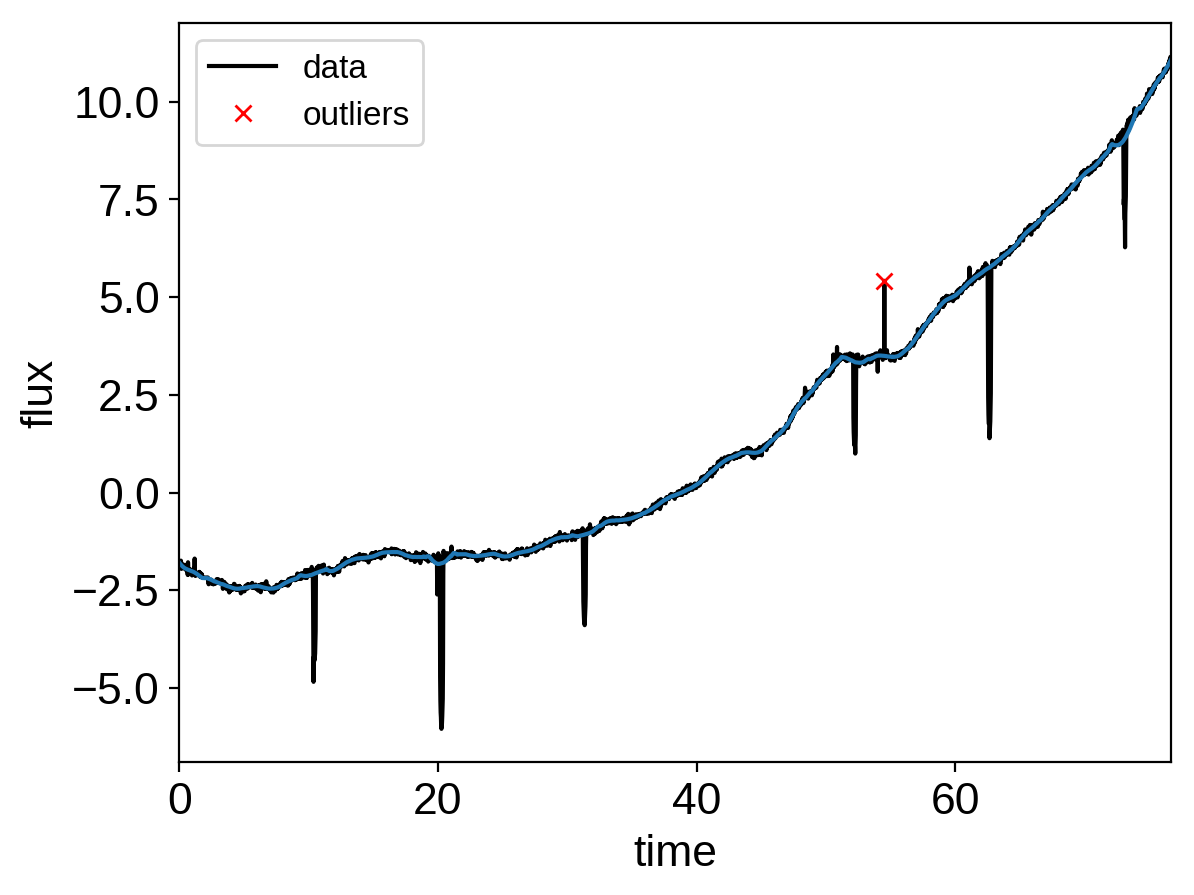

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

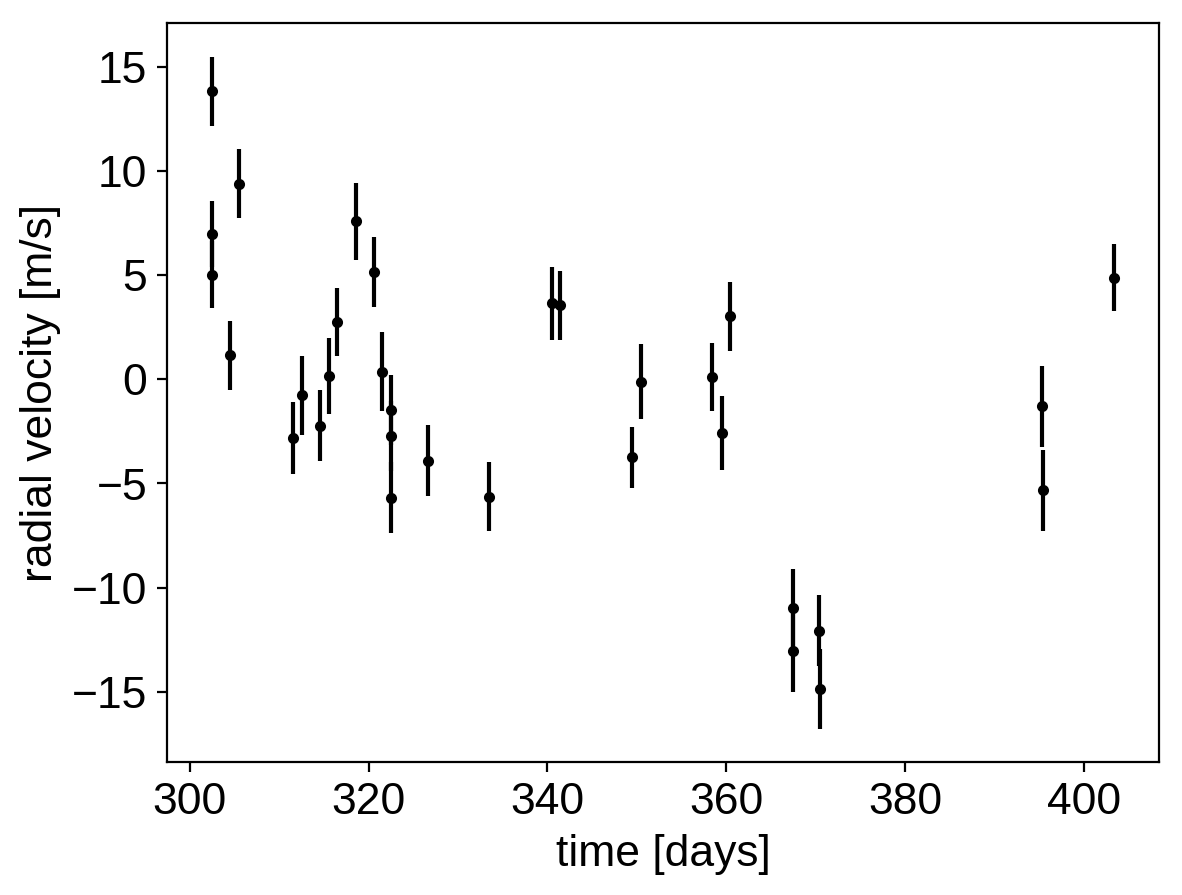

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

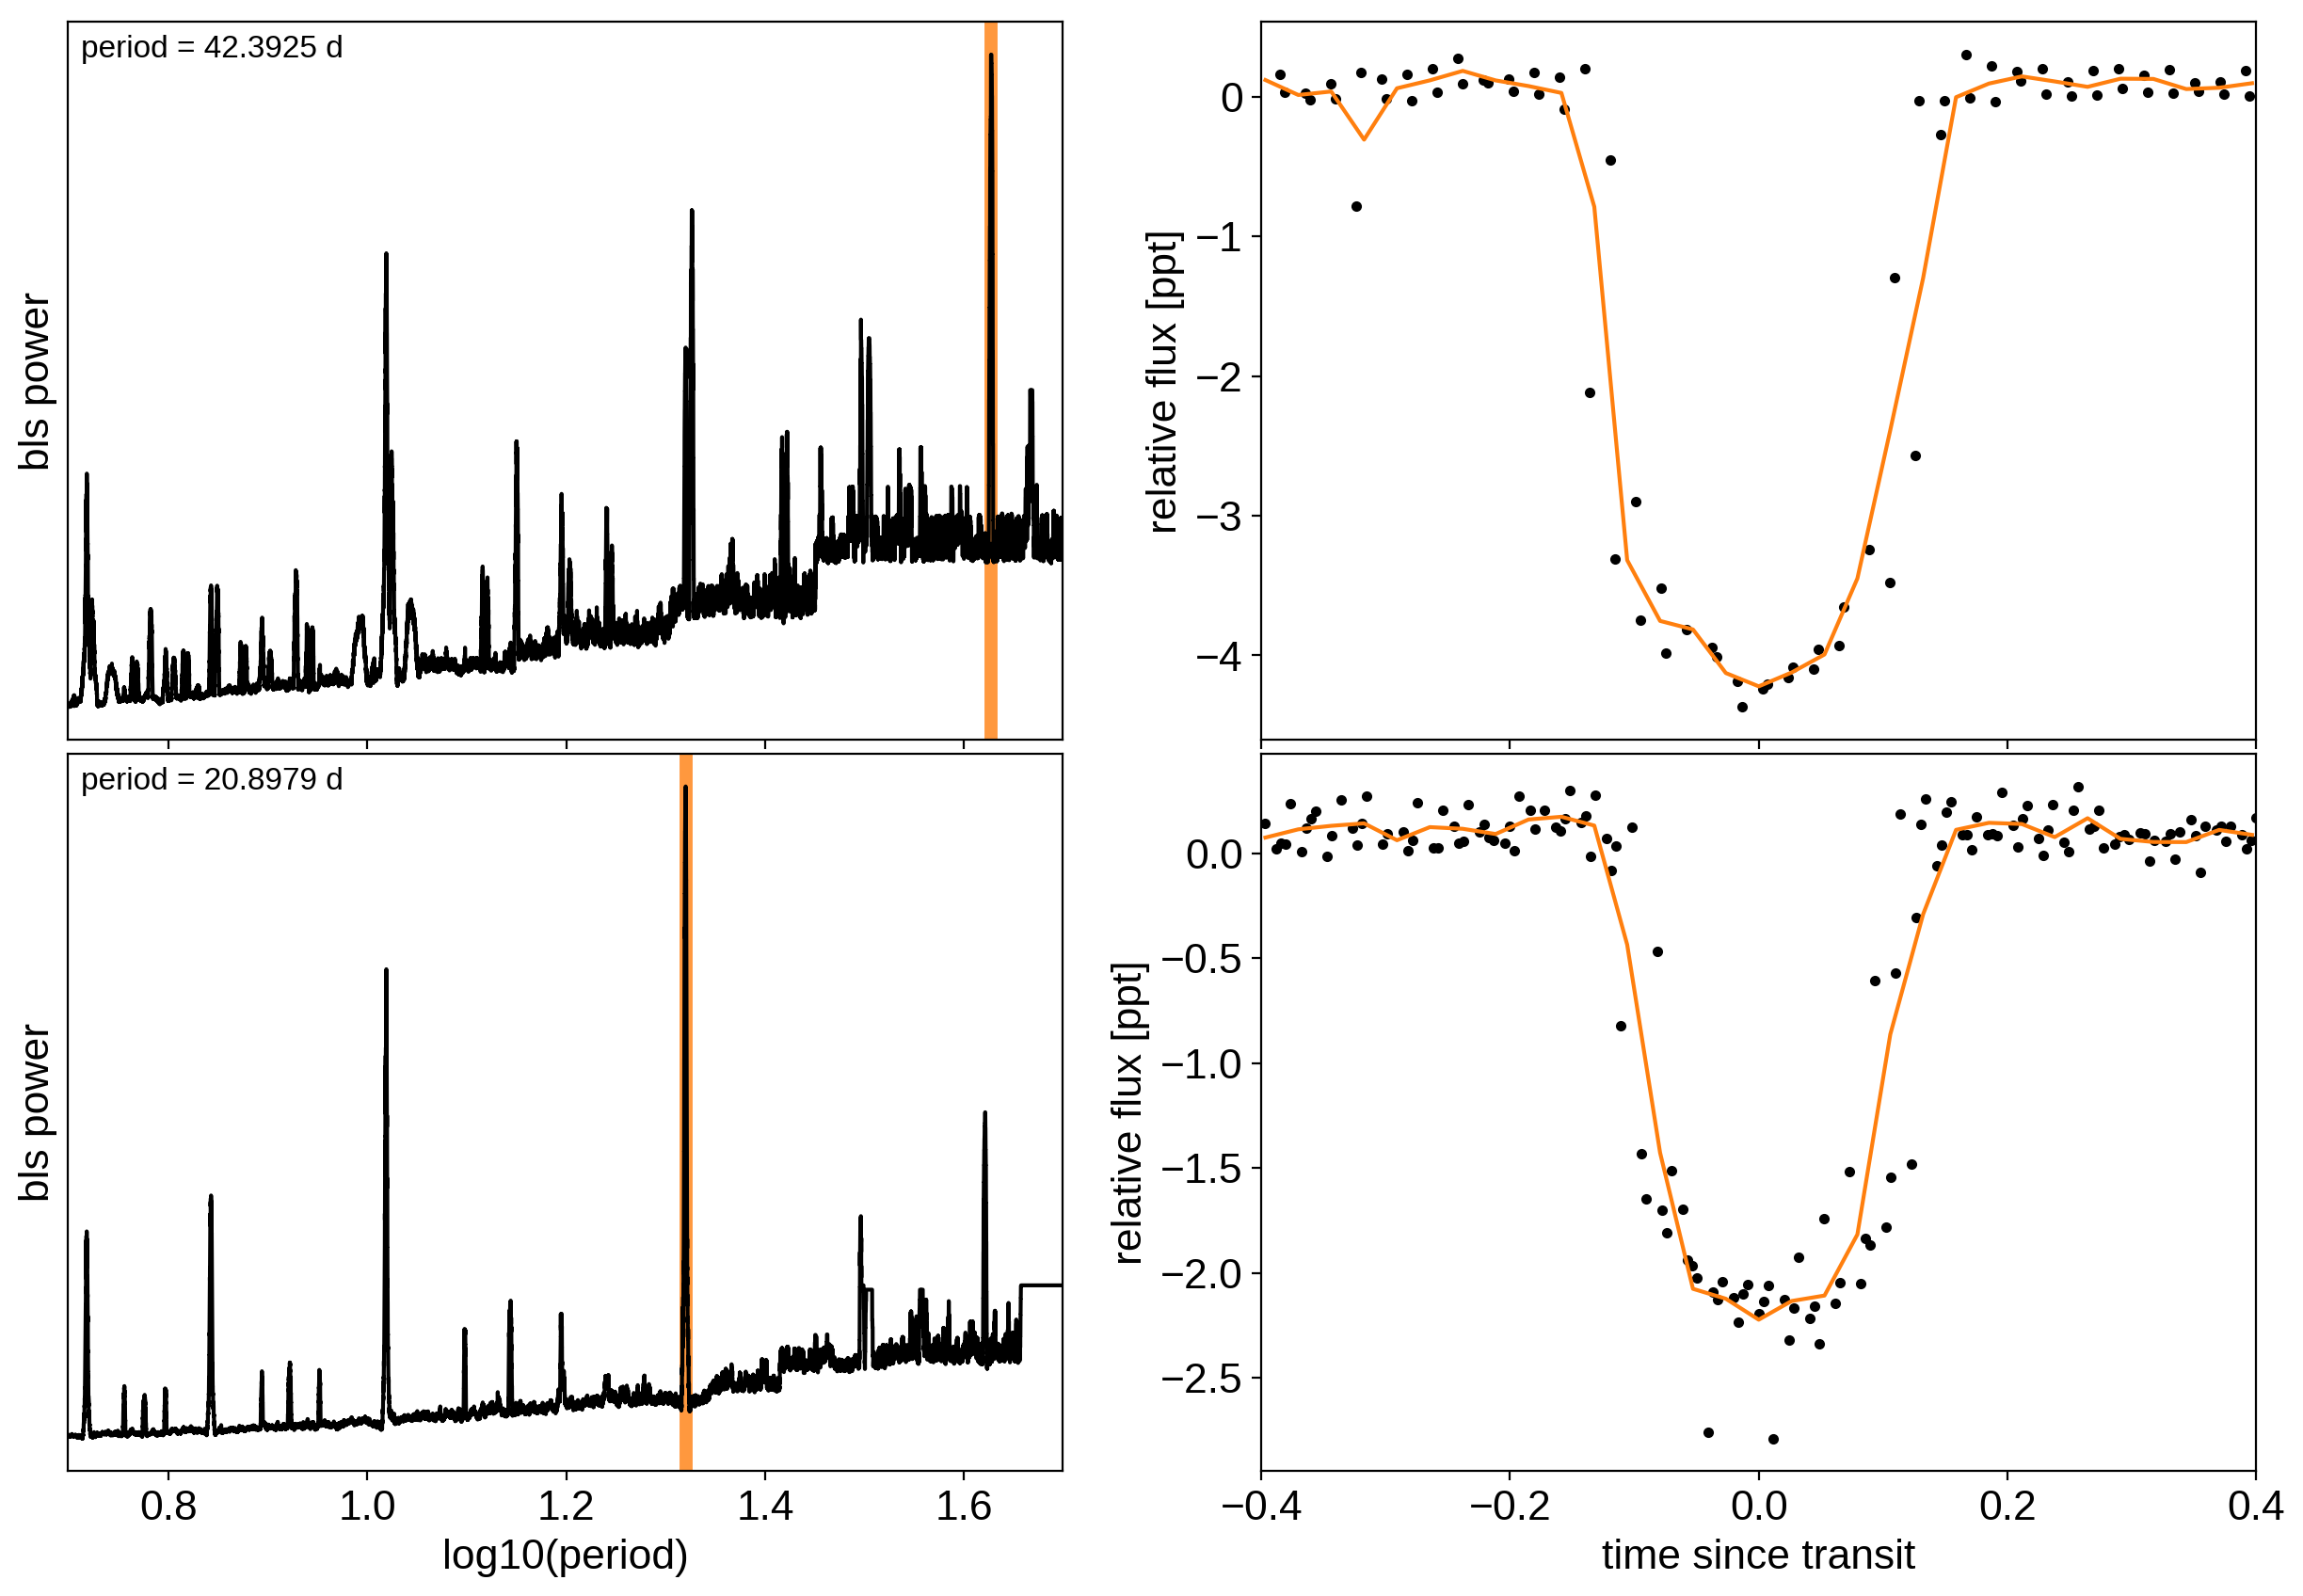

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.UnitUniform("b", shape=2)

        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.572324633431 -> -8233.972131420609


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.972131420609 -> 1985.112196637086


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 1985.112196637086 -> 2679.6622840411287


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2679.6622840411287 -> 3334.1377479694006


optimizing logp for variables: ['logpower', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 3334.137747969397 -> 4291.60331519934


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.60331519934 -> 4365.555598191493


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.555598191475 -> 4777.10345480088


Now let's plot the map radial velocity model.

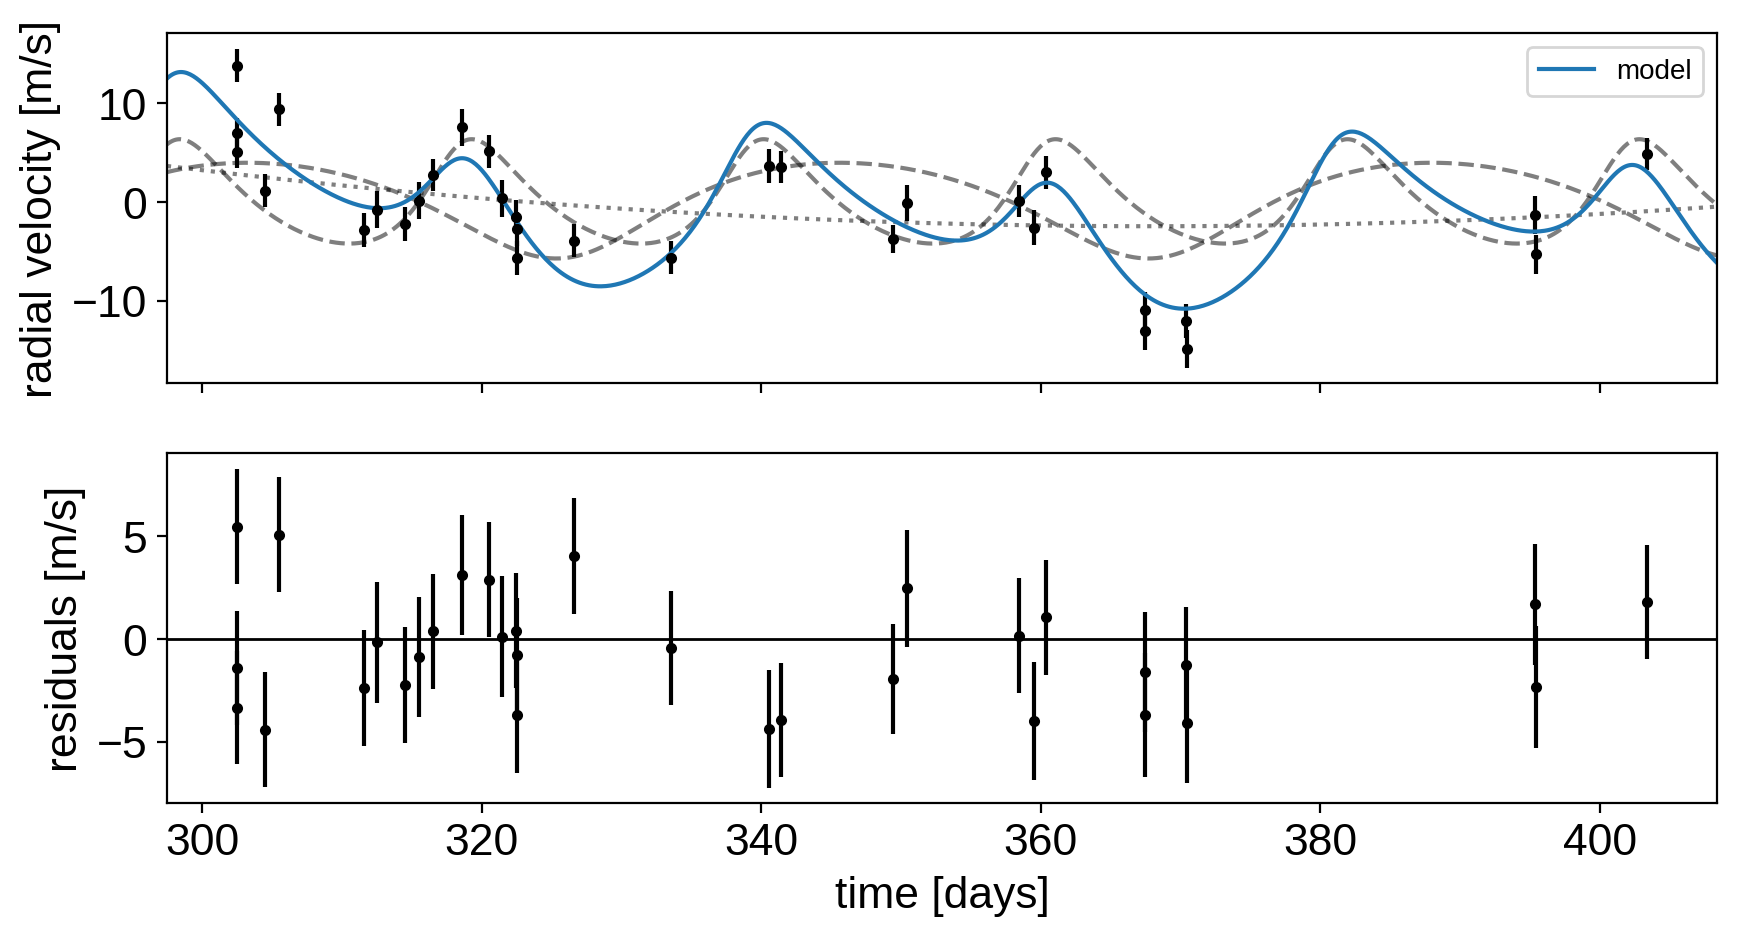

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

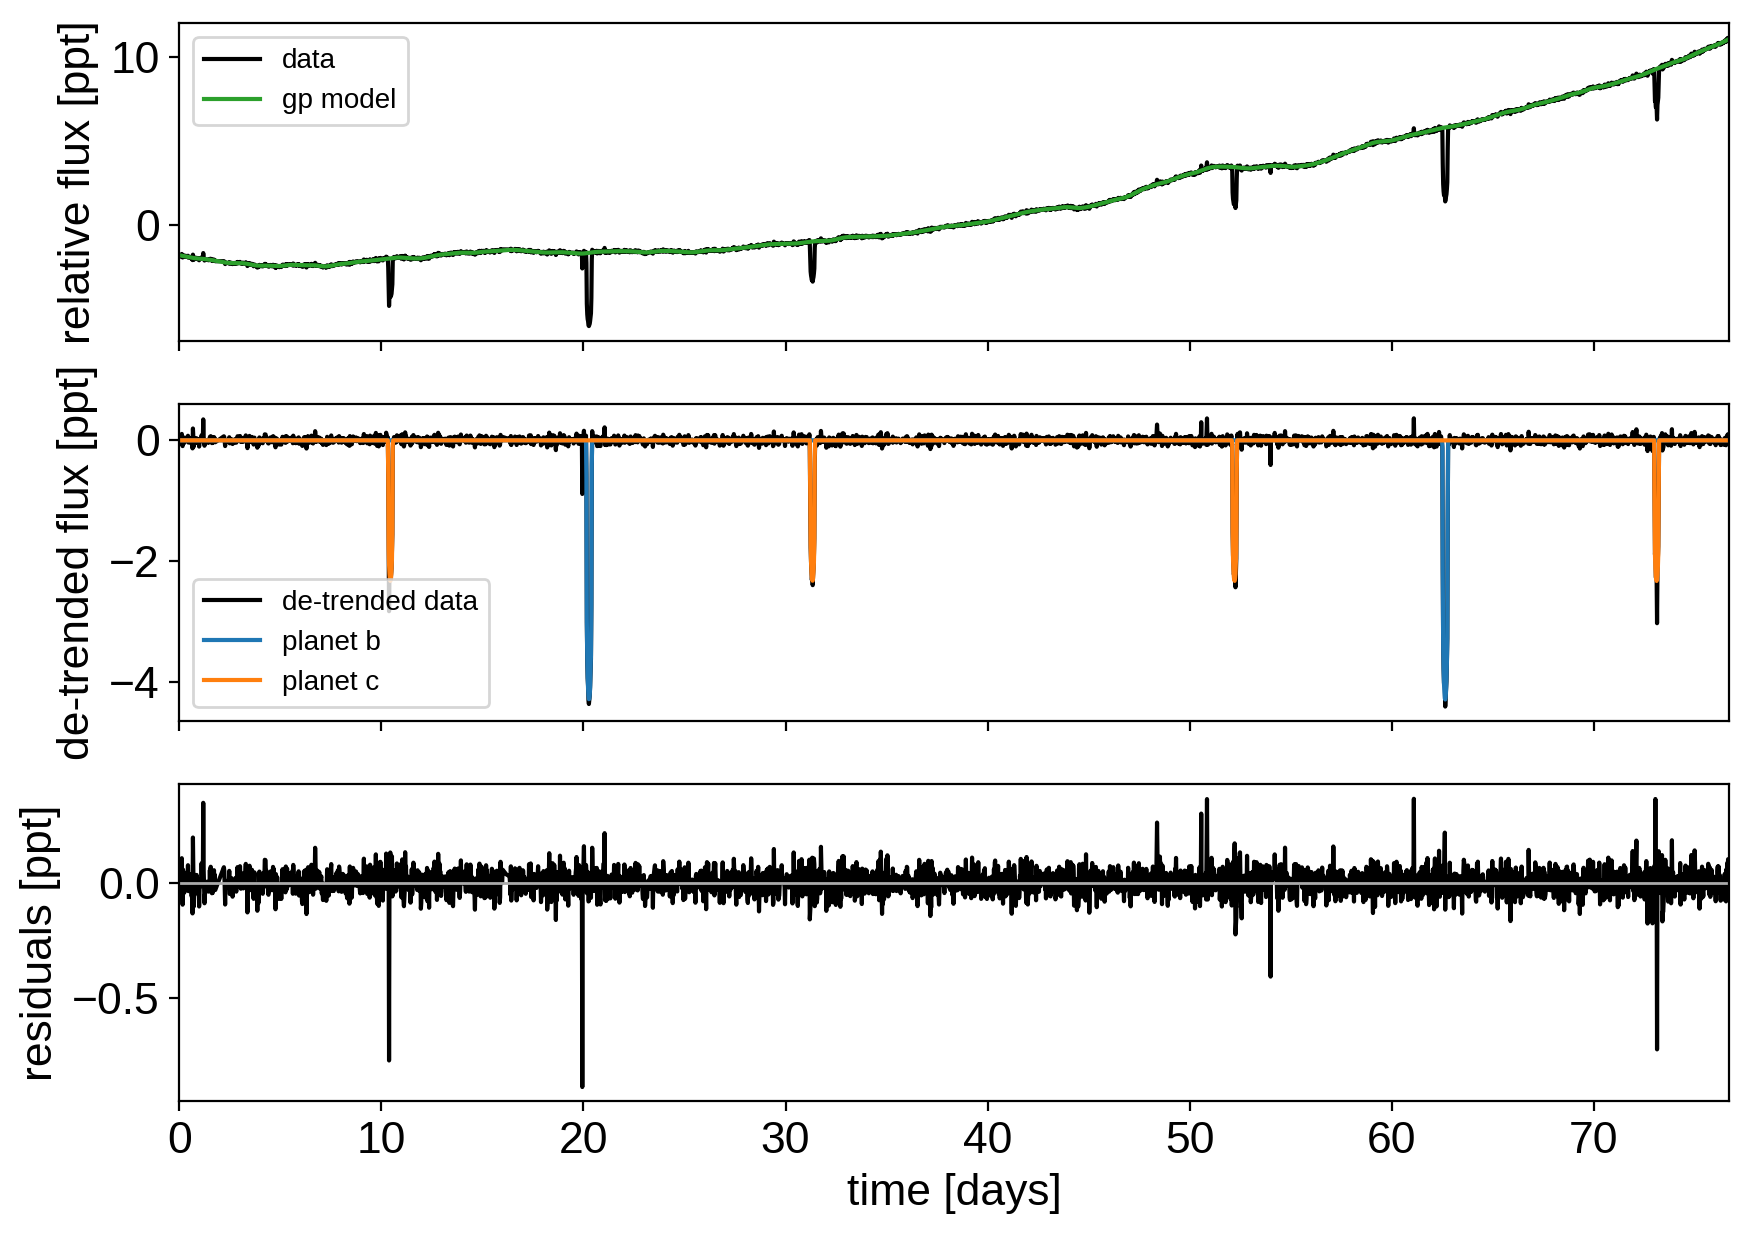

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

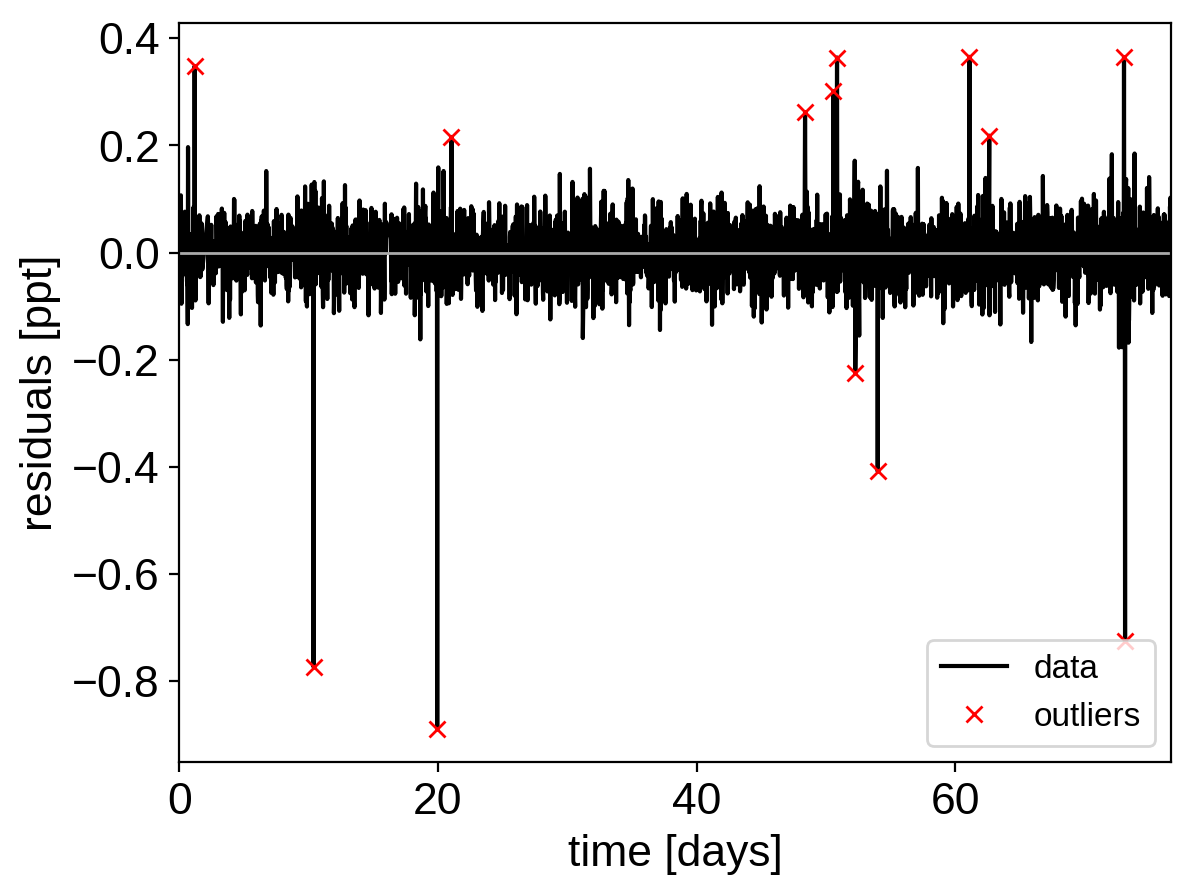

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.11678093738 -> 5227.11678093738


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.11678093738 -> 5309.2238272757595


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 5309.2238272757595 -> 5320.261298459935


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.261298459927 -> 5321.717806799228


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.717806799212 -> 5322.451996129972


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.451996129972 -> 5322.486246327689


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.486246327689 -> 5324.305565307076


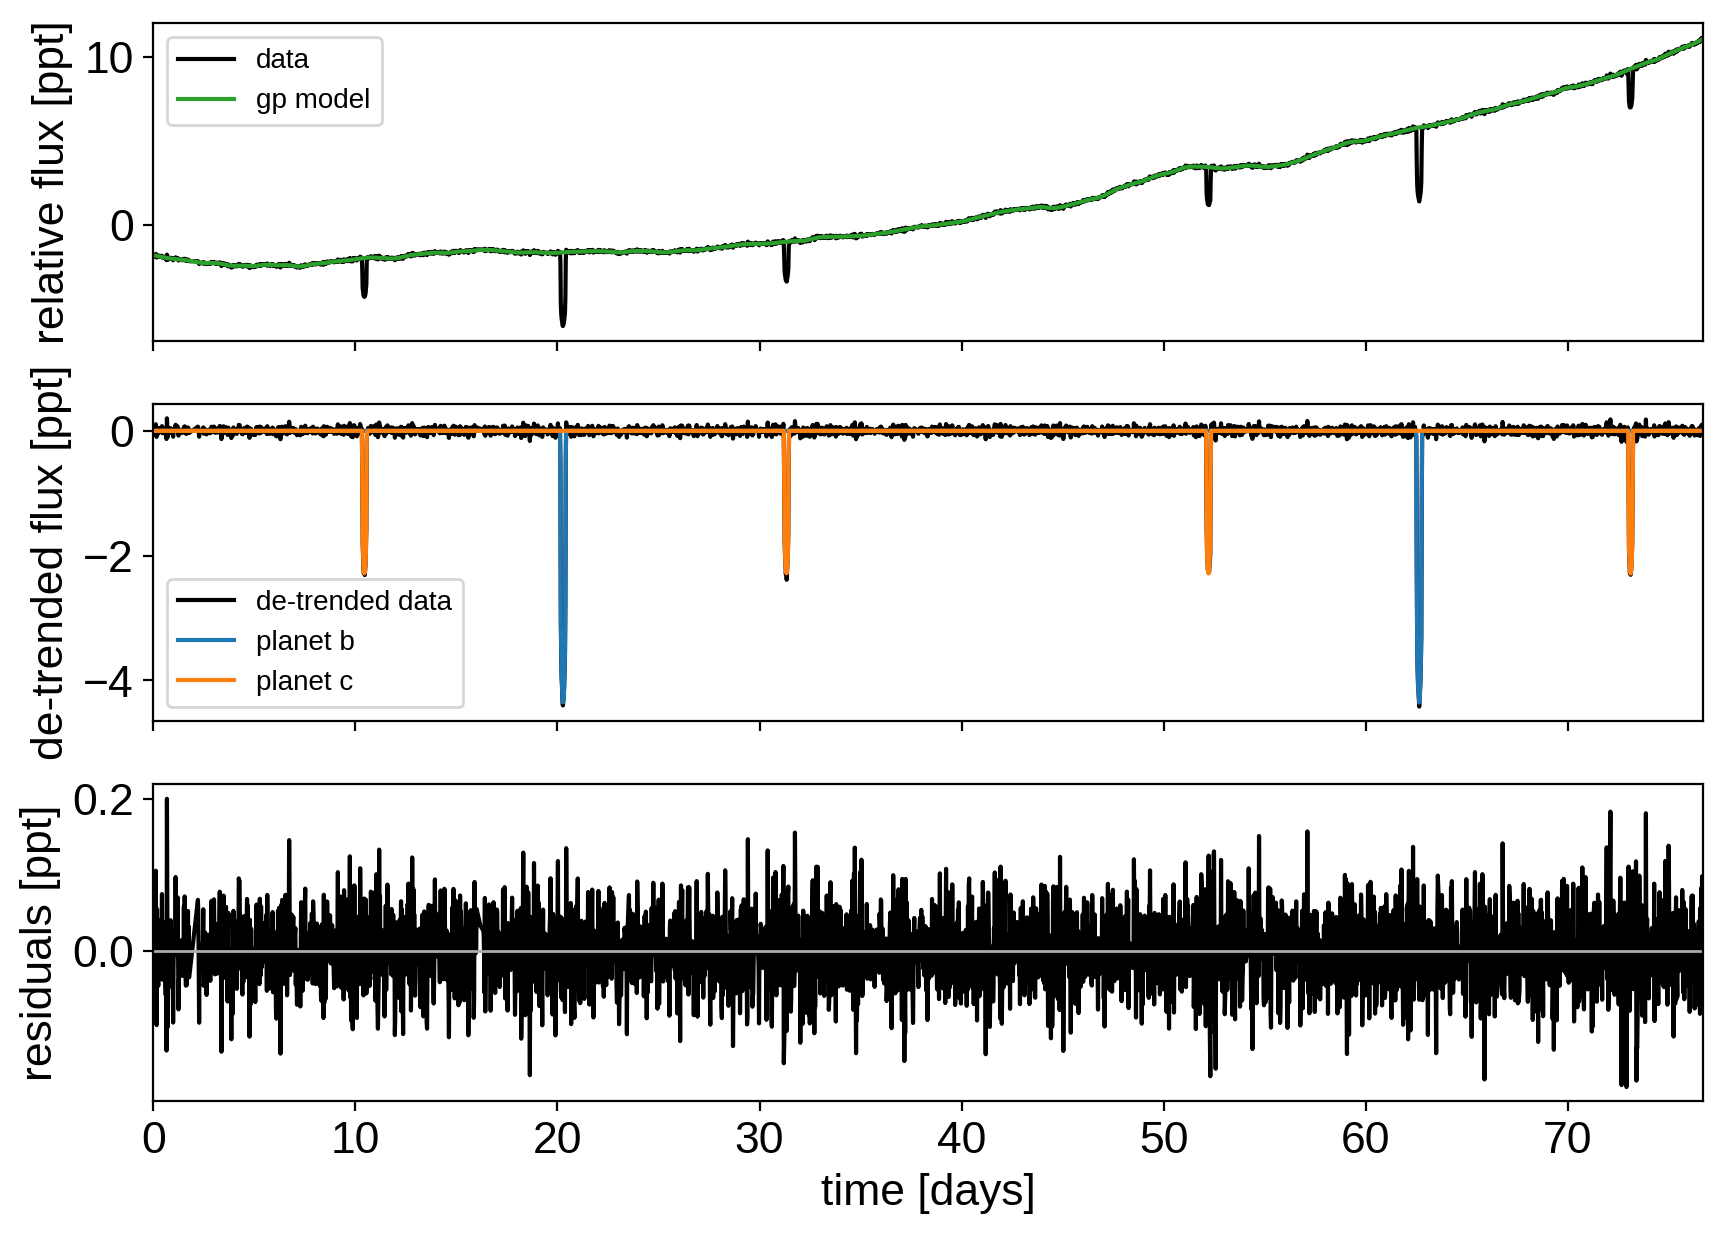

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
with model:
    trace = pm.sample(tune=5000, draws=3000, start=map_soln, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/32000 [00:00<17:09, 31.05draws/s]

Sampling 4 chains:   0%|          | 25/32000 [00:01<36:12, 14.72draws/s]

Sampling 4 chains:   0%|          | 29/32000 [00:01<49:50, 10.69draws/s]

Sampling 4 chains:   0%|          | 33/32000 [00:02<58:38,  9.09draws/s]

Sampling 4 chains:   0%|          | 37/32000 [00:03<1:04:48,  8.22draws/s]

Sampling 4 chains:   0%|          | 41/32000 [00:03<1:09:04,  7.71draws/s]

Sampling 4 chains:   0%|          | 45/32000 [00:04<1:12:00,  7.40draws/s]

Sampling 4 chains:   0%|          | 49/32000 [00:04<1:14:03,  7.19draws/s]

Sampling 4 chains:   0%|          | 52/32000 [00:04<57:34,  9.25draws/s]  

Sampling 4 chains:   0%|          | 54/32000 [00:05<1:21:45,  6.51draws/s]

Sampling 4 chains:   0%|          | 57/32000 [00:06<1:27:00,  6.12draws/s]

Sampling 4 chains:   0%|          | 59/32000 [00:06<1:09:40,  7.64draws/s]

Sampling 4 chains:   0%|          | 61/32000 [00:06<1:27:44,  6.07draws/s]

Sampling 4 chains:   0%|          | 63/32000 [00:06<1:11:29,  7.45draws/s]

Sampling 4 chains:   0%|          | 65/32000 [00:07<1:27:32,  6.08draws/s]

Sampling 4 chains:   0%|          | 67/32000 [00:07<1:12:33,  7.33draws/s]

Sampling 4 chains:   0%|          | 69/32000 [00:07<1:26:59,  6.12draws/s]

Sampling 4 chains:   0%|          | 71/32000 [00:08<1:14:01,  7.19draws/s]

Sampling 4 chains:   0%|          | 73/32000 [00:08<1:27:08,  6.11draws/s]

Sampling 4 chains:   0%|          | 75/32000 [00:08<1:14:09,  7.17draws/s]

Sampling 4 chains:   0%|          | 77/32000 [00:09<1:26:04,  6.18draws/s]

Sampling 4 chains:   0%|          | 79/32000 [00:09<1:14:25,  7.15draws/s]

Sampling 4 chains:   0%|          | 81/32000 [00:09<1:25:26,  6.23draws/s]

Sampling 4 chains:   0%|          | 83/32000 [00:09<1:15:27,  7.05draws/s]

Sampling 4 chains:   0%|          | 85/32000 [00:10<1:25:37,  6.21draws/s]

Sampling 4 chains:   0%|          | 87/32000 [00:10<1:16:43,  6.93draws/s]

Sampling 4 chains:   0%|          | 89/32000 [00:10<1:24:14,  6.31draws/s]

Sampling 4 chains:   0%|          | 91/32000 [00:11<1:16:56,  6.91draws/s]

Sampling 4 chains:   0%|          | 93/32000 [00:11<1:24:44,  6.28draws/s]

Sampling 4 chains:   0%|          | 95/32000 [00:11<1:16:55,  6.91draws/s]

Sampling 4 chains:   0%|          | 97/32000 [00:12<1:23:36,  6.36draws/s]

Sampling 4 chains:   0%|          | 99/32000 [00:12<1:17:04,  6.90draws/s]

Sampling 4 chains:   0%|          | 101/32000 [00:12<1:22:55,  6.41draws/s]

Sampling 4 chains:   0%|          | 103/32000 [00:12<1:18:16,  6.79draws/s]

Sampling 4 chains:   0%|          | 105/32000 [00:13<1:21:50,  6.49draws/s]

Sampling 4 chains:   0%|          | 107/32000 [00:13<1:18:35,  6.76draws/s]

Sampling 4 chains:   0%|          | 109/32000 [00:13<1:21:27,  6.53draws/s]

Sampling 4 chains:   0%|          | 110/32000 [00:13<1:14:07,  7.17draws/s]

Sampling 4 chains:   0%|          | 111/32000 [00:14<1:20:11,  6.63draws/s]

Sampling 4 chains:   0%|          | 113/32000 [00:14<1:21:55,  6.49draws/s]

Sampling 4 chains:   0%|          | 114/32000 [00:14<1:13:39,  7.22draws/s]

Sampling 4 chains:   0%|          | 115/32000 [00:14<1:20:12,  6.63draws/s]

Sampling 4 chains:   0%|          | 117/32000 [00:15<1:21:17,  6.54draws/s]

Sampling 4 chains:   0%|          | 118/32000 [00:15<1:14:06,  7.17draws/s]

Sampling 4 chains:   0%|          | 119/32000 [00:15<1:20:55,  6.57draws/s]

Sampling 4 chains:   0%|          | 121/32000 [00:15<1:22:04,  6.47draws/s]

Sampling 4 chains:   0%|          | 122/32000 [00:15<1:14:40,  7.12draws/s]

Sampling 4 chains:   0%|          | 123/32000 [00:15<1:21:11,  6.54draws/s]

Sampling 4 chains:   0%|          | 125/32000 [00:16<1:21:32,  6.52draws/s]

Sampling 4 chains:   0%|          | 126/32000 [00:16<1:14:52,  7.09draws/s]

Sampling 4 chains:   0%|          | 127/32000 [00:16<1:21:55,  6.48draws/s]

Sampling 4 chains:   0%|          | 129/32000 [00:16<1:21:14,  6.54draws/s]

Sampling 4 chains:   0%|          | 130/32000 [00:16<1:15:31,  7.03draws/s]

Sampling 4 chains:   0%|          | 131/32000 [00:17<1:23:59,  6.32draws/s]

Sampling 4 chains:   0%|          | 133/32000 [00:17<1:21:38,  6.51draws/s]

Sampling 4 chains:   0%|          | 134/32000 [00:17<1:16:30,  6.94draws/s]

Sampling 4 chains:   0%|          | 135/32000 [00:17<1:25:12,  6.23draws/s]

Sampling 4 chains:   0%|          | 137/32000 [00:18<1:21:29,  6.52draws/s]

Sampling 4 chains:   0%|          | 138/32000 [00:18<1:17:16,  6.87draws/s]

Sampling 4 chains:   0%|          | 139/32000 [00:18<1:26:56,  6.11draws/s]

Sampling 4 chains:   0%|          | 141/32000 [00:18<1:21:34,  6.51draws/s]

Sampling 4 chains:   0%|          | 142/32000 [00:18<1:18:11,  6.79draws/s]

Sampling 4 chains:   0%|          | 143/32000 [00:18<1:29:15,  5.95draws/s]

Sampling 4 chains:   0%|          | 145/32000 [00:19<1:22:19,  6.45draws/s]

Sampling 4 chains:   0%|          | 146/32000 [00:19<1:20:25,  6.60draws/s]

Sampling 4 chains:   0%|          | 147/32000 [00:19<1:31:23,  5.81draws/s]

Sampling 4 chains:   0%|          | 149/32000 [00:19<1:23:54,  6.33draws/s]

Sampling 4 chains:   0%|          | 150/32000 [00:19<1:20:57,  6.56draws/s]

Sampling 4 chains:   0%|          | 151/32000 [00:20<1:31:14,  5.82draws/s]

Sampling 4 chains:   0%|          | 153/32000 [00:20<1:23:08,  6.38draws/s]

Sampling 4 chains:   0%|          | 154/32000 [00:20<1:21:10,  6.54draws/s]

Sampling 4 chains:   0%|          | 155/32000 [00:20<1:34:53,  5.59draws/s]

Sampling 4 chains:   0%|          | 157/32000 [00:21<1:23:16,  6.37draws/s]

Sampling 4 chains:   0%|          | 158/32000 [00:21<1:22:11,  6.46draws/s]

Sampling 4 chains:   0%|          | 159/32000 [00:21<1:36:23,  5.51draws/s]

Sampling 4 chains:   1%|          | 161/32000 [00:21<1:24:16,  6.30draws/s]

Sampling 4 chains:   1%|          | 162/32000 [00:21<1:23:10,  6.38draws/s]

Sampling 4 chains:   1%|          | 163/32000 [00:22<1:37:15,  5.46draws/s]

Sampling 4 chains:   1%|          | 165/32000 [00:22<1:23:50,  6.33draws/s]

Sampling 4 chains:   1%|          | 166/32000 [00:22<1:23:29,  6.35draws/s]

Sampling 4 chains:   1%|          | 167/32000 [00:22<1:38:27,  5.39draws/s]

Sampling 4 chains:   1%|          | 169/32000 [00:22<1:23:49,  6.33draws/s]

Sampling 4 chains:   1%|          | 170/32000 [00:22<1:24:16,  6.30draws/s]

Sampling 4 chains:   1%|          | 171/32000 [00:23<1:40:11,  5.29draws/s]

Sampling 4 chains:   1%|          | 173/32000 [00:23<1:23:58,  6.32draws/s]

Sampling 4 chains:   1%|          | 174/32000 [00:23<1:25:10,  6.23draws/s]

Sampling 4 chains:   1%|          | 175/32000 [00:23<1:42:06,  5.19draws/s]

Sampling 4 chains:   1%|          | 177/32000 [00:24<1:24:29,  6.28draws/s]

Sampling 4 chains:   1%|          | 178/32000 [00:24<1:26:20,  6.14draws/s]

Sampling 4 chains:   1%|          | 179/32000 [00:24<1:43:35,  5.12draws/s]

Sampling 4 chains:   1%|          | 181/32000 [00:24<1:24:59,  6.24draws/s]

Sampling 4 chains:   1%|          | 182/32000 [00:24<1:27:31,  6.06draws/s]

Sampling 4 chains:   1%|          | 183/32000 [00:25<1:46:48,  4.96draws/s]

Sampling 4 chains:   1%|          | 185/32000 [00:25<1:25:36,  6.19draws/s]

Sampling 4 chains:   1%|          | 186/32000 [00:25<1:28:40,  5.98draws/s]

Sampling 4 chains:   1%|          | 187/32000 [00:25<1:48:16,  4.90draws/s]

Sampling 4 chains:   1%|          | 189/32000 [00:25<1:25:55,  6.17draws/s]

Sampling 4 chains:   1%|          | 190/32000 [00:26<1:29:39,  5.91draws/s]

Sampling 4 chains:   1%|          | 191/32000 [00:26<1:49:31,  4.84draws/s]

Sampling 4 chains:   1%|          | 193/32000 [00:26<1:26:04,  6.16draws/s]

Sampling 4 chains:   1%|          | 194/32000 [00:26<1:30:24,  5.86draws/s]

Sampling 4 chains:   1%|          | 195/32000 [00:26<1:50:40,  4.79draws/s]

Sampling 4 chains:   1%|          | 197/32000 [00:27<1:26:17,  6.14draws/s]

Sampling 4 chains:   1%|          | 199/32000 [00:27<1:40:52,  5.25draws/s]

Sampling 4 chains:   1%|          | 202/32000 [00:27<1:26:15,  6.14draws/s]

Sampling 4 chains:   1%|          | 203/32000 [00:28<1:49:58,  4.82draws/s]

Sampling 4 chains:   1%|          | 206/32000 [00:28<1:32:21,  5.74draws/s]

Sampling 4 chains:   1%|          | 207/32000 [00:28<1:54:54,  4.61draws/s]

Sampling 4 chains:   1%|          | 210/32000 [00:29<1:35:28,  5.55draws/s]

Sampling 4 chains:   1%|          | 211/32000 [00:29<1:57:56,  4.49draws/s]

Sampling 4 chains:   1%|          | 214/32000 [00:29<1:37:24,  5.44draws/s]

Sampling 4 chains:   1%|          | 215/32000 [00:29<1:59:55,  4.42draws/s]

Sampling 4 chains:   1%|          | 218/32000 [00:30<1:38:48,  5.36draws/s]

Sampling 4 chains:   1%|          | 219/32000 [00:30<2:01:26,  4.36draws/s]

Sampling 4 chains:   1%|          | 222/32000 [00:30<1:39:27,  5.33draws/s]

Sampling 4 chains:   1%|          | 223/32000 [00:31<2:02:25,  4.33draws/s]

Sampling 4 chains:   1%|          | 226/32000 [00:31<1:39:54,  5.30draws/s]

Sampling 4 chains:   1%|          | 227/32000 [00:31<2:03:44,  4.28draws/s]

Sampling 4 chains:   1%|          | 230/32000 [00:32<1:40:32,  5.27draws/s]

Sampling 4 chains:   1%|          | 231/32000 [00:32<2:04:53,  4.24draws/s]

Sampling 4 chains:   1%|          | 234/32000 [00:32<1:41:02,  5.24draws/s]

Sampling 4 chains:   1%|          | 235/32000 [00:32<2:06:13,  4.19draws/s]

Sampling 4 chains:   1%|          | 238/32000 [00:33<1:41:31,  5.21draws/s]

Sampling 4 chains:   1%|          | 239/32000 [00:33<2:07:11,  4.16draws/s]

Sampling 4 chains:   1%|          | 242/32000 [00:33<1:42:16,  5.18draws/s]

Sampling 4 chains:   1%|          | 243/32000 [00:34<2:06:47,  4.17draws/s]

Sampling 4 chains:   1%|          | 246/32000 [00:34<1:42:17,  5.17draws/s]

Sampling 4 chains:   1%|          | 247/32000 [00:34<2:05:55,  4.20draws/s]

Sampling 4 chains:   1%|          | 250/32000 [00:35<1:41:57,  5.19draws/s]

Sampling 4 chains:   1%|          | 251/32000 [00:35<2:04:49,  4.24draws/s]

Sampling 4 chains:   1%|          | 254/32000 [00:35<1:41:29,  5.21draws/s]

Sampling 4 chains:   1%|          | 255/32000 [00:35<2:03:27,  4.29draws/s]

Sampling 4 chains:   1%|          | 257/32000 [00:36<1:35:38,  5.53draws/s]

Sampling 4 chains:   1%|          | 258/32000 [00:36<1:31:51,  5.76draws/s]

Sampling 4 chains:   1%|          | 259/32000 [00:36<1:55:28,  4.58draws/s]

Sampling 4 chains:   1%|          | 261/32000 [00:36<1:32:18,  5.73draws/s]

Sampling 4 chains:   1%|          | 262/32000 [00:36<1:25:26,  6.19draws/s]

Sampling 4 chains:   1%|          | 263/32000 [00:37<1:50:32,  4.79draws/s]

Sampling 4 chains:   1%|          | 265/32000 [00:37<1:29:41,  5.90draws/s]

Sampling 4 chains:   1%|          | 266/32000 [00:37<1:23:04,  6.37draws/s]

Sampling 4 chains:   1%|          | 267/32000 [00:37<1:47:55,  4.90draws/s]

Sampling 4 chains:   1%|          | 269/32000 [00:37<1:30:57,  5.81draws/s]

Sampling 4 chains:   1%|          | 271/32000 [00:38<1:36:12,  5.50draws/s]

Sampling 4 chains:   1%|          | 273/32000 [00:38<1:23:22,  6.34draws/s]

Sampling 4 chains:   1%|          | 275/32000 [00:38<1:29:37,  5.90draws/s]

Sampling 4 chains:   1%|          | 277/32000 [00:39<1:19:38,  6.64draws/s]

Sampling 4 chains:   1%|          | 279/32000 [00:39<1:26:01,  6.15draws/s]

Sampling 4 chains:   1%|          | 281/32000 [00:39<1:18:00,  6.78draws/s]

Sampling 4 chains:   1%|          | 283/32000 [00:40<1:24:07,  6.28draws/s]

Sampling 4 chains:   1%|          | 284/32000 [00:40<1:17:55,  6.78draws/s]

Sampling 4 chains:   1%|          | 285/32000 [00:40<1:12:57,  7.24draws/s]

Sampling 4 chains:   1%|          | 287/32000 [00:40<1:19:25,  6.65draws/s]

Sampling 4 chains:   1%|          | 288/32000 [00:40<1:16:30,  6.91draws/s]

Sampling 4 chains:   1%|          | 289/32000 [00:41<1:16:07,  6.94draws/s]

Sampling 4 chains:   1%|          | 291/32000 [00:41<1:18:54,  6.70draws/s]

Sampling 4 chains:   1%|          | 292/32000 [00:41<1:17:21,  6.83draws/s]

Sampling 4 chains:   1%|          | 293/32000 [00:41<1:16:59,  6.86draws/s]

Sampling 4 chains:   1%|          | 295/32000 [00:41<1:18:41,  6.72draws/s]

Sampling 4 chains:   1%|          | 296/32000 [00:42<1:18:28,  6.73draws/s]

Sampling 4 chains:   1%|          | 297/32000 [00:42<1:22:05,  6.44draws/s]

Sampling 4 chains:   1%|          | 299/32000 [00:42<1:20:23,  6.57draws/s]

Sampling 4 chains:   1%|          | 300/32000 [00:42<1:19:35,  6.64draws/s]

Sampling 4 chains:   1%|          | 301/32000 [00:42<1:22:48,  6.38draws/s]

Sampling 4 chains:   1%|          | 303/32000 [00:43<1:19:42,  6.63draws/s]

Sampling 4 chains:   1%|          | 304/32000 [00:43<1:21:18,  6.50draws/s]

Sampling 4 chains:   1%|          | 305/32000 [00:43<1:24:03,  6.28draws/s]

Sampling 4 chains:   1%|          | 307/32000 [00:43<1:19:50,  6.62draws/s]

Sampling 4 chains:   1%|          | 308/32000 [00:43<1:22:38,  6.39draws/s]

Sampling 4 chains:   1%|          | 309/32000 [00:44<1:25:05,  6.21draws/s]

Sampling 4 chains:   1%|          | 311/32000 [00:44<1:19:29,  6.64draws/s]

Sampling 4 chains:   1%|          | 312/32000 [00:44<1:24:25,  6.26draws/s]

Sampling 4 chains:   1%|          | 313/32000 [00:44<1:26:12,  6.13draws/s]

Sampling 4 chains:   1%|          | 315/32000 [00:44<1:19:30,  6.64draws/s]

Sampling 4 chains:   1%|          | 316/32000 [00:45<1:26:16,  6.12draws/s]

Sampling 4 chains:   1%|          | 317/32000 [00:45<1:26:47,  6.08draws/s]

Sampling 4 chains:   1%|          | 319/32000 [00:45<1:19:33,  6.64draws/s]

Sampling 4 chains:   1%|          | 320/32000 [00:45<1:27:40,  6.02draws/s]

Sampling 4 chains:   1%|          | 321/32000 [00:45<1:27:25,  6.04draws/s]

Sampling 4 chains:   1%|          | 323/32000 [00:46<1:19:25,  6.65draws/s]

Sampling 4 chains:   1%|          | 324/32000 [00:46<1:28:55,  5.94draws/s]

Sampling 4 chains:   1%|          | 325/32000 [00:46<1:27:44,  6.02draws/s]

Sampling 4 chains:   1%|          | 327/32000 [00:46<1:19:02,  6.68draws/s]

Sampling 4 chains:   1%|          | 328/32000 [00:46<1:30:43,  5.82draws/s]

Sampling 4 chains:   1%|          | 329/32000 [00:47<1:28:25,  5.97draws/s]

Sampling 4 chains:   1%|          | 331/32000 [00:47<1:18:57,  6.68draws/s]

Sampling 4 chains:   1%|          | 332/32000 [00:47<1:32:05,  5.73draws/s]

Sampling 4 chains:   1%|          | 333/32000 [00:47<1:29:21,  5.91draws/s]

Sampling 4 chains:   1%|          | 335/32000 [00:47<1:18:54,  6.69draws/s]

Sampling 4 chains:   1%|          | 336/32000 [00:48<1:33:44,  5.63draws/s]

Sampling 4 chains:   1%|          | 337/32000 [00:48<1:29:46,  5.88draws/s]

Sampling 4 chains:   1%|          | 339/32000 [00:48<1:18:52,  6.69draws/s]

Sampling 4 chains:   1%|          | 340/32000 [00:48<1:34:38,  5.58draws/s]

Sampling 4 chains:   1%|          | 341/32000 [00:48<1:30:14,  5.85draws/s]

Sampling 4 chains:   1%|          | 342/32000 [00:49<1:20:30,  6.55draws/s]

Sampling 4 chains:   1%|          | 344/32000 [00:49<1:23:35,  6.31draws/s]

Sampling 4 chains:   1%|          | 345/32000 [00:49<1:21:29,  6.47draws/s]

Sampling 4 chains:   1%|          | 346/32000 [00:49<1:16:21,  6.91draws/s]

Sampling 4 chains:   1%|          | 348/32000 [00:49<1:20:18,  6.57draws/s]

Sampling 4 chains:   1%|          | 349/32000 [00:50<1:18:33,  6.71draws/s]

Sampling 4 chains:   1%|          | 350/32000 [00:50<1:14:53,  7.04draws/s]

Sampling 4 chains:   1%|          | 352/32000 [00:50<1:19:15,  6.65draws/s]

Sampling 4 chains:   1%|          | 353/32000 [00:50<1:17:23,  6.81draws/s]

Sampling 4 chains:   1%|          | 354/32000 [00:50<1:14:36,  7.07draws/s]

Sampling 4 chains:   1%|          | 356/32000 [00:51<1:18:58,  6.68draws/s]

Sampling 4 chains:   1%|          | 357/32000 [00:51<1:16:57,  6.85draws/s]

Sampling 4 chains:   1%|          | 358/32000 [00:51<1:14:37,  7.07draws/s]

Sampling 4 chains:   1%|          | 360/32000 [00:51<1:18:58,  6.68draws/s]

Sampling 4 chains:   1%|          | 361/32000 [00:51<1:16:35,  6.88draws/s]

Sampling 4 chains:   1%|          | 362/32000 [00:52<1:19:45,  6.61draws/s]

Sampling 4 chains:   1%|          | 364/32000 [00:52<1:21:13,  6.49draws/s]

Sampling 4 chains:   1%|          | 365/32000 [00:52<1:15:36,  6.97draws/s]

Sampling 4 chains:   1%|          | 366/32000 [00:52<1:17:45,  6.78draws/s]

Sampling 4 chains:   1%|          | 368/32000 [00:53<1:20:28,  6.55draws/s]

Sampling 4 chains:   1%|          | 369/32000 [00:53<1:14:53,  7.04draws/s]

Sampling 4 chains:   1%|          | 370/32000 [00:53<1:16:05,  6.93draws/s]

Sampling 4 chains:   1%|          | 372/32000 [00:53<1:20:12,  6.57draws/s]

Sampling 4 chains:   1%|          | 373/32000 [00:53<1:15:03,  7.02draws/s]

Sampling 4 chains:   1%|          | 374/32000 [00:53<1:16:12,  6.92draws/s]

Sampling 4 chains:   1%|          | 376/32000 [00:54<1:19:56,  6.59draws/s]

Sampling 4 chains:   1%|          | 377/32000 [00:54<1:14:32,  7.07draws/s]

Sampling 4 chains:   1%|          | 378/32000 [00:54<1:15:12,  7.01draws/s]

Sampling 4 chains:   1%|          | 380/32000 [00:54<1:19:43,  6.61draws/s]

Sampling 4 chains:   1%|          | 381/32000 [00:54<1:14:05,  7.11draws/s]

Sampling 4 chains:   1%|          | 382/32000 [00:55<1:13:52,  7.13draws/s]

Sampling 4 chains:   1%|          | 384/32000 [00:55<1:19:26,  6.63draws/s]

Sampling 4 chains:   1%|          | 385/32000 [00:55<1:13:34,  7.16draws/s]

Sampling 4 chains:   1%|          | 386/32000 [00:55<1:12:27,  7.27draws/s]

Sampling 4 chains:   1%|          | 387/32000 [00:55<1:07:43,  7.78draws/s]

Sampling 4 chains:   1%|          | 388/32000 [00:56<1:27:11,  6.04draws/s]

Sampling 4 chains:   1%|          | 389/32000 [00:56<1:18:49,  6.68draws/s]

Sampling 4 chains:   1%|          | 390/32000 [00:56<1:14:57,  7.03draws/s]

Sampling 4 chains:   1%|          | 391/32000 [00:56<1:11:00,  7.42draws/s]

Sampling 4 chains:   1%|          | 392/32000 [00:56<1:29:18,  5.90draws/s]

Sampling 4 chains:   1%|          | 393/32000 [00:56<1:20:04,  6.58draws/s]

Sampling 4 chains:   1%|          | 394/32000 [00:56<1:14:45,  7.05draws/s]

Sampling 4 chains:   1%|          | 395/32000 [00:57<1:16:46,  6.86draws/s]

Sampling 4 chains:   1%|          | 396/32000 [00:57<1:28:32,  5.95draws/s]

Sampling 4 chains:   1%|          | 397/32000 [00:57<1:19:56,  6.59draws/s]

Sampling 4 chains:   1%|          | 398/32000 [00:57<1:13:34,  7.16draws/s]

Sampling 4 chains:   1%|          | 399/32000 [00:57<1:16:52,  6.85draws/s]

Sampling 4 chains:   1%|▏         | 400/32000 [00:57<1:28:29,  5.95draws/s]

Sampling 4 chains:   1%|▏         | 401/32000 [00:57<1:19:12,  6.65draws/s]

Sampling 4 chains:   1%|▏         | 402/32000 [00:58<1:11:58,  7.32draws/s]

Sampling 4 chains:   1%|▏         | 403/32000 [00:58<1:24:02,  6.27draws/s]

Sampling 4 chains:   1%|▏         | 404/32000 [00:58<1:32:39,  5.68draws/s]

Sampling 4 chains:   1%|▏         | 406/32000 [00:58<1:18:25,  6.71draws/s]

Sampling 4 chains:   1%|▏         | 407/32000 [00:58<1:29:35,  5.88draws/s]

Sampling 4 chains:   1%|▏         | 408/32000 [00:59<1:35:21,  5.52draws/s]

Sampling 4 chains:   1%|▏         | 410/32000 [00:59<1:21:06,  6.49draws/s]

Sampling 4 chains:   1%|▏         | 411/32000 [00:59<1:30:17,  5.83draws/s]

Sampling 4 chains:   1%|▏         | 412/32000 [00:59<1:35:11,  5.53draws/s]

Sampling 4 chains:   1%|▏         | 414/32000 [00:59<1:21:02,  6.50draws/s]

Sampling 4 chains:   1%|▏         | 415/32000 [01:00<1:30:55,  5.79draws/s]

Sampling 4 chains:   1%|▏         | 416/32000 [01:00<1:34:54,  5.55draws/s]

Sampling 4 chains:   1%|▏         | 418/32000 [01:00<1:20:49,  6.51draws/s]

Sampling 4 chains:   1%|▏         | 419/32000 [01:00<1:31:23,  5.76draws/s]

Sampling 4 chains:   1%|▏         | 420/32000 [01:00<1:34:50,  5.55draws/s]

Sampling 4 chains:   1%|▏         | 421/32000 [01:00<1:22:41,  6.36draws/s]

Sampling 4 chains:   1%|▏         | 423/32000 [01:01<1:21:48,  6.43draws/s]

Sampling 4 chains:   1%|▏         | 424/32000 [01:01<1:27:21,  6.02draws/s]

Sampling 4 chains:   1%|▏         | 425/32000 [01:01<1:18:22,  6.71draws/s]

Sampling 4 chains:   1%|▏         | 427/32000 [01:01<1:18:47,  6.68draws/s]

Sampling 4 chains:   1%|▏         | 428/32000 [01:02<1:24:35,  6.22draws/s]

Sampling 4 chains:   1%|▏         | 429/32000 [01:02<1:16:48,  6.85draws/s]

Sampling 4 chains:   1%|▏         | 431/32000 [01:02<1:17:42,  6.77draws/s]

Sampling 4 chains:   1%|▏         | 432/32000 [01:02<1:23:18,  6.32draws/s]

Sampling 4 chains:   1%|▏         | 433/32000 [01:02<1:16:29,  6.88draws/s]

Sampling 4 chains:   1%|▏         | 435/32000 [01:03<1:19:33,  6.61draws/s]

Sampling 4 chains:   1%|▏         | 436/32000 [01:03<1:19:36,  6.61draws/s]

Sampling 4 chains:   1%|▏         | 437/32000 [01:03<1:14:57,  7.02draws/s]

Sampling 4 chains:   1%|▏         | 439/32000 [01:03<1:18:58,  6.66draws/s]

Sampling 4 chains:   1%|▏         | 440/32000 [01:03<1:17:32,  6.78draws/s]

Sampling 4 chains:   1%|▏         | 441/32000 [01:04<1:13:56,  7.11draws/s]

Sampling 4 chains:   1%|▏         | 443/32000 [01:04<1:18:37,  6.69draws/s]

Sampling 4 chains:   1%|▏         | 444/32000 [01:04<1:15:41,  6.95draws/s]

Sampling 4 chains:   1%|▏         | 445/32000 [01:04<1:13:44,  7.13draws/s]

Sampling 4 chains:   1%|▏         | 447/32000 [01:04<1:18:45,  6.68draws/s]

Sampling 4 chains:   1%|▏         | 448/32000 [01:05<1:14:02,  7.10draws/s]

Sampling 4 chains:   1%|▏         | 449/32000 [01:05<1:13:49,  7.12draws/s]

Sampling 4 chains:   1%|▏         | 451/32000 [01:05<1:19:03,  6.65draws/s]

Sampling 4 chains:   1%|▏         | 452/32000 [01:05<1:12:32,  7.25draws/s]

Sampling 4 chains:   1%|▏         | 453/32000 [01:05<1:14:00,  7.10draws/s]

Sampling 4 chains:   1%|▏         | 455/32000 [01:06<1:19:23,  6.62draws/s]

Sampling 4 chains:   1%|▏         | 457/32000 [01:06<1:15:18,  6.98draws/s]

Sampling 4 chains:   1%|▏         | 459/32000 [01:06<1:20:44,  6.51draws/s]

Sampling 4 chains:   1%|▏         | 461/32000 [01:07<1:16:02,  6.91draws/s]

Sampling 4 chains:   1%|▏         | 463/32000 [01:07<1:21:30,  6.45draws/s]

Sampling 4 chains:   1%|▏         | 465/32000 [01:07<1:16:19,  6.89draws/s]

Sampling 4 chains:   1%|▏         | 467/32000 [01:08<1:24:01,  6.25draws/s]

Sampling 4 chains:   1%|▏         | 469/32000 [01:08<1:15:45,  6.94draws/s]

Sampling 4 chains:   1%|▏         | 471/32000 [01:08<1:23:50,  6.27draws/s]

Sampling 4 chains:   1%|▏         | 473/32000 [01:08<1:15:23,  6.97draws/s]

Sampling 4 chains:   1%|▏         | 475/32000 [01:09<1:23:52,  6.26draws/s]

Sampling 4 chains:   1%|▏         | 477/32000 [01:09<1:14:55,  7.01draws/s]

Sampling 4 chains:   1%|▏         | 479/32000 [01:09<1:24:09,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 481/32000 [01:10<1:14:11,  7.08draws/s]

Sampling 4 chains:   2%|▏         | 483/32000 [01:10<1:24:11,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 485/32000 [01:10<1:13:33,  7.14draws/s]

Sampling 4 chains:   2%|▏         | 487/32000 [01:11<1:23:45,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 489/32000 [01:11<1:13:25,  7.15draws/s]

Sampling 4 chains:   2%|▏         | 491/32000 [01:11<1:23:35,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 493/32000 [01:11<1:13:20,  7.16draws/s]

Sampling 4 chains:   2%|▏         | 495/32000 [01:12<1:23:22,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 497/32000 [01:12<1:13:14,  7.17draws/s]

Sampling 4 chains:   2%|▏         | 499/32000 [01:12<1:23:13,  6.31draws/s]

Sampling 4 chains:   2%|▏         | 501/32000 [01:13<1:13:21,  7.16draws/s]

Sampling 4 chains:   2%|▏         | 503/32000 [01:13<1:23:10,  6.31draws/s]

Sampling 4 chains:   2%|▏         | 505/32000 [01:13<1:13:24,  7.15draws/s]

Sampling 4 chains:   2%|▏         | 507/32000 [01:14<1:23:05,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 509/32000 [01:14<1:13:28,  7.14draws/s]

Sampling 4 chains:   2%|▏         | 511/32000 [01:14<1:23:00,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 513/32000 [01:14<1:13:55,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 515/32000 [01:15<1:22:38,  6.35draws/s]

Sampling 4 chains:   2%|▏         | 516/32000 [01:15<1:17:19,  6.79draws/s]

Sampling 4 chains:   2%|▏         | 518/32000 [01:15<1:05:32,  8.01draws/s]

Sampling 4 chains:   2%|▏         | 519/32000 [01:15<1:37:18,  5.39draws/s]

Sampling 4 chains:   2%|▏         | 520/32000 [01:15<1:29:38,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 522/32000 [01:16<1:13:41,  7.12draws/s]

Sampling 4 chains:   2%|▏         | 523/32000 [01:16<1:41:36,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 524/32000 [01:16<1:34:43,  5.54draws/s]

Sampling 4 chains:   2%|▏         | 526/32000 [01:16<1:16:55,  6.82draws/s]

Sampling 4 chains:   2%|▏         | 527/32000 [01:16<1:43:30,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 528/32000 [01:17<1:37:08,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 530/32000 [01:17<1:18:15,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 531/32000 [01:17<1:43:15,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 532/32000 [01:17<1:38:53,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 534/32000 [01:17<1:18:59,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 535/32000 [01:18<1:42:57,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 536/32000 [01:18<1:40:26,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 538/32000 [01:18<1:19:42,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 540/32000 [01:18<1:34:07,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 542/32000 [01:19<1:15:04,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 544/32000 [01:19<1:30:57,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 546/32000 [01:19<1:12:41,  7.21draws/s]

Sampling 4 chains:   2%|▏         | 548/32000 [01:20<1:29:49,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 550/32000 [01:20<1:11:25,  7.34draws/s]

Sampling 4 chains:   2%|▏         | 552/32000 [01:20<1:28:25,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 554/32000 [01:20<1:10:48,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 556/32000 [01:21<1:27:40,  5.98draws/s]

Sampling 4 chains:   2%|▏         | 558/32000 [01:21<1:10:37,  7.42draws/s]

Sampling 4 chains:   2%|▏         | 560/32000 [01:21<1:27:07,  6.01draws/s]

Sampling 4 chains:   2%|▏         | 562/32000 [01:22<1:10:37,  7.42draws/s]

Sampling 4 chains:   2%|▏         | 564/32000 [01:22<1:26:39,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 566/32000 [01:22<1:10:50,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 568/32000 [01:23<1:26:26,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 570/32000 [01:23<1:11:01,  7.38draws/s]

Sampling 4 chains:   2%|▏         | 572/32000 [01:23<1:26:10,  6.08draws/s]

Sampling 4 chains:   2%|▏         | 573/32000 [01:23<1:16:32,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 575/32000 [01:24<1:13:58,  7.08draws/s]

Sampling 4 chains:   2%|▏         | 576/32000 [01:24<1:28:17,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 577/32000 [01:24<1:19:43,  6.57draws/s]

Sampling 4 chains:   2%|▏         | 579/32000 [01:24<1:15:22,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 580/32000 [01:24<1:29:29,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 581/32000 [01:25<1:21:55,  6.39draws/s]

Sampling 4 chains:   2%|▏         | 583/32000 [01:25<1:16:00,  6.89draws/s]

Sampling 4 chains:   2%|▏         | 584/32000 [01:25<1:30:29,  5.79draws/s]

Sampling 4 chains:   2%|▏         | 585/32000 [01:25<1:27:43,  5.97draws/s]

Sampling 4 chains:   2%|▏         | 587/32000 [01:25<1:17:37,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 588/32000 [01:26<1:31:22,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 589/32000 [01:26<1:29:06,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 591/32000 [01:26<1:18:09,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 592/32000 [01:26<1:31:46,  5.70draws/s]

Sampling 4 chains:   2%|▏         | 593/32000 [01:26<1:30:14,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 595/32000 [01:27<1:18:22,  6.68draws/s]

Sampling 4 chains:   2%|▏         | 596/32000 [01:27<1:32:08,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 597/32000 [01:27<1:31:23,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 599/32000 [01:27<1:18:34,  6.66draws/s]

Sampling 4 chains:   2%|▏         | 600/32000 [01:27<1:32:41,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 601/32000 [01:28<1:32:44,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 603/32000 [01:28<1:18:53,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 604/32000 [01:28<1:33:09,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 605/32000 [01:28<1:33:57,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 607/32000 [01:28<1:19:12,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 608/32000 [01:29<1:33:32,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 609/32000 [01:29<1:34:56,  5.51draws/s]

Sampling 4 chains:   2%|▏         | 611/32000 [01:29<1:19:22,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 612/32000 [01:29<1:34:05,  5.56draws/s]

Sampling 4 chains:   2%|▏         | 613/32000 [01:29<1:36:00,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 615/32000 [01:30<1:19:31,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 616/32000 [01:30<1:34:46,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 617/32000 [01:30<1:37:09,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 619/32000 [01:30<1:19:44,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 620/32000 [01:30<1:35:23,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 621/32000 [01:31<1:38:19,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 623/32000 [01:31<1:19:55,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 624/32000 [01:31<1:35:49,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 625/32000 [01:31<1:39:25,  5.26draws/s]

Sampling 4 chains:   2%|▏         | 627/32000 [01:31<1:20:09,  6.52draws/s]

Sampling 4 chains:   2%|▏         | 628/32000 [01:32<1:36:27,  5.42draws/s]

Sampling 4 chains:   2%|▏         | 629/32000 [01:32<1:40:18,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 631/32000 [01:32<1:20:06,  6.53draws/s]

Sampling 4 chains:   2%|▏         | 632/32000 [01:32<1:37:16,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 633/32000 [01:32<1:41:27,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 635/32000 [01:33<1:20:23,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 636/32000 [01:33<1:37:53,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 637/32000 [01:33<1:42:21,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 638/32000 [01:33<1:29:15,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 640/32000 [01:33<1:23:29,  6.26draws/s]

Sampling 4 chains:   2%|▏         | 641/32000 [01:34<1:33:09,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 642/32000 [01:34<1:21:30,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 644/32000 [01:34<1:18:20,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 645/32000 [01:34<1:30:09,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 647/32000 [01:34<1:14:37,  7.00draws/s]

Sampling 4 chains:   2%|▏         | 648/32000 [01:35<1:27:51,  5.95draws/s]

Sampling 4 chains:   2%|▏         | 649/32000 [01:35<1:25:00,  6.15draws/s]

Sampling 4 chains:   2%|▏         | 651/32000 [01:35<1:12:25,  7.21draws/s]

Sampling 4 chains:   2%|▏         | 653/32000 [01:35<1:24:31,  6.18draws/s]

Sampling 4 chains:   2%|▏         | 655/32000 [01:36<1:11:53,  7.27draws/s]

Sampling 4 chains:   2%|▏         | 658/32000 [01:36<1:13:00,  7.16draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [01:36<1:16:03,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 662/32000 [01:37<1:16:01,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 663/32000 [01:37<1:17:43,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 665/32000 [01:37<1:02:59,  8.29draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [01:37<1:22:06,  6.36draws/s]

Sampling 4 chains:   2%|▏         | 669/32000 [01:37<1:06:55,  7.80draws/s]

Sampling 4 chains:   2%|▏         | 671/32000 [01:38<1:23:59,  6.22draws/s]

Sampling 4 chains:   2%|▏         | 673/32000 [01:38<1:08:59,  7.57draws/s]

Sampling 4 chains:   2%|▏         | 675/32000 [01:38<1:24:39,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 677/32000 [01:39<1:10:22,  7.42draws/s]

Sampling 4 chains:   2%|▏         | 679/32000 [01:39<1:12:16,  7.22draws/s]

Sampling 4 chains:   2%|▏         | 680/32000 [01:39<1:14:50,  6.97draws/s]

Sampling 4 chains:   2%|▏         | 683/32000 [01:40<1:15:50,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 684/32000 [01:40<1:15:29,  6.91draws/s]

Sampling 4 chains:   2%|▏         | 688/32000 [01:40<1:16:07,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 692/32000 [01:41<1:16:31,  6.82draws/s]

Sampling 4 chains:   2%|▏         | 696/32000 [01:41<1:11:40,  7.28draws/s]

Sampling 4 chains:   2%|▏         | 697/32000 [01:41<1:10:49,  7.37draws/s]

Sampling 4 chains:   2%|▏         | 700/32000 [01:42<1:02:53,  8.29draws/s]

Sampling 4 chains:   2%|▏         | 701/32000 [01:42<1:15:53,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 702/32000 [01:42<1:14:20,  7.02draws/s]

Sampling 4 chains:   2%|▏         | 705/32000 [01:42<1:01:10,  8.53draws/s]

Sampling 4 chains:   2%|▏         | 707/32000 [01:43<1:15:31,  6.91draws/s]

Sampling 4 chains:   2%|▏         | 709/32000 [01:43<1:07:02,  7.78draws/s]

Sampling 4 chains:   2%|▏         | 711/32000 [01:43<1:08:36,  7.60draws/s]

Sampling 4 chains:   2%|▏         | 712/32000 [01:43<1:09:01,  7.56draws/s]

Sampling 4 chains:   2%|▏         | 713/32000 [01:43<1:17:23,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 715/32000 [01:44<1:13:56,  7.05draws/s]

Sampling 4 chains:   2%|▏         | 717/32000 [01:44<1:03:55,  8.16draws/s]

Sampling 4 chains:   2%|▏         | 719/32000 [01:44<1:00:05,  8.68draws/s]

Sampling 4 chains:   2%|▏         | 720/32000 [01:44<1:21:31,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 722/32000 [01:44<1:08:20,  7.63draws/s]

Sampling 4 chains:   2%|▏         | 723/32000 [01:45<1:19:31,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 725/32000 [01:45<1:15:58,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 726/32000 [01:45<1:13:22,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 727/32000 [01:45<1:24:22,  6.18draws/s]

Sampling 4 chains:   2%|▏         | 729/32000 [01:45<1:19:44,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 731/32000 [01:46<1:05:01,  8.01draws/s]

Sampling 4 chains:   2%|▏         | 733/32000 [01:46<1:23:38,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 735/32000 [01:46<1:06:45,  7.81draws/s]

Sampling 4 chains:   2%|▏         | 737/32000 [01:47<1:26:20,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 740/32000 [01:47<1:12:15,  7.21draws/s]

Sampling 4 chains:   2%|▏         | 742/32000 [01:47<1:22:23,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 744/32000 [01:48<1:12:46,  7.16draws/s]

Sampling 4 chains:   2%|▏         | 747/32000 [01:48<57:56,  8.99draws/s]  

Sampling 4 chains:   2%|▏         | 749/32000 [01:48<58:54,  8.84draws/s]

Sampling 4 chains:   2%|▏         | 751/32000 [01:48<1:06:24,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 753/32000 [01:48<57:46,  9.01draws/s]  

Sampling 4 chains:   2%|▏         | 756/32000 [01:49<52:01, 10.01draws/s]

Sampling 4 chains:   2%|▏         | 758/32000 [01:49<1:10:21,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 760/32000 [01:49<1:01:41,  8.44draws/s]

Sampling 4 chains:   2%|▏         | 762/32000 [01:49<1:02:55,  8.27draws/s]

Sampling 4 chains:   2%|▏         | 764/32000 [01:50<1:09:56,  7.44draws/s]

Sampling 4 chains:   2%|▏         | 766/32000 [01:50<1:09:11,  7.52draws/s]

Sampling 4 chains:   2%|▏         | 768/32000 [01:50<1:00:05,  8.66draws/s]

Sampling 4 chains:   2%|▏         | 770/32000 [01:50<56:30,  9.21draws/s]  

Sampling 4 chains:   2%|▏         | 772/32000 [01:51<1:03:00,  8.26draws/s]

Sampling 4 chains:   2%|▏         | 774/32000 [01:51<52:40,  9.88draws/s]  

Sampling 4 chains:   2%|▏         | 776/32000 [01:51<51:29, 10.11draws/s]

Sampling 4 chains:   2%|▏         | 778/32000 [01:51<44:42, 11.64draws/s]

Sampling 4 chains:   2%|▏         | 780/32000 [01:51<51:59, 10.01draws/s]

Sampling 4 chains:   2%|▏         | 782/32000 [01:52<59:50,  8.70draws/s]

Sampling 4 chains:   2%|▏         | 785/32000 [01:52<52:59,  9.82draws/s]

Sampling 4 chains:   2%|▏         | 787/32000 [01:52<50:03, 10.39draws/s]

Sampling 4 chains:   2%|▏         | 789/32000 [01:52<46:37, 11.16draws/s]

Sampling 4 chains:   2%|▏         | 791/32000 [01:52<55:32,  9.37draws/s]

Sampling 4 chains:   2%|▏         | 793/32000 [01:53<48:36, 10.70draws/s]

Sampling 4 chains:   2%|▏         | 795/32000 [01:53<47:45, 10.89draws/s]

Sampling 4 chains:   2%|▏         | 797/32000 [01:53<56:36,  9.19draws/s]

Sampling 4 chains:   2%|▏         | 799/32000 [01:53<1:02:10,  8.36draws/s]

Sampling 4 chains:   2%|▎         | 800/32000 [01:54<1:53:26,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 801/32000 [01:54<1:42:21,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 802/32000 [01:54<2:01:23,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 803/32000 [01:54<1:46:41,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 804/32000 [01:55<1:35:27,  5.45draws/s]

Sampling 4 chains:   3%|▎         | 805/32000 [01:55<2:20:19,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 806/32000 [01:55<2:25:29,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 807/32000 [01:55<2:01:13,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 808/32000 [01:56<2:02:51,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 809/32000 [01:56<2:21:04,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 810/32000 [01:56<2:17:56,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 811/32000 [01:56<2:04:25,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 812/32000 [01:57<1:48:40,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 813/32000 [01:57<1:37:07,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 815/32000 [01:57<1:16:07,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 816/32000 [01:57<1:12:13,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 818/32000 [01:57<1:02:16,  8.34draws/s]

Sampling 4 chains:   3%|▎         | 821/32000 [01:57<55:17,  9.40draws/s]  

Sampling 4 chains:   3%|▎         | 824/32000 [01:58<46:51, 11.09draws/s]

Sampling 4 chains:   3%|▎         | 827/32000 [01:58<44:07, 11.77draws/s]

Sampling 4 chains:   3%|▎         | 829/32000 [01:58<1:00:10,  8.63draws/s]

Sampling 4 chains:   3%|▎         | 831/32000 [01:58<1:05:06,  7.98draws/s]

Sampling 4 chains:   3%|▎         | 832/32000 [01:59<1:09:25,  7.48draws/s]

Sampling 4 chains:   3%|▎         | 833/32000 [01:59<1:11:07,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 835/32000 [01:59<1:01:57,  8.38draws/s]

Sampling 4 chains:   3%|▎         | 836/32000 [01:59<1:05:39,  7.91draws/s]

Sampling 4 chains:   3%|▎         | 838/32000 [01:59<1:09:05,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 839/32000 [01:59<1:08:18,  7.60draws/s]

Sampling 4 chains:   3%|▎         | 841/32000 [02:00<1:02:13,  8.35draws/s]

Sampling 4 chains:   3%|▎         | 842/32000 [02:00<1:07:05,  7.74draws/s]

Sampling 4 chains:   3%|▎         | 843/32000 [02:00<1:33:55,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 844/32000 [02:01<2:54:53,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 847/32000 [02:01<2:10:45,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 848/32000 [02:01<1:52:21,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 849/32000 [02:01<1:41:51,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 852/32000 [02:01<1:19:10,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 855/32000 [02:02<1:21:27,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 857/32000 [02:02<1:08:40,  7.56draws/s]

Sampling 4 chains:   3%|▎         | 859/32000 [02:02<1:05:43,  7.90draws/s]

Sampling 4 chains:   3%|▎         | 861/32000 [02:02<57:45,  8.99draws/s]  

Sampling 4 chains:   3%|▎         | 864/32000 [02:03<52:10,  9.94draws/s]

Sampling 4 chains:   3%|▎         | 866/32000 [02:03<1:18:37,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 868/32000 [02:03<1:11:28,  7.26draws/s]

Sampling 4 chains:   3%|▎         | 869/32000 [02:04<1:13:39,  7.04draws/s]

Sampling 4 chains:   3%|▎         | 871/32000 [02:04<1:03:18,  8.20draws/s]

Sampling 4 chains:   3%|▎         | 873/32000 [02:04<1:25:12,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 874/32000 [02:04<1:22:04,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 876/32000 [02:04<1:09:00,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 877/32000 [02:05<1:13:17,  7.08draws/s]

Sampling 4 chains:   3%|▎         | 878/32000 [02:05<1:12:27,  7.16draws/s]

Sampling 4 chains:   3%|▎         | 880/32000 [02:05<1:03:00,  8.23draws/s]

Sampling 4 chains:   3%|▎         | 881/32000 [02:05<1:31:13,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 882/32000 [02:05<1:27:22,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 883/32000 [02:06<2:11:05,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 884/32000 [02:06<1:51:38,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 885/32000 [02:06<1:44:32,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 886/32000 [02:06<1:32:51,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 888/32000 [02:07<1:28:22,  5.87draws/s]

Sampling 4 chains:   3%|▎         | 890/32000 [02:07<1:15:27,  6.87draws/s]

Sampling 4 chains:   3%|▎         | 891/32000 [02:07<1:10:16,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 892/32000 [02:07<1:18:32,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 893/32000 [02:07<1:18:29,  6.61draws/s]

Sampling 4 chains:   3%|▎         | 894/32000 [02:07<1:13:16,  7.08draws/s]

Sampling 4 chains:   3%|▎         | 895/32000 [02:07<1:12:23,  7.16draws/s]

Sampling 4 chains:   3%|▎         | 897/32000 [02:08<1:03:25,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 899/32000 [02:08<53:50,  9.63draws/s]  

Sampling 4 chains:   3%|▎         | 901/32000 [02:08<1:05:42,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 903/32000 [02:08<54:50,  9.45draws/s]  

Sampling 4 chains:   3%|▎         | 905/32000 [02:08<1:01:36,  8.41draws/s]

Sampling 4 chains:   3%|▎         | 907/32000 [02:09<54:43,  9.47draws/s]  

Sampling 4 chains:   3%|▎         | 909/32000 [02:09<53:49,  9.63draws/s]

Sampling 4 chains:   3%|▎         | 911/32000 [02:09<59:47,  8.67draws/s]

Sampling 4 chains:   3%|▎         | 912/32000 [02:09<1:05:08,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 913/32000 [02:09<1:08:27,  7.57draws/s]

Sampling 4 chains:   3%|▎         | 915/32000 [02:10<1:11:00,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 917/32000 [02:10<1:01:53,  8.37draws/s]

Sampling 4 chains:   3%|▎         | 918/32000 [02:10<1:05:13,  7.94draws/s]

Sampling 4 chains:   3%|▎         | 920/32000 [02:10<57:57,  8.94draws/s]  

Sampling 4 chains:   3%|▎         | 921/32000 [02:10<1:02:00,  8.35draws/s]

Sampling 4 chains:   3%|▎         | 922/32000 [02:10<1:08:49,  7.53draws/s]

Sampling 4 chains:   3%|▎         | 923/32000 [02:11<1:08:53,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 925/32000 [02:11<1:01:14,  8.46draws/s]

Sampling 4 chains:   3%|▎         | 926/32000 [02:11<1:03:05,  8.21draws/s]

Sampling 4 chains:   3%|▎         | 928/32000 [02:11<57:24,  9.02draws/s]  

Sampling 4 chains:   3%|▎         | 929/32000 [02:11<58:11,  8.90draws/s]

Sampling 4 chains:   3%|▎         | 931/32000 [02:11<49:27, 10.47draws/s]

Sampling 4 chains:   3%|▎         | 933/32000 [02:12<49:54, 10.38draws/s]

Sampling 4 chains:   3%|▎         | 935/32000 [02:12<48:38, 10.64draws/s]

Sampling 4 chains:   3%|▎         | 937/32000 [02:12<54:32,  9.49draws/s]

Sampling 4 chains:   3%|▎         | 940/32000 [02:12<45:59, 11.26draws/s]

Sampling 4 chains:   3%|▎         | 942/32000 [02:13<1:18:15,  6.61draws/s]

Sampling 4 chains:   3%|▎         | 944/32000 [02:13<1:09:04,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 946/32000 [02:13<56:47,  9.11draws/s]  

Sampling 4 chains:   3%|▎         | 948/32000 [02:13<1:02:36,  8.27draws/s]

Sampling 4 chains:   3%|▎         | 950/32000 [02:13<55:37,  9.30draws/s]  

Sampling 4 chains:   3%|▎         | 952/32000 [02:14<1:04:55,  7.97draws/s]

Sampling 4 chains:   3%|▎         | 954/32000 [02:14<1:16:11,  6.79draws/s]

Sampling 4 chains:   3%|▎         | 957/32000 [02:14<1:03:58,  8.09draws/s]

Sampling 4 chains:   3%|▎         | 959/32000 [02:15<56:15,  9.20draws/s]  

Sampling 4 chains:   3%|▎         | 962/32000 [02:15<55:32,  9.31draws/s]

Sampling 4 chains:   3%|▎         | 964/32000 [02:15<49:25, 10.47draws/s]

Sampling 4 chains:   3%|▎         | 966/32000 [02:15<47:34, 10.87draws/s]

Sampling 4 chains:   3%|▎         | 968/32000 [02:15<54:46,  9.44draws/s]

Sampling 4 chains:   3%|▎         | 970/32000 [02:16<51:20, 10.07draws/s]

Sampling 4 chains:   3%|▎         | 972/32000 [02:16<59:04,  8.75draws/s]

Sampling 4 chains:   3%|▎         | 973/32000 [02:16<1:03:16,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 975/32000 [02:16<55:59,  9.24draws/s]  

Sampling 4 chains:   3%|▎         | 977/32000 [02:16<50:53, 10.16draws/s]

Sampling 4 chains:   3%|▎         | 980/32000 [02:16<43:21, 11.92draws/s]

Sampling 4 chains:   3%|▎         | 983/32000 [02:17<39:12, 13.19draws/s]

Sampling 4 chains:   3%|▎         | 986/32000 [02:17<33:42, 15.33draws/s]

Sampling 4 chains:   3%|▎         | 990/32000 [02:17<30:31, 16.94draws/s]

Sampling 4 chains:   3%|▎         | 992/32000 [02:17<38:56, 13.27draws/s]

Sampling 4 chains:   3%|▎         | 994/32000 [02:17<42:22, 12.20draws/s]

Sampling 4 chains:   3%|▎         | 996/32000 [02:18<45:36, 11.33draws/s]

Sampling 4 chains:   3%|▎         | 1001/32000 [02:18<39:04, 13.22draws/s]

Sampling 4 chains:   3%|▎         | 1004/32000 [02:18<35:31, 14.54draws/s]

Sampling 4 chains:   3%|▎         | 1006/32000 [02:19<1:10:52,  7.29draws/s]

Sampling 4 chains:   3%|▎         | 1008/32000 [02:19<1:23:47,  6.16draws/s]

Sampling 4 chains:   3%|▎         | 1010/32000 [02:19<1:10:37,  7.31draws/s]

Sampling 4 chains:   3%|▎         | 1012/32000 [02:19<1:00:47,  8.50draws/s]

Sampling 4 chains:   3%|▎         | 1014/32000 [02:19<51:53,  9.95draws/s]  

Sampling 4 chains:   3%|▎         | 1016/32000 [02:20<55:41,  9.27draws/s]

Sampling 4 chains:   3%|▎         | 1018/32000 [02:20<55:50,  9.25draws/s]

Sampling 4 chains:   3%|▎         | 1021/32000 [02:20<47:19, 10.91draws/s]

Sampling 4 chains:   3%|▎         | 1023/32000 [02:20<44:43, 11.54draws/s]

Sampling 4 chains:   3%|▎         | 1025/32000 [02:20<43:18, 11.92draws/s]

Sampling 4 chains:   3%|▎         | 1027/32000 [02:21<52:54,  9.76draws/s]

Sampling 4 chains:   3%|▎         | 1030/32000 [02:21<52:27,  9.84draws/s]

Sampling 4 chains:   3%|▎         | 1032/32000 [02:21<59:36,  8.66draws/s]

Sampling 4 chains:   3%|▎         | 1035/32000 [02:21<50:30, 10.22draws/s]

Sampling 4 chains:   3%|▎         | 1037/32000 [02:22<47:01, 10.97draws/s]

Sampling 4 chains:   3%|▎         | 1040/32000 [02:22<46:50, 11.02draws/s]

Sampling 4 chains:   3%|▎         | 1043/32000 [02:22<48:02, 10.74draws/s]

Sampling 4 chains:   3%|▎         | 1046/32000 [02:22<39:27, 13.07draws/s]

Sampling 4 chains:   3%|▎         | 1048/32000 [02:22<44:36, 11.56draws/s]

Sampling 4 chains:   3%|▎         | 1050/32000 [02:23<51:17, 10.06draws/s]

Sampling 4 chains:   3%|▎         | 1052/32000 [02:23<50:48, 10.15draws/s]

Sampling 4 chains:   3%|▎         | 1054/32000 [02:23<49:11, 10.48draws/s]

Sampling 4 chains:   3%|▎         | 1056/32000 [02:23<44:19, 11.63draws/s]

Sampling 4 chains:   3%|▎         | 1058/32000 [02:24<1:09:10,  7.45draws/s]

Sampling 4 chains:   3%|▎         | 1060/32000 [02:24<57:55,  8.90draws/s]  

Sampling 4 chains:   3%|▎         | 1062/32000 [02:24<1:05:20,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 1064/32000 [02:24<1:06:52,  7.71draws/s]

Sampling 4 chains:   3%|▎         | 1068/32000 [02:25<58:19,  8.84draws/s]  

Sampling 4 chains:   3%|▎         | 1071/32000 [02:25<46:08, 11.17draws/s]

Sampling 4 chains:   3%|▎         | 1073/32000 [02:25<41:37, 12.38draws/s]

Sampling 4 chains:   3%|▎         | 1075/32000 [02:25<44:01, 11.71draws/s]

Sampling 4 chains:   3%|▎         | 1077/32000 [02:25<45:34, 11.31draws/s]

Sampling 4 chains:   3%|▎         | 1079/32000 [02:26<46:55, 10.98draws/s]

Sampling 4 chains:   3%|▎         | 1081/32000 [02:26<1:07:15,  7.66draws/s]

Sampling 4 chains:   3%|▎         | 1083/32000 [02:26<58:31,  8.80draws/s]  

Sampling 4 chains:   3%|▎         | 1085/32000 [02:26<1:03:08,  8.16draws/s]

Sampling 4 chains:   3%|▎         | 1086/32000 [02:27<1:00:17,  8.55draws/s]

Sampling 4 chains:   3%|▎         | 1087/32000 [02:27<1:04:13,  8.02draws/s]

Sampling 4 chains:   3%|▎         | 1090/32000 [02:27<1:00:58,  8.45draws/s]

Sampling 4 chains:   3%|▎         | 1091/32000 [02:27<1:04:05,  8.04draws/s]

Sampling 4 chains:   3%|▎         | 1092/32000 [02:27<1:09:49,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 1094/32000 [02:27<59:21,  8.68draws/s]  

Sampling 4 chains:   3%|▎         | 1095/32000 [02:28<1:10:57,  7.26draws/s]

Sampling 4 chains:   3%|▎         | 1096/32000 [02:28<1:05:58,  7.81draws/s]

Sampling 4 chains:   3%|▎         | 1097/32000 [02:28<1:11:13,  7.23draws/s]

Sampling 4 chains:   3%|▎         | 1099/32000 [02:28<1:13:05,  7.05draws/s]

Sampling 4 chains:   3%|▎         | 1100/32000 [02:28<1:37:17,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 1102/32000 [02:29<1:30:59,  5.66draws/s]

Sampling 4 chains:   3%|▎         | 1103/32000 [02:29<1:22:22,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 1104/32000 [02:29<1:18:03,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 1106/32000 [02:29<1:07:14,  7.66draws/s]

Sampling 4 chains:   3%|▎         | 1107/32000 [02:29<1:14:41,  6.89draws/s]

Sampling 4 chains:   3%|▎         | 1108/32000 [02:29<1:09:46,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 1109/32000 [02:30<1:10:03,  7.35draws/s]

Sampling 4 chains:   3%|▎         | 1111/32000 [02:30<1:02:07,  8.29draws/s]

Sampling 4 chains:   3%|▎         | 1112/32000 [02:30<1:10:54,  7.26draws/s]

Sampling 4 chains:   3%|▎         | 1114/32000 [02:30<58:47,  8.76draws/s]  

Sampling 4 chains:   3%|▎         | 1116/32000 [02:30<58:58,  8.73draws/s]

Sampling 4 chains:   3%|▎         | 1118/32000 [02:31<1:11:41,  7.18draws/s]

Sampling 4 chains:   4%|▎         | 1120/32000 [02:31<1:04:30,  7.98draws/s]

Sampling 4 chains:   4%|▎         | 1121/32000 [02:31<1:03:09,  8.15draws/s]

Sampling 4 chains:   4%|▎         | 1122/32000 [02:31<1:07:28,  7.63draws/s]

Sampling 4 chains:   4%|▎         | 1123/32000 [02:31<1:10:16,  7.32draws/s]

Sampling 4 chains:   4%|▎         | 1126/32000 [02:31<57:14,  8.99draws/s]  

Sampling 4 chains:   4%|▎         | 1128/32000 [02:32<51:03, 10.08draws/s]

Sampling 4 chains:   4%|▎         | 1130/32000 [02:32<49:19, 10.43draws/s]

Sampling 4 chains:   4%|▎         | 1132/32000 [02:32<1:06:38,  7.72draws/s]

Sampling 4 chains:   4%|▎         | 1133/32000 [02:32<1:09:47,  7.37draws/s]

Sampling 4 chains:   4%|▎         | 1135/32000 [02:32<1:02:32,  8.22draws/s]

Sampling 4 chains:   4%|▎         | 1136/32000 [02:33<1:29:42,  5.73draws/s]

Sampling 4 chains:   4%|▎         | 1137/32000 [02:33<1:48:42,  4.73draws/s]

Sampling 4 chains:   4%|▎         | 1138/32000 [02:33<1:34:58,  5.42draws/s]

Sampling 4 chains:   4%|▎         | 1139/32000 [02:33<1:30:26,  5.69draws/s]

Sampling 4 chains:   4%|▎         | 1140/32000 [02:34<1:25:44,  6.00draws/s]

Sampling 4 chains:   4%|▎         | 1141/32000 [02:34<1:25:59,  5.98draws/s]

Sampling 4 chains:   4%|▎         | 1143/32000 [02:34<1:10:19,  7.31draws/s]

Sampling 4 chains:   4%|▎         | 1144/32000 [02:34<1:13:20,  7.01draws/s]

Sampling 4 chains:   4%|▎         | 1145/32000 [02:34<1:13:29,  7.00draws/s]

Sampling 4 chains:   4%|▎         | 1146/32000 [02:34<1:16:01,  6.76draws/s]

Sampling 4 chains:   4%|▎         | 1148/32000 [02:34<1:04:12,  8.01draws/s]

Sampling 4 chains:   4%|▎         | 1149/32000 [02:35<1:08:32,  7.50draws/s]

Sampling 4 chains:   4%|▎         | 1150/32000 [02:35<1:34:09,  5.46draws/s]

Sampling 4 chains:   4%|▎         | 1152/32000 [02:35<1:17:15,  6.65draws/s]

Sampling 4 chains:   4%|▎         | 1153/32000 [02:35<1:40:21,  5.12draws/s]

Sampling 4 chains:   4%|▎         | 1154/32000 [02:35<1:32:01,  5.59draws/s]

Sampling 4 chains:   4%|▎         | 1157/32000 [02:36<1:12:33,  7.08draws/s]

Sampling 4 chains:   4%|▎         | 1159/32000 [02:36<1:13:59,  6.95draws/s]

Sampling 4 chains:   4%|▎         | 1160/32000 [02:36<1:12:08,  7.12draws/s]

Sampling 4 chains:   4%|▎         | 1163/32000 [02:36<59:03,  8.70draws/s]  

Sampling 4 chains:   4%|▎         | 1165/32000 [02:37<1:04:21,  7.98draws/s]

Sampling 4 chains:   4%|▎         | 1167/32000 [02:37<1:01:10,  8.40draws/s]

Sampling 4 chains:   4%|▎         | 1170/32000 [02:37<1:02:17,  8.25draws/s]

Sampling 4 chains:   4%|▎         | 1171/32000 [02:37<1:03:32,  8.09draws/s]

Sampling 4 chains:   4%|▎         | 1175/32000 [02:38<57:20,  8.96draws/s]  

Sampling 4 chains:   4%|▎         | 1177/32000 [02:38<59:48,  8.59draws/s]

Sampling 4 chains:   4%|▎         | 1180/32000 [02:38<57:34,  8.92draws/s]

Sampling 4 chains:   4%|▎         | 1182/32000 [02:38<49:51, 10.30draws/s]

Sampling 4 chains:   4%|▎         | 1184/32000 [02:38<48:20, 10.62draws/s]

Sampling 4 chains:   4%|▎         | 1186/32000 [02:39<1:17:52,  6.60draws/s]

Sampling 4 chains:   4%|▎         | 1189/32000 [02:39<1:02:56,  8.16draws/s]

Sampling 4 chains:   4%|▎         | 1191/32000 [02:39<1:07:40,  7.59draws/s]

Sampling 4 chains:   4%|▎         | 1193/32000 [02:40<56:39,  9.06draws/s]  

Sampling 4 chains:   4%|▎         | 1195/32000 [02:40<50:38, 10.14draws/s]

Sampling 4 chains:   4%|▎         | 1197/32000 [02:40<46:56, 10.94draws/s]

Sampling 4 chains:   4%|▎         | 1199/32000 [02:40<57:59,  8.85draws/s]

Sampling 4 chains:   4%|▍         | 1201/32000 [02:40<1:01:23,  8.36draws/s]

Sampling 4 chains:   4%|▍         | 1203/32000 [02:41<56:20,  9.11draws/s]  

Sampling 4 chains:   4%|▍         | 1205/32000 [02:41<49:16, 10.42draws/s]

Sampling 4 chains:   4%|▍         | 1207/32000 [02:41<47:49, 10.73draws/s]

Sampling 4 chains:   4%|▍         | 1209/32000 [02:41<56:44,  9.04draws/s]

Sampling 4 chains:   4%|▍         | 1211/32000 [02:42<58:40,  8.75draws/s]

Sampling 4 chains:   4%|▍         | 1213/32000 [02:42<52:50,  9.71draws/s]

Sampling 4 chains:   4%|▍         | 1215/32000 [02:42<1:00:46,  8.44draws/s]

Sampling 4 chains:   4%|▍         | 1216/32000 [02:42<1:02:31,  8.21draws/s]

Sampling 4 chains:   4%|▍         | 1218/32000 [02:42<55:52,  9.18draws/s]  

Sampling 4 chains:   4%|▍         | 1220/32000 [02:42<57:32,  8.92draws/s]

Sampling 4 chains:   4%|▍         | 1221/32000 [02:43<1:03:39,  8.06draws/s]

Sampling 4 chains:   4%|▍         | 1223/32000 [02:43<1:00:14,  8.51draws/s]

Sampling 4 chains:   4%|▍         | 1225/32000 [02:43<1:12:55,  7.03draws/s]

Sampling 4 chains:   4%|▍         | 1227/32000 [02:44<1:16:35,  6.70draws/s]

Sampling 4 chains:   4%|▍         | 1228/32000 [02:44<1:22:54,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 1230/32000 [02:44<1:18:04,  6.57draws/s]

Sampling 4 chains:   4%|▍         | 1231/32000 [02:44<1:12:55,  7.03draws/s]

Sampling 4 chains:   4%|▍         | 1233/32000 [02:44<1:04:38,  7.93draws/s]

Sampling 4 chains:   4%|▍         | 1234/32000 [02:44<1:04:38,  7.93draws/s]

Sampling 4 chains:   4%|▍         | 1236/32000 [02:45<56:50,  9.02draws/s]  

Sampling 4 chains:   4%|▍         | 1237/32000 [02:45<1:02:57,  8.14draws/s]

Sampling 4 chains:   4%|▍         | 1238/32000 [02:45<1:07:26,  7.60draws/s]

Sampling 4 chains:   4%|▍         | 1240/32000 [02:45<1:00:15,  8.51draws/s]

Sampling 4 chains:   4%|▍         | 1242/32000 [02:45<53:00,  9.67draws/s]  

Sampling 4 chains:   4%|▍         | 1244/32000 [02:45<48:38, 10.54draws/s]

Sampling 4 chains:   4%|▍         | 1246/32000 [02:46<45:34, 11.25draws/s]

Sampling 4 chains:   4%|▍         | 1248/32000 [02:46<43:23, 11.81draws/s]

Sampling 4 chains:   4%|▍         | 1250/32000 [02:46<41:53, 12.23draws/s]

Sampling 4 chains:   4%|▍         | 1252/32000 [02:46<52:12,  9.82draws/s]

Sampling 4 chains:   4%|▍         | 1254/32000 [02:46<53:14,  9.62draws/s]

Sampling 4 chains:   4%|▍         | 1256/32000 [02:47<51:47,  9.89draws/s]

Sampling 4 chains:   4%|▍         | 1258/32000 [02:47<45:02, 11.37draws/s]

Sampling 4 chains:   4%|▍         | 1260/32000 [02:47<59:39,  8.59draws/s]

Sampling 4 chains:   4%|▍         | 1262/32000 [02:47<54:08,  9.46draws/s]

Sampling 4 chains:   4%|▍         | 1264/32000 [02:47<1:01:04,  8.39draws/s]

Sampling 4 chains:   4%|▍         | 1266/32000 [02:48<53:01,  9.66draws/s]  

Sampling 4 chains:   4%|▍         | 1268/32000 [02:48<49:53, 10.27draws/s]

Sampling 4 chains:   4%|▍         | 1270/32000 [02:48<46:13, 11.08draws/s]

Sampling 4 chains:   4%|▍         | 1272/32000 [02:49<1:17:55,  6.57draws/s]

Sampling 4 chains:   4%|▍         | 1273/32000 [02:49<1:37:53,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 1276/32000 [02:49<1:24:37,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 1277/32000 [02:49<1:22:30,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 1278/32000 [02:49<1:17:26,  6.61draws/s]

Sampling 4 chains:   4%|▍         | 1280/32000 [02:50<1:07:09,  7.62draws/s]

Sampling 4 chains:   4%|▍         | 1281/32000 [02:50<1:15:21,  6.79draws/s]

Sampling 4 chains:   4%|▍         | 1282/32000 [02:50<1:12:28,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 1283/32000 [02:50<1:08:12,  7.51draws/s]

Sampling 4 chains:   4%|▍         | 1285/32000 [02:50<1:25:05,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 1286/32000 [02:51<1:16:17,  6.71draws/s]

Sampling 4 chains:   4%|▍         | 1287/32000 [02:51<1:40:52,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 1289/32000 [02:51<1:24:27,  6.06draws/s]

Sampling 4 chains:   4%|▍         | 1290/32000 [02:51<1:44:39,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 1291/32000 [02:51<1:30:01,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 1292/32000 [02:52<1:32:15,  5.55draws/s]

Sampling 4 chains:   4%|▍         | 1293/32000 [02:52<1:20:08,  6.39draws/s]

Sampling 4 chains:   4%|▍         | 1294/32000 [02:52<1:26:22,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 1296/32000 [02:52<1:15:48,  6.75draws/s]

Sampling 4 chains:   4%|▍         | 1297/32000 [02:52<1:08:39,  7.45draws/s]

Sampling 4 chains:   4%|▍         | 1299/32000 [02:52<56:46,  9.01draws/s]  

Sampling 4 chains:   4%|▍         | 1301/32000 [02:53<1:10:28,  7.26draws/s]

Sampling 4 chains:   4%|▍         | 1303/32000 [02:53<1:02:42,  8.16draws/s]

Sampling 4 chains:   4%|▍         | 1305/32000 [02:53<1:00:11,  8.50draws/s]

Sampling 4 chains:   4%|▍         | 1306/32000 [02:53<1:15:19,  6.79draws/s]

Sampling 4 chains:   4%|▍         | 1308/32000 [02:54<1:05:21,  7.83draws/s]

Sampling 4 chains:   4%|▍         | 1310/32000 [02:54<56:15,  9.09draws/s]  

Sampling 4 chains:   4%|▍         | 1312/32000 [02:54<1:02:40,  8.16draws/s]

Sampling 4 chains:   4%|▍         | 1314/32000 [02:54<1:07:06,  7.62draws/s]

Sampling 4 chains:   4%|▍         | 1315/32000 [02:54<1:08:40,  7.45draws/s]

Sampling 4 chains:   4%|▍         | 1316/32000 [02:55<1:33:41,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 1317/32000 [02:55<1:30:43,  5.64draws/s]

Sampling 4 chains:   4%|▍         | 1319/32000 [02:55<1:13:16,  6.98draws/s]

Sampling 4 chains:   4%|▍         | 1320/32000 [02:55<2:03:41,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 1323/32000 [02:56<1:44:41,  4.88draws/s]

Sampling 4 chains:   4%|▍         | 1324/32000 [02:56<1:50:51,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 1327/32000 [02:56<1:32:51,  5.51draws/s]

Sampling 4 chains:   4%|▍         | 1330/32000 [02:57<1:22:15,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 1332/32000 [02:57<1:20:07,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 1335/32000 [02:57<1:11:09,  7.18draws/s]

Sampling 4 chains:   4%|▍         | 1338/32000 [02:58<1:05:00,  7.86draws/s]

Sampling 4 chains:   4%|▍         | 1341/32000 [02:58<1:01:28,  8.31draws/s]

Sampling 4 chains:   4%|▍         | 1343/32000 [02:58<55:49,  9.15draws/s]  

Sampling 4 chains:   4%|▍         | 1344/32000 [02:58<1:00:05,  8.50draws/s]

Sampling 4 chains:   4%|▍         | 1346/32000 [02:58<54:02,  9.45draws/s]  

Sampling 4 chains:   4%|▍         | 1348/32000 [02:59<49:03, 10.41draws/s]

Sampling 4 chains:   4%|▍         | 1350/32000 [02:59<45:49, 11.15draws/s]

Sampling 4 chains:   4%|▍         | 1352/32000 [02:59<46:10, 11.06draws/s]

Sampling 4 chains:   4%|▍         | 1354/32000 [02:59<55:21,  9.23draws/s]

Sampling 4 chains:   4%|▍         | 1356/32000 [03:00<1:18:31,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 1357/32000 [03:00<1:50:45,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 1359/32000 [03:00<1:26:19,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 1360/32000 [03:00<1:18:12,  6.53draws/s]

Sampling 4 chains:   4%|▍         | 1362/32000 [03:00<1:06:00,  7.74draws/s]

Sampling 4 chains:   4%|▍         | 1364/32000 [03:01<1:02:35,  8.16draws/s]

Sampling 4 chains:   4%|▍         | 1367/32000 [03:01<50:13, 10.17draws/s]  

Sampling 4 chains:   4%|▍         | 1369/32000 [03:01<58:13,  8.77draws/s]

Sampling 4 chains:   4%|▍         | 1371/32000 [03:01<59:45,  8.54draws/s]

Sampling 4 chains:   4%|▍         | 1373/32000 [03:02<1:27:01,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 1375/32000 [03:02<1:10:49,  7.21draws/s]

Sampling 4 chains:   4%|▍         | 1377/32000 [03:02<1:12:30,  7.04draws/s]

Sampling 4 chains:   4%|▍         | 1379/32000 [03:03<1:03:53,  7.99draws/s]

Sampling 4 chains:   4%|▍         | 1381/32000 [03:03<54:26,  9.37draws/s]  

Sampling 4 chains:   4%|▍         | 1383/32000 [03:03<1:01:05,  8.35draws/s]

Sampling 4 chains:   4%|▍         | 1385/32000 [03:03<56:08,  9.09draws/s]  

Sampling 4 chains:   4%|▍         | 1387/32000 [03:03<48:56, 10.42draws/s]

Sampling 4 chains:   4%|▍         | 1389/32000 [03:03<50:09, 10.17draws/s]

Sampling 4 chains:   4%|▍         | 1391/32000 [03:04<46:20, 11.01draws/s]

Sampling 4 chains:   4%|▍         | 1393/32000 [03:04<50:45, 10.05draws/s]

Sampling 4 chains:   4%|▍         | 1395/32000 [03:04<52:21,  9.74draws/s]

Sampling 4 chains:   4%|▍         | 1397/32000 [03:04<46:54, 10.87draws/s]

Sampling 4 chains:   4%|▍         | 1399/32000 [03:04<41:29, 12.29draws/s]

Sampling 4 chains:   4%|▍         | 1401/32000 [03:05<47:00, 10.85draws/s]

Sampling 4 chains:   4%|▍         | 1403/32000 [03:05<47:54, 10.64draws/s]

Sampling 4 chains:   4%|▍         | 1405/32000 [03:05<41:27, 12.30draws/s]

Sampling 4 chains:   4%|▍         | 1407/32000 [03:05<47:01, 10.84draws/s]

Sampling 4 chains:   4%|▍         | 1409/32000 [03:05<52:23,  9.73draws/s]

Sampling 4 chains:   4%|▍         | 1411/32000 [03:06<1:10:14,  7.26draws/s]

Sampling 4 chains:   4%|▍         | 1413/32000 [03:06<1:00:20,  8.45draws/s]

Sampling 4 chains:   4%|▍         | 1415/32000 [03:06<54:03,  9.43draws/s]  

Sampling 4 chains:   4%|▍         | 1417/32000 [03:06<1:00:59,  8.36draws/s]

Sampling 4 chains:   4%|▍         | 1418/32000 [03:06<1:03:59,  7.96draws/s]

Sampling 4 chains:   4%|▍         | 1419/32000 [03:07<1:09:44,  7.31draws/s]

Sampling 4 chains:   4%|▍         | 1420/32000 [03:07<1:09:16,  7.36draws/s]

Sampling 4 chains:   4%|▍         | 1423/32000 [03:07<57:30,  8.86draws/s]  

Sampling 4 chains:   4%|▍         | 1425/32000 [03:07<51:10,  9.96draws/s]

Sampling 4 chains:   4%|▍         | 1427/32000 [03:07<52:47,  9.65draws/s]

Sampling 4 chains:   4%|▍         | 1430/32000 [03:08<52:07,  9.78draws/s]

Sampling 4 chains:   4%|▍         | 1432/32000 [03:08<1:17:03,  6.61draws/s]

Sampling 4 chains:   4%|▍         | 1434/32000 [03:09<1:22:02,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 1437/32000 [03:09<1:09:04,  7.37draws/s]

Sampling 4 chains:   4%|▍         | 1439/32000 [03:09<1:16:07,  6.69draws/s]

Sampling 4 chains:   4%|▍         | 1440/32000 [03:09<1:08:53,  7.39draws/s]

Sampling 4 chains:   5%|▍         | 1441/32000 [03:09<1:06:57,  7.61draws/s]

Sampling 4 chains:   5%|▍         | 1443/32000 [03:10<58:33,  8.70draws/s]  

Sampling 4 chains:   5%|▍         | 1444/32000 [03:10<1:13:22,  6.94draws/s]

Sampling 4 chains:   5%|▍         | 1446/32000 [03:10<1:00:06,  8.47draws/s]

Sampling 4 chains:   5%|▍         | 1448/32000 [03:10<56:06,  9.08draws/s]  

Sampling 4 chains:   5%|▍         | 1450/32000 [03:10<48:17, 10.54draws/s]

Sampling 4 chains:   5%|▍         | 1452/32000 [03:10<56:57,  8.94draws/s]

Sampling 4 chains:   5%|▍         | 1454/32000 [03:11<58:38,  8.68draws/s]

Sampling 4 chains:   5%|▍         | 1456/32000 [03:11<52:01,  9.78draws/s]

Sampling 4 chains:   5%|▍         | 1458/32000 [03:11<55:21,  9.19draws/s]

Sampling 4 chains:   5%|▍         | 1460/32000 [03:11<53:17,  9.55draws/s]

Sampling 4 chains:   5%|▍         | 1462/32000 [03:11<49:05, 10.37draws/s]

Sampling 4 chains:   5%|▍         | 1464/32000 [03:12<45:49, 11.11draws/s]

Sampling 4 chains:   5%|▍         | 1466/32000 [03:12<42:43, 11.91draws/s]

Sampling 4 chains:   5%|▍         | 1468/32000 [03:12<1:03:03,  8.07draws/s]

Sampling 4 chains:   5%|▍         | 1470/32000 [03:12<56:33,  9.00draws/s]  

Sampling 4 chains:   5%|▍         | 1473/32000 [03:12<46:11, 11.01draws/s]

Sampling 4 chains:   5%|▍         | 1475/32000 [03:13<45:55, 11.08draws/s]

Sampling 4 chains:   5%|▍         | 1477/32000 [03:13<43:38, 11.66draws/s]

Sampling 4 chains:   5%|▍         | 1479/32000 [03:13<50:38, 10.05draws/s]

Sampling 4 chains:   5%|▍         | 1481/32000 [03:13<48:45, 10.43draws/s]

Sampling 4 chains:   5%|▍         | 1483/32000 [03:13<43:05, 11.80draws/s]

Sampling 4 chains:   5%|▍         | 1485/32000 [03:13<43:58, 11.57draws/s]

Sampling 4 chains:   5%|▍         | 1487/32000 [03:14<42:44, 11.90draws/s]

Sampling 4 chains:   5%|▍         | 1489/32000 [03:14<52:47,  9.63draws/s]

Sampling 4 chains:   5%|▍         | 1491/32000 [03:14<50:45, 10.02draws/s]

Sampling 4 chains:   5%|▍         | 1493/32000 [03:14<54:48,  9.28draws/s]

Sampling 4 chains:   5%|▍         | 1495/32000 [03:15<51:16,  9.92draws/s]

Sampling 4 chains:   5%|▍         | 1497/32000 [03:15<49:49, 10.20draws/s]

Sampling 4 chains:   5%|▍         | 1499/32000 [03:15<43:51, 11.59draws/s]

Sampling 4 chains:   5%|▍         | 1501/32000 [03:15<51:28,  9.87draws/s]

Sampling 4 chains:   5%|▍         | 1503/32000 [03:15<53:14,  9.55draws/s]

Sampling 4 chains:   5%|▍         | 1505/32000 [03:15<45:13, 11.24draws/s]

Sampling 4 chains:   5%|▍         | 1507/32000 [03:16<50:38, 10.04draws/s]

Sampling 4 chains:   5%|▍         | 1509/32000 [03:16<47:41, 10.66draws/s]

Sampling 4 chains:   5%|▍         | 1511/32000 [03:16<44:17, 11.47draws/s]

Sampling 4 chains:   5%|▍         | 1513/32000 [03:16<52:45,  9.63draws/s]

Sampling 4 chains:   5%|▍         | 1515/32000 [03:17<57:21,  8.86draws/s]

Sampling 4 chains:   5%|▍         | 1518/32000 [03:17<50:20, 10.09draws/s]

Sampling 4 chains:   5%|▍         | 1520/32000 [03:17<57:58,  8.76draws/s]

Sampling 4 chains:   5%|▍         | 1521/32000 [03:17<58:39,  8.66draws/s]

Sampling 4 chains:   5%|▍         | 1524/32000 [03:17<50:14, 10.11draws/s]

Sampling 4 chains:   5%|▍         | 1526/32000 [03:18<45:40, 11.12draws/s]

Sampling 4 chains:   5%|▍         | 1528/32000 [03:18<54:04,  9.39draws/s]

Sampling 4 chains:   5%|▍         | 1530/32000 [03:18<50:46, 10.00draws/s]

Sampling 4 chains:   5%|▍         | 1532/32000 [03:18<55:15,  9.19draws/s]

Sampling 4 chains:   5%|▍         | 1535/32000 [03:18<45:07, 11.25draws/s]

Sampling 4 chains:   5%|▍         | 1537/32000 [03:19<47:28, 10.69draws/s]

Sampling 4 chains:   5%|▍         | 1539/32000 [03:19<53:06,  9.56draws/s]

Sampling 4 chains:   5%|▍         | 1542/32000 [03:19<43:15, 11.74draws/s]

Sampling 4 chains:   5%|▍         | 1544/32000 [03:19<46:25, 10.93draws/s]

Sampling 4 chains:   5%|▍         | 1546/32000 [03:20<1:00:51,  8.34draws/s]

Sampling 4 chains:   5%|▍         | 1548/32000 [03:20<56:55,  8.92draws/s]  

Sampling 4 chains:   5%|▍         | 1550/32000 [03:20<1:03:59,  7.93draws/s]

Sampling 4 chains:   5%|▍         | 1552/32000 [03:20<52:31,  9.66draws/s]  

Sampling 4 chains:   5%|▍         | 1554/32000 [03:20<51:30,  9.85draws/s]

Sampling 4 chains:   5%|▍         | 1556/32000 [03:20<45:26, 11.17draws/s]

Sampling 4 chains:   5%|▍         | 1558/32000 [03:21<55:34,  9.13draws/s]

Sampling 4 chains:   5%|▍         | 1560/32000 [03:21<50:35, 10.03draws/s]

Sampling 4 chains:   5%|▍         | 1562/32000 [03:21<46:38, 10.87draws/s]

Sampling 4 chains:   5%|▍         | 1564/32000 [03:21<44:08, 11.49draws/s]

Sampling 4 chains:   5%|▍         | 1566/32000 [03:21<52:12,  9.72draws/s]

Sampling 4 chains:   5%|▍         | 1568/32000 [03:22<44:24, 11.42draws/s]

Sampling 4 chains:   5%|▍         | 1570/32000 [03:22<45:50, 11.06draws/s]

Sampling 4 chains:   5%|▍         | 1572/32000 [03:22<54:37,  9.28draws/s]

Sampling 4 chains:   5%|▍         | 1574/32000 [03:22<52:05,  9.74draws/s]

Sampling 4 chains:   5%|▍         | 1576/32000 [03:23<1:01:35,  8.23draws/s]

Sampling 4 chains:   5%|▍         | 1579/32000 [03:23<50:46,  9.99draws/s]  

Sampling 4 chains:   5%|▍         | 1581/32000 [03:23<51:41,  9.81draws/s]

Sampling 4 chains:   5%|▍         | 1583/32000 [03:23<54:34,  9.29draws/s]

Sampling 4 chains:   5%|▍         | 1586/32000 [03:23<45:51, 11.05draws/s]

Sampling 4 chains:   5%|▍         | 1589/32000 [03:24<41:57, 12.08draws/s]

Sampling 4 chains:   5%|▍         | 1591/32000 [03:24<44:43, 11.33draws/s]

Sampling 4 chains:   5%|▍         | 1593/32000 [03:24<39:28, 12.84draws/s]

Sampling 4 chains:   5%|▍         | 1595/32000 [03:24<42:26, 11.94draws/s]

Sampling 4 chains:   5%|▍         | 1597/32000 [03:24<45:12, 11.21draws/s]

Sampling 4 chains:   5%|▍         | 1599/32000 [03:24<45:49, 11.06draws/s]

Sampling 4 chains:   5%|▌         | 1601/32000 [03:25<40:24, 12.54draws/s]

Sampling 4 chains:   5%|▌         | 1603/32000 [03:25<43:36, 11.62draws/s]

Sampling 4 chains:   5%|▌         | 1605/32000 [03:25<48:08, 10.52draws/s]

Sampling 4 chains:   5%|▌         | 1608/32000 [03:25<41:57, 12.07draws/s]

Sampling 4 chains:   5%|▌         | 1610/32000 [03:25<43:17, 11.70draws/s]

Sampling 4 chains:   5%|▌         | 1612/32000 [03:25<39:12, 12.92draws/s]

Sampling 4 chains:   5%|▌         | 1614/32000 [03:26<37:46, 13.40draws/s]

Sampling 4 chains:   5%|▌         | 1616/32000 [03:26<49:05, 10.31draws/s]

Sampling 4 chains:   5%|▌         | 1618/32000 [03:26<50:27, 10.03draws/s]

Sampling 4 chains:   5%|▌         | 1620/32000 [03:26<49:45, 10.18draws/s]

Sampling 4 chains:   5%|▌         | 1622/32000 [03:26<49:53, 10.15draws/s]

Sampling 4 chains:   5%|▌         | 1624/32000 [03:27<46:11, 10.96draws/s]

Sampling 4 chains:   5%|▌         | 1626/32000 [03:27<43:49, 11.55draws/s]

Sampling 4 chains:   5%|▌         | 1628/32000 [03:27<46:20, 10.92draws/s]

Sampling 4 chains:   5%|▌         | 1630/32000 [03:27<46:29, 10.89draws/s]

Sampling 4 chains:   5%|▌         | 1632/32000 [03:27<41:09, 12.30draws/s]

Sampling 4 chains:   5%|▌         | 1634/32000 [03:28<46:16, 10.93draws/s]

Sampling 4 chains:   5%|▌         | 1637/32000 [03:28<42:47, 11.83draws/s]

Sampling 4 chains:   5%|▌         | 1640/32000 [03:28<38:06, 13.28draws/s]

Sampling 4 chains:   5%|▌         | 1642/32000 [03:28<58:01,  8.72draws/s]

Sampling 4 chains:   5%|▌         | 1644/32000 [03:28<48:43, 10.38draws/s]

Sampling 4 chains:   5%|▌         | 1646/32000 [03:29<52:24,  9.65draws/s]

Sampling 4 chains:   5%|▌         | 1648/32000 [03:29<59:39,  8.48draws/s]

Sampling 4 chains:   5%|▌         | 1651/32000 [03:29<57:56,  8.73draws/s]

Sampling 4 chains:   5%|▌         | 1653/32000 [03:29<57:05,  8.86draws/s]

Sampling 4 chains:   5%|▌         | 1656/32000 [03:30<45:14, 11.18draws/s]

Sampling 4 chains:   5%|▌         | 1658/32000 [03:30<54:06,  9.35draws/s]

Sampling 4 chains:   5%|▌         | 1660/32000 [03:30<52:32,  9.62draws/s]

Sampling 4 chains:   5%|▌         | 1662/32000 [03:30<44:38, 11.32draws/s]

Sampling 4 chains:   5%|▌         | 1664/32000 [03:30<46:13, 10.94draws/s]

Sampling 4 chains:   5%|▌         | 1666/32000 [03:31<42:27, 11.91draws/s]

Sampling 4 chains:   5%|▌         | 1668/32000 [03:31<46:14, 10.93draws/s]

Sampling 4 chains:   5%|▌         | 1671/32000 [03:31<44:52, 11.26draws/s]

Sampling 4 chains:   5%|▌         | 1673/32000 [03:31<41:57, 12.05draws/s]

Sampling 4 chains:   5%|▌         | 1675/32000 [03:31<48:33, 10.41draws/s]

Sampling 4 chains:   5%|▌         | 1677/32000 [03:32<49:45, 10.16draws/s]

Sampling 4 chains:   5%|▌         | 1679/32000 [03:32<45:29, 11.11draws/s]

Sampling 4 chains:   5%|▌         | 1681/32000 [03:32<43:38, 11.58draws/s]

Sampling 4 chains:   5%|▌         | 1684/32000 [03:32<37:43, 13.39draws/s]

Sampling 4 chains:   5%|▌         | 1686/32000 [03:32<38:32, 13.11draws/s]

Sampling 4 chains:   5%|▌         | 1688/32000 [03:32<49:50, 10.14draws/s]

Sampling 4 chains:   5%|▌         | 1690/32000 [03:33<44:49, 11.27draws/s]

Sampling 4 chains:   5%|▌         | 1692/32000 [03:33<44:14, 11.42draws/s]

Sampling 4 chains:   5%|▌         | 1694/32000 [03:33<50:17, 10.04draws/s]

Sampling 4 chains:   5%|▌         | 1697/32000 [03:33<42:00, 12.02draws/s]

Sampling 4 chains:   5%|▌         | 1699/32000 [03:33<41:36, 12.14draws/s]

Sampling 4 chains:   5%|▌         | 1701/32000 [03:34<41:37, 12.13draws/s]

Sampling 4 chains:   5%|▌         | 1703/32000 [03:34<42:59, 11.75draws/s]

Sampling 4 chains:   5%|▌         | 1705/32000 [03:34<38:33, 13.10draws/s]

Sampling 4 chains:   5%|▌         | 1707/32000 [03:34<41:17, 12.23draws/s]

Sampling 4 chains:   5%|▌         | 1709/32000 [03:34<36:56, 13.67draws/s]

Sampling 4 chains:   5%|▌         | 1711/32000 [03:34<47:16, 10.68draws/s]

Sampling 4 chains:   5%|▌         | 1714/32000 [03:35<40:32, 12.45draws/s]

Sampling 4 chains:   5%|▌         | 1716/32000 [03:35<39:56, 12.64draws/s]

Sampling 4 chains:   5%|▌         | 1718/32000 [03:35<44:01, 11.46draws/s]

Sampling 4 chains:   5%|▌         | 1720/32000 [03:35<47:20, 10.66draws/s]

Sampling 4 chains:   5%|▌         | 1722/32000 [03:35<44:39, 11.30draws/s]

Sampling 4 chains:   5%|▌         | 1724/32000 [03:35<42:13, 11.95draws/s]

Sampling 4 chains:   5%|▌         | 1726/32000 [03:36<40:46, 12.37draws/s]

Sampling 4 chains:   5%|▌         | 1728/32000 [03:36<46:30, 10.85draws/s]

Sampling 4 chains:   5%|▌         | 1730/32000 [03:36<48:03, 10.50draws/s]

Sampling 4 chains:   5%|▌         | 1732/32000 [03:36<52:49,  9.55draws/s]

Sampling 4 chains:   5%|▌         | 1734/32000 [03:37<57:18,  8.80draws/s]

Sampling 4 chains:   5%|▌         | 1737/32000 [03:37<56:50,  8.87draws/s]

Sampling 4 chains:   5%|▌         | 1739/32000 [03:37<50:30,  9.99draws/s]

Sampling 4 chains:   5%|▌         | 1741/32000 [03:37<47:19, 10.66draws/s]

Sampling 4 chains:   5%|▌         | 1743/32000 [03:37<43:44, 11.53draws/s]

Sampling 4 chains:   5%|▌         | 1745/32000 [03:37<44:47, 11.26draws/s]

Sampling 4 chains:   5%|▌         | 1747/32000 [03:38<41:54, 12.03draws/s]

Sampling 4 chains:   5%|▌         | 1749/32000 [03:38<39:34, 12.74draws/s]

Sampling 4 chains:   5%|▌         | 1751/32000 [03:38<39:51, 12.65draws/s]

Sampling 4 chains:   5%|▌         | 1753/32000 [03:38<48:54, 10.31draws/s]

Sampling 4 chains:   5%|▌         | 1755/32000 [03:38<46:44, 10.79draws/s]

Sampling 4 chains:   5%|▌         | 1757/32000 [03:39<44:09, 11.42draws/s]

Sampling 4 chains:   5%|▌         | 1759/32000 [03:39<42:19, 11.91draws/s]

Sampling 4 chains:   6%|▌         | 1761/32000 [03:39<50:17, 10.02draws/s]

Sampling 4 chains:   6%|▌         | 1763/32000 [03:39<48:05, 10.48draws/s]

Sampling 4 chains:   6%|▌         | 1765/32000 [03:39<45:37, 11.04draws/s]

Sampling 4 chains:   6%|▌         | 1767/32000 [03:40<52:05,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 1769/32000 [03:40<48:59, 10.29draws/s]

Sampling 4 chains:   6%|▌         | 1771/32000 [03:40<44:01, 11.45draws/s]

Sampling 4 chains:   6%|▌         | 1773/32000 [03:40<56:34,  8.90draws/s]

Sampling 4 chains:   6%|▌         | 1775/32000 [03:40<50:34,  9.96draws/s]

Sampling 4 chains:   6%|▌         | 1777/32000 [03:40<46:58, 10.72draws/s]

Sampling 4 chains:   6%|▌         | 1779/32000 [03:41<1:04:11,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 1781/32000 [03:41<55:07,  9.14draws/s]  

Sampling 4 chains:   6%|▌         | 1783/32000 [03:41<1:01:00,  8.26draws/s]

Sampling 4 chains:   6%|▌         | 1785/32000 [03:41<54:48,  9.19draws/s]  

Sampling 4 chains:   6%|▌         | 1787/32000 [03:42<1:00:46,  8.28draws/s]

Sampling 4 chains:   6%|▌         | 1789/32000 [03:42<1:04:47,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 1790/32000 [03:42<1:05:04,  7.74draws/s]

Sampling 4 chains:   6%|▌         | 1791/32000 [03:42<1:10:25,  7.15draws/s]

Sampling 4 chains:   6%|▌         | 1793/32000 [03:43<1:07:13,  7.49draws/s]

Sampling 4 chains:   6%|▌         | 1794/32000 [03:43<1:15:35,  6.66draws/s]

Sampling 4 chains:   6%|▌         | 1795/32000 [03:43<1:19:28,  6.33draws/s]

Sampling 4 chains:   6%|▌         | 1796/32000 [03:43<1:31:27,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 1798/32000 [03:43<1:17:14,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 1800/32000 [03:43<1:03:49,  7.89draws/s]

Sampling 4 chains:   6%|▌         | 1802/32000 [03:44<54:27,  9.24draws/s]  

Sampling 4 chains:   6%|▌         | 1804/32000 [03:44<1:00:26,  8.33draws/s]

Sampling 4 chains:   6%|▌         | 1806/32000 [03:44<56:26,  8.92draws/s]  

Sampling 4 chains:   6%|▌         | 1808/32000 [03:44<51:44,  9.72draws/s]

Sampling 4 chains:   6%|▌         | 1810/32000 [03:45<57:05,  8.81draws/s]

Sampling 4 chains:   6%|▌         | 1812/32000 [03:45<58:50,  8.55draws/s]

Sampling 4 chains:   6%|▌         | 1814/32000 [03:45<57:21,  8.77draws/s]

Sampling 4 chains:   6%|▌         | 1816/32000 [03:45<49:41, 10.12draws/s]

Sampling 4 chains:   6%|▌         | 1818/32000 [03:45<50:02, 10.05draws/s]

Sampling 4 chains:   6%|▌         | 1820/32000 [03:45<43:48, 11.48draws/s]

Sampling 4 chains:   6%|▌         | 1822/32000 [03:46<47:32, 10.58draws/s]

Sampling 4 chains:   6%|▌         | 1825/32000 [03:46<51:47,  9.71draws/s]

Sampling 4 chains:   6%|▌         | 1827/32000 [03:46<53:16,  9.44draws/s]

Sampling 4 chains:   6%|▌         | 1830/32000 [03:47<50:47,  9.90draws/s]

Sampling 4 chains:   6%|▌         | 1834/32000 [03:47<47:44, 10.53draws/s]

Sampling 4 chains:   6%|▌         | 1836/32000 [03:47<48:15, 10.42draws/s]

Sampling 4 chains:   6%|▌         | 1838/32000 [03:47<46:33, 10.80draws/s]

Sampling 4 chains:   6%|▌         | 1840/32000 [03:47<48:15, 10.42draws/s]

Sampling 4 chains:   6%|▌         | 1843/32000 [03:48<48:50, 10.29draws/s]

Sampling 4 chains:   6%|▌         | 1845/32000 [03:48<51:45,  9.71draws/s]

Sampling 4 chains:   6%|▌         | 1848/32000 [03:48<44:03, 11.40draws/s]

Sampling 4 chains:   6%|▌         | 1850/32000 [03:48<43:29, 11.55draws/s]

Sampling 4 chains:   6%|▌         | 1852/32000 [03:49<50:28,  9.96draws/s]

Sampling 4 chains:   6%|▌         | 1854/32000 [03:49<47:52, 10.49draws/s]

Sampling 4 chains:   6%|▌         | 1856/32000 [03:49<46:35, 10.78draws/s]

Sampling 4 chains:   6%|▌         | 1858/32000 [03:49<42:07, 11.92draws/s]

Sampling 4 chains:   6%|▌         | 1860/32000 [03:49<43:00, 11.68draws/s]

Sampling 4 chains:   6%|▌         | 1862/32000 [03:49<48:24, 10.38draws/s]

Sampling 4 chains:   6%|▌         | 1865/32000 [03:50<42:41, 11.77draws/s]

Sampling 4 chains:   6%|▌         | 1867/32000 [03:50<42:31, 11.81draws/s]

Sampling 4 chains:   6%|▌         | 1869/32000 [03:50<39:26, 12.73draws/s]

Sampling 4 chains:   6%|▌         | 1871/32000 [03:50<40:15, 12.48draws/s]

Sampling 4 chains:   6%|▌         | 1873/32000 [03:50<47:07, 10.66draws/s]

Sampling 4 chains:   6%|▌         | 1876/32000 [03:50<40:56, 12.26draws/s]

Sampling 4 chains:   6%|▌         | 1878/32000 [03:51<39:44, 12.63draws/s]

Sampling 4 chains:   6%|▌         | 1880/32000 [03:51<44:46, 11.21draws/s]

Sampling 4 chains:   6%|▌         | 1883/32000 [03:51<41:01, 12.24draws/s]

Sampling 4 chains:   6%|▌         | 1885/32000 [03:51<41:06, 12.21draws/s]

Sampling 4 chains:   6%|▌         | 1887/32000 [03:51<39:11, 12.80draws/s]

Sampling 4 chains:   6%|▌         | 1889/32000 [03:52<39:47, 12.61draws/s]

Sampling 4 chains:   6%|▌         | 1891/32000 [03:52<45:01, 11.15draws/s]

Sampling 4 chains:   6%|▌         | 1894/32000 [03:52<41:27, 12.10draws/s]

Sampling 4 chains:   6%|▌         | 1896/32000 [03:52<40:38, 12.35draws/s]

Sampling 4 chains:   6%|▌         | 1898/32000 [03:52<40:53, 12.27draws/s]

Sampling 4 chains:   6%|▌         | 1900/32000 [03:52<38:18, 13.09draws/s]

Sampling 4 chains:   6%|▌         | 1902/32000 [03:53<49:04, 10.22draws/s]

Sampling 4 chains:   6%|▌         | 1904/32000 [03:53<45:25, 11.04draws/s]

Sampling 4 chains:   6%|▌         | 1906/32000 [03:53<39:19, 12.76draws/s]

Sampling 4 chains:   6%|▌         | 1908/32000 [03:53<36:02, 13.92draws/s]

Sampling 4 chains:   6%|▌         | 1910/32000 [03:53<36:35, 13.71draws/s]

Sampling 4 chains:   6%|▌         | 1912/32000 [03:54<48:26, 10.35draws/s]

Sampling 4 chains:   6%|▌         | 1914/32000 [03:54<48:16, 10.39draws/s]

Sampling 4 chains:   6%|▌         | 1916/32000 [03:54<44:58, 11.15draws/s]

Sampling 4 chains:   6%|▌         | 1918/32000 [03:54<50:55,  9.85draws/s]

Sampling 4 chains:   6%|▌         | 1920/32000 [03:54<44:38, 11.23draws/s]

Sampling 4 chains:   6%|▌         | 1922/32000 [03:54<45:22, 11.05draws/s]

Sampling 4 chains:   6%|▌         | 1924/32000 [03:55<40:06, 12.50draws/s]

Sampling 4 chains:   6%|▌         | 1926/32000 [03:55<40:29, 12.38draws/s]

Sampling 4 chains:   6%|▌         | 1928/32000 [03:55<43:08, 11.62draws/s]

Sampling 4 chains:   6%|▌         | 1930/32000 [03:55<39:32, 12.68draws/s]

Sampling 4 chains:   6%|▌         | 1933/32000 [03:55<33:02, 15.17draws/s]

Sampling 4 chains:   6%|▌         | 1935/32000 [03:56<1:01:11,  8.19draws/s]

Sampling 4 chains:   6%|▌         | 1939/32000 [03:56<49:56, 10.03draws/s]  

Sampling 4 chains:   6%|▌         | 1941/32000 [03:56<54:12,  9.24draws/s]

Sampling 4 chains:   6%|▌         | 1943/32000 [03:56<55:22,  9.05draws/s]

Sampling 4 chains:   6%|▌         | 1945/32000 [03:56<46:54, 10.68draws/s]

Sampling 4 chains:   6%|▌         | 1947/32000 [03:57<1:05:18,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 1949/32000 [03:57<54:27,  9.20draws/s]  

Sampling 4 chains:   6%|▌         | 1951/32000 [03:57<1:00:15,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 1953/32000 [03:57<58:24,  8.57draws/s]  

Sampling 4 chains:   6%|▌         | 1956/32000 [03:58<47:53, 10.46draws/s]

Sampling 4 chains:   6%|▌         | 1958/32000 [03:58<46:11, 10.84draws/s]

Sampling 4 chains:   6%|▌         | 1960/32000 [03:58<42:10, 11.87draws/s]

Sampling 4 chains:   6%|▌         | 1962/32000 [03:58<46:32, 10.76draws/s]

Sampling 4 chains:   6%|▌         | 1964/32000 [03:58<45:00, 11.12draws/s]

Sampling 4 chains:   6%|▌         | 1967/32000 [03:59<41:51, 11.96draws/s]

Sampling 4 chains:   6%|▌         | 1969/32000 [03:59<51:45,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 1972/32000 [03:59<44:17, 11.30draws/s]

Sampling 4 chains:   6%|▌         | 1974/32000 [03:59<49:00, 10.21draws/s]

Sampling 4 chains:   6%|▌         | 1976/32000 [04:00<57:47,  8.66draws/s]

Sampling 4 chains:   6%|▌         | 1978/32000 [04:00<54:04,  9.25draws/s]

Sampling 4 chains:   6%|▌         | 1980/32000 [04:00<49:48, 10.04draws/s]

Sampling 4 chains:   6%|▌         | 1982/32000 [04:00<49:06, 10.19draws/s]

Sampling 4 chains:   6%|▌         | 1984/32000 [04:00<1:04:08,  7.80draws/s]

Sampling 4 chains:   6%|▌         | 1985/32000 [04:01<1:07:32,  7.41draws/s]

Sampling 4 chains:   6%|▌         | 1987/32000 [04:01<58:06,  8.61draws/s]  

Sampling 4 chains:   6%|▌         | 1989/32000 [04:01<52:20,  9.56draws/s]

Sampling 4 chains:   6%|▌         | 1991/32000 [04:01<53:08,  9.41draws/s]

Sampling 4 chains:   6%|▌         | 1993/32000 [04:01<45:18, 11.04draws/s]

Sampling 4 chains:   6%|▌         | 1995/32000 [04:01<46:19, 10.79draws/s]

Sampling 4 chains:   6%|▌         | 1997/32000 [04:02<48:20, 10.35draws/s]

Sampling 4 chains:   6%|▌         | 1999/32000 [04:02<47:18, 10.57draws/s]

Sampling 4 chains:   6%|▋         | 2001/32000 [04:02<49:00, 10.20draws/s]

Sampling 4 chains:   6%|▋         | 2003/32000 [04:02<1:02:31,  8.00draws/s]

Sampling 4 chains:   6%|▋         | 2005/32000 [04:03<1:00:37,  8.25draws/s]

Sampling 4 chains:   6%|▋         | 2007/32000 [04:03<50:45,  9.85draws/s]  

Sampling 4 chains:   6%|▋         | 2009/32000 [04:03<54:28,  9.18draws/s]

Sampling 4 chains:   6%|▋         | 2011/32000 [04:03<1:00:01,  8.33draws/s]

Sampling 4 chains:   6%|▋         | 2013/32000 [04:04<1:00:26,  8.27draws/s]

Sampling 4 chains:   6%|▋         | 2015/32000 [04:04<1:08:02,  7.34draws/s]

Sampling 4 chains:   6%|▋         | 2018/32000 [04:04<1:00:42,  8.23draws/s]

Sampling 4 chains:   6%|▋         | 2020/32000 [04:04<1:08:27,  7.30draws/s]

Sampling 4 chains:   6%|▋         | 2022/32000 [04:05<1:07:09,  7.44draws/s]

Sampling 4 chains:   6%|▋         | 2024/32000 [04:05<1:10:56,  7.04draws/s]

Sampling 4 chains:   6%|▋         | 2025/32000 [04:05<1:31:36,  5.45draws/s]

Sampling 4 chains:   6%|▋         | 2027/32000 [04:06<1:29:13,  5.60draws/s]

Sampling 4 chains:   6%|▋         | 2029/32000 [04:06<1:22:37,  6.05draws/s]

Sampling 4 chains:   6%|▋         | 2032/32000 [04:06<1:06:43,  7.49draws/s]

Sampling 4 chains:   6%|▋         | 2033/32000 [04:06<1:04:16,  7.77draws/s]

Sampling 4 chains:   6%|▋         | 2034/32000 [04:07<1:31:14,  5.47draws/s]

Sampling 4 chains:   6%|▋         | 2036/32000 [04:07<1:16:21,  6.54draws/s]

Sampling 4 chains:   6%|▋         | 2037/32000 [04:07<1:11:11,  7.02draws/s]

Sampling 4 chains:   6%|▋         | 2039/32000 [04:07<1:13:15,  6.82draws/s]

Sampling 4 chains:   6%|▋         | 2041/32000 [04:07<1:03:40,  7.84draws/s]

Sampling 4 chains:   6%|▋         | 2042/32000 [04:07<1:01:42,  8.09draws/s]

Sampling 4 chains:   6%|▋         | 2044/32000 [04:08<1:07:22,  7.41draws/s]

Sampling 4 chains:   6%|▋         | 2046/32000 [04:08<59:16,  8.42draws/s]  

Sampling 4 chains:   6%|▋         | 2047/32000 [04:08<57:43,  8.65draws/s]

Sampling 4 chains:   6%|▋         | 2049/32000 [04:08<1:05:17,  7.65draws/s]

Sampling 4 chains:   6%|▋         | 2050/32000 [04:09<1:08:52,  7.25draws/s]

Sampling 4 chains:   6%|▋         | 2051/32000 [04:09<1:04:15,  7.77draws/s]

Sampling 4 chains:   6%|▋         | 2053/32000 [04:09<1:09:21,  7.20draws/s]

Sampling 4 chains:   6%|▋         | 2055/32000 [04:09<1:00:26,  8.26draws/s]

Sampling 4 chains:   6%|▋         | 2056/32000 [04:09<58:43,  8.50draws/s]  

Sampling 4 chains:   6%|▋         | 2058/32000 [04:09<56:41,  8.80draws/s]

Sampling 4 chains:   6%|▋         | 2059/32000 [04:10<56:52,  8.77draws/s]

Sampling 4 chains:   6%|▋         | 2061/32000 [04:10<51:48,  9.63draws/s]

Sampling 4 chains:   6%|▋         | 2063/32000 [04:10<46:20, 10.77draws/s]

Sampling 4 chains:   6%|▋         | 2065/32000 [04:10<54:29,  9.16draws/s]

Sampling 4 chains:   6%|▋         | 2067/32000 [04:10<50:56,  9.79draws/s]

Sampling 4 chains:   6%|▋         | 2069/32000 [04:10<44:14, 11.28draws/s]

Sampling 4 chains:   6%|▋         | 2071/32000 [04:11<47:05, 10.59draws/s]

Sampling 4 chains:   6%|▋         | 2073/32000 [04:11<52:56,  9.42draws/s]

Sampling 4 chains:   6%|▋         | 2075/32000 [04:11<45:26, 10.98draws/s]

Sampling 4 chains:   6%|▋         | 2077/32000 [04:11<48:09, 10.36draws/s]

Sampling 4 chains:   6%|▋         | 2079/32000 [04:11<53:43,  9.28draws/s]

Sampling 4 chains:   7%|▋         | 2081/32000 [04:12<45:22, 10.99draws/s]

Sampling 4 chains:   7%|▋         | 2083/32000 [04:12<48:30, 10.28draws/s]

Sampling 4 chains:   7%|▋         | 2085/32000 [04:12<54:07,  9.21draws/s]

Sampling 4 chains:   7%|▋         | 2088/32000 [04:12<43:03, 11.58draws/s]

Sampling 4 chains:   7%|▋         | 2090/32000 [04:12<52:23,  9.52draws/s]

Sampling 4 chains:   7%|▋         | 2092/32000 [04:13<51:24,  9.70draws/s]

Sampling 4 chains:   7%|▋         | 2095/32000 [04:13<45:14, 11.02draws/s]

Sampling 4 chains:   7%|▋         | 2097/32000 [04:13<47:14, 10.55draws/s]

Sampling 4 chains:   7%|▋         | 2099/32000 [04:13<53:28,  9.32draws/s]

Sampling 4 chains:   7%|▋         | 2102/32000 [04:14<46:04, 10.81draws/s]

Sampling 4 chains:   7%|▋         | 2104/32000 [04:14<40:55, 12.17draws/s]

Sampling 4 chains:   7%|▋         | 2106/32000 [04:14<51:13,  9.73draws/s]

Sampling 4 chains:   7%|▋         | 2108/32000 [04:14<54:03,  9.22draws/s]

Sampling 4 chains:   7%|▋         | 2111/32000 [04:14<52:56,  9.41draws/s]

Sampling 4 chains:   7%|▋         | 2113/32000 [04:15<59:34,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 2117/32000 [04:15<52:51,  9.42draws/s]

Sampling 4 chains:   7%|▋         | 2119/32000 [04:15<59:27,  8.38draws/s]

Sampling 4 chains:   7%|▋         | 2121/32000 [04:16<53:48,  9.25draws/s]

Sampling 4 chains:   7%|▋         | 2123/32000 [04:16<51:11,  9.73draws/s]

Sampling 4 chains:   7%|▋         | 2125/32000 [04:16<46:46, 10.65draws/s]

Sampling 4 chains:   7%|▋         | 2127/32000 [04:16<45:33, 10.93draws/s]

Sampling 4 chains:   7%|▋         | 2129/32000 [04:16<52:55,  9.41draws/s]

Sampling 4 chains:   7%|▋         | 2131/32000 [04:17<1:01:16,  8.12draws/s]

Sampling 4 chains:   7%|▋         | 2132/32000 [04:17<1:02:51,  7.92draws/s]

Sampling 4 chains:   7%|▋         | 2134/32000 [04:17<55:01,  9.05draws/s]  

Sampling 4 chains:   7%|▋         | 2136/32000 [04:17<55:45,  8.93draws/s]

Sampling 4 chains:   7%|▋         | 2139/32000 [04:17<54:11,  9.18draws/s]

Sampling 4 chains:   7%|▋         | 2142/32000 [04:18<47:24, 10.50draws/s]

Sampling 4 chains:   7%|▋         | 2144/32000 [04:18<47:22, 10.50draws/s]

Sampling 4 chains:   7%|▋         | 2146/32000 [04:18<49:14, 10.10draws/s]

Sampling 4 chains:   7%|▋         | 2148/32000 [04:18<49:30, 10.05draws/s]

Sampling 4 chains:   7%|▋         | 2150/32000 [04:19<57:36,  8.64draws/s]

Sampling 4 chains:   7%|▋         | 2152/32000 [04:19<54:27,  9.14draws/s]

Sampling 4 chains:   7%|▋         | 2153/32000 [04:19<55:33,  8.95draws/s]

Sampling 4 chains:   7%|▋         | 2154/32000 [04:19<1:07:14,  7.40draws/s]

Sampling 4 chains:   7%|▋         | 2155/32000 [04:19<1:04:18,  7.73draws/s]

Sampling 4 chains:   7%|▋         | 2157/32000 [04:19<59:27,  8.36draws/s]  

Sampling 4 chains:   7%|▋         | 2158/32000 [04:20<58:36,  8.49draws/s]

Sampling 4 chains:   7%|▋         | 2160/32000 [04:20<55:06,  9.03draws/s]

Sampling 4 chains:   7%|▋         | 2161/32000 [04:20<55:14,  9.00draws/s]

Sampling 4 chains:   7%|▋         | 2162/32000 [04:20<1:23:24,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 2165/32000 [04:20<1:07:57,  7.32draws/s]

Sampling 4 chains:   7%|▋         | 2166/32000 [04:20<1:03:38,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 2168/32000 [04:21<59:27,  8.36draws/s]  

Sampling 4 chains:   7%|▋         | 2170/32000 [04:21<52:42,  9.43draws/s]

Sampling 4 chains:   7%|▋         | 2172/32000 [04:21<55:26,  8.97draws/s]

Sampling 4 chains:   7%|▋         | 2174/32000 [04:21<1:01:15,  8.12draws/s]

Sampling 4 chains:   7%|▋         | 2178/32000 [04:22<54:20,  9.15draws/s]  

Sampling 4 chains:   7%|▋         | 2181/32000 [04:22<55:15,  8.99draws/s]

Sampling 4 chains:   7%|▋         | 2184/32000 [04:22<51:19,  9.68draws/s]

Sampling 4 chains:   7%|▋         | 2186/32000 [04:23<58:55,  8.43draws/s]

Sampling 4 chains:   7%|▋         | 2189/32000 [04:23<57:44,  8.60draws/s]

Sampling 4 chains:   7%|▋         | 2191/32000 [04:23<56:58,  8.72draws/s]

Sampling 4 chains:   7%|▋         | 2194/32000 [04:23<45:26, 10.93draws/s]

Sampling 4 chains:   7%|▋         | 2196/32000 [04:24<1:07:54,  7.31draws/s]

Sampling 4 chains:   7%|▋         | 2199/32000 [04:24<1:02:26,  7.95draws/s]

Sampling 4 chains:   7%|▋         | 2201/32000 [04:24<1:08:18,  7.27draws/s]

Sampling 4 chains:   7%|▋         | 2205/32000 [04:25<1:00:40,  8.18draws/s]

Sampling 4 chains:   7%|▋         | 2207/32000 [04:25<1:02:14,  7.98draws/s]

Sampling 4 chains:   7%|▋         | 2209/32000 [04:25<1:07:40,  7.34draws/s]

Sampling 4 chains:   7%|▋         | 2210/32000 [04:25<1:18:28,  6.33draws/s]

Sampling 4 chains:   7%|▋         | 2213/32000 [04:26<1:00:06,  8.26draws/s]

Sampling 4 chains:   7%|▋         | 2215/32000 [04:26<1:02:34,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 2217/32000 [04:26<1:05:41,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 2219/32000 [04:26<1:02:44,  7.91draws/s]

Sampling 4 chains:   7%|▋         | 2221/32000 [04:27<1:10:51,  7.00draws/s]

Sampling 4 chains:   7%|▋         | 2224/32000 [04:27<1:01:39,  8.05draws/s]

Sampling 4 chains:   7%|▋         | 2226/32000 [04:27<1:05:38,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 2230/32000 [04:28<59:48,  8.30draws/s]  

Sampling 4 chains:   7%|▋         | 2231/32000 [04:28<1:10:02,  7.08draws/s]

Sampling 4 chains:   7%|▋         | 2234/32000 [04:28<54:19,  9.13draws/s]  

Sampling 4 chains:   7%|▋         | 2236/32000 [04:28<1:00:02,  8.26draws/s]

Sampling 4 chains:   7%|▋         | 2238/32000 [04:28<59:51,  8.29draws/s]  

Sampling 4 chains:   7%|▋         | 2241/32000 [04:29<51:35,  9.61draws/s]

Sampling 4 chains:   7%|▋         | 2243/32000 [04:29<54:35,  9.08draws/s]

Sampling 4 chains:   7%|▋         | 2245/32000 [04:29<49:39,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 2247/32000 [04:29<53:19,  9.30draws/s]

Sampling 4 chains:   7%|▋         | 2249/32000 [04:30<59:50,  8.29draws/s]

Sampling 4 chains:   7%|▋         | 2252/32000 [04:30<54:11,  9.15draws/s]

Sampling 4 chains:   7%|▋         | 2254/32000 [04:30<1:05:10,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 2255/32000 [04:30<1:01:15,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 2256/32000 [04:30<1:01:26,  8.07draws/s]

Sampling 4 chains:   7%|▋         | 2258/32000 [04:31<55:54,  8.87draws/s]  

Sampling 4 chains:   7%|▋         | 2260/32000 [04:31<52:23,  9.46draws/s]

Sampling 4 chains:   7%|▋         | 2262/32000 [04:31<45:33, 10.88draws/s]

Sampling 4 chains:   7%|▋         | 2264/32000 [04:31<45:33, 10.88draws/s]

Sampling 4 chains:   7%|▋         | 2266/32000 [04:32<1:02:21,  7.95draws/s]

Sampling 4 chains:   7%|▋         | 2268/32000 [04:32<56:52,  8.71draws/s]  

Sampling 4 chains:   7%|▋         | 2270/32000 [04:32<1:01:52,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 2272/32000 [04:32<52:05,  9.51draws/s]  

Sampling 4 chains:   7%|▋         | 2274/32000 [04:32<49:41,  9.97draws/s]

Sampling 4 chains:   7%|▋         | 2276/32000 [04:33<56:40,  8.74draws/s]

Sampling 4 chains:   7%|▋         | 2278/32000 [04:33<48:40, 10.18draws/s]

Sampling 4 chains:   7%|▋         | 2280/32000 [04:33<46:48, 10.58draws/s]

Sampling 4 chains:   7%|▋         | 2282/32000 [04:33<54:33,  9.08draws/s]

Sampling 4 chains:   7%|▋         | 2284/32000 [04:33<47:45, 10.37draws/s]

Sampling 4 chains:   7%|▋         | 2286/32000 [04:33<45:41, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 2288/32000 [04:34<56:48,  8.72draws/s]

Sampling 4 chains:   7%|▋         | 2290/32000 [04:34<50:39,  9.77draws/s]

Sampling 4 chains:   7%|▋         | 2292/32000 [04:34<53:01,  9.34draws/s]

Sampling 4 chains:   7%|▋         | 2294/32000 [04:34<52:52,  9.36draws/s]

Sampling 4 chains:   7%|▋         | 2296/32000 [04:35<54:04,  9.16draws/s]

Sampling 4 chains:   7%|▋         | 2298/32000 [04:35<59:50,  8.27draws/s]

Sampling 4 chains:   7%|▋         | 2300/32000 [04:35<58:00,  8.53draws/s]

Sampling 4 chains:   7%|▋         | 2303/32000 [04:35<55:31,  8.91draws/s]

Sampling 4 chains:   7%|▋         | 2304/32000 [04:36<1:00:44,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 2305/32000 [04:36<1:14:35,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 2307/32000 [04:36<1:09:30,  7.12draws/s]

Sampling 4 chains:   7%|▋         | 2308/32000 [04:36<1:11:33,  6.91draws/s]

Sampling 4 chains:   7%|▋         | 2309/32000 [04:36<1:11:58,  6.87draws/s]

Sampling 4 chains:   7%|▋         | 2312/32000 [04:37<1:12:49,  6.79draws/s]

Sampling 4 chains:   7%|▋         | 2313/32000 [04:37<1:12:36,  6.81draws/s]

Sampling 4 chains:   7%|▋         | 2316/32000 [04:37<1:12:49,  6.79draws/s]

Sampling 4 chains:   7%|▋         | 2317/32000 [04:38<1:13:38,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 2320/32000 [04:38<1:08:19,  7.24draws/s]

Sampling 4 chains:   7%|▋         | 2323/32000 [04:38<1:00:30,  8.17draws/s]

Sampling 4 chains:   7%|▋         | 2326/32000 [04:38<57:02,  8.67draws/s]  

Sampling 4 chains:   7%|▋         | 2329/32000 [04:39<46:22, 10.66draws/s]

Sampling 4 chains:   7%|▋         | 2331/32000 [04:39<47:01, 10.51draws/s]

Sampling 4 chains:   7%|▋         | 2333/32000 [04:39<53:07,  9.31draws/s]

Sampling 4 chains:   7%|▋         | 2336/32000 [04:39<43:16, 11.42draws/s]

Sampling 4 chains:   7%|▋         | 2338/32000 [04:39<44:52, 11.02draws/s]

Sampling 4 chains:   7%|▋         | 2340/32000 [04:40<52:27,  9.42draws/s]

Sampling 4 chains:   7%|▋         | 2343/32000 [04:40<42:06, 11.74draws/s]

Sampling 4 chains:   7%|▋         | 2345/32000 [04:40<44:27, 11.12draws/s]

Sampling 4 chains:   7%|▋         | 2348/32000 [04:40<38:27, 12.85draws/s]

Sampling 4 chains:   7%|▋         | 2350/32000 [04:40<49:48,  9.92draws/s]

Sampling 4 chains:   7%|▋         | 2352/32000 [04:41<50:56,  9.70draws/s]

Sampling 4 chains:   7%|▋         | 2354/32000 [04:41<51:10,  9.66draws/s]

Sampling 4 chains:   7%|▋         | 2357/32000 [04:41<54:45,  9.02draws/s]

Sampling 4 chains:   7%|▋         | 2359/32000 [04:41<53:30,  9.23draws/s]

Sampling 4 chains:   7%|▋         | 2362/32000 [04:42<43:25, 11.38draws/s]

Sampling 4 chains:   7%|▋         | 2364/32000 [04:42<50:03,  9.87draws/s]

Sampling 4 chains:   7%|▋         | 2366/32000 [04:42<44:17, 11.15draws/s]

Sampling 4 chains:   7%|▋         | 2368/32000 [04:42<46:29, 10.62draws/s]

Sampling 4 chains:   7%|▋         | 2370/32000 [04:42<48:31, 10.18draws/s]

Sampling 4 chains:   7%|▋         | 2372/32000 [04:43<46:27, 10.63draws/s]

Sampling 4 chains:   7%|▋         | 2374/32000 [04:43<48:24, 10.20draws/s]

Sampling 4 chains:   7%|▋         | 2376/32000 [04:43<50:18,  9.81draws/s]

Sampling 4 chains:   7%|▋         | 2378/32000 [04:43<46:45, 10.56draws/s]

Sampling 4 chains:   7%|▋         | 2380/32000 [04:43<43:26, 11.37draws/s]

Sampling 4 chains:   7%|▋         | 2382/32000 [04:44<52:29,  9.40draws/s]

Sampling 4 chains:   7%|▋         | 2384/32000 [04:44<47:51, 10.31draws/s]

Sampling 4 chains:   7%|▋         | 2386/32000 [04:44<44:34, 11.07draws/s]

Sampling 4 chains:   7%|▋         | 2388/32000 [04:44<53:22,  9.25draws/s]

Sampling 4 chains:   7%|▋         | 2390/32000 [04:44<48:13, 10.23draws/s]

Sampling 4 chains:   7%|▋         | 2392/32000 [04:44<45:00, 10.96draws/s]

Sampling 4 chains:   7%|▋         | 2394/32000 [04:45<42:04, 11.73draws/s]

Sampling 4 chains:   7%|▋         | 2396/32000 [04:45<45:46, 10.78draws/s]

Sampling 4 chains:   7%|▋         | 2398/32000 [04:45<42:22, 11.64draws/s]

Sampling 4 chains:   8%|▊         | 2400/32000 [04:45<58:41,  8.41draws/s]

Sampling 4 chains:   8%|▊         | 2402/32000 [04:46<1:07:01,  7.36draws/s]

Sampling 4 chains:   8%|▊         | 2404/32000 [04:46<1:05:31,  7.53draws/s]

Sampling 4 chains:   8%|▊         | 2405/32000 [04:46<1:03:59,  7.71draws/s]

Sampling 4 chains:   8%|▊         | 2407/32000 [04:46<58:06,  8.49draws/s]  

Sampling 4 chains:   8%|▊         | 2410/32000 [04:46<46:20, 10.64draws/s]

Sampling 4 chains:   8%|▊         | 2412/32000 [04:47<58:30,  8.43draws/s]

Sampling 4 chains:   8%|▊         | 2414/32000 [04:47<56:51,  8.67draws/s]

Sampling 4 chains:   8%|▊         | 2416/32000 [04:47<1:03:08,  7.81draws/s]

Sampling 4 chains:   8%|▊         | 2418/32000 [04:48<1:06:13,  7.45draws/s]

Sampling 4 chains:   8%|▊         | 2420/32000 [04:48<1:01:36,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 2421/32000 [04:48<1:26:58,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 2424/32000 [04:48<1:07:00,  7.36draws/s]

Sampling 4 chains:   8%|▊         | 2426/32000 [04:49<1:21:28,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 2428/32000 [04:49<1:05:25,  7.53draws/s]

Sampling 4 chains:   8%|▊         | 2430/32000 [04:49<1:12:41,  6.78draws/s]

Sampling 4 chains:   8%|▊         | 2432/32000 [04:49<1:01:34,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 2434/32000 [04:49<54:22,  9.06draws/s]  

Sampling 4 chains:   8%|▊         | 2436/32000 [04:50<1:08:20,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 2438/32000 [04:50<1:01:33,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 2440/32000 [04:51<1:21:57,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 2442/32000 [04:51<1:10:23,  7.00draws/s]

Sampling 4 chains:   8%|▊         | 2443/32000 [04:51<1:10:29,  6.99draws/s]

Sampling 4 chains:   8%|▊         | 2444/32000 [04:51<1:18:55,  6.24draws/s]

Sampling 4 chains:   8%|▊         | 2446/32000 [04:51<1:13:53,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 2447/32000 [04:51<1:12:11,  6.82draws/s]

Sampling 4 chains:   8%|▊         | 2448/32000 [04:52<1:21:18,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 2450/32000 [04:52<1:14:43,  6.59draws/s]

Sampling 4 chains:   8%|▊         | 2451/32000 [04:52<1:13:58,  6.66draws/s]

Sampling 4 chains:   8%|▊         | 2452/32000 [04:52<1:22:20,  5.98draws/s]

Sampling 4 chains:   8%|▊         | 2454/32000 [04:52<1:15:04,  6.56draws/s]

Sampling 4 chains:   8%|▊         | 2455/32000 [04:53<1:14:57,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 2456/32000 [04:53<1:13:46,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 2458/32000 [04:53<1:02:55,  7.82draws/s]

Sampling 4 chains:   8%|▊         | 2460/32000 [04:53<1:05:48,  7.48draws/s]

Sampling 4 chains:   8%|▊         | 2461/32000 [04:53<1:07:24,  7.30draws/s]

Sampling 4 chains:   8%|▊         | 2463/32000 [04:54<58:28,  8.42draws/s]  

Sampling 4 chains:   8%|▊         | 2465/32000 [04:54<54:00,  9.11draws/s]

Sampling 4 chains:   8%|▊         | 2466/32000 [04:54<55:13,  8.91draws/s]

Sampling 4 chains:   8%|▊         | 2468/32000 [04:54<49:16,  9.99draws/s]

Sampling 4 chains:   8%|▊         | 2470/32000 [04:54<49:40,  9.91draws/s]

Sampling 4 chains:   8%|▊         | 2472/32000 [04:54<44:34, 11.04draws/s]

Sampling 4 chains:   8%|▊         | 2474/32000 [04:55<50:00,  9.84draws/s]

Sampling 4 chains:   8%|▊         | 2476/32000 [04:55<56:54,  8.65draws/s]

Sampling 4 chains:   8%|▊         | 2479/32000 [04:55<54:21,  9.05draws/s]

Sampling 4 chains:   8%|▊         | 2481/32000 [04:55<52:07,  9.44draws/s]

Sampling 4 chains:   8%|▊         | 2482/32000 [04:56<1:04:14,  7.66draws/s]

Sampling 4 chains:   8%|▊         | 2483/32000 [04:56<1:00:57,  8.07draws/s]

Sampling 4 chains:   8%|▊         | 2484/32000 [04:56<57:58,  8.48draws/s]  

Sampling 4 chains:   8%|▊         | 2486/32000 [04:56<54:43,  8.99draws/s]

Sampling 4 chains:   8%|▊         | 2487/32000 [04:56<53:25,  9.21draws/s]

Sampling 4 chains:   8%|▊         | 2490/32000 [04:56<51:51,  9.49draws/s]

Sampling 4 chains:   8%|▊         | 2492/32000 [04:56<43:48, 11.23draws/s]

Sampling 4 chains:   8%|▊         | 2494/32000 [04:57<44:42, 11.00draws/s]

Sampling 4 chains:   8%|▊         | 2496/32000 [04:57<52:42,  9.33draws/s]

Sampling 4 chains:   8%|▊         | 2498/32000 [04:57<45:59, 10.69draws/s]

Sampling 4 chains:   8%|▊         | 2500/32000 [04:57<44:57, 10.94draws/s]

Sampling 4 chains:   8%|▊         | 2502/32000 [04:57<40:52, 12.03draws/s]

Sampling 4 chains:   8%|▊         | 2504/32000 [04:58<40:53, 12.02draws/s]

Sampling 4 chains:   8%|▊         | 2506/32000 [04:58<38:29, 12.77draws/s]

Sampling 4 chains:   8%|▊         | 2508/32000 [04:58<38:55, 12.63draws/s]

Sampling 4 chains:   8%|▊         | 2510/32000 [04:58<40:11, 12.23draws/s]

Sampling 4 chains:   8%|▊         | 2512/32000 [04:58<43:46, 11.22draws/s]

Sampling 4 chains:   8%|▊         | 2514/32000 [04:58<45:52, 10.71draws/s]

Sampling 4 chains:   8%|▊         | 2516/32000 [04:59<44:39, 11.00draws/s]

Sampling 4 chains:   8%|▊         | 2518/32000 [04:59<47:21, 10.38draws/s]

Sampling 4 chains:   8%|▊         | 2521/32000 [04:59<43:10, 11.38draws/s]

Sampling 4 chains:   8%|▊         | 2523/32000 [04:59<38:00, 12.93draws/s]

Sampling 4 chains:   8%|▊         | 2525/32000 [04:59<40:44, 12.06draws/s]

Sampling 4 chains:   8%|▊         | 2527/32000 [04:59<38:44, 12.68draws/s]

Sampling 4 chains:   8%|▊         | 2529/32000 [05:00<38:45, 12.67draws/s]

Sampling 4 chains:   8%|▊         | 2531/32000 [05:00<35:22, 13.88draws/s]

Sampling 4 chains:   8%|▊         | 2533/32000 [05:00<46:44, 10.51draws/s]

Sampling 4 chains:   8%|▊         | 2535/32000 [05:00<46:20, 10.60draws/s]

Sampling 4 chains:   8%|▊         | 2537/32000 [05:00<40:56, 12.00draws/s]

Sampling 4 chains:   8%|▊         | 2539/32000 [05:00<41:23, 11.86draws/s]

Sampling 4 chains:   8%|▊         | 2541/32000 [05:01<38:24, 12.78draws/s]

Sampling 4 chains:   8%|▊         | 2543/32000 [05:01<39:59, 12.27draws/s]

Sampling 4 chains:   8%|▊         | 2545/32000 [05:01<36:50, 13.33draws/s]

Sampling 4 chains:   8%|▊         | 2547/32000 [05:01<38:44, 12.67draws/s]

Sampling 4 chains:   8%|▊         | 2549/32000 [05:01<48:22, 10.15draws/s]

Sampling 4 chains:   8%|▊         | 2552/32000 [05:01<40:26, 12.14draws/s]

Sampling 4 chains:   8%|▊         | 2554/32000 [05:02<55:02,  8.92draws/s]

Sampling 4 chains:   8%|▊         | 2556/32000 [05:02<46:47, 10.49draws/s]

Sampling 4 chains:   8%|▊         | 2558/32000 [05:02<46:24, 10.57draws/s]

Sampling 4 chains:   8%|▊         | 2560/32000 [05:02<40:46, 12.03draws/s]

Sampling 4 chains:   8%|▊         | 2562/32000 [05:03<48:41, 10.08draws/s]

Sampling 4 chains:   8%|▊         | 2565/32000 [05:03<48:39, 10.08draws/s]

Sampling 4 chains:   8%|▊         | 2569/32000 [05:03<45:26, 10.79draws/s]

Sampling 4 chains:   8%|▊         | 2572/32000 [05:03<46:09, 10.62draws/s]

Sampling 4 chains:   8%|▊         | 2575/32000 [05:04<47:03, 10.42draws/s]

Sampling 4 chains:   8%|▊         | 2577/32000 [05:04<54:51,  8.94draws/s]

Sampling 4 chains:   8%|▊         | 2580/32000 [05:04<53:02,  9.24draws/s]

Sampling 4 chains:   8%|▊         | 2583/32000 [05:05<51:59,  9.43draws/s]

Sampling 4 chains:   8%|▊         | 2584/32000 [05:05<1:19:28,  6.17draws/s]

Sampling 4 chains:   8%|▊         | 2587/32000 [05:05<1:10:11,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 2589/32000 [05:06<1:10:39,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 2593/32000 [05:06<1:00:12,  8.14draws/s]

Sampling 4 chains:   8%|▊         | 2596/32000 [05:06<54:15,  9.03draws/s]  

Sampling 4 chains:   8%|▊         | 2598/32000 [05:06<1:04:45,  7.57draws/s]

Sampling 4 chains:   8%|▊         | 2600/32000 [05:07<1:07:00,  7.31draws/s]

Sampling 4 chains:   8%|▊         | 2602/32000 [05:07<1:08:53,  7.11draws/s]

Sampling 4 chains:   8%|▊         | 2604/32000 [05:07<1:10:11,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 2607/32000 [05:08<59:52,  8.18draws/s]  

Sampling 4 chains:   8%|▊         | 2610/32000 [05:08<1:00:47,  8.06draws/s]

Sampling 4 chains:   8%|▊         | 2611/32000 [05:08<1:12:41,  6.74draws/s]

Sampling 4 chains:   8%|▊         | 2614/32000 [05:09<1:09:26,  7.05draws/s]

Sampling 4 chains:   8%|▊         | 2616/32000 [05:09<1:03:45,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 2618/32000 [05:09<52:23,  9.35draws/s]  

Sampling 4 chains:   8%|▊         | 2620/32000 [05:09<58:45,  8.33draws/s]

Sampling 4 chains:   8%|▊         | 2622/32000 [05:09<54:47,  8.94draws/s]

Sampling 4 chains:   8%|▊         | 2624/32000 [05:10<57:45,  8.48draws/s]

Sampling 4 chains:   8%|▊         | 2625/32000 [05:10<57:07,  8.57draws/s]

Sampling 4 chains:   8%|▊         | 2627/32000 [05:10<53:36,  9.13draws/s]

Sampling 4 chains:   8%|▊         | 2630/32000 [05:10<48:34, 10.08draws/s]

Sampling 4 chains:   8%|▊         | 2632/32000 [05:10<47:50, 10.23draws/s]

Sampling 4 chains:   8%|▊         | 2634/32000 [05:10<48:25, 10.11draws/s]

Sampling 4 chains:   8%|▊         | 2636/32000 [05:11<1:00:44,  8.06draws/s]

Sampling 4 chains:   8%|▊         | 2638/32000 [05:11<53:22,  9.17draws/s]  

Sampling 4 chains:   8%|▊         | 2640/32000 [05:11<59:20,  8.25draws/s]

Sampling 4 chains:   8%|▊         | 2641/32000 [05:11<1:01:29,  7.96draws/s]

Sampling 4 chains:   8%|▊         | 2643/32000 [05:12<55:00,  8.89draws/s]  

Sampling 4 chains:   8%|▊         | 2645/32000 [05:12<1:10:01,  6.99draws/s]

Sampling 4 chains:   8%|▊         | 2647/32000 [05:12<1:01:37,  7.94draws/s]

Sampling 4 chains:   8%|▊         | 2649/32000 [05:13<1:09:08,  7.08draws/s]

Sampling 4 chains:   8%|▊         | 2651/32000 [05:13<1:06:29,  7.36draws/s]

Sampling 4 chains:   8%|▊         | 2653/32000 [05:13<1:11:51,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 2655/32000 [05:13<57:56,  8.44draws/s]  

Sampling 4 chains:   8%|▊         | 2657/32000 [05:13<54:34,  8.96draws/s]

Sampling 4 chains:   8%|▊         | 2659/32000 [05:14<59:54,  8.16draws/s]

Sampling 4 chains:   8%|▊         | 2660/32000 [05:14<1:21:04,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 2662/32000 [05:14<1:06:57,  7.30draws/s]

Sampling 4 chains:   8%|▊         | 2663/32000 [05:14<1:14:46,  6.54draws/s]

Sampling 4 chains:   8%|▊         | 2665/32000 [05:15<1:12:11,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 2668/32000 [05:15<57:09,  8.55draws/s]  

Sampling 4 chains:   8%|▊         | 2670/32000 [05:15<58:40,  8.33draws/s]

Sampling 4 chains:   8%|▊         | 2672/32000 [05:15<56:27,  8.66draws/s]

Sampling 4 chains:   8%|▊         | 2674/32000 [05:15<49:18,  9.91draws/s]

Sampling 4 chains:   8%|▊         | 2676/32000 [05:16<52:54,  9.24draws/s]

Sampling 4 chains:   8%|▊         | 2678/32000 [05:16<58:49,  8.31draws/s]

Sampling 4 chains:   8%|▊         | 2680/32000 [05:16<59:18,  8.24draws/s]

Sampling 4 chains:   8%|▊         | 2682/32000 [05:16<49:22,  9.90draws/s]

Sampling 4 chains:   8%|▊         | 2684/32000 [05:16<49:41,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 2686/32000 [05:17<53:51,  9.07draws/s]

Sampling 4 chains:   8%|▊         | 2689/32000 [05:17<44:15, 11.04draws/s]

Sampling 4 chains:   8%|▊         | 2691/32000 [05:17<1:05:04,  7.51draws/s]

Sampling 4 chains:   8%|▊         | 2693/32000 [05:17<55:04,  8.87draws/s]  

Sampling 4 chains:   8%|▊         | 2695/32000 [05:18<53:19,  9.16draws/s]

Sampling 4 chains:   8%|▊         | 2697/32000 [05:18<57:02,  8.56draws/s]

Sampling 4 chains:   8%|▊         | 2699/32000 [05:18<48:52,  9.99draws/s]

Sampling 4 chains:   8%|▊         | 2701/32000 [05:18<47:23, 10.31draws/s]

Sampling 4 chains:   8%|▊         | 2703/32000 [05:18<41:44, 11.70draws/s]

Sampling 4 chains:   8%|▊         | 2705/32000 [05:19<50:58,  9.58draws/s]

Sampling 4 chains:   8%|▊         | 2707/32000 [05:19<48:29, 10.07draws/s]

Sampling 4 chains:   8%|▊         | 2709/32000 [05:19<54:09,  9.01draws/s]

Sampling 4 chains:   8%|▊         | 2712/32000 [05:19<52:32,  9.29draws/s]

Sampling 4 chains:   8%|▊         | 2714/32000 [05:20<58:33,  8.34draws/s]

Sampling 4 chains:   8%|▊         | 2717/32000 [05:20<55:31,  8.79draws/s]

Sampling 4 chains:   8%|▊         | 2720/32000 [05:20<53:24,  9.14draws/s]

Sampling 4 chains:   9%|▊         | 2723/32000 [05:21<52:07,  9.36draws/s]

Sampling 4 chains:   9%|▊         | 2725/32000 [05:21<47:08, 10.35draws/s]

Sampling 4 chains:   9%|▊         | 2727/32000 [05:21<43:52, 11.12draws/s]

Sampling 4 chains:   9%|▊         | 2729/32000 [05:21<41:37, 11.72draws/s]

Sampling 4 chains:   9%|▊         | 2731/32000 [05:21<50:47,  9.60draws/s]

Sampling 4 chains:   9%|▊         | 2733/32000 [05:21<46:10, 10.56draws/s]

Sampling 4 chains:   9%|▊         | 2735/32000 [05:22<43:28, 11.22draws/s]

Sampling 4 chains:   9%|▊         | 2737/32000 [05:22<47:47, 10.20draws/s]

Sampling 4 chains:   9%|▊         | 2739/32000 [05:22<47:31, 10.26draws/s]

Sampling 4 chains:   9%|▊         | 2741/32000 [05:22<41:13, 11.83draws/s]

Sampling 4 chains:   9%|▊         | 2743/32000 [05:22<42:43, 11.41draws/s]

Sampling 4 chains:   9%|▊         | 2745/32000 [05:22<41:50, 11.65draws/s]

Sampling 4 chains:   9%|▊         | 2747/32000 [05:23<39:11, 12.44draws/s]

Sampling 4 chains:   9%|▊         | 2749/32000 [05:23<39:23, 12.38draws/s]

Sampling 4 chains:   9%|▊         | 2751/32000 [05:23<46:09, 10.56draws/s]

Sampling 4 chains:   9%|▊         | 2753/32000 [05:23<44:40, 10.91draws/s]

Sampling 4 chains:   9%|▊         | 2756/32000 [05:23<37:44, 12.91draws/s]

Sampling 4 chains:   9%|▊         | 2758/32000 [05:24<39:47, 12.25draws/s]

Sampling 4 chains:   9%|▊         | 2760/32000 [05:24<36:32, 13.33draws/s]

Sampling 4 chains:   9%|▊         | 2762/32000 [05:24<37:26, 13.01draws/s]

Sampling 4 chains:   9%|▊         | 2764/32000 [05:24<36:03, 13.51draws/s]

Sampling 4 chains:   9%|▊         | 2766/32000 [05:24<44:21, 10.99draws/s]

Sampling 4 chains:   9%|▊         | 2768/32000 [05:24<44:04, 11.05draws/s]

Sampling 4 chains:   9%|▊         | 2770/32000 [05:25<39:24, 12.36draws/s]

Sampling 4 chains:   9%|▊         | 2772/32000 [05:25<41:19, 11.79draws/s]

Sampling 4 chains:   9%|▊         | 2774/32000 [05:25<38:42, 12.58draws/s]

Sampling 4 chains:   9%|▊         | 2776/32000 [05:25<38:11, 12.75draws/s]

Sampling 4 chains:   9%|▊         | 2778/32000 [05:25<35:47, 13.61draws/s]

Sampling 4 chains:   9%|▊         | 2780/32000 [05:25<38:26, 12.67draws/s]

Sampling 4 chains:   9%|▊         | 2782/32000 [05:26<47:40, 10.22draws/s]

Sampling 4 chains:   9%|▊         | 2784/32000 [05:26<42:59, 11.33draws/s]

Sampling 4 chains:   9%|▊         | 2787/32000 [05:26<44:32, 10.93draws/s]

Sampling 4 chains:   9%|▊         | 2790/32000 [05:26<39:01, 12.48draws/s]

Sampling 4 chains:   9%|▊         | 2792/32000 [05:26<39:30, 12.32draws/s]

Sampling 4 chains:   9%|▊         | 2794/32000 [05:26<37:06, 13.12draws/s]

Sampling 4 chains:   9%|▊         | 2796/32000 [05:27<38:06, 12.77draws/s]

Sampling 4 chains:   9%|▊         | 2798/32000 [05:27<36:07, 13.47draws/s]

Sampling 4 chains:   9%|▉         | 2800/32000 [05:27<35:48, 13.59draws/s]

Sampling 4 chains:   9%|▉         | 2802/32000 [05:27<37:52, 12.85draws/s]

Sampling 4 chains:   9%|▉         | 2804/32000 [05:27<37:26, 13.00draws/s]

Sampling 4 chains:   9%|▉         | 2806/32000 [05:27<34:53, 13.95draws/s]

Sampling 4 chains:   9%|▉         | 2808/32000 [05:28<42:21, 11.49draws/s]

Sampling 4 chains:   9%|▉         | 2810/32000 [05:28<40:26, 12.03draws/s]

Sampling 4 chains:   9%|▉         | 2813/32000 [05:28<37:55, 12.83draws/s]

Sampling 4 chains:   9%|▉         | 2815/32000 [05:28<38:06, 12.76draws/s]

Sampling 4 chains:   9%|▉         | 2817/32000 [05:28<43:53, 11.08draws/s]

Sampling 4 chains:   9%|▉         | 2819/32000 [05:29<52:22,  9.29draws/s]

Sampling 4 chains:   9%|▉         | 2822/32000 [05:29<51:00,  9.53draws/s]

Sampling 4 chains:   9%|▉         | 2824/32000 [05:29<49:51,  9.75draws/s]

Sampling 4 chains:   9%|▉         | 2826/32000 [05:29<47:43, 10.19draws/s]

Sampling 4 chains:   9%|▉         | 2829/32000 [05:30<49:32,  9.81draws/s]

Sampling 4 chains:   9%|▉         | 2831/32000 [05:30<53:19,  9.12draws/s]

Sampling 4 chains:   9%|▉         | 2834/32000 [05:30<54:06,  8.98draws/s]

Sampling 4 chains:   9%|▉         | 2836/32000 [05:30<54:39,  8.89draws/s]

Sampling 4 chains:   9%|▉         | 2838/32000 [05:31<1:05:27,  7.43draws/s]

Sampling 4 chains:   9%|▉         | 2840/32000 [05:31<1:00:56,  7.97draws/s]

Sampling 4 chains:   9%|▉         | 2843/32000 [05:31<1:00:16,  8.06draws/s]

Sampling 4 chains:   9%|▉         | 2846/32000 [05:32<52:53,  9.19draws/s]  

Sampling 4 chains:   9%|▉         | 2847/32000 [05:32<53:31,  9.08draws/s]

Sampling 4 chains:   9%|▉         | 2849/32000 [05:32<59:09,  8.21draws/s]

Sampling 4 chains:   9%|▉         | 2851/32000 [05:32<54:31,  8.91draws/s]

Sampling 4 chains:   9%|▉         | 2852/32000 [05:32<55:47,  8.71draws/s]

Sampling 4 chains:   9%|▉         | 2854/32000 [05:33<1:00:56,  7.97draws/s]

Sampling 4 chains:   9%|▉         | 2857/32000 [05:33<50:38,  9.59draws/s]  

Sampling 4 chains:   9%|▉         | 2859/32000 [05:33<47:46, 10.17draws/s]

Sampling 4 chains:   9%|▉         | 2861/32000 [05:33<55:38,  8.73draws/s]

Sampling 4 chains:   9%|▉         | 2863/32000 [05:34<58:14,  8.34draws/s]

Sampling 4 chains:   9%|▉         | 2865/32000 [05:34<1:04:13,  7.56draws/s]

Sampling 4 chains:   9%|▉         | 2867/32000 [05:34<53:01,  9.16draws/s]  

Sampling 4 chains:   9%|▉         | 2869/32000 [05:34<50:37,  9.59draws/s]

Sampling 4 chains:   9%|▉         | 2871/32000 [05:34<58:37,  8.28draws/s]

Sampling 4 chains:   9%|▉         | 2873/32000 [05:35<1:00:06,  8.08draws/s]

Sampling 4 chains:   9%|▉         | 2875/32000 [05:35<1:04:26,  7.53draws/s]

Sampling 4 chains:   9%|▉         | 2877/32000 [05:35<52:51,  9.18draws/s]  

Sampling 4 chains:   9%|▉         | 2879/32000 [05:35<51:11,  9.48draws/s]

Sampling 4 chains:   9%|▉         | 2881/32000 [05:36<57:27,  8.45draws/s]

Sampling 4 chains:   9%|▉         | 2884/32000 [05:36<54:26,  8.91draws/s]

Sampling 4 chains:   9%|▉         | 2885/32000 [05:36<1:21:23,  5.96draws/s]

Sampling 4 chains:   9%|▉         | 2888/32000 [05:37<1:11:24,  6.79draws/s]

Sampling 4 chains:   9%|▉         | 2890/32000 [05:37<1:11:35,  6.78draws/s]

Sampling 4 chains:   9%|▉         | 2894/32000 [05:37<1:00:55,  7.96draws/s]

Sampling 4 chains:   9%|▉         | 2897/32000 [05:37<57:01,  8.51draws/s]  

Sampling 4 chains:   9%|▉         | 2900/32000 [05:38<54:19,  8.93draws/s]

Sampling 4 chains:   9%|▉         | 2903/32000 [05:38<52:25,  9.25draws/s]

Sampling 4 chains:   9%|▉         | 2906/32000 [05:38<51:03,  9.50draws/s]

Sampling 4 chains:   9%|▉         | 2909/32000 [05:39<51:23,  9.43draws/s]

Sampling 4 chains:   9%|▉         | 2911/32000 [05:39<55:37,  8.71draws/s]

Sampling 4 chains:   9%|▉         | 2914/32000 [05:39<53:22,  9.08draws/s]

Sampling 4 chains:   9%|▉         | 2917/32000 [05:39<51:48,  9.36draws/s]

Sampling 4 chains:   9%|▉         | 2920/32000 [05:40<50:05,  9.68draws/s]

Sampling 4 chains:   9%|▉         | 2923/32000 [05:40<49:31,  9.79draws/s]

Sampling 4 chains:   9%|▉         | 2926/32000 [05:40<49:11,  9.85draws/s]

Sampling 4 chains:   9%|▉         | 2929/32000 [05:41<48:48,  9.93draws/s]

Sampling 4 chains:   9%|▉         | 2932/32000 [05:41<44:59, 10.77draws/s]

Sampling 4 chains:   9%|▉         | 2935/32000 [05:41<36:47, 13.16draws/s]

Sampling 4 chains:   9%|▉         | 2937/32000 [05:41<44:27, 10.90draws/s]

Sampling 4 chains:   9%|▉         | 2941/32000 [05:42<40:50, 11.86draws/s]

Sampling 4 chains:   9%|▉         | 2943/32000 [05:42<50:21,  9.62draws/s]

Sampling 4 chains:   9%|▉         | 2946/32000 [05:42<41:00, 11.81draws/s]

Sampling 4 chains:   9%|▉         | 2948/32000 [05:42<43:14, 11.20draws/s]

Sampling 4 chains:   9%|▉         | 2950/32000 [05:42<50:14,  9.64draws/s]

Sampling 4 chains:   9%|▉         | 2952/32000 [05:43<56:20,  8.59draws/s]

Sampling 4 chains:   9%|▉         | 2955/32000 [05:43<48:07, 10.06draws/s]

Sampling 4 chains:   9%|▉         | 2957/32000 [05:43<45:40, 10.60draws/s]

Sampling 4 chains:   9%|▉         | 2959/32000 [05:43<41:20, 11.71draws/s]

Sampling 4 chains:   9%|▉         | 2961/32000 [05:43<42:41, 11.34draws/s]

Sampling 4 chains:   9%|▉         | 2963/32000 [05:44<48:03, 10.07draws/s]

Sampling 4 chains:   9%|▉         | 2966/32000 [05:44<40:58, 11.81draws/s]

Sampling 4 chains:   9%|▉         | 2968/32000 [05:44<42:43, 11.32draws/s]

Sampling 4 chains:   9%|▉         | 2970/32000 [05:44<48:06, 10.06draws/s]

Sampling 4 chains:   9%|▉         | 2973/32000 [05:44<40:53, 11.83draws/s]

Sampling 4 chains:   9%|▉         | 2975/32000 [05:45<42:36, 11.35draws/s]

Sampling 4 chains:   9%|▉         | 2977/32000 [05:45<49:26,  9.79draws/s]

Sampling 4 chains:   9%|▉         | 2979/32000 [05:45<44:14, 10.93draws/s]

Sampling 4 chains:   9%|▉         | 2981/32000 [05:45<45:10, 10.71draws/s]

Sampling 4 chains:   9%|▉         | 2983/32000 [05:45<51:38,  9.37draws/s]

Sampling 4 chains:   9%|▉         | 2985/32000 [05:46<44:56, 10.76draws/s]

Sampling 4 chains:   9%|▉         | 2987/32000 [05:46<46:12, 10.47draws/s]

Sampling 4 chains:   9%|▉         | 2989/32000 [05:46<52:30,  9.21draws/s]

Sampling 4 chains:   9%|▉         | 2992/32000 [05:46<48:35,  9.95draws/s]

Sampling 4 chains:   9%|▉         | 2994/32000 [05:46<44:41, 10.82draws/s]

Sampling 4 chains:   9%|▉         | 2996/32000 [05:47<48:05, 10.05draws/s]

Sampling 4 chains:   9%|▉         | 2998/32000 [05:47<44:33, 10.85draws/s]

Sampling 4 chains:   9%|▉         | 3000/32000 [05:47<46:33, 10.38draws/s]

Sampling 4 chains:   9%|▉         | 3002/32000 [05:47<48:28,  9.97draws/s]

Sampling 4 chains:   9%|▉         | 3004/32000 [05:47<44:46, 10.79draws/s]

Sampling 4 chains:   9%|▉         | 3007/32000 [05:48<45:30, 10.62draws/s]

Sampling 4 chains:   9%|▉         | 3009/32000 [05:48<52:53,  9.13draws/s]

Sampling 4 chains:   9%|▉         | 3012/32000 [05:48<42:33, 11.35draws/s]

Sampling 4 chains:   9%|▉         | 3014/32000 [05:48<55:08,  8.76draws/s]

Sampling 4 chains:   9%|▉         | 3016/32000 [05:49<51:41,  9.35draws/s]

Sampling 4 chains:   9%|▉         | 3018/32000 [05:49<57:39,  8.38draws/s]

Sampling 4 chains:   9%|▉         | 3020/32000 [05:49<49:34,  9.74draws/s]

Sampling 4 chains:   9%|▉         | 3022/32000 [05:49<50:45,  9.51draws/s]

Sampling 4 chains:   9%|▉         | 3024/32000 [05:50<52:51,  9.14draws/s]

Sampling 4 chains:   9%|▉         | 3026/32000 [05:50<57:26,  8.41draws/s]

Sampling 4 chains:   9%|▉         | 3029/32000 [05:50<48:00, 10.06draws/s]

Sampling 4 chains:   9%|▉         | 3031/32000 [05:50<47:55, 10.08draws/s]

Sampling 4 chains:   9%|▉         | 3033/32000 [05:50<41:36, 11.60draws/s]

Sampling 4 chains:   9%|▉         | 3035/32000 [05:50<42:26, 11.38draws/s]

Sampling 4 chains:   9%|▉         | 3037/32000 [05:51<38:18, 12.60draws/s]

Sampling 4 chains:   9%|▉         | 3039/32000 [05:51<39:33, 12.20draws/s]

Sampling 4 chains:  10%|▉         | 3041/32000 [05:51<56:29,  8.54draws/s]

Sampling 4 chains:  10%|▉         | 3043/32000 [05:51<49:47,  9.69draws/s]

Sampling 4 chains:  10%|▉         | 3045/32000 [05:51<46:08, 10.46draws/s]

Sampling 4 chains:  10%|▉         | 3047/32000 [05:52<42:45, 11.29draws/s]

Sampling 4 chains:  10%|▉         | 3049/32000 [05:52<53:20,  9.05draws/s]

Sampling 4 chains:  10%|▉         | 3051/32000 [05:52<57:28,  8.39draws/s]

Sampling 4 chains:  10%|▉         | 3052/32000 [05:52<1:23:49,  5.76draws/s]

Sampling 4 chains:  10%|▉         | 3054/32000 [05:53<1:08:48,  7.01draws/s]

Sampling 4 chains:  10%|▉         | 3056/32000 [05:53<59:43,  8.08draws/s]  

Sampling 4 chains:  10%|▉         | 3058/32000 [05:53<1:03:29,  7.60draws/s]

Sampling 4 chains:  10%|▉         | 3059/32000 [05:53<1:03:40,  7.58draws/s]

Sampling 4 chains:  10%|▉         | 3060/32000 [05:53<1:08:41,  7.02draws/s]

Sampling 4 chains:  10%|▉         | 3061/32000 [05:54<1:27:55,  5.49draws/s]

Sampling 4 chains:  10%|▉         | 3063/32000 [05:54<1:12:19,  6.67draws/s]

Sampling 4 chains:  10%|▉         | 3065/32000 [05:54<1:03:23,  7.61draws/s]

Sampling 4 chains:  10%|▉         | 3066/32000 [05:54<1:06:14,  7.28draws/s]

Sampling 4 chains:  10%|▉         | 3067/32000 [05:54<1:03:02,  7.65draws/s]

Sampling 4 chains:  10%|▉         | 3068/32000 [05:54<1:05:19,  7.38draws/s]

Sampling 4 chains:  10%|▉         | 3071/32000 [05:55<1:00:04,  8.03draws/s]

Sampling 4 chains:  10%|▉         | 3073/32000 [05:55<52:49,  9.13draws/s]  

Sampling 4 chains:  10%|▉         | 3075/32000 [05:55<50:17,  9.59draws/s]

Sampling 4 chains:  10%|▉         | 3077/32000 [05:55<53:43,  8.97draws/s]

Sampling 4 chains:  10%|▉         | 3079/32000 [05:56<53:49,  8.95draws/s]

Sampling 4 chains:  10%|▉         | 3080/32000 [05:56<54:28,  8.85draws/s]

Sampling 4 chains:  10%|▉         | 3082/32000 [05:56<56:41,  8.50draws/s]

Sampling 4 chains:  10%|▉         | 3083/32000 [05:56<1:11:38,  6.73draws/s]

Sampling 4 chains:  10%|▉         | 3084/32000 [05:56<1:06:21,  7.26draws/s]

Sampling 4 chains:  10%|▉         | 3086/32000 [05:56<1:05:03,  7.41draws/s]

Sampling 4 chains:  10%|▉         | 3088/32000 [05:57<1:01:17,  7.86draws/s]

Sampling 4 chains:  10%|▉         | 3089/32000 [05:57<1:00:25,  7.97draws/s]

Sampling 4 chains:  10%|▉         | 3091/32000 [05:57<1:00:45,  7.93draws/s]

Sampling 4 chains:  10%|▉         | 3093/32000 [05:57<57:30,  8.38draws/s]  

Sampling 4 chains:  10%|▉         | 3095/32000 [05:57<50:10,  9.60draws/s]

Sampling 4 chains:  10%|▉         | 3097/32000 [05:58<53:17,  9.04draws/s]

Sampling 4 chains:  10%|▉         | 3098/32000 [05:58<1:06:12,  7.27draws/s]

Sampling 4 chains:  10%|▉         | 3100/32000 [05:58<56:53,  8.47draws/s]  

Sampling 4 chains:  10%|▉         | 3102/32000 [05:58<57:49,  8.33draws/s]

Sampling 4 chains:  10%|▉         | 3104/32000 [05:58<54:36,  8.82draws/s]

Sampling 4 chains:  10%|▉         | 3105/32000 [05:59<53:05,  9.07draws/s]

Sampling 4 chains:  10%|▉         | 3106/32000 [05:59<57:15,  8.41draws/s]

Sampling 4 chains:  10%|▉         | 3108/32000 [05:59<51:31,  9.35draws/s]

Sampling 4 chains:  10%|▉         | 3110/32000 [05:59<57:26,  8.38draws/s]

Sampling 4 chains:  10%|▉         | 3111/32000 [05:59<1:00:57,  7.90draws/s]

Sampling 4 chains:  10%|▉         | 3113/32000 [05:59<53:37,  8.98draws/s]  

Sampling 4 chains:  10%|▉         | 3114/32000 [06:00<1:02:04,  7.76draws/s]

Sampling 4 chains:  10%|▉         | 3115/32000 [06:00<1:01:35,  7.82draws/s]

Sampling 4 chains:  10%|▉         | 3116/32000 [06:00<1:05:05,  7.40draws/s]

Sampling 4 chains:  10%|▉         | 3117/32000 [06:00<1:06:06,  7.28draws/s]

Sampling 4 chains:  10%|▉         | 3119/32000 [06:00<58:20,  8.25draws/s]  

Sampling 4 chains:  10%|▉         | 3120/32000 [06:00<59:19,  8.11draws/s]

Sampling 4 chains:  10%|▉         | 3121/32000 [06:01<1:05:18,  7.37draws/s]

Sampling 4 chains:  10%|▉         | 3122/32000 [06:01<1:04:25,  7.47draws/s]

Sampling 4 chains:  10%|▉         | 3123/32000 [06:01<1:10:08,  6.86draws/s]

Sampling 4 chains:  10%|▉         | 3124/32000 [06:01<1:06:33,  7.23draws/s]

Sampling 4 chains:  10%|▉         | 3125/32000 [06:01<1:29:23,  5.38draws/s]

Sampling 4 chains:  10%|▉         | 3127/32000 [06:01<1:13:54,  6.51draws/s]

Sampling 4 chains:  10%|▉         | 3129/32000 [06:02<1:01:50,  7.78draws/s]

Sampling 4 chains:  10%|▉         | 3131/32000 [06:02<1:04:36,  7.45draws/s]

Sampling 4 chains:  10%|▉         | 3133/32000 [06:02<56:18,  8.55draws/s]  

Sampling 4 chains:  10%|▉         | 3135/32000 [06:02<49:39,  9.69draws/s]

Sampling 4 chains:  10%|▉         | 3137/32000 [06:03<1:02:45,  7.67draws/s]

Sampling 4 chains:  10%|▉         | 3139/32000 [06:03<51:47,  9.29draws/s]  

Sampling 4 chains:  10%|▉         | 3141/32000 [06:03<58:05,  8.28draws/s]

Sampling 4 chains:  10%|▉         | 3143/32000 [06:03<53:50,  8.93draws/s]

Sampling 4 chains:  10%|▉         | 3145/32000 [06:03<46:11, 10.41draws/s]

Sampling 4 chains:  10%|▉         | 3147/32000 [06:04<1:00:26,  7.96draws/s]

Sampling 4 chains:  10%|▉         | 3149/32000 [06:04<52:36,  9.14draws/s]  

Sampling 4 chains:  10%|▉         | 3151/32000 [06:04<47:44, 10.07draws/s]

Sampling 4 chains:  10%|▉         | 3153/32000 [06:04<49:20,  9.74draws/s]

Sampling 4 chains:  10%|▉         | 3155/32000 [06:04<46:43, 10.29draws/s]

Sampling 4 chains:  10%|▉         | 3157/32000 [06:04<42:10, 11.40draws/s]

Sampling 4 chains:  10%|▉         | 3159/32000 [06:05<44:37, 10.77draws/s]

Sampling 4 chains:  10%|▉         | 3161/32000 [06:05<43:18, 11.10draws/s]

Sampling 4 chains:  10%|▉         | 3163/32000 [06:05<39:29, 12.17draws/s]

Sampling 4 chains:  10%|▉         | 3165/32000 [06:05<39:48, 12.07draws/s]

Sampling 4 chains:  10%|▉         | 3167/32000 [06:05<44:42, 10.75draws/s]

Sampling 4 chains:  10%|▉         | 3169/32000 [06:05<42:21, 11.35draws/s]

Sampling 4 chains:  10%|▉         | 3171/32000 [06:06<40:24, 11.89draws/s]

Sampling 4 chains:  10%|▉         | 3173/32000 [06:06<40:54, 11.75draws/s]

Sampling 4 chains:  10%|▉         | 3175/32000 [06:06<41:49, 11.49draws/s]

Sampling 4 chains:  10%|▉         | 3177/32000 [06:06<37:20, 12.86draws/s]

Sampling 4 chains:  10%|▉         | 3179/32000 [06:06<39:29, 12.16draws/s]

Sampling 4 chains:  10%|▉         | 3181/32000 [06:06<41:04, 11.69draws/s]

Sampling 4 chains:  10%|▉         | 3183/32000 [06:07<43:32, 11.03draws/s]

Sampling 4 chains:  10%|▉         | 3185/32000 [06:07<39:55, 12.03draws/s]

Sampling 4 chains:  10%|▉         | 3187/32000 [06:07<40:44, 11.79draws/s]

Sampling 4 chains:  10%|▉         | 3189/32000 [06:07<58:30,  8.21draws/s]

Sampling 4 chains:  10%|▉         | 3191/32000 [06:08<53:34,  8.96draws/s]

Sampling 4 chains:  10%|▉         | 3193/32000 [06:08<58:56,  8.15draws/s]

Sampling 4 chains:  10%|▉         | 3195/32000 [06:08<53:02,  9.05draws/s]

Sampling 4 chains:  10%|▉         | 3197/32000 [06:08<1:07:16,  7.14draws/s]

Sampling 4 chains:  10%|█         | 3200/32000 [06:09<55:55,  8.58draws/s]  

Sampling 4 chains:  10%|█         | 3202/32000 [06:09<1:08:24,  7.02draws/s]

Sampling 4 chains:  10%|█         | 3204/32000 [06:09<1:01:47,  7.77draws/s]

Sampling 4 chains:  10%|█         | 3205/32000 [06:09<58:01,  8.27draws/s]  

Sampling 4 chains:  10%|█         | 3206/32000 [06:10<1:08:41,  6.99draws/s]

Sampling 4 chains:  10%|█         | 3207/32000 [06:10<1:12:06,  6.65draws/s]

Sampling 4 chains:  10%|█         | 3208/32000 [06:10<1:09:30,  6.90draws/s]

Sampling 4 chains:  10%|█         | 3210/32000 [06:10<1:10:24,  6.82draws/s]

Sampling 4 chains:  10%|█         | 3212/32000 [06:10<1:11:11,  6.74draws/s]

Sampling 4 chains:  10%|█         | 3214/32000 [06:11<1:11:32,  6.71draws/s]

Sampling 4 chains:  10%|█         | 3216/32000 [06:11<58:05,  8.26draws/s]  

Sampling 4 chains:  10%|█         | 3218/32000 [06:11<54:09,  8.86draws/s]

Sampling 4 chains:  10%|█         | 3220/32000 [06:11<59:17,  8.09draws/s]

Sampling 4 chains:  10%|█         | 3222/32000 [06:12<1:03:02,  7.61draws/s]

Sampling 4 chains:  10%|█         | 3224/32000 [06:12<1:05:49,  7.29draws/s]

Sampling 4 chains:  10%|█         | 3227/32000 [06:12<50:55,  9.42draws/s]  

Sampling 4 chains:  10%|█         | 3229/32000 [06:12<53:17,  9.00draws/s]

Sampling 4 chains:  10%|█         | 3231/32000 [06:13<1:00:59,  7.86draws/s]

Sampling 4 chains:  10%|█         | 3233/32000 [06:13<1:00:47,  7.89draws/s]

Sampling 4 chains:  10%|█         | 3234/32000 [06:13<1:32:53,  5.16draws/s]

Sampling 4 chains:  10%|█         | 3236/32000 [06:13<1:20:15,  5.97draws/s]

Sampling 4 chains:  10%|█         | 3238/32000 [06:14<1:23:47,  5.72draws/s]

Sampling 4 chains:  10%|█         | 3240/32000 [06:14<1:14:20,  6.45draws/s]

Sampling 4 chains:  10%|█         | 3241/32000 [06:14<1:07:45,  7.07draws/s]

Sampling 4 chains:  10%|█         | 3242/32000 [06:14<1:23:35,  5.73draws/s]

Sampling 4 chains:  10%|█         | 3245/32000 [06:15<1:09:06,  6.94draws/s]

Sampling 4 chains:  10%|█         | 3246/32000 [06:15<1:07:15,  7.13draws/s]

Sampling 4 chains:  10%|█         | 3247/32000 [06:15<1:21:39,  5.87draws/s]

Sampling 4 chains:  10%|█         | 3249/32000 [06:15<1:12:25,  6.62draws/s]

Sampling 4 chains:  10%|█         | 3250/32000 [06:16<1:42:07,  4.69draws/s]

Sampling 4 chains:  10%|█         | 3253/32000 [06:16<1:22:39,  5.80draws/s]

Sampling 4 chains:  10%|█         | 3254/32000 [06:16<1:53:38,  4.22draws/s]

Sampling 4 chains:  10%|█         | 3256/32000 [06:16<1:34:13,  5.08draws/s]

Sampling 4 chains:  10%|█         | 3257/32000 [06:17<1:48:35,  4.41draws/s]

Sampling 4 chains:  10%|█         | 3260/32000 [06:17<1:24:09,  5.69draws/s]

Sampling 4 chains:  10%|█         | 3261/32000 [06:17<1:16:55,  6.23draws/s]

Sampling 4 chains:  10%|█         | 3262/32000 [06:17<1:36:25,  4.97draws/s]

Sampling 4 chains:  10%|█         | 3264/32000 [06:17<1:17:14,  6.20draws/s]

Sampling 4 chains:  10%|█         | 3265/32000 [06:18<1:17:02,  6.22draws/s]

Sampling 4 chains:  10%|█         | 3267/32000 [06:18<1:03:47,  7.51draws/s]

Sampling 4 chains:  10%|█         | 3269/32000 [06:18<59:10,  8.09draws/s]  

Sampling 4 chains:  10%|█         | 3271/32000 [06:18<1:06:22,  7.21draws/s]

Sampling 4 chains:  10%|█         | 3274/32000 [06:19<1:10:18,  6.81draws/s]

Sampling 4 chains:  10%|█         | 3276/32000 [06:19<1:03:01,  7.60draws/s]

Sampling 4 chains:  10%|█         | 3277/32000 [06:19<59:35,  8.03draws/s]  

Sampling 4 chains:  10%|█         | 3279/32000 [06:19<1:10:12,  6.82draws/s]

Sampling 4 chains:  10%|█         | 3281/32000 [06:20<1:03:22,  7.55draws/s]

Sampling 4 chains:  10%|█         | 3282/32000 [06:20<1:41:12,  4.73draws/s]

Sampling 4 chains:  10%|█         | 3284/32000 [06:20<1:25:01,  5.63draws/s]

Sampling 4 chains:  10%|█         | 3286/32000 [06:20<1:06:49,  7.16draws/s]

Sampling 4 chains:  10%|█         | 3288/32000 [06:21<1:22:12,  5.82draws/s]

Sampling 4 chains:  10%|█         | 3290/32000 [06:21<1:05:02,  7.36draws/s]

Sampling 4 chains:  10%|█         | 3292/32000 [06:21<1:20:43,  5.93draws/s]

Sampling 4 chains:  10%|█         | 3294/32000 [06:22<1:04:27,  7.42draws/s]

Sampling 4 chains:  10%|█         | 3296/32000 [06:22<1:10:47,  6.76draws/s]

Sampling 4 chains:  10%|█         | 3298/32000 [06:22<1:03:05,  7.58draws/s]

Sampling 4 chains:  10%|█         | 3300/32000 [06:22<1:09:53,  6.84draws/s]

Sampling 4 chains:  10%|█         | 3302/32000 [06:23<1:05:37,  7.29draws/s]

Sampling 4 chains:  10%|█         | 3304/32000 [06:23<1:02:28,  7.66draws/s]

Sampling 4 chains:  10%|█         | 3305/32000 [06:23<1:35:47,  4.99draws/s]

Sampling 4 chains:  10%|█         | 3307/32000 [06:23<1:23:04,  5.76draws/s]

Sampling 4 chains:  10%|█         | 3309/32000 [06:24<1:08:25,  6.99draws/s]

Sampling 4 chains:  10%|█         | 3311/32000 [06:24<58:29,  8.17draws/s]  

Sampling 4 chains:  10%|█         | 3313/32000 [06:24<51:56,  9.21draws/s]

Sampling 4 chains:  10%|█         | 3315/32000 [06:24<53:19,  8.97draws/s]

Sampling 4 chains:  10%|█         | 3318/32000 [06:24<46:47, 10.21draws/s]

Sampling 4 chains:  10%|█         | 3320/32000 [06:25<53:58,  8.86draws/s]

Sampling 4 chains:  10%|█         | 3322/32000 [06:25<49:01,  9.75draws/s]

Sampling 4 chains:  10%|█         | 3324/32000 [06:25<52:42,  9.07draws/s]

Sampling 4 chains:  10%|█         | 3326/32000 [06:25<58:35,  8.16draws/s]

Sampling 4 chains:  10%|█         | 3329/32000 [06:26<52:17,  9.14draws/s]

Sampling 4 chains:  10%|█         | 3331/32000 [06:26<58:11,  8.21draws/s]

Sampling 4 chains:  10%|█         | 3334/32000 [06:26<55:01,  8.68draws/s]

Sampling 4 chains:  10%|█         | 3335/32000 [06:27<1:21:23,  5.87draws/s]

Sampling 4 chains:  10%|█         | 3338/32000 [06:27<1:07:05,  7.12draws/s]

Sampling 4 chains:  10%|█         | 3340/32000 [06:27<1:08:03,  7.02draws/s]

Sampling 4 chains:  10%|█         | 3342/32000 [06:27<59:24,  8.04draws/s]  

Sampling 4 chains:  10%|█         | 3343/32000 [06:27<1:00:08,  7.94draws/s]

Sampling 4 chains:  10%|█         | 3345/32000 [06:28<59:36,  8.01draws/s]  

Sampling 4 chains:  10%|█         | 3347/32000 [06:28<54:40,  8.73draws/s]

Sampling 4 chains:  10%|█         | 3349/32000 [06:28<47:00, 10.16draws/s]

Sampling 4 chains:  10%|█         | 3351/32000 [06:28<54:24,  8.78draws/s]

Sampling 4 chains:  10%|█         | 3353/32000 [06:28<50:13,  9.51draws/s]

Sampling 4 chains:  10%|█         | 3355/32000 [06:28<44:27, 10.74draws/s]

Sampling 4 chains:  10%|█         | 3357/32000 [06:29<52:41,  9.06draws/s]

Sampling 4 chains:  10%|█         | 3359/32000 [06:29<52:47,  9.04draws/s]

Sampling 4 chains:  11%|█         | 3361/32000 [06:29<44:11, 10.80draws/s]

Sampling 4 chains:  11%|█         | 3363/32000 [06:30<1:06:46,  7.15draws/s]

Sampling 4 chains:  11%|█         | 3365/32000 [06:30<1:14:06,  6.44draws/s]

Sampling 4 chains:  11%|█         | 3366/32000 [06:30<1:08:33,  6.96draws/s]

Sampling 4 chains:  11%|█         | 3367/32000 [06:30<1:02:37,  7.62draws/s]

Sampling 4 chains:  11%|█         | 3369/32000 [06:30<1:05:16,  7.31draws/s]

Sampling 4 chains:  11%|█         | 3371/32000 [06:31<59:16,  8.05draws/s]  

Sampling 4 chains:  11%|█         | 3372/32000 [06:31<1:09:02,  6.91draws/s]

Sampling 4 chains:  11%|█         | 3373/32000 [06:31<1:19:15,  6.02draws/s]

Sampling 4 chains:  11%|█         | 3376/32000 [06:32<1:23:35,  5.71draws/s]

Sampling 4 chains:  11%|█         | 3379/32000 [06:32<1:06:50,  7.14draws/s]

Sampling 4 chains:  11%|█         | 3380/32000 [06:32<1:04:50,  7.36draws/s]

Sampling 4 chains:  11%|█         | 3382/32000 [06:32<1:06:51,  7.13draws/s]

Sampling 4 chains:  11%|█         | 3385/32000 [06:32<54:34,  8.74draws/s]  

Sampling 4 chains:  11%|█         | 3387/32000 [06:33<53:55,  8.84draws/s]

Sampling 4 chains:  11%|█         | 3389/32000 [06:33<53:06,  8.98draws/s]

Sampling 4 chains:  11%|█         | 3392/32000 [06:33<51:30,  9.26draws/s]

Sampling 4 chains:  11%|█         | 3394/32000 [06:33<57:34,  8.28draws/s]

Sampling 4 chains:  11%|█         | 3397/32000 [06:34<59:01,  8.08draws/s]

Sampling 4 chains:  11%|█         | 3399/32000 [06:34<56:00,  8.51draws/s]

Sampling 4 chains:  11%|█         | 3402/32000 [06:34<53:27,  8.92draws/s]

Sampling 4 chains:  11%|█         | 3405/32000 [06:35<43:58, 10.84draws/s]

Sampling 4 chains:  11%|█         | 3407/32000 [06:35<1:03:29,  7.51draws/s]

Sampling 4 chains:  11%|█         | 3409/32000 [06:35<54:10,  8.80draws/s]  

Sampling 4 chains:  11%|█         | 3411/32000 [06:35<57:21,  8.31draws/s]

Sampling 4 chains:  11%|█         | 3413/32000 [06:36<53:33,  8.90draws/s]

Sampling 4 chains:  11%|█         | 3415/32000 [06:36<58:57,  8.08draws/s]

Sampling 4 chains:  11%|█         | 3416/32000 [06:36<59:59,  7.94draws/s]

Sampling 4 chains:  11%|█         | 3418/32000 [06:36<53:49,  8.85draws/s]

Sampling 4 chains:  11%|█         | 3420/32000 [06:36<51:21,  9.27draws/s]

Sampling 4 chains:  11%|█         | 3421/32000 [06:36<51:42,  9.21draws/s]

Sampling 4 chains:  11%|█         | 3422/32000 [06:37<56:20,  8.45draws/s]

Sampling 4 chains:  11%|█         | 3423/32000 [06:37<1:01:54,  7.69draws/s]

Sampling 4 chains:  11%|█         | 3425/32000 [06:37<56:29,  8.43draws/s]  

Sampling 4 chains:  11%|█         | 3426/32000 [06:37<56:08,  8.48draws/s]

Sampling 4 chains:  11%|█         | 3428/32000 [06:37<49:52,  9.55draws/s]

Sampling 4 chains:  11%|█         | 3430/32000 [06:37<45:33, 10.45draws/s]

Sampling 4 chains:  11%|█         | 3432/32000 [06:38<52:59,  8.98draws/s]

Sampling 4 chains:  11%|█         | 3433/32000 [06:38<58:22,  8.16draws/s]

Sampling 4 chains:  11%|█         | 3434/32000 [06:38<59:59,  7.94draws/s]

Sampling 4 chains:  11%|█         | 3437/32000 [06:38<49:45,  9.57draws/s]

Sampling 4 chains:  11%|█         | 3439/32000 [06:38<44:49, 10.62draws/s]

Sampling 4 chains:  11%|█         | 3441/32000 [06:39<1:04:26,  7.39draws/s]

Sampling 4 chains:  11%|█         | 3443/32000 [06:39<54:25,  8.74draws/s]  

Sampling 4 chains:  11%|█         | 3445/32000 [06:39<59:17,  8.03draws/s]

Sampling 4 chains:  11%|█         | 3448/32000 [06:39<49:53,  9.54draws/s]

Sampling 4 chains:  11%|█         | 3450/32000 [06:40<1:04:42,  7.35draws/s]

Sampling 4 chains:  11%|█         | 3451/32000 [06:40<1:55:32,  4.12draws/s]

Sampling 4 chains:  11%|█         | 3454/32000 [06:40<1:27:14,  5.45draws/s]

Sampling 4 chains:  11%|█         | 3456/32000 [06:41<1:40:15,  4.74draws/s]

Sampling 4 chains:  11%|█         | 3459/32000 [06:41<1:35:17,  4.99draws/s]

Sampling 4 chains:  11%|█         | 3462/32000 [06:42<1:21:03,  5.87draws/s]

Sampling 4 chains:  11%|█         | 3465/32000 [06:42<1:11:05,  6.69draws/s]

Sampling 4 chains:  11%|█         | 3469/32000 [06:42<1:00:29,  7.86draws/s]

Sampling 4 chains:  11%|█         | 3471/32000 [06:43<1:03:51,  7.45draws/s]

Sampling 4 chains:  11%|█         | 3475/32000 [06:43<55:26,  8.57draws/s]  

Sampling 4 chains:  11%|█         | 3477/32000 [06:43<1:00:07,  7.91draws/s]

Sampling 4 chains:  11%|█         | 3480/32000 [06:44<56:15,  8.45draws/s]  

Sampling 4 chains:  11%|█         | 3483/32000 [06:44<51:02,  9.31draws/s]

Sampling 4 chains:  11%|█         | 3485/32000 [06:44<48:58,  9.70draws/s]

Sampling 4 chains:  11%|█         | 3487/32000 [06:44<50:26,  9.42draws/s]

Sampling 4 chains:  11%|█         | 3489/32000 [06:44<48:33,  9.79draws/s]

Sampling 4 chains:  11%|█         | 3491/32000 [06:45<46:26, 10.23draws/s]

Sampling 4 chains:  11%|█         | 3493/32000 [06:45<49:48,  9.54draws/s]

Sampling 4 chains:  11%|█         | 3494/32000 [06:45<1:00:51,  7.81draws/s]

Sampling 4 chains:  11%|█         | 3496/32000 [06:45<54:17,  8.75draws/s]  

Sampling 4 chains:  11%|█         | 3497/32000 [06:45<57:23,  8.28draws/s]

Sampling 4 chains:  11%|█         | 3498/32000 [06:45<57:40,  8.24draws/s]

Sampling 4 chains:  11%|█         | 3500/32000 [06:46<53:02,  8.96draws/s]

Sampling 4 chains:  11%|█         | 3502/32000 [06:46<58:25,  8.13draws/s]

Sampling 4 chains:  11%|█         | 3503/32000 [06:46<59:08,  8.03draws/s]

Sampling 4 chains:  11%|█         | 3504/32000 [06:46<1:06:14,  7.17draws/s]

Sampling 4 chains:  11%|█         | 3506/32000 [06:46<56:42,  8.37draws/s]  

Sampling 4 chains:  11%|█         | 3507/32000 [06:46<1:02:18,  7.62draws/s]

Sampling 4 chains:  11%|█         | 3508/32000 [06:47<1:01:40,  7.70draws/s]

Sampling 4 chains:  11%|█         | 3509/32000 [06:47<1:04:57,  7.31draws/s]

Sampling 4 chains:  11%|█         | 3511/32000 [06:47<56:31,  8.40draws/s]  

Sampling 4 chains:  11%|█         | 3512/32000 [06:47<1:00:20,  7.87draws/s]

Sampling 4 chains:  11%|█         | 3514/32000 [06:47<52:29,  9.04draws/s]  

Sampling 4 chains:  11%|█         | 3516/32000 [06:47<51:20,  9.25draws/s]

Sampling 4 chains:  11%|█         | 3518/32000 [06:48<53:59,  8.79draws/s]

Sampling 4 chains:  11%|█         | 3520/32000 [06:48<46:54, 10.12draws/s]

Sampling 4 chains:  11%|█         | 3522/32000 [06:48<45:17, 10.48draws/s]

Sampling 4 chains:  11%|█         | 3524/32000 [06:48<53:14,  8.91draws/s]

Sampling 4 chains:  11%|█         | 3525/32000 [06:48<52:26,  9.05draws/s]

Sampling 4 chains:  11%|█         | 3527/32000 [06:49<50:40,  9.37draws/s]

Sampling 4 chains:  11%|█         | 3529/32000 [06:49<56:43,  8.37draws/s]

Sampling 4 chains:  11%|█         | 3532/32000 [06:49<45:50, 10.35draws/s]

Sampling 4 chains:  11%|█         | 3534/32000 [06:49<1:05:12,  7.27draws/s]

Sampling 4 chains:  11%|█         | 3537/32000 [06:50<51:58,  9.13draws/s]  

Sampling 4 chains:  11%|█         | 3539/32000 [06:50<1:08:32,  6.92draws/s]

Sampling 4 chains:  11%|█         | 3542/32000 [06:50<54:48,  8.65draws/s]  

Sampling 4 chains:  11%|█         | 3544/32000 [06:50<53:45,  8.82draws/s]

Sampling 4 chains:  11%|█         | 3546/32000 [06:51<55:46,  8.50draws/s]

Sampling 4 chains:  11%|█         | 3548/32000 [06:51<47:58,  9.88draws/s]

Sampling 4 chains:  11%|█         | 3550/32000 [06:51<46:07, 10.28draws/s]

Sampling 4 chains:  11%|█         | 3552/32000 [06:51<50:19,  9.42draws/s]

Sampling 4 chains:  11%|█         | 3554/32000 [06:51<45:43, 10.37draws/s]

Sampling 4 chains:  11%|█         | 3556/32000 [06:52<45:50, 10.34draws/s]

Sampling 4 chains:  11%|█         | 3558/32000 [06:52<53:53,  8.80draws/s]

Sampling 4 chains:  11%|█         | 3560/32000 [06:52<58:30,  8.10draws/s]

Sampling 4 chains:  11%|█         | 3564/32000 [06:53<1:01:56,  7.65draws/s]

Sampling 4 chains:  11%|█         | 3568/32000 [06:53<53:46,  8.81draws/s]  

Sampling 4 chains:  11%|█         | 3569/32000 [06:53<55:19,  8.57draws/s]

Sampling 4 chains:  11%|█         | 3570/32000 [06:53<1:03:12,  7.50draws/s]

Sampling 4 chains:  11%|█         | 3573/32000 [06:54<58:18,  8.13draws/s]  

Sampling 4 chains:  11%|█         | 3575/32000 [06:54<49:15,  9.62draws/s]

Sampling 4 chains:  11%|█         | 3577/32000 [06:54<49:05,  9.65draws/s]

Sampling 4 chains:  11%|█         | 3579/32000 [06:54<49:21,  9.60draws/s]

Sampling 4 chains:  11%|█         | 3582/32000 [06:54<42:35, 11.12draws/s]

Sampling 4 chains:  11%|█         | 3584/32000 [06:55<45:36, 10.38draws/s]

Sampling 4 chains:  11%|█         | 3586/32000 [06:55<53:27,  8.86draws/s]

Sampling 4 chains:  11%|█         | 3588/32000 [06:55<54:39,  8.66draws/s]

Sampling 4 chains:  11%|█         | 3590/32000 [06:55<55:51,  8.48draws/s]

Sampling 4 chains:  11%|█         | 3591/32000 [06:55<55:25,  8.54draws/s]

Sampling 4 chains:  11%|█         | 3593/32000 [06:56<54:59,  8.61draws/s]

Sampling 4 chains:  11%|█         | 3595/32000 [06:56<56:37,  8.36draws/s]

Sampling 4 chains:  11%|█         | 3597/32000 [06:56<47:50,  9.89draws/s]

Sampling 4 chains:  11%|█         | 3599/32000 [06:56<46:31, 10.17draws/s]

Sampling 4 chains:  11%|█▏        | 3601/32000 [06:56<40:51, 11.58draws/s]

Sampling 4 chains:  11%|█▏        | 3603/32000 [06:57<49:55,  9.48draws/s]

Sampling 4 chains:  11%|█▏        | 3605/32000 [06:57<52:06,  9.08draws/s]

Sampling 4 chains:  11%|█▏        | 3607/32000 [06:57<52:02,  9.09draws/s]

Sampling 4 chains:  11%|█▏        | 3609/32000 [06:57<46:19, 10.21draws/s]

Sampling 4 chains:  11%|█▏        | 3611/32000 [06:58<48:13,  9.81draws/s]

Sampling 4 chains:  11%|█▏        | 3613/32000 [06:58<50:18,  9.40draws/s]

Sampling 4 chains:  11%|█▏        | 3615/32000 [06:58<45:53, 10.31draws/s]

Sampling 4 chains:  11%|█▏        | 3617/32000 [06:58<46:14, 10.23draws/s]

Sampling 4 chains:  11%|█▏        | 3619/32000 [06:58<43:26, 10.89draws/s]

Sampling 4 chains:  11%|█▏        | 3621/32000 [06:59<48:07,  9.83draws/s]

Sampling 4 chains:  11%|█▏        | 3623/32000 [06:59<55:04,  8.59draws/s]

Sampling 4 chains:  11%|█▏        | 3625/32000 [06:59<47:40,  9.92draws/s]

Sampling 4 chains:  11%|█▏        | 3627/32000 [06:59<57:25,  8.24draws/s]

Sampling 4 chains:  11%|█▏        | 3628/32000 [06:59<59:14,  7.98draws/s]

Sampling 4 chains:  11%|█▏        | 3630/32000 [07:00<50:02,  9.45draws/s]

Sampling 4 chains:  11%|█▏        | 3632/32000 [07:00<58:24,  8.10draws/s]

Sampling 4 chains:  11%|█▏        | 3634/32000 [07:00<51:43,  9.14draws/s]

Sampling 4 chains:  11%|█▏        | 3636/32000 [07:00<43:54, 10.77draws/s]

Sampling 4 chains:  11%|█▏        | 3638/32000 [07:00<55:13,  8.56draws/s]

Sampling 4 chains:  11%|█▏        | 3640/32000 [07:01<56:36,  8.35draws/s]

Sampling 4 chains:  11%|█▏        | 3642/32000 [07:01<54:09,  8.73draws/s]

Sampling 4 chains:  11%|█▏        | 3643/32000 [07:01<53:02,  8.91draws/s]

Sampling 4 chains:  11%|█▏        | 3645/32000 [07:01<52:19,  9.03draws/s]

Sampling 4 chains:  11%|█▏        | 3647/32000 [07:01<46:06, 10.25draws/s]

Sampling 4 chains:  11%|█▏        | 3649/32000 [07:02<53:50,  8.78draws/s]

Sampling 4 chains:  11%|█▏        | 3650/32000 [07:02<59:21,  7.96draws/s]

Sampling 4 chains:  11%|█▏        | 3653/32000 [07:02<55:46,  8.47draws/s]

Sampling 4 chains:  11%|█▏        | 3655/32000 [07:02<49:40,  9.51draws/s]

Sampling 4 chains:  11%|█▏        | 3657/32000 [07:02<45:29, 10.39draws/s]

Sampling 4 chains:  11%|█▏        | 3659/32000 [07:03<56:33,  8.35draws/s]

Sampling 4 chains:  11%|█▏        | 3661/32000 [07:03<56:06,  8.42draws/s]

Sampling 4 chains:  11%|█▏        | 3663/32000 [07:03<51:03,  9.25draws/s]

Sampling 4 chains:  11%|█▏        | 3665/32000 [07:03<49:19,  9.57draws/s]

Sampling 4 chains:  11%|█▏        | 3667/32000 [07:04<55:34,  8.50draws/s]

Sampling 4 chains:  11%|█▏        | 3668/32000 [07:04<54:37,  8.64draws/s]

Sampling 4 chains:  11%|█▏        | 3669/32000 [07:04<1:04:06,  7.37draws/s]

Sampling 4 chains:  11%|█▏        | 3670/32000 [07:04<1:20:06,  5.89draws/s]

Sampling 4 chains:  11%|█▏        | 3673/32000 [07:04<1:03:52,  7.39draws/s]

Sampling 4 chains:  11%|█▏        | 3675/32000 [07:05<1:06:01,  7.15draws/s]

Sampling 4 chains:  11%|█▏        | 3676/32000 [07:05<1:04:38,  7.30draws/s]

Sampling 4 chains:  11%|█▏        | 3678/32000 [07:05<57:30,  8.21draws/s]  

Sampling 4 chains:  11%|█▏        | 3679/32000 [07:05<1:04:23,  7.33draws/s]

Sampling 4 chains:  12%|█▏        | 3680/32000 [07:05<1:03:48,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 3681/32000 [07:05<1:06:52,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 3683/32000 [07:06<57:01,  8.28draws/s]  

Sampling 4 chains:  12%|█▏        | 3684/32000 [07:06<1:01:42,  7.65draws/s]

Sampling 4 chains:  12%|█▏        | 3686/32000 [07:06<53:40,  8.79draws/s]  

Sampling 4 chains:  12%|█▏        | 3688/32000 [07:06<48:09,  9.80draws/s]

Sampling 4 chains:  12%|█▏        | 3691/32000 [07:06<47:47,  9.87draws/s]

Sampling 4 chains:  12%|█▏        | 3693/32000 [07:07<53:55,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 3695/32000 [07:07<45:29, 10.37draws/s]

Sampling 4 chains:  12%|█▏        | 3697/32000 [07:07<45:48, 10.30draws/s]

Sampling 4 chains:  12%|█▏        | 3699/32000 [07:07<52:07,  9.05draws/s]

Sampling 4 chains:  12%|█▏        | 3701/32000 [07:07<45:04, 10.47draws/s]

Sampling 4 chains:  12%|█▏        | 3703/32000 [07:08<52:56,  8.91draws/s]

Sampling 4 chains:  12%|█▏        | 3705/32000 [07:08<49:05,  9.61draws/s]

Sampling 4 chains:  12%|█▏        | 3707/32000 [07:08<55:37,  8.48draws/s]

Sampling 4 chains:  12%|█▏        | 3708/32000 [07:08<57:47,  8.16draws/s]

Sampling 4 chains:  12%|█▏        | 3710/32000 [07:08<51:51,  9.09draws/s]

Sampling 4 chains:  12%|█▏        | 3711/32000 [07:09<57:34,  8.19draws/s]

Sampling 4 chains:  12%|█▏        | 3712/32000 [07:09<1:22:13,  5.73draws/s]

Sampling 4 chains:  12%|█▏        | 3715/32000 [07:09<1:11:29,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 3717/32000 [07:09<1:00:31,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 3718/32000 [07:09<1:04:57,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 3719/32000 [07:10<1:25:24,  5.52draws/s]

Sampling 4 chains:  12%|█▏        | 3722/32000 [07:10<1:06:50,  7.05draws/s]

Sampling 4 chains:  12%|█▏        | 3724/32000 [07:10<1:18:25,  6.01draws/s]

Sampling 4 chains:  12%|█▏        | 3727/32000 [07:10<1:01:35,  7.65draws/s]

Sampling 4 chains:  12%|█▏        | 3729/32000 [07:11<1:15:08,  6.27draws/s]

Sampling 4 chains:  12%|█▏        | 3732/32000 [07:11<59:05,  7.97draws/s]  

Sampling 4 chains:  12%|█▏        | 3734/32000 [07:12<1:13:09,  6.44draws/s]

Sampling 4 chains:  12%|█▏        | 3736/32000 [07:12<1:14:22,  6.33draws/s]

Sampling 4 chains:  12%|█▏        | 3738/32000 [07:12<1:10:14,  6.71draws/s]

Sampling 4 chains:  12%|█▏        | 3741/32000 [07:12<56:03,  8.40draws/s]  

Sampling 4 chains:  12%|█▏        | 3743/32000 [07:12<54:51,  8.58draws/s]

Sampling 4 chains:  12%|█▏        | 3745/32000 [07:13<57:57,  8.12draws/s]

Sampling 4 chains:  12%|█▏        | 3747/32000 [07:13<57:10,  8.24draws/s]

Sampling 4 chains:  12%|█▏        | 3748/32000 [07:13<1:30:49,  5.18draws/s]

Sampling 4 chains:  12%|█▏        | 3750/32000 [07:14<1:19:37,  5.91draws/s]

Sampling 4 chains:  12%|█▏        | 3752/32000 [07:14<1:21:48,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 3755/32000 [07:14<1:07:22,  6.99draws/s]

Sampling 4 chains:  12%|█▏        | 3756/32000 [07:15<1:41:52,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 3759/32000 [07:15<1:20:48,  5.82draws/s]

Sampling 4 chains:  12%|█▏        | 3760/32000 [07:15<1:19:21,  5.93draws/s]

Sampling 4 chains:  12%|█▏        | 3761/32000 [07:15<1:29:59,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 3764/32000 [07:15<1:11:42,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 3766/32000 [07:16<1:03:55,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 3768/32000 [07:16<1:00:44,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 3770/32000 [07:16<1:14:51,  6.29draws/s]

Sampling 4 chains:  12%|█▏        | 3771/32000 [07:16<1:10:09,  6.71draws/s]

Sampling 4 chains:  12%|█▏        | 3774/32000 [07:17<1:06:53,  7.03draws/s]

Sampling 4 chains:  12%|█▏        | 3776/32000 [07:17<1:02:31,  7.52draws/s]

Sampling 4 chains:  12%|█▏        | 3778/32000 [07:17<54:15,  8.67draws/s]  

Sampling 4 chains:  12%|█▏        | 3779/32000 [07:17<1:08:58,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 3781/32000 [07:18<1:05:21,  7.20draws/s]

Sampling 4 chains:  12%|█▏        | 3782/32000 [07:18<1:02:51,  7.48draws/s]

Sampling 4 chains:  12%|█▏        | 3783/32000 [07:18<1:15:56,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 3785/32000 [07:18<1:10:28,  6.67draws/s]

Sampling 4 chains:  12%|█▏        | 3787/32000 [07:18<1:13:25,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 3789/32000 [07:19<1:09:33,  6.76draws/s]

Sampling 4 chains:  12%|█▏        | 3791/32000 [07:19<1:11:25,  6.58draws/s]

Sampling 4 chains:  12%|█▏        | 3793/32000 [07:19<1:09:34,  6.76draws/s]

Sampling 4 chains:  12%|█▏        | 3797/32000 [07:20<1:02:41,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 3798/32000 [07:20<1:12:52,  6.45draws/s]

Sampling 4 chains:  12%|█▏        | 3799/32000 [07:20<1:41:34,  4.63draws/s]

Sampling 4 chains:  12%|█▏        | 3801/32000 [07:21<1:27:43,  5.36draws/s]

Sampling 4 chains:  12%|█▏        | 3803/32000 [07:21<1:26:11,  5.45draws/s]

Sampling 4 chains:  12%|█▏        | 3805/32000 [07:21<1:18:51,  5.96draws/s]

Sampling 4 chains:  12%|█▏        | 3806/32000 [07:21<1:41:49,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 3808/32000 [07:22<1:28:52,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 3810/32000 [07:22<1:26:15,  5.45draws/s]

Sampling 4 chains:  12%|█▏        | 3812/32000 [07:22<1:17:55,  6.03draws/s]

Sampling 4 chains:  12%|█▏        | 3814/32000 [07:23<1:18:38,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 3816/32000 [07:23<1:13:08,  6.42draws/s]

Sampling 4 chains:  12%|█▏        | 3819/32000 [07:23<1:06:53,  7.02draws/s]

Sampling 4 chains:  12%|█▏        | 3820/32000 [07:24<1:23:33,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 3823/32000 [07:24<1:14:57,  6.26draws/s]

Sampling 4 chains:  12%|█▏        | 3824/32000 [07:24<1:27:45,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 3827/32000 [07:24<1:15:54,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 3829/32000 [07:25<1:05:19,  7.19draws/s]

Sampling 4 chains:  12%|█▏        | 3830/32000 [07:25<1:01:09,  7.68draws/s]

Sampling 4 chains:  12%|█▏        | 3833/32000 [07:25<51:28,  9.12draws/s]  

Sampling 4 chains:  12%|█▏        | 3835/32000 [07:25<1:07:45,  6.93draws/s]

Sampling 4 chains:  12%|█▏        | 3837/32000 [07:25<57:11,  8.21draws/s]  

Sampling 4 chains:  12%|█▏        | 3839/32000 [07:26<1:09:43,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 3842/32000 [07:26<56:57,  8.24draws/s]  

Sampling 4 chains:  12%|█▏        | 3844/32000 [07:27<1:11:29,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 3846/32000 [07:27<1:00:11,  7.80draws/s]

Sampling 4 chains:  12%|█▏        | 3848/32000 [07:27<1:13:42,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 3850/32000 [07:27<1:01:42,  7.60draws/s]

Sampling 4 chains:  12%|█▏        | 3852/32000 [07:28<1:15:03,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 3854/32000 [07:28<1:01:52,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 3856/32000 [07:28<1:15:44,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 3858/32000 [07:28<1:01:35,  7.61draws/s]

Sampling 4 chains:  12%|█▏        | 3860/32000 [07:29<1:15:58,  6.17draws/s]

Sampling 4 chains:  12%|█▏        | 3861/32000 [07:29<1:08:43,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 3863/32000 [07:29<1:21:33,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 3865/32000 [07:30<1:05:59,  7.11draws/s]

Sampling 4 chains:  12%|█▏        | 3867/32000 [07:30<1:07:25,  6.95draws/s]

Sampling 4 chains:  12%|█▏        | 3868/32000 [07:30<1:11:25,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 3869/32000 [07:31<1:50:42,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 3870/32000 [07:31<1:40:00,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 3872/32000 [07:31<1:18:31,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 3873/32000 [07:31<1:40:29,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 3874/32000 [07:31<1:30:47,  5.16draws/s]

Sampling 4 chains:  12%|█▏        | 3876/32000 [07:31<1:12:24,  6.47draws/s]

Sampling 4 chains:  12%|█▏        | 3877/32000 [07:32<1:37:25,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 3878/32000 [07:32<1:26:45,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 3880/32000 [07:32<1:09:54,  6.70draws/s]

Sampling 4 chains:  12%|█▏        | 3882/32000 [07:32<1:20:50,  5.80draws/s]

Sampling 4 chains:  12%|█▏        | 3884/32000 [07:33<1:06:14,  7.07draws/s]

Sampling 4 chains:  12%|█▏        | 3886/32000 [07:33<57:15,  8.18draws/s]  

Sampling 4 chains:  12%|█▏        | 3888/32000 [07:33<1:00:43,  7.72draws/s]

Sampling 4 chains:  12%|█▏        | 3890/32000 [07:33<56:49,  8.25draws/s]  

Sampling 4 chains:  12%|█▏        | 3892/32000 [07:33<50:24,  9.29draws/s]

Sampling 4 chains:  12%|█▏        | 3894/32000 [07:34<52:06,  8.99draws/s]

Sampling 4 chains:  12%|█▏        | 3896/32000 [07:34<50:54,  9.20draws/s]

Sampling 4 chains:  12%|█▏        | 3898/32000 [07:34<46:52,  9.99draws/s]

Sampling 4 chains:  12%|█▏        | 3900/32000 [07:35<1:09:34,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 3902/32000 [07:35<58:44,  7.97draws/s]  

Sampling 4 chains:  12%|█▏        | 3904/32000 [07:35<1:02:22,  7.51draws/s]

Sampling 4 chains:  12%|█▏        | 3905/32000 [07:35<1:15:30,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 3907/32000 [07:35<1:08:26,  6.84draws/s]

Sampling 4 chains:  12%|█▏        | 3908/32000 [07:36<1:09:40,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 3909/32000 [07:36<1:16:02,  6.16draws/s]

Sampling 4 chains:  12%|█▏        | 3911/32000 [07:36<1:10:25,  6.65draws/s]

Sampling 4 chains:  12%|█▏        | 3913/32000 [07:36<57:18,  8.17draws/s]  

Sampling 4 chains:  12%|█▏        | 3915/32000 [07:36<57:16,  8.17draws/s]

Sampling 4 chains:  12%|█▏        | 3917/32000 [07:37<56:26,  8.29draws/s]

Sampling 4 chains:  12%|█▏        | 3919/32000 [07:37<1:05:31,  7.14draws/s]

Sampling 4 chains:  12%|█▏        | 3921/32000 [07:37<1:01:21,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 3923/32000 [07:37<50:26,  9.28draws/s]  

Sampling 4 chains:  12%|█▏        | 3925/32000 [07:38<54:26,  8.60draws/s]

Sampling 4 chains:  12%|█▏        | 3927/32000 [07:38<52:54,  8.84draws/s]

Sampling 4 chains:  12%|█▏        | 3929/32000 [07:38<54:08,  8.64draws/s]

Sampling 4 chains:  12%|█▏        | 3930/32000 [07:38<57:17,  8.17draws/s]

Sampling 4 chains:  12%|█▏        | 3931/32000 [07:38<1:03:11,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 3933/32000 [07:38<54:51,  8.53draws/s]  

Sampling 4 chains:  12%|█▏        | 3935/32000 [07:39<49:04,  9.53draws/s]

Sampling 4 chains:  12%|█▏        | 3937/32000 [07:39<57:52,  8.08draws/s]

Sampling 4 chains:  12%|█▏        | 3938/32000 [07:39<1:18:43,  5.94draws/s]

Sampling 4 chains:  12%|█▏        | 3940/32000 [07:39<1:02:45,  7.45draws/s]

Sampling 4 chains:  12%|█▏        | 3942/32000 [07:40<1:04:43,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 3944/32000 [07:40<59:09,  7.90draws/s]  

Sampling 4 chains:  12%|█▏        | 3947/32000 [07:40<55:28,  8.43draws/s]

Sampling 4 chains:  12%|█▏        | 3949/32000 [07:40<46:15, 10.11draws/s]

Sampling 4 chains:  12%|█▏        | 3951/32000 [07:40<46:21, 10.09draws/s]

Sampling 4 chains:  12%|█▏        | 3953/32000 [07:41<53:37,  8.72draws/s]

Sampling 4 chains:  12%|█▏        | 3955/32000 [07:41<56:46,  8.23draws/s]

Sampling 4 chains:  12%|█▏        | 3958/32000 [07:41<55:17,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 3961/32000 [07:42<50:33,  9.24draws/s]

Sampling 4 chains:  12%|█▏        | 3964/32000 [07:42<42:15, 11.06draws/s]

Sampling 4 chains:  12%|█▏        | 3966/32000 [07:42<44:24, 10.52draws/s]

Sampling 4 chains:  12%|█▏        | 3968/32000 [07:42<52:00,  8.98draws/s]

Sampling 4 chains:  12%|█▏        | 3970/32000 [07:43<57:01,  8.19draws/s]

Sampling 4 chains:  12%|█▏        | 3973/32000 [07:43<53:46,  8.69draws/s]

Sampling 4 chains:  12%|█▏        | 3976/32000 [07:43<51:41,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 3979/32000 [07:43<50:12,  9.30draws/s]

Sampling 4 chains:  12%|█▏        | 3981/32000 [07:44<56:05,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 3984/32000 [07:44<53:23,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 3986/32000 [07:44<58:08,  8.03draws/s]

Sampling 4 chains:  12%|█▏        | 3988/32000 [07:45<1:01:36,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 3991/32000 [07:45<50:11,  9.30draws/s]  

Sampling 4 chains:  12%|█▏        | 3993/32000 [07:45<46:32, 10.03draws/s]

Sampling 4 chains:  12%|█▏        | 3995/32000 [07:45<51:57,  8.98draws/s]

Sampling 4 chains:  12%|█▏        | 3997/32000 [07:46<57:15,  8.15draws/s]

Sampling 4 chains:  12%|█▏        | 3998/32000 [07:46<59:12,  7.88draws/s]

Sampling 4 chains:  12%|█▎        | 4000/32000 [07:46<1:04:37,  7.22draws/s]

Sampling 4 chains:  13%|█▎        | 4001/32000 [07:46<1:22:44,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 4003/32000 [07:47<1:18:56,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 4005/32000 [07:47<1:26:36,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 4006/32000 [07:47<1:22:17,  5.67draws/s]

Sampling 4 chains:  13%|█▎        | 4008/32000 [07:47<1:05:18,  7.14draws/s]

Sampling 4 chains:  13%|█▎        | 4009/32000 [07:47<1:12:21,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 4011/32000 [07:48<1:11:46,  6.50draws/s]

Sampling 4 chains:  13%|█▎        | 4013/32000 [07:48<1:11:12,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 4015/32000 [07:48<59:01,  7.90draws/s]  

Sampling 4 chains:  13%|█▎        | 4016/32000 [07:48<1:05:11,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 4019/32000 [07:49<59:39,  7.82draws/s]  

Sampling 4 chains:  13%|█▎        | 4021/32000 [07:49<52:36,  8.86draws/s]

Sampling 4 chains:  13%|█▎        | 4023/32000 [07:49<47:23,  9.84draws/s]

Sampling 4 chains:  13%|█▎        | 4025/32000 [07:49<54:18,  8.59draws/s]

Sampling 4 chains:  13%|█▎        | 4026/32000 [07:49<53:13,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 4029/32000 [07:50<45:24, 10.27draws/s]

Sampling 4 chains:  13%|█▎        | 4031/32000 [07:50<43:37, 10.69draws/s]

Sampling 4 chains:  13%|█▎        | 4033/32000 [07:50<49:20,  9.45draws/s]

Sampling 4 chains:  13%|█▎        | 4035/32000 [07:50<45:45, 10.19draws/s]

Sampling 4 chains:  13%|█▎        | 4037/32000 [07:50<52:58,  8.80draws/s]

Sampling 4 chains:  13%|█▎        | 4039/32000 [07:51<45:20, 10.28draws/s]

Sampling 4 chains:  13%|█▎        | 4041/32000 [07:51<42:48, 10.88draws/s]

Sampling 4 chains:  13%|█▎        | 4043/32000 [07:51<41:59, 11.10draws/s]

Sampling 4 chains:  13%|█▎        | 4045/32000 [07:51<38:30, 12.10draws/s]

Sampling 4 chains:  13%|█▎        | 4047/32000 [07:51<43:48, 10.63draws/s]

Sampling 4 chains:  13%|█▎        | 4049/32000 [07:52<51:30,  9.05draws/s]

Sampling 4 chains:  13%|█▎        | 4051/32000 [07:52<49:19,  9.44draws/s]

Sampling 4 chains:  13%|█▎        | 4053/32000 [07:52<46:46,  9.96draws/s]

Sampling 4 chains:  13%|█▎        | 4055/32000 [07:52<49:13,  9.46draws/s]

Sampling 4 chains:  13%|█▎        | 4057/32000 [07:52<47:13,  9.86draws/s]

Sampling 4 chains:  13%|█▎        | 4059/32000 [07:53<51:40,  9.01draws/s]

Sampling 4 chains:  13%|█▎        | 4060/32000 [07:53<1:08:02,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 4063/32000 [07:53<1:01:43,  7.54draws/s]

Sampling 4 chains:  13%|█▎        | 4066/32000 [07:53<57:16,  8.13draws/s]  

Sampling 4 chains:  13%|█▎        | 4069/32000 [07:54<54:11,  8.59draws/s]

Sampling 4 chains:  13%|█▎        | 4071/32000 [07:54<59:04,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 4074/32000 [07:54<54:31,  8.54draws/s]

Sampling 4 chains:  13%|█▎        | 4077/32000 [07:55<53:06,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 4080/32000 [07:55<47:43,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 4082/32000 [07:55<1:00:33,  7.68draws/s]

Sampling 4 chains:  13%|█▎        | 4084/32000 [07:55<52:12,  8.91draws/s]  

Sampling 4 chains:  13%|█▎        | 4086/32000 [07:56<53:46,  8.65draws/s]

Sampling 4 chains:  13%|█▎        | 4088/32000 [07:56<52:53,  8.79draws/s]

Sampling 4 chains:  13%|█▎        | 4090/32000 [07:56<46:50,  9.93draws/s]

Sampling 4 chains:  13%|█▎        | 4092/32000 [07:57<1:04:32,  7.21draws/s]

Sampling 4 chains:  13%|█▎        | 4094/32000 [07:57<1:00:43,  7.66draws/s]

Sampling 4 chains:  13%|█▎        | 4096/32000 [07:57<58:25,  7.96draws/s]  

Sampling 4 chains:  13%|█▎        | 4097/32000 [07:57<1:12:23,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 4099/32000 [07:57<1:05:38,  7.08draws/s]

Sampling 4 chains:  13%|█▎        | 4100/32000 [07:58<1:09:01,  6.74draws/s]

Sampling 4 chains:  13%|█▎        | 4101/32000 [07:58<1:06:46,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 4103/32000 [07:58<58:42,  7.92draws/s]  

Sampling 4 chains:  13%|█▎        | 4105/32000 [07:58<56:16,  8.26draws/s]

Sampling 4 chains:  13%|█▎        | 4107/32000 [07:58<53:44,  8.65draws/s]

Sampling 4 chains:  13%|█▎        | 4109/32000 [07:59<1:00:39,  7.66draws/s]

Sampling 4 chains:  13%|█▎        | 4111/32000 [07:59<1:00:54,  7.63draws/s]

Sampling 4 chains:  13%|█▎        | 4113/32000 [07:59<56:31,  8.22draws/s]  

Sampling 4 chains:  13%|█▎        | 4114/32000 [07:59<58:42,  7.92draws/s]

Sampling 4 chains:  13%|█▎        | 4116/32000 [07:59<58:41,  7.92draws/s]

Sampling 4 chains:  13%|█▎        | 4117/32000 [08:00<1:22:08,  5.66draws/s]

Sampling 4 chains:  13%|█▎        | 4119/32000 [08:00<1:05:11,  7.13draws/s]

Sampling 4 chains:  13%|█▎        | 4121/32000 [08:00<1:12:30,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 4123/32000 [08:00<1:05:26,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 4124/32000 [08:01<1:11:34,  6.49draws/s]

Sampling 4 chains:  13%|█▎        | 4125/32000 [08:01<1:17:01,  6.03draws/s]

Sampling 4 chains:  13%|█▎        | 4127/32000 [08:01<1:01:23,  7.57draws/s]

Sampling 4 chains:  13%|█▎        | 4129/32000 [08:01<1:09:43,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 4130/32000 [08:02<1:17:14,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 4131/32000 [08:02<1:35:04,  4.89draws/s]

Sampling 4 chains:  13%|█▎        | 4133/32000 [08:02<1:19:38,  5.83draws/s]

Sampling 4 chains:  13%|█▎        | 4135/32000 [08:02<1:23:54,  5.53draws/s]

Sampling 4 chains:  13%|█▎        | 4136/32000 [08:03<1:13:30,  6.32draws/s]

Sampling 4 chains:  13%|█▎        | 4138/32000 [08:03<1:01:36,  7.54draws/s]

Sampling 4 chains:  13%|█▎        | 4139/32000 [08:03<1:04:39,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 4140/32000 [08:03<1:10:29,  6.59draws/s]

Sampling 4 chains:  13%|█▎        | 4141/32000 [08:03<1:06:05,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 4142/32000 [08:03<1:06:38,  6.97draws/s]

Sampling 4 chains:  13%|█▎        | 4143/32000 [08:04<1:31:16,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 4144/32000 [08:04<1:22:17,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 4146/32000 [08:04<1:07:49,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 4148/32000 [08:04<58:29,  7.94draws/s]  

Sampling 4 chains:  13%|█▎        | 4149/32000 [08:04<1:02:35,  7.42draws/s]

Sampling 4 chains:  13%|█▎        | 4150/32000 [08:04<1:03:56,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 4152/32000 [08:04<54:48,  8.47draws/s]  

Sampling 4 chains:  13%|█▎        | 4153/32000 [08:05<59:43,  7.77draws/s]

Sampling 4 chains:  13%|█▎        | 4154/32000 [08:05<1:02:55,  7.38draws/s]

Sampling 4 chains:  13%|█▎        | 4156/32000 [08:05<54:07,  8.57draws/s]  

Sampling 4 chains:  13%|█▎        | 4158/32000 [08:05<48:47,  9.51draws/s]

Sampling 4 chains:  13%|█▎        | 4160/32000 [08:05<54:37,  8.49draws/s]

Sampling 4 chains:  13%|█▎        | 4162/32000 [08:06<47:34,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 4164/32000 [08:06<44:32, 10.41draws/s]

Sampling 4 chains:  13%|█▎        | 4166/32000 [08:06<51:52,  8.94draws/s]

Sampling 4 chains:  13%|█▎        | 4168/32000 [08:06<48:56,  9.48draws/s]

Sampling 4 chains:  13%|█▎        | 4170/32000 [08:06<43:43, 10.61draws/s]

Sampling 4 chains:  13%|█▎        | 4172/32000 [08:07<49:36,  9.35draws/s]

Sampling 4 chains:  13%|█▎        | 4174/32000 [08:07<44:01, 10.54draws/s]

Sampling 4 chains:  13%|█▎        | 4177/32000 [08:07<39:50, 11.64draws/s]

Sampling 4 chains:  13%|█▎        | 4179/32000 [08:07<48:59,  9.46draws/s]

Sampling 4 chains:  13%|█▎        | 4181/32000 [08:07<41:26, 11.19draws/s]

Sampling 4 chains:  13%|█▎        | 4183/32000 [08:08<42:52, 10.81draws/s]

Sampling 4 chains:  13%|█▎        | 4185/32000 [08:08<37:01, 12.52draws/s]

Sampling 4 chains:  13%|█▎        | 4187/32000 [08:08<45:28, 10.20draws/s]

Sampling 4 chains:  13%|█▎        | 4190/32000 [08:08<42:15, 10.97draws/s]

Sampling 4 chains:  13%|█▎        | 4193/32000 [08:08<43:35, 10.63draws/s]

Sampling 4 chains:  13%|█▎        | 4195/32000 [08:09<38:22, 12.07draws/s]

Sampling 4 chains:  13%|█▎        | 4197/32000 [08:09<43:54, 10.55draws/s]

Sampling 4 chains:  13%|█▎        | 4199/32000 [08:09<47:38,  9.72draws/s]

Sampling 4 chains:  13%|█▎        | 4201/32000 [08:09<40:36, 11.41draws/s]

Sampling 4 chains:  13%|█▎        | 4203/32000 [08:09<45:20, 10.22draws/s]

Sampling 4 chains:  13%|█▎        | 4205/32000 [08:10<49:33,  9.35draws/s]

Sampling 4 chains:  13%|█▎        | 4208/32000 [08:10<48:35,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 4211/32000 [08:10<48:00,  9.65draws/s]

Sampling 4 chains:  13%|█▎        | 4215/32000 [08:11<44:05, 10.50draws/s]

Sampling 4 chains:  13%|█▎        | 4218/32000 [08:11<44:54, 10.31draws/s]

Sampling 4 chains:  13%|█▎        | 4221/32000 [08:11<45:23, 10.20draws/s]

Sampling 4 chains:  13%|█▎        | 4224/32000 [08:11<45:24, 10.19draws/s]

Sampling 4 chains:  13%|█▎        | 4228/32000 [08:12<41:53, 11.05draws/s]

Sampling 4 chains:  13%|█▎        | 4230/32000 [08:12<49:09,  9.41draws/s]

Sampling 4 chains:  13%|█▎        | 4233/32000 [08:12<50:11,  9.22draws/s]

Sampling 4 chains:  13%|█▎        | 4234/32000 [08:13<1:10:58,  6.52draws/s]

Sampling 4 chains:  13%|█▎        | 4237/32000 [08:13<1:03:41,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 4239/32000 [08:13<1:03:56,  7.24draws/s]

Sampling 4 chains:  13%|█▎        | 4243/32000 [08:13<54:57,  8.42draws/s]  

Sampling 4 chains:  13%|█▎        | 4246/32000 [08:14<52:02,  8.89draws/s]

Sampling 4 chains:  13%|█▎        | 4250/32000 [08:14<47:31,  9.73draws/s]

Sampling 4 chains:  13%|█▎        | 4252/32000 [08:14<51:41,  8.95draws/s]

Sampling 4 chains:  13%|█▎        | 4255/32000 [08:15<45:09, 10.24draws/s]

Sampling 4 chains:  13%|█▎        | 4257/32000 [08:15<42:05, 10.99draws/s]

Sampling 4 chains:  13%|█▎        | 4259/32000 [08:15<45:53, 10.07draws/s]

Sampling 4 chains:  13%|█▎        | 4262/32000 [08:15<45:36, 10.14draws/s]

Sampling 4 chains:  13%|█▎        | 4266/32000 [08:15<39:39, 11.65draws/s]

Sampling 4 chains:  13%|█▎        | 4268/32000 [08:16<39:45, 11.62draws/s]

Sampling 4 chains:  13%|█▎        | 4270/32000 [08:16<41:11, 11.22draws/s]

Sampling 4 chains:  13%|█▎        | 4272/32000 [08:16<36:11, 12.77draws/s]

Sampling 4 chains:  13%|█▎        | 4274/32000 [08:16<38:34, 11.98draws/s]

Sampling 4 chains:  13%|█▎        | 4276/32000 [08:16<34:22, 13.44draws/s]

Sampling 4 chains:  13%|█▎        | 4278/32000 [08:17<43:59, 10.50draws/s]

Sampling 4 chains:  13%|█▎        | 4280/32000 [08:17<38:53, 11.88draws/s]

Sampling 4 chains:  13%|█▎        | 4282/32000 [08:17<36:11, 12.77draws/s]

Sampling 4 chains:  13%|█▎        | 4284/32000 [08:17<36:58, 12.49draws/s]

Sampling 4 chains:  13%|█▎        | 4286/32000 [08:17<34:43, 13.30draws/s]

Sampling 4 chains:  13%|█▎        | 4288/32000 [08:17<36:07, 12.79draws/s]

Sampling 4 chains:  13%|█▎        | 4290/32000 [08:17<33:57, 13.60draws/s]

Sampling 4 chains:  13%|█▎        | 4292/32000 [08:18<44:15, 10.43draws/s]

Sampling 4 chains:  13%|█▎        | 4294/32000 [08:18<42:27, 10.88draws/s]

Sampling 4 chains:  13%|█▎        | 4296/32000 [08:18<38:43, 11.92draws/s]

Sampling 4 chains:  13%|█▎        | 4298/32000 [08:18<43:57, 10.50draws/s]

Sampling 4 chains:  13%|█▎        | 4300/32000 [08:18<37:48, 12.21draws/s]

Sampling 4 chains:  13%|█▎        | 4302/32000 [08:18<40:02, 11.53draws/s]

Sampling 4 chains:  13%|█▎        | 4304/32000 [08:19<35:16, 13.08draws/s]

Sampling 4 chains:  13%|█▎        | 4306/32000 [08:19<41:30, 11.12draws/s]

Sampling 4 chains:  13%|█▎        | 4308/32000 [08:19<39:37, 11.65draws/s]

Sampling 4 chains:  13%|█▎        | 4311/32000 [08:19<34:13, 13.48draws/s]

Sampling 4 chains:  13%|█▎        | 4313/32000 [08:19<39:04, 11.81draws/s]

Sampling 4 chains:  13%|█▎        | 4316/32000 [08:19<32:35, 14.16draws/s]

Sampling 4 chains:  13%|█▎        | 4318/32000 [08:20<34:02, 13.55draws/s]

Sampling 4 chains:  14%|█▎        | 4320/32000 [08:20<40:32, 11.38draws/s]

Sampling 4 chains:  14%|█▎        | 4322/32000 [08:20<37:54, 12.17draws/s]

Sampling 4 chains:  14%|█▎        | 4325/32000 [08:20<33:31, 13.76draws/s]

Sampling 4 chains:  14%|█▎        | 4327/32000 [08:20<38:39, 11.93draws/s]

Sampling 4 chains:  14%|█▎        | 4329/32000 [08:21<45:31, 10.13draws/s]

Sampling 4 chains:  14%|█▎        | 4331/32000 [08:21<48:26,  9.52draws/s]

Sampling 4 chains:  14%|█▎        | 4333/32000 [08:21<44:47, 10.29draws/s]

Sampling 4 chains:  14%|█▎        | 4335/32000 [08:21<44:47, 10.29draws/s]

Sampling 4 chains:  14%|█▎        | 4337/32000 [08:22<55:31,  8.30draws/s]

Sampling 4 chains:  14%|█▎        | 4339/32000 [08:22<51:29,  8.95draws/s]

Sampling 4 chains:  14%|█▎        | 4341/32000 [08:22<44:24, 10.38draws/s]

Sampling 4 chains:  14%|█▎        | 4343/32000 [08:22<52:10,  8.84draws/s]

Sampling 4 chains:  14%|█▎        | 4345/32000 [08:22<48:12,  9.56draws/s]

Sampling 4 chains:  14%|█▎        | 4348/32000 [08:23<40:08, 11.48draws/s]

Sampling 4 chains:  14%|█▎        | 4350/32000 [08:23<49:01,  9.40draws/s]

Sampling 4 chains:  14%|█▎        | 4353/32000 [08:23<42:34, 10.82draws/s]

Sampling 4 chains:  14%|█▎        | 4355/32000 [08:23<59:08,  7.79draws/s]

Sampling 4 chains:  14%|█▎        | 4358/32000 [08:24<48:54,  9.42draws/s]

Sampling 4 chains:  14%|█▎        | 4360/32000 [08:24<1:03:57,  7.20draws/s]

Sampling 4 chains:  14%|█▎        | 4363/32000 [08:24<52:06,  8.84draws/s]  

Sampling 4 chains:  14%|█▎        | 4365/32000 [08:24<56:50,  8.10draws/s]

Sampling 4 chains:  14%|█▎        | 4367/32000 [08:25<55:35,  8.29draws/s]

Sampling 4 chains:  14%|█▎        | 4369/32000 [08:25<1:14:20,  6.19draws/s]

Sampling 4 chains:  14%|█▎        | 4371/32000 [08:26<1:14:16,  6.20draws/s]

Sampling 4 chains:  14%|█▎        | 4372/32000 [08:26<1:07:27,  6.83draws/s]

Sampling 4 chains:  14%|█▎        | 4373/32000 [08:26<1:10:08,  6.56draws/s]

Sampling 4 chains:  14%|█▎        | 4376/32000 [08:26<1:16:43,  6.00draws/s]

Sampling 4 chains:  14%|█▎        | 4379/32000 [08:27<1:11:55,  6.40draws/s]

Sampling 4 chains:  14%|█▎        | 4380/32000 [08:27<1:18:08,  5.89draws/s]

Sampling 4 chains:  14%|█▎        | 4383/32000 [08:27<1:10:42,  6.51draws/s]

Sampling 4 chains:  14%|█▎        | 4384/32000 [08:28<1:23:56,  5.48draws/s]

Sampling 4 chains:  14%|█▎        | 4387/32000 [08:28<1:14:42,  6.16draws/s]

Sampling 4 chains:  14%|█▎        | 4390/32000 [08:28<1:03:43,  7.22draws/s]

Sampling 4 chains:  14%|█▎        | 4392/32000 [08:29<1:08:04,  6.76draws/s]

Sampling 4 chains:  14%|█▎        | 4394/32000 [08:29<1:05:22,  7.04draws/s]

Sampling 4 chains:  14%|█▎        | 4397/32000 [08:29<59:30,  7.73draws/s]  

Sampling 4 chains:  14%|█▍        | 4400/32000 [08:29<55:24,  8.30draws/s]

Sampling 4 chains:  14%|█▍        | 4403/32000 [08:30<52:25,  8.77draws/s]

Sampling 4 chains:  14%|█▍        | 4405/32000 [08:30<56:47,  8.10draws/s]

Sampling 4 chains:  14%|█▍        | 4408/32000 [08:30<53:15,  8.63draws/s]

Sampling 4 chains:  14%|█▍        | 4411/32000 [08:31<50:50,  9.04draws/s]

Sampling 4 chains:  14%|█▍        | 4414/32000 [08:31<49:07,  9.36draws/s]

Sampling 4 chains:  14%|█▍        | 4416/32000 [08:31<54:41,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 4419/32000 [08:31<51:48,  8.87draws/s]

Sampling 4 chains:  14%|█▍        | 4422/32000 [08:32<49:57,  9.20draws/s]

Sampling 4 chains:  14%|█▍        | 4424/32000 [08:32<42:29, 10.81draws/s]

Sampling 4 chains:  14%|█▍        | 4426/32000 [08:32<43:30, 10.56draws/s]

Sampling 4 chains:  14%|█▍        | 4429/32000 [08:32<43:28, 10.57draws/s]

Sampling 4 chains:  14%|█▍        | 4431/32000 [08:33<50:54,  9.02draws/s]

Sampling 4 chains:  14%|█▍        | 4433/32000 [08:33<43:30, 10.56draws/s]

Sampling 4 chains:  14%|█▍        | 4435/32000 [08:33<51:00,  9.01draws/s]

Sampling 4 chains:  14%|█▍        | 4437/32000 [08:33<49:11,  9.34draws/s]

Sampling 4 chains:  14%|█▍        | 4439/32000 [08:33<41:52, 10.97draws/s]

Sampling 4 chains:  14%|█▍        | 4441/32000 [08:34<1:00:35,  7.58draws/s]

Sampling 4 chains:  14%|█▍        | 4444/32000 [08:34<49:03,  9.36draws/s]  

Sampling 4 chains:  14%|█▍        | 4446/32000 [08:34<1:04:34,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 4449/32000 [08:35<52:31,  8.74draws/s]  

Sampling 4 chains:  14%|█▍        | 4451/32000 [08:35<1:06:13,  6.93draws/s]

Sampling 4 chains:  14%|█▍        | 4454/32000 [08:35<54:17,  8.46draws/s]  

Sampling 4 chains:  14%|█▍        | 4456/32000 [08:35<51:30,  8.91draws/s]

Sampling 4 chains:  14%|█▍        | 4458/32000 [08:36<51:33,  8.90draws/s]

Sampling 4 chains:  14%|█▍        | 4461/32000 [08:36<49:43,  9.23draws/s]

Sampling 4 chains:  14%|█▍        | 4463/32000 [08:36<46:13,  9.93draws/s]

Sampling 4 chains:  14%|█▍        | 4465/32000 [08:36<41:31, 11.05draws/s]

Sampling 4 chains:  14%|█▍        | 4467/32000 [08:36<42:06, 10.90draws/s]

Sampling 4 chains:  14%|█▍        | 4469/32000 [08:36<37:38, 12.19draws/s]

Sampling 4 chains:  14%|█▍        | 4471/32000 [08:37<38:50, 11.81draws/s]

Sampling 4 chains:  14%|█▍        | 4473/32000 [08:37<35:15, 13.01draws/s]

Sampling 4 chains:  14%|█▍        | 4475/32000 [08:37<44:13, 10.37draws/s]

Sampling 4 chains:  14%|█▍        | 4477/32000 [08:37<44:55, 10.21draws/s]

Sampling 4 chains:  14%|█▍        | 4479/32000 [08:37<38:38, 11.87draws/s]

Sampling 4 chains:  14%|█▍        | 4481/32000 [08:38<46:46,  9.81draws/s]

Sampling 4 chains:  14%|█▍        | 4483/32000 [08:38<43:09, 10.63draws/s]

Sampling 4 chains:  14%|█▍        | 4485/32000 [08:38<40:16, 11.38draws/s]

Sampling 4 chains:  14%|█▍        | 4487/32000 [08:38<43:21, 10.58draws/s]

Sampling 4 chains:  14%|█▍        | 4490/32000 [08:38<40:26, 11.34draws/s]

Sampling 4 chains:  14%|█▍        | 4492/32000 [08:39<36:21, 12.61draws/s]

Sampling 4 chains:  14%|█▍        | 4494/32000 [08:39<43:40, 10.50draws/s]

Sampling 4 chains:  14%|█▍        | 4497/32000 [08:39<40:09, 11.41draws/s]

Sampling 4 chains:  14%|█▍        | 4499/32000 [08:39<36:06, 12.70draws/s]

Sampling 4 chains:  14%|█▍        | 4501/32000 [08:39<37:31, 12.21draws/s]

Sampling 4 chains:  14%|█▍        | 4503/32000 [08:39<34:12, 13.39draws/s]

Sampling 4 chains:  14%|█▍        | 4505/32000 [08:40<43:26, 10.55draws/s]

Sampling 4 chains:  14%|█▍        | 4508/32000 [08:40<39:00, 11.75draws/s]

Sampling 4 chains:  14%|█▍        | 4510/32000 [08:40<35:27, 12.92draws/s]

Sampling 4 chains:  14%|█▍        | 4512/32000 [08:40<44:25, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 4514/32000 [08:40<43:31, 10.53draws/s]

Sampling 4 chains:  14%|█▍        | 4516/32000 [08:41<43:52, 10.44draws/s]

Sampling 4 chains:  14%|█▍        | 4518/32000 [08:41<47:18,  9.68draws/s]

Sampling 4 chains:  14%|█▍        | 4520/32000 [08:41<43:31, 10.52draws/s]

Sampling 4 chains:  14%|█▍        | 4522/32000 [08:41<41:00, 11.17draws/s]

Sampling 4 chains:  14%|█▍        | 4524/32000 [08:41<49:32,  9.24draws/s]

Sampling 4 chains:  14%|█▍        | 4526/32000 [08:42<43:28, 10.53draws/s]

Sampling 4 chains:  14%|█▍        | 4528/32000 [08:42<42:12, 10.85draws/s]

Sampling 4 chains:  14%|█▍        | 4530/32000 [08:42<50:07,  9.13draws/s]

Sampling 4 chains:  14%|█▍        | 4532/32000 [08:42<43:02, 10.63draws/s]

Sampling 4 chains:  14%|█▍        | 4534/32000 [08:42<42:45, 10.71draws/s]

Sampling 4 chains:  14%|█▍        | 4536/32000 [08:43<50:34,  9.05draws/s]

Sampling 4 chains:  14%|█▍        | 4538/32000 [08:43<42:29, 10.77draws/s]

Sampling 4 chains:  14%|█▍        | 4540/32000 [08:43<59:38,  7.67draws/s]

Sampling 4 chains:  14%|█▍        | 4542/32000 [08:43<48:46,  9.38draws/s]

Sampling 4 chains:  14%|█▍        | 4544/32000 [08:44<47:22,  9.66draws/s]

Sampling 4 chains:  14%|█▍        | 4546/32000 [08:44<40:24, 11.32draws/s]

Sampling 4 chains:  14%|█▍        | 4548/32000 [08:44<46:18,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 4550/32000 [08:44<53:05,  8.62draws/s]

Sampling 4 chains:  14%|█▍        | 4552/32000 [08:44<52:12,  8.76draws/s]

Sampling 4 chains:  14%|█▍        | 4554/32000 [08:45<46:45,  9.78draws/s]

Sampling 4 chains:  14%|█▍        | 4556/32000 [08:45<48:03,  9.52draws/s]

Sampling 4 chains:  14%|█▍        | 4558/32000 [08:45<48:35,  9.41draws/s]

Sampling 4 chains:  14%|█▍        | 4560/32000 [08:45<44:32, 10.27draws/s]

Sampling 4 chains:  14%|█▍        | 4562/32000 [08:45<46:34,  9.82draws/s]

Sampling 4 chains:  14%|█▍        | 4564/32000 [08:46<46:11,  9.90draws/s]

Sampling 4 chains:  14%|█▍        | 4566/32000 [08:46<43:30, 10.51draws/s]

Sampling 4 chains:  14%|█▍        | 4568/32000 [08:46<46:47,  9.77draws/s]

Sampling 4 chains:  14%|█▍        | 4570/32000 [08:46<53:07,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 4572/32000 [08:46<51:14,  8.92draws/s]

Sampling 4 chains:  14%|█▍        | 4573/32000 [08:47<1:29:09,  5.13draws/s]

Sampling 4 chains:  14%|█▍        | 4575/32000 [08:47<1:16:30,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 4577/32000 [08:47<1:19:48,  5.73draws/s]

Sampling 4 chains:  14%|█▍        | 4579/32000 [08:48<1:09:34,  6.57draws/s]

Sampling 4 chains:  14%|█▍        | 4581/32000 [08:48<1:07:03,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 4582/32000 [08:48<1:04:13,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 4584/32000 [08:48<57:44,  7.91draws/s]  

Sampling 4 chains:  14%|█▍        | 4585/32000 [08:48<56:13,  8.13draws/s]

Sampling 4 chains:  14%|█▍        | 4586/32000 [08:49<1:01:48,  7.39draws/s]

Sampling 4 chains:  14%|█▍        | 4587/32000 [08:49<1:02:07,  7.36draws/s]

Sampling 4 chains:  14%|█▍        | 4589/32000 [08:49<54:48,  8.34draws/s]  

Sampling 4 chains:  14%|█▍        | 4590/32000 [08:49<56:58,  8.02draws/s]

Sampling 4 chains:  14%|█▍        | 4592/32000 [08:49<1:00:29,  7.55draws/s]

Sampling 4 chains:  14%|█▍        | 4594/32000 [08:49<53:12,  8.58draws/s]  

Sampling 4 chains:  14%|█▍        | 4595/32000 [08:50<56:31,  8.08draws/s]

Sampling 4 chains:  14%|█▍        | 4597/32000 [08:50<49:05,  9.30draws/s]

Sampling 4 chains:  14%|█▍        | 4599/32000 [08:50<45:44,  9.99draws/s]

Sampling 4 chains:  14%|█▍        | 4601/32000 [08:50<51:50,  8.81draws/s]

Sampling 4 chains:  14%|█▍        | 4603/32000 [08:50<56:40,  8.06draws/s]

Sampling 4 chains:  14%|█▍        | 4605/32000 [08:51<50:13,  9.09draws/s]

Sampling 4 chains:  14%|█▍        | 4607/32000 [08:51<44:58, 10.15draws/s]

Sampling 4 chains:  14%|█▍        | 4609/32000 [08:51<42:04, 10.85draws/s]

Sampling 4 chains:  14%|█▍        | 4611/32000 [08:51<39:15, 11.63draws/s]

Sampling 4 chains:  14%|█▍        | 4613/32000 [08:51<47:42,  9.57draws/s]

Sampling 4 chains:  14%|█▍        | 4615/32000 [08:52<50:15,  9.08draws/s]

Sampling 4 chains:  14%|█▍        | 4617/32000 [08:52<55:43,  8.19draws/s]

Sampling 4 chains:  14%|█▍        | 4620/32000 [08:52<47:30,  9.61draws/s]

Sampling 4 chains:  14%|█▍        | 4622/32000 [08:52<44:00, 10.37draws/s]

Sampling 4 chains:  14%|█▍        | 4624/32000 [08:53<51:01,  8.94draws/s]

Sampling 4 chains:  14%|█▍        | 4626/32000 [08:53<45:46,  9.97draws/s]

Sampling 4 chains:  14%|█▍        | 4628/32000 [08:53<53:15,  8.57draws/s]

Sampling 4 chains:  14%|█▍        | 4629/32000 [08:53<55:37,  8.20draws/s]

Sampling 4 chains:  14%|█▍        | 4631/32000 [08:54<1:10:12,  6.50draws/s]

Sampling 4 chains:  14%|█▍        | 4632/32000 [08:54<1:09:18,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 4634/32000 [08:54<58:37,  7.78draws/s]  

Sampling 4 chains:  14%|█▍        | 4635/32000 [08:54<1:02:30,  7.30draws/s]

Sampling 4 chains:  14%|█▍        | 4636/32000 [08:54<1:03:06,  7.23draws/s]

Sampling 4 chains:  14%|█▍        | 4637/32000 [08:54<1:05:06,  7.00draws/s]

Sampling 4 chains:  14%|█▍        | 4638/32000 [08:54<1:05:19,  6.98draws/s]

Sampling 4 chains:  14%|█▍        | 4639/32000 [08:55<1:08:38,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 4640/32000 [08:55<1:04:44,  7.04draws/s]

Sampling 4 chains:  15%|█▍        | 4641/32000 [08:55<1:06:59,  6.81draws/s]

Sampling 4 chains:  15%|█▍        | 4642/32000 [08:55<1:22:34,  5.52draws/s]

Sampling 4 chains:  15%|█▍        | 4644/32000 [08:55<1:08:57,  6.61draws/s]

Sampling 4 chains:  15%|█▍        | 4645/32000 [08:56<1:31:55,  4.96draws/s]

Sampling 4 chains:  15%|█▍        | 4646/32000 [08:56<1:19:17,  5.75draws/s]

Sampling 4 chains:  15%|█▍        | 4648/32000 [08:56<1:05:55,  6.92draws/s]

Sampling 4 chains:  15%|█▍        | 4649/32000 [08:56<1:32:27,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 4650/32000 [08:56<1:18:28,  5.81draws/s]

Sampling 4 chains:  15%|█▍        | 4652/32000 [08:56<1:04:36,  7.05draws/s]

Sampling 4 chains:  15%|█▍        | 4653/32000 [08:57<1:34:18,  4.83draws/s]

Sampling 4 chains:  15%|█▍        | 4655/32000 [08:57<1:19:02,  5.77draws/s]

Sampling 4 chains:  15%|█▍        | 4657/32000 [08:57<1:17:33,  5.88draws/s]

Sampling 4 chains:  15%|█▍        | 4659/32000 [08:58<1:05:11,  6.99draws/s]

Sampling 4 chains:  15%|█▍        | 4660/32000 [08:58<1:01:34,  7.40draws/s]

Sampling 4 chains:  15%|█▍        | 4662/32000 [08:58<55:01,  8.28draws/s]  

Sampling 4 chains:  15%|█▍        | 4663/32000 [08:58<1:09:33,  6.55draws/s]

Sampling 4 chains:  15%|█▍        | 4664/32000 [08:58<1:15:25,  6.04draws/s]

Sampling 4 chains:  15%|█▍        | 4666/32000 [08:58<1:04:17,  7.09draws/s]

Sampling 4 chains:  15%|█▍        | 4667/32000 [08:59<1:16:31,  5.95draws/s]

Sampling 4 chains:  15%|█▍        | 4668/32000 [08:59<1:20:27,  5.66draws/s]

Sampling 4 chains:  15%|█▍        | 4670/32000 [08:59<1:07:08,  6.78draws/s]

Sampling 4 chains:  15%|█▍        | 4671/32000 [08:59<1:06:46,  6.82draws/s]

Sampling 4 chains:  15%|█▍        | 4673/32000 [08:59<1:06:31,  6.85draws/s]

Sampling 4 chains:  15%|█▍        | 4675/32000 [09:00<53:37,  8.49draws/s]  

Sampling 4 chains:  15%|█▍        | 4677/32000 [09:00<50:31,  9.01draws/s]

Sampling 4 chains:  15%|█▍        | 4679/32000 [09:00<57:26,  7.93draws/s]

Sampling 4 chains:  15%|█▍        | 4681/32000 [09:00<48:47,  9.33draws/s]

Sampling 4 chains:  15%|█▍        | 4683/32000 [09:00<46:14,  9.85draws/s]

Sampling 4 chains:  15%|█▍        | 4685/32000 [09:01<53:01,  8.59draws/s]

Sampling 4 chains:  15%|█▍        | 4687/32000 [09:01<54:15,  8.39draws/s]

Sampling 4 chains:  15%|█▍        | 4689/32000 [09:01<48:06,  9.46draws/s]

Sampling 4 chains:  15%|█▍        | 4691/32000 [09:01<1:03:30,  7.17draws/s]

Sampling 4 chains:  15%|█▍        | 4693/32000 [09:02<54:40,  8.32draws/s]  

Sampling 4 chains:  15%|█▍        | 4695/32000 [09:02<52:45,  8.63draws/s]

Sampling 4 chains:  15%|█▍        | 4697/32000 [09:02<1:02:49,  7.24draws/s]

Sampling 4 chains:  15%|█▍        | 4698/32000 [09:02<1:04:20,  7.07draws/s]

Sampling 4 chains:  15%|█▍        | 4700/32000 [09:02<52:29,  8.67draws/s]  

Sampling 4 chains:  15%|█▍        | 4702/32000 [09:03<58:57,  7.72draws/s]

Sampling 4 chains:  15%|█▍        | 4703/32000 [09:03<1:13:25,  6.20draws/s]

Sampling 4 chains:  15%|█▍        | 4706/32000 [09:03<1:05:01,  7.00draws/s]

Sampling 4 chains:  15%|█▍        | 4708/32000 [09:04<55:52,  8.14draws/s]  

Sampling 4 chains:  15%|█▍        | 4709/32000 [09:04<1:02:08,  7.32draws/s]

Sampling 4 chains:  15%|█▍        | 4713/32000 [09:04<1:03:58,  7.11draws/s]

Sampling 4 chains:  15%|█▍        | 4716/32000 [09:05<58:41,  7.75draws/s]  

Sampling 4 chains:  15%|█▍        | 4717/32000 [09:05<1:19:49,  5.70draws/s]

Sampling 4 chains:  15%|█▍        | 4721/32000 [09:05<1:00:32,  7.51draws/s]

Sampling 4 chains:  15%|█▍        | 4723/32000 [09:05<1:14:55,  6.07draws/s]

Sampling 4 chains:  15%|█▍        | 4725/32000 [09:06<1:00:22,  7.53draws/s]

Sampling 4 chains:  15%|█▍        | 4727/32000 [09:06<1:14:31,  6.10draws/s]

Sampling 4 chains:  15%|█▍        | 4729/32000 [09:06<1:00:02,  7.57draws/s]

Sampling 4 chains:  15%|█▍        | 4731/32000 [09:07<1:13:10,  6.21draws/s]

Sampling 4 chains:  15%|█▍        | 4733/32000 [09:07<1:00:49,  7.47draws/s]

Sampling 4 chains:  15%|█▍        | 4735/32000 [09:07<1:13:02,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 4737/32000 [09:07<1:01:31,  7.39draws/s]

Sampling 4 chains:  15%|█▍        | 4739/32000 [09:08<1:12:46,  6.24draws/s]

Sampling 4 chains:  15%|█▍        | 4742/32000 [09:08<58:19,  7.79draws/s]  

Sampling 4 chains:  15%|█▍        | 4744/32000 [09:08<1:04:55,  7.00draws/s]

Sampling 4 chains:  15%|█▍        | 4746/32000 [09:08<54:02,  8.41draws/s]  

Sampling 4 chains:  15%|█▍        | 4748/32000 [09:09<58:27,  7.77draws/s]

Sampling 4 chains:  15%|█▍        | 4750/32000 [09:09<57:09,  7.95draws/s]

Sampling 4 chains:  15%|█▍        | 4752/32000 [09:09<1:03:53,  7.11draws/s]

Sampling 4 chains:  15%|█▍        | 4753/32000 [09:10<1:06:57,  6.78draws/s]

Sampling 4 chains:  15%|█▍        | 4755/32000 [09:10<56:26,  8.04draws/s]  

Sampling 4 chains:  15%|█▍        | 4756/32000 [09:10<54:45,  8.29draws/s]

Sampling 4 chains:  15%|█▍        | 4757/32000 [09:10<1:25:26,  5.31draws/s]

Sampling 4 chains:  15%|█▍        | 4759/32000 [09:10<1:10:10,  6.47draws/s]

Sampling 4 chains:  15%|█▍        | 4760/32000 [09:11<1:31:01,  4.99draws/s]

Sampling 4 chains:  15%|█▍        | 4761/32000 [09:11<1:22:18,  5.52draws/s]

Sampling 4 chains:  15%|█▍        | 4762/32000 [09:11<1:20:32,  5.64draws/s]

Sampling 4 chains:  15%|█▍        | 4764/32000 [09:11<1:08:19,  6.64draws/s]

Sampling 4 chains:  15%|█▍        | 4765/32000 [09:11<1:05:11,  6.96draws/s]

Sampling 4 chains:  15%|█▍        | 4767/32000 [09:11<53:51,  8.43draws/s]  

Sampling 4 chains:  15%|█▍        | 4769/32000 [09:12<1:00:38,  7.48draws/s]

Sampling 4 chains:  15%|█▍        | 4770/32000 [09:12<1:11:29,  6.35draws/s]

Sampling 4 chains:  15%|█▍        | 4772/32000 [09:12<1:06:19,  6.84draws/s]

Sampling 4 chains:  15%|█▍        | 4773/32000 [09:12<1:05:04,  6.97draws/s]

Sampling 4 chains:  15%|█▍        | 4774/32000 [09:12<1:08:12,  6.65draws/s]

Sampling 4 chains:  15%|█▍        | 4776/32000 [09:13<56:22,  8.05draws/s]  

Sampling 4 chains:  15%|█▍        | 4777/32000 [09:13<1:13:21,  6.18draws/s]

Sampling 4 chains:  15%|█▍        | 4779/32000 [09:13<1:00:50,  7.46draws/s]

Sampling 4 chains:  15%|█▍        | 4781/32000 [09:13<51:45,  8.77draws/s]  

Sampling 4 chains:  15%|█▍        | 4783/32000 [09:13<53:47,  8.43draws/s]

Sampling 4 chains:  15%|█▍        | 4785/32000 [09:14<51:16,  8.85draws/s]

Sampling 4 chains:  15%|█▍        | 4787/32000 [09:14<49:39,  9.13draws/s]

Sampling 4 chains:  15%|█▍        | 4789/32000 [09:14<54:57,  8.25draws/s]

Sampling 4 chains:  15%|█▍        | 4791/32000 [09:14<52:25,  8.65draws/s]

Sampling 4 chains:  15%|█▍        | 4793/32000 [09:14<51:04,  8.88draws/s]

Sampling 4 chains:  15%|█▍        | 4795/32000 [09:15<53:43,  8.44draws/s]

Sampling 4 chains:  15%|█▍        | 4796/32000 [09:15<54:18,  8.35draws/s]

Sampling 4 chains:  15%|█▍        | 4797/32000 [09:15<1:18:53,  5.75draws/s]

Sampling 4 chains:  15%|█▍        | 4798/32000 [09:15<1:36:20,  4.71draws/s]

Sampling 4 chains:  15%|█▌        | 4800/32000 [09:16<1:18:25,  5.78draws/s]

Sampling 4 chains:  15%|█▌        | 4801/32000 [09:16<1:13:55,  6.13draws/s]

Sampling 4 chains:  15%|█▌        | 4802/32000 [09:16<1:10:49,  6.40draws/s]

Sampling 4 chains:  15%|█▌        | 4803/32000 [09:16<1:11:16,  6.36draws/s]

Sampling 4 chains:  15%|█▌        | 4804/32000 [09:16<1:10:38,  6.42draws/s]

Sampling 4 chains:  15%|█▌        | 4805/32000 [09:16<1:27:07,  5.20draws/s]

Sampling 4 chains:  15%|█▌        | 4806/32000 [09:17<1:24:05,  5.39draws/s]

Sampling 4 chains:  15%|█▌        | 4808/32000 [09:17<1:19:01,  5.73draws/s]

Sampling 4 chains:  15%|█▌        | 4809/32000 [09:17<1:55:23,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 4810/32000 [09:18<1:41:11,  4.48draws/s]

Sampling 4 chains:  15%|█▌        | 4811/32000 [09:18<1:27:44,  5.16draws/s]

Sampling 4 chains:  15%|█▌        | 4812/32000 [09:18<1:27:19,  5.19draws/s]

Sampling 4 chains:  15%|█▌        | 4813/32000 [09:18<1:39:29,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 4814/32000 [09:18<1:52:38,  4.02draws/s]

Sampling 4 chains:  15%|█▌        | 4815/32000 [09:19<1:35:17,  4.75draws/s]

Sampling 4 chains:  15%|█▌        | 4816/32000 [09:19<1:28:51,  5.10draws/s]

Sampling 4 chains:  15%|█▌        | 4817/32000 [09:19<1:16:58,  5.89draws/s]

Sampling 4 chains:  15%|█▌        | 4818/32000 [09:19<1:21:28,  5.56draws/s]

Sampling 4 chains:  15%|█▌        | 4819/32000 [09:19<1:36:03,  4.72draws/s]

Sampling 4 chains:  15%|█▌        | 4821/32000 [09:19<1:14:12,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 4822/32000 [09:20<1:34:25,  4.80draws/s]

Sampling 4 chains:  15%|█▌        | 4823/32000 [09:20<1:41:42,  4.45draws/s]

Sampling 4 chains:  15%|█▌        | 4825/32000 [09:21<1:52:27,  4.03draws/s]

Sampling 4 chains:  15%|█▌        | 4826/32000 [09:21<1:49:16,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 4828/32000 [09:21<1:41:26,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 4829/32000 [09:21<1:42:51,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 4830/32000 [09:22<2:00:42,  3.75draws/s]

Sampling 4 chains:  15%|█▌        | 4831/32000 [09:22<1:57:59,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 4833/32000 [09:22<1:46:01,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 4834/32000 [09:23<1:49:03,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 4835/32000 [09:23<2:00:06,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 4836/32000 [09:23<2:01:57,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 4838/32000 [09:24<1:48:12,  4.18draws/s]

Sampling 4 chains:  15%|█▌        | 4839/32000 [09:24<1:51:05,  4.07draws/s]

Sampling 4 chains:  15%|█▌        | 4840/32000 [09:24<1:56:45,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 4842/32000 [09:24<1:42:54,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 4844/32000 [09:25<1:35:18,  4.75draws/s]

Sampling 4 chains:  15%|█▌        | 4845/32000 [09:25<1:41:24,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 4847/32000 [09:25<1:28:50,  5.09draws/s]

Sampling 4 chains:  15%|█▌        | 4849/32000 [09:26<1:25:00,  5.32draws/s]

Sampling 4 chains:  15%|█▌        | 4851/32000 [09:26<1:19:49,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 4853/32000 [09:26<1:33:15,  4.85draws/s]

Sampling 4 chains:  15%|█▌        | 4855/32000 [09:27<1:27:59,  5.14draws/s]

Sampling 4 chains:  15%|█▌        | 4856/32000 [09:27<1:42:44,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 4857/32000 [09:27<1:49:34,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 4858/32000 [09:28<1:53:04,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 4860/32000 [09:28<1:26:58,  5.20draws/s]

Sampling 4 chains:  15%|█▌        | 4861/32000 [09:28<2:12:11,  3.42draws/s]

Sampling 4 chains:  15%|█▌        | 4863/32000 [09:29<1:49:57,  4.11draws/s]

Sampling 4 chains:  15%|█▌        | 4865/32000 [09:29<1:36:28,  4.69draws/s]

Sampling 4 chains:  15%|█▌        | 4866/32000 [09:29<1:25:39,  5.28draws/s]

Sampling 4 chains:  15%|█▌        | 4867/32000 [09:29<1:23:10,  5.44draws/s]

Sampling 4 chains:  15%|█▌        | 4869/32000 [09:29<1:17:26,  5.84draws/s]

Sampling 4 chains:  15%|█▌        | 4870/32000 [09:30<1:13:42,  6.13draws/s]

Sampling 4 chains:  15%|█▌        | 4871/32000 [09:30<1:14:40,  6.06draws/s]

Sampling 4 chains:  15%|█▌        | 4873/32000 [09:30<1:16:18,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 4875/32000 [09:30<1:09:36,  6.50draws/s]

Sampling 4 chains:  15%|█▌        | 4877/32000 [09:31<1:06:09,  6.83draws/s]

Sampling 4 chains:  15%|█▌        | 4878/32000 [09:31<1:11:30,  6.32draws/s]

Sampling 4 chains:  15%|█▌        | 4879/32000 [09:31<1:09:24,  6.51draws/s]

Sampling 4 chains:  15%|█▌        | 4881/32000 [09:31<1:13:59,  6.11draws/s]

Sampling 4 chains:  15%|█▌        | 4883/32000 [09:31<1:06:06,  6.84draws/s]

Sampling 4 chains:  15%|█▌        | 4885/32000 [09:32<1:03:11,  7.15draws/s]

Sampling 4 chains:  15%|█▌        | 4886/32000 [09:32<1:14:54,  6.03draws/s]

Sampling 4 chains:  15%|█▌        | 4887/32000 [09:32<1:07:09,  6.73draws/s]

Sampling 4 chains:  15%|█▌        | 4888/32000 [09:32<1:00:59,  7.41draws/s]

Sampling 4 chains:  15%|█▌        | 4889/32000 [09:32<1:02:35,  7.22draws/s]

Sampling 4 chains:  15%|█▌        | 4890/32000 [09:33<1:17:12,  5.85draws/s]

Sampling 4 chains:  15%|█▌        | 4892/32000 [09:33<1:08:00,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 4893/32000 [09:33<1:41:31,  4.45draws/s]

Sampling 4 chains:  15%|█▌        | 4895/32000 [09:33<1:24:52,  5.32draws/s]

Sampling 4 chains:  15%|█▌        | 4896/32000 [09:33<1:14:36,  6.05draws/s]

Sampling 4 chains:  15%|█▌        | 4897/32000 [09:34<1:17:48,  5.80draws/s]

Sampling 4 chains:  15%|█▌        | 4899/32000 [09:34<1:05:53,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 4900/32000 [09:34<1:17:24,  5.83draws/s]

Sampling 4 chains:  15%|█▌        | 4902/32000 [09:34<1:08:00,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 4904/32000 [09:34<58:18,  7.74draws/s]  

Sampling 4 chains:  15%|█▌        | 4905/32000 [09:35<1:11:41,  6.30draws/s]

Sampling 4 chains:  15%|█▌        | 4907/32000 [09:35<1:04:37,  6.99draws/s]

Sampling 4 chains:  15%|█▌        | 4909/32000 [09:35<1:05:41,  6.87draws/s]

Sampling 4 chains:  15%|█▌        | 4912/32000 [09:36<1:06:21,  6.80draws/s]

Sampling 4 chains:  15%|█▌        | 4913/32000 [09:36<1:05:50,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 4915/32000 [09:36<56:23,  8.00draws/s]  

Sampling 4 chains:  15%|█▌        | 4916/32000 [09:36<1:39:30,  4.54draws/s]

Sampling 4 chains:  15%|█▌        | 4917/32000 [09:36<1:23:30,  5.41draws/s]

Sampling 4 chains:  15%|█▌        | 4919/32000 [09:37<1:18:58,  5.71draws/s]

Sampling 4 chains:  15%|█▌        | 4921/32000 [09:37<1:07:44,  6.66draws/s]

Sampling 4 chains:  15%|█▌        | 4923/32000 [09:37<55:25,  8.14draws/s]  

Sampling 4 chains:  15%|█▌        | 4925/32000 [09:37<1:00:31,  7.46draws/s]

Sampling 4 chains:  15%|█▌        | 4926/32000 [09:38<1:11:51,  6.28draws/s]

Sampling 4 chains:  15%|█▌        | 4928/32000 [09:38<1:10:49,  6.37draws/s]

Sampling 4 chains:  15%|█▌        | 4931/32000 [09:38<1:02:52,  7.18draws/s]

Sampling 4 chains:  15%|█▌        | 4933/32000 [09:38<56:21,  8.00draws/s]  

Sampling 4 chains:  15%|█▌        | 4934/32000 [09:39<57:44,  7.81draws/s]

Sampling 4 chains:  15%|█▌        | 4935/32000 [09:39<1:16:30,  5.90draws/s]

Sampling 4 chains:  15%|█▌        | 4937/32000 [09:39<1:06:28,  6.79draws/s]

Sampling 4 chains:  15%|█▌        | 4940/32000 [09:39<51:35,  8.74draws/s]  

Sampling 4 chains:  15%|█▌        | 4942/32000 [09:39<55:31,  8.12draws/s]

Sampling 4 chains:  15%|█▌        | 4944/32000 [09:40<59:45,  7.55draws/s]

Sampling 4 chains:  15%|█▌        | 4946/32000 [09:40<1:00:37,  7.44draws/s]

Sampling 4 chains:  15%|█▌        | 4948/32000 [09:40<59:46,  7.54draws/s]  

Sampling 4 chains:  15%|█▌        | 4951/32000 [09:41<55:31,  8.12draws/s]

Sampling 4 chains:  15%|█▌        | 4954/32000 [09:41<52:25,  8.60draws/s]

Sampling 4 chains:  15%|█▌        | 4957/32000 [09:41<50:07,  8.99draws/s]

Sampling 4 chains:  16%|█▌        | 4960/32000 [09:41<48:23,  9.31draws/s]

Sampling 4 chains:  16%|█▌        | 4961/32000 [09:42<1:13:57,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 4965/32000 [09:42<1:01:48,  7.29draws/s]

Sampling 4 chains:  16%|█▌        | 4967/32000 [09:42<1:03:25,  7.10draws/s]

Sampling 4 chains:  16%|█▌        | 4971/32000 [09:43<51:06,  8.81draws/s]  

Sampling 4 chains:  16%|█▌        | 4973/32000 [09:43<42:47, 10.53draws/s]

Sampling 4 chains:  16%|█▌        | 4975/32000 [09:43<49:33,  9.09draws/s]

Sampling 4 chains:  16%|█▌        | 4979/32000 [09:43<44:39, 10.08draws/s]

Sampling 4 chains:  16%|█▌        | 4981/32000 [09:44<51:07,  8.81draws/s]

Sampling 4 chains:  16%|█▌        | 4984/32000 [09:44<40:45, 11.05draws/s]

Sampling 4 chains:  16%|█▌        | 4986/32000 [09:44<48:59,  9.19draws/s]

Sampling 4 chains:  16%|█▌        | 4989/32000 [09:44<42:38, 10.56draws/s]

Sampling 4 chains:  16%|█▌        | 4991/32000 [09:44<38:50, 11.59draws/s]

Sampling 4 chains:  16%|█▌        | 4993/32000 [09:44<38:12, 11.78draws/s]

Sampling 4 chains:  16%|█▌        | 4995/32000 [09:45<35:41, 12.61draws/s]

Sampling 4 chains:  16%|█▌        | 4997/32000 [09:45<36:11, 12.44draws/s]

Sampling 4 chains:  16%|█▌        | 4999/32000 [09:45<34:32, 13.03draws/s]

Sampling 4 chains:  16%|█▌        | 5001/32000 [09:45<35:35, 12.65draws/s]

Sampling 4 chains:  16%|█▌        | 5003/32000 [09:45<34:11, 13.16draws/s]

Sampling 4 chains:  16%|█▌        | 5005/32000 [09:45<43:00, 10.46draws/s]

Sampling 4 chains:  16%|█▌        | 5008/32000 [09:46<38:00, 11.84draws/s]

Sampling 4 chains:  16%|█▌        | 5010/32000 [09:46<36:03, 12.47draws/s]

Sampling 4 chains:  16%|█▌        | 5012/32000 [09:46<36:01, 12.49draws/s]

Sampling 4 chains:  16%|█▌        | 5014/32000 [09:46<35:03, 12.83draws/s]

Sampling 4 chains:  16%|█▌        | 5016/32000 [09:46<35:14, 12.76draws/s]

Sampling 4 chains:  16%|█▌        | 5018/32000 [09:46<33:02, 13.61draws/s]

Sampling 4 chains:  16%|█▌        | 5020/32000 [09:47<35:04, 12.82draws/s]

Sampling 4 chains:  16%|█▌        | 5022/32000 [09:47<34:41, 12.96draws/s]

Sampling 4 chains:  16%|█▌        | 5024/32000 [09:47<34:41, 12.96draws/s]

Sampling 4 chains:  16%|█▌        | 5026/32000 [09:47<34:07, 13.17draws/s]

Sampling 4 chains:  16%|█▌        | 5028/32000 [09:47<44:14, 10.16draws/s]

Sampling 4 chains:  16%|█▌        | 5030/32000 [09:47<40:55, 10.98draws/s]

Sampling 4 chains:  16%|█▌        | 5032/32000 [09:48<38:59, 11.53draws/s]

Sampling 4 chains:  16%|█▌        | 5034/32000 [09:48<47:43,  9.42draws/s]

Sampling 4 chains:  16%|█▌        | 5036/32000 [09:48<42:57, 10.46draws/s]

Sampling 4 chains:  16%|█▌        | 5038/32000 [09:48<41:01, 10.95draws/s]

Sampling 4 chains:  16%|█▌        | 5040/32000 [09:48<49:23,  9.10draws/s]

Sampling 4 chains:  16%|█▌        | 5042/32000 [09:49<42:42, 10.52draws/s]

Sampling 4 chains:  16%|█▌        | 5044/32000 [09:49<1:00:14,  7.46draws/s]

Sampling 4 chains:  16%|█▌        | 5046/32000 [09:49<50:05,  8.97draws/s]  

Sampling 4 chains:  16%|█▌        | 5048/32000 [09:49<47:07,  9.53draws/s]

Sampling 4 chains:  16%|█▌        | 5050/32000 [09:49<40:54, 10.98draws/s]

Sampling 4 chains:  16%|█▌        | 5052/32000 [09:50<40:37, 11.06draws/s]

Sampling 4 chains:  16%|█▌        | 5054/32000 [09:50<45:51,  9.79draws/s]

Sampling 4 chains:  16%|█▌        | 5056/32000 [09:50<43:58, 10.21draws/s]

Sampling 4 chains:  16%|█▌        | 5058/32000 [09:50<46:03,  9.75draws/s]

Sampling 4 chains:  16%|█▌        | 5060/32000 [09:51<45:13,  9.93draws/s]

Sampling 4 chains:  16%|█▌        | 5062/32000 [09:51<52:21,  8.57draws/s]

Sampling 4 chains:  16%|█▌        | 5063/32000 [09:51<51:14,  8.76draws/s]

Sampling 4 chains:  16%|█▌        | 5065/32000 [09:51<49:02,  9.15draws/s]

Sampling 4 chains:  16%|█▌        | 5067/32000 [09:51<41:36, 10.79draws/s]

Sampling 4 chains:  16%|█▌        | 5069/32000 [09:51<42:00, 10.69draws/s]

Sampling 4 chains:  16%|█▌        | 5071/32000 [09:52<49:31,  9.06draws/s]

Sampling 4 chains:  16%|█▌        | 5073/32000 [09:52<42:18, 10.61draws/s]

Sampling 4 chains:  16%|█▌        | 5075/32000 [09:52<42:03, 10.67draws/s]

Sampling 4 chains:  16%|█▌        | 5077/32000 [09:52<49:39,  9.04draws/s]

Sampling 4 chains:  16%|█▌        | 5079/32000 [09:52<42:53, 10.46draws/s]

Sampling 4 chains:  16%|█▌        | 5081/32000 [09:53<42:24, 10.58draws/s]

Sampling 4 chains:  16%|█▌        | 5083/32000 [09:53<38:15, 11.73draws/s]

Sampling 4 chains:  16%|█▌        | 5085/32000 [09:53<39:52, 11.25draws/s]

Sampling 4 chains:  16%|█▌        | 5087/32000 [09:53<36:53, 12.16draws/s]

Sampling 4 chains:  16%|█▌        | 5089/32000 [09:53<44:39, 10.04draws/s]

Sampling 4 chains:  16%|█▌        | 5091/32000 [09:54<42:15, 10.61draws/s]

Sampling 4 chains:  16%|█▌        | 5093/32000 [09:54<39:46, 11.28draws/s]

Sampling 4 chains:  16%|█▌        | 5095/32000 [09:54<47:28,  9.44draws/s]

Sampling 4 chains:  16%|█▌        | 5097/32000 [09:54<40:22, 11.11draws/s]

Sampling 4 chains:  16%|█▌        | 5099/32000 [09:54<41:38, 10.77draws/s]

Sampling 4 chains:  16%|█▌        | 5101/32000 [09:54<36:30, 12.28draws/s]

Sampling 4 chains:  16%|█▌        | 5103/32000 [09:55<43:20, 10.34draws/s]

Sampling 4 chains:  16%|█▌        | 5106/32000 [09:55<43:26, 10.32draws/s]

Sampling 4 chains:  16%|█▌        | 5109/32000 [09:55<40:58, 10.94draws/s]

Sampling 4 chains:  16%|█▌        | 5112/32000 [09:55<42:45, 10.48draws/s]

Sampling 4 chains:  16%|█▌        | 5114/32000 [09:56<50:13,  8.92draws/s]

Sampling 4 chains:  16%|█▌        | 5116/32000 [09:56<48:15,  9.29draws/s]

Sampling 4 chains:  16%|█▌        | 5117/32000 [09:56<47:57,  9.34draws/s]

Sampling 4 chains:  16%|█▌        | 5119/32000 [09:56<46:31,  9.63draws/s]

Sampling 4 chains:  16%|█▌        | 5120/32000 [09:56<46:16,  9.68draws/s]

Sampling 4 chains:  16%|█▌        | 5122/32000 [09:57<45:28,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 5124/32000 [09:57<40:27, 11.07draws/s]

Sampling 4 chains:  16%|█▌        | 5126/32000 [09:57<47:34,  9.41draws/s]

Sampling 4 chains:  16%|█▌        | 5128/32000 [09:57<53:28,  8.38draws/s]

Sampling 4 chains:  16%|█▌        | 5130/32000 [09:58<56:49,  7.88draws/s]

Sampling 4 chains:  16%|█▌        | 5133/32000 [09:58<53:45,  8.33draws/s]

Sampling 4 chains:  16%|█▌        | 5135/32000 [09:58<57:53,  7.73draws/s]

Sampling 4 chains:  16%|█▌        | 5137/32000 [09:58<59:06,  7.57draws/s]

Sampling 4 chains:  16%|█▌        | 5140/32000 [09:59<55:18,  8.09draws/s]

Sampling 4 chains:  16%|█▌        | 5143/32000 [09:59<52:59,  8.45draws/s]

Sampling 4 chains:  16%|█▌        | 5144/32000 [09:59<1:17:42,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 5145/32000 [10:00<1:33:43,  4.78draws/s]

Sampling 4 chains:  16%|█▌        | 5147/32000 [10:00<1:25:11,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 5150/32000 [10:00<1:10:28,  6.35draws/s]

Sampling 4 chains:  16%|█▌        | 5153/32000 [10:01<1:06:33,  6.72draws/s]

Sampling 4 chains:  16%|█▌        | 5154/32000 [10:01<1:13:58,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 5157/32000 [10:01<1:07:09,  6.66draws/s]

Sampling 4 chains:  16%|█▌        | 5160/32000 [10:01<52:03,  8.59draws/s]  

Sampling 4 chains:  16%|█▌        | 5162/32000 [10:02<53:05,  8.42draws/s]

Sampling 4 chains:  16%|█▌        | 5164/32000 [10:02<56:35,  7.90draws/s]

Sampling 4 chains:  16%|█▌        | 5167/32000 [10:02<49:44,  8.99draws/s]

Sampling 4 chains:  16%|█▌        | 5169/32000 [10:02<1:00:07,  7.44draws/s]

Sampling 4 chains:  16%|█▌        | 5172/32000 [10:03<51:37,  8.66draws/s]  

Sampling 4 chains:  16%|█▌        | 5174/32000 [10:03<55:43,  8.02draws/s]

Sampling 4 chains:  16%|█▌        | 5175/32000 [10:03<54:02,  8.27draws/s]

Sampling 4 chains:  16%|█▌        | 5177/32000 [10:03<50:05,  8.93draws/s]

Sampling 4 chains:  16%|█▌        | 5179/32000 [10:04<54:56,  8.14draws/s]

Sampling 4 chains:  16%|█▌        | 5180/32000 [10:04<52:13,  8.56draws/s]

Sampling 4 chains:  16%|█▌        | 5183/32000 [10:04<45:13,  9.88draws/s]

Sampling 4 chains:  16%|█▌        | 5185/32000 [10:04<51:21,  8.70draws/s]

Sampling 4 chains:  16%|█▌        | 5186/32000 [10:04<51:47,  8.63draws/s]

Sampling 4 chains:  16%|█▌        | 5189/32000 [10:05<49:47,  8.98draws/s]

Sampling 4 chains:  16%|█▌        | 5191/32000 [10:05<45:43,  9.77draws/s]

Sampling 4 chains:  16%|█▌        | 5193/32000 [10:05<41:35, 10.74draws/s]

Sampling 4 chains:  16%|█▌        | 5195/32000 [10:05<39:14, 11.38draws/s]

Sampling 4 chains:  16%|█▌        | 5197/32000 [10:05<56:46,  7.87draws/s]

Sampling 4 chains:  16%|█▋        | 5200/32000 [10:06<52:51,  8.45draws/s]

Sampling 4 chains:  16%|█▋        | 5201/32000 [10:06<58:42,  7.61draws/s]

Sampling 4 chains:  16%|█▋        | 5202/32000 [10:06<58:46,  7.60draws/s]

Sampling 4 chains:  16%|█▋        | 5205/32000 [10:06<47:41,  9.36draws/s]

Sampling 4 chains:  16%|█▋        | 5208/32000 [10:06<47:02,  9.49draws/s]

Sampling 4 chains:  16%|█▋        | 5210/32000 [10:07<47:38,  9.37draws/s]

Sampling 4 chains:  16%|█▋        | 5212/32000 [10:07<43:27, 10.27draws/s]

Sampling 4 chains:  16%|█▋        | 5214/32000 [10:07<50:07,  8.91draws/s]

Sampling 4 chains:  16%|█▋        | 5216/32000 [10:07<45:10,  9.88draws/s]

Sampling 4 chains:  16%|█▋        | 5218/32000 [10:07<41:15, 10.82draws/s]

Sampling 4 chains:  16%|█▋        | 5220/32000 [10:08<48:39,  9.17draws/s]

Sampling 4 chains:  16%|█▋        | 5222/32000 [10:08<44:20, 10.06draws/s]

Sampling 4 chains:  16%|█▋        | 5224/32000 [10:08<40:28, 11.03draws/s]

Sampling 4 chains:  16%|█▋        | 5226/32000 [10:08<48:02,  9.29draws/s]

Sampling 4 chains:  16%|█▋        | 5228/32000 [10:08<44:16, 10.08draws/s]

Sampling 4 chains:  16%|█▋        | 5230/32000 [10:09<59:45,  7.47draws/s]

Sampling 4 chains:  16%|█▋        | 5232/32000 [10:09<53:09,  8.39draws/s]

Sampling 4 chains:  16%|█▋        | 5235/32000 [10:09<48:10,  9.26draws/s]

Sampling 4 chains:  16%|█▋        | 5237/32000 [10:09<43:05, 10.35draws/s]

Sampling 4 chains:  16%|█▋        | 5239/32000 [10:10<45:48,  9.74draws/s]

Sampling 4 chains:  16%|█▋        | 5241/32000 [10:10<47:37,  9.37draws/s]

Sampling 4 chains:  16%|█▋        | 5243/32000 [10:10<41:40, 10.70draws/s]

Sampling 4 chains:  16%|█▋        | 5245/32000 [10:10<44:42,  9.98draws/s]

Sampling 4 chains:  16%|█▋        | 5247/32000 [10:11<47:52,  9.31draws/s]

Sampling 4 chains:  16%|█▋        | 5249/32000 [10:11<41:10, 10.83draws/s]

Sampling 4 chains:  16%|█▋        | 5251/32000 [10:11<44:04, 10.12draws/s]

Sampling 4 chains:  16%|█▋        | 5253/32000 [10:11<48:21,  9.22draws/s]

Sampling 4 chains:  16%|█▋        | 5255/32000 [10:11<41:25, 10.76draws/s]

Sampling 4 chains:  16%|█▋        | 5257/32000 [10:11<44:09, 10.09draws/s]

Sampling 4 chains:  16%|█▋        | 5259/32000 [10:12<48:31,  9.19draws/s]

Sampling 4 chains:  16%|█▋        | 5261/32000 [10:12<48:33,  9.18draws/s]

Sampling 4 chains:  16%|█▋        | 5262/32000 [10:12<51:17,  8.69draws/s]

Sampling 4 chains:  16%|█▋        | 5264/32000 [10:12<47:02,  9.47draws/s]

Sampling 4 chains:  16%|█▋        | 5266/32000 [10:13<52:48,  8.44draws/s]

Sampling 4 chains:  16%|█▋        | 5268/32000 [10:13<46:50,  9.51draws/s]

Sampling 4 chains:  16%|█▋        | 5270/32000 [10:13<48:49,  9.12draws/s]

Sampling 4 chains:  16%|█▋        | 5272/32000 [10:13<47:59,  9.28draws/s]

Sampling 4 chains:  16%|█▋        | 5273/32000 [10:13<54:52,  8.12draws/s]

Sampling 4 chains:  16%|█▋        | 5275/32000 [10:14<54:00,  8.25draws/s]

Sampling 4 chains:  16%|█▋        | 5277/32000 [10:14<51:16,  8.69draws/s]

Sampling 4 chains:  16%|█▋        | 5279/32000 [10:14<46:21,  9.61draws/s]

Sampling 4 chains:  17%|█▋        | 5282/32000 [10:14<43:11, 10.31draws/s]

Sampling 4 chains:  17%|█▋        | 5285/32000 [10:14<43:39, 10.20draws/s]

Sampling 4 chains:  17%|█▋        | 5288/32000 [10:15<43:56, 10.13draws/s]

Sampling 4 chains:  17%|█▋        | 5290/32000 [10:15<50:20,  8.84draws/s]

Sampling 4 chains:  17%|█▋        | 5294/32000 [10:15<45:23,  9.81draws/s]

Sampling 4 chains:  17%|█▋        | 5296/32000 [10:16<50:46,  8.76draws/s]

Sampling 4 chains:  17%|█▋        | 5298/32000 [10:16<56:11,  7.92draws/s]

Sampling 4 chains:  17%|█▋        | 5300/32000 [10:16<57:59,  7.67draws/s]

Sampling 4 chains:  17%|█▋        | 5302/32000 [10:16<49:39,  8.96draws/s]

Sampling 4 chains:  17%|█▋        | 5304/32000 [10:17<49:12,  9.04draws/s]

Sampling 4 chains:  17%|█▋        | 5305/32000 [10:17<1:06:39,  6.68draws/s]

Sampling 4 chains:  17%|█▋        | 5307/32000 [10:17<1:08:09,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 5309/32000 [10:17<1:05:41,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 5311/32000 [10:18<57:27,  7.74draws/s]  

Sampling 4 chains:  17%|█▋        | 5312/32000 [10:18<1:00:55,  7.30draws/s]

Sampling 4 chains:  17%|█▋        | 5314/32000 [10:18<1:00:28,  7.35draws/s]

Sampling 4 chains:  17%|█▋        | 5316/32000 [10:18<55:06,  8.07draws/s]  

Sampling 4 chains:  17%|█▋        | 5317/32000 [10:18<58:53,  7.55draws/s]

Sampling 4 chains:  17%|█▋        | 5318/32000 [10:19<1:14:04,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 5320/32000 [10:19<1:00:58,  7.29draws/s]

Sampling 4 chains:  17%|█▋        | 5322/32000 [10:19<56:38,  7.85draws/s]  

Sampling 4 chains:  17%|█▋        | 5324/32000 [10:19<1:00:09,  7.39draws/s]

Sampling 4 chains:  17%|█▋        | 5326/32000 [10:19<53:57,  8.24draws/s]  

Sampling 4 chains:  17%|█▋        | 5327/32000 [10:20<51:51,  8.57draws/s]

Sampling 4 chains:  17%|█▋        | 5329/32000 [10:20<57:34,  7.72draws/s]

Sampling 4 chains:  17%|█▋        | 5331/32000 [10:20<51:48,  8.58draws/s]

Sampling 4 chains:  17%|█▋        | 5333/32000 [10:20<44:54,  9.90draws/s]

Sampling 4 chains:  17%|█▋        | 5335/32000 [10:20<54:38,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 5336/32000 [10:21<54:36,  8.14draws/s]

Sampling 4 chains:  17%|█▋        | 5338/32000 [10:21<47:00,  9.45draws/s]

Sampling 4 chains:  17%|█▋        | 5340/32000 [10:21<55:11,  8.05draws/s]

Sampling 4 chains:  17%|█▋        | 5341/32000 [10:21<56:12,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 5343/32000 [10:21<48:18,  9.20draws/s]

Sampling 4 chains:  17%|█▋        | 5345/32000 [10:22<55:10,  8.05draws/s]

Sampling 4 chains:  17%|█▋        | 5346/32000 [10:22<53:58,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 5348/32000 [10:22<44:55,  9.89draws/s]

Sampling 4 chains:  17%|█▋        | 5350/32000 [10:22<55:47,  7.96draws/s]

Sampling 4 chains:  17%|█▋        | 5352/32000 [10:22<49:06,  9.05draws/s]

Sampling 4 chains:  17%|█▋        | 5354/32000 [10:23<52:39,  8.43draws/s]

Sampling 4 chains:  17%|█▋        | 5355/32000 [10:23<57:27,  7.73draws/s]

Sampling 4 chains:  17%|█▋        | 5357/32000 [10:23<51:30,  8.62draws/s]

Sampling 4 chains:  17%|█▋        | 5359/32000 [10:23<44:55,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 5361/32000 [10:23<51:56,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 5362/32000 [10:24<57:12,  7.76draws/s]

Sampling 4 chains:  17%|█▋        | 5364/32000 [10:24<49:18,  9.00draws/s]

Sampling 4 chains:  17%|█▋        | 5366/32000 [10:24<53:55,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 5368/32000 [10:24<51:33,  8.61draws/s]

Sampling 4 chains:  17%|█▋        | 5370/32000 [10:24<43:02, 10.31draws/s]

Sampling 4 chains:  17%|█▋        | 5372/32000 [10:25<48:55,  9.07draws/s]

Sampling 4 chains:  17%|█▋        | 5374/32000 [10:25<47:57,  9.25draws/s]

Sampling 4 chains:  17%|█▋        | 5376/32000 [10:25<51:24,  8.63draws/s]

Sampling 4 chains:  17%|█▋        | 5377/32000 [10:25<51:52,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 5379/32000 [10:25<50:04,  8.86draws/s]

Sampling 4 chains:  17%|█▋        | 5381/32000 [10:26<42:22, 10.47draws/s]

Sampling 4 chains:  17%|█▋        | 5383/32000 [10:26<40:42, 10.90draws/s]

Sampling 4 chains:  17%|█▋        | 5385/32000 [10:26<47:10,  9.40draws/s]

Sampling 4 chains:  17%|█▋        | 5388/32000 [10:26<46:16,  9.59draws/s]

Sampling 4 chains:  17%|█▋        | 5390/32000 [10:27<53:24,  8.30draws/s]

Sampling 4 chains:  17%|█▋        | 5392/32000 [10:27<55:42,  7.96draws/s]

Sampling 4 chains:  17%|█▋        | 5394/32000 [10:27<49:03,  9.04draws/s]

Sampling 4 chains:  17%|█▋        | 5395/32000 [10:27<56:56,  7.79draws/s]

Sampling 4 chains:  17%|█▋        | 5397/32000 [10:27<48:32,  9.13draws/s]

Sampling 4 chains:  17%|█▋        | 5399/32000 [10:28<49:31,  8.95draws/s]

Sampling 4 chains:  17%|█▋        | 5401/32000 [10:28<50:23,  8.80draws/s]

Sampling 4 chains:  17%|█▋        | 5404/32000 [10:28<40:50, 10.86draws/s]

Sampling 4 chains:  17%|█▋        | 5406/32000 [10:28<48:20,  9.17draws/s]

Sampling 4 chains:  17%|█▋        | 5408/32000 [10:28<45:37,  9.71draws/s]

Sampling 4 chains:  17%|█▋        | 5410/32000 [10:29<40:10, 11.03draws/s]

Sampling 4 chains:  17%|█▋        | 5412/32000 [10:29<39:45, 11.14draws/s]

Sampling 4 chains:  17%|█▋        | 5414/32000 [10:29<47:32,  9.32draws/s]

Sampling 4 chains:  17%|█▋        | 5416/32000 [10:29<43:28, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 5418/32000 [10:29<50:28,  8.78draws/s]

Sampling 4 chains:  17%|█▋        | 5420/32000 [10:30<47:54,  9.25draws/s]

Sampling 4 chains:  17%|█▋        | 5422/32000 [10:30<49:04,  9.03draws/s]

Sampling 4 chains:  17%|█▋        | 5424/32000 [10:30<46:06,  9.61draws/s]

Sampling 4 chains:  17%|█▋        | 5426/32000 [10:30<44:31,  9.95draws/s]

Sampling 4 chains:  17%|█▋        | 5428/32000 [10:30<46:14,  9.58draws/s]

Sampling 4 chains:  17%|█▋        | 5430/32000 [10:31<45:06,  9.82draws/s]

Sampling 4 chains:  17%|█▋        | 5432/32000 [10:31<1:03:42,  6.95draws/s]

Sampling 4 chains:  17%|█▋        | 5433/32000 [10:31<1:00:12,  7.35draws/s]

Sampling 4 chains:  17%|█▋        | 5434/32000 [10:32<1:31:51,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 5436/32000 [10:32<1:12:04,  6.14draws/s]

Sampling 4 chains:  17%|█▋        | 5437/32000 [10:32<1:06:43,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 5438/32000 [10:32<1:11:11,  6.22draws/s]

Sampling 4 chains:  17%|█▋        | 5439/32000 [10:32<1:15:18,  5.88draws/s]

Sampling 4 chains:  17%|█▋        | 5441/32000 [10:32<1:00:17,  7.34draws/s]

Sampling 4 chains:  17%|█▋        | 5443/32000 [10:33<54:45,  8.08draws/s]  

Sampling 4 chains:  17%|█▋        | 5445/32000 [10:33<55:11,  8.02draws/s]

Sampling 4 chains:  17%|█▋        | 5447/32000 [10:33<49:37,  8.92draws/s]

Sampling 4 chains:  17%|█▋        | 5449/32000 [10:33<44:07, 10.03draws/s]

Sampling 4 chains:  17%|█▋        | 5451/32000 [10:33<54:17,  8.15draws/s]

Sampling 4 chains:  17%|█▋        | 5453/32000 [10:34<45:14,  9.78draws/s]

Sampling 4 chains:  17%|█▋        | 5455/32000 [10:34<51:11,  8.64draws/s]

Sampling 4 chains:  17%|█▋        | 5457/32000 [10:34<48:48,  9.06draws/s]

Sampling 4 chains:  17%|█▋        | 5459/32000 [10:34<49:08,  9.00draws/s]

Sampling 4 chains:  17%|█▋        | 5461/32000 [10:34<46:21,  9.54draws/s]

Sampling 4 chains:  17%|█▋        | 5463/32000 [10:35<51:44,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 5465/32000 [10:35<44:51,  9.86draws/s]

Sampling 4 chains:  17%|█▋        | 5467/32000 [10:35<56:08,  7.88draws/s]

Sampling 4 chains:  17%|█▋        | 5469/32000 [10:35<46:09,  9.58draws/s]

Sampling 4 chains:  17%|█▋        | 5471/32000 [10:36<48:18,  9.15draws/s]

Sampling 4 chains:  17%|█▋        | 5473/32000 [10:36<53:42,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 5475/32000 [10:36<49:56,  8.85draws/s]

Sampling 4 chains:  17%|█▋        | 5477/32000 [10:36<42:35, 10.38draws/s]

Sampling 4 chains:  17%|█▋        | 5479/32000 [10:37<1:01:45,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 5481/32000 [10:37<51:20,  8.61draws/s]  

Sampling 4 chains:  17%|█▋        | 5483/32000 [10:37<57:14,  7.72draws/s]

Sampling 4 chains:  17%|█▋        | 5485/32000 [10:37<54:02,  8.18draws/s]

Sampling 4 chains:  17%|█▋        | 5487/32000 [10:38<1:01:34,  7.18draws/s]

Sampling 4 chains:  17%|█▋        | 5488/32000 [10:38<1:06:49,  6.61draws/s]

Sampling 4 chains:  17%|█▋        | 5490/32000 [10:38<54:42,  8.08draws/s]  

Sampling 4 chains:  17%|█▋        | 5492/32000 [10:38<59:37,  7.41draws/s]

Sampling 4 chains:  17%|█▋        | 5493/32000 [10:38<1:02:11,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 5495/32000 [10:39<51:36,  8.56draws/s]  

Sampling 4 chains:  17%|█▋        | 5497/32000 [10:39<51:09,  8.63draws/s]

Sampling 4 chains:  17%|█▋        | 5500/32000 [10:39<46:31,  9.49draws/s]

Sampling 4 chains:  17%|█▋        | 5503/32000 [10:39<45:47,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 5505/32000 [10:39<40:58, 10.78draws/s]

Sampling 4 chains:  17%|█▋        | 5507/32000 [10:40<39:49, 11.09draws/s]

Sampling 4 chains:  17%|█▋        | 5509/32000 [10:40<47:23,  9.32draws/s]

Sampling 4 chains:  17%|█▋        | 5511/32000 [10:40<41:29, 10.64draws/s]

Sampling 4 chains:  17%|█▋        | 5513/32000 [10:40<43:24, 10.17draws/s]

Sampling 4 chains:  17%|█▋        | 5515/32000 [10:41<47:45,  9.24draws/s]

Sampling 4 chains:  17%|█▋        | 5517/32000 [10:41<41:04, 10.75draws/s]

Sampling 4 chains:  17%|█▋        | 5519/32000 [10:41<40:44, 10.83draws/s]

Sampling 4 chains:  17%|█▋        | 5521/32000 [10:41<38:25, 11.49draws/s]

Sampling 4 chains:  17%|█▋        | 5523/32000 [10:41<36:05, 12.23draws/s]

Sampling 4 chains:  17%|█▋        | 5525/32000 [10:41<38:05, 11.59draws/s]

Sampling 4 chains:  17%|█▋        | 5527/32000 [10:42<44:10,  9.99draws/s]

Sampling 4 chains:  17%|█▋        | 5529/32000 [10:42<40:05, 11.01draws/s]

Sampling 4 chains:  17%|█▋        | 5531/32000 [10:42<41:02, 10.75draws/s]

Sampling 4 chains:  17%|█▋        | 5533/32000 [10:42<36:29, 12.09draws/s]

Sampling 4 chains:  17%|█▋        | 5535/32000 [10:42<34:21, 12.84draws/s]

Sampling 4 chains:  17%|█▋        | 5537/32000 [10:42<41:03, 10.74draws/s]

Sampling 4 chains:  17%|█▋        | 5540/32000 [10:43<45:26,  9.70draws/s]

Sampling 4 chains:  17%|█▋        | 5542/32000 [10:43<47:36,  9.26draws/s]

Sampling 4 chains:  17%|█▋        | 5545/32000 [10:43<48:51,  9.03draws/s]

Sampling 4 chains:  17%|█▋        | 5546/32000 [10:44<1:02:26,  7.06draws/s]

Sampling 4 chains:  17%|█▋        | 5550/32000 [10:44<54:41,  8.06draws/s]  

Sampling 4 chains:  17%|█▋        | 5552/32000 [10:44<48:34,  9.07draws/s]

Sampling 4 chains:  17%|█▋        | 5554/32000 [10:44<44:17,  9.95draws/s]

Sampling 4 chains:  17%|█▋        | 5556/32000 [10:45<49:35,  8.89draws/s]

Sampling 4 chains:  17%|█▋        | 5557/32000 [10:45<1:09:16,  6.36draws/s]

Sampling 4 chains:  17%|█▋        | 5559/32000 [10:45<1:01:01,  7.22draws/s]

Sampling 4 chains:  17%|█▋        | 5560/32000 [10:45<57:05,  7.72draws/s]  

Sampling 4 chains:  17%|█▋        | 5563/32000 [10:46<1:01:19,  7.18draws/s]

Sampling 4 chains:  17%|█▋        | 5564/32000 [10:46<57:44,  7.63draws/s]  

Sampling 4 chains:  17%|█▋        | 5567/32000 [10:46<53:30,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 5569/32000 [10:46<49:27,  8.91draws/s]

Sampling 4 chains:  17%|█▋        | 5570/32000 [10:46<50:05,  8.79draws/s]

Sampling 4 chains:  17%|█▋        | 5572/32000 [10:47<54:43,  8.05draws/s]

Sampling 4 chains:  17%|█▋        | 5574/32000 [10:47<50:14,  8.77draws/s]

Sampling 4 chains:  17%|█▋        | 5575/32000 [10:47<49:56,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 5578/32000 [10:47<47:54,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 5580/32000 [10:47<45:52,  9.60draws/s]

Sampling 4 chains:  17%|█▋        | 5581/32000 [10:47<46:50,  9.40draws/s]

Sampling 4 chains:  17%|█▋        | 5584/32000 [10:48<45:53,  9.59draws/s]

Sampling 4 chains:  17%|█▋        | 5586/32000 [10:48<44:16,  9.94draws/s]

Sampling 4 chains:  17%|█▋        | 5588/32000 [10:48<41:09, 10.70draws/s]

Sampling 4 chains:  17%|█▋        | 5590/32000 [10:48<45:40,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 5592/32000 [10:49<51:36,  8.53draws/s]

Sampling 4 chains:  17%|█▋        | 5595/32000 [10:49<49:05,  8.97draws/s]

Sampling 4 chains:  17%|█▋        | 5597/32000 [10:49<45:39,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 5599/32000 [10:49<44:16,  9.94draws/s]

Sampling 4 chains:  18%|█▊        | 5601/32000 [10:50<48:32,  9.06draws/s]

Sampling 4 chains:  18%|█▊        | 5603/32000 [10:50<42:40, 10.31draws/s]

Sampling 4 chains:  18%|█▊        | 5605/32000 [10:50<1:00:06,  7.32draws/s]

Sampling 4 chains:  18%|█▊        | 5607/32000 [10:50<50:55,  8.64draws/s]  

Sampling 4 chains:  18%|█▊        | 5609/32000 [10:51<1:06:04,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 5611/32000 [10:51<54:51,  8.02draws/s]  

Sampling 4 chains:  18%|█▊        | 5613/32000 [10:51<1:06:06,  6.65draws/s]

Sampling 4 chains:  18%|█▊        | 5616/32000 [10:51<53:57,  8.15draws/s]  

Sampling 4 chains:  18%|█▊        | 5618/32000 [10:52<51:16,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 5620/32000 [10:52<55:34,  7.91draws/s]

Sampling 4 chains:  18%|█▊        | 5622/32000 [10:52<55:47,  7.88draws/s]

Sampling 4 chains:  18%|█▊        | 5624/32000 [10:53<55:10,  7.97draws/s]

Sampling 4 chains:  18%|█▊        | 5627/32000 [10:53<43:08, 10.19draws/s]

Sampling 4 chains:  18%|█▊        | 5629/32000 [10:53<50:05,  8.77draws/s]

Sampling 4 chains:  18%|█▊        | 5631/32000 [10:53<51:08,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 5633/32000 [10:54<59:13,  7.42draws/s]

Sampling 4 chains:  18%|█▊        | 5634/32000 [10:54<1:05:27,  6.71draws/s]

Sampling 4 chains:  18%|█▊        | 5637/32000 [10:54<53:47,  8.17draws/s]  

Sampling 4 chains:  18%|█▊        | 5639/32000 [10:54<57:27,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 5640/32000 [10:54<57:38,  7.62draws/s]

Sampling 4 chains:  18%|█▊        | 5642/32000 [10:54<51:35,  8.51draws/s]

Sampling 4 chains:  18%|█▊        | 5643/32000 [10:55<55:02,  7.98draws/s]

Sampling 4 chains:  18%|█▊        | 5644/32000 [10:55<59:34,  7.37draws/s]

Sampling 4 chains:  18%|█▊        | 5646/32000 [10:55<49:17,  8.91draws/s]

Sampling 4 chains:  18%|█▊        | 5648/32000 [10:55<46:46,  9.39draws/s]

Sampling 4 chains:  18%|█▊        | 5650/32000 [10:55<52:16,  8.40draws/s]

Sampling 4 chains:  18%|█▊        | 5651/32000 [10:55<50:47,  8.65draws/s]

Sampling 4 chains:  18%|█▊        | 5653/32000 [10:56<48:07,  9.12draws/s]

Sampling 4 chains:  18%|█▊        | 5655/32000 [10:56<43:25, 10.11draws/s]

Sampling 4 chains:  18%|█▊        | 5657/32000 [10:56<40:42, 10.79draws/s]

Sampling 4 chains:  18%|█▊        | 5659/32000 [10:56<52:36,  8.35draws/s]

Sampling 4 chains:  18%|█▊        | 5660/32000 [10:56<51:23,  8.54draws/s]

Sampling 4 chains:  18%|█▊        | 5661/32000 [10:57<54:02,  8.12draws/s]

Sampling 4 chains:  18%|█▊        | 5662/32000 [10:57<1:18:17,  5.61draws/s]

Sampling 4 chains:  18%|█▊        | 5664/32000 [10:57<1:04:55,  6.76draws/s]

Sampling 4 chains:  18%|█▊        | 5665/32000 [10:57<1:05:32,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 5667/32000 [10:57<55:46,  7.87draws/s]  

Sampling 4 chains:  18%|█▊        | 5668/32000 [10:58<59:18,  7.40draws/s]

Sampling 4 chains:  18%|█▊        | 5670/32000 [10:58<50:14,  8.74draws/s]

Sampling 4 chains:  18%|█▊        | 5672/32000 [10:58<56:08,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 5673/32000 [10:58<1:01:23,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 5674/32000 [10:58<58:11,  7.54draws/s]  

Sampling 4 chains:  18%|█▊        | 5676/32000 [10:58<52:10,  8.41draws/s]

Sampling 4 chains:  18%|█▊        | 5678/32000 [10:59<44:50,  9.78draws/s]

Sampling 4 chains:  18%|█▊        | 5680/32000 [10:59<51:24,  8.53draws/s]

Sampling 4 chains:  18%|█▊        | 5682/32000 [10:59<46:42,  9.39draws/s]

Sampling 4 chains:  18%|█▊        | 5684/32000 [10:59<1:02:10,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 5685/32000 [11:00<1:02:13,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 5687/32000 [11:00<53:29,  8.20draws/s]  

Sampling 4 chains:  18%|█▊        | 5688/32000 [11:00<1:17:41,  5.64draws/s]

Sampling 4 chains:  18%|█▊        | 5689/32000 [11:00<1:12:38,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 5691/32000 [11:00<1:10:10,  6.25draws/s]

Sampling 4 chains:  18%|█▊        | 5693/32000 [11:01<1:00:09,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 5694/32000 [11:01<58:44,  7.46draws/s]  

Sampling 4 chains:  18%|█▊        | 5697/32000 [11:01<54:06,  8.10draws/s]

Sampling 4 chains:  18%|█▊        | 5699/32000 [11:01<49:55,  8.78draws/s]

Sampling 4 chains:  18%|█▊        | 5700/32000 [11:01<49:31,  8.85draws/s]

Sampling 4 chains:  18%|█▊        | 5701/32000 [11:01<47:50,  9.16draws/s]

Sampling 4 chains:  18%|█▊        | 5702/32000 [11:02<1:13:07,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 5704/32000 [11:02<1:03:19,  6.92draws/s]

Sampling 4 chains:  18%|█▊        | 5706/32000 [11:02<1:03:51,  6.86draws/s]

Sampling 4 chains:  18%|█▊        | 5707/32000 [11:02<1:00:26,  7.25draws/s]

Sampling 4 chains:  18%|█▊        | 5708/32000 [11:03<1:22:05,  5.34draws/s]

Sampling 4 chains:  18%|█▊        | 5709/32000 [11:03<1:19:45,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 5710/32000 [11:03<1:13:18,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 5712/32000 [11:03<1:02:25,  7.02draws/s]

Sampling 4 chains:  18%|█▊        | 5713/32000 [11:03<1:00:58,  7.19draws/s]

Sampling 4 chains:  18%|█▊        | 5714/32000 [11:03<1:02:05,  7.06draws/s]

Sampling 4 chains:  18%|█▊        | 5715/32000 [11:04<2:00:34,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 5716/32000 [11:04<1:46:20,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 5718/32000 [11:04<1:24:05,  5.21draws/s]

Sampling 4 chains:  18%|█▊        | 5719/32000 [11:05<1:34:23,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 5720/32000 [11:05<1:29:31,  4.89draws/s]

Sampling 4 chains:  18%|█▊        | 5722/32000 [11:05<1:22:27,  5.31draws/s]

Sampling 4 chains:  18%|█▊        | 5723/32000 [11:05<1:11:06,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 5724/32000 [11:05<1:16:01,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 5726/32000 [11:06<1:02:12,  7.04draws/s]

Sampling 4 chains:  18%|█▊        | 5727/32000 [11:06<1:16:38,  5.71draws/s]

Sampling 4 chains:  18%|█▊        | 5728/32000 [11:06<1:22:58,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 5730/32000 [11:06<1:22:35,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 5731/32000 [11:07<1:26:19,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 5733/32000 [11:07<1:08:13,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 5734/32000 [11:07<1:22:21,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 5735/32000 [11:07<1:28:17,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 5738/32000 [11:08<1:17:33,  5.64draws/s]

Sampling 4 chains:  18%|█▊        | 5739/32000 [11:08<1:27:11,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 5742/32000 [11:08<1:16:05,  5.75draws/s]

Sampling 4 chains:  18%|█▊        | 5743/32000 [11:08<1:28:29,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 5745/32000 [11:09<1:23:16,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 5746/32000 [11:09<1:35:25,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 5749/32000 [11:09<1:20:14,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 5751/32000 [11:10<1:15:43,  5.78draws/s]

Sampling 4 chains:  18%|█▊        | 5754/32000 [11:10<1:05:35,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 5755/32000 [11:10<1:27:13,  5.01draws/s]

Sampling 4 chains:  18%|█▊        | 5758/32000 [11:11<1:13:16,  5.97draws/s]

Sampling 4 chains:  18%|█▊        | 5759/32000 [11:11<1:10:10,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 5760/32000 [11:11<1:10:32,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 5762/32000 [11:11<1:08:16,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 5763/32000 [11:11<1:06:13,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 5764/32000 [11:11<1:07:54,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 5766/32000 [11:12<1:06:25,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 5767/32000 [11:12<1:05:21,  6.69draws/s]

Sampling 4 chains:  18%|█▊        | 5768/32000 [11:12<1:06:45,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 5770/32000 [11:12<1:05:21,  6.69draws/s]

Sampling 4 chains:  18%|█▊        | 5771/32000 [11:12<1:05:01,  6.72draws/s]

Sampling 4 chains:  18%|█▊        | 5772/32000 [11:13<1:06:38,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 5774/32000 [11:13<1:05:07,  6.71draws/s]

Sampling 4 chains:  18%|█▊        | 5775/32000 [11:13<1:01:50,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 5777/32000 [11:13<55:33,  7.87draws/s]  

Sampling 4 chains:  18%|█▊        | 5778/32000 [11:13<1:15:37,  5.78draws/s]

Sampling 4 chains:  18%|█▊        | 5779/32000 [11:14<1:11:50,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 5781/32000 [11:14<1:00:06,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 5783/32000 [11:14<1:07:08,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 5785/32000 [11:14<1:00:36,  7.21draws/s]

Sampling 4 chains:  18%|█▊        | 5787/32000 [11:15<52:49,  8.27draws/s]  

Sampling 4 chains:  18%|█▊        | 5788/32000 [11:15<54:42,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 5789/32000 [11:15<52:09,  8.37draws/s]

Sampling 4 chains:  18%|█▊        | 5791/32000 [11:15<48:45,  8.96draws/s]

Sampling 4 chains:  18%|█▊        | 5792/32000 [11:15<55:59,  7.80draws/s]

Sampling 4 chains:  18%|█▊        | 5793/32000 [11:15<56:23,  7.75draws/s]

Sampling 4 chains:  18%|█▊        | 5794/32000 [11:15<55:25,  7.88draws/s]

Sampling 4 chains:  18%|█▊        | 5796/32000 [11:16<49:40,  8.79draws/s]

Sampling 4 chains:  18%|█▊        | 5797/32000 [11:16<1:14:23,  5.87draws/s]

Sampling 4 chains:  18%|█▊        | 5798/32000 [11:16<1:10:01,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 5799/32000 [11:16<1:08:41,  6.36draws/s]

Sampling 4 chains:  18%|█▊        | 5801/32000 [11:16<59:08,  7.38draws/s]  

Sampling 4 chains:  18%|█▊        | 5802/32000 [11:16<58:05,  7.52draws/s]

Sampling 4 chains:  18%|█▊        | 5803/32000 [11:17<1:01:44,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 5804/32000 [11:17<1:01:00,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 5806/32000 [11:17<53:23,  8.18draws/s]  

Sampling 4 chains:  18%|█▊        | 5807/32000 [11:17<54:59,  7.94draws/s]

Sampling 4 chains:  18%|█▊        | 5808/32000 [11:17<1:01:24,  7.11draws/s]

Sampling 4 chains:  18%|█▊        | 5809/32000 [11:17<1:00:26,  7.22draws/s]

Sampling 4 chains:  18%|█▊        | 5810/32000 [11:17<1:02:12,  7.02draws/s]

Sampling 4 chains:  18%|█▊        | 5813/32000 [11:18<48:39,  8.97draws/s]  

Sampling 4 chains:  18%|█▊        | 5815/32000 [11:18<53:28,  8.16draws/s]

Sampling 4 chains:  18%|█▊        | 5817/32000 [11:18<55:01,  7.93draws/s]

Sampling 4 chains:  18%|█▊        | 5818/32000 [11:18<1:05:59,  6.61draws/s]

Sampling 4 chains:  18%|█▊        | 5820/32000 [11:18<53:35,  8.14draws/s]  

Sampling 4 chains:  18%|█▊        | 5822/32000 [11:19<52:07,  8.37draws/s]

Sampling 4 chains:  18%|█▊        | 5825/32000 [11:19<47:59,  9.09draws/s]

Sampling 4 chains:  18%|█▊        | 5827/32000 [11:19<53:16,  8.19draws/s]

Sampling 4 chains:  18%|█▊        | 5831/32000 [11:20<47:10,  9.24draws/s]

Sampling 4 chains:  18%|█▊        | 5833/32000 [11:20<52:31,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 5837/32000 [11:20<46:42,  9.33draws/s]

Sampling 4 chains:  18%|█▊        | 5841/32000 [11:20<42:35, 10.24draws/s]

Sampling 4 chains:  18%|█▊        | 5845/32000 [11:21<39:39, 10.99draws/s]

Sampling 4 chains:  18%|█▊        | 5849/32000 [11:21<37:33, 11.61draws/s]

Sampling 4 chains:  18%|█▊        | 5853/32000 [11:21<36:04, 12.08draws/s]

Sampling 4 chains:  18%|█▊        | 5857/32000 [11:22<35:05, 12.42draws/s]

Sampling 4 chains:  18%|█▊        | 5862/32000 [11:22<32:33, 13.38draws/s]

Sampling 4 chains:  18%|█▊        | 5865/32000 [11:22<35:36, 12.23draws/s]

Sampling 4 chains:  18%|█▊        | 5869/32000 [11:23<34:35, 12.59draws/s]

Sampling 4 chains:  18%|█▊        | 5873/32000 [11:23<33:54, 12.84draws/s]

Sampling 4 chains:  18%|█▊        | 5876/32000 [11:23<28:07, 15.48draws/s]

Sampling 4 chains:  18%|█▊        | 5878/32000 [11:23<35:41, 12.20draws/s]

Sampling 4 chains:  18%|█▊        | 5881/32000 [11:24<37:54, 11.48draws/s]

Sampling 4 chains:  18%|█▊        | 5884/32000 [11:24<37:06, 11.73draws/s]

Sampling 4 chains:  18%|█▊        | 5887/32000 [11:24<38:57, 11.17draws/s]

Sampling 4 chains:  18%|█▊        | 5890/32000 [11:24<33:23, 13.03draws/s]

Sampling 4 chains:  18%|█▊        | 5892/32000 [11:24<36:40, 11.86draws/s]

Sampling 4 chains:  18%|█▊        | 5894/32000 [11:25<42:14, 10.30draws/s]

Sampling 4 chains:  18%|█▊        | 5897/32000 [11:25<37:36, 11.57draws/s]

Sampling 4 chains:  18%|█▊        | 5899/32000 [11:25<36:33, 11.90draws/s]

Sampling 4 chains:  18%|█▊        | 5901/32000 [11:25<44:50,  9.70draws/s]

Sampling 4 chains:  18%|█▊        | 5903/32000 [11:26<48:14,  9.02draws/s]

Sampling 4 chains:  18%|█▊        | 5906/32000 [11:26<42:33, 10.22draws/s]

Sampling 4 chains:  18%|█▊        | 5908/32000 [11:26<39:58, 10.88draws/s]

Sampling 4 chains:  18%|█▊        | 5910/32000 [11:26<45:42,  9.51draws/s]

Sampling 4 chains:  18%|█▊        | 5912/32000 [11:26<43:28, 10.00draws/s]

Sampling 4 chains:  18%|█▊        | 5914/32000 [11:26<38:08, 11.40draws/s]

Sampling 4 chains:  18%|█▊        | 5916/32000 [11:27<45:55,  9.47draws/s]

Sampling 4 chains:  18%|█▊        | 5918/32000 [11:27<44:33,  9.76draws/s]

Sampling 4 chains:  18%|█▊        | 5920/32000 [11:27<38:07, 11.40draws/s]

Sampling 4 chains:  19%|█▊        | 5922/32000 [11:27<39:40, 10.95draws/s]

Sampling 4 chains:  19%|█▊        | 5925/32000 [11:27<32:55, 13.20draws/s]

Sampling 4 chains:  19%|█▊        | 5927/32000 [11:28<40:57, 10.61draws/s]

Sampling 4 chains:  19%|█▊        | 5929/32000 [11:28<42:30, 10.22draws/s]

Sampling 4 chains:  19%|█▊        | 5931/32000 [11:28<48:33,  8.95draws/s]

Sampling 4 chains:  19%|█▊        | 5934/32000 [11:28<46:57,  9.25draws/s]

Sampling 4 chains:  19%|█▊        | 5937/32000 [11:29<41:30, 10.46draws/s]

Sampling 4 chains:  19%|█▊        | 5939/32000 [11:29<41:05, 10.57draws/s]

Sampling 4 chains:  19%|█▊        | 5941/32000 [11:29<44:48,  9.69draws/s]

Sampling 4 chains:  19%|█▊        | 5943/32000 [11:29<41:21, 10.50draws/s]

Sampling 4 chains:  19%|█▊        | 5945/32000 [11:29<41:39, 10.42draws/s]

Sampling 4 chains:  19%|█▊        | 5947/32000 [11:30<43:21, 10.01draws/s]

Sampling 4 chains:  19%|█▊        | 5949/32000 [11:30<54:39,  7.94draws/s]

Sampling 4 chains:  19%|█▊        | 5951/32000 [11:30<52:54,  8.20draws/s]

Sampling 4 chains:  19%|█▊        | 5953/32000 [11:30<47:21,  9.17draws/s]

Sampling 4 chains:  19%|█▊        | 5955/32000 [11:31<1:01:51,  7.02draws/s]

Sampling 4 chains:  19%|█▊        | 5957/32000 [11:31<52:53,  8.21draws/s]  

Sampling 4 chains:  19%|█▊        | 5958/32000 [11:31<56:57,  7.62draws/s]

Sampling 4 chains:  19%|█▊        | 5960/32000 [11:31<49:12,  8.82draws/s]

Sampling 4 chains:  19%|█▊        | 5962/32000 [11:32<49:49,  8.71draws/s]

Sampling 4 chains:  19%|█▊        | 5964/32000 [11:32<52:16,  8.30draws/s]

Sampling 4 chains:  19%|█▊        | 5965/32000 [11:32<1:08:49,  6.31draws/s]

Sampling 4 chains:  19%|█▊        | 5967/32000 [11:32<57:27,  7.55draws/s]  

Sampling 4 chains:  19%|█▊        | 5968/32000 [11:32<1:06:26,  6.53draws/s]

Sampling 4 chains:  19%|█▊        | 5969/32000 [11:33<1:19:26,  5.46draws/s]

Sampling 4 chains:  19%|█▊        | 5971/32000 [11:33<1:02:50,  6.90draws/s]

Sampling 4 chains:  19%|█▊        | 5973/32000 [11:33<1:15:43,  5.73draws/s]

Sampling 4 chains:  19%|█▊        | 5975/32000 [11:33<1:01:04,  7.10draws/s]

Sampling 4 chains:  19%|█▊        | 5977/32000 [11:34<54:00,  8.03draws/s]  

Sampling 4 chains:  19%|█▊        | 5979/32000 [11:34<59:27,  7.29draws/s]

Sampling 4 chains:  19%|█▊        | 5980/32000 [11:34<55:13,  7.85draws/s]

Sampling 4 chains:  19%|█▊        | 5981/32000 [11:34<59:37,  7.27draws/s]

Sampling 4 chains:  19%|█▊        | 5982/32000 [11:34<1:18:50,  5.50draws/s]

Sampling 4 chains:  19%|█▊        | 5984/32000 [11:35<1:06:21,  6.53draws/s]

Sampling 4 chains:  19%|█▊        | 5985/32000 [11:35<1:04:58,  6.67draws/s]

Sampling 4 chains:  19%|█▊        | 5987/32000 [11:35<1:03:10,  6.86draws/s]

Sampling 4 chains:  19%|█▊        | 5989/32000 [11:35<57:11,  7.58draws/s]  

Sampling 4 chains:  19%|█▊        | 5990/32000 [11:35<56:49,  7.63draws/s]

Sampling 4 chains:  19%|█▊        | 5992/32000 [11:36<52:24,  8.27draws/s]

Sampling 4 chains:  19%|█▊        | 5994/32000 [11:36<43:44,  9.91draws/s]

Sampling 4 chains:  19%|█▊        | 5996/32000 [11:36<47:47,  9.07draws/s]

Sampling 4 chains:  19%|█▊        | 5998/32000 [11:36<52:50,  8.20draws/s]

Sampling 4 chains:  19%|█▉        | 6001/32000 [11:37<49:50,  8.69draws/s]

Sampling 4 chains:  19%|█▉        | 6003/32000 [11:37<52:34,  8.24draws/s]

Sampling 4 chains:  19%|█▉        | 6005/32000 [11:37<57:35,  7.52draws/s]

Sampling 4 chains:  19%|█▉        | 6007/32000 [11:37<48:03,  9.01draws/s]

Sampling 4 chains:  19%|█▉        | 6009/32000 [11:37<43:02, 10.06draws/s]

Sampling 4 chains:  19%|█▉        | 6012/32000 [11:38<44:21,  9.76draws/s]

Sampling 4 chains:  19%|█▉        | 6014/32000 [11:38<42:13, 10.26draws/s]

Sampling 4 chains:  19%|█▉        | 6016/32000 [11:38<37:36, 11.51draws/s]

Sampling 4 chains:  19%|█▉        | 6018/32000 [11:38<49:40,  8.72draws/s]

Sampling 4 chains:  19%|█▉        | 6020/32000 [11:39<47:01,  9.21draws/s]

Sampling 4 chains:  19%|█▉        | 6022/32000 [11:39<41:40, 10.39draws/s]

Sampling 4 chains:  19%|█▉        | 6024/32000 [11:39<47:05,  9.19draws/s]

Sampling 4 chains:  19%|█▉        | 6026/32000 [11:39<47:33,  9.10draws/s]

Sampling 4 chains:  19%|█▉        | 6027/32000 [11:39<52:51,  8.19draws/s]

Sampling 4 chains:  19%|█▉        | 6029/32000 [11:40<56:18,  7.69draws/s]

Sampling 4 chains:  19%|█▉        | 6030/32000 [11:40<1:13:39,  5.88draws/s]

Sampling 4 chains:  19%|█▉        | 6031/32000 [11:40<1:07:23,  6.42draws/s]

Sampling 4 chains:  19%|█▉        | 6032/32000 [11:40<1:05:58,  6.56draws/s]

Sampling 4 chains:  19%|█▉        | 6034/32000 [11:40<1:07:52,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 6035/32000 [11:41<1:02:07,  6.96draws/s]

Sampling 4 chains:  19%|█▉        | 6036/32000 [11:41<1:03:22,  6.83draws/s]

Sampling 4 chains:  19%|█▉        | 6039/32000 [11:41<1:03:28,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 6040/32000 [11:41<1:05:11,  6.64draws/s]

Sampling 4 chains:  19%|█▉        | 6043/32000 [11:42<1:04:17,  6.73draws/s]

Sampling 4 chains:  19%|█▉        | 6044/32000 [11:42<1:07:17,  6.43draws/s]

Sampling 4 chains:  19%|█▉        | 6046/32000 [11:42<56:03,  7.72draws/s]  

Sampling 4 chains:  19%|█▉        | 6047/32000 [11:42<1:15:28,  5.73draws/s]

Sampling 4 chains:  19%|█▉        | 6048/32000 [11:43<1:31:15,  4.74draws/s]

Sampling 4 chains:  19%|█▉        | 6050/32000 [11:43<1:23:06,  5.20draws/s]

Sampling 4 chains:  19%|█▉        | 6051/32000 [11:43<1:23:18,  5.19draws/s]

Sampling 4 chains:  19%|█▉        | 6052/32000 [11:43<1:13:00,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 6053/32000 [11:44<1:28:03,  4.91draws/s]

Sampling 4 chains:  19%|█▉        | 6054/32000 [11:44<1:28:11,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 6056/32000 [11:44<1:08:16,  6.33draws/s]

Sampling 4 chains:  19%|█▉        | 6057/32000 [11:44<1:24:35,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 6058/32000 [11:44<1:27:21,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 6060/32000 [11:45<1:25:14,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 6061/32000 [11:45<1:29:02,  4.86draws/s]

Sampling 4 chains:  19%|█▉        | 6063/32000 [11:45<1:25:52,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 6064/32000 [11:46<1:26:46,  4.98draws/s]

Sampling 4 chains:  19%|█▉        | 6067/32000 [11:46<1:05:15,  6.62draws/s]

Sampling 4 chains:  19%|█▉        | 6069/32000 [11:46<1:19:20,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 6071/32000 [11:47<1:34:13,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 6074/32000 [11:47<1:29:23,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 6077/32000 [11:47<1:08:56,  6.27draws/s]

Sampling 4 chains:  19%|█▉        | 6079/32000 [11:48<1:21:13,  5.32draws/s]

Sampling 4 chains:  19%|█▉        | 6082/32000 [11:48<1:19:38,  5.42draws/s]

Sampling 4 chains:  19%|█▉        | 6085/32000 [11:49<1:03:09,  6.84draws/s]

Sampling 4 chains:  19%|█▉        | 6087/32000 [11:49<1:16:27,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 6089/32000 [11:49<1:00:36,  7.13draws/s]

Sampling 4 chains:  19%|█▉        | 6091/32000 [11:50<1:13:46,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 6093/32000 [11:50<59:52,  7.21draws/s]  

Sampling 4 chains:  19%|█▉        | 6095/32000 [11:50<1:06:55,  6.45draws/s]

Sampling 4 chains:  19%|█▉        | 6098/32000 [11:50<56:24,  7.65draws/s]  

Sampling 4 chains:  19%|█▉        | 6100/32000 [11:51<50:20,  8.58draws/s]

Sampling 4 chains:  19%|█▉        | 6102/32000 [11:51<54:41,  7.89draws/s]

Sampling 4 chains:  19%|█▉        | 6103/32000 [11:51<56:15,  7.67draws/s]

Sampling 4 chains:  19%|█▉        | 6104/32000 [11:51<1:00:18,  7.16draws/s]

Sampling 4 chains:  19%|█▉        | 6105/32000 [11:51<1:01:02,  7.07draws/s]

Sampling 4 chains:  19%|█▉        | 6106/32000 [11:52<58:52,  7.33draws/s]  

Sampling 4 chains:  19%|█▉        | 6108/32000 [11:52<55:21,  7.79draws/s]

Sampling 4 chains:  19%|█▉        | 6109/32000 [11:52<53:04,  8.13draws/s]

Sampling 4 chains:  19%|█▉        | 6110/32000 [11:52<57:10,  7.55draws/s]

Sampling 4 chains:  19%|█▉        | 6111/32000 [11:52<53:37,  8.05draws/s]

Sampling 4 chains:  19%|█▉        | 6113/32000 [11:52<59:32,  7.25draws/s]

Sampling 4 chains:  19%|█▉        | 6114/32000 [11:53<1:03:28,  6.80draws/s]

Sampling 4 chains:  19%|█▉        | 6116/32000 [11:53<52:56,  8.15draws/s]  

Sampling 4 chains:  19%|█▉        | 6117/32000 [11:53<59:31,  7.25draws/s]

Sampling 4 chains:  19%|█▉        | 6119/32000 [11:53<50:10,  8.60draws/s]

Sampling 4 chains:  19%|█▉        | 6121/32000 [11:53<50:51,  8.48draws/s]

Sampling 4 chains:  19%|█▉        | 6122/32000 [11:53<50:43,  8.50draws/s]

Sampling 4 chains:  19%|█▉        | 6123/32000 [11:54<49:41,  8.68draws/s]

Sampling 4 chains:  19%|█▉        | 6124/32000 [11:54<59:23,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 6125/32000 [11:54<1:04:10,  6.72draws/s]

Sampling 4 chains:  19%|█▉        | 6126/32000 [11:54<1:11:47,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 6128/32000 [11:54<1:04:14,  6.71draws/s]

Sampling 4 chains:  19%|█▉        | 6129/32000 [11:54<1:06:29,  6.49draws/s]

Sampling 4 chains:  19%|█▉        | 6130/32000 [11:55<1:09:03,  6.24draws/s]

Sampling 4 chains:  19%|█▉        | 6131/32000 [11:55<1:22:01,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 6132/32000 [11:55<1:17:59,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 6133/32000 [11:55<1:18:19,  5.50draws/s]

Sampling 4 chains:  19%|█▉        | 6135/32000 [11:56<1:11:38,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 6136/32000 [11:56<1:09:33,  6.20draws/s]

Sampling 4 chains:  19%|█▉        | 6137/32000 [11:56<1:14:07,  5.82draws/s]

Sampling 4 chains:  19%|█▉        | 6138/32000 [11:56<1:24:48,  5.08draws/s]

Sampling 4 chains:  19%|█▉        | 6139/32000 [11:56<1:17:30,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 6140/32000 [11:56<1:21:08,  5.31draws/s]

Sampling 4 chains:  19%|█▉        | 6142/32000 [11:57<1:13:04,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 6143/32000 [11:57<1:08:13,  6.32draws/s]

Sampling 4 chains:  19%|█▉        | 6144/32000 [11:57<1:16:09,  5.66draws/s]

Sampling 4 chains:  19%|█▉        | 6146/32000 [11:57<1:08:56,  6.25draws/s]

Sampling 4 chains:  19%|█▉        | 6147/32000 [11:57<1:07:54,  6.35draws/s]

Sampling 4 chains:  19%|█▉        | 6148/32000 [11:58<1:10:46,  6.09draws/s]

Sampling 4 chains:  19%|█▉        | 6149/32000 [11:58<1:23:43,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 6151/32000 [11:58<1:08:15,  6.31draws/s]

Sampling 4 chains:  19%|█▉        | 6152/32000 [11:58<1:07:12,  6.41draws/s]

Sampling 4 chains:  19%|█▉        | 6153/32000 [11:59<1:34:37,  4.55draws/s]

Sampling 4 chains:  19%|█▉        | 6155/32000 [11:59<1:21:08,  5.31draws/s]

Sampling 4 chains:  19%|█▉        | 6158/32000 [11:59<1:15:33,  5.70draws/s]

Sampling 4 chains:  19%|█▉        | 6159/32000 [11:59<1:13:59,  5.82draws/s]

Sampling 4 chains:  19%|█▉        | 6161/32000 [12:00<1:16:24,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 6163/32000 [12:00<1:07:08,  6.41draws/s]

Sampling 4 chains:  19%|█▉        | 6167/32000 [12:01<1:06:35,  6.47draws/s]

Sampling 4 chains:  19%|█▉        | 6170/32000 [12:01<59:35,  7.22draws/s]  

Sampling 4 chains:  19%|█▉        | 6172/32000 [12:01<58:53,  7.31draws/s]

Sampling 4 chains:  19%|█▉        | 6174/32000 [12:01<49:39,  8.67draws/s]

Sampling 4 chains:  19%|█▉        | 6176/32000 [12:02<48:19,  8.91draws/s]

Sampling 4 chains:  19%|█▉        | 6177/32000 [12:02<1:25:18,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 6178/32000 [12:02<1:21:51,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 6180/32000 [12:02<1:05:52,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 6181/32000 [12:02<1:03:50,  6.74draws/s]

Sampling 4 chains:  19%|█▉        | 6183/32000 [12:03<55:27,  7.76draws/s]  

Sampling 4 chains:  19%|█▉        | 6184/32000 [12:03<1:00:51,  7.07draws/s]

Sampling 4 chains:  19%|█▉        | 6185/32000 [12:03<59:48,  7.19draws/s]  

Sampling 4 chains:  19%|█▉        | 6186/32000 [12:03<1:00:13,  7.14draws/s]

Sampling 4 chains:  19%|█▉        | 6187/32000 [12:03<1:19:57,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 6189/32000 [12:03<1:06:53,  6.43draws/s]

Sampling 4 chains:  19%|█▉        | 6190/32000 [12:04<1:00:47,  7.08draws/s]

Sampling 4 chains:  19%|█▉        | 6192/32000 [12:04<1:03:01,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 6194/32000 [12:04<55:55,  7.69draws/s]  

Sampling 4 chains:  19%|█▉        | 6195/32000 [12:04<53:14,  8.08draws/s]

Sampling 4 chains:  19%|█▉        | 6197/32000 [12:04<58:13,  7.39draws/s]

Sampling 4 chains:  19%|█▉        | 6199/32000 [12:05<56:28,  7.61draws/s]

Sampling 4 chains:  19%|█▉        | 6201/32000 [12:05<1:02:17,  6.90draws/s]

Sampling 4 chains:  19%|█▉        | 6202/32000 [12:05<1:14:17,  5.79draws/s]

Sampling 4 chains:  19%|█▉        | 6203/32000 [12:06<1:37:45,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 6205/32000 [12:06<1:24:01,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 6207/32000 [12:06<1:21:40,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 6209/32000 [12:06<1:11:56,  5.98draws/s]

Sampling 4 chains:  19%|█▉        | 6211/32000 [12:07<1:13:31,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 6212/32000 [12:07<1:21:13,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 6214/32000 [12:08<1:39:19,  4.33draws/s]

Sampling 4 chains:  19%|█▉        | 6215/32000 [12:08<1:44:29,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 6216/32000 [12:08<1:43:37,  4.15draws/s]

Sampling 4 chains:  19%|█▉        | 6218/32000 [12:09<1:46:49,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 6220/32000 [12:09<1:24:55,  5.06draws/s]

Sampling 4 chains:  19%|█▉        | 6221/32000 [12:09<1:29:57,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 6222/32000 [12:09<1:34:23,  4.55draws/s]

Sampling 4 chains:  19%|█▉        | 6223/32000 [12:10<1:21:20,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 6224/32000 [12:10<1:55:31,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 6226/32000 [12:10<1:30:01,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 6227/32000 [12:10<1:28:50,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 6228/32000 [12:11<1:36:07,  4.47draws/s]

Sampling 4 chains:  19%|█▉        | 6229/32000 [12:11<1:23:56,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 6230/32000 [12:11<1:21:57,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 6231/32000 [12:11<1:12:24,  5.93draws/s]

Sampling 4 chains:  19%|█▉        | 6232/32000 [12:11<1:09:48,  6.15draws/s]

Sampling 4 chains:  19%|█▉        | 6234/32000 [12:11<58:26,  7.35draws/s]  

Sampling 4 chains:  19%|█▉        | 6235/32000 [12:11<1:02:24,  6.88draws/s]

Sampling 4 chains:  19%|█▉        | 6236/32000 [12:12<1:17:38,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 6237/32000 [12:12<1:16:03,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 6238/32000 [12:12<1:13:45,  5.82draws/s]

Sampling 4 chains:  19%|█▉        | 6239/32000 [12:12<1:25:12,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 6241/32000 [12:13<1:10:50,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 6243/32000 [12:13<58:44,  7.31draws/s]  

Sampling 4 chains:  20%|█▉        | 6244/32000 [12:13<1:39:37,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 6246/32000 [12:13<1:17:47,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 6247/32000 [12:13<1:16:52,  5.58draws/s]

Sampling 4 chains:  20%|█▉        | 6248/32000 [12:14<1:17:33,  5.53draws/s]

Sampling 4 chains:  20%|█▉        | 6249/32000 [12:14<1:13:56,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 6251/32000 [12:14<1:08:24,  6.27draws/s]

Sampling 4 chains:  20%|█▉        | 6252/32000 [12:14<1:12:37,  5.91draws/s]

Sampling 4 chains:  20%|█▉        | 6253/32000 [12:14<1:09:03,  6.21draws/s]

Sampling 4 chains:  20%|█▉        | 6255/32000 [12:15<1:05:25,  6.56draws/s]

Sampling 4 chains:  20%|█▉        | 6256/32000 [12:15<1:11:23,  6.01draws/s]

Sampling 4 chains:  20%|█▉        | 6257/32000 [12:15<1:06:29,  6.45draws/s]

Sampling 4 chains:  20%|█▉        | 6259/32000 [12:15<1:03:52,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 6260/32000 [12:15<1:11:40,  5.99draws/s]

Sampling 4 chains:  20%|█▉        | 6261/32000 [12:16<1:03:33,  6.75draws/s]

Sampling 4 chains:  20%|█▉        | 6263/32000 [12:16<1:02:40,  6.84draws/s]

Sampling 4 chains:  20%|█▉        | 6264/32000 [12:16<1:11:47,  5.97draws/s]

Sampling 4 chains:  20%|█▉        | 6266/32000 [12:16<1:01:40,  6.95draws/s]

Sampling 4 chains:  20%|█▉        | 6267/32000 [12:16<1:09:53,  6.14draws/s]

Sampling 4 chains:  20%|█▉        | 6268/32000 [12:17<1:16:59,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 6270/32000 [12:17<1:04:38,  6.63draws/s]

Sampling 4 chains:  20%|█▉        | 6271/32000 [12:17<1:13:00,  5.87draws/s]

Sampling 4 chains:  20%|█▉        | 6272/32000 [12:17<1:20:01,  5.36draws/s]

Sampling 4 chains:  20%|█▉        | 6275/32000 [12:17<1:02:11,  6.89draws/s]

Sampling 4 chains:  20%|█▉        | 6277/32000 [12:18<1:12:51,  5.88draws/s]

Sampling 4 chains:  20%|█▉        | 6280/32000 [12:18<56:18,  7.61draws/s]  

Sampling 4 chains:  20%|█▉        | 6282/32000 [12:18<1:12:27,  5.92draws/s]

Sampling 4 chains:  20%|█▉        | 6285/32000 [12:19<1:05:07,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 6287/32000 [12:19<1:02:07,  6.90draws/s]

Sampling 4 chains:  20%|█▉        | 6289/32000 [12:19<1:01:35,  6.96draws/s]

Sampling 4 chains:  20%|█▉        | 6291/32000 [12:20<1:03:07,  6.79draws/s]

Sampling 4 chains:  20%|█▉        | 6294/32000 [12:20<56:58,  7.52draws/s]  

Sampling 4 chains:  20%|█▉        | 6295/32000 [12:20<1:18:25,  5.46draws/s]

Sampling 4 chains:  20%|█▉        | 6299/32000 [12:21<1:08:08,  6.29draws/s]

Sampling 4 chains:  20%|█▉        | 6300/32000 [12:21<1:11:32,  5.99draws/s]

Sampling 4 chains:  20%|█▉        | 6303/32000 [12:21<1:04:10,  6.67draws/s]

Sampling 4 chains:  20%|█▉        | 6305/32000 [12:21<1:02:10,  6.89draws/s]

Sampling 4 chains:  20%|█▉        | 6307/32000 [12:22<1:05:44,  6.51draws/s]

Sampling 4 chains:  20%|█▉        | 6309/32000 [12:22<1:02:15,  6.88draws/s]

Sampling 4 chains:  20%|█▉        | 6311/32000 [12:22<1:10:01,  6.11draws/s]

Sampling 4 chains:  20%|█▉        | 6312/32000 [12:23<1:12:46,  5.88draws/s]

Sampling 4 chains:  20%|█▉        | 6313/32000 [12:23<1:38:37,  4.34draws/s]

Sampling 4 chains:  20%|█▉        | 6315/32000 [12:23<1:22:25,  5.19draws/s]

Sampling 4 chains:  20%|█▉        | 6317/32000 [12:23<1:16:17,  5.61draws/s]

Sampling 4 chains:  20%|█▉        | 6318/32000 [12:24<1:07:07,  6.38draws/s]

Sampling 4 chains:  20%|█▉        | 6320/32000 [12:24<58:55,  7.26draws/s]  

Sampling 4 chains:  20%|█▉        | 6321/32000 [12:24<1:18:41,  5.44draws/s]

Sampling 4 chains:  20%|█▉        | 6322/32000 [12:24<1:11:23,  5.99draws/s]

Sampling 4 chains:  20%|█▉        | 6325/32000 [12:24<59:38,  7.17draws/s]  

Sampling 4 chains:  20%|█▉        | 6326/32000 [12:25<1:12:12,  5.93draws/s]

Sampling 4 chains:  20%|█▉        | 6327/32000 [12:25<1:09:13,  6.18draws/s]

Sampling 4 chains:  20%|█▉        | 6329/32000 [12:25<58:10,  7.36draws/s]  

Sampling 4 chains:  20%|█▉        | 6331/32000 [12:25<1:02:27,  6.85draws/s]

Sampling 4 chains:  20%|█▉        | 6332/32000 [12:25<56:54,  7.52draws/s]  

Sampling 4 chains:  20%|█▉        | 6334/32000 [12:26<52:15,  8.18draws/s]

Sampling 4 chains:  20%|█▉        | 6336/32000 [12:26<1:02:07,  6.88draws/s]

Sampling 4 chains:  20%|█▉        | 6337/32000 [12:26<57:41,  7.41draws/s]  

Sampling 4 chains:  20%|█▉        | 6339/32000 [12:26<46:50,  9.13draws/s]

Sampling 4 chains:  20%|█▉        | 6341/32000 [12:27<1:05:18,  6.55draws/s]

Sampling 4 chains:  20%|█▉        | 6344/32000 [12:27<1:06:08,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 6345/32000 [12:27<1:02:48,  6.81draws/s]

Sampling 4 chains:  20%|█▉        | 6348/32000 [12:28<1:03:59,  6.68draws/s]

Sampling 4 chains:  20%|█▉        | 6349/32000 [12:28<1:02:43,  6.81draws/s]

Sampling 4 chains:  20%|█▉        | 6352/32000 [12:28<57:05,  7.49draws/s]  

Sampling 4 chains:  20%|█▉        | 6353/32000 [12:28<59:31,  7.18draws/s]

Sampling 4 chains:  20%|█▉        | 6354/32000 [12:29<1:00:56,  7.01draws/s]

Sampling 4 chains:  20%|█▉        | 6356/32000 [12:29<1:01:18,  6.97draws/s]

Sampling 4 chains:  20%|█▉        | 6358/32000 [12:29<1:01:45,  6.92draws/s]

Sampling 4 chains:  20%|█▉        | 6360/32000 [12:29<1:03:35,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 6361/32000 [12:30<1:03:20,  6.75draws/s]

Sampling 4 chains:  20%|█▉        | 6362/32000 [12:30<1:00:06,  7.11draws/s]

Sampling 4 chains:  20%|█▉        | 6364/32000 [12:30<1:00:58,  7.01draws/s]

Sampling 4 chains:  20%|█▉        | 6366/32000 [12:30<54:33,  7.83draws/s]  

Sampling 4 chains:  20%|█▉        | 6367/32000 [12:30<52:21,  8.16draws/s]

Sampling 4 chains:  20%|█▉        | 6369/32000 [12:31<55:47,  7.66draws/s]

Sampling 4 chains:  20%|█▉        | 6371/32000 [12:31<51:25,  8.31draws/s]

Sampling 4 chains:  20%|█▉        | 6372/32000 [12:31<59:32,  7.17draws/s]

Sampling 4 chains:  20%|█▉        | 6373/32000 [12:31<1:09:01,  6.19draws/s]

Sampling 4 chains:  20%|█▉        | 6375/32000 [12:31<1:01:02,  7.00draws/s]

Sampling 4 chains:  20%|█▉        | 6376/32000 [12:32<1:07:37,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 6377/32000 [12:32<1:12:41,  5.87draws/s]

Sampling 4 chains:  20%|█▉        | 6379/32000 [12:32<57:41,  7.40draws/s]  

Sampling 4 chains:  20%|█▉        | 6381/32000 [12:32<52:35,  8.12draws/s]

Sampling 4 chains:  20%|█▉        | 6383/32000 [12:32<55:37,  7.68draws/s]

Sampling 4 chains:  20%|█▉        | 6385/32000 [12:33<46:30,  9.18draws/s]

Sampling 4 chains:  20%|█▉        | 6387/32000 [12:33<39:02, 10.93draws/s]

Sampling 4 chains:  20%|█▉        | 6389/32000 [12:33<46:06,  9.26draws/s]

Sampling 4 chains:  20%|█▉        | 6391/32000 [12:33<51:14,  8.33draws/s]

Sampling 4 chains:  20%|█▉        | 6394/32000 [12:34<57:14,  7.46draws/s]

Sampling 4 chains:  20%|█▉        | 6397/32000 [12:34<47:16,  9.03draws/s]

Sampling 4 chains:  20%|█▉        | 6399/32000 [12:34<1:02:57,  6.78draws/s]

Sampling 4 chains:  20%|██        | 6401/32000 [12:34<51:50,  8.23draws/s]  

Sampling 4 chains:  20%|██        | 6403/32000 [12:35<1:04:15,  6.64draws/s]

Sampling 4 chains:  20%|██        | 6406/32000 [12:35<51:15,  8.32draws/s]  

Sampling 4 chains:  20%|██        | 6408/32000 [12:35<1:04:52,  6.57draws/s]

Sampling 4 chains:  20%|██        | 6410/32000 [12:36<54:08,  7.88draws/s]  

Sampling 4 chains:  20%|██        | 6412/32000 [12:36<1:07:43,  6.30draws/s]

Sampling 4 chains:  20%|██        | 6414/32000 [12:36<55:30,  7.68draws/s]  

Sampling 4 chains:  20%|██        | 6416/32000 [12:36<55:44,  7.65draws/s]

Sampling 4 chains:  20%|██        | 6418/32000 [12:37<58:13,  7.32draws/s]

Sampling 4 chains:  20%|██        | 6420/32000 [12:37<52:54,  8.06draws/s]

Sampling 4 chains:  20%|██        | 6423/32000 [12:37<49:48,  8.56draws/s]

Sampling 4 chains:  20%|██        | 6424/32000 [12:37<51:39,  8.25draws/s]

Sampling 4 chains:  20%|██        | 6425/32000 [12:38<57:24,  7.42draws/s]

Sampling 4 chains:  20%|██        | 6428/32000 [12:38<52:59,  8.04draws/s]

Sampling 4 chains:  20%|██        | 6429/32000 [12:38<53:08,  8.02draws/s]

Sampling 4 chains:  20%|██        | 6430/32000 [12:38<58:29,  7.29draws/s]

Sampling 4 chains:  20%|██        | 6433/32000 [12:38<46:31,  9.16draws/s]

Sampling 4 chains:  20%|██        | 6435/32000 [12:39<51:39,  8.25draws/s]

Sampling 4 chains:  20%|██        | 6437/32000 [12:39<50:02,  8.52draws/s]

Sampling 4 chains:  20%|██        | 6439/32000 [12:39<51:48,  8.22draws/s]

Sampling 4 chains:  20%|██        | 6440/32000 [12:39<50:43,  8.40draws/s]

Sampling 4 chains:  20%|██        | 6441/32000 [12:39<54:51,  7.76draws/s]

Sampling 4 chains:  20%|██        | 6443/32000 [12:40<57:12,  7.45draws/s]

Sampling 4 chains:  20%|██        | 6445/32000 [12:40<49:25,  8.62draws/s]

Sampling 4 chains:  20%|██        | 6446/32000 [12:40<53:24,  7.97draws/s]

Sampling 4 chains:  20%|██        | 6447/32000 [12:40<50:44,  8.39draws/s]

Sampling 4 chains:  20%|██        | 6448/32000 [12:40<1:06:29,  6.41draws/s]

Sampling 4 chains:  20%|██        | 6450/32000 [12:41<1:02:19,  6.83draws/s]

Sampling 4 chains:  20%|██        | 6451/32000 [12:41<58:23,  7.29draws/s]  

Sampling 4 chains:  20%|██        | 6453/32000 [12:41<55:59,  7.60draws/s]

Sampling 4 chains:  20%|██        | 6454/32000 [12:41<1:09:17,  6.15draws/s]

Sampling 4 chains:  20%|██        | 6456/32000 [12:41<58:17,  7.30draws/s]  

Sampling 4 chains:  20%|██        | 6457/32000 [12:42<1:18:42,  5.41draws/s]

Sampling 4 chains:  20%|██        | 6458/32000 [12:42<1:13:13,  5.81draws/s]

Sampling 4 chains:  20%|██        | 6460/32000 [12:42<1:01:06,  6.97draws/s]

Sampling 4 chains:  20%|██        | 6462/32000 [12:42<51:47,  8.22draws/s]  

Sampling 4 chains:  20%|██        | 6464/32000 [12:42<1:00:47,  7.00draws/s]

Sampling 4 chains:  20%|██        | 6467/32000 [12:43<55:18,  7.69draws/s]  

Sampling 4 chains:  20%|██        | 6469/32000 [12:43<50:39,  8.40draws/s]

Sampling 4 chains:  20%|██        | 6470/32000 [12:43<49:44,  8.55draws/s]

Sampling 4 chains:  20%|██        | 6472/32000 [12:43<46:28,  9.16draws/s]

Sampling 4 chains:  20%|██        | 6473/32000 [12:43<47:27,  8.97draws/s]

Sampling 4 chains:  20%|██        | 6475/32000 [12:43<44:38,  9.53draws/s]

Sampling 4 chains:  20%|██        | 6476/32000 [12:44<46:19,  9.18draws/s]

Sampling 4 chains:  20%|██        | 6478/32000 [12:44<39:11, 10.85draws/s]

Sampling 4 chains:  20%|██        | 6480/32000 [12:44<39:33, 10.75draws/s]

Sampling 4 chains:  20%|██        | 6482/32000 [12:44<46:33,  9.13draws/s]

Sampling 4 chains:  20%|██        | 6484/32000 [12:44<40:09, 10.59draws/s]

Sampling 4 chains:  20%|██        | 6486/32000 [12:44<37:51, 11.23draws/s]

Sampling 4 chains:  20%|██        | 6489/32000 [12:45<38:54, 10.93draws/s]

Sampling 4 chains:  20%|██        | 6492/32000 [12:45<41:24, 10.27draws/s]

Sampling 4 chains:  20%|██        | 6495/32000 [12:45<41:36, 10.22draws/s]

Sampling 4 chains:  20%|██        | 6497/32000 [12:45<37:28, 11.34draws/s]

Sampling 4 chains:  20%|██        | 6499/32000 [12:46<39:24, 10.79draws/s]

Sampling 4 chains:  20%|██        | 6501/32000 [12:46<44:34,  9.54draws/s]

Sampling 4 chains:  20%|██        | 6503/32000 [12:46<50:06,  8.48draws/s]

Sampling 4 chains:  20%|██        | 6505/32000 [12:47<53:53,  7.89draws/s]

Sampling 4 chains:  20%|██        | 6506/32000 [12:47<56:24,  7.53draws/s]

Sampling 4 chains:  20%|██        | 6507/32000 [12:47<57:49,  7.35draws/s]

Sampling 4 chains:  20%|██        | 6511/32000 [12:47<50:04,  8.48draws/s]

Sampling 4 chains:  20%|██        | 6512/32000 [12:47<1:11:42,  5.92draws/s]

Sampling 4 chains:  20%|██        | 6514/32000 [12:48<1:09:01,  6.15draws/s]

Sampling 4 chains:  20%|██        | 6516/32000 [12:48<59:55,  7.09draws/s]  

Sampling 4 chains:  20%|██        | 6517/32000 [12:48<56:09,  7.56draws/s]

Sampling 4 chains:  20%|██        | 6520/32000 [12:48<52:23,  8.11draws/s]

Sampling 4 chains:  20%|██        | 6521/32000 [12:49<1:00:29,  7.02draws/s]

Sampling 4 chains:  20%|██        | 6523/32000 [12:49<49:17,  8.62draws/s]  

Sampling 4 chains:  20%|██        | 6525/32000 [12:49<53:22,  7.95draws/s]

Sampling 4 chains:  20%|██        | 6526/32000 [12:49<1:03:09,  6.72draws/s]

Sampling 4 chains:  20%|██        | 6529/32000 [12:50<1:00:40,  7.00draws/s]

Sampling 4 chains:  20%|██        | 6530/32000 [12:50<1:10:40,  6.01draws/s]

Sampling 4 chains:  20%|██        | 6533/32000 [12:50<54:34,  7.78draws/s]  

Sampling 4 chains:  20%|██        | 6535/32000 [12:50<1:09:29,  6.11draws/s]

Sampling 4 chains:  20%|██        | 6538/32000 [12:51<1:03:59,  6.63draws/s]

Sampling 4 chains:  20%|██        | 6539/32000 [12:51<1:16:20,  5.56draws/s]

Sampling 4 chains:  20%|██        | 6543/32000 [12:51<1:03:20,  6.70draws/s]

Sampling 4 chains:  20%|██        | 6545/32000 [12:52<1:03:01,  6.73draws/s]

Sampling 4 chains:  20%|██        | 6548/32000 [12:52<52:52,  8.02draws/s]  

Sampling 4 chains:  20%|██        | 6550/32000 [12:52<55:51,  7.59draws/s]

Sampling 4 chains:  20%|██        | 6551/32000 [12:52<52:33,  8.07draws/s]

Sampling 4 chains:  20%|██        | 6554/32000 [12:52<44:52,  9.45draws/s]

Sampling 4 chains:  20%|██        | 6556/32000 [12:53<58:12,  7.28draws/s]

Sampling 4 chains:  20%|██        | 6559/32000 [12:53<48:13,  8.79draws/s]

Sampling 4 chains:  21%|██        | 6561/32000 [12:53<54:23,  7.80draws/s]

Sampling 4 chains:  21%|██        | 6563/32000 [12:53<44:48,  9.46draws/s]

Sampling 4 chains:  21%|██        | 6565/32000 [12:54<41:51, 10.13draws/s]

Sampling 4 chains:  21%|██        | 6567/32000 [12:54<52:23,  8.09draws/s]

Sampling 4 chains:  21%|██        | 6569/32000 [12:54<51:20,  8.26draws/s]

Sampling 4 chains:  21%|██        | 6571/32000 [12:54<54:48,  7.73draws/s]

Sampling 4 chains:  21%|██        | 6573/32000 [12:55<46:13,  9.17draws/s]

Sampling 4 chains:  21%|██        | 6575/32000 [12:55<43:18,  9.78draws/s]

Sampling 4 chains:  21%|██        | 6577/32000 [12:55<54:23,  7.79draws/s]

Sampling 4 chains:  21%|██        | 6579/32000 [12:55<51:39,  8.20draws/s]

Sampling 4 chains:  21%|██        | 6581/32000 [12:56<1:00:52,  6.96draws/s]

Sampling 4 chains:  21%|██        | 6584/32000 [12:56<51:13,  8.27draws/s]  

Sampling 4 chains:  21%|██        | 6586/32000 [12:56<1:00:51,  6.96draws/s]

Sampling 4 chains:  21%|██        | 6588/32000 [12:56<49:18,  8.59draws/s]  

Sampling 4 chains:  21%|██        | 6590/32000 [12:57<47:21,  8.94draws/s]

Sampling 4 chains:  21%|██        | 6592/32000 [12:57<52:12,  8.11draws/s]

Sampling 4 chains:  21%|██        | 6593/32000 [12:57<50:36,  8.37draws/s]

Sampling 4 chains:  21%|██        | 6595/32000 [12:57<47:30,  8.91draws/s]

Sampling 4 chains:  21%|██        | 6596/32000 [12:57<1:06:50,  6.33draws/s]

Sampling 4 chains:  21%|██        | 6598/32000 [12:58<56:47,  7.46draws/s]  

Sampling 4 chains:  21%|██        | 6601/32000 [12:58<55:18,  7.65draws/s]

Sampling 4 chains:  21%|██        | 6603/32000 [12:58<54:08,  7.82draws/s]

Sampling 4 chains:  21%|██        | 6606/32000 [12:59<48:14,  8.77draws/s]

Sampling 4 chains:  21%|██        | 6607/32000 [12:59<55:50,  7.58draws/s]

Sampling 4 chains:  21%|██        | 6608/32000 [12:59<55:10,  7.67draws/s]

Sampling 4 chains:  21%|██        | 6611/32000 [12:59<58:04,  7.29draws/s]

Sampling 4 chains:  21%|██        | 6612/32000 [12:59<58:50,  7.19draws/s]

Sampling 4 chains:  21%|██        | 6615/32000 [13:00<47:38,  8.88draws/s]

Sampling 4 chains:  21%|██        | 6617/32000 [13:00<1:04:46,  6.53draws/s]

Sampling 4 chains:  21%|██        | 6619/32000 [13:01<1:20:13,  5.27draws/s]

Sampling 4 chains:  21%|██        | 6622/32000 [13:01<1:01:31,  6.87draws/s]

Sampling 4 chains:  21%|██        | 6624/32000 [13:01<1:14:44,  5.66draws/s]

Sampling 4 chains:  21%|██        | 6627/32000 [13:02<1:13:28,  5.76draws/s]

Sampling 4 chains:  21%|██        | 6629/32000 [13:02<1:01:52,  6.83draws/s]

Sampling 4 chains:  21%|██        | 6631/32000 [13:02<1:10:39,  5.98draws/s]

Sampling 4 chains:  21%|██        | 6633/32000 [13:02<59:37,  7.09draws/s]  

Sampling 4 chains:  21%|██        | 6635/32000 [13:03<50:22,  8.39draws/s]

Sampling 4 chains:  21%|██        | 6637/32000 [13:03<1:03:41,  6.64draws/s]

Sampling 4 chains:  21%|██        | 6639/32000 [13:03<53:51,  7.85draws/s]  

Sampling 4 chains:  21%|██        | 6641/32000 [13:04<1:00:34,  6.98draws/s]

Sampling 4 chains:  21%|██        | 6642/32000 [13:04<1:00:42,  6.96draws/s]

Sampling 4 chains:  21%|██        | 6644/32000 [13:04<57:20,  7.37draws/s]  

Sampling 4 chains:  21%|██        | 6645/32000 [13:04<1:00:01,  7.04draws/s]

Sampling 4 chains:  21%|██        | 6647/32000 [13:04<55:50,  7.57draws/s]  

Sampling 4 chains:  21%|██        | 6649/32000 [13:05<52:53,  7.99draws/s]

Sampling 4 chains:  21%|██        | 6650/32000 [13:05<57:31,  7.34draws/s]

Sampling 4 chains:  21%|██        | 6652/32000 [13:05<49:46,  8.49draws/s]

Sampling 4 chains:  21%|██        | 6654/32000 [13:05<44:10,  9.56draws/s]

Sampling 4 chains:  21%|██        | 6656/32000 [13:05<40:32, 10.42draws/s]

Sampling 4 chains:  21%|██        | 6658/32000 [13:06<52:48,  8.00draws/s]

Sampling 4 chains:  21%|██        | 6659/32000 [13:06<59:34,  7.09draws/s]

Sampling 4 chains:  21%|██        | 6660/32000 [13:06<1:05:26,  6.45draws/s]

Sampling 4 chains:  21%|██        | 6661/32000 [13:06<1:16:24,  5.53draws/s]

Sampling 4 chains:  21%|██        | 6662/32000 [13:06<1:13:51,  5.72draws/s]

Sampling 4 chains:  21%|██        | 6664/32000 [13:07<1:04:17,  6.57draws/s]

Sampling 4 chains:  21%|██        | 6665/32000 [13:07<1:16:54,  5.49draws/s]

Sampling 4 chains:  21%|██        | 6666/32000 [13:07<1:11:25,  5.91draws/s]

Sampling 4 chains:  21%|██        | 6668/32000 [13:07<1:00:40,  6.96draws/s]

Sampling 4 chains:  21%|██        | 6670/32000 [13:08<1:09:20,  6.09draws/s]

Sampling 4 chains:  21%|██        | 6672/32000 [13:08<1:00:30,  6.98draws/s]

Sampling 4 chains:  21%|██        | 6674/32000 [13:08<1:01:44,  6.84draws/s]

Sampling 4 chains:  21%|██        | 6677/32000 [13:08<48:59,  8.61draws/s]  

Sampling 4 chains:  21%|██        | 6679/32000 [13:09<1:04:07,  6.58draws/s]

Sampling 4 chains:  21%|██        | 6682/32000 [13:09<49:52,  8.46draws/s]  

Sampling 4 chains:  21%|██        | 6684/32000 [13:09<51:14,  8.23draws/s]

Sampling 4 chains:  21%|██        | 6686/32000 [13:09<51:11,  8.24draws/s]

Sampling 4 chains:  21%|██        | 6688/32000 [13:10<54:51,  7.69draws/s]

Sampling 4 chains:  21%|██        | 6690/32000 [13:10<57:47,  7.30draws/s]

Sampling 4 chains:  21%|██        | 6692/32000 [13:10<52:17,  8.07draws/s]

Sampling 4 chains:  21%|██        | 6693/32000 [13:10<55:27,  7.60draws/s]

Sampling 4 chains:  21%|██        | 6694/32000 [13:10<1:13:42,  5.72draws/s]

Sampling 4 chains:  21%|██        | 6697/32000 [13:11<58:45,  7.18draws/s]  

Sampling 4 chains:  21%|██        | 6699/32000 [13:11<1:08:55,  6.12draws/s]

Sampling 4 chains:  21%|██        | 6702/32000 [13:11<54:53,  7.68draws/s]  

Sampling 4 chains:  21%|██        | 6704/32000 [13:12<57:24,  7.34draws/s]

Sampling 4 chains:  21%|██        | 6706/32000 [13:12<49:34,  8.50draws/s]

Sampling 4 chains:  21%|██        | 6708/32000 [13:12<52:08,  8.08draws/s]

Sampling 4 chains:  21%|██        | 6709/32000 [13:12<58:43,  7.18draws/s]

Sampling 4 chains:  21%|██        | 6710/32000 [13:12<56:33,  7.45draws/s]

Sampling 4 chains:  21%|██        | 6713/32000 [13:12<47:02,  8.96draws/s]

Sampling 4 chains:  21%|██        | 6715/32000 [13:13<51:48,  8.13draws/s]

Sampling 4 chains:  21%|██        | 6716/32000 [13:13<49:57,  8.44draws/s]

Sampling 4 chains:  21%|██        | 6719/32000 [13:13<42:59,  9.80draws/s]

Sampling 4 chains:  21%|██        | 6721/32000 [13:13<45:55,  9.18draws/s]

Sampling 4 chains:  21%|██        | 6723/32000 [13:13<46:02,  9.15draws/s]

Sampling 4 chains:  21%|██        | 6725/32000 [13:14<40:02, 10.52draws/s]

Sampling 4 chains:  21%|██        | 6727/32000 [13:14<46:49,  9.00draws/s]

Sampling 4 chains:  21%|██        | 6729/32000 [13:14<48:14,  8.73draws/s]

Sampling 4 chains:  21%|██        | 6731/32000 [13:14<49:33,  8.50draws/s]

Sampling 4 chains:  21%|██        | 6733/32000 [13:15<49:08,  8.57draws/s]

Sampling 4 chains:  21%|██        | 6735/32000 [13:15<41:27, 10.16draws/s]

Sampling 4 chains:  21%|██        | 6737/32000 [13:15<46:14,  9.11draws/s]

Sampling 4 chains:  21%|██        | 6739/32000 [13:15<50:14,  8.38draws/s]

Sampling 4 chains:  21%|██        | 6741/32000 [13:16<53:49,  7.82draws/s]

Sampling 4 chains:  21%|██        | 6743/32000 [13:16<51:44,  8.14draws/s]

Sampling 4 chains:  21%|██        | 6746/32000 [13:16<40:53, 10.29draws/s]

Sampling 4 chains:  21%|██        | 6748/32000 [13:16<59:07,  7.12draws/s]

Sampling 4 chains:  21%|██        | 6751/32000 [13:17<46:32,  9.04draws/s]

Sampling 4 chains:  21%|██        | 6753/32000 [13:17<54:16,  7.75draws/s]

Sampling 4 chains:  21%|██        | 6755/32000 [13:17<51:27,  8.18draws/s]

Sampling 4 chains:  21%|██        | 6758/32000 [13:17<50:59,  8.25draws/s]

Sampling 4 chains:  21%|██        | 6760/32000 [13:18<44:32,  9.45draws/s]

Sampling 4 chains:  21%|██        | 6762/32000 [13:18<1:01:02,  6.89draws/s]

Sampling 4 chains:  21%|██        | 6764/32000 [13:18<50:12,  8.38draws/s]  

Sampling 4 chains:  21%|██        | 6766/32000 [13:18<47:03,  8.94draws/s]

Sampling 4 chains:  21%|██        | 6768/32000 [13:19<52:53,  7.95draws/s]

Sampling 4 chains:  21%|██        | 6770/32000 [13:19<48:37,  8.65draws/s]

Sampling 4 chains:  21%|██        | 6772/32000 [13:19<41:20, 10.17draws/s]

Sampling 4 chains:  21%|██        | 6774/32000 [13:19<40:13, 10.45draws/s]

Sampling 4 chains:  21%|██        | 6776/32000 [13:19<43:16,  9.72draws/s]

Sampling 4 chains:  21%|██        | 6778/32000 [13:20<41:37, 10.10draws/s]

Sampling 4 chains:  21%|██        | 6780/32000 [13:20<55:14,  7.61draws/s]

Sampling 4 chains:  21%|██        | 6782/32000 [13:20<50:34,  8.31draws/s]

Sampling 4 chains:  21%|██        | 6783/32000 [13:20<48:28,  8.67draws/s]

Sampling 4 chains:  21%|██        | 6784/32000 [13:21<1:05:06,  6.45draws/s]

Sampling 4 chains:  21%|██        | 6785/32000 [13:21<58:18,  7.21draws/s]  

Sampling 4 chains:  21%|██        | 6786/32000 [13:21<59:44,  7.03draws/s]

Sampling 4 chains:  21%|██        | 6788/32000 [13:21<1:03:14,  6.65draws/s]

Sampling 4 chains:  21%|██        | 6789/32000 [13:21<58:26,  7.19draws/s]  

Sampling 4 chains:  21%|██        | 6790/32000 [13:21<59:22,  7.08draws/s]

Sampling 4 chains:  21%|██        | 6792/32000 [13:22<1:00:27,  6.95draws/s]

Sampling 4 chains:  21%|██        | 6794/32000 [13:22<52:16,  8.04draws/s]  

Sampling 4 chains:  21%|██        | 6795/32000 [13:22<58:29,  7.18draws/s]

Sampling 4 chains:  21%|██        | 6797/32000 [13:22<57:50,  7.26draws/s]

Sampling 4 chains:  21%|██        | 6798/32000 [13:22<59:53,  7.01draws/s]

Sampling 4 chains:  21%|██        | 6799/32000 [13:23<1:00:21,  6.96draws/s]

Sampling 4 chains:  21%|██▏       | 6802/32000 [13:23<54:50,  7.66draws/s]  

Sampling 4 chains:  21%|██▏       | 6803/32000 [13:23<58:07,  7.22draws/s]

Sampling 4 chains:  21%|██▏       | 6804/32000 [13:23<58:40,  7.16draws/s]

Sampling 4 chains:  21%|██▏       | 6807/32000 [13:23<53:40,  7.82draws/s]

Sampling 4 chains:  21%|██▏       | 6809/32000 [13:24<47:59,  8.75draws/s]

Sampling 4 chains:  21%|██▏       | 6810/32000 [13:24<51:38,  8.13draws/s]

Sampling 4 chains:  21%|██▏       | 6811/32000 [13:24<1:12:48,  5.77draws/s]

Sampling 4 chains:  21%|██▏       | 6813/32000 [13:24<1:02:39,  6.70draws/s]

Sampling 4 chains:  21%|██▏       | 6814/32000 [13:24<57:50,  7.26draws/s]  

Sampling 4 chains:  21%|██▏       | 6816/32000 [13:25<59:13,  7.09draws/s]

Sampling 4 chains:  21%|██▏       | 6817/32000 [13:25<1:02:51,  6.68draws/s]

Sampling 4 chains:  21%|██▏       | 6818/32000 [13:25<1:00:10,  6.97draws/s]

Sampling 4 chains:  21%|██▏       | 6820/32000 [13:25<1:01:05,  6.87draws/s]

Sampling 4 chains:  21%|██▏       | 6821/32000 [13:25<1:04:29,  6.51draws/s]

Sampling 4 chains:  21%|██▏       | 6823/32000 [13:26<52:39,  7.97draws/s]  

Sampling 4 chains:  21%|██▏       | 6825/32000 [13:26<56:10,  7.47draws/s]

Sampling 4 chains:  21%|██▏       | 6826/32000 [13:26<1:00:02,  6.99draws/s]

Sampling 4 chains:  21%|██▏       | 6827/32000 [13:26<57:06,  7.35draws/s]  

Sampling 4 chains:  21%|██▏       | 6829/32000 [13:26<59:26,  7.06draws/s]

Sampling 4 chains:  21%|██▏       | 6830/32000 [13:27<1:02:16,  6.74draws/s]

Sampling 4 chains:  21%|██▏       | 6832/32000 [13:27<51:02,  8.22draws/s]  

Sampling 4 chains:  21%|██▏       | 6834/32000 [13:27<55:25,  7.57draws/s]

Sampling 4 chains:  21%|██▏       | 6835/32000 [13:27<58:24,  7.18draws/s]

Sampling 4 chains:  21%|██▏       | 6837/32000 [13:27<48:32,  8.64draws/s]

Sampling 4 chains:  21%|██▏       | 6839/32000 [13:28<54:12,  7.74draws/s]

Sampling 4 chains:  21%|██▏       | 6840/32000 [13:28<55:39,  7.53draws/s]

Sampling 4 chains:  21%|██▏       | 6842/32000 [13:28<46:42,  8.98draws/s]

Sampling 4 chains:  21%|██▏       | 6844/32000 [13:28<51:12,  8.19draws/s]

Sampling 4 chains:  21%|██▏       | 6846/32000 [13:28<46:14,  9.07draws/s]

Sampling 4 chains:  21%|██▏       | 6848/32000 [13:29<43:15,  9.69draws/s]

Sampling 4 chains:  21%|██▏       | 6850/32000 [13:29<49:07,  8.53draws/s]

Sampling 4 chains:  21%|██▏       | 6851/32000 [13:29<49:16,  8.51draws/s]

Sampling 4 chains:  21%|██▏       | 6853/32000 [13:29<42:58,  9.75draws/s]

Sampling 4 chains:  21%|██▏       | 6855/32000 [13:29<51:56,  8.07draws/s]

Sampling 4 chains:  21%|██▏       | 6856/32000 [13:30<49:43,  8.43draws/s]

Sampling 4 chains:  21%|██▏       | 6857/32000 [13:30<49:51,  8.41draws/s]

Sampling 4 chains:  21%|██▏       | 6860/32000 [13:30<50:32,  8.29draws/s]

Sampling 4 chains:  21%|██▏       | 6862/32000 [13:30<49:55,  8.39draws/s]

Sampling 4 chains:  21%|██▏       | 6865/32000 [13:30<41:22, 10.13draws/s]

Sampling 4 chains:  21%|██▏       | 6867/32000 [13:31<58:18,  7.18draws/s]

Sampling 4 chains:  21%|██▏       | 6869/32000 [13:31<48:30,  8.63draws/s]

Sampling 4 chains:  21%|██▏       | 6871/32000 [13:32<1:04:48,  6.46draws/s]

Sampling 4 chains:  21%|██▏       | 6873/32000 [13:32<51:51,  8.08draws/s]  

Sampling 4 chains:  21%|██▏       | 6875/32000 [13:32<1:08:17,  6.13draws/s]

Sampling 4 chains:  21%|██▏       | 6879/32000 [13:32<58:00,  7.22draws/s]  

Sampling 4 chains:  22%|██▏       | 6881/32000 [13:33<58:31,  7.15draws/s]

Sampling 4 chains:  22%|██▏       | 6884/32000 [13:33<54:05,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 6885/32000 [13:33<1:14:29,  5.62draws/s]

Sampling 4 chains:  22%|██▏       | 6889/32000 [13:34<1:01:37,  6.79draws/s]

Sampling 4 chains:  22%|██▏       | 6891/32000 [13:34<1:02:21,  6.71draws/s]

Sampling 4 chains:  22%|██▏       | 6894/32000 [13:34<56:11,  7.45draws/s]  

Sampling 4 chains:  22%|██▏       | 6896/32000 [13:35<58:08,  7.20draws/s]

Sampling 4 chains:  22%|██▏       | 6900/32000 [13:35<50:07,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 6901/32000 [13:35<1:12:17,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 6904/32000 [13:35<56:57,  7.34draws/s]  

Sampling 4 chains:  22%|██▏       | 6906/32000 [13:36<1:07:33,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 6910/32000 [13:36<56:55,  7.35draws/s]  

Sampling 4 chains:  22%|██▏       | 6912/32000 [13:36<57:42,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 6915/32000 [13:37<53:25,  7.83draws/s]

Sampling 4 chains:  22%|██▏       | 6916/32000 [13:37<1:11:07,  5.88draws/s]

Sampling 4 chains:  22%|██▏       | 6920/32000 [13:37<1:00:06,  6.95draws/s]

Sampling 4 chains:  22%|██▏       | 6921/32000 [13:38<1:14:52,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 6925/32000 [13:38<1:03:02,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 6926/32000 [13:38<1:15:39,  5.52draws/s]

Sampling 4 chains:  22%|██▏       | 6930/32000 [13:38<1:03:51,  6.54draws/s]

Sampling 4 chains:  22%|██▏       | 6931/32000 [13:39<1:15:03,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 6934/32000 [13:39<57:19,  7.29draws/s]  

Sampling 4 chains:  22%|██▏       | 6936/32000 [13:39<1:09:44,  5.99draws/s]

Sampling 4 chains:  22%|██▏       | 6939/32000 [13:39<54:34,  7.65draws/s]  

Sampling 4 chains:  22%|██▏       | 6941/32000 [13:40<1:06:25,  6.29draws/s]

Sampling 4 chains:  22%|██▏       | 6944/32000 [13:40<53:17,  7.84draws/s]  

Sampling 4 chains:  22%|██▏       | 6946/32000 [13:40<1:04:06,  6.51draws/s]

Sampling 4 chains:  22%|██▏       | 6949/32000 [13:41<52:27,  7.96draws/s]  

Sampling 4 chains:  22%|██▏       | 6951/32000 [13:41<1:02:25,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 6954/32000 [13:41<52:06,  8.01draws/s]  

Sampling 4 chains:  22%|██▏       | 6956/32000 [13:42<55:18,  7.55draws/s]

Sampling 4 chains:  22%|██▏       | 6959/32000 [13:42<51:18,  8.13draws/s]

Sampling 4 chains:  22%|██▏       | 6961/32000 [13:42<54:50,  7.61draws/s]

Sampling 4 chains:  22%|██▏       | 6964/32000 [13:42<46:42,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 6966/32000 [13:43<51:25,  8.11draws/s]

Sampling 4 chains:  22%|██▏       | 6967/32000 [13:43<49:16,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 6970/32000 [13:43<42:26,  9.83draws/s]

Sampling 4 chains:  22%|██▏       | 6972/32000 [13:43<48:21,  8.63draws/s]

Sampling 4 chains:  22%|██▏       | 6973/32000 [13:43<48:50,  8.54draws/s]

Sampling 4 chains:  22%|██▏       | 6975/32000 [13:44<45:24,  9.19draws/s]

Sampling 4 chains:  22%|██▏       | 6976/32000 [13:44<50:43,  8.22draws/s]

Sampling 4 chains:  22%|██▏       | 6977/32000 [13:44<54:07,  7.70draws/s]

Sampling 4 chains:  22%|██▏       | 6978/32000 [13:44<54:11,  7.69draws/s]

Sampling 4 chains:  22%|██▏       | 6979/32000 [13:44<58:48,  7.09draws/s]

Sampling 4 chains:  22%|██▏       | 6980/32000 [13:44<59:23,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 6981/32000 [13:44<1:00:17,  6.92draws/s]

Sampling 4 chains:  22%|██▏       | 6982/32000 [13:45<1:00:56,  6.84draws/s]

Sampling 4 chains:  22%|██▏       | 6984/32000 [13:45<51:57,  8.03draws/s]  

Sampling 4 chains:  22%|██▏       | 6985/32000 [13:45<54:01,  7.72draws/s]

Sampling 4 chains:  22%|██▏       | 6986/32000 [13:45<57:20,  7.27draws/s]

Sampling 4 chains:  22%|██▏       | 6987/32000 [13:45<1:00:49,  6.85draws/s]

Sampling 4 chains:  22%|██▏       | 6988/32000 [13:45<1:14:00,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 6990/32000 [13:46<1:02:49,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 6991/32000 [13:46<1:07:14,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 6992/32000 [13:46<1:01:28,  6.78draws/s]

Sampling 4 chains:  22%|██▏       | 6993/32000 [13:46<56:07,  7.43draws/s]  

Sampling 4 chains:  22%|██▏       | 6995/32000 [13:46<51:32,  8.09draws/s]

Sampling 4 chains:  22%|██▏       | 6996/32000 [13:46<1:00:47,  6.86draws/s]

Sampling 4 chains:  22%|██▏       | 6997/32000 [13:47<1:07:12,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 6999/32000 [13:47<53:48,  7.74draws/s]  

Sampling 4 chains:  22%|██▏       | 7001/32000 [13:47<53:42,  7.76draws/s]

Sampling 4 chains:  22%|██▏       | 7002/32000 [13:47<55:19,  7.53draws/s]

Sampling 4 chains:  22%|██▏       | 7004/32000 [13:47<45:26,  9.17draws/s]

Sampling 4 chains:  22%|██▏       | 7006/32000 [13:48<54:12,  7.69draws/s]

Sampling 4 chains:  22%|██▏       | 7007/32000 [13:48<54:44,  7.61draws/s]

Sampling 4 chains:  22%|██▏       | 7009/32000 [13:48<49:04,  8.49draws/s]

Sampling 4 chains:  22%|██▏       | 7010/32000 [13:48<49:45,  8.37draws/s]

Sampling 4 chains:  22%|██▏       | 7012/32000 [13:48<46:04,  9.04draws/s]

Sampling 4 chains:  22%|██▏       | 7013/32000 [13:48<46:37,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 7016/32000 [13:49<40:31, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 7018/32000 [13:49<40:15, 10.34draws/s]

Sampling 4 chains:  22%|██▏       | 7020/32000 [13:49<41:38, 10.00draws/s]

Sampling 4 chains:  22%|██▏       | 7023/32000 [13:49<37:36, 11.07draws/s]

Sampling 4 chains:  22%|██▏       | 7025/32000 [13:49<37:18, 11.16draws/s]

Sampling 4 chains:  22%|██▏       | 7027/32000 [13:50<39:45, 10.47draws/s]

Sampling 4 chains:  22%|██▏       | 7030/32000 [13:50<40:17, 10.33draws/s]

Sampling 4 chains:  22%|██▏       | 7032/32000 [13:50<41:39,  9.99draws/s]

Sampling 4 chains:  22%|██▏       | 7034/32000 [13:50<38:22, 10.84draws/s]

Sampling 4 chains:  22%|██▏       | 7036/32000 [13:50<36:35, 11.37draws/s]

Sampling 4 chains:  22%|██▏       | 7038/32000 [13:50<34:24, 12.09draws/s]

Sampling 4 chains:  22%|██▏       | 7040/32000 [13:51<39:06, 10.64draws/s]

Sampling 4 chains:  22%|██▏       | 7043/32000 [13:51<36:58, 11.25draws/s]

Sampling 4 chains:  22%|██▏       | 7045/32000 [13:51<44:55,  9.26draws/s]

Sampling 4 chains:  22%|██▏       | 7047/32000 [13:51<38:07, 10.91draws/s]

Sampling 4 chains:  22%|██▏       | 7049/32000 [13:52<42:45,  9.73draws/s]

Sampling 4 chains:  22%|██▏       | 7052/32000 [13:52<42:25,  9.80draws/s]

Sampling 4 chains:  22%|██▏       | 7054/32000 [13:52<48:27,  8.58draws/s]

Sampling 4 chains:  22%|██▏       | 7059/32000 [13:53<43:16,  9.60draws/s]

Sampling 4 chains:  22%|██▏       | 7061/32000 [13:53<44:46,  9.28draws/s]

Sampling 4 chains:  22%|██▏       | 7063/32000 [13:53<54:20,  7.65draws/s]

Sampling 4 chains:  22%|██▏       | 7064/32000 [13:53<1:00:05,  6.92draws/s]

Sampling 4 chains:  22%|██▏       | 7067/32000 [13:54<47:20,  8.78draws/s]  

Sampling 4 chains:  22%|██▏       | 7069/32000 [13:54<44:10,  9.41draws/s]

Sampling 4 chains:  22%|██▏       | 7072/32000 [13:54<44:50,  9.26draws/s]

Sampling 4 chains:  22%|██▏       | 7074/32000 [13:54<43:44,  9.50draws/s]

Sampling 4 chains:  22%|██▏       | 7077/32000 [13:55<46:36,  8.91draws/s]

Sampling 4 chains:  22%|██▏       | 7080/32000 [13:55<41:07, 10.10draws/s]

Sampling 4 chains:  22%|██▏       | 7082/32000 [13:55<52:14,  7.95draws/s]

Sampling 4 chains:  22%|██▏       | 7084/32000 [13:55<49:48,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 7085/32000 [13:56<48:14,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 7086/32000 [13:56<1:06:59,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 7088/32000 [13:56<1:00:45,  6.83draws/s]

Sampling 4 chains:  22%|██▏       | 7089/32000 [13:56<57:48,  7.18draws/s]  

Sampling 4 chains:  22%|██▏       | 7090/32000 [13:56<1:11:08,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 7092/32000 [13:57<1:04:11,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 7094/32000 [13:57<53:16,  7.79draws/s]  

Sampling 4 chains:  22%|██▏       | 7095/32000 [13:57<57:01,  7.28draws/s]

Sampling 4 chains:  22%|██▏       | 7097/32000 [13:57<46:18,  8.96draws/s]

Sampling 4 chains:  22%|██▏       | 7099/32000 [13:57<1:02:54,  6.60draws/s]

Sampling 4 chains:  22%|██▏       | 7102/32000 [13:58<56:16,  7.37draws/s]  

Sampling 4 chains:  22%|██▏       | 7103/32000 [13:58<59:47,  6.94draws/s]

Sampling 4 chains:  22%|██▏       | 7104/32000 [13:58<58:52,  7.05draws/s]

Sampling 4 chains:  22%|██▏       | 7107/32000 [13:58<57:44,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 7109/32000 [13:59<52:36,  7.89draws/s]

Sampling 4 chains:  22%|██▏       | 7111/32000 [13:59<57:29,  7.22draws/s]

Sampling 4 chains:  22%|██▏       | 7113/32000 [13:59<50:04,  8.28draws/s]

Sampling 4 chains:  22%|██▏       | 7114/32000 [13:59<47:45,  8.69draws/s]

Sampling 4 chains:  22%|██▏       | 7115/32000 [14:00<1:14:16,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 7117/32000 [14:00<1:03:16,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 7119/32000 [14:00<1:07:31,  6.14draws/s]

Sampling 4 chains:  22%|██▏       | 7121/32000 [14:00<53:58,  7.68draws/s]  

Sampling 4 chains:  22%|██▏       | 7123/32000 [14:00<49:42,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 7125/32000 [14:01<54:35,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 7127/32000 [14:01<47:37,  8.70draws/s]

Sampling 4 chains:  22%|██▏       | 7129/32000 [14:01<51:47,  8.00draws/s]

Sampling 4 chains:  22%|██▏       | 7130/32000 [14:01<53:18,  7.78draws/s]

Sampling 4 chains:  22%|██▏       | 7132/32000 [14:02<47:21,  8.75draws/s]

Sampling 4 chains:  22%|██▏       | 7134/32000 [14:02<51:49,  8.00draws/s]

Sampling 4 chains:  22%|██▏       | 7136/32000 [14:02<44:14,  9.37draws/s]

Sampling 4 chains:  22%|██▏       | 7138/32000 [14:02<41:41,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 7140/32000 [14:02<47:59,  8.63draws/s]

Sampling 4 chains:  22%|██▏       | 7142/32000 [14:03<46:12,  8.97draws/s]

Sampling 4 chains:  22%|██▏       | 7144/32000 [14:03<43:52,  9.44draws/s]

Sampling 4 chains:  22%|██▏       | 7146/32000 [14:03<43:14,  9.58draws/s]

Sampling 4 chains:  22%|██▏       | 7148/32000 [14:03<43:02,  9.62draws/s]

Sampling 4 chains:  22%|██▏       | 7150/32000 [14:03<42:43,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 7151/32000 [14:04<53:01,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 7152/32000 [14:04<50:40,  8.17draws/s]

Sampling 4 chains:  22%|██▏       | 7154/32000 [14:04<47:12,  8.77draws/s]

Sampling 4 chains:  22%|██▏       | 7155/32000 [14:04<49:31,  8.36draws/s]

Sampling 4 chains:  22%|██▏       | 7156/32000 [14:04<55:08,  7.51draws/s]

Sampling 4 chains:  22%|██▏       | 7157/32000 [14:04<51:47,  7.99draws/s]

Sampling 4 chains:  22%|██▏       | 7159/32000 [14:04<48:04,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 7160/32000 [14:05<52:48,  7.84draws/s]

Sampling 4 chains:  22%|██▏       | 7161/32000 [14:05<54:40,  7.57draws/s]

Sampling 4 chains:  22%|██▏       | 7163/32000 [14:05<48:30,  8.53draws/s]

Sampling 4 chains:  22%|██▏       | 7165/32000 [14:05<42:17,  9.79draws/s]

Sampling 4 chains:  22%|██▏       | 7167/32000 [14:05<53:50,  7.69draws/s]

Sampling 4 chains:  22%|██▏       | 7168/32000 [14:06<50:30,  8.19draws/s]

Sampling 4 chains:  22%|██▏       | 7169/32000 [14:06<48:23,  8.55draws/s]

Sampling 4 chains:  22%|██▏       | 7170/32000 [14:06<57:37,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 7171/32000 [14:06<54:02,  7.66draws/s]

Sampling 4 chains:  22%|██▏       | 7173/32000 [14:06<49:22,  8.38draws/s]

Sampling 4 chains:  22%|██▏       | 7175/32000 [14:07<59:53,  6.91draws/s]

Sampling 4 chains:  22%|██▏       | 7177/32000 [14:07<53:07,  7.79draws/s]

Sampling 4 chains:  22%|██▏       | 7179/32000 [14:07<44:24,  9.32draws/s]

Sampling 4 chains:  22%|██▏       | 7181/32000 [14:07<1:00:34,  6.83draws/s]

Sampling 4 chains:  22%|██▏       | 7182/32000 [14:07<56:07,  7.37draws/s]  

Sampling 4 chains:  22%|██▏       | 7183/32000 [14:08<1:15:18,  5.49draws/s]

Sampling 4 chains:  22%|██▏       | 7185/32000 [14:08<1:04:23,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 7187/32000 [14:08<1:09:25,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 7189/32000 [14:09<1:00:49,  6.80draws/s]

Sampling 4 chains:  22%|██▏       | 7191/32000 [14:09<48:58,  8.44draws/s]  

Sampling 4 chains:  22%|██▏       | 7193/32000 [14:09<52:51,  7.82draws/s]

Sampling 4 chains:  22%|██▏       | 7195/32000 [14:09<53:12,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 7196/32000 [14:09<1:05:13,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 7198/32000 [14:10<52:32,  7.87draws/s]  

Sampling 4 chains:  22%|██▎       | 7200/32000 [14:10<1:06:44,  6.19draws/s]

Sampling 4 chains:  23%|██▎       | 7202/32000 [14:10<54:06,  7.64draws/s]  

Sampling 4 chains:  23%|██▎       | 7204/32000 [14:10<54:07,  7.64draws/s]

Sampling 4 chains:  23%|██▎       | 7206/32000 [14:11<56:47,  7.28draws/s]

Sampling 4 chains:  23%|██▎       | 7208/32000 [14:11<52:17,  7.90draws/s]

Sampling 4 chains:  23%|██▎       | 7209/32000 [14:11<53:02,  7.79draws/s]

Sampling 4 chains:  23%|██▎       | 7210/32000 [14:11<1:10:46,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 7212/32000 [14:11<1:01:09,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 7213/32000 [14:12<1:35:16,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 7216/32000 [14:12<1:13:56,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 7217/32000 [14:13<1:44:13,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 7220/32000 [14:13<1:19:47,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 7222/32000 [14:13<1:22:11,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 7224/32000 [14:13<1:07:39,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 7225/32000 [14:13<1:08:08,  6.06draws/s]

Sampling 4 chains:  23%|██▎       | 7227/32000 [14:14<1:05:56,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 7229/32000 [14:14<1:05:03,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 7232/32000 [14:14<55:45,  7.40draws/s]  

Sampling 4 chains:  23%|██▎       | 7233/32000 [14:15<1:22:45,  4.99draws/s]

Sampling 4 chains:  23%|██▎       | 7236/32000 [14:15<1:07:51,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 7237/32000 [14:15<1:32:09,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 7240/32000 [14:15<1:13:56,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 7241/32000 [14:16<1:11:43,  5.75draws/s]

Sampling 4 chains:  23%|██▎       | 7242/32000 [14:16<1:15:24,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 7245/32000 [14:16<1:05:43,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 7247/32000 [14:16<1:03:17,  6.52draws/s]

Sampling 4 chains:  23%|██▎       | 7249/32000 [14:17<1:03:58,  6.45draws/s]

Sampling 4 chains:  23%|██▎       | 7251/32000 [14:17<1:01:49,  6.67draws/s]

Sampling 4 chains:  23%|██▎       | 7252/32000 [14:17<1:20:22,  5.13draws/s]

Sampling 4 chains:  23%|██▎       | 7256/32000 [14:18<1:05:31,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 7258/32000 [14:18<1:04:53,  6.36draws/s]

Sampling 4 chains:  23%|██▎       | 7261/32000 [14:18<57:20,  7.19draws/s]  

Sampling 4 chains:  23%|██▎       | 7263/32000 [14:19<58:56,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 7266/32000 [14:19<53:10,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 7268/32000 [14:19<56:03,  7.35draws/s]

Sampling 4 chains:  23%|██▎       | 7271/32000 [14:19<51:10,  8.05draws/s]

Sampling 4 chains:  23%|██▎       | 7273/32000 [14:20<54:37,  7.55draws/s]

Sampling 4 chains:  23%|██▎       | 7275/32000 [14:20<56:31,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 7277/32000 [14:20<57:58,  7.11draws/s]

Sampling 4 chains:  23%|██▎       | 7280/32000 [14:21<52:56,  7.78draws/s]

Sampling 4 chains:  23%|██▎       | 7282/32000 [14:21<54:58,  7.49draws/s]

Sampling 4 chains:  23%|██▎       | 7285/32000 [14:21<51:15,  8.04draws/s]

Sampling 4 chains:  23%|██▎       | 7287/32000 [14:21<52:26,  7.85draws/s]

Sampling 4 chains:  23%|██▎       | 7289/32000 [14:22<44:14,  9.31draws/s]

Sampling 4 chains:  23%|██▎       | 7291/32000 [14:22<59:25,  6.93draws/s]

Sampling 4 chains:  23%|██▎       | 7293/32000 [14:22<51:02,  8.07draws/s]

Sampling 4 chains:  23%|██▎       | 7295/32000 [14:23<1:02:38,  6.57draws/s]

Sampling 4 chains:  23%|██▎       | 7297/32000 [14:23<54:44,  7.52draws/s]  

Sampling 4 chains:  23%|██▎       | 7298/32000 [14:23<1:00:51,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 7299/32000 [14:23<1:11:14,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 7301/32000 [14:23<1:01:51,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 7302/32000 [14:24<1:04:35,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 7303/32000 [14:24<1:12:48,  5.65draws/s]

Sampling 4 chains:  23%|██▎       | 7305/32000 [14:24<1:04:15,  6.41draws/s]

Sampling 4 chains:  23%|██▎       | 7306/32000 [14:24<1:04:23,  6.39draws/s]

Sampling 4 chains:  23%|██▎       | 7307/32000 [14:24<1:12:09,  5.70draws/s]

Sampling 4 chains:  23%|██▎       | 7310/32000 [14:25<1:14:51,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 7313/32000 [14:25<1:02:53,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 7314/32000 [14:26<1:25:32,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 7317/32000 [14:26<1:11:13,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 7319/32000 [14:26<1:09:14,  5.94draws/s]

Sampling 4 chains:  23%|██▎       | 7320/32000 [14:26<1:00:54,  6.75draws/s]

Sampling 4 chains:  23%|██▎       | 7321/32000 [14:26<1:06:54,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 7323/32000 [14:27<1:05:01,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 7324/32000 [14:27<58:00,  7.09draws/s]  

Sampling 4 chains:  23%|██▎       | 7325/32000 [14:27<1:06:51,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 7327/32000 [14:27<1:03:28,  6.48draws/s]

Sampling 4 chains:  23%|██▎       | 7329/32000 [14:27<51:01,  8.06draws/s]  

Sampling 4 chains:  23%|██▎       | 7331/32000 [14:28<1:05:06,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 7333/32000 [14:28<52:49,  7.78draws/s]  

Sampling 4 chains:  23%|██▎       | 7335/32000 [14:29<1:05:47,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 7337/32000 [14:29<53:51,  7.63draws/s]  

Sampling 4 chains:  23%|██▎       | 7339/32000 [14:29<54:03,  7.60draws/s]

Sampling 4 chains:  23%|██▎       | 7341/32000 [14:29<49:59,  8.22draws/s]

Sampling 4 chains:  23%|██▎       | 7343/32000 [14:29<53:23,  7.70draws/s]

Sampling 4 chains:  23%|██▎       | 7345/32000 [14:30<44:07,  9.31draws/s]

Sampling 4 chains:  23%|██▎       | 7347/32000 [14:30<1:00:29,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 7349/32000 [14:30<50:26,  8.14draws/s]  

Sampling 4 chains:  23%|██▎       | 7351/32000 [14:30<50:35,  8.12draws/s]

Sampling 4 chains:  23%|██▎       | 7353/32000 [14:31<48:11,  8.52draws/s]

Sampling 4 chains:  23%|██▎       | 7355/32000 [14:31<43:12,  9.51draws/s]

Sampling 4 chains:  23%|██▎       | 7357/32000 [14:31<49:10,  8.35draws/s]

Sampling 4 chains:  23%|██▎       | 7358/32000 [14:31<50:22,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 7359/32000 [14:31<55:22,  7.42draws/s]

Sampling 4 chains:  23%|██▎       | 7360/32000 [14:32<1:05:17,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 7361/32000 [14:32<58:11,  7.06draws/s]  

Sampling 4 chains:  23%|██▎       | 7362/32000 [14:32<54:02,  7.60draws/s]

Sampling 4 chains:  23%|██▎       | 7363/32000 [14:32<58:59,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 7365/32000 [14:32<48:48,  8.41draws/s]

Sampling 4 chains:  23%|██▎       | 7367/32000 [14:32<52:25,  7.83draws/s]

Sampling 4 chains:  23%|██▎       | 7368/32000 [14:33<58:56,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 7370/32000 [14:33<53:42,  7.64draws/s]

Sampling 4 chains:  23%|██▎       | 7371/32000 [14:33<1:03:11,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 7372/32000 [14:33<1:07:48,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 7374/32000 [14:33<59:21,  6.91draws/s]  

Sampling 4 chains:  23%|██▎       | 7375/32000 [14:34<1:06:03,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 7376/32000 [14:34<1:11:38,  5.73draws/s]

Sampling 4 chains:  23%|██▎       | 7378/32000 [14:34<1:01:47,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 7379/32000 [14:34<1:07:21,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 7380/32000 [14:34<1:13:33,  5.58draws/s]

Sampling 4 chains:  23%|██▎       | 7382/32000 [14:35<1:02:28,  6.57draws/s]

Sampling 4 chains:  23%|██▎       | 7383/32000 [14:35<1:08:41,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 7384/32000 [14:35<1:15:31,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 7385/32000 [14:35<1:13:39,  5.57draws/s]

Sampling 4 chains:  23%|██▎       | 7387/32000 [14:35<59:47,  6.86draws/s]  

Sampling 4 chains:  23%|██▎       | 7389/32000 [14:36<1:10:01,  5.86draws/s]

Sampling 4 chains:  23%|██▎       | 7391/32000 [14:36<57:51,  7.09draws/s]  

Sampling 4 chains:  23%|██▎       | 7393/32000 [14:36<59:03,  6.94draws/s]

Sampling 4 chains:  23%|██▎       | 7395/32000 [14:36<50:08,  8.18draws/s]

Sampling 4 chains:  23%|██▎       | 7397/32000 [14:37<1:03:10,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 7399/32000 [14:37<52:14,  7.85draws/s]  

Sampling 4 chains:  23%|██▎       | 7401/32000 [14:37<46:52,  8.75draws/s]

Sampling 4 chains:  23%|██▎       | 7403/32000 [14:38<1:05:36,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 7405/32000 [14:38<1:14:29,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 7406/32000 [14:38<1:10:12,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 7409/32000 [14:39<1:07:22,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 7410/32000 [14:39<1:07:16,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 7413/32000 [14:39<1:04:38,  6.34draws/s]

Sampling 4 chains:  23%|██▎       | 7414/32000 [14:39<1:06:55,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 7417/32000 [14:40<59:53,  6.84draws/s]  

Sampling 4 chains:  23%|██▎       | 7419/32000 [14:40<58:07,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 7422/32000 [14:40<54:35,  7.50draws/s]

Sampling 4 chains:  23%|██▎       | 7424/32000 [14:41<52:59,  7.73draws/s]

Sampling 4 chains:  23%|██▎       | 7427/32000 [14:41<48:57,  8.37draws/s]

Sampling 4 chains:  23%|██▎       | 7428/32000 [14:41<51:34,  7.94draws/s]

Sampling 4 chains:  23%|██▎       | 7429/32000 [14:41<55:11,  7.42draws/s]

Sampling 4 chains:  23%|██▎       | 7431/32000 [14:41<47:00,  8.71draws/s]

Sampling 4 chains:  23%|██▎       | 7432/32000 [14:41<52:37,  7.78draws/s]

Sampling 4 chains:  23%|██▎       | 7433/32000 [14:42<54:05,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 7434/32000 [14:42<56:55,  7.19draws/s]

Sampling 4 chains:  23%|██▎       | 7436/32000 [14:42<48:06,  8.51draws/s]

Sampling 4 chains:  23%|██▎       | 7437/32000 [14:42<54:26,  7.52draws/s]

Sampling 4 chains:  23%|██▎       | 7438/32000 [14:42<53:54,  7.59draws/s]

Sampling 4 chains:  23%|██▎       | 7440/32000 [14:42<48:15,  8.48draws/s]

Sampling 4 chains:  23%|██▎       | 7442/32000 [14:43<42:32,  9.62draws/s]

Sampling 4 chains:  23%|██▎       | 7444/32000 [14:43<46:14,  8.85draws/s]

Sampling 4 chains:  23%|██▎       | 7446/32000 [14:43<43:47,  9.35draws/s]

Sampling 4 chains:  23%|██▎       | 7448/32000 [14:43<37:09, 11.01draws/s]

Sampling 4 chains:  23%|██▎       | 7450/32000 [14:43<37:53, 10.80draws/s]

Sampling 4 chains:  23%|██▎       | 7452/32000 [14:44<44:51,  9.12draws/s]

Sampling 4 chains:  23%|██▎       | 7455/32000 [14:44<36:52, 11.09draws/s]

Sampling 4 chains:  23%|██▎       | 7457/32000 [14:44<54:12,  7.55draws/s]

Sampling 4 chains:  23%|██▎       | 7460/32000 [14:44<43:06,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 7462/32000 [14:45<51:14,  7.98draws/s]

Sampling 4 chains:  23%|██▎       | 7464/32000 [14:45<48:06,  8.50draws/s]

Sampling 4 chains:  23%|██▎       | 7467/32000 [14:45<49:36,  8.24draws/s]

Sampling 4 chains:  23%|██▎       | 7469/32000 [14:45<47:21,  8.63draws/s]

Sampling 4 chains:  23%|██▎       | 7472/32000 [14:46<57:04,  7.16draws/s]

Sampling 4 chains:  23%|██▎       | 7476/32000 [14:46<55:00,  7.43draws/s]

Sampling 4 chains:  23%|██▎       | 7478/32000 [14:47<44:39,  9.15draws/s]

Sampling 4 chains:  23%|██▎       | 7480/32000 [14:47<1:02:29,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 7483/32000 [14:47<50:50,  8.04draws/s]  

Sampling 4 chains:  23%|██▎       | 7485/32000 [14:48<1:02:34,  6.53draws/s]

Sampling 4 chains:  23%|██▎       | 7487/32000 [14:48<53:05,  7.69draws/s]  

Sampling 4 chains:  23%|██▎       | 7489/32000 [14:48<1:03:09,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 7491/32000 [14:48<54:30,  7.49draws/s]  

Sampling 4 chains:  23%|██▎       | 7492/32000 [14:49<52:57,  7.71draws/s]

Sampling 4 chains:  23%|██▎       | 7493/32000 [14:49<1:12:47,  5.61draws/s]

Sampling 4 chains:  23%|██▎       | 7495/32000 [14:49<1:01:54,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 7496/32000 [14:49<58:10,  7.02draws/s]  

Sampling 4 chains:  23%|██▎       | 7497/32000 [14:49<1:04:39,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 7498/32000 [14:50<1:03:49,  6.40draws/s]

Sampling 4 chains:  23%|██▎       | 7499/32000 [14:50<59:43,  6.84draws/s]  

Sampling 4 chains:  23%|██▎       | 7500/32000 [14:50<57:22,  7.12draws/s]

Sampling 4 chains:  23%|██▎       | 7501/32000 [14:50<1:01:30,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 7502/32000 [14:50<1:05:45,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 7503/32000 [14:50<58:44,  6.95draws/s]  

Sampling 4 chains:  23%|██▎       | 7505/32000 [14:50<49:28,  8.25draws/s]

Sampling 4 chains:  23%|██▎       | 7506/32000 [14:51<1:19:49,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 7508/32000 [14:51<1:09:58,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 7509/32000 [14:51<1:35:39,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 7512/32000 [14:52<1:15:51,  5.38draws/s]

Sampling 4 chains:  23%|██▎       | 7513/32000 [14:52<1:40:58,  4.04draws/s]

Sampling 4 chains:  23%|██▎       | 7516/32000 [14:52<1:19:09,  5.16draws/s]

Sampling 4 chains:  23%|██▎       | 7518/32000 [14:52<1:02:38,  6.51draws/s]

Sampling 4 chains:  24%|██▎       | 7520/32000 [14:53<1:01:05,  6.68draws/s]

Sampling 4 chains:  24%|██▎       | 7522/32000 [14:53<1:01:18,  6.65draws/s]

Sampling 4 chains:  24%|██▎       | 7523/32000 [14:53<1:07:11,  6.07draws/s]

Sampling 4 chains:  24%|██▎       | 7524/32000 [14:53<1:00:47,  6.71draws/s]

Sampling 4 chains:  24%|██▎       | 7526/32000 [14:53<59:28,  6.86draws/s]  

Sampling 4 chains:  24%|██▎       | 7527/32000 [14:54<1:07:30,  6.04draws/s]

Sampling 4 chains:  24%|██▎       | 7528/32000 [14:54<1:01:07,  6.67draws/s]

Sampling 4 chains:  24%|██▎       | 7530/32000 [14:54<53:55,  7.56draws/s]  

Sampling 4 chains:  24%|██▎       | 7531/32000 [14:54<54:40,  7.46draws/s]

Sampling 4 chains:  24%|██▎       | 7532/32000 [14:54<1:11:10,  5.73draws/s]

Sampling 4 chains:  24%|██▎       | 7534/32000 [14:55<1:00:57,  6.69draws/s]

Sampling 4 chains:  24%|██▎       | 7536/32000 [14:55<52:29,  7.77draws/s]  

Sampling 4 chains:  24%|██▎       | 7537/32000 [14:55<1:07:16,  6.06draws/s]

Sampling 4 chains:  24%|██▎       | 7539/32000 [14:55<58:06,  7.02draws/s]  

Sampling 4 chains:  24%|██▎       | 7541/32000 [14:55<51:50,  7.86draws/s]

Sampling 4 chains:  24%|██▎       | 7542/32000 [14:56<1:00:09,  6.78draws/s]

Sampling 4 chains:  24%|██▎       | 7544/32000 [14:56<55:30,  7.34draws/s]  

Sampling 4 chains:  24%|██▎       | 7546/32000 [14:56<57:06,  7.14draws/s]

Sampling 4 chains:  24%|██▎       | 7548/32000 [14:56<46:39,  8.73draws/s]

Sampling 4 chains:  24%|██▎       | 7550/32000 [14:57<1:08:33,  5.94draws/s]

Sampling 4 chains:  24%|██▎       | 7551/32000 [14:57<1:12:46,  5.60draws/s]

Sampling 4 chains:  24%|██▎       | 7553/32000 [14:57<1:09:17,  5.88draws/s]

Sampling 4 chains:  24%|██▎       | 7555/32000 [14:57<54:56,  7.42draws/s]  

Sampling 4 chains:  24%|██▎       | 7557/32000 [14:58<51:08,  7.97draws/s]

Sampling 4 chains:  24%|██▎       | 7559/32000 [14:58<53:19,  7.64draws/s]

Sampling 4 chains:  24%|██▎       | 7561/32000 [14:58<44:12,  9.21draws/s]

Sampling 4 chains:  24%|██▎       | 7563/32000 [14:58<42:35,  9.56draws/s]

Sampling 4 chains:  24%|██▎       | 7565/32000 [14:59<51:42,  7.88draws/s]

Sampling 4 chains:  24%|██▎       | 7567/32000 [14:59<50:14,  8.11draws/s]

Sampling 4 chains:  24%|██▎       | 7569/32000 [14:59<57:15,  7.11draws/s]

Sampling 4 chains:  24%|██▎       | 7571/32000 [14:59<53:53,  7.55draws/s]

Sampling 4 chains:  24%|██▎       | 7574/32000 [15:00<49:48,  8.17draws/s]

Sampling 4 chains:  24%|██▎       | 7576/32000 [15:00<43:41,  9.32draws/s]

Sampling 4 chains:  24%|██▎       | 7578/32000 [15:00<45:37,  8.92draws/s]

Sampling 4 chains:  24%|██▎       | 7579/32000 [15:00<1:03:37,  6.40draws/s]

Sampling 4 chains:  24%|██▎       | 7580/32000 [15:00<56:53,  7.15draws/s]  

Sampling 4 chains:  24%|██▎       | 7581/32000 [15:01<57:46,  7.05draws/s]

Sampling 4 chains:  24%|██▎       | 7583/32000 [15:01<1:01:23,  6.63draws/s]

Sampling 4 chains:  24%|██▎       | 7584/32000 [15:01<56:44,  7.17draws/s]  

Sampling 4 chains:  24%|██▎       | 7585/32000 [15:01<57:39,  7.06draws/s]

Sampling 4 chains:  24%|██▎       | 7587/32000 [15:01<49:57,  8.15draws/s]

Sampling 4 chains:  24%|██▎       | 7588/32000 [15:01<56:15,  7.23draws/s]

Sampling 4 chains:  24%|██▎       | 7589/32000 [15:02<1:12:25,  5.62draws/s]

Sampling 4 chains:  24%|██▎       | 7591/32000 [15:02<1:00:50,  6.69draws/s]

Sampling 4 chains:  24%|██▎       | 7592/32000 [15:02<1:01:36,  6.60draws/s]

Sampling 4 chains:  24%|██▎       | 7593/32000 [15:02<1:16:28,  5.32draws/s]

Sampling 4 chains:  24%|██▎       | 7595/32000 [15:03<1:04:20,  6.32draws/s]

Sampling 4 chains:  24%|██▎       | 7596/32000 [15:03<1:02:23,  6.52draws/s]

Sampling 4 chains:  24%|██▎       | 7597/32000 [15:03<1:03:30,  6.40draws/s]

Sampling 4 chains:  24%|██▎       | 7598/32000 [15:03<58:14,  6.98draws/s]  

Sampling 4 chains:  24%|██▍       | 7600/32000 [15:03<52:34,  7.74draws/s]

Sampling 4 chains:  24%|██▍       | 7601/32000 [15:03<49:58,  8.14draws/s]

Sampling 4 chains:  24%|██▍       | 7603/32000 [15:04<53:25,  7.61draws/s]

Sampling 4 chains:  24%|██▍       | 7605/32000 [15:04<49:21,  8.24draws/s]

Sampling 4 chains:  24%|██▍       | 7606/32000 [15:04<47:58,  8.47draws/s]

Sampling 4 chains:  24%|██▍       | 7607/32000 [15:04<1:09:52,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 7608/32000 [15:04<1:13:09,  5.56draws/s]

Sampling 4 chains:  24%|██▍       | 7610/32000 [15:05<1:15:24,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 7612/32000 [15:05<1:05:40,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 7615/32000 [15:05<1:01:30,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 7616/32000 [15:06<1:10:12,  5.79draws/s]

Sampling 4 chains:  24%|██▍       | 7620/32000 [15:06<1:07:46,  6.00draws/s]

Sampling 4 chains:  24%|██▍       | 7624/32000 [15:07<1:05:56,  6.16draws/s]

Sampling 4 chains:  24%|██▍       | 7628/32000 [15:07<55:24,  7.33draws/s]  

Sampling 4 chains:  24%|██▍       | 7630/32000 [15:07<57:29,  7.06draws/s]

Sampling 4 chains:  24%|██▍       | 7632/32000 [15:08<58:39,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 7634/32000 [15:08<58:43,  6.91draws/s]

Sampling 4 chains:  24%|██▍       | 7636/32000 [15:08<53:21,  7.61draws/s]

Sampling 4 chains:  24%|██▍       | 7637/32000 [15:08<51:30,  7.88draws/s]

Sampling 4 chains:  24%|██▍       | 7638/32000 [15:09<1:09:41,  5.83draws/s]

Sampling 4 chains:  24%|██▍       | 7640/32000 [15:09<1:01:04,  6.65draws/s]

Sampling 4 chains:  24%|██▍       | 7642/32000 [15:09<50:42,  8.01draws/s]  

Sampling 4 chains:  24%|██▍       | 7644/32000 [15:09<51:19,  7.91draws/s]

Sampling 4 chains:  24%|██▍       | 7645/32000 [15:09<1:00:02,  6.76draws/s]

Sampling 4 chains:  24%|██▍       | 7647/32000 [15:09<51:07,  7.94draws/s]  

Sampling 4 chains:  24%|██▍       | 7648/32000 [15:10<1:05:47,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 7649/32000 [15:10<1:09:56,  5.80draws/s]

Sampling 4 chains:  24%|██▍       | 7651/32000 [15:10<59:26,  6.83draws/s]  

Sampling 4 chains:  24%|██▍       | 7652/32000 [15:10<56:45,  7.15draws/s]

Sampling 4 chains:  24%|██▍       | 7653/32000 [15:10<52:17,  7.76draws/s]

Sampling 4 chains:  24%|██▍       | 7654/32000 [15:11<1:03:42,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 7655/32000 [15:11<1:04:21,  6.30draws/s]

Sampling 4 chains:  24%|██▍       | 7656/32000 [15:11<57:26,  7.06draws/s]  

Sampling 4 chains:  24%|██▍       | 7657/32000 [15:11<52:29,  7.73draws/s]

Sampling 4 chains:  24%|██▍       | 7658/32000 [15:11<49:21,  8.22draws/s]

Sampling 4 chains:  24%|██▍       | 7660/32000 [15:11<42:01,  9.65draws/s]

Sampling 4 chains:  24%|██▍       | 7662/32000 [15:12<58:59,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 7664/32000 [15:12<47:58,  8.46draws/s]

Sampling 4 chains:  24%|██▍       | 7666/32000 [15:12<54:47,  7.40draws/s]

Sampling 4 chains:  24%|██▍       | 7667/32000 [15:12<57:09,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 7670/32000 [15:13<52:23,  7.74draws/s]

Sampling 4 chains:  24%|██▍       | 7673/32000 [15:13<41:44,  9.71draws/s]

Sampling 4 chains:  24%|██▍       | 7675/32000 [15:13<45:18,  8.95draws/s]

Sampling 4 chains:  24%|██▍       | 7677/32000 [15:13<48:36,  8.34draws/s]

Sampling 4 chains:  24%|██▍       | 7679/32000 [15:13<48:06,  8.43draws/s]

Sampling 4 chains:  24%|██▍       | 7681/32000 [15:14<52:05,  7.78draws/s]

Sampling 4 chains:  24%|██▍       | 7684/32000 [15:14<48:50,  8.30draws/s]

Sampling 4 chains:  24%|██▍       | 7686/32000 [15:14<52:51,  7.67draws/s]

Sampling 4 chains:  24%|██▍       | 7689/32000 [15:15<49:25,  8.20draws/s]

Sampling 4 chains:  24%|██▍       | 7691/32000 [15:15<53:11,  7.62draws/s]

Sampling 4 chains:  24%|██▍       | 7694/32000 [15:15<49:32,  8.18draws/s]

Sampling 4 chains:  24%|██▍       | 7697/32000 [15:16<46:26,  8.72draws/s]

Sampling 4 chains:  24%|██▍       | 7699/32000 [15:16<51:56,  7.80draws/s]

Sampling 4 chains:  24%|██▍       | 7702/32000 [15:16<47:13,  8.57draws/s]

Sampling 4 chains:  24%|██▍       | 7704/32000 [15:17<53:19,  7.59draws/s]

Sampling 4 chains:  24%|██▍       | 7706/32000 [15:17<52:30,  7.71draws/s]

Sampling 4 chains:  24%|██▍       | 7708/32000 [15:17<58:30,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 7711/32000 [15:17<50:11,  8.07draws/s]

Sampling 4 chains:  24%|██▍       | 7714/32000 [15:18<50:34,  8.00draws/s]

Sampling 4 chains:  24%|██▍       | 7716/32000 [15:18<47:39,  8.49draws/s]

Sampling 4 chains:  24%|██▍       | 7718/32000 [15:18<39:31, 10.24draws/s]

Sampling 4 chains:  24%|██▍       | 7720/32000 [15:18<46:12,  8.76draws/s]

Sampling 4 chains:  24%|██▍       | 7722/32000 [15:19<45:41,  8.85draws/s]

Sampling 4 chains:  24%|██▍       | 7725/32000 [15:19<47:06,  8.59draws/s]

Sampling 4 chains:  24%|██▍       | 7727/32000 [15:19<43:31,  9.29draws/s]

Sampling 4 chains:  24%|██▍       | 7729/32000 [15:19<37:53, 10.67draws/s]

Sampling 4 chains:  24%|██▍       | 7731/32000 [15:19<39:52, 10.14draws/s]

Sampling 4 chains:  24%|██▍       | 7733/32000 [15:20<43:15,  9.35draws/s]

Sampling 4 chains:  24%|██▍       | 7735/32000 [15:20<51:02,  7.92draws/s]

Sampling 4 chains:  24%|██▍       | 7737/32000 [15:20<50:22,  8.03draws/s]

Sampling 4 chains:  24%|██▍       | 7739/32000 [15:20<43:53,  9.21draws/s]

Sampling 4 chains:  24%|██▍       | 7741/32000 [15:21<43:28,  9.30draws/s]

Sampling 4 chains:  24%|██▍       | 7743/32000 [15:21<44:58,  8.99draws/s]

Sampling 4 chains:  24%|██▍       | 7745/32000 [15:21<40:30,  9.98draws/s]

Sampling 4 chains:  24%|██▍       | 7747/32000 [15:21<40:09, 10.06draws/s]

Sampling 4 chains:  24%|██▍       | 7749/32000 [15:21<34:21, 11.76draws/s]

Sampling 4 chains:  24%|██▍       | 7751/32000 [15:22<41:58,  9.63draws/s]

Sampling 4 chains:  24%|██▍       | 7753/32000 [15:22<40:58,  9.86draws/s]

Sampling 4 chains:  24%|██▍       | 7755/32000 [15:22<35:12, 11.48draws/s]

Sampling 4 chains:  24%|██▍       | 7757/32000 [15:22<50:46,  7.96draws/s]

Sampling 4 chains:  24%|██▍       | 7759/32000 [15:23<45:47,  8.82draws/s]

Sampling 4 chains:  24%|██▍       | 7761/32000 [15:23<45:40,  8.84draws/s]

Sampling 4 chains:  24%|██▍       | 7764/32000 [15:23<41:38,  9.70draws/s]

Sampling 4 chains:  24%|██▍       | 7766/32000 [15:23<35:28, 11.38draws/s]

Sampling 4 chains:  24%|██▍       | 7768/32000 [15:23<31:01, 13.02draws/s]

Sampling 4 chains:  24%|██▍       | 7770/32000 [15:23<33:21, 12.10draws/s]

Sampling 4 chains:  24%|██▍       | 7772/32000 [15:23<29:40, 13.61draws/s]

Sampling 4 chains:  24%|██▍       | 7774/32000 [15:24<34:50, 11.59draws/s]

Sampling 4 chains:  24%|██▍       | 7776/32000 [15:24<39:21, 10.26draws/s]

Sampling 4 chains:  24%|██▍       | 7779/32000 [15:24<32:08, 12.56draws/s]

Sampling 4 chains:  24%|██▍       | 7781/32000 [15:24<34:21, 11.75draws/s]

Sampling 4 chains:  24%|██▍       | 7783/32000 [15:24<33:01, 12.22draws/s]

Sampling 4 chains:  24%|██▍       | 7785/32000 [15:25<37:59, 10.62draws/s]

Sampling 4 chains:  24%|██▍       | 7788/32000 [15:25<36:34, 11.04draws/s]

Sampling 4 chains:  24%|██▍       | 7790/32000 [15:25<43:47,  9.21draws/s]

Sampling 4 chains:  24%|██▍       | 7792/32000 [15:25<39:03, 10.33draws/s]

Sampling 4 chains:  24%|██▍       | 7794/32000 [15:26<42:25,  9.51draws/s]

Sampling 4 chains:  24%|██▍       | 7796/32000 [15:26<47:24,  8.51draws/s]

Sampling 4 chains:  24%|██▍       | 7798/32000 [15:26<45:50,  8.80draws/s]

Sampling 4 chains:  24%|██▍       | 7800/32000 [15:26<54:51,  7.35draws/s]

Sampling 4 chains:  24%|██▍       | 7802/32000 [15:27<51:31,  7.83draws/s]

Sampling 4 chains:  24%|██▍       | 7805/32000 [15:27<55:38,  7.25draws/s]

Sampling 4 chains:  24%|██▍       | 7806/32000 [15:27<51:59,  7.76draws/s]

Sampling 4 chains:  24%|██▍       | 7809/32000 [15:28<48:18,  8.35draws/s]

Sampling 4 chains:  24%|██▍       | 7812/32000 [15:28<41:54,  9.62draws/s]

Sampling 4 chains:  24%|██▍       | 7814/32000 [15:28<38:48, 10.39draws/s]

Sampling 4 chains:  24%|██▍       | 7816/32000 [15:28<45:04,  8.94draws/s]

Sampling 4 chains:  24%|██▍       | 7817/32000 [15:28<49:58,  8.07draws/s]

Sampling 4 chains:  24%|██▍       | 7818/32000 [15:29<48:57,  8.23draws/s]

Sampling 4 chains:  24%|██▍       | 7820/32000 [15:29<43:17,  9.31draws/s]

Sampling 4 chains:  24%|██▍       | 7822/32000 [15:29<40:47,  9.88draws/s]

Sampling 4 chains:  24%|██▍       | 7824/32000 [15:29<53:46,  7.49draws/s]

Sampling 4 chains:  24%|██▍       | 7825/32000 [15:29<53:51,  7.48draws/s]

Sampling 4 chains:  24%|██▍       | 7826/32000 [15:30<1:02:37,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 7827/32000 [15:30<1:14:06,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 7828/32000 [15:30<1:09:03,  5.83draws/s]

Sampling 4 chains:  24%|██▍       | 7830/32000 [15:30<1:01:17,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 7831/32000 [15:30<1:10:42,  5.70draws/s]

Sampling 4 chains:  24%|██▍       | 7832/32000 [15:31<1:07:26,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 7834/32000 [15:31<1:01:30,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 7835/32000 [15:31<1:08:09,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 7836/32000 [15:31<1:04:56,  6.20draws/s]

Sampling 4 chains:  24%|██▍       | 7838/32000 [15:31<1:01:19,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 7839/32000 [15:32<1:05:15,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 7840/32000 [15:32<1:03:21,  6.36draws/s]

Sampling 4 chains:  25%|██▍       | 7842/32000 [15:32<1:01:21,  6.56draws/s]

Sampling 4 chains:  25%|██▍       | 7843/32000 [15:32<1:02:20,  6.46draws/s]

Sampling 4 chains:  25%|██▍       | 7844/32000 [15:32<1:01:25,  6.55draws/s]

Sampling 4 chains:  25%|██▍       | 7846/32000 [15:33<1:01:03,  6.59draws/s]

Sampling 4 chains:  25%|██▍       | 7848/32000 [15:33<51:33,  7.81draws/s]  

Sampling 4 chains:  25%|██▍       | 7849/32000 [15:33<53:26,  7.53draws/s]

Sampling 4 chains:  25%|██▍       | 7850/32000 [15:33<1:16:13,  5.28draws/s]

Sampling 4 chains:  25%|██▍       | 7852/32000 [15:33<1:01:10,  6.58draws/s]

Sampling 4 chains:  25%|██▍       | 7853/32000 [15:34<59:34,  6.75draws/s]  

Sampling 4 chains:  25%|██▍       | 7855/32000 [15:34<51:12,  7.86draws/s]

Sampling 4 chains:  25%|██▍       | 7856/32000 [15:34<59:33,  6.76draws/s]

Sampling 4 chains:  25%|██▍       | 7857/32000 [15:34<1:09:51,  5.76draws/s]

Sampling 4 chains:  25%|██▍       | 7859/32000 [15:34<58:27,  6.88draws/s]  

Sampling 4 chains:  25%|██▍       | 7860/32000 [15:34<57:28,  7.00draws/s]

Sampling 4 chains:  25%|██▍       | 7862/32000 [15:35<58:13,  6.91draws/s]

Sampling 4 chains:  25%|██▍       | 7864/32000 [15:35<49:53,  8.06draws/s]

Sampling 4 chains:  25%|██▍       | 7865/32000 [15:35<58:10,  6.91draws/s]

Sampling 4 chains:  25%|██▍       | 7868/32000 [15:35<50:33,  7.96draws/s]

Sampling 4 chains:  25%|██▍       | 7869/32000 [15:35<53:14,  7.56draws/s]

Sampling 4 chains:  25%|██▍       | 7870/32000 [15:36<54:30,  7.38draws/s]

Sampling 4 chains:  25%|██▍       | 7872/32000 [15:36<47:45,  8.42draws/s]

Sampling 4 chains:  25%|██▍       | 7874/32000 [15:36<41:30,  9.69draws/s]

Sampling 4 chains:  25%|██▍       | 7876/32000 [15:36<47:04,  8.54draws/s]

Sampling 4 chains:  25%|██▍       | 7878/32000 [15:36<49:39,  8.10draws/s]

Sampling 4 chains:  25%|██▍       | 7880/32000 [15:37<45:00,  8.93draws/s]

Sampling 4 chains:  25%|██▍       | 7881/32000 [15:37<49:57,  8.05draws/s]

Sampling 4 chains:  25%|██▍       | 7883/32000 [15:37<52:25,  7.67draws/s]

Sampling 4 chains:  25%|██▍       | 7885/32000 [15:37<45:37,  8.81draws/s]

Sampling 4 chains:  25%|██▍       | 7886/32000 [15:37<51:10,  7.85draws/s]

Sampling 4 chains:  25%|██▍       | 7888/32000 [15:38<44:06,  9.11draws/s]

Sampling 4 chains:  25%|██▍       | 7890/32000 [15:38<40:48,  9.85draws/s]

Sampling 4 chains:  25%|██▍       | 7892/32000 [15:38<45:53,  8.76draws/s]

Sampling 4 chains:  25%|██▍       | 7894/32000 [15:38<40:41,  9.87draws/s]

Sampling 4 chains:  25%|██▍       | 7896/32000 [15:38<39:17, 10.22draws/s]

Sampling 4 chains:  25%|██▍       | 7898/32000 [15:39<43:41,  9.19draws/s]

Sampling 4 chains:  25%|██▍       | 7900/32000 [15:39<50:13,  8.00draws/s]

Sampling 4 chains:  25%|██▍       | 7903/32000 [15:39<39:29, 10.17draws/s]

Sampling 4 chains:  25%|██▍       | 7905/32000 [15:39<41:55,  9.58draws/s]

Sampling 4 chains:  25%|██▍       | 7907/32000 [15:39<44:21,  9.05draws/s]

Sampling 4 chains:  25%|██▍       | 7910/32000 [15:40<42:55,  9.35draws/s]

Sampling 4 chains:  25%|██▍       | 7912/32000 [15:40<40:48,  9.84draws/s]

Sampling 4 chains:  25%|██▍       | 7914/32000 [15:40<37:43, 10.64draws/s]

Sampling 4 chains:  25%|██▍       | 7916/32000 [15:40<41:49,  9.60draws/s]

Sampling 4 chains:  25%|██▍       | 7918/32000 [15:41<46:58,  8.55draws/s]

Sampling 4 chains:  25%|██▍       | 7921/32000 [15:41<44:43,  8.97draws/s]

Sampling 4 chains:  25%|██▍       | 7922/32000 [15:41<57:45,  6.95draws/s]

Sampling 4 chains:  25%|██▍       | 7924/32000 [15:41<47:12,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 7926/32000 [15:42<49:06,  8.17draws/s]

Sampling 4 chains:  25%|██▍       | 7927/32000 [15:42<1:01:35,  6.51draws/s]

Sampling 4 chains:  25%|██▍       | 7929/32000 [15:42<49:12,  8.15draws/s]  

Sampling 4 chains:  25%|██▍       | 7931/32000 [15:42<50:30,  7.94draws/s]

Sampling 4 chains:  25%|██▍       | 7933/32000 [15:42<49:34,  8.09draws/s]

Sampling 4 chains:  25%|██▍       | 7936/32000 [15:43<49:00,  8.18draws/s]

Sampling 4 chains:  25%|██▍       | 7938/32000 [15:43<49:37,  8.08draws/s]

Sampling 4 chains:  25%|██▍       | 7941/32000 [15:43<48:24,  8.28draws/s]

Sampling 4 chains:  25%|██▍       | 7943/32000 [15:44<49:49,  8.05draws/s]

Sampling 4 chains:  25%|██▍       | 7946/32000 [15:44<48:01,  8.35draws/s]

Sampling 4 chains:  25%|██▍       | 7948/32000 [15:44<50:41,  7.91draws/s]

Sampling 4 chains:  25%|██▍       | 7950/32000 [15:45<54:25,  7.36draws/s]

Sampling 4 chains:  25%|██▍       | 7952/32000 [15:45<55:11,  7.26draws/s]

Sampling 4 chains:  25%|██▍       | 7955/32000 [15:45<51:05,  7.84draws/s]

Sampling 4 chains:  25%|██▍       | 7958/32000 [15:45<47:07,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 7960/32000 [15:46<51:37,  7.76draws/s]

Sampling 4 chains:  25%|██▍       | 7962/32000 [15:46<53:17,  7.52draws/s]

Sampling 4 chains:  25%|██▍       | 7965/32000 [15:46<46:16,  8.66draws/s]

Sampling 4 chains:  25%|██▍       | 7966/32000 [15:46<45:52,  8.73draws/s]

Sampling 4 chains:  25%|██▍       | 7967/32000 [15:47<1:07:17,  5.95draws/s]

Sampling 4 chains:  25%|██▍       | 7968/32000 [15:47<59:48,  6.70draws/s]  

Sampling 4 chains:  25%|██▍       | 7970/32000 [15:47<54:38,  7.33draws/s]

Sampling 4 chains:  25%|██▍       | 7971/32000 [15:47<1:11:24,  5.61draws/s]

Sampling 4 chains:  25%|██▍       | 7972/32000 [15:47<1:02:27,  6.41draws/s]

Sampling 4 chains:  25%|██▍       | 7974/32000 [15:48<57:44,  6.93draws/s]  

Sampling 4 chains:  25%|██▍       | 7976/32000 [15:48<55:51,  7.17draws/s]

Sampling 4 chains:  25%|██▍       | 7977/32000 [15:48<1:01:24,  6.52draws/s]

Sampling 4 chains:  25%|██▍       | 7978/32000 [15:48<1:03:23,  6.32draws/s]

Sampling 4 chains:  25%|██▍       | 7980/32000 [15:48<53:21,  7.50draws/s]  

Sampling 4 chains:  25%|██▍       | 7982/32000 [15:48<48:01,  8.34draws/s]

Sampling 4 chains:  25%|██▍       | 7983/32000 [15:49<1:25:44,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 7985/32000 [15:49<1:09:28,  5.76draws/s]

Sampling 4 chains:  25%|██▍       | 7986/32000 [15:49<1:13:50,  5.42draws/s]

Sampling 4 chains:  25%|██▍       | 7988/32000 [15:50<1:06:29,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 7989/32000 [15:50<1:02:36,  6.39draws/s]

Sampling 4 chains:  25%|██▍       | 7990/32000 [15:50<1:09:30,  5.76draws/s]

Sampling 4 chains:  25%|██▍       | 7991/32000 [15:50<1:20:13,  4.99draws/s]

Sampling 4 chains:  25%|██▍       | 7992/32000 [15:50<1:09:52,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 7993/32000 [15:50<1:14:39,  5.36draws/s]

Sampling 4 chains:  25%|██▍       | 7995/32000 [15:51<1:09:00,  5.80draws/s]

Sampling 4 chains:  25%|██▍       | 7997/32000 [15:51<1:07:14,  5.95draws/s]

Sampling 4 chains:  25%|██▍       | 7999/32000 [15:51<1:04:41,  6.18draws/s]

Sampling 4 chains:  25%|██▌       | 8002/32000 [15:52<57:26,  6.96draws/s]  

Sampling 4 chains:  25%|██▌       | 8003/32000 [15:52<1:16:14,  5.25draws/s]

Sampling 4 chains:  25%|██▌       | 8006/32000 [15:52<1:05:15,  6.13draws/s]

Sampling 4 chains:  25%|██▌       | 8007/32000 [15:53<1:24:11,  4.75draws/s]

Sampling 4 chains:  25%|██▌       | 8009/32000 [15:53<1:32:55,  4.30draws/s]

Sampling 4 chains:  25%|██▌       | 8013/32000 [15:53<1:13:53,  5.41draws/s]

Sampling 4 chains:  25%|██▌       | 8014/32000 [15:54<1:29:16,  4.48draws/s]

Sampling 4 chains:  25%|██▌       | 8017/32000 [15:54<1:13:28,  5.44draws/s]

Sampling 4 chains:  25%|██▌       | 8018/32000 [15:54<1:26:46,  4.61draws/s]

Sampling 4 chains:  25%|██▌       | 8022/32000 [15:55<1:18:24,  5.10draws/s]

Sampling 4 chains:  25%|██▌       | 8025/32000 [15:55<59:22,  6.73draws/s]  

Sampling 4 chains:  25%|██▌       | 8027/32000 [15:56<1:10:26,  5.67draws/s]

Sampling 4 chains:  25%|██▌       | 8029/32000 [15:56<57:19,  6.97draws/s]  

Sampling 4 chains:  25%|██▌       | 8031/32000 [15:56<52:35,  7.59draws/s]

Sampling 4 chains:  25%|██▌       | 8033/32000 [15:56<54:34,  7.32draws/s]

Sampling 4 chains:  25%|██▌       | 8035/32000 [15:56<44:44,  8.93draws/s]

Sampling 4 chains:  25%|██▌       | 8037/32000 [15:57<57:35,  6.93draws/s]

Sampling 4 chains:  25%|██▌       | 8039/32000 [15:57<50:41,  7.88draws/s]

Sampling 4 chains:  25%|██▌       | 8041/32000 [15:57<1:00:49,  6.57draws/s]

Sampling 4 chains:  25%|██▌       | 8043/32000 [15:57<53:51,  7.41draws/s]  

Sampling 4 chains:  25%|██▌       | 8044/32000 [15:58<57:30,  6.94draws/s]

Sampling 4 chains:  25%|██▌       | 8046/32000 [15:58<54:33,  7.32draws/s]

Sampling 4 chains:  25%|██▌       | 8047/32000 [15:58<1:02:16,  6.41draws/s]

Sampling 4 chains:  25%|██▌       | 8048/32000 [15:58<1:02:01,  6.44draws/s]

Sampling 4 chains:  25%|██▌       | 8050/32000 [15:58<57:41,  6.92draws/s]  

Sampling 4 chains:  25%|██▌       | 8052/32000 [15:59<53:18,  7.49draws/s]

Sampling 4 chains:  25%|██▌       | 8054/32000 [15:59<45:07,  8.84draws/s]

Sampling 4 chains:  25%|██▌       | 8056/32000 [15:59<59:55,  6.66draws/s]

Sampling 4 chains:  25%|██▌       | 8058/32000 [15:59<49:01,  8.14draws/s]

Sampling 4 chains:  25%|██▌       | 8060/32000 [16:00<45:08,  8.84draws/s]

Sampling 4 chains:  25%|██▌       | 8062/32000 [16:00<40:14,  9.91draws/s]

Sampling 4 chains:  25%|██▌       | 8064/32000 [16:00<44:00,  9.06draws/s]

Sampling 4 chains:  25%|██▌       | 8066/32000 [16:00<46:11,  8.64draws/s]

Sampling 4 chains:  25%|██▌       | 8068/32000 [16:01<47:10,  8.46draws/s]

Sampling 4 chains:  25%|██▌       | 8070/32000 [16:01<40:33,  9.83draws/s]

Sampling 4 chains:  25%|██▌       | 8072/32000 [16:01<46:18,  8.61draws/s]

Sampling 4 chains:  25%|██▌       | 8073/32000 [16:01<54:25,  7.33draws/s]

Sampling 4 chains:  25%|██▌       | 8075/32000 [16:01<44:53,  8.88draws/s]

Sampling 4 chains:  25%|██▌       | 8077/32000 [16:02<49:25,  8.07draws/s]

Sampling 4 chains:  25%|██▌       | 8078/32000 [16:02<57:24,  6.95draws/s]

Sampling 4 chains:  25%|██▌       | 8080/32000 [16:02<46:42,  8.54draws/s]

Sampling 4 chains:  25%|██▌       | 8082/32000 [16:02<50:35,  7.88draws/s]

Sampling 4 chains:  25%|██▌       | 8084/32000 [16:02<48:46,  8.17draws/s]

Sampling 4 chains:  25%|██▌       | 8085/32000 [16:03<1:00:49,  6.55draws/s]

Sampling 4 chains:  25%|██▌       | 8087/32000 [16:03<1:00:20,  6.61draws/s]

Sampling 4 chains:  25%|██▌       | 8090/32000 [16:03<54:12,  7.35draws/s]  

Sampling 4 chains:  25%|██▌       | 8093/32000 [16:04<52:14,  7.63draws/s]

Sampling 4 chains:  25%|██▌       | 8095/32000 [16:04<50:52,  7.83draws/s]

Sampling 4 chains:  25%|██▌       | 8098/32000 [16:04<49:24,  8.06draws/s]

Sampling 4 chains:  25%|██▌       | 8100/32000 [16:04<49:42,  8.01draws/s]

Sampling 4 chains:  25%|██▌       | 8103/32000 [16:05<48:09,  8.27draws/s]

Sampling 4 chains:  25%|██▌       | 8105/32000 [16:05<49:24,  8.06draws/s]

Sampling 4 chains:  25%|██▌       | 8108/32000 [16:05<46:31,  8.56draws/s]

Sampling 4 chains:  25%|██▌       | 8110/32000 [16:05<45:04,  8.83draws/s]

Sampling 4 chains:  25%|██▌       | 8113/32000 [16:06<43:43,  9.11draws/s]

Sampling 4 chains:  25%|██▌       | 8116/32000 [16:06<42:38,  9.33draws/s]

Sampling 4 chains:  25%|██▌       | 8119/32000 [16:06<41:58,  9.48draws/s]

Sampling 4 chains:  25%|██▌       | 8121/32000 [16:07<47:32,  8.37draws/s]

Sampling 4 chains:  25%|██▌       | 8124/32000 [16:07<45:09,  8.81draws/s]

Sampling 4 chains:  25%|██▌       | 8127/32000 [16:07<43:50,  9.08draws/s]

Sampling 4 chains:  25%|██▌       | 8129/32000 [16:08<47:27,  8.38draws/s]

Sampling 4 chains:  25%|██▌       | 8132/32000 [16:08<45:03,  8.83draws/s]

Sampling 4 chains:  25%|██▌       | 8136/32000 [16:08<41:06,  9.68draws/s]

Sampling 4 chains:  25%|██▌       | 8138/32000 [16:09<46:55,  8.48draws/s]

Sampling 4 chains:  25%|██▌       | 8141/32000 [16:09<39:54,  9.96draws/s]

Sampling 4 chains:  25%|██▌       | 8143/32000 [16:09<46:13,  8.60draws/s]

Sampling 4 chains:  25%|██▌       | 8145/32000 [16:09<43:02,  9.24draws/s]

Sampling 4 chains:  25%|██▌       | 8147/32000 [16:09<45:28,  8.74draws/s]

Sampling 4 chains:  25%|██▌       | 8149/32000 [16:10<42:12,  9.42draws/s]

Sampling 4 chains:  25%|██▌       | 8151/32000 [16:10<47:46,  8.32draws/s]

Sampling 4 chains:  25%|██▌       | 8153/32000 [16:10<40:10,  9.89draws/s]

Sampling 4 chains:  25%|██▌       | 8155/32000 [16:10<39:35, 10.04draws/s]

Sampling 4 chains:  25%|██▌       | 8157/32000 [16:11<45:57,  8.65draws/s]

Sampling 4 chains:  25%|██▌       | 8159/32000 [16:11<40:31,  9.80draws/s]

Sampling 4 chains:  26%|██▌       | 8161/32000 [16:11<43:16,  9.18draws/s]

Sampling 4 chains:  26%|██▌       | 8163/32000 [16:11<43:58,  9.03draws/s]

Sampling 4 chains:  26%|██▌       | 8164/32000 [16:11<44:03,  9.02draws/s]

Sampling 4 chains:  26%|██▌       | 8165/32000 [16:11<52:58,  7.50draws/s]

Sampling 4 chains:  26%|██▌       | 8167/32000 [16:12<55:10,  7.20draws/s]

Sampling 4 chains:  26%|██▌       | 8168/32000 [16:12<50:41,  7.84draws/s]

Sampling 4 chains:  26%|██▌       | 8169/32000 [16:12<59:47,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 8171/32000 [16:12<58:36,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 8173/32000 [16:13<1:00:32,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 8176/32000 [16:13<52:51,  7.51draws/s]  

Sampling 4 chains:  26%|██▌       | 8178/32000 [16:13<57:28,  6.91draws/s]

Sampling 4 chains:  26%|██▌       | 8180/32000 [16:14<54:58,  7.22draws/s]

Sampling 4 chains:  26%|██▌       | 8182/32000 [16:14<56:10,  7.07draws/s]

Sampling 4 chains:  26%|██▌       | 8185/32000 [16:14<43:55,  9.04draws/s]

Sampling 4 chains:  26%|██▌       | 8187/32000 [16:14<48:26,  8.19draws/s]

Sampling 4 chains:  26%|██▌       | 8189/32000 [16:14<46:54,  8.46draws/s]

Sampling 4 chains:  26%|██▌       | 8191/32000 [16:15<52:29,  7.56draws/s]

Sampling 4 chains:  26%|██▌       | 8193/32000 [16:15<49:30,  8.01draws/s]

Sampling 4 chains:  26%|██▌       | 8195/32000 [16:15<40:51,  9.71draws/s]

Sampling 4 chains:  26%|██▌       | 8197/32000 [16:15<40:06,  9.89draws/s]

Sampling 4 chains:  26%|██▌       | 8199/32000 [16:15<36:00, 11.01draws/s]

Sampling 4 chains:  26%|██▌       | 8201/32000 [16:16<36:25, 10.89draws/s]

Sampling 4 chains:  26%|██▌       | 8203/32000 [16:16<31:56, 12.42draws/s]

Sampling 4 chains:  26%|██▌       | 8205/32000 [16:16<40:04,  9.90draws/s]

Sampling 4 chains:  26%|██▌       | 8207/32000 [16:16<45:00,  8.81draws/s]

Sampling 4 chains:  26%|██▌       | 8209/32000 [16:17<58:46,  6.75draws/s]

Sampling 4 chains:  26%|██▌       | 8212/32000 [16:17<47:04,  8.42draws/s]

Sampling 4 chains:  26%|██▌       | 8214/32000 [16:17<50:04,  7.92draws/s]

Sampling 4 chains:  26%|██▌       | 8216/32000 [16:17<45:14,  8.76draws/s]

Sampling 4 chains:  26%|██▌       | 8219/32000 [16:18<44:11,  8.97draws/s]

Sampling 4 chains:  26%|██▌       | 8221/32000 [16:18<45:27,  8.72draws/s]

Sampling 4 chains:  26%|██▌       | 8224/32000 [16:18<37:11, 10.65draws/s]

Sampling 4 chains:  26%|██▌       | 8226/32000 [16:19<52:54,  7.49draws/s]

Sampling 4 chains:  26%|██▌       | 8229/32000 [16:19<42:43,  9.27draws/s]

Sampling 4 chains:  26%|██▌       | 8231/32000 [16:19<56:16,  7.04draws/s]

Sampling 4 chains:  26%|██▌       | 8233/32000 [16:19<45:30,  8.70draws/s]

Sampling 4 chains:  26%|██▌       | 8235/32000 [16:19<43:19,  9.14draws/s]

Sampling 4 chains:  26%|██▌       | 8237/32000 [16:20<39:33, 10.01draws/s]

Sampling 4 chains:  26%|██▌       | 8239/32000 [16:20<45:24,  8.72draws/s]

Sampling 4 chains:  26%|██▌       | 8241/32000 [16:20<47:20,  8.36draws/s]

Sampling 4 chains:  26%|██▌       | 8243/32000 [16:20<43:25,  9.12draws/s]

Sampling 4 chains:  26%|██▌       | 8245/32000 [16:20<39:57,  9.91draws/s]

Sampling 4 chains:  26%|██▌       | 8247/32000 [16:21<45:37,  8.68draws/s]

Sampling 4 chains:  26%|██▌       | 8248/32000 [16:21<47:43,  8.30draws/s]

Sampling 4 chains:  26%|██▌       | 8250/32000 [16:21<43:10,  9.17draws/s]

Sampling 4 chains:  26%|██▌       | 8251/32000 [16:21<1:03:06,  6.27draws/s]

Sampling 4 chains:  26%|██▌       | 8253/32000 [16:21<53:04,  7.46draws/s]  

Sampling 4 chains:  26%|██▌       | 8255/32000 [16:22<46:14,  8.56draws/s]

Sampling 4 chains:  26%|██▌       | 8257/32000 [16:22<40:53,  9.68draws/s]

Sampling 4 chains:  26%|██▌       | 8259/32000 [16:22<48:00,  8.24draws/s]

Sampling 4 chains:  26%|██▌       | 8262/32000 [16:22<39:11, 10.10draws/s]

Sampling 4 chains:  26%|██▌       | 8264/32000 [16:23<54:02,  7.32draws/s]

Sampling 4 chains:  26%|██▌       | 8267/32000 [16:23<44:17,  8.93draws/s]

Sampling 4 chains:  26%|██▌       | 8269/32000 [16:23<56:22,  7.02draws/s]

Sampling 4 chains:  26%|██▌       | 8272/32000 [16:23<46:41,  8.47draws/s]

Sampling 4 chains:  26%|██▌       | 8274/32000 [16:24<44:07,  8.96draws/s]

Sampling 4 chains:  26%|██▌       | 8276/32000 [16:24<44:52,  8.81draws/s]

Sampling 4 chains:  26%|██▌       | 8278/32000 [16:24<42:22,  9.33draws/s]

Sampling 4 chains:  26%|██▌       | 8280/32000 [16:24<41:34,  9.51draws/s]

Sampling 4 chains:  26%|██▌       | 8282/32000 [16:24<41:52,  9.44draws/s]

Sampling 4 chains:  26%|██▌       | 8284/32000 [16:25<51:16,  7.71draws/s]

Sampling 4 chains:  26%|██▌       | 8285/32000 [16:25<51:19,  7.70draws/s]

Sampling 4 chains:  26%|██▌       | 8288/32000 [16:25<51:15,  7.71draws/s]

Sampling 4 chains:  26%|██▌       | 8291/32000 [16:26<46:17,  8.53draws/s]

Sampling 4 chains:  26%|██▌       | 8293/32000 [16:26<38:26, 10.28draws/s]

Sampling 4 chains:  26%|██▌       | 8295/32000 [16:26<40:17,  9.81draws/s]

Sampling 4 chains:  26%|██▌       | 8298/32000 [16:26<34:00, 11.61draws/s]

Sampling 4 chains:  26%|██▌       | 8300/32000 [16:26<38:05, 10.37draws/s]

Sampling 4 chains:  26%|██▌       | 8302/32000 [16:27<41:55,  9.42draws/s]

Sampling 4 chains:  26%|██▌       | 8304/32000 [16:27<59:19,  6.66draws/s]

Sampling 4 chains:  26%|██▌       | 8306/32000 [16:27<50:35,  7.81draws/s]

Sampling 4 chains:  26%|██▌       | 8308/32000 [16:28<53:36,  7.37draws/s]

Sampling 4 chains:  26%|██▌       | 8309/32000 [16:28<53:21,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 8312/32000 [16:28<56:11,  7.03draws/s]

Sampling 4 chains:  26%|██▌       | 8313/32000 [16:28<53:21,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 8316/32000 [16:29<50:40,  7.79draws/s]

Sampling 4 chains:  26%|██▌       | 8318/32000 [16:29<44:52,  8.79draws/s]

Sampling 4 chains:  26%|██▌       | 8320/32000 [16:29<49:39,  7.95draws/s]

Sampling 4 chains:  26%|██▌       | 8321/32000 [16:29<50:22,  7.84draws/s]

Sampling 4 chains:  26%|██▌       | 8323/32000 [16:30<50:10,  7.86draws/s]

Sampling 4 chains:  26%|██▌       | 8325/32000 [16:30<48:44,  8.09draws/s]

Sampling 4 chains:  26%|██▌       | 8327/32000 [16:30<41:15,  9.56draws/s]

Sampling 4 chains:  26%|██▌       | 8329/32000 [16:30<46:48,  8.43draws/s]

Sampling 4 chains:  26%|██▌       | 8330/32000 [16:30<55:04,  7.16draws/s]

Sampling 4 chains:  26%|██▌       | 8332/32000 [16:31<58:56,  6.69draws/s]

Sampling 4 chains:  26%|██▌       | 8335/32000 [16:31<51:53,  7.60draws/s]

Sampling 4 chains:  26%|██▌       | 8338/32000 [16:31<49:12,  8.01draws/s]

Sampling 4 chains:  26%|██▌       | 8341/32000 [16:32<45:43,  8.63draws/s]

Sampling 4 chains:  26%|██▌       | 8344/32000 [16:32<43:29,  9.07draws/s]

Sampling 4 chains:  26%|██▌       | 8347/32000 [16:32<43:01,  9.16draws/s]

Sampling 4 chains:  26%|██▌       | 8349/32000 [16:32<46:34,  8.46draws/s]

Sampling 4 chains:  26%|██▌       | 8352/32000 [16:33<45:01,  8.75draws/s]

Sampling 4 chains:  26%|██▌       | 8354/32000 [16:33<48:01,  8.21draws/s]

Sampling 4 chains:  26%|██▌       | 8357/32000 [16:33<45:45,  8.61draws/s]

Sampling 4 chains:  26%|██▌       | 8359/32000 [16:34<48:49,  8.07draws/s]

Sampling 4 chains:  26%|██▌       | 8362/32000 [16:34<45:50,  8.59draws/s]

Sampling 4 chains:  26%|██▌       | 8365/32000 [16:34<40:29,  9.73draws/s]

Sampling 4 chains:  26%|██▌       | 8367/32000 [16:34<43:46,  9.00draws/s]

Sampling 4 chains:  26%|██▌       | 8369/32000 [16:35<37:45, 10.43draws/s]

Sampling 4 chains:  26%|██▌       | 8371/32000 [16:35<37:31, 10.50draws/s]

Sampling 4 chains:  26%|██▌       | 8373/32000 [16:35<33:01, 11.92draws/s]

Sampling 4 chains:  26%|██▌       | 8375/32000 [16:35<40:22,  9.75draws/s]

Sampling 4 chains:  26%|██▌       | 8378/32000 [16:36<46:56,  8.39draws/s]

Sampling 4 chains:  26%|██▌       | 8380/32000 [16:36<39:29,  9.97draws/s]

Sampling 4 chains:  26%|██▌       | 8382/32000 [16:36<39:07, 10.06draws/s]

Sampling 4 chains:  26%|██▌       | 8384/32000 [16:36<45:22,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 8387/32000 [16:37<43:38,  9.02draws/s]

Sampling 4 chains:  26%|██▌       | 8390/32000 [16:37<42:19,  9.30draws/s]

Sampling 4 chains:  26%|██▌       | 8394/32000 [16:37<39:12, 10.03draws/s]

Sampling 4 chains:  26%|██▌       | 8396/32000 [16:37<43:59,  8.94draws/s]

Sampling 4 chains:  26%|██▌       | 8399/32000 [16:38<43:22,  9.07draws/s]

Sampling 4 chains:  26%|██▋       | 8400/32000 [16:38<1:03:34,  6.19draws/s]

Sampling 4 chains:  26%|██▋       | 8404/32000 [16:38<53:55,  7.29draws/s]  

Sampling 4 chains:  26%|██▋       | 8405/32000 [16:39<1:11:20,  5.51draws/s]

Sampling 4 chains:  26%|██▋       | 8409/32000 [16:39<1:07:52,  5.79draws/s]

Sampling 4 chains:  26%|██▋       | 8413/32000 [16:40<56:27,  6.96draws/s]  

Sampling 4 chains:  26%|██▋       | 8415/32000 [16:40<48:29,  8.11draws/s]

Sampling 4 chains:  26%|██▋       | 8417/32000 [16:40<44:43,  8.79draws/s]

Sampling 4 chains:  26%|██▋       | 8419/32000 [16:40<48:54,  8.04draws/s]

Sampling 4 chains:  26%|██▋       | 8420/32000 [16:40<48:12,  8.15draws/s]

Sampling 4 chains:  26%|██▋       | 8421/32000 [16:40<49:10,  7.99draws/s]

Sampling 4 chains:  26%|██▋       | 8423/32000 [16:41<44:19,  8.87draws/s]

Sampling 4 chains:  26%|██▋       | 8424/32000 [16:41<51:54,  7.57draws/s]

Sampling 4 chains:  26%|██▋       | 8426/32000 [16:41<43:16,  9.08draws/s]

Sampling 4 chains:  26%|██▋       | 8428/32000 [16:41<40:50,  9.62draws/s]

Sampling 4 chains:  26%|██▋       | 8430/32000 [16:41<35:32, 11.05draws/s]

Sampling 4 chains:  26%|██▋       | 8432/32000 [16:41<35:11, 11.16draws/s]

Sampling 4 chains:  26%|██▋       | 8435/32000 [16:42<34:31, 11.38draws/s]

Sampling 4 chains:  26%|██▋       | 8437/32000 [16:42<30:49, 12.74draws/s]

Sampling 4 chains:  26%|██▋       | 8439/32000 [16:42<37:29, 10.47draws/s]

Sampling 4 chains:  26%|██▋       | 8441/32000 [16:42<35:38, 11.02draws/s]

Sampling 4 chains:  26%|██▋       | 8443/32000 [16:42<33:29, 11.73draws/s]

Sampling 4 chains:  26%|██▋       | 8445/32000 [16:42<34:17, 11.45draws/s]

Sampling 4 chains:  26%|██▋       | 8447/32000 [16:43<39:17,  9.99draws/s]

Sampling 4 chains:  26%|██▋       | 8449/32000 [16:43<36:53, 10.64draws/s]

Sampling 4 chains:  26%|██▋       | 8451/32000 [16:43<43:47,  8.96draws/s]

Sampling 4 chains:  26%|██▋       | 8453/32000 [16:43<37:49, 10.38draws/s]

Sampling 4 chains:  26%|██▋       | 8456/32000 [16:44<33:42, 11.64draws/s]

Sampling 4 chains:  26%|██▋       | 8458/32000 [16:44<33:27, 11.73draws/s]

Sampling 4 chains:  26%|██▋       | 8460/32000 [16:44<37:23, 10.49draws/s]

Sampling 4 chains:  26%|██▋       | 8462/32000 [16:44<35:26, 11.07draws/s]

Sampling 4 chains:  26%|██▋       | 8464/32000 [16:44<32:58, 11.90draws/s]

Sampling 4 chains:  26%|██▋       | 8466/32000 [16:44<32:34, 12.04draws/s]

Sampling 4 chains:  26%|██▋       | 8468/32000 [16:45<40:28,  9.69draws/s]

Sampling 4 chains:  26%|██▋       | 8470/32000 [16:45<36:06, 10.86draws/s]

Sampling 4 chains:  26%|██▋       | 8472/32000 [16:45<35:04, 11.18draws/s]

Sampling 4 chains:  26%|██▋       | 8475/32000 [16:45<32:04, 12.23draws/s]

Sampling 4 chains:  26%|██▋       | 8477/32000 [16:45<37:53, 10.35draws/s]

Sampling 4 chains:  26%|██▋       | 8479/32000 [16:46<38:34, 10.16draws/s]

Sampling 4 chains:  27%|██▋       | 8481/32000 [16:46<33:59, 11.53draws/s]

Sampling 4 chains:  27%|██▋       | 8483/32000 [16:46<47:32,  8.24draws/s]

Sampling 4 chains:  27%|██▋       | 8485/32000 [16:46<42:39,  9.19draws/s]

Sampling 4 chains:  27%|██▋       | 8487/32000 [16:47<55:40,  7.04draws/s]

Sampling 4 chains:  27%|██▋       | 8489/32000 [16:47<47:52,  8.18draws/s]

Sampling 4 chains:  27%|██▋       | 8491/32000 [16:47<42:16,  9.27draws/s]

Sampling 4 chains:  27%|██▋       | 8493/32000 [16:47<38:35, 10.15draws/s]

Sampling 4 chains:  27%|██▋       | 8495/32000 [16:48<43:56,  8.91draws/s]

Sampling 4 chains:  27%|██▋       | 8497/32000 [16:48<48:06,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 8499/32000 [16:48<48:09,  8.13draws/s]

Sampling 4 chains:  27%|██▋       | 8503/32000 [16:48<41:45,  9.38draws/s]

Sampling 4 chains:  27%|██▋       | 8505/32000 [16:49<48:23,  8.09draws/s]

Sampling 4 chains:  27%|██▋       | 8507/32000 [16:49<47:42,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 8508/32000 [16:49<1:08:36,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 8511/32000 [16:49<52:03,  7.52draws/s]  

Sampling 4 chains:  27%|██▋       | 8513/32000 [16:50<1:05:20,  5.99draws/s]

Sampling 4 chains:  27%|██▋       | 8515/32000 [16:50<51:46,  7.56draws/s]  

Sampling 4 chains:  27%|██▋       | 8517/32000 [16:50<1:10:29,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 8520/32000 [16:51<57:45,  6.77draws/s]  

Sampling 4 chains:  27%|██▋       | 8522/32000 [16:51<1:03:25,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 8524/32000 [16:51<56:35,  6.91draws/s]  

Sampling 4 chains:  27%|██▋       | 8526/32000 [16:52<1:02:13,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 8528/32000 [16:52<56:06,  6.97draws/s]  

Sampling 4 chains:  27%|██▋       | 8530/32000 [16:52<1:01:34,  6.35draws/s]

Sampling 4 chains:  27%|██▋       | 8532/32000 [16:52<55:54,  7.00draws/s]  

Sampling 4 chains:  27%|██▋       | 8534/32000 [16:53<1:00:24,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 8537/32000 [16:53<51:21,  7.61draws/s]  

Sampling 4 chains:  27%|██▋       | 8538/32000 [16:53<1:18:06,  5.01draws/s]

Sampling 4 chains:  27%|██▋       | 8541/32000 [16:54<1:03:35,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 8542/32000 [16:54<1:26:53,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 8545/32000 [16:54<1:09:37,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 8547/32000 [16:55<1:10:05,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 8548/32000 [16:55<1:00:59,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 8549/32000 [16:55<56:51,  6.87draws/s]  

Sampling 4 chains:  27%|██▋       | 8551/32000 [16:55<1:01:29,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [16:55<56:10,  6.96draws/s]  

Sampling 4 chains:  27%|██▋       | 8553/32000 [16:55<51:32,  7.58draws/s]

Sampling 4 chains:  27%|██▋       | 8555/32000 [16:56<57:37,  6.78draws/s]

Sampling 4 chains:  27%|██▋       | 8557/32000 [16:56<47:43,  8.19draws/s]

Sampling 4 chains:  27%|██▋       | 8559/32000 [16:56<43:12,  9.04draws/s]

Sampling 4 chains:  27%|██▋       | 8561/32000 [16:57<55:45,  7.01draws/s]

Sampling 4 chains:  27%|██▋       | 8563/32000 [16:57<48:08,  8.11draws/s]

Sampling 4 chains:  27%|██▋       | 8565/32000 [16:57<47:21,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 8567/32000 [16:57<45:59,  8.49draws/s]

Sampling 4 chains:  27%|██▋       | 8568/32000 [16:57<48:57,  7.98draws/s]

Sampling 4 chains:  27%|██▋       | 8570/32000 [16:58<48:03,  8.13draws/s]

Sampling 4 chains:  27%|██▋       | 8573/32000 [16:58<42:28,  9.19draws/s]

Sampling 4 chains:  27%|██▋       | 8575/32000 [16:58<51:31,  7.58draws/s]

Sampling 4 chains:  27%|██▋       | 8578/32000 [16:58<45:19,  8.61draws/s]

Sampling 4 chains:  27%|██▋       | 8579/32000 [16:58<45:34,  8.57draws/s]

Sampling 4 chains:  27%|██▋       | 8580/32000 [16:59<1:00:22,  6.46draws/s]

Sampling 4 chains:  27%|██▋       | 8583/32000 [16:59<51:49,  7.53draws/s]  

Sampling 4 chains:  27%|██▋       | 8585/32000 [16:59<42:24,  9.20draws/s]

Sampling 4 chains:  27%|██▋       | 8587/32000 [16:59<44:27,  8.78draws/s]

Sampling 4 chains:  27%|██▋       | 8589/32000 [17:00<49:31,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 8590/32000 [17:00<1:01:04,  6.39draws/s]

Sampling 4 chains:  27%|██▋       | 8593/32000 [17:00<56:54,  6.86draws/s]  

Sampling 4 chains:  27%|██▋       | 8594/32000 [17:00<1:08:58,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 8597/32000 [17:01<54:15,  7.19draws/s]  

Sampling 4 chains:  27%|██▋       | 8599/32000 [17:01<1:05:30,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 8602/32000 [17:01<51:21,  7.59draws/s]  

Sampling 4 chains:  27%|██▋       | 8604/32000 [17:01<47:13,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 8606/32000 [17:02<57:36,  6.77draws/s]

Sampling 4 chains:  27%|██▋       | 8607/32000 [17:02<53:36,  7.27draws/s]

Sampling 4 chains:  27%|██▋       | 8609/32000 [17:02<54:19,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 8612/32000 [17:02<46:17,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 8614/32000 [17:03<42:18,  9.21draws/s]

Sampling 4 chains:  27%|██▋       | 8616/32000 [17:03<45:46,  8.51draws/s]

Sampling 4 chains:  27%|██▋       | 8617/32000 [17:03<50:54,  7.65draws/s]

Sampling 4 chains:  27%|██▋       | 8619/32000 [17:03<43:28,  8.96draws/s]

Sampling 4 chains:  27%|██▋       | 8621/32000 [17:03<42:12,  9.23draws/s]

Sampling 4 chains:  27%|██▋       | 8623/32000 [17:04<45:28,  8.57draws/s]

Sampling 4 chains:  27%|██▋       | 8625/32000 [17:04<38:30, 10.12draws/s]

Sampling 4 chains:  27%|██▋       | 8627/32000 [17:04<38:17, 10.17draws/s]

Sampling 4 chains:  27%|██▋       | 8629/32000 [17:04<32:53, 11.84draws/s]

Sampling 4 chains:  27%|██▋       | 8631/32000 [17:04<34:59, 11.13draws/s]

Sampling 4 chains:  27%|██▋       | 8633/32000 [17:04<32:29, 11.99draws/s]

Sampling 4 chains:  27%|██▋       | 8635/32000 [17:05<37:29, 10.38draws/s]

Sampling 4 chains:  27%|██▋       | 8637/32000 [17:05<46:36,  8.36draws/s]

Sampling 4 chains:  27%|██▋       | 8638/32000 [17:05<47:51,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 8640/32000 [17:05<40:03,  9.72draws/s]

Sampling 4 chains:  27%|██▋       | 8642/32000 [17:06<49:06,  7.93draws/s]

Sampling 4 chains:  27%|██▋       | 8643/32000 [17:06<48:15,  8.07draws/s]

Sampling 4 chains:  27%|██▋       | 8645/32000 [17:06<39:58,  9.74draws/s]

Sampling 4 chains:  27%|██▋       | 8647/32000 [17:06<49:55,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 8649/32000 [17:06<45:59,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 8651/32000 [17:07<50:33,  7.70draws/s]

Sampling 4 chains:  27%|██▋       | 8653/32000 [17:07<52:17,  7.44draws/s]

Sampling 4 chains:  27%|██▋       | 8656/32000 [17:07<48:21,  8.05draws/s]

Sampling 4 chains:  27%|██▋       | 8657/32000 [17:07<46:16,  8.41draws/s]

Sampling 4 chains:  27%|██▋       | 8658/32000 [17:08<53:00,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 8661/32000 [17:08<48:34,  8.01draws/s]

Sampling 4 chains:  27%|██▋       | 8662/32000 [17:08<49:00,  7.94draws/s]

Sampling 4 chains:  27%|██▋       | 8663/32000 [17:08<55:16,  7.04draws/s]

Sampling 4 chains:  27%|██▋       | 8666/32000 [17:08<49:27,  7.86draws/s]

Sampling 4 chains:  27%|██▋       | 8667/32000 [17:09<1:11:15,  5.46draws/s]

Sampling 4 chains:  27%|██▋       | 8669/32000 [17:09<1:05:58,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 8671/32000 [17:09<54:48,  7.09draws/s]  

Sampling 4 chains:  27%|██▋       | 8672/32000 [17:09<58:16,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 8674/32000 [17:10<56:32,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 8676/32000 [17:10<48:43,  7.98draws/s]

Sampling 4 chains:  27%|██▋       | 8677/32000 [17:10<53:27,  7.27draws/s]

Sampling 4 chains:  27%|██▋       | 8678/32000 [17:10<50:11,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 8679/32000 [17:10<53:39,  7.24draws/s]

Sampling 4 chains:  27%|██▋       | 8681/32000 [17:10<47:07,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 8682/32000 [17:11<51:46,  7.51draws/s]

Sampling 4 chains:  27%|██▋       | 8683/32000 [17:11<50:37,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 8684/32000 [17:11<52:26,  7.41draws/s]

Sampling 4 chains:  27%|██▋       | 8686/32000 [17:11<46:47,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 8688/32000 [17:11<49:19,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 8689/32000 [17:11<50:20,  7.72draws/s]

Sampling 4 chains:  27%|██▋       | 8690/32000 [17:12<56:06,  6.93draws/s]

Sampling 4 chains:  27%|██▋       | 8692/32000 [17:12<56:17,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 8693/32000 [17:12<53:30,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 8694/32000 [17:12<1:04:18,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 8695/32000 [17:13<1:15:23,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 8697/32000 [17:13<58:45,  6.61draws/s]  

Sampling 4 chains:  27%|██▋       | 8698/32000 [17:13<1:03:14,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 8699/32000 [17:13<1:23:28,  4.65draws/s]

Sampling 4 chains:  27%|██▋       | 8701/32000 [17:13<1:13:43,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 8702/32000 [17:14<1:28:58,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 8705/32000 [17:14<1:13:06,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 8706/32000 [17:14<1:28:08,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 8709/32000 [17:15<1:12:36,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 8711/32000 [17:15<1:10:04,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 8713/32000 [17:15<58:10,  6.67draws/s]  

Sampling 4 chains:  27%|██▋       | 8714/32000 [17:15<53:33,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 8716/32000 [17:15<48:52,  7.94draws/s]

Sampling 4 chains:  27%|██▋       | 8717/32000 [17:16<56:15,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 8718/32000 [17:16<1:02:55,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 8721/32000 [17:16<52:27,  7.39draws/s]  

Sampling 4 chains:  27%|██▋       | 8722/32000 [17:16<1:19:50,  4.86draws/s]

Sampling 4 chains:  27%|██▋       | 8724/32000 [17:16<1:01:45,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 8726/32000 [17:17<1:11:33,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 8728/32000 [17:17<56:20,  6.89draws/s]  

Sampling 4 chains:  27%|██▋       | 8730/32000 [17:18<1:07:28,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 8732/32000 [17:18<53:35,  7.24draws/s]  

Sampling 4 chains:  27%|██▋       | 8734/32000 [17:18<1:05:31,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 8736/32000 [17:18<52:36,  7.37draws/s]  

Sampling 4 chains:  27%|██▋       | 8738/32000 [17:19<54:05,  7.17draws/s]

Sampling 4 chains:  27%|██▋       | 8740/32000 [17:19<51:23,  7.54draws/s]

Sampling 4 chains:  27%|██▋       | 8741/32000 [17:19<1:04:11,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 8742/32000 [17:19<58:22,  6.64draws/s]  

Sampling 4 chains:  27%|██▋       | 8743/32000 [17:19<1:01:07,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 8746/32000 [17:20<55:09,  7.03draws/s]  

Sampling 4 chains:  27%|██▋       | 8747/32000 [17:20<1:09:52,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 8750/32000 [17:20<1:00:18,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 8752/32000 [17:21<1:04:10,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 8754/32000 [17:21<57:10,  6.78draws/s]  

Sampling 4 chains:  27%|██▋       | 8756/32000 [17:21<1:01:37,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 8758/32000 [17:21<55:55,  6.93draws/s]  

Sampling 4 chains:  27%|██▋       | 8761/32000 [17:22<50:33,  7.66draws/s]

Sampling 4 chains:  27%|██▋       | 8763/32000 [17:22<55:45,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 8766/32000 [17:22<48:19,  8.01draws/s]

Sampling 4 chains:  27%|██▋       | 8767/32000 [17:23<1:13:50,  5.24draws/s]

Sampling 4 chains:  27%|██▋       | 8770/32000 [17:23<1:01:05,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 8771/32000 [17:23<55:48,  6.94draws/s]  

Sampling 4 chains:  27%|██▋       | 8773/32000 [17:23<49:41,  7.79draws/s]

Sampling 4 chains:  27%|██▋       | 8775/32000 [17:24<55:14,  7.01draws/s]

Sampling 4 chains:  27%|██▋       | 8778/32000 [17:24<45:00,  8.60draws/s]

Sampling 4 chains:  27%|██▋       | 8780/32000 [17:24<43:06,  8.98draws/s]

Sampling 4 chains:  27%|██▋       | 8782/32000 [17:24<48:58,  7.90draws/s]

Sampling 4 chains:  27%|██▋       | 8784/32000 [17:24<45:56,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 8786/32000 [17:25<49:22,  7.84draws/s]

Sampling 4 chains:  27%|██▋       | 8787/32000 [17:25<47:48,  8.09draws/s]

Sampling 4 chains:  27%|██▋       | 8789/32000 [17:25<48:37,  7.96draws/s]

Sampling 4 chains:  27%|██▋       | 8790/32000 [17:25<59:23,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 8792/32000 [17:25<49:22,  7.83draws/s]

Sampling 4 chains:  27%|██▋       | 8794/32000 [17:26<48:59,  7.89draws/s]

Sampling 4 chains:  27%|██▋       | 8795/32000 [17:26<59:17,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 8796/32000 [17:26<58:39,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 8798/32000 [17:26<49:45,  7.77draws/s]

Sampling 4 chains:  28%|██▊       | 8800/32000 [17:27<1:01:16,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 8802/32000 [17:27<50:43,  7.62draws/s]  

Sampling 4 chains:  28%|██▊       | 8804/32000 [17:27<1:02:04,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 8806/32000 [17:27<51:00,  7.58draws/s]  

Sampling 4 chains:  28%|██▊       | 8808/32000 [17:28<1:02:36,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 8811/32000 [17:28<48:31,  7.97draws/s]  

Sampling 4 chains:  28%|██▊       | 8813/32000 [17:28<1:01:12,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 8815/32000 [17:29<49:01,  7.88draws/s]  

Sampling 4 chains:  28%|██▊       | 8817/32000 [17:29<53:40,  7.20draws/s]

Sampling 4 chains:  28%|██▊       | 8819/32000 [17:29<52:05,  7.42draws/s]

Sampling 4 chains:  28%|██▊       | 8821/32000 [17:29<56:34,  6.83draws/s]

Sampling 4 chains:  28%|██▊       | 8822/32000 [17:30<55:34,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 8824/32000 [17:30<52:55,  7.30draws/s]

Sampling 4 chains:  28%|██▊       | 8825/32000 [17:30<51:27,  7.51draws/s]

Sampling 4 chains:  28%|██▊       | 8828/32000 [17:30<44:35,  8.66draws/s]

Sampling 4 chains:  28%|██▊       | 8829/32000 [17:30<50:21,  7.67draws/s]

Sampling 4 chains:  28%|██▊       | 8830/32000 [17:31<1:00:13,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 8833/32000 [17:31<56:59,  6.77draws/s]  

Sampling 4 chains:  28%|██▊       | 8834/32000 [17:31<58:28,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 8837/32000 [17:31<50:49,  7.60draws/s]

Sampling 4 chains:  28%|██▊       | 8839/32000 [17:32<55:10,  7.00draws/s]

Sampling 4 chains:  28%|██▊       | 8842/32000 [17:32<48:31,  7.95draws/s]

Sampling 4 chains:  28%|██▊       | 8844/32000 [17:32<53:58,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 8847/32000 [17:33<47:23,  8.14draws/s]

Sampling 4 chains:  28%|██▊       | 8849/32000 [17:33<49:51,  7.74draws/s]

Sampling 4 chains:  28%|██▊       | 8851/32000 [17:33<42:21,  9.11draws/s]

Sampling 4 chains:  28%|██▊       | 8853/32000 [17:33<42:30,  9.08draws/s]

Sampling 4 chains:  28%|██▊       | 8855/32000 [17:34<46:51,  8.23draws/s]

Sampling 4 chains:  28%|██▊       | 8857/32000 [17:34<46:26,  8.30draws/s]

Sampling 4 chains:  28%|██▊       | 8858/32000 [17:34<1:07:08,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 8860/32000 [17:34<56:31,  6.82draws/s]  

Sampling 4 chains:  28%|██▊       | 8861/32000 [17:34<53:56,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 8863/32000 [17:35<55:19,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 8865/32000 [17:35<49:23,  7.81draws/s]

Sampling 4 chains:  28%|██▊       | 8866/32000 [17:35<46:56,  8.21draws/s]

Sampling 4 chains:  28%|██▊       | 8868/32000 [17:35<50:25,  7.65draws/s]

Sampling 4 chains:  28%|██▊       | 8870/32000 [17:35<46:51,  8.23draws/s]

Sampling 4 chains:  28%|██▊       | 8872/32000 [17:36<55:27,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 8874/32000 [17:36<51:35,  7.47draws/s]

Sampling 4 chains:  28%|██▊       | 8876/32000 [17:36<57:24,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 8878/32000 [17:37<54:14,  7.11draws/s]

Sampling 4 chains:  28%|██▊       | 8879/32000 [17:37<1:19:19,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 8881/32000 [17:37<1:10:03,  5.50draws/s]

Sampling 4 chains:  28%|██▊       | 8883/32000 [17:38<1:08:38,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 8885/32000 [17:38<1:03:45,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 8888/32000 [17:38<48:48,  7.89draws/s]  

Sampling 4 chains:  28%|██▊       | 8890/32000 [17:38<1:01:31,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 8892/32000 [17:39<50:03,  7.69draws/s]  

Sampling 4 chains:  28%|██▊       | 8894/32000 [17:39<1:02:01,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 8896/32000 [17:39<51:00,  7.55draws/s]  

Sampling 4 chains:  28%|██▊       | 8898/32000 [17:40<1:02:13,  6.19draws/s]

Sampling 4 chains:  28%|██▊       | 8900/32000 [17:40<51:48,  7.43draws/s]  

Sampling 4 chains:  28%|██▊       | 8902/32000 [17:40<1:02:36,  6.15draws/s]

Sampling 4 chains:  28%|██▊       | 8903/32000 [17:40<1:00:59,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 8905/32000 [17:41<1:07:39,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 8907/32000 [17:41<57:09,  6.73draws/s]  

Sampling 4 chains:  28%|██▊       | 8908/32000 [17:41<54:24,  7.07draws/s]

Sampling 4 chains:  28%|██▊       | 8909/32000 [17:41<1:12:11,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 8911/32000 [17:42<1:01:09,  6.29draws/s]

Sampling 4 chains:  28%|██▊       | 8913/32000 [17:42<1:05:42,  5.86draws/s]

Sampling 4 chains:  28%|██▊       | 8915/32000 [17:42<57:55,  6.64draws/s]  

Sampling 4 chains:  28%|██▊       | 8918/32000 [17:43<55:47,  6.90draws/s]

Sampling 4 chains:  28%|██▊       | 8919/32000 [17:43<1:02:45,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 8921/32000 [17:43<1:06:16,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 8922/32000 [17:43<1:11:14,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 8925/32000 [17:44<1:02:24,  6.16draws/s]

Sampling 4 chains:  28%|██▊       | 8927/32000 [17:44<59:35,  6.45draws/s]  

Sampling 4 chains:  28%|██▊       | 8929/32000 [17:44<1:02:47,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 8930/32000 [17:45<1:11:19,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 8933/32000 [17:45<1:01:26,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 8936/32000 [17:45<57:28,  6.69draws/s]  

Sampling 4 chains:  28%|██▊       | 8937/32000 [17:45<1:05:31,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 8940/32000 [17:46<57:17,  6.71draws/s]  

Sampling 4 chains:  28%|██▊       | 8942/32000 [17:46<57:16,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 8945/32000 [17:46<51:30,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 8947/32000 [17:47<50:02,  7.68draws/s]

Sampling 4 chains:  28%|██▊       | 8950/32000 [17:47<46:25,  8.28draws/s]

Sampling 4 chains:  28%|██▊       | 8951/32000 [17:47<1:06:47,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 8954/32000 [17:48<58:04,  6.61draws/s]  

Sampling 4 chains:  28%|██▊       | 8955/32000 [17:48<1:00:32,  6.34draws/s]

Sampling 4 chains:  28%|██▊       | 8956/32000 [17:48<56:52,  6.75draws/s]  

Sampling 4 chains:  28%|██▊       | 8958/32000 [17:48<56:56,  6.74draws/s]

Sampling 4 chains:  28%|██▊       | 8960/32000 [17:48<50:19,  7.63draws/s]

Sampling 4 chains:  28%|██▊       | 8961/32000 [17:48<48:33,  7.91draws/s]

Sampling 4 chains:  28%|██▊       | 8964/32000 [17:49<45:23,  8.46draws/s]

Sampling 4 chains:  28%|██▊       | 8965/32000 [17:49<54:25,  7.05draws/s]

Sampling 4 chains:  28%|██▊       | 8967/32000 [17:49<48:09,  7.97draws/s]

Sampling 4 chains:  28%|██▊       | 8969/32000 [17:49<46:34,  8.24draws/s]

Sampling 4 chains:  28%|██▊       | 8971/32000 [17:50<44:44,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 8972/32000 [17:50<49:42,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 8973/32000 [17:50<1:00:00,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 8975/32000 [17:50<55:22,  6.93draws/s]  

Sampling 4 chains:  28%|██▊       | 8977/32000 [17:50<46:46,  8.20draws/s]

Sampling 4 chains:  28%|██▊       | 8979/32000 [17:50<45:06,  8.50draws/s]

Sampling 4 chains:  28%|██▊       | 8980/32000 [17:51<44:26,  8.63draws/s]

Sampling 4 chains:  28%|██▊       | 8981/32000 [17:51<47:17,  8.11draws/s]

Sampling 4 chains:  28%|██▊       | 8983/32000 [17:51<40:05,  9.57draws/s]

Sampling 4 chains:  28%|██▊       | 8985/32000 [17:51<40:11,  9.55draws/s]

Sampling 4 chains:  28%|██▊       | 8987/32000 [17:51<44:08,  8.69draws/s]

Sampling 4 chains:  28%|██▊       | 8988/32000 [17:51<42:48,  8.96draws/s]

Sampling 4 chains:  28%|██▊       | 8990/32000 [17:52<41:42,  9.20draws/s]

Sampling 4 chains:  28%|██▊       | 8991/32000 [17:52<44:20,  8.65draws/s]

Sampling 4 chains:  28%|██▊       | 8992/32000 [17:52<49:54,  7.68draws/s]

Sampling 4 chains:  28%|██▊       | 8995/32000 [17:52<39:48,  9.63draws/s]

Sampling 4 chains:  28%|██▊       | 8997/32000 [17:52<44:37,  8.59draws/s]

Sampling 4 chains:  28%|██▊       | 8999/32000 [17:53<42:57,  8.92draws/s]

Sampling 4 chains:  28%|██▊       | 9002/32000 [17:53<34:08, 11.22draws/s]

Sampling 4 chains:  28%|██▊       | 9004/32000 [17:53<39:34,  9.69draws/s]

Sampling 4 chains:  28%|██▊       | 9006/32000 [17:53<41:12,  9.30draws/s]

Sampling 4 chains:  28%|██▊       | 9009/32000 [17:53<36:51, 10.40draws/s]

Sampling 4 chains:  28%|██▊       | 9011/32000 [17:54<43:09,  8.88draws/s]

Sampling 4 chains:  28%|██▊       | 9013/32000 [17:54<37:06, 10.33draws/s]

Sampling 4 chains:  28%|██▊       | 9015/32000 [17:54<34:27, 11.12draws/s]

Sampling 4 chains:  28%|██▊       | 9017/32000 [17:54<49:10,  7.79draws/s]

Sampling 4 chains:  28%|██▊       | 9020/32000 [17:55<40:43,  9.40draws/s]

Sampling 4 chains:  28%|██▊       | 9022/32000 [17:55<52:38,  7.27draws/s]

Sampling 4 chains:  28%|██▊       | 9024/32000 [17:55<46:49,  8.18draws/s]

Sampling 4 chains:  28%|██▊       | 9026/32000 [17:55<50:05,  7.64draws/s]

Sampling 4 chains:  28%|██▊       | 9028/32000 [17:56<41:17,  9.27draws/s]

Sampling 4 chains:  28%|██▊       | 9030/32000 [17:56<39:57,  9.58draws/s]

Sampling 4 chains:  28%|██▊       | 9032/32000 [17:56<45:16,  8.46draws/s]

Sampling 4 chains:  28%|██▊       | 9034/32000 [17:56<40:33,  9.44draws/s]

Sampling 4 chains:  28%|██▊       | 9036/32000 [17:57<53:21,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 9039/32000 [17:57<43:55,  8.71draws/s]

Sampling 4 chains:  28%|██▊       | 9041/32000 [17:57<38:48,  9.86draws/s]

Sampling 4 chains:  28%|██▊       | 9043/32000 [17:57<43:29,  8.80draws/s]

Sampling 4 chains:  28%|██▊       | 9045/32000 [17:57<40:03,  9.55draws/s]

Sampling 4 chains:  28%|██▊       | 9047/32000 [17:58<39:54,  9.59draws/s]

Sampling 4 chains:  28%|██▊       | 9050/32000 [17:58<39:14,  9.75draws/s]

Sampling 4 chains:  28%|██▊       | 9053/32000 [17:58<31:55, 11.98draws/s]

Sampling 4 chains:  28%|██▊       | 9055/32000 [17:59<52:48,  7.24draws/s]

Sampling 4 chains:  28%|██▊       | 9058/32000 [17:59<48:17,  7.92draws/s]

Sampling 4 chains:  28%|██▊       | 9060/32000 [17:59<43:11,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 9062/32000 [17:59<40:42,  9.39draws/s]

Sampling 4 chains:  28%|██▊       | 9065/32000 [17:59<32:55, 11.61draws/s]

Sampling 4 chains:  28%|██▊       | 9067/32000 [18:00<53:13,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 9070/32000 [18:00<47:05,  8.12draws/s]

Sampling 4 chains:  28%|██▊       | 9072/32000 [18:00<50:01,  7.64draws/s]

Sampling 4 chains:  28%|██▊       | 9074/32000 [18:01<52:04,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 9076/32000 [18:01<55:14,  6.92draws/s]

Sampling 4 chains:  28%|██▊       | 9078/32000 [18:01<54:01,  7.07draws/s]

Sampling 4 chains:  28%|██▊       | 9080/32000 [18:02<56:27,  6.77draws/s]

Sampling 4 chains:  28%|██▊       | 9082/32000 [18:02<55:06,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 9083/32000 [18:02<50:10,  7.61draws/s]

Sampling 4 chains:  28%|██▊       | 9084/32000 [18:02<57:47,  6.61draws/s]

Sampling 4 chains:  28%|██▊       | 9087/32000 [18:02<44:26,  8.59draws/s]

Sampling 4 chains:  28%|██▊       | 9089/32000 [18:03<59:09,  6.45draws/s]

Sampling 4 chains:  28%|██▊       | 9092/32000 [18:03<45:41,  8.36draws/s]

Sampling 4 chains:  28%|██▊       | 9094/32000 [18:03<49:30,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 9096/32000 [18:03<49:20,  7.74draws/s]

Sampling 4 chains:  28%|██▊       | 9098/32000 [18:04<46:29,  8.21draws/s]

Sampling 4 chains:  28%|██▊       | 9100/32000 [18:04<49:44,  7.67draws/s]

Sampling 4 chains:  28%|██▊       | 9103/32000 [18:04<40:25,  9.44draws/s]

Sampling 4 chains:  28%|██▊       | 9105/32000 [18:04<45:47,  8.33draws/s]

Sampling 4 chains:  28%|██▊       | 9107/32000 [18:05<40:56,  9.32draws/s]

Sampling 4 chains:  28%|██▊       | 9109/32000 [18:05<35:17, 10.81draws/s]

Sampling 4 chains:  28%|██▊       | 9111/32000 [18:05<34:25, 11.08draws/s]

Sampling 4 chains:  28%|██▊       | 9113/32000 [18:05<41:40,  9.15draws/s]

Sampling 4 chains:  28%|██▊       | 9115/32000 [18:05<43:06,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 9118/32000 [18:06<41:50,  9.11draws/s]

Sampling 4 chains:  29%|██▊       | 9121/32000 [18:06<42:14,  9.03draws/s]

Sampling 4 chains:  29%|██▊       | 9123/32000 [18:06<44:46,  8.52draws/s]

Sampling 4 chains:  29%|██▊       | 9126/32000 [18:07<42:55,  8.88draws/s]

Sampling 4 chains:  29%|██▊       | 9128/32000 [18:07<47:29,  8.03draws/s]

Sampling 4 chains:  29%|██▊       | 9132/32000 [18:07<41:37,  9.16draws/s]

Sampling 4 chains:  29%|██▊       | 9134/32000 [18:08<45:50,  8.31draws/s]

Sampling 4 chains:  29%|██▊       | 9137/32000 [18:08<43:19,  8.80draws/s]

Sampling 4 chains:  29%|██▊       | 9139/32000 [18:08<42:45,  8.91draws/s]

Sampling 4 chains:  29%|██▊       | 9140/32000 [18:08<43:30,  8.76draws/s]

Sampling 4 chains:  29%|██▊       | 9142/32000 [18:08<41:14,  9.24draws/s]

Sampling 4 chains:  29%|██▊       | 9144/32000 [18:09<46:26,  8.20draws/s]

Sampling 4 chains:  29%|██▊       | 9147/32000 [18:09<36:53, 10.33draws/s]

Sampling 4 chains:  29%|██▊       | 9149/32000 [18:09<38:57,  9.78draws/s]

Sampling 4 chains:  29%|██▊       | 9151/32000 [18:09<44:07,  8.63draws/s]

Sampling 4 chains:  29%|██▊       | 9154/32000 [18:10<41:26,  9.19draws/s]

Sampling 4 chains:  29%|██▊       | 9157/32000 [18:10<40:43,  9.35draws/s]

Sampling 4 chains:  29%|██▊       | 9161/32000 [18:10<39:06,  9.73draws/s]

Sampling 4 chains:  29%|██▊       | 9163/32000 [18:10<41:04,  9.27draws/s]

Sampling 4 chains:  29%|██▊       | 9166/32000 [18:11<42:34,  8.94draws/s]

Sampling 4 chains:  29%|██▊       | 9167/32000 [18:11<54:40,  6.96draws/s]

Sampling 4 chains:  29%|██▊       | 9170/32000 [18:11<49:23,  7.70draws/s]

Sampling 4 chains:  29%|██▊       | 9174/32000 [18:12<44:20,  8.58draws/s]

Sampling 4 chains:  29%|██▊       | 9176/32000 [18:12<45:02,  8.44draws/s]

Sampling 4 chains:  29%|██▊       | 9179/32000 [18:12<45:13,  8.41draws/s]

Sampling 4 chains:  29%|██▊       | 9181/32000 [18:13<44:42,  8.51draws/s]

Sampling 4 chains:  29%|██▊       | 9184/32000 [18:13<35:16, 10.78draws/s]

Sampling 4 chains:  29%|██▊       | 9186/32000 [18:13<41:41,  9.12draws/s]

Sampling 4 chains:  29%|██▊       | 9188/32000 [18:13<44:31,  8.54draws/s]

Sampling 4 chains:  29%|██▊       | 9191/32000 [18:14<42:27,  8.95draws/s]

Sampling 4 chains:  29%|██▊       | 9194/32000 [18:14<38:05,  9.98draws/s]

Sampling 4 chains:  29%|██▊       | 9196/32000 [18:14<32:46, 11.60draws/s]

Sampling 4 chains:  29%|██▊       | 9198/32000 [18:14<40:00,  9.50draws/s]

Sampling 4 chains:  29%|██▉       | 9200/32000 [18:14<38:20,  9.91draws/s]

Sampling 4 chains:  29%|██▉       | 9202/32000 [18:14<34:15, 11.09draws/s]

Sampling 4 chains:  29%|██▉       | 9204/32000 [18:15<38:06,  9.97draws/s]

Sampling 4 chains:  29%|██▉       | 9206/32000 [18:15<38:49,  9.78draws/s]

Sampling 4 chains:  29%|██▉       | 9208/32000 [18:15<47:27,  8.00draws/s]

Sampling 4 chains:  29%|██▉       | 9211/32000 [18:16<42:12,  9.00draws/s]

Sampling 4 chains:  29%|██▉       | 9213/32000 [18:16<50:49,  7.47draws/s]

Sampling 4 chains:  29%|██▉       | 9215/32000 [18:16<43:30,  8.73draws/s]

Sampling 4 chains:  29%|██▉       | 9217/32000 [18:16<39:05,  9.71draws/s]

Sampling 4 chains:  29%|██▉       | 9219/32000 [18:16<44:37,  8.51draws/s]

Sampling 4 chains:  29%|██▉       | 9220/32000 [18:17<43:02,  8.82draws/s]

Sampling 4 chains:  29%|██▉       | 9221/32000 [18:17<42:44,  8.88draws/s]

Sampling 4 chains:  29%|██▉       | 9222/32000 [18:17<1:13:07,  5.19draws/s]

Sampling 4 chains:  29%|██▉       | 9223/32000 [18:17<1:04:43,  5.87draws/s]

Sampling 4 chains:  29%|██▉       | 9225/32000 [18:17<55:11,  6.88draws/s]  

Sampling 4 chains:  29%|██▉       | 9226/32000 [18:17<53:32,  7.09draws/s]

Sampling 4 chains:  29%|██▉       | 9227/32000 [18:18<56:12,  6.75draws/s]

Sampling 4 chains:  29%|██▉       | 9228/32000 [18:18<1:04:00,  5.93draws/s]

Sampling 4 chains:  29%|██▉       | 9229/32000 [18:18<1:02:14,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 9231/32000 [18:18<1:08:15,  5.56draws/s]

Sampling 4 chains:  29%|██▉       | 9234/32000 [18:19<53:36,  7.08draws/s]  

Sampling 4 chains:  29%|██▉       | 9236/32000 [18:19<1:02:53,  6.03draws/s]

Sampling 4 chains:  29%|██▉       | 9239/32000 [18:19<55:52,  6.79draws/s]  

Sampling 4 chains:  29%|██▉       | 9240/32000 [18:19<52:35,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 9241/32000 [18:20<55:02,  6.89draws/s]

Sampling 4 chains:  29%|██▉       | 9244/32000 [18:20<50:52,  7.46draws/s]

Sampling 4 chains:  29%|██▉       | 9246/32000 [18:20<50:43,  7.48draws/s]

Sampling 4 chains:  29%|██▉       | 9247/32000 [18:20<47:49,  7.93draws/s]

Sampling 4 chains:  29%|██▉       | 9249/32000 [18:21<46:51,  8.09draws/s]

Sampling 4 chains:  29%|██▉       | 9250/32000 [18:21<1:00:51,  6.23draws/s]

Sampling 4 chains:  29%|██▉       | 9252/32000 [18:21<49:25,  7.67draws/s]  

Sampling 4 chains:  29%|██▉       | 9254/32000 [18:21<48:32,  7.81draws/s]

Sampling 4 chains:  29%|██▉       | 9255/32000 [18:21<54:12,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 9257/32000 [18:22<47:46,  7.93draws/s]

Sampling 4 chains:  29%|██▉       | 9259/32000 [18:22<58:16,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 9261/32000 [18:22<49:50,  7.60draws/s]

Sampling 4 chains:  29%|██▉       | 9263/32000 [18:23<1:00:00,  6.31draws/s]

Sampling 4 chains:  29%|██▉       | 9266/32000 [18:23<47:48,  7.92draws/s]  

Sampling 4 chains:  29%|██▉       | 9268/32000 [18:23<1:04:27,  5.88draws/s]

Sampling 4 chains:  29%|██▉       | 9270/32000 [18:24<1:12:15,  5.24draws/s]

Sampling 4 chains:  29%|██▉       | 9271/32000 [18:24<1:05:08,  5.81draws/s]

Sampling 4 chains:  29%|██▉       | 9274/32000 [18:24<1:02:49,  6.03draws/s]

Sampling 4 chains:  29%|██▉       | 9275/32000 [18:25<1:03:20,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 9277/32000 [18:25<1:01:31,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 9278/32000 [18:25<55:33,  6.82draws/s]  

Sampling 4 chains:  29%|██▉       | 9279/32000 [18:25<57:53,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 9281/32000 [18:25<58:28,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 9282/32000 [18:26<52:23,  7.23draws/s]

Sampling 4 chains:  29%|██▉       | 9283/32000 [18:26<50:29,  7.50draws/s]

Sampling 4 chains:  29%|██▉       | 9286/32000 [18:26<52:52,  7.16draws/s]

Sampling 4 chains:  29%|██▉       | 9287/32000 [18:26<51:55,  7.29draws/s]

Sampling 4 chains:  29%|██▉       | 9290/32000 [18:27<47:36,  7.95draws/s]

Sampling 4 chains:  29%|██▉       | 9291/32000 [18:27<50:48,  7.45draws/s]

Sampling 4 chains:  29%|██▉       | 9292/32000 [18:27<51:58,  7.28draws/s]

Sampling 4 chains:  29%|██▉       | 9295/32000 [18:27<47:36,  7.95draws/s]

Sampling 4 chains:  29%|██▉       | 9296/32000 [18:27<49:59,  7.57draws/s]

Sampling 4 chains:  29%|██▉       | 9297/32000 [18:27<52:03,  7.27draws/s]

Sampling 4 chains:  29%|██▉       | 9300/32000 [18:28<47:36,  7.95draws/s]

Sampling 4 chains:  29%|██▉       | 9301/32000 [18:28<49:32,  7.64draws/s]

Sampling 4 chains:  29%|██▉       | 9302/32000 [18:28<58:50,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 9304/32000 [18:28<54:41,  6.92draws/s]

Sampling 4 chains:  29%|██▉       | 9306/32000 [18:28<46:20,  8.16draws/s]

Sampling 4 chains:  29%|██▉       | 9307/32000 [18:29<50:03,  7.56draws/s]

Sampling 4 chains:  29%|██▉       | 9309/32000 [18:29<42:28,  8.90draws/s]

Sampling 4 chains:  29%|██▉       | 9311/32000 [18:29<55:50,  6.77draws/s]

Sampling 4 chains:  29%|██▉       | 9313/32000 [18:29<47:16,  8.00draws/s]

Sampling 4 chains:  29%|██▉       | 9315/32000 [18:30<50:22,  7.51draws/s]

Sampling 4 chains:  29%|██▉       | 9316/32000 [18:30<51:10,  7.39draws/s]

Sampling 4 chains:  29%|██▉       | 9318/32000 [18:30<52:40,  7.18draws/s]

Sampling 4 chains:  29%|██▉       | 9319/32000 [18:30<52:41,  7.18draws/s]

Sampling 4 chains:  29%|██▉       | 9321/32000 [18:30<50:36,  7.47draws/s]

Sampling 4 chains:  29%|██▉       | 9322/32000 [18:31<59:07,  6.39draws/s]

Sampling 4 chains:  29%|██▉       | 9323/32000 [18:31<57:33,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 9325/32000 [18:31<54:10,  6.98draws/s]

Sampling 4 chains:  29%|██▉       | 9326/32000 [18:31<1:01:09,  6.18draws/s]

Sampling 4 chains:  29%|██▉       | 9327/32000 [18:31<59:01,  6.40draws/s]  

Sampling 4 chains:  29%|██▉       | 9329/32000 [18:32<55:28,  6.81draws/s]

Sampling 4 chains:  29%|██▉       | 9330/32000 [18:32<1:01:37,  6.13draws/s]

Sampling 4 chains:  29%|██▉       | 9331/32000 [18:32<59:37,  6.34draws/s]  

Sampling 4 chains:  29%|██▉       | 9333/32000 [18:32<55:56,  6.75draws/s]

Sampling 4 chains:  29%|██▉       | 9334/32000 [18:32<1:01:15,  6.17draws/s]

Sampling 4 chains:  29%|██▉       | 9335/32000 [18:33<59:21,  6.36draws/s]  

Sampling 4 chains:  29%|██▉       | 9337/32000 [18:33<56:00,  6.74draws/s]

Sampling 4 chains:  29%|██▉       | 9338/32000 [18:33<1:17:21,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 9339/32000 [18:33<1:06:30,  5.68draws/s]

Sampling 4 chains:  29%|██▉       | 9340/32000 [18:33<1:03:54,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 9341/32000 [18:34<1:03:38,  5.93draws/s]

Sampling 4 chains:  29%|██▉       | 9342/32000 [18:34<1:02:39,  6.03draws/s]

Sampling 4 chains:  29%|██▉       | 9343/32000 [18:34<58:14,  6.48draws/s]  

Sampling 4 chains:  29%|██▉       | 9344/32000 [18:34<57:17,  6.59draws/s]

Sampling 4 chains:  29%|██▉       | 9345/32000 [18:34<57:24,  6.58draws/s]

Sampling 4 chains:  29%|██▉       | 9346/32000 [18:34<58:44,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 9347/32000 [18:35<57:46,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 9348/32000 [18:35<55:17,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 9349/32000 [18:35<54:53,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 9350/32000 [18:35<57:29,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 9351/32000 [18:35<59:35,  6.33draws/s]

Sampling 4 chains:  29%|██▉       | 9352/32000 [18:35<54:41,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 9353/32000 [18:35<54:08,  6.97draws/s]

Sampling 4 chains:  29%|██▉       | 9354/32000 [18:36<55:44,  6.77draws/s]

Sampling 4 chains:  29%|██▉       | 9355/32000 [18:36<1:01:41,  6.12draws/s]

Sampling 4 chains:  29%|██▉       | 9356/32000 [18:36<54:41,  6.90draws/s]  

Sampling 4 chains:  29%|██▉       | 9357/32000 [18:36<53:12,  7.09draws/s]

Sampling 4 chains:  29%|██▉       | 9358/32000 [18:36<54:40,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 9359/32000 [18:36<1:03:14,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 9361/32000 [18:37<56:34,  6.67draws/s]  

Sampling 4 chains:  29%|██▉       | 9362/32000 [18:37<56:46,  6.65draws/s]

Sampling 4 chains:  29%|██▉       | 9363/32000 [18:37<1:06:44,  5.65draws/s]

Sampling 4 chains:  29%|██▉       | 9365/32000 [18:37<58:11,  6.48draws/s]  

Sampling 4 chains:  29%|██▉       | 9366/32000 [18:37<57:38,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 9367/32000 [18:38<1:08:41,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 9369/32000 [18:38<59:00,  6.39draws/s]  

Sampling 4 chains:  29%|██▉       | 9370/32000 [18:38<58:02,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 9371/32000 [18:38<53:30,  7.05draws/s]

Sampling 4 chains:  29%|██▉       | 9372/32000 [18:38<1:03:29,  5.94draws/s]

Sampling 4 chains:  29%|██▉       | 9374/32000 [18:38<58:11,  6.48draws/s]  

Sampling 4 chains:  29%|██▉       | 9375/32000 [18:39<56:10,  6.71draws/s]

Sampling 4 chains:  29%|██▉       | 9376/32000 [18:39<1:04:21,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 9378/32000 [18:39<57:57,  6.51draws/s]  

Sampling 4 chains:  29%|██▉       | 9379/32000 [18:39<58:21,  6.46draws/s]

Sampling 4 chains:  29%|██▉       | 9380/32000 [18:39<1:04:57,  5.80draws/s]

Sampling 4 chains:  29%|██▉       | 9382/32000 [18:40<57:44,  6.53draws/s]  

Sampling 4 chains:  29%|██▉       | 9383/32000 [18:40<57:29,  6.56draws/s]

Sampling 4 chains:  29%|██▉       | 9384/32000 [18:40<1:06:19,  5.68draws/s]

Sampling 4 chains:  29%|██▉       | 9386/32000 [18:40<58:08,  6.48draws/s]  

Sampling 4 chains:  29%|██▉       | 9387/32000 [18:40<58:12,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 9388/32000 [18:41<56:33,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 9390/32000 [18:41<50:29,  7.46draws/s]

Sampling 4 chains:  29%|██▉       | 9391/32000 [18:41<46:56,  8.03draws/s]

Sampling 4 chains:  29%|██▉       | 9392/32000 [18:41<50:56,  7.40draws/s]

Sampling 4 chains:  29%|██▉       | 9393/32000 [18:41<1:03:14,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 9394/32000 [18:41<55:39,  6.77draws/s]  

Sampling 4 chains:  29%|██▉       | 9396/32000 [18:42<52:56,  7.12draws/s]

Sampling 4 chains:  29%|██▉       | 9397/32000 [18:42<52:13,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 9398/32000 [18:42<49:25,  7.62draws/s]

Sampling 4 chains:  29%|██▉       | 9399/32000 [18:42<47:37,  7.91draws/s]

Sampling 4 chains:  29%|██▉       | 9400/32000 [18:42<58:34,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 9401/32000 [18:42<57:02,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 9402/32000 [18:42<53:27,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 9403/32000 [18:43<51:14,  7.35draws/s]

Sampling 4 chains:  29%|██▉       | 9404/32000 [18:43<59:09,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 9405/32000 [18:43<58:50,  6.40draws/s]

Sampling 4 chains:  29%|██▉       | 9406/32000 [18:43<54:02,  6.97draws/s]

Sampling 4 chains:  29%|██▉       | 9407/32000 [18:43<53:05,  7.09draws/s]

Sampling 4 chains:  29%|██▉       | 9408/32000 [18:43<58:38,  6.42draws/s]

Sampling 4 chains:  29%|██▉       | 9409/32000 [18:44<58:31,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 9410/32000 [18:44<53:47,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 9411/32000 [18:44<54:17,  6.93draws/s]

Sampling 4 chains:  29%|██▉       | 9412/32000 [18:44<57:45,  6.52draws/s]

Sampling 4 chains:  29%|██▉       | 9414/32000 [18:44<55:31,  6.78draws/s]

Sampling 4 chains:  29%|██▉       | 9415/32000 [18:44<57:30,  6.55draws/s]

Sampling 4 chains:  29%|██▉       | 9416/32000 [18:45<57:08,  6.59draws/s]

Sampling 4 chains:  29%|██▉       | 9418/32000 [18:45<55:24,  6.79draws/s]

Sampling 4 chains:  29%|██▉       | 9419/32000 [18:45<1:00:13,  6.25draws/s]

Sampling 4 chains:  29%|██▉       | 9420/32000 [18:45<56:52,  6.62draws/s]  

Sampling 4 chains:  29%|██▉       | 9422/32000 [18:45<55:17,  6.81draws/s]

Sampling 4 chains:  29%|██▉       | 9423/32000 [18:46<1:01:35,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 9424/32000 [18:46<56:04,  6.71draws/s]  

Sampling 4 chains:  29%|██▉       | 9426/32000 [18:46<54:42,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 9427/32000 [18:46<1:02:35,  6.01draws/s]

Sampling 4 chains:  29%|██▉       | 9430/32000 [18:47<57:59,  6.49draws/s]  

Sampling 4 chains:  29%|██▉       | 9431/32000 [18:47<1:06:30,  5.66draws/s]

Sampling 4 chains:  29%|██▉       | 9434/32000 [18:47<1:00:19,  6.23draws/s]

Sampling 4 chains:  29%|██▉       | 9435/32000 [18:47<1:09:28,  5.41draws/s]

Sampling 4 chains:  29%|██▉       | 9438/32000 [18:48<1:01:57,  6.07draws/s]

Sampling 4 chains:  29%|██▉       | 9439/32000 [18:48<1:11:40,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 9442/32000 [18:48<1:03:08,  5.95draws/s]

Sampling 4 chains:  30%|██▉       | 9443/32000 [18:49<1:14:05,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 9447/32000 [18:49<1:07:40,  5.55draws/s]

Sampling 4 chains:  30%|██▉       | 9451/32000 [18:50<57:49,  6.50draws/s]  

Sampling 4 chains:  30%|██▉       | 9452/32000 [18:50<1:05:21,  5.75draws/s]

Sampling 4 chains:  30%|██▉       | 9456/32000 [18:50<1:02:23,  6.02draws/s]

Sampling 4 chains:  30%|██▉       | 9460/32000 [18:51<51:57,  7.23draws/s]  

Sampling 4 chains:  30%|██▉       | 9462/32000 [18:51<54:45,  6.86draws/s]

Sampling 4 chains:  30%|██▉       | 9464/32000 [18:51<53:06,  7.07draws/s]

Sampling 4 chains:  30%|██▉       | 9465/32000 [18:51<49:00,  7.66draws/s]

Sampling 4 chains:  30%|██▉       | 9467/32000 [18:52<46:58,  7.99draws/s]

Sampling 4 chains:  30%|██▉       | 9470/32000 [18:52<42:41,  8.80draws/s]

Sampling 4 chains:  30%|██▉       | 9471/32000 [18:52<43:18,  8.67draws/s]

Sampling 4 chains:  30%|██▉       | 9473/32000 [18:52<41:51,  8.97draws/s]

Sampling 4 chains:  30%|██▉       | 9475/32000 [18:52<34:58, 10.74draws/s]

Sampling 4 chains:  30%|██▉       | 9477/32000 [18:52<33:41, 11.14draws/s]

Sampling 4 chains:  30%|██▉       | 9479/32000 [18:53<30:09, 12.45draws/s]

Sampling 4 chains:  30%|██▉       | 9481/32000 [18:53<32:50, 11.43draws/s]

Sampling 4 chains:  30%|██▉       | 9483/32000 [18:53<29:34, 12.69draws/s]

Sampling 4 chains:  30%|██▉       | 9485/32000 [18:53<30:34, 12.27draws/s]

Sampling 4 chains:  30%|██▉       | 9487/32000 [18:53<28:32, 13.15draws/s]

Sampling 4 chains:  30%|██▉       | 9489/32000 [18:53<34:53, 10.75draws/s]

Sampling 4 chains:  30%|██▉       | 9491/32000 [18:54<35:09, 10.67draws/s]

Sampling 4 chains:  30%|██▉       | 9493/32000 [18:54<41:17,  9.08draws/s]

Sampling 4 chains:  30%|██▉       | 9495/32000 [18:54<44:04,  8.51draws/s]

Sampling 4 chains:  30%|██▉       | 9498/32000 [18:54<35:50, 10.47draws/s]

Sampling 4 chains:  30%|██▉       | 9500/32000 [18:55<34:10, 10.98draws/s]

Sampling 4 chains:  30%|██▉       | 9502/32000 [18:55<31:39, 11.85draws/s]

Sampling 4 chains:  30%|██▉       | 9504/32000 [18:55<33:13, 11.28draws/s]

Sampling 4 chains:  30%|██▉       | 9506/32000 [18:55<37:26, 10.01draws/s]

Sampling 4 chains:  30%|██▉       | 9508/32000 [18:55<42:55,  8.73draws/s]

Sampling 4 chains:  30%|██▉       | 9510/32000 [18:56<38:33,  9.72draws/s]

Sampling 4 chains:  30%|██▉       | 9512/32000 [18:56<35:15, 10.63draws/s]

Sampling 4 chains:  30%|██▉       | 9514/32000 [18:56<41:25,  9.05draws/s]

Sampling 4 chains:  30%|██▉       | 9516/32000 [18:56<37:15, 10.06draws/s]

Sampling 4 chains:  30%|██▉       | 9518/32000 [18:56<38:01,  9.85draws/s]

Sampling 4 chains:  30%|██▉       | 9520/32000 [18:56<35:18, 10.61draws/s]

Sampling 4 chains:  30%|██▉       | 9522/32000 [18:57<33:17, 11.25draws/s]

Sampling 4 chains:  30%|██▉       | 9524/32000 [18:57<29:19, 12.78draws/s]

Sampling 4 chains:  30%|██▉       | 9526/32000 [18:57<31:41, 11.82draws/s]

Sampling 4 chains:  30%|██▉       | 9528/32000 [18:57<33:24, 11.21draws/s]

Sampling 4 chains:  30%|██▉       | 9530/32000 [18:57<32:35, 11.49draws/s]

Sampling 4 chains:  30%|██▉       | 9532/32000 [18:58<36:42, 10.20draws/s]

Sampling 4 chains:  30%|██▉       | 9534/32000 [18:58<35:46, 10.46draws/s]

Sampling 4 chains:  30%|██▉       | 9536/32000 [18:58<34:40, 10.80draws/s]

Sampling 4 chains:  30%|██▉       | 9538/32000 [18:58<31:26, 11.91draws/s]

Sampling 4 chains:  30%|██▉       | 9540/32000 [18:58<31:37, 11.84draws/s]

Sampling 4 chains:  30%|██▉       | 9542/32000 [18:59<38:49,  9.64draws/s]

Sampling 4 chains:  30%|██▉       | 9544/32000 [18:59<34:00, 11.01draws/s]

Sampling 4 chains:  30%|██▉       | 9546/32000 [18:59<33:41, 11.11draws/s]

Sampling 4 chains:  30%|██▉       | 9548/32000 [18:59<40:17,  9.29draws/s]

Sampling 4 chains:  30%|██▉       | 9550/32000 [18:59<34:59, 10.69draws/s]

Sampling 4 chains:  30%|██▉       | 9552/32000 [18:59<34:15, 10.92draws/s]

Sampling 4 chains:  30%|██▉       | 9554/32000 [19:00<40:27,  9.25draws/s]

Sampling 4 chains:  30%|██▉       | 9557/32000 [19:00<33:05, 11.30draws/s]

Sampling 4 chains:  30%|██▉       | 9559/32000 [19:00<37:13, 10.05draws/s]

Sampling 4 chains:  30%|██▉       | 9561/32000 [19:00<38:28,  9.72draws/s]

Sampling 4 chains:  30%|██▉       | 9563/32000 [19:00<33:55, 11.02draws/s]

Sampling 4 chains:  30%|██▉       | 9565/32000 [19:01<34:21, 10.88draws/s]

Sampling 4 chains:  30%|██▉       | 9567/32000 [19:01<35:47, 10.45draws/s]

Sampling 4 chains:  30%|██▉       | 9570/32000 [19:01<32:29, 11.50draws/s]

Sampling 4 chains:  30%|██▉       | 9572/32000 [19:01<34:08, 10.95draws/s]

Sampling 4 chains:  30%|██▉       | 9574/32000 [19:01<34:40, 10.78draws/s]

Sampling 4 chains:  30%|██▉       | 9576/32000 [19:02<35:42, 10.47draws/s]

Sampling 4 chains:  30%|██▉       | 9578/32000 [19:02<37:01, 10.09draws/s]

Sampling 4 chains:  30%|██▉       | 9580/32000 [19:02<36:09, 10.33draws/s]

Sampling 4 chains:  30%|██▉       | 9582/32000 [19:02<42:14,  8.85draws/s]

Sampling 4 chains:  30%|██▉       | 9583/32000 [19:02<43:40,  8.55draws/s]

Sampling 4 chains:  30%|██▉       | 9585/32000 [19:03<40:20,  9.26draws/s]

Sampling 4 chains:  30%|██▉       | 9587/32000 [19:03<37:58,  9.83draws/s]

Sampling 4 chains:  30%|██▉       | 9589/32000 [19:03<40:55,  9.13draws/s]

Sampling 4 chains:  30%|██▉       | 9591/32000 [19:03<38:07,  9.79draws/s]

Sampling 4 chains:  30%|██▉       | 9593/32000 [19:03<36:02, 10.36draws/s]

Sampling 4 chains:  30%|██▉       | 9595/32000 [19:04<40:17,  9.27draws/s]

Sampling 4 chains:  30%|██▉       | 9597/32000 [19:04<37:09, 10.05draws/s]

Sampling 4 chains:  30%|██▉       | 9599/32000 [19:04<35:16, 10.59draws/s]

Sampling 4 chains:  30%|███       | 9601/32000 [19:04<40:28,  9.22draws/s]

Sampling 4 chains:  30%|███       | 9603/32000 [19:04<36:10, 10.32draws/s]

Sampling 4 chains:  30%|███       | 9606/32000 [19:05<31:23, 11.89draws/s]

Sampling 4 chains:  30%|███       | 9608/32000 [19:05<45:35,  8.19draws/s]

Sampling 4 chains:  30%|███       | 9611/32000 [19:05<38:46,  9.62draws/s]

Sampling 4 chains:  30%|███       | 9613/32000 [19:06<49:44,  7.50draws/s]

Sampling 4 chains:  30%|███       | 9616/32000 [19:06<42:27,  8.79draws/s]

Sampling 4 chains:  30%|███       | 9618/32000 [19:06<51:05,  7.30draws/s]

Sampling 4 chains:  30%|███       | 9621/32000 [19:06<44:11,  8.44draws/s]

Sampling 4 chains:  30%|███       | 9623/32000 [19:07<43:00,  8.67draws/s]

Sampling 4 chains:  30%|███       | 9625/32000 [19:07<41:16,  9.04draws/s]

Sampling 4 chains:  30%|███       | 9627/32000 [19:07<39:46,  9.37draws/s]

Sampling 4 chains:  30%|███       | 9629/32000 [19:07<50:10,  7.43draws/s]

Sampling 4 chains:  30%|███       | 9630/32000 [19:07<46:18,  8.05draws/s]

Sampling 4 chains:  30%|███       | 9631/32000 [19:08<44:51,  8.31draws/s]

Sampling 4 chains:  30%|███       | 9633/32000 [19:08<52:42,  7.07draws/s]

Sampling 4 chains:  30%|███       | 9634/32000 [19:08<49:08,  7.59draws/s]

Sampling 4 chains:  30%|███       | 9635/32000 [19:08<46:45,  7.97draws/s]

Sampling 4 chains:  30%|███       | 9636/32000 [19:09<1:14:46,  4.99draws/s]

Sampling 4 chains:  30%|███       | 9637/32000 [19:09<1:05:06,  5.73draws/s]

Sampling 4 chains:  30%|███       | 9638/32000 [19:09<57:49,  6.44draws/s]  

Sampling 4 chains:  30%|███       | 9640/32000 [19:09<51:04,  7.30draws/s]

Sampling 4 chains:  30%|███       | 9641/32000 [19:09<56:01,  6.65draws/s]

Sampling 4 chains:  30%|███       | 9642/32000 [19:09<52:10,  7.14draws/s]

Sampling 4 chains:  30%|███       | 9644/32000 [19:09<43:19,  8.60draws/s]

Sampling 4 chains:  30%|███       | 9646/32000 [19:10<56:49,  6.56draws/s]

Sampling 4 chains:  30%|███       | 9648/32000 [19:10<47:18,  7.87draws/s]

Sampling 4 chains:  30%|███       | 9650/32000 [19:10<51:45,  7.20draws/s]

Sampling 4 chains:  30%|███       | 9652/32000 [19:10<43:36,  8.54draws/s]

Sampling 4 chains:  30%|███       | 9654/32000 [19:11<43:39,  8.53draws/s]

Sampling 4 chains:  30%|███       | 9656/32000 [19:11<50:59,  7.30draws/s]

Sampling 4 chains:  30%|███       | 9658/32000 [19:11<49:11,  7.57draws/s]

Sampling 4 chains:  30%|███       | 9660/32000 [19:12<45:56,  8.11draws/s]

Sampling 4 chains:  30%|███       | 9661/32000 [19:12<49:17,  7.55draws/s]

Sampling 4 chains:  30%|███       | 9662/32000 [19:12<1:02:23,  5.97draws/s]

Sampling 4 chains:  30%|███       | 9663/32000 [19:12<1:04:43,  5.75draws/s]

Sampling 4 chains:  30%|███       | 9664/32000 [19:12<1:03:09,  5.89draws/s]

Sampling 4 chains:  30%|███       | 9666/32000 [19:13<58:49,  6.33draws/s]  

Sampling 4 chains:  30%|███       | 9667/32000 [19:13<59:20,  6.27draws/s]

Sampling 4 chains:  30%|███       | 9668/32000 [19:13<59:32,  6.25draws/s]

Sampling 4 chains:  30%|███       | 9670/32000 [19:13<57:21,  6.49draws/s]

Sampling 4 chains:  30%|███       | 9672/32000 [19:13<48:07,  7.73draws/s]

Sampling 4 chains:  30%|███       | 9673/32000 [19:13<52:34,  7.08draws/s]

Sampling 4 chains:  30%|███       | 9674/32000 [19:14<1:10:27,  5.28draws/s]

Sampling 4 chains:  30%|███       | 9676/32000 [19:14<56:06,  6.63draws/s]  

Sampling 4 chains:  30%|███       | 9677/32000 [19:14<58:09,  6.40draws/s]

Sampling 4 chains:  30%|███       | 9679/32000 [19:14<58:39,  6.34draws/s]

Sampling 4 chains:  30%|███       | 9680/32000 [19:14<52:17,  7.11draws/s]

Sampling 4 chains:  30%|███       | 9681/32000 [19:15<55:34,  6.69draws/s]

Sampling 4 chains:  30%|███       | 9683/32000 [19:15<56:51,  6.54draws/s]

Sampling 4 chains:  30%|███       | 9686/32000 [19:15<49:29,  7.51draws/s]

Sampling 4 chains:  30%|███       | 9688/32000 [19:16<55:12,  6.74draws/s]

Sampling 4 chains:  30%|███       | 9690/32000 [19:16<51:10,  7.27draws/s]

Sampling 4 chains:  30%|███       | 9692/32000 [19:16<57:22,  6.48draws/s]

Sampling 4 chains:  30%|███       | 9694/32000 [19:16<51:46,  7.18draws/s]

Sampling 4 chains:  30%|███       | 9696/32000 [19:17<55:32,  6.69draws/s]

Sampling 4 chains:  30%|███       | 9699/32000 [19:17<1:01:23,  6.05draws/s]

Sampling 4 chains:  30%|███       | 9702/32000 [19:18<51:55,  7.16draws/s]  

Sampling 4 chains:  30%|███       | 9703/32000 [19:18<1:17:31,  4.79draws/s]

Sampling 4 chains:  30%|███       | 9706/32000 [19:18<1:02:34,  5.94draws/s]

Sampling 4 chains:  30%|███       | 9707/32000 [19:19<1:27:14,  4.26draws/s]

Sampling 4 chains:  30%|███       | 9710/32000 [19:19<1:09:17,  5.36draws/s]

Sampling 4 chains:  30%|███       | 9711/32000 [19:19<1:03:42,  5.83draws/s]

Sampling 4 chains:  30%|███       | 9712/32000 [19:19<1:13:17,  5.07draws/s]

Sampling 4 chains:  30%|███       | 9714/32000 [19:19<1:02:03,  5.99draws/s]

Sampling 4 chains:  30%|███       | 9716/32000 [19:20<1:06:55,  5.55draws/s]

Sampling 4 chains:  30%|███       | 9718/32000 [19:20<56:42,  6.55draws/s]  

Sampling 4 chains:  30%|███       | 9719/32000 [19:20<1:05:21,  5.68draws/s]

Sampling 4 chains:  30%|███       | 9721/32000 [19:20<56:34,  6.56draws/s]  

Sampling 4 chains:  30%|███       | 9722/32000 [19:21<58:32,  6.34draws/s]

Sampling 4 chains:  30%|███       | 9724/32000 [19:21<54:41,  6.79draws/s]

Sampling 4 chains:  30%|███       | 9726/32000 [19:21<48:39,  7.63draws/s]

Sampling 4 chains:  30%|███       | 9727/32000 [19:21<51:32,  7.20draws/s]

Sampling 4 chains:  30%|███       | 9729/32000 [19:21<44:15,  8.39draws/s]

Sampling 4 chains:  30%|███       | 9730/32000 [19:21<44:36,  8.32draws/s]

Sampling 4 chains:  30%|███       | 9731/32000 [19:22<50:57,  7.28draws/s]

Sampling 4 chains:  30%|███       | 9733/32000 [19:22<46:22,  8.00draws/s]

Sampling 4 chains:  30%|███       | 9734/32000 [19:22<1:00:20,  6.15draws/s]

Sampling 4 chains:  30%|███       | 9735/32000 [19:22<59:28,  6.24draws/s]  

Sampling 4 chains:  30%|███       | 9737/32000 [19:23<58:34,  6.33draws/s]

Sampling 4 chains:  30%|███       | 9738/32000 [19:23<58:12,  6.37draws/s]

Sampling 4 chains:  30%|███       | 9739/32000 [19:23<56:41,  6.54draws/s]

Sampling 4 chains:  30%|███       | 9741/32000 [19:23<50:17,  7.38draws/s]

Sampling 4 chains:  30%|███       | 9742/32000 [19:23<47:56,  7.74draws/s]

Sampling 4 chains:  30%|███       | 9743/32000 [19:23<52:42,  7.04draws/s]

Sampling 4 chains:  30%|███       | 9744/32000 [19:23<50:42,  7.32draws/s]

Sampling 4 chains:  30%|███       | 9745/32000 [19:24<1:09:45,  5.32draws/s]

Sampling 4 chains:  30%|███       | 9746/32000 [19:24<1:08:11,  5.44draws/s]

Sampling 4 chains:  30%|███       | 9747/32000 [19:24<59:53,  6.19draws/s]  

Sampling 4 chains:  30%|███       | 9748/32000 [19:24<1:02:12,  5.96draws/s]

Sampling 4 chains:  30%|███       | 9750/32000 [19:24<50:41,  7.31draws/s]  

Sampling 4 chains:  30%|███       | 9751/32000 [19:25<56:54,  6.52draws/s]

Sampling 4 chains:  30%|███       | 9753/32000 [19:25<55:02,  6.74draws/s]

Sampling 4 chains:  30%|███       | 9755/32000 [19:25<45:46,  8.10draws/s]

Sampling 4 chains:  30%|███       | 9757/32000 [19:25<1:00:17,  6.15draws/s]

Sampling 4 chains:  30%|███       | 9759/32000 [19:26<59:08,  6.27draws/s]  

Sampling 4 chains:  30%|███       | 9760/32000 [19:26<1:07:14,  5.51draws/s]

Sampling 4 chains:  31%|███       | 9762/32000 [19:26<55:27,  6.68draws/s]  

Sampling 4 chains:  31%|███       | 9763/32000 [19:26<1:03:41,  5.82draws/s]

Sampling 4 chains:  31%|███       | 9764/32000 [19:27<1:15:00,  4.94draws/s]

Sampling 4 chains:  31%|███       | 9766/32000 [19:27<1:09:03,  5.37draws/s]

Sampling 4 chains:  31%|███       | 9768/32000 [19:27<53:59,  6.86draws/s]  

Sampling 4 chains:  31%|███       | 9770/32000 [19:27<44:53,  8.25draws/s]

Sampling 4 chains:  31%|███       | 9772/32000 [19:28<57:24,  6.45draws/s]

Sampling 4 chains:  31%|███       | 9773/32000 [19:28<53:09,  6.97draws/s]

Sampling 4 chains:  31%|███       | 9774/32000 [19:28<57:42,  6.42draws/s]

Sampling 4 chains:  31%|███       | 9775/32000 [19:28<1:00:13,  6.15draws/s]

Sampling 4 chains:  31%|███       | 9776/32000 [19:28<55:23,  6.69draws/s]  

Sampling 4 chains:  31%|███       | 9777/32000 [19:28<52:04,  7.11draws/s]

Sampling 4 chains:  31%|███       | 9779/32000 [19:29<46:21,  7.99draws/s]

Sampling 4 chains:  31%|███       | 9780/32000 [19:29<50:47,  7.29draws/s]

Sampling 4 chains:  31%|███       | 9781/32000 [19:29<50:31,  7.33draws/s]

Sampling 4 chains:  31%|███       | 9782/32000 [19:29<47:24,  7.81draws/s]

Sampling 4 chains:  31%|███       | 9784/32000 [19:29<43:51,  8.44draws/s]

Sampling 4 chains:  31%|███       | 9785/32000 [19:29<47:18,  7.83draws/s]

Sampling 4 chains:  31%|███       | 9786/32000 [19:29<49:51,  7.43draws/s]

Sampling 4 chains:  31%|███       | 9787/32000 [19:30<51:44,  7.15draws/s]

Sampling 4 chains:  31%|███       | 9788/32000 [19:30<52:41,  7.03draws/s]

Sampling 4 chains:  31%|███       | 9789/32000 [19:30<51:28,  7.19draws/s]

Sampling 4 chains:  31%|███       | 9790/32000 [19:30<54:48,  6.75draws/s]

Sampling 4 chains:  31%|███       | 9792/32000 [19:30<47:16,  7.83draws/s]

Sampling 4 chains:  31%|███       | 9793/32000 [19:30<48:28,  7.63draws/s]

Sampling 4 chains:  31%|███       | 9794/32000 [19:30<46:10,  8.02draws/s]

Sampling 4 chains:  31%|███       | 9795/32000 [19:31<48:01,  7.71draws/s]

Sampling 4 chains:  31%|███       | 9796/32000 [19:31<48:35,  7.61draws/s]

Sampling 4 chains:  31%|███       | 9798/32000 [19:31<43:03,  8.59draws/s]

Sampling 4 chains:  31%|███       | 9799/32000 [19:31<46:06,  8.03draws/s]

Sampling 4 chains:  31%|███       | 9800/32000 [19:31<49:32,  7.47draws/s]

Sampling 4 chains:  31%|███       | 9801/32000 [19:31<48:37,  7.61draws/s]

Sampling 4 chains:  31%|███       | 9803/32000 [19:31<43:43,  8.46draws/s]

Sampling 4 chains:  31%|███       | 9804/32000 [19:32<44:50,  8.25draws/s]

Sampling 4 chains:  31%|███       | 9805/32000 [19:32<50:20,  7.35draws/s]

Sampling 4 chains:  31%|███       | 9806/32000 [19:32<48:25,  7.64draws/s]

Sampling 4 chains:  31%|███       | 9807/32000 [19:32<46:18,  7.99draws/s]

Sampling 4 chains:  31%|███       | 9809/32000 [19:32<42:37,  8.68draws/s]

Sampling 4 chains:  31%|███       | 9810/32000 [19:32<50:10,  7.37draws/s]

Sampling 4 chains:  31%|███       | 9811/32000 [19:33<1:01:41,  6.00draws/s]

Sampling 4 chains:  31%|███       | 9813/32000 [19:33<52:16,  7.07draws/s]  

Sampling 4 chains:  31%|███       | 9814/32000 [19:33<58:21,  6.34draws/s]

Sampling 4 chains:  31%|███       | 9815/32000 [19:33<53:13,  6.95draws/s]

Sampling 4 chains:  31%|███       | 9817/32000 [19:33<44:48,  8.25draws/s]

Sampling 4 chains:  31%|███       | 9818/32000 [19:33<47:36,  7.76draws/s]

Sampling 4 chains:  31%|███       | 9820/32000 [19:34<1:05:52,  5.61draws/s]

Sampling 4 chains:  31%|███       | 9822/32000 [19:34<1:04:04,  5.77draws/s]

Sampling 4 chains:  31%|███       | 9824/32000 [19:34<54:02,  6.84draws/s]  

Sampling 4 chains:  31%|███       | 9826/32000 [19:35<47:37,  7.76draws/s]

Sampling 4 chains:  31%|███       | 9827/32000 [19:35<53:20,  6.93draws/s]

Sampling 4 chains:  31%|███       | 9829/32000 [19:35<53:56,  6.85draws/s]

Sampling 4 chains:  31%|███       | 9831/32000 [19:35<54:22,  6.79draws/s]

Sampling 4 chains:  31%|███       | 9833/32000 [19:36<52:19,  7.06draws/s]

Sampling 4 chains:  31%|███       | 9836/32000 [19:36<49:03,  7.53draws/s]

Sampling 4 chains:  31%|███       | 9838/32000 [19:36<49:49,  7.41draws/s]

Sampling 4 chains:  31%|███       | 9841/32000 [19:37<46:47,  7.89draws/s]

Sampling 4 chains:  31%|███       | 9843/32000 [19:37<48:46,  7.57draws/s]

Sampling 4 chains:  31%|███       | 9846/32000 [19:37<45:44,  8.07draws/s]

Sampling 4 chains:  31%|███       | 9847/32000 [19:37<1:03:41,  5.80draws/s]

Sampling 4 chains:  31%|███       | 9849/32000 [19:38<1:02:12,  5.93draws/s]

Sampling 4 chains:  31%|███       | 9850/32000 [19:38<1:15:19,  4.90draws/s]

Sampling 4 chains:  31%|███       | 9851/32000 [19:38<1:24:19,  4.38draws/s]

Sampling 4 chains:  31%|███       | 9853/32000 [19:39<1:16:44,  4.81draws/s]

Sampling 4 chains:  31%|███       | 9854/32000 [19:39<1:23:50,  4.40draws/s]

Sampling 4 chains:  31%|███       | 9857/32000 [19:39<1:05:50,  5.61draws/s]

Sampling 4 chains:  31%|███       | 9858/32000 [19:39<1:01:49,  5.97draws/s]

Sampling 4 chains:  31%|███       | 9860/32000 [19:40<57:26,  6.42draws/s]  

Sampling 4 chains:  31%|███       | 9862/32000 [19:40<59:24,  6.21draws/s]

Sampling 4 chains:  31%|███       | 9864/32000 [19:40<55:08,  6.69draws/s]

Sampling 4 chains:  31%|███       | 9866/32000 [19:40<49:13,  7.49draws/s]

Sampling 4 chains:  31%|███       | 9867/32000 [19:41<52:36,  7.01draws/s]

Sampling 4 chains:  31%|███       | 9870/32000 [19:41<47:44,  7.73draws/s]

Sampling 4 chains:  31%|███       | 9871/32000 [19:41<45:08,  8.17draws/s]

Sampling 4 chains:  31%|███       | 9872/32000 [19:41<53:00,  6.96draws/s]

Sampling 4 chains:  31%|███       | 9874/32000 [19:41<53:43,  6.86draws/s]

Sampling 4 chains:  31%|███       | 9876/32000 [19:42<43:58,  8.39draws/s]

Sampling 4 chains:  31%|███       | 9878/32000 [19:42<42:35,  8.66draws/s]

Sampling 4 chains:  31%|███       | 9880/32000 [19:42<48:05,  7.67draws/s]

Sampling 4 chains:  31%|███       | 9881/32000 [19:42<1:00:37,  6.08draws/s]

Sampling 4 chains:  31%|███       | 9883/32000 [19:43<59:05,  6.24draws/s]  

Sampling 4 chains:  31%|███       | 9886/32000 [19:43<52:23,  7.03draws/s]

Sampling 4 chains:  31%|███       | 9888/32000 [19:43<53:11,  6.93draws/s]

Sampling 4 chains:  31%|███       | 9890/32000 [19:44<53:36,  6.87draws/s]

Sampling 4 chains:  31%|███       | 9893/32000 [19:44<48:27,  7.60draws/s]

Sampling 4 chains:  31%|███       | 9895/32000 [19:44<49:59,  7.37draws/s]

Sampling 4 chains:  31%|███       | 9898/32000 [19:44<46:04,  7.99draws/s]

Sampling 4 chains:  31%|███       | 9899/32000 [19:45<1:05:09,  5.65draws/s]

Sampling 4 chains:  31%|███       | 9902/32000 [19:45<56:31,  6.51draws/s]  

Sampling 4 chains:  31%|███       | 9904/32000 [19:45<56:09,  6.56draws/s]

Sampling 4 chains:  31%|███       | 9907/32000 [19:46<50:22,  7.31draws/s]

Sampling 4 chains:  31%|███       | 9908/32000 [19:46<1:08:27,  5.38draws/s]

Sampling 4 chains:  31%|███       | 9911/32000 [19:46<58:45,  6.27draws/s]  

Sampling 4 chains:  31%|███       | 9913/32000 [19:46<57:37,  6.39draws/s]

Sampling 4 chains:  31%|███       | 9916/32000 [19:47<1:01:55,  5.94draws/s]

Sampling 4 chains:  31%|███       | 9919/32000 [19:47<53:23,  6.89draws/s]  

Sampling 4 chains:  31%|███       | 9921/32000 [19:48<54:44,  6.72draws/s]

Sampling 4 chains:  31%|███       | 9924/32000 [19:48<49:08,  7.49draws/s]

Sampling 4 chains:  31%|███       | 9926/32000 [19:48<51:31,  7.14draws/s]

Sampling 4 chains:  31%|███       | 9928/32000 [19:49<49:28,  7.44draws/s]

Sampling 4 chains:  31%|███       | 9931/32000 [19:49<47:58,  7.67draws/s]

Sampling 4 chains:  31%|███       | 9933/32000 [19:49<48:48,  7.54draws/s]

Sampling 4 chains:  31%|███       | 9935/32000 [19:49<51:49,  7.10draws/s]

Sampling 4 chains:  31%|███       | 9937/32000 [19:50<48:18,  7.61draws/s]

Sampling 4 chains:  31%|███       | 9940/32000 [19:50<47:48,  7.69draws/s]

Sampling 4 chains:  31%|███       | 9942/32000 [19:50<48:17,  7.61draws/s]

Sampling 4 chains:  31%|███       | 9944/32000 [19:51<50:07,  7.33draws/s]

Sampling 4 chains:  31%|███       | 9946/32000 [19:51<47:45,  7.70draws/s]

Sampling 4 chains:  31%|███       | 9948/32000 [19:51<53:31,  6.87draws/s]

Sampling 4 chains:  31%|███       | 9949/32000 [19:51<49:27,  7.43draws/s]

Sampling 4 chains:  31%|███       | 9950/32000 [19:51<49:14,  7.46draws/s]

Sampling 4 chains:  31%|███       | 9952/32000 [19:52<51:05,  7.19draws/s]

Sampling 4 chains:  31%|███       | 9955/32000 [19:52<42:07,  8.72draws/s]

Sampling 4 chains:  31%|███       | 9957/32000 [19:52<38:23,  9.57draws/s]

Sampling 4 chains:  31%|███       | 9959/32000 [19:52<43:31,  8.44draws/s]

Sampling 4 chains:  31%|███       | 9960/32000 [19:53<46:19,  7.93draws/s]

Sampling 4 chains:  31%|███       | 9961/32000 [19:53<49:08,  7.47draws/s]

Sampling 4 chains:  31%|███       | 9963/32000 [19:53<42:50,  8.57draws/s]

Sampling 4 chains:  31%|███       | 9964/32000 [19:53<45:39,  8.04draws/s]

Sampling 4 chains:  31%|███       | 9965/32000 [19:53<54:51,  6.69draws/s]

Sampling 4 chains:  31%|███       | 9967/32000 [19:53<52:38,  6.98draws/s]

Sampling 4 chains:  31%|███       | 9968/32000 [19:54<50:37,  7.25draws/s]

Sampling 4 chains:  31%|███       | 9970/32000 [19:54<46:36,  7.88draws/s]

Sampling 4 chains:  31%|███       | 9972/32000 [19:54<48:07,  7.63draws/s]

Sampling 4 chains:  31%|███       | 9973/32000 [19:54<47:53,  7.67draws/s]

Sampling 4 chains:  31%|███       | 9974/32000 [19:54<1:03:23,  5.79draws/s]

Sampling 4 chains:  31%|███       | 9975/32000 [19:55<1:07:02,  5.48draws/s]

Sampling 4 chains:  31%|███       | 9976/32000 [19:55<1:01:12,  6.00draws/s]

Sampling 4 chains:  31%|███       | 9977/32000 [19:55<1:00:25,  6.07draws/s]

Sampling 4 chains:  31%|███       | 9979/32000 [19:55<50:00,  7.34draws/s]  

Sampling 4 chains:  31%|███       | 9980/32000 [19:55<1:07:56,  5.40draws/s]

Sampling 4 chains:  31%|███       | 9981/32000 [19:56<1:04:17,  5.71draws/s]

Sampling 4 chains:  31%|███       | 9983/32000 [19:56<51:48,  7.08draws/s]  

Sampling 4 chains:  31%|███       | 9984/32000 [19:56<59:39,  6.15draws/s]

Sampling 4 chains:  31%|███       | 9986/32000 [19:56<55:52,  6.57draws/s]

Sampling 4 chains:  31%|███       | 9988/32000 [19:56<46:10,  7.94draws/s]

Sampling 4 chains:  31%|███       | 9990/32000 [19:57<48:44,  7.53draws/s]

Sampling 4 chains:  31%|███       | 9991/32000 [19:57<52:18,  7.01draws/s]

Sampling 4 chains:  31%|███       | 9994/32000 [19:57<41:26,  8.85draws/s]

Sampling 4 chains:  31%|███       | 9996/32000 [19:57<45:31,  8.05draws/s]

Sampling 4 chains:  31%|███       | 9998/32000 [19:57<44:57,  8.16draws/s]

Sampling 4 chains:  31%|███▏      | 10000/32000 [19:58<47:46,  7.68draws/s]

Sampling 4 chains:  31%|███▏      | 10002/32000 [19:58<45:17,  8.10draws/s]

Sampling 4 chains:  31%|███▏      | 10003/32000 [19:58<47:37,  7.70draws/s]

Sampling 4 chains:  31%|███▏      | 10005/32000 [19:58<45:44,  8.02draws/s]

Sampling 4 chains:  31%|███▏      | 10006/32000 [19:58<49:49,  7.36draws/s]

Sampling 4 chains:  31%|███▏      | 10009/32000 [19:59<46:02,  7.96draws/s]

Sampling 4 chains:  31%|███▏      | 10011/32000 [19:59<39:06,  9.37draws/s]

Sampling 4 chains:  31%|███▏      | 10013/32000 [19:59<38:46,  9.45draws/s]

Sampling 4 chains:  31%|███▏      | 10015/32000 [19:59<42:01,  8.72draws/s]

Sampling 4 chains:  31%|███▏      | 10017/32000 [19:59<35:12, 10.41draws/s]

Sampling 4 chains:  31%|███▏      | 10019/32000 [20:00<36:49,  9.95draws/s]

Sampling 4 chains:  31%|███▏      | 10021/32000 [20:00<42:01,  8.72draws/s]

Sampling 4 chains:  31%|███▏      | 10023/32000 [20:00<45:03,  8.13draws/s]

Sampling 4 chains:  31%|███▏      | 10026/32000 [20:01<43:08,  8.49draws/s]

Sampling 4 chains:  31%|███▏      | 10028/32000 [20:01<45:27,  8.06draws/s]

Sampling 4 chains:  31%|███▏      | 10031/32000 [20:01<43:13,  8.47draws/s]

Sampling 4 chains:  31%|███▏      | 10034/32000 [20:01<40:33,  9.03draws/s]

Sampling 4 chains:  31%|███▏      | 10038/32000 [20:02<37:12,  9.84draws/s]

Sampling 4 chains:  31%|███▏      | 10040/32000 [20:02<36:22, 10.06draws/s]

Sampling 4 chains:  31%|███▏      | 10042/32000 [20:02<32:20, 11.32draws/s]

Sampling 4 chains:  31%|███▏      | 10044/32000 [20:02<32:11, 11.37draws/s]

Sampling 4 chains:  31%|███▏      | 10046/32000 [20:02<29:50, 12.26draws/s]

Sampling 4 chains:  31%|███▏      | 10048/32000 [20:03<34:18, 10.67draws/s]

Sampling 4 chains:  31%|███▏      | 10051/32000 [20:03<32:19, 11.32draws/s]

Sampling 4 chains:  31%|███▏      | 10053/32000 [20:03<39:07,  9.35draws/s]

Sampling 4 chains:  31%|███▏      | 10055/32000 [20:03<33:16, 10.99draws/s]

Sampling 4 chains:  31%|███▏      | 10057/32000 [20:03<33:56, 10.77draws/s]

Sampling 4 chains:  31%|███▏      | 10059/32000 [20:04<30:48, 11.87draws/s]

Sampling 4 chains:  31%|███▏      | 10061/32000 [20:04<33:58, 10.76draws/s]

Sampling 4 chains:  31%|███▏      | 10064/32000 [20:04<32:53, 11.12draws/s]

Sampling 4 chains:  31%|███▏      | 10066/32000 [20:04<29:32, 12.38draws/s]

Sampling 4 chains:  31%|███▏      | 10068/32000 [20:04<32:45, 11.16draws/s]

Sampling 4 chains:  31%|███▏      | 10070/32000 [20:05<37:13,  9.82draws/s]

Sampling 4 chains:  31%|███▏      | 10072/32000 [20:05<42:37,  8.57draws/s]

Sampling 4 chains:  31%|███▏      | 10075/32000 [20:05<34:14, 10.67draws/s]

Sampling 4 chains:  31%|███▏      | 10077/32000 [20:05<36:18, 10.07draws/s]

Sampling 4 chains:  31%|███▏      | 10079/32000 [20:05<33:29, 10.91draws/s]

Sampling 4 chains:  32%|███▏      | 10081/32000 [20:06<35:22, 10.33draws/s]

Sampling 4 chains:  32%|███▏      | 10083/32000 [20:06<37:07,  9.84draws/s]

Sampling 4 chains:  32%|███▏      | 10085/32000 [20:06<40:50,  8.94draws/s]

Sampling 4 chains:  32%|███▏      | 10086/32000 [20:06<39:48,  9.18draws/s]

Sampling 4 chains:  32%|███▏      | 10088/32000 [20:07<39:59,  9.13draws/s]

Sampling 4 chains:  32%|███▏      | 10090/32000 [20:07<37:20,  9.78draws/s]

Sampling 4 chains:  32%|███▏      | 10092/32000 [20:07<37:31,  9.73draws/s]

Sampling 4 chains:  32%|███▏      | 10094/32000 [20:07<36:51,  9.90draws/s]

Sampling 4 chains:  32%|███▏      | 10096/32000 [20:07<31:31, 11.58draws/s]

Sampling 4 chains:  32%|███▏      | 10098/32000 [20:08<48:38,  7.51draws/s]

Sampling 4 chains:  32%|███▏      | 10100/32000 [20:08<40:20,  9.05draws/s]

Sampling 4 chains:  32%|███▏      | 10102/32000 [20:08<49:46,  7.33draws/s]

Sampling 4 chains:  32%|███▏      | 10104/32000 [20:08<40:43,  8.96draws/s]

Sampling 4 chains:  32%|███▏      | 10106/32000 [20:08<39:12,  9.31draws/s]

Sampling 4 chains:  32%|███▏      | 10108/32000 [20:09<44:05,  8.27draws/s]

Sampling 4 chains:  32%|███▏      | 10111/32000 [20:09<38:02,  9.59draws/s]

Sampling 4 chains:  32%|███▏      | 10113/32000 [20:09<43:03,  8.47draws/s]

Sampling 4 chains:  32%|███▏      | 10115/32000 [20:09<39:23,  9.26draws/s]

Sampling 4 chains:  32%|███▏      | 10117/32000 [20:10<41:12,  8.85draws/s]

Sampling 4 chains:  32%|███▏      | 10118/32000 [20:10<1:05:03,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 10121/32000 [20:10<55:37,  6.56draws/s]  

Sampling 4 chains:  32%|███▏      | 10123/32000 [20:11<56:27,  6.46draws/s]

Sampling 4 chains:  32%|███▏      | 10125/32000 [20:11<55:15,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 10127/32000 [20:11<55:16,  6.59draws/s]

Sampling 4 chains:  32%|███▏      | 10130/32000 [20:12<49:39,  7.34draws/s]

Sampling 4 chains:  32%|███▏      | 10132/32000 [20:12<50:30,  7.22draws/s]

Sampling 4 chains:  32%|███▏      | 10135/32000 [20:12<40:18,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 10137/32000 [20:12<47:07,  7.73draws/s]

Sampling 4 chains:  32%|███▏      | 10139/32000 [20:12<39:36,  9.20draws/s]

Sampling 4 chains:  32%|███▏      | 10141/32000 [20:13<36:59,  9.85draws/s]

Sampling 4 chains:  32%|███▏      | 10143/32000 [20:13<42:40,  8.54draws/s]

Sampling 4 chains:  32%|███▏      | 10145/32000 [20:13<36:41,  9.93draws/s]

Sampling 4 chains:  32%|███▏      | 10147/32000 [20:13<51:28,  7.08draws/s]

Sampling 4 chains:  32%|███▏      | 10150/32000 [20:14<40:43,  8.94draws/s]

Sampling 4 chains:  32%|███▏      | 10152/32000 [20:14<54:22,  6.70draws/s]

Sampling 4 chains:  32%|███▏      | 10154/32000 [20:14<44:35,  8.17draws/s]

Sampling 4 chains:  32%|███▏      | 10156/32000 [20:15<56:47,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 10159/32000 [20:15<44:30,  8.18draws/s]

Sampling 4 chains:  32%|███▏      | 10161/32000 [20:15<41:24,  8.79draws/s]

Sampling 4 chains:  32%|███▏      | 10163/32000 [20:15<45:37,  7.98draws/s]

Sampling 4 chains:  32%|███▏      | 10165/32000 [20:16<46:33,  7.82draws/s]

Sampling 4 chains:  32%|███▏      | 10168/32000 [20:16<44:53,  8.10draws/s]

Sampling 4 chains:  32%|███▏      | 10169/32000 [20:16<45:04,  8.07draws/s]

Sampling 4 chains:  32%|███▏      | 10170/32000 [20:16<45:32,  7.99draws/s]

Sampling 4 chains:  32%|███▏      | 10172/32000 [20:16<41:35,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 10173/32000 [20:17<57:47,  6.30draws/s]

Sampling 4 chains:  32%|███▏      | 10174/32000 [20:17<56:27,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 10176/32000 [20:17<50:28,  7.21draws/s]

Sampling 4 chains:  32%|███▏      | 10177/32000 [20:17<1:02:38,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 10179/32000 [20:17<51:01,  7.13draws/s]  

Sampling 4 chains:  32%|███▏      | 10181/32000 [20:18<47:33,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 10182/32000 [20:18<1:00:38,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 10183/32000 [20:18<56:07,  6.48draws/s]  

Sampling 4 chains:  32%|███▏      | 10185/32000 [20:18<52:01,  6.99draws/s]

Sampling 4 chains:  32%|███▏      | 10186/32000 [20:18<1:02:46,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 10188/32000 [20:19<50:21,  7.22draws/s]  

Sampling 4 chains:  32%|███▏      | 10190/32000 [20:19<49:07,  7.40draws/s]

Sampling 4 chains:  32%|███▏      | 10191/32000 [20:19<59:26,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 10192/32000 [20:19<53:35,  6.78draws/s]

Sampling 4 chains:  32%|███▏      | 10194/32000 [20:19<52:11,  6.96draws/s]

Sampling 4 chains:  32%|███▏      | 10196/32000 [20:20<48:41,  7.46draws/s]

Sampling 4 chains:  32%|███▏      | 10199/32000 [20:20<45:03,  8.06draws/s]

Sampling 4 chains:  32%|███▏      | 10201/32000 [20:20<38:21,  9.47draws/s]

Sampling 4 chains:  32%|███▏      | 10203/32000 [20:20<41:11,  8.82draws/s]

Sampling 4 chains:  32%|███▏      | 10205/32000 [20:21<40:29,  8.97draws/s]

Sampling 4 chains:  32%|███▏      | 10207/32000 [20:21<47:45,  7.61draws/s]

Sampling 4 chains:  32%|███▏      | 10210/32000 [20:21<42:11,  8.61draws/s]

Sampling 4 chains:  32%|███▏      | 10212/32000 [20:21<48:23,  7.50draws/s]

Sampling 4 chains:  32%|███▏      | 10215/32000 [20:22<42:59,  8.45draws/s]

Sampling 4 chains:  32%|███▏      | 10217/32000 [20:22<48:18,  7.51draws/s]

Sampling 4 chains:  32%|███▏      | 10220/32000 [20:22<43:09,  8.41draws/s]

Sampling 4 chains:  32%|███▏      | 10221/32000 [20:22<42:29,  8.54draws/s]

Sampling 4 chains:  32%|███▏      | 10222/32000 [20:23<49:52,  7.28draws/s]

Sampling 4 chains:  32%|███▏      | 10225/32000 [20:23<39:12,  9.26draws/s]

Sampling 4 chains:  32%|███▏      | 10227/32000 [20:23<53:33,  6.77draws/s]

Sampling 4 chains:  32%|███▏      | 10230/32000 [20:23<42:14,  8.59draws/s]

Sampling 4 chains:  32%|███▏      | 10232/32000 [20:24<54:42,  6.63draws/s]

Sampling 4 chains:  32%|███▏      | 10235/32000 [20:24<43:37,  8.32draws/s]

Sampling 4 chains:  32%|███▏      | 10237/32000 [20:24<54:38,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 10240/32000 [20:25<44:22,  8.17draws/s]

Sampling 4 chains:  32%|███▏      | 10242/32000 [20:25<54:06,  6.70draws/s]

Sampling 4 chains:  32%|███▏      | 10245/32000 [20:25<44:35,  8.13draws/s]

Sampling 4 chains:  32%|███▏      | 10247/32000 [20:26<53:15,  6.81draws/s]

Sampling 4 chains:  32%|███▏      | 10250/32000 [20:26<44:42,  8.11draws/s]

Sampling 4 chains:  32%|███▏      | 10252/32000 [20:26<47:49,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 10254/32000 [20:26<40:09,  9.02draws/s]

Sampling 4 chains:  32%|███▏      | 10256/32000 [20:26<41:53,  8.65draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [20:27<41:58,  8.63draws/s]

Sampling 4 chains:  32%|███▏      | 10260/32000 [20:27<35:02, 10.34draws/s]

Sampling 4 chains:  32%|███▏      | 10262/32000 [20:27<40:41,  8.90draws/s]

Sampling 4 chains:  32%|███▏      | 10264/32000 [20:27<39:35,  9.15draws/s]

Sampling 4 chains:  32%|███▏      | 10266/32000 [20:28<44:15,  8.18draws/s]

Sampling 4 chains:  32%|███▏      | 10268/32000 [20:28<45:03,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 10270/32000 [20:28<37:58,  9.54draws/s]

Sampling 4 chains:  32%|███▏      | 10272/32000 [20:28<39:06,  9.26draws/s]

Sampling 4 chains:  32%|███▏      | 10274/32000 [20:28<40:26,  8.96draws/s]

Sampling 4 chains:  32%|███▏      | 10276/32000 [20:29<34:45, 10.42draws/s]

Sampling 4 chains:  32%|███▏      | 10278/32000 [20:29<33:51, 10.69draws/s]

Sampling 4 chains:  32%|███▏      | 10280/32000 [20:29<30:12, 11.98draws/s]

Sampling 4 chains:  32%|███▏      | 10282/32000 [20:29<30:44, 11.78draws/s]

Sampling 4 chains:  32%|███▏      | 10284/32000 [20:29<29:43, 12.18draws/s]

Sampling 4 chains:  32%|███▏      | 10286/32000 [20:30<44:46,  8.08draws/s]

Sampling 4 chains:  32%|███▏      | 10288/32000 [20:30<39:53,  9.07draws/s]

Sampling 4 chains:  32%|███▏      | 10290/32000 [20:30<41:59,  8.62draws/s]

Sampling 4 chains:  32%|███▏      | 10292/32000 [20:30<47:19,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 10294/32000 [20:31<40:54,  8.84draws/s]

Sampling 4 chains:  32%|███▏      | 10296/32000 [20:31<37:05,  9.75draws/s]

Sampling 4 chains:  32%|███▏      | 10298/32000 [20:31<33:39, 10.75draws/s]

Sampling 4 chains:  32%|███▏      | 10300/32000 [20:31<39:41,  9.11draws/s]

Sampling 4 chains:  32%|███▏      | 10302/32000 [20:31<33:43, 10.72draws/s]

Sampling 4 chains:  32%|███▏      | 10304/32000 [20:31<33:44, 10.72draws/s]

Sampling 4 chains:  32%|███▏      | 10306/32000 [20:32<45:13,  8.00draws/s]

Sampling 4 chains:  32%|███▏      | 10309/32000 [20:32<38:33,  9.38draws/s]

Sampling 4 chains:  32%|███▏      | 10311/32000 [20:32<42:49,  8.44draws/s]

Sampling 4 chains:  32%|███▏      | 10313/32000 [20:32<36:38,  9.87draws/s]

Sampling 4 chains:  32%|███▏      | 10315/32000 [20:33<50:33,  7.15draws/s]

Sampling 4 chains:  32%|███▏      | 10316/32000 [20:33<49:36,  7.29draws/s]

Sampling 4 chains:  32%|███▏      | 10319/32000 [20:33<40:37,  8.89draws/s]

Sampling 4 chains:  32%|███▏      | 10321/32000 [20:33<44:32,  8.11draws/s]

Sampling 4 chains:  32%|███▏      | 10323/32000 [20:34<41:57,  8.61draws/s]

Sampling 4 chains:  32%|███▏      | 10325/32000 [20:34<35:17, 10.24draws/s]

Sampling 4 chains:  32%|███▏      | 10327/32000 [20:34<40:06,  9.01draws/s]

Sampling 4 chains:  32%|███▏      | 10329/32000 [20:34<39:03,  9.25draws/s]

Sampling 4 chains:  32%|███▏      | 10331/32000 [20:34<33:41, 10.72draws/s]

Sampling 4 chains:  32%|███▏      | 10333/32000 [20:35<49:37,  7.28draws/s]

Sampling 4 chains:  32%|███▏      | 10335/32000 [20:35<50:57,  7.09draws/s]

Sampling 4 chains:  32%|███▏      | 10336/32000 [20:35<49:45,  7.26draws/s]

Sampling 4 chains:  32%|███▏      | 10338/32000 [20:35<43:51,  8.23draws/s]

Sampling 4 chains:  32%|███▏      | 10339/32000 [20:36<45:43,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 10340/32000 [20:36<1:06:42,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 10342/32000 [20:36<53:57,  6.69draws/s]  

Sampling 4 chains:  32%|███▏      | 10343/32000 [20:36<56:00,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 10344/32000 [20:37<1:18:06,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 10347/32000 [20:37<1:03:22,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 10348/32000 [20:37<1:22:40,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 10351/32000 [20:37<1:06:29,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 10352/32000 [20:38<1:00:27,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 10354/32000 [20:38<54:20,  6.64draws/s]  

Sampling 4 chains:  32%|███▏      | 10355/32000 [20:38<1:18:51,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 10357/32000 [20:38<1:03:32,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 10359/32000 [20:39<1:08:33,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 10361/32000 [20:39<55:47,  6.46draws/s]  

Sampling 4 chains:  32%|███▏      | 10363/32000 [20:39<1:03:41,  5.66draws/s]

Sampling 4 chains:  32%|███▏      | 10365/32000 [20:39<51:59,  6.94draws/s]  

Sampling 4 chains:  32%|███▏      | 10367/32000 [20:40<45:11,  7.98draws/s]

Sampling 4 chains:  32%|███▏      | 10369/32000 [20:40<55:03,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 10371/32000 [20:40<46:51,  7.69draws/s]

Sampling 4 chains:  32%|███▏      | 10373/32000 [20:41<49:17,  7.31draws/s]

Sampling 4 chains:  32%|███▏      | 10375/32000 [20:41<42:54,  8.40draws/s]

Sampling 4 chains:  32%|███▏      | 10377/32000 [20:41<45:49,  7.86draws/s]

Sampling 4 chains:  32%|███▏      | 10378/32000 [20:41<47:32,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 10380/32000 [20:41<49:24,  7.29draws/s]

Sampling 4 chains:  32%|███▏      | 10381/32000 [20:42<50:22,  7.15draws/s]

Sampling 4 chains:  32%|███▏      | 10382/32000 [20:42<51:19,  7.02draws/s]

Sampling 4 chains:  32%|███▏      | 10384/32000 [20:42<55:31,  6.49draws/s]

Sampling 4 chains:  32%|███▏      | 10386/32000 [20:42<50:31,  7.13draws/s]

Sampling 4 chains:  32%|███▏      | 10388/32000 [20:42<44:09,  8.16draws/s]

Sampling 4 chains:  32%|███▏      | 10389/32000 [20:43<45:09,  7.98draws/s]

Sampling 4 chains:  32%|███▏      | 10391/32000 [20:43<40:30,  8.89draws/s]

Sampling 4 chains:  32%|███▏      | 10392/32000 [20:43<47:32,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 10393/32000 [20:43<59:17,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 10394/32000 [20:43<52:26,  6.87draws/s]

Sampling 4 chains:  32%|███▏      | 10396/32000 [20:44<51:49,  6.95draws/s]

Sampling 4 chains:  32%|███▏      | 10397/32000 [20:44<48:14,  7.46draws/s]

Sampling 4 chains:  32%|███▏      | 10399/32000 [20:44<44:46,  8.04draws/s]

Sampling 4 chains:  32%|███▎      | 10400/32000 [20:44<1:02:12,  5.79draws/s]

Sampling 4 chains:  33%|███▎      | 10401/32000 [20:44<54:46,  6.57draws/s]  

Sampling 4 chains:  33%|███▎      | 10403/32000 [20:44<49:00,  7.34draws/s]

Sampling 4 chains:  33%|███▎      | 10405/32000 [20:45<55:32,  6.48draws/s]

Sampling 4 chains:  33%|███▎      | 10407/32000 [20:45<49:24,  7.28draws/s]

Sampling 4 chains:  33%|███▎      | 10409/32000 [20:45<56:05,  6.42draws/s]

Sampling 4 chains:  33%|███▎      | 10411/32000 [20:46<49:55,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 10413/32000 [20:46<42:08,  8.54draws/s]

Sampling 4 chains:  33%|███▎      | 10415/32000 [20:46<45:18,  7.94draws/s]

Sampling 4 chains:  33%|███▎      | 10416/32000 [20:46<50:43,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 10418/32000 [20:46<42:02,  8.56draws/s]

Sampling 4 chains:  33%|███▎      | 10420/32000 [20:47<55:03,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 10422/32000 [20:47<44:28,  8.09draws/s]

Sampling 4 chains:  33%|███▎      | 10424/32000 [20:47<46:56,  7.66draws/s]

Sampling 4 chains:  33%|███▎      | 10426/32000 [20:47<43:49,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 10428/32000 [20:48<50:24,  7.13draws/s]

Sampling 4 chains:  33%|███▎      | 10430/32000 [20:48<46:50,  7.67draws/s]

Sampling 4 chains:  33%|███▎      | 10432/32000 [20:48<38:16,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 10434/32000 [20:48<41:36,  8.64draws/s]

Sampling 4 chains:  33%|███▎      | 10436/32000 [20:49<41:06,  8.74draws/s]

Sampling 4 chains:  33%|███▎      | 10438/32000 [20:49<45:43,  7.86draws/s]

Sampling 4 chains:  33%|███▎      | 10441/32000 [20:49<42:15,  8.50draws/s]

Sampling 4 chains:  33%|███▎      | 10443/32000 [20:49<38:05,  9.43draws/s]

Sampling 4 chains:  33%|███▎      | 10445/32000 [20:50<37:50,  9.49draws/s]

Sampling 4 chains:  33%|███▎      | 10447/32000 [20:50<38:55,  9.23draws/s]

Sampling 4 chains:  33%|███▎      | 10448/32000 [20:50<44:13,  8.12draws/s]

Sampling 4 chains:  33%|███▎      | 10449/32000 [20:50<50:24,  7.13draws/s]

Sampling 4 chains:  33%|███▎      | 10451/32000 [20:50<41:34,  8.64draws/s]

Sampling 4 chains:  33%|███▎      | 10453/32000 [20:50<39:04,  9.19draws/s]

Sampling 4 chains:  33%|███▎      | 10455/32000 [20:51<49:15,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 10456/32000 [20:51<50:22,  7.13draws/s]

Sampling 4 chains:  33%|███▎      | 10458/32000 [20:51<43:18,  8.29draws/s]

Sampling 4 chains:  33%|███▎      | 10459/32000 [20:51<50:54,  7.05draws/s]

Sampling 4 chains:  33%|███▎      | 10460/32000 [20:52<1:03:22,  5.66draws/s]

Sampling 4 chains:  33%|███▎      | 10462/32000 [20:52<52:16,  6.87draws/s]  

Sampling 4 chains:  33%|███▎      | 10463/32000 [20:52<56:17,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 10464/32000 [20:52<1:08:25,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 10466/32000 [20:52<55:34,  6.46draws/s]  

Sampling 4 chains:  33%|███▎      | 10467/32000 [20:53<57:37,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 10468/32000 [20:53<53:32,  6.70draws/s]

Sampling 4 chains:  33%|███▎      | 10469/32000 [20:53<54:22,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 10471/32000 [20:53<54:32,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 10473/32000 [20:53<44:43,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 10474/32000 [20:53<48:42,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 10475/32000 [20:54<1:06:17,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 10478/32000 [20:54<51:06,  7.02draws/s]  

Sampling 4 chains:  33%|███▎      | 10480/32000 [20:54<1:00:36,  5.92draws/s]

Sampling 4 chains:  33%|███▎      | 10482/32000 [20:54<49:05,  7.31draws/s]  

Sampling 4 chains:  33%|███▎      | 10484/32000 [20:55<59:03,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 10487/32000 [20:55<45:57,  7.80draws/s]

Sampling 4 chains:  33%|███▎      | 10489/32000 [20:55<46:26,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 10491/32000 [20:56<49:31,  7.24draws/s]

Sampling 4 chains:  33%|███▎      | 10493/32000 [20:56<44:50,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 10495/32000 [20:56<47:24,  7.56draws/s]

Sampling 4 chains:  33%|███▎      | 10498/32000 [20:56<42:49,  8.37draws/s]

Sampling 4 chains:  33%|███▎      | 10499/32000 [20:56<43:28,  8.24draws/s]

Sampling 4 chains:  33%|███▎      | 10500/32000 [20:57<52:19,  6.85draws/s]

Sampling 4 chains:  33%|███▎      | 10502/32000 [20:57<50:45,  7.06draws/s]

Sampling 4 chains:  33%|███▎      | 10503/32000 [20:57<50:39,  7.07draws/s]

Sampling 4 chains:  33%|███▎      | 10504/32000 [20:57<56:41,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 10507/32000 [20:58<48:45,  7.35draws/s]

Sampling 4 chains:  33%|███▎      | 10509/32000 [20:58<50:05,  7.15draws/s]

Sampling 4 chains:  33%|███▎      | 10512/32000 [20:58<38:38,  9.27draws/s]

Sampling 4 chains:  33%|███▎      | 10514/32000 [20:58<50:30,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 10516/32000 [20:58<41:35,  8.61draws/s]

Sampling 4 chains:  33%|███▎      | 10518/32000 [20:59<41:29,  8.63draws/s]

Sampling 4 chains:  33%|███▎      | 10521/32000 [20:59<43:13,  8.28draws/s]

Sampling 4 chains:  33%|███▎      | 10523/32000 [20:59<40:43,  8.79draws/s]

Sampling 4 chains:  33%|███▎      | 10525/32000 [20:59<34:18, 10.43draws/s]

Sampling 4 chains:  33%|███▎      | 10527/32000 [21:00<34:07, 10.49draws/s]

Sampling 4 chains:  33%|███▎      | 10529/32000 [21:00<43:41,  8.19draws/s]

Sampling 4 chains:  33%|███▎      | 10531/32000 [21:00<38:42,  9.24draws/s]

Sampling 4 chains:  33%|███▎      | 10533/32000 [21:00<37:28,  9.55draws/s]

Sampling 4 chains:  33%|███▎      | 10535/32000 [21:01<42:10,  8.48draws/s]

Sampling 4 chains:  33%|███▎      | 10536/32000 [21:01<40:32,  8.82draws/s]

Sampling 4 chains:  33%|███▎      | 10537/32000 [21:01<49:05,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 10538/32000 [21:01<45:53,  7.80draws/s]

Sampling 4 chains:  33%|███▎      | 10539/32000 [21:01<48:06,  7.43draws/s]

Sampling 4 chains:  33%|███▎      | 10541/32000 [21:01<41:33,  8.61draws/s]

Sampling 4 chains:  33%|███▎      | 10543/32000 [21:01<37:20,  9.58draws/s]

Sampling 4 chains:  33%|███▎      | 10545/32000 [21:02<42:13,  8.47draws/s]

Sampling 4 chains:  33%|███▎      | 10547/32000 [21:02<36:32,  9.78draws/s]

Sampling 4 chains:  33%|███▎      | 10549/32000 [21:02<34:42, 10.30draws/s]

Sampling 4 chains:  33%|███▎      | 10551/32000 [21:02<40:25,  8.84draws/s]

Sampling 4 chains:  33%|███▎      | 10553/32000 [21:02<34:47, 10.28draws/s]

Sampling 4 chains:  33%|███▎      | 10555/32000 [21:03<33:57, 10.53draws/s]

Sampling 4 chains:  33%|███▎      | 10557/32000 [21:03<39:52,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 10559/32000 [21:03<33:47, 10.58draws/s]

Sampling 4 chains:  33%|███▎      | 10561/32000 [21:03<33:55, 10.53draws/s]

Sampling 4 chains:  33%|███▎      | 10563/32000 [21:03<29:19, 12.18draws/s]

Sampling 4 chains:  33%|███▎      | 10565/32000 [21:04<36:25,  9.81draws/s]

Sampling 4 chains:  33%|███▎      | 10567/32000 [21:04<35:50,  9.97draws/s]

Sampling 4 chains:  33%|███▎      | 10569/32000 [21:04<30:37, 11.66draws/s]

Sampling 4 chains:  33%|███▎      | 10571/32000 [21:04<31:57, 11.18draws/s]

Sampling 4 chains:  33%|███▎      | 10574/32000 [21:04<26:30, 13.47draws/s]

Sampling 4 chains:  33%|███▎      | 10576/32000 [21:05<33:24, 10.69draws/s]

Sampling 4 chains:  33%|███▎      | 10578/32000 [21:05<39:13,  9.10draws/s]

Sampling 4 chains:  33%|███▎      | 10580/32000 [21:05<38:06,  9.37draws/s]

Sampling 4 chains:  33%|███▎      | 10582/32000 [21:05<32:27, 10.99draws/s]

Sampling 4 chains:  33%|███▎      | 10584/32000 [21:06<48:37,  7.34draws/s]

Sampling 4 chains:  33%|███▎      | 10587/32000 [21:06<44:30,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 10591/32000 [21:06<35:07, 10.16draws/s]

Sampling 4 chains:  33%|███▎      | 10593/32000 [21:06<37:49,  9.43draws/s]

Sampling 4 chains:  33%|███▎      | 10595/32000 [21:07<39:40,  8.99draws/s]

Sampling 4 chains:  33%|███▎      | 10598/32000 [21:07<31:29, 11.32draws/s]

Sampling 4 chains:  33%|███▎      | 10600/32000 [21:07<34:38, 10.30draws/s]

Sampling 4 chains:  33%|███▎      | 10602/32000 [21:07<39:30,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 10605/32000 [21:07<37:20,  9.55draws/s]

Sampling 4 chains:  33%|███▎      | 10607/32000 [21:08<42:41,  8.35draws/s]

Sampling 4 chains:  33%|███▎      | 10610/32000 [21:08<50:46,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 10613/32000 [21:08<39:32,  9.02draws/s]

Sampling 4 chains:  33%|███▎      | 10615/32000 [21:09<43:46,  8.14draws/s]

Sampling 4 chains:  33%|███▎      | 10617/32000 [21:09<39:53,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 10619/32000 [21:09<43:32,  8.18draws/s]

Sampling 4 chains:  33%|███▎      | 10621/32000 [21:10<46:07,  7.73draws/s]

Sampling 4 chains:  33%|███▎      | 10622/32000 [21:10<46:53,  7.60draws/s]

Sampling 4 chains:  33%|███▎      | 10624/32000 [21:10<48:21,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 10625/32000 [21:10<44:34,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 10627/32000 [21:10<42:00,  8.48draws/s]

Sampling 4 chains:  33%|███▎      | 10629/32000 [21:11<45:05,  7.90draws/s]

Sampling 4 chains:  33%|███▎      | 10630/32000 [21:11<47:57,  7.43draws/s]

Sampling 4 chains:  33%|███▎      | 10631/32000 [21:11<59:23,  6.00draws/s]

Sampling 4 chains:  33%|███▎      | 10632/32000 [21:11<1:03:15,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 10634/32000 [21:11<52:17,  6.81draws/s]  

Sampling 4 chains:  33%|███▎      | 10635/32000 [21:11<52:40,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 10638/32000 [21:12<50:42,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 10640/32000 [21:12<46:38,  7.63draws/s]

Sampling 4 chains:  33%|███▎      | 10643/32000 [21:12<46:05,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 10645/32000 [21:13<44:09,  8.06draws/s]

Sampling 4 chains:  33%|███▎      | 10648/32000 [21:13<34:48, 10.22draws/s]

Sampling 4 chains:  33%|███▎      | 10650/32000 [21:13<50:17,  7.07draws/s]

Sampling 4 chains:  33%|███▎      | 10653/32000 [21:14<47:58,  7.42draws/s]

Sampling 4 chains:  33%|███▎      | 10655/32000 [21:14<49:22,  7.20draws/s]

Sampling 4 chains:  33%|███▎      | 10657/32000 [21:14<50:18,  7.07draws/s]

Sampling 4 chains:  33%|███▎      | 10658/32000 [21:14<58:46,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 10662/32000 [21:15<48:58,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 10663/32000 [21:15<49:52,  7.13draws/s]

Sampling 4 chains:  33%|███▎      | 10665/32000 [21:15<42:52,  8.30draws/s]

Sampling 4 chains:  33%|███▎      | 10667/32000 [21:15<45:40,  7.78draws/s]

Sampling 4 chains:  33%|███▎      | 10668/32000 [21:15<47:49,  7.43draws/s]

Sampling 4 chains:  33%|███▎      | 10670/32000 [21:16<41:19,  8.60draws/s]

Sampling 4 chains:  33%|███▎      | 10672/32000 [21:16<44:45,  7.94draws/s]

Sampling 4 chains:  33%|███▎      | 10673/32000 [21:16<46:32,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 10675/32000 [21:16<40:45,  8.72draws/s]

Sampling 4 chains:  33%|███▎      | 10676/32000 [21:17<1:14:34,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 10678/32000 [21:17<1:00:30,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 10680/32000 [21:17<49:51,  7.13draws/s]  

Sampling 4 chains:  33%|███▎      | 10682/32000 [21:17<52:16,  6.80draws/s]

Sampling 4 chains:  33%|███▎      | 10683/32000 [21:17<50:02,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 10684/32000 [21:18<1:21:35,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 10686/32000 [21:18<1:05:19,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 10687/32000 [21:18<58:27,  6.08draws/s]  

Sampling 4 chains:  33%|███▎      | 10690/32000 [21:19<1:02:20,  5.70draws/s]

Sampling 4 chains:  33%|███▎      | 10693/32000 [21:19<49:11,  7.22draws/s]  

Sampling 4 chains:  33%|███▎      | 10695/32000 [21:19<45:47,  7.75draws/s]

Sampling 4 chains:  33%|███▎      | 10697/32000 [21:19<44:24,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 10700/32000 [21:20<42:59,  8.26draws/s]

Sampling 4 chains:  33%|███▎      | 10701/32000 [21:20<41:24,  8.57draws/s]

Sampling 4 chains:  33%|███▎      | 10702/32000 [21:20<46:15,  7.67draws/s]

Sampling 4 chains:  33%|███▎      | 10705/32000 [21:20<43:57,  8.07draws/s]

Sampling 4 chains:  33%|███▎      | 10707/32000 [21:20<45:36,  7.78draws/s]

Sampling 4 chains:  33%|███▎      | 10710/32000 [21:21<35:45,  9.92draws/s]

Sampling 4 chains:  33%|███▎      | 10712/32000 [21:21<36:11,  9.80draws/s]

Sampling 4 chains:  33%|███▎      | 10714/32000 [21:21<45:33,  7.79draws/s]

Sampling 4 chains:  33%|███▎      | 10716/32000 [21:22<58:02,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 10718/32000 [21:22<46:06,  7.69draws/s]

Sampling 4 chains:  34%|███▎      | 10720/32000 [21:22<57:54,  6.12draws/s]

Sampling 4 chains:  34%|███▎      | 10722/32000 [21:22<46:15,  7.67draws/s]

Sampling 4 chains:  34%|███▎      | 10724/32000 [21:23<48:00,  7.39draws/s]

Sampling 4 chains:  34%|███▎      | 10726/32000 [21:23<46:23,  7.64draws/s]

Sampling 4 chains:  34%|███▎      | 10728/32000 [21:23<48:06,  7.37draws/s]

Sampling 4 chains:  34%|███▎      | 10729/32000 [21:23<58:56,  6.02draws/s]

Sampling 4 chains:  34%|███▎      | 10731/32000 [21:24<47:04,  7.53draws/s]

Sampling 4 chains:  34%|███▎      | 10733/32000 [21:24<58:26,  6.06draws/s]

Sampling 4 chains:  34%|███▎      | 10736/32000 [21:24<53:37,  6.61draws/s]

Sampling 4 chains:  34%|███▎      | 10739/32000 [21:25<45:48,  7.74draws/s]

Sampling 4 chains:  34%|███▎      | 10741/32000 [21:25<51:14,  6.91draws/s]

Sampling 4 chains:  34%|███▎      | 10743/32000 [21:25<47:59,  7.38draws/s]

Sampling 4 chains:  34%|███▎      | 10745/32000 [21:26<53:10,  6.66draws/s]

Sampling 4 chains:  34%|███▎      | 10747/32000 [21:26<48:57,  7.23draws/s]

Sampling 4 chains:  34%|███▎      | 10749/32000 [21:26<51:50,  6.83draws/s]

Sampling 4 chains:  34%|███▎      | 10751/32000 [21:26<44:08,  8.02draws/s]

Sampling 4 chains:  34%|███▎      | 10752/32000 [21:26<42:35,  8.32draws/s]

Sampling 4 chains:  34%|███▎      | 10753/32000 [21:27<1:05:34,  5.40draws/s]

Sampling 4 chains:  34%|███▎      | 10755/32000 [21:27<54:18,  6.52draws/s]  

Sampling 4 chains:  34%|███▎      | 10757/32000 [21:27<54:10,  6.53draws/s]

Sampling 4 chains:  34%|███▎      | 10758/32000 [21:27<52:01,  6.80draws/s]

Sampling 4 chains:  34%|███▎      | 10760/32000 [21:27<45:32,  7.77draws/s]

Sampling 4 chains:  34%|███▎      | 10762/32000 [21:28<38:16,  9.25draws/s]

Sampling 4 chains:  34%|███▎      | 10764/32000 [21:28<52:29,  6.74draws/s]

Sampling 4 chains:  34%|███▎      | 10767/32000 [21:28<45:54,  7.71draws/s]

Sampling 4 chains:  34%|███▎      | 10768/32000 [21:29<1:08:44,  5.15draws/s]

Sampling 4 chains:  34%|███▎      | 10771/32000 [21:29<56:50,  6.22draws/s]  

Sampling 4 chains:  34%|███▎      | 10772/32000 [21:29<1:17:45,  4.55draws/s]

Sampling 4 chains:  34%|███▎      | 10775/32000 [21:29<1:00:50,  5.81draws/s]

Sampling 4 chains:  34%|███▎      | 10777/32000 [21:30<1:05:02,  5.44draws/s]

Sampling 4 chains:  34%|███▎      | 10779/32000 [21:30<1:01:32,  5.75draws/s]

Sampling 4 chains:  34%|███▎      | 10781/32000 [21:31<58:36,  6.03draws/s]  

Sampling 4 chains:  34%|███▎      | 10783/32000 [21:31<49:33,  7.13draws/s]

Sampling 4 chains:  34%|███▎      | 10784/32000 [21:31<48:50,  7.24draws/s]

Sampling 4 chains:  34%|███▎      | 10785/32000 [21:31<45:21,  7.80draws/s]

Sampling 4 chains:  34%|███▎      | 10786/32000 [21:31<52:00,  6.80draws/s]

Sampling 4 chains:  34%|███▎      | 10788/32000 [21:31<52:03,  6.79draws/s]

Sampling 4 chains:  34%|███▎      | 10790/32000 [21:32<42:16,  8.36draws/s]

Sampling 4 chains:  34%|███▎      | 10792/32000 [21:32<54:59,  6.43draws/s]

Sampling 4 chains:  34%|███▎      | 10794/32000 [21:32<1:02:58,  5.61draws/s]

Sampling 4 chains:  34%|███▎      | 10795/32000 [21:33<58:08,  6.08draws/s]  

Sampling 4 chains:  34%|███▎      | 10797/32000 [21:33<59:03,  5.98draws/s]

Sampling 4 chains:  34%|███▎      | 10798/32000 [21:33<53:30,  6.60draws/s]

Sampling 4 chains:  34%|███▎      | 10799/32000 [21:33<51:02,  6.92draws/s]

Sampling 4 chains:  34%|███▍      | 10802/32000 [21:34<48:22,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 10803/32000 [21:34<58:36,  6.03draws/s]

Sampling 4 chains:  34%|███▍      | 10805/32000 [21:34<1:00:37,  5.83draws/s]

Sampling 4 chains:  34%|███▍      | 10806/32000 [21:34<53:46,  6.57draws/s]  

Sampling 4 chains:  34%|███▍      | 10807/32000 [21:34<49:55,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 10809/32000 [21:34<40:24,  8.74draws/s]

Sampling 4 chains:  34%|███▍      | 10811/32000 [21:35<58:21,  6.05draws/s]

Sampling 4 chains:  34%|███▍      | 10813/32000 [21:35<52:06,  6.78draws/s]

Sampling 4 chains:  34%|███▍      | 10814/32000 [21:35<56:09,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 10815/32000 [21:36<1:00:22,  5.85draws/s]

Sampling 4 chains:  34%|███▍      | 10817/32000 [21:36<53:13,  6.63draws/s]  

Sampling 4 chains:  34%|███▍      | 10818/32000 [21:36<1:18:17,  4.51draws/s]

Sampling 4 chains:  34%|███▍      | 10820/32000 [21:36<1:05:41,  5.37draws/s]

Sampling 4 chains:  34%|███▍      | 10821/32000 [21:37<1:06:30,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 10822/32000 [21:37<1:07:19,  5.24draws/s]

Sampling 4 chains:  34%|███▍      | 10824/32000 [21:37<57:45,  6.11draws/s]  

Sampling 4 chains:  34%|███▍      | 10825/32000 [21:37<1:22:26,  4.28draws/s]

Sampling 4 chains:  34%|███▍      | 10827/32000 [21:38<1:08:38,  5.14draws/s]

Sampling 4 chains:  34%|███▍      | 10828/32000 [21:38<1:10:24,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 10829/32000 [21:38<1:08:00,  5.19draws/s]

Sampling 4 chains:  34%|███▍      | 10831/32000 [21:38<58:33,  6.03draws/s]  

Sampling 4 chains:  34%|███▍      | 10832/32000 [21:38<1:03:13,  5.58draws/s]

Sampling 4 chains:  34%|███▍      | 10833/32000 [21:39<1:02:55,  5.61draws/s]

Sampling 4 chains:  34%|███▍      | 10835/32000 [21:39<54:59,  6.42draws/s]  

Sampling 4 chains:  34%|███▍      | 10836/32000 [21:39<1:00:43,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 10837/32000 [21:39<1:01:14,  5.76draws/s]

Sampling 4 chains:  34%|███▍      | 10839/32000 [21:39<53:42,  6.57draws/s]  

Sampling 4 chains:  34%|███▍      | 10840/32000 [21:40<1:00:35,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 10841/32000 [21:40<1:00:42,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 10842/32000 [21:40<53:12,  6.63draws/s]  

Sampling 4 chains:  34%|███▍      | 10844/32000 [21:40<47:32,  7.42draws/s]

Sampling 4 chains:  34%|███▍      | 10845/32000 [21:40<46:32,  7.58draws/s]

Sampling 4 chains:  34%|███▍      | 10846/32000 [21:40<1:01:40,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 10848/32000 [21:41<53:15,  6.62draws/s]  

Sampling 4 chains:  34%|███▍      | 10849/32000 [21:41<50:59,  6.91draws/s]

Sampling 4 chains:  34%|███▍      | 10850/32000 [21:41<1:05:15,  5.40draws/s]

Sampling 4 chains:  34%|███▍      | 10852/32000 [21:41<55:15,  6.38draws/s]  

Sampling 4 chains:  34%|███▍      | 10853/32000 [21:41<53:25,  6.60draws/s]

Sampling 4 chains:  34%|███▍      | 10854/32000 [21:42<54:03,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 10855/32000 [21:42<50:34,  6.97draws/s]

Sampling 4 chains:  34%|███▍      | 10857/32000 [21:42<44:35,  7.90draws/s]

Sampling 4 chains:  34%|███▍      | 10858/32000 [21:42<46:30,  7.58draws/s]

Sampling 4 chains:  34%|███▍      | 10859/32000 [21:42<48:34,  7.25draws/s]

Sampling 4 chains:  34%|███▍      | 10860/32000 [21:42<47:08,  7.47draws/s]

Sampling 4 chains:  34%|███▍      | 10862/32000 [21:43<49:57,  7.05draws/s]

Sampling 4 chains:  34%|███▍      | 10863/32000 [21:43<50:28,  6.98draws/s]

Sampling 4 chains:  34%|███▍      | 10864/32000 [21:43<48:39,  7.24draws/s]

Sampling 4 chains:  34%|███▍      | 10866/32000 [21:43<51:14,  6.87draws/s]

Sampling 4 chains:  34%|███▍      | 10867/32000 [21:43<1:04:12,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 10869/32000 [21:44<1:02:07,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 10870/32000 [21:44<58:37,  6.01draws/s]  

Sampling 4 chains:  34%|███▍      | 10871/32000 [21:44<54:58,  6.41draws/s]

Sampling 4 chains:  34%|███▍      | 10873/32000 [21:44<47:17,  7.45draws/s]

Sampling 4 chains:  34%|███▍      | 10874/32000 [21:44<49:32,  7.11draws/s]

Sampling 4 chains:  34%|███▍      | 10875/32000 [21:45<49:46,  7.07draws/s]

Sampling 4 chains:  34%|███▍      | 10876/32000 [21:45<49:15,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 10878/32000 [21:45<51:08,  6.88draws/s]

Sampling 4 chains:  34%|███▍      | 10879/32000 [21:45<50:27,  6.98draws/s]

Sampling 4 chains:  34%|███▍      | 10880/32000 [21:45<50:49,  6.93draws/s]

Sampling 4 chains:  34%|███▍      | 10882/32000 [21:45<47:21,  7.43draws/s]

Sampling 4 chains:  34%|███▍      | 10884/32000 [21:46<52:17,  6.73draws/s]

Sampling 4 chains:  34%|███▍      | 10886/32000 [21:46<48:38,  7.24draws/s]

Sampling 4 chains:  34%|███▍      | 10889/32000 [21:46<44:25,  7.92draws/s]

Sampling 4 chains:  34%|███▍      | 10890/32000 [21:46<41:55,  8.39draws/s]

Sampling 4 chains:  34%|███▍      | 10891/32000 [21:47<40:59,  8.58draws/s]

Sampling 4 chains:  34%|███▍      | 10892/32000 [21:47<42:54,  8.20draws/s]

Sampling 4 chains:  34%|███▍      | 10895/32000 [21:47<36:21,  9.67draws/s]

Sampling 4 chains:  34%|███▍      | 10897/32000 [21:47<30:46, 11.43draws/s]

Sampling 4 chains:  34%|███▍      | 10899/32000 [21:47<37:05,  9.48draws/s]

Sampling 4 chains:  34%|███▍      | 10901/32000 [21:48<37:15,  9.44draws/s]

Sampling 4 chains:  34%|███▍      | 10904/32000 [21:48<32:14, 10.91draws/s]

Sampling 4 chains:  34%|███▍      | 10906/32000 [21:48<44:36,  7.88draws/s]

Sampling 4 chains:  34%|███▍      | 10909/32000 [21:49<48:24,  7.26draws/s]

Sampling 4 chains:  34%|███▍      | 10910/32000 [21:49<44:49,  7.84draws/s]

Sampling 4 chains:  34%|███▍      | 10913/32000 [21:49<48:54,  7.19draws/s]

Sampling 4 chains:  34%|███▍      | 10915/32000 [21:49<43:01,  8.17draws/s]

Sampling 4 chains:  34%|███▍      | 10917/32000 [21:50<53:02,  6.62draws/s]

Sampling 4 chains:  34%|███▍      | 10919/32000 [21:50<45:16,  7.76draws/s]

Sampling 4 chains:  34%|███▍      | 10921/32000 [21:50<55:08,  6.37draws/s]

Sampling 4 chains:  34%|███▍      | 10923/32000 [21:51<46:17,  7.59draws/s]

Sampling 4 chains:  34%|███▍      | 10925/32000 [21:51<40:31,  8.67draws/s]

Sampling 4 chains:  34%|███▍      | 10927/32000 [21:51<44:04,  7.97draws/s]

Sampling 4 chains:  34%|███▍      | 10929/32000 [21:51<38:00,  9.24draws/s]

Sampling 4 chains:  34%|███▍      | 10931/32000 [21:51<42:11,  8.32draws/s]

Sampling 4 chains:  34%|███▍      | 10932/32000 [21:52<47:09,  7.45draws/s]

Sampling 4 chains:  34%|███▍      | 10934/32000 [21:52<39:34,  8.87draws/s]

Sampling 4 chains:  34%|███▍      | 10936/32000 [21:52<43:04,  8.15draws/s]

Sampling 4 chains:  34%|███▍      | 10937/32000 [21:52<49:33,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 10939/32000 [21:52<42:21,  8.29draws/s]

Sampling 4 chains:  34%|███▍      | 10940/32000 [21:53<56:48,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 10941/32000 [21:53<1:00:43,  5.78draws/s]

Sampling 4 chains:  34%|███▍      | 10943/32000 [21:53<49:59,  7.02draws/s]  

Sampling 4 chains:  34%|███▍      | 10944/32000 [21:53<53:42,  6.53draws/s]

Sampling 4 chains:  34%|███▍      | 10945/32000 [21:53<1:07:40,  5.19draws/s]

Sampling 4 chains:  34%|███▍      | 10947/32000 [21:54<54:22,  6.45draws/s]  

Sampling 4 chains:  34%|███▍      | 10948/32000 [21:54<55:59,  6.27draws/s]

Sampling 4 chains:  34%|███▍      | 10950/32000 [21:54<56:50,  6.17draws/s]

Sampling 4 chains:  34%|███▍      | 10952/32000 [21:54<53:15,  6.59draws/s]

Sampling 4 chains:  34%|███▍      | 10954/32000 [21:54<44:04,  7.96draws/s]

Sampling 4 chains:  34%|███▍      | 10955/32000 [21:55<48:20,  7.26draws/s]

Sampling 4 chains:  34%|███▍      | 10958/32000 [21:55<38:25,  9.13draws/s]

Sampling 4 chains:  34%|███▍      | 10960/32000 [21:55<50:49,  6.90draws/s]

Sampling 4 chains:  34%|███▍      | 10963/32000 [21:55<40:26,  8.67draws/s]

Sampling 4 chains:  34%|███▍      | 10965/32000 [21:56<38:20,  9.14draws/s]

Sampling 4 chains:  34%|███▍      | 10967/32000 [21:56<42:44,  8.20draws/s]

Sampling 4 chains:  34%|███▍      | 10970/32000 [21:56<38:43,  9.05draws/s]

Sampling 4 chains:  34%|███▍      | 10972/32000 [21:56<42:38,  8.22draws/s]

Sampling 4 chains:  34%|███▍      | 10975/32000 [21:57<40:17,  8.70draws/s]

Sampling 4 chains:  34%|███▍      | 10976/32000 [21:57<43:07,  8.12draws/s]

Sampling 4 chains:  34%|███▍      | 10977/32000 [21:57<53:09,  6.59draws/s]

Sampling 4 chains:  34%|███▍      | 10979/32000 [21:57<49:35,  7.07draws/s]

Sampling 4 chains:  34%|███▍      | 10981/32000 [21:57<42:14,  8.29draws/s]

Sampling 4 chains:  34%|███▍      | 10982/32000 [21:58<45:44,  7.66draws/s]

Sampling 4 chains:  34%|███▍      | 10984/32000 [21:58<39:32,  8.86draws/s]

Sampling 4 chains:  34%|███▍      | 10986/32000 [21:58<39:35,  8.85draws/s]

Sampling 4 chains:  34%|███▍      | 10987/32000 [21:58<51:26,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 10990/32000 [21:58<40:51,  8.57draws/s]

Sampling 4 chains:  34%|███▍      | 10992/32000 [21:59<40:48,  8.58draws/s]

Sampling 4 chains:  34%|███▍      | 10994/32000 [21:59<44:22,  7.89draws/s]

Sampling 4 chains:  34%|███▍      | 10998/32000 [21:59<38:54,  9.00draws/s]

Sampling 4 chains:  34%|███▍      | 11001/32000 [21:59<37:25,  9.35draws/s]

Sampling 4 chains:  34%|███▍      | 11004/32000 [22:00<36:50,  9.50draws/s]

Sampling 4 chains:  34%|███▍      | 11007/32000 [22:00<35:55,  9.74draws/s]

Sampling 4 chains:  34%|███▍      | 11010/32000 [22:00<35:36,  9.82draws/s]

Sampling 4 chains:  34%|███▍      | 11013/32000 [22:01<35:02,  9.98draws/s]

Sampling 4 chains:  34%|███▍      | 11015/32000 [22:01<40:52,  8.56draws/s]

Sampling 4 chains:  34%|███▍      | 11018/32000 [22:01<38:08,  9.17draws/s]

Sampling 4 chains:  34%|███▍      | 11020/32000 [22:01<40:27,  8.64draws/s]

Sampling 4 chains:  34%|███▍      | 11023/32000 [22:02<38:52,  8.99draws/s]

Sampling 4 chains:  34%|███▍      | 11025/32000 [22:02<33:21, 10.48draws/s]

Sampling 4 chains:  34%|███▍      | 11027/32000 [22:02<48:46,  7.17draws/s]

Sampling 4 chains:  34%|███▍      | 11029/32000 [22:02<40:01,  8.73draws/s]

Sampling 4 chains:  34%|███▍      | 11031/32000 [22:03<53:15,  6.56draws/s]

Sampling 4 chains:  34%|███▍      | 11034/32000 [22:03<41:25,  8.43draws/s]

Sampling 4 chains:  34%|███▍      | 11036/32000 [22:04<54:35,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 11038/32000 [22:04<44:07,  7.92draws/s]

Sampling 4 chains:  34%|███▍      | 11040/32000 [22:04<55:14,  6.32draws/s]

Sampling 4 chains:  35%|███▍      | 11043/32000 [22:04<43:23,  8.05draws/s]

Sampling 4 chains:  35%|███▍      | 11045/32000 [22:04<39:19,  8.88draws/s]

Sampling 4 chains:  35%|███▍      | 11047/32000 [22:05<42:56,  8.13draws/s]

Sampling 4 chains:  35%|███▍      | 11049/32000 [22:05<37:11,  9.39draws/s]

Sampling 4 chains:  35%|███▍      | 11051/32000 [22:05<34:23, 10.15draws/s]

Sampling 4 chains:  35%|███▍      | 11053/32000 [22:05<39:55,  8.74draws/s]

Sampling 4 chains:  35%|███▍      | 11055/32000 [22:06<42:37,  8.19draws/s]

Sampling 4 chains:  35%|███▍      | 11057/32000 [22:06<38:06,  9.16draws/s]

Sampling 4 chains:  35%|███▍      | 11059/32000 [22:06<34:43, 10.05draws/s]

Sampling 4 chains:  35%|███▍      | 11061/32000 [22:06<39:12,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 11063/32000 [22:06<35:32,  9.82draws/s]

Sampling 4 chains:  35%|███▍      | 11065/32000 [22:07<40:17,  8.66draws/s]

Sampling 4 chains:  35%|███▍      | 11067/32000 [22:07<36:22,  9.59draws/s]

Sampling 4 chains:  35%|███▍      | 11069/32000 [22:07<33:59, 10.26draws/s]

Sampling 4 chains:  35%|███▍      | 11071/32000 [22:07<37:38,  9.27draws/s]

Sampling 4 chains:  35%|███▍      | 11074/32000 [22:07<32:23, 10.77draws/s]

Sampling 4 chains:  35%|███▍      | 11076/32000 [22:08<33:00, 10.56draws/s]

Sampling 4 chains:  35%|███▍      | 11078/32000 [22:08<28:25, 12.27draws/s]

Sampling 4 chains:  35%|███▍      | 11080/32000 [22:08<30:23, 11.48draws/s]

Sampling 4 chains:  35%|███▍      | 11082/32000 [22:08<40:48,  8.54draws/s]

Sampling 4 chains:  35%|███▍      | 11084/32000 [22:08<36:08,  9.65draws/s]

Sampling 4 chains:  35%|███▍      | 11086/32000 [22:09<34:33, 10.08draws/s]

Sampling 4 chains:  35%|███▍      | 11088/32000 [22:09<37:58,  9.18draws/s]

Sampling 4 chains:  35%|███▍      | 11090/32000 [22:09<34:47, 10.02draws/s]

Sampling 4 chains:  35%|███▍      | 11092/32000 [22:09<44:19,  7.86draws/s]

Sampling 4 chains:  35%|███▍      | 11095/32000 [22:10<38:33,  9.04draws/s]

Sampling 4 chains:  35%|███▍      | 11097/32000 [22:10<33:21, 10.44draws/s]

Sampling 4 chains:  35%|███▍      | 11099/32000 [22:10<32:36, 10.68draws/s]

Sampling 4 chains:  35%|███▍      | 11101/32000 [22:10<28:47, 12.10draws/s]

Sampling 4 chains:  35%|███▍      | 11103/32000 [22:10<29:48, 11.69draws/s]

Sampling 4 chains:  35%|███▍      | 11105/32000 [22:10<26:52, 12.96draws/s]

Sampling 4 chains:  35%|███▍      | 11107/32000 [22:11<34:25, 10.12draws/s]

Sampling 4 chains:  35%|███▍      | 11109/32000 [22:11<33:39, 10.35draws/s]

Sampling 4 chains:  35%|███▍      | 11111/32000 [22:11<29:44, 11.71draws/s]

Sampling 4 chains:  35%|███▍      | 11113/32000 [22:11<35:56,  9.68draws/s]

Sampling 4 chains:  35%|███▍      | 11115/32000 [22:11<34:49,  9.99draws/s]

Sampling 4 chains:  35%|███▍      | 11117/32000 [22:12<40:48,  8.53draws/s]

Sampling 4 chains:  35%|███▍      | 11119/32000 [22:12<43:09,  8.06draws/s]

Sampling 4 chains:  35%|███▍      | 11122/32000 [22:12<41:14,  8.44draws/s]

Sampling 4 chains:  35%|███▍      | 11125/32000 [22:13<38:34,  9.02draws/s]

Sampling 4 chains:  35%|███▍      | 11127/32000 [22:13<33:04, 10.52draws/s]

Sampling 4 chains:  35%|███▍      | 11129/32000 [22:13<33:21, 10.43draws/s]

Sampling 4 chains:  35%|███▍      | 11131/32000 [22:13<28:51, 12.05draws/s]

Sampling 4 chains:  35%|███▍      | 11133/32000 [22:13<35:53,  9.69draws/s]

Sampling 4 chains:  35%|███▍      | 11135/32000 [22:14<34:57,  9.95draws/s]

Sampling 4 chains:  35%|███▍      | 11137/32000 [22:14<42:49,  8.12draws/s]

Sampling 4 chains:  35%|███▍      | 11138/32000 [22:14<54:02,  6.43draws/s]

Sampling 4 chains:  35%|███▍      | 11141/32000 [22:14<42:12,  8.24draws/s]

Sampling 4 chains:  35%|███▍      | 11143/32000 [22:14<41:44,  8.33draws/s]

Sampling 4 chains:  35%|███▍      | 11145/32000 [22:15<44:41,  7.78draws/s]

Sampling 4 chains:  35%|███▍      | 11147/32000 [22:15<43:34,  7.98draws/s]

Sampling 4 chains:  35%|███▍      | 11149/32000 [22:15<47:14,  7.35draws/s]

Sampling 4 chains:  35%|███▍      | 11151/32000 [22:15<38:53,  8.93draws/s]

Sampling 4 chains:  35%|███▍      | 11153/32000 [22:16<38:52,  8.94draws/s]

Sampling 4 chains:  35%|███▍      | 11155/32000 [22:16<41:10,  8.44draws/s]

Sampling 4 chains:  35%|███▍      | 11157/32000 [22:16<42:29,  8.18draws/s]

Sampling 4 chains:  35%|███▍      | 11158/32000 [22:16<44:34,  7.79draws/s]

Sampling 4 chains:  35%|███▍      | 11159/32000 [22:17<51:55,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 11161/32000 [22:17<49:37,  7.00draws/s]

Sampling 4 chains:  35%|███▍      | 11163/32000 [22:17<42:36,  8.15draws/s]

Sampling 4 chains:  35%|███▍      | 11164/32000 [22:17<49:41,  6.99draws/s]

Sampling 4 chains:  35%|███▍      | 11166/32000 [22:17<47:41,  7.28draws/s]

Sampling 4 chains:  35%|███▍      | 11169/32000 [22:18<38:58,  8.91draws/s]

Sampling 4 chains:  35%|███▍      | 11171/32000 [22:18<42:53,  8.09draws/s]

Sampling 4 chains:  35%|███▍      | 11173/32000 [22:18<36:38,  9.47draws/s]

Sampling 4 chains:  35%|███▍      | 11175/32000 [22:18<36:20,  9.55draws/s]

Sampling 4 chains:  35%|███▍      | 11177/32000 [22:19<45:38,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 11179/32000 [22:19<42:28,  8.17draws/s]

Sampling 4 chains:  35%|███▍      | 11180/32000 [22:19<57:53,  5.99draws/s]

Sampling 4 chains:  35%|███▍      | 11182/32000 [22:19<46:52,  7.40draws/s]

Sampling 4 chains:  35%|███▍      | 11184/32000 [22:19<41:59,  8.26draws/s]

Sampling 4 chains:  35%|███▍      | 11186/32000 [22:20<45:38,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 11187/32000 [22:20<43:03,  8.06draws/s]

Sampling 4 chains:  35%|███▍      | 11189/32000 [22:20<39:27,  8.79draws/s]

Sampling 4 chains:  35%|███▍      | 11191/32000 [22:20<37:08,  9.34draws/s]

Sampling 4 chains:  35%|███▍      | 11193/32000 [22:20<38:17,  9.06draws/s]

Sampling 4 chains:  35%|███▍      | 11194/32000 [22:21<45:37,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 11196/32000 [22:21<38:08,  9.09draws/s]

Sampling 4 chains:  35%|███▍      | 11198/32000 [22:21<36:03,  9.62draws/s]

Sampling 4 chains:  35%|███▌      | 11200/32000 [22:21<41:02,  8.45draws/s]

Sampling 4 chains:  35%|███▌      | 11201/32000 [22:21<40:31,  8.55draws/s]

Sampling 4 chains:  35%|███▌      | 11203/32000 [22:21<37:26,  9.26draws/s]

Sampling 4 chains:  35%|███▌      | 11205/32000 [22:22<35:16,  9.82draws/s]

Sampling 4 chains:  35%|███▌      | 11207/32000 [22:22<40:11,  8.62draws/s]

Sampling 4 chains:  35%|███▌      | 11208/32000 [22:22<40:21,  8.59draws/s]

Sampling 4 chains:  35%|███▌      | 11209/32000 [22:22<41:31,  8.35draws/s]

Sampling 4 chains:  35%|███▌      | 11211/32000 [22:22<37:48,  9.17draws/s]

Sampling 4 chains:  35%|███▌      | 11213/32000 [22:22<35:40,  9.71draws/s]

Sampling 4 chains:  35%|███▌      | 11215/32000 [22:23<33:06, 10.46draws/s]

Sampling 4 chains:  35%|███▌      | 11218/32000 [22:23<28:00, 12.37draws/s]

Sampling 4 chains:  35%|███▌      | 11220/32000 [22:23<43:46,  7.91draws/s]

Sampling 4 chains:  35%|███▌      | 11223/32000 [22:23<35:03,  9.88draws/s]

Sampling 4 chains:  35%|███▌      | 11225/32000 [22:24<37:29,  9.23draws/s]

Sampling 4 chains:  35%|███▌      | 11227/32000 [22:24<36:54,  9.38draws/s]

Sampling 4 chains:  35%|███▌      | 11229/32000 [22:24<41:02,  8.43draws/s]

Sampling 4 chains:  35%|███▌      | 11232/32000 [22:24<33:50, 10.23draws/s]

Sampling 4 chains:  35%|███▌      | 11234/32000 [22:25<39:15,  8.81draws/s]

Sampling 4 chains:  35%|███▌      | 11236/32000 [22:25<35:02,  9.87draws/s]

Sampling 4 chains:  35%|███▌      | 11238/32000 [22:25<32:32, 10.63draws/s]

Sampling 4 chains:  35%|███▌      | 11240/32000 [22:25<30:08, 11.48draws/s]

Sampling 4 chains:  35%|███▌      | 11242/32000 [22:25<29:21, 11.79draws/s]

Sampling 4 chains:  35%|███▌      | 11244/32000 [22:25<36:09,  9.57draws/s]

Sampling 4 chains:  35%|███▌      | 11246/32000 [22:26<32:38, 10.60draws/s]

Sampling 4 chains:  35%|███▌      | 11248/32000 [22:26<31:16, 11.06draws/s]

Sampling 4 chains:  35%|███▌      | 11250/32000 [22:26<29:02, 11.91draws/s]

Sampling 4 chains:  35%|███▌      | 11252/32000 [22:26<34:53,  9.91draws/s]

Sampling 4 chains:  35%|███▌      | 11254/32000 [22:26<33:50, 10.22draws/s]

Sampling 4 chains:  35%|███▌      | 11256/32000 [22:27<39:14,  8.81draws/s]

Sampling 4 chains:  35%|███▌      | 11257/32000 [22:27<40:05,  8.62draws/s]

Sampling 4 chains:  35%|███▌      | 11260/32000 [22:27<34:06, 10.13draws/s]

Sampling 4 chains:  35%|███▌      | 11262/32000 [22:27<30:37, 11.29draws/s]

Sampling 4 chains:  35%|███▌      | 11264/32000 [22:27<36:45,  9.40draws/s]

Sampling 4 chains:  35%|███▌      | 11266/32000 [22:28<34:37,  9.98draws/s]

Sampling 4 chains:  35%|███▌      | 11268/32000 [22:28<30:56, 11.17draws/s]

Sampling 4 chains:  35%|███▌      | 11270/32000 [22:28<37:04,  9.32draws/s]

Sampling 4 chains:  35%|███▌      | 11272/32000 [22:28<34:59,  9.87draws/s]

Sampling 4 chains:  35%|███▌      | 11274/32000 [22:28<31:03, 11.12draws/s]

Sampling 4 chains:  35%|███▌      | 11276/32000 [22:29<36:43,  9.40draws/s]

Sampling 4 chains:  35%|███▌      | 11278/32000 [22:29<35:14,  9.80draws/s]

Sampling 4 chains:  35%|███▌      | 11280/32000 [22:29<30:58, 11.15draws/s]

Sampling 4 chains:  35%|███▌      | 11282/32000 [22:29<39:06,  8.83draws/s]

Sampling 4 chains:  35%|███▌      | 11284/32000 [22:29<40:06,  8.61draws/s]

Sampling 4 chains:  35%|███▌      | 11286/32000 [22:30<38:12,  9.03draws/s]

Sampling 4 chains:  35%|███▌      | 11287/32000 [22:30<37:33,  9.19draws/s]

Sampling 4 chains:  35%|███▌      | 11290/32000 [22:30<36:40,  9.41draws/s]

Sampling 4 chains:  35%|███▌      | 11292/32000 [22:30<32:28, 10.63draws/s]

Sampling 4 chains:  35%|███▌      | 11294/32000 [22:30<33:03, 10.44draws/s]

Sampling 4 chains:  35%|███▌      | 11296/32000 [22:31<37:51,  9.11draws/s]

Sampling 4 chains:  35%|███▌      | 11297/32000 [22:31<38:10,  9.04draws/s]

Sampling 4 chains:  35%|███▌      | 11299/32000 [22:31<36:39,  9.41draws/s]

Sampling 4 chains:  35%|███▌      | 11301/32000 [22:31<31:01, 11.12draws/s]

Sampling 4 chains:  35%|███▌      | 11303/32000 [22:31<38:57,  8.85draws/s]

Sampling 4 chains:  35%|███▌      | 11305/32000 [22:32<35:15,  9.78draws/s]

Sampling 4 chains:  35%|███▌      | 11307/32000 [22:32<32:27, 10.63draws/s]

Sampling 4 chains:  35%|███▌      | 11309/32000 [22:32<38:09,  9.04draws/s]

Sampling 4 chains:  35%|███▌      | 11311/32000 [22:32<33:49, 10.19draws/s]

Sampling 4 chains:  35%|███▌      | 11313/32000 [22:32<32:02, 10.76draws/s]

Sampling 4 chains:  35%|███▌      | 11315/32000 [22:32<31:05, 11.09draws/s]

Sampling 4 chains:  35%|███▌      | 11317/32000 [22:33<29:40, 11.61draws/s]

Sampling 4 chains:  35%|███▌      | 11319/32000 [22:33<28:26, 12.12draws/s]

Sampling 4 chains:  35%|███▌      | 11321/32000 [22:33<35:18,  9.76draws/s]

Sampling 4 chains:  35%|███▌      | 11323/32000 [22:33<32:21, 10.65draws/s]

Sampling 4 chains:  35%|███▌      | 11325/32000 [22:33<32:01, 10.76draws/s]

Sampling 4 chains:  35%|███▌      | 11327/32000 [22:34<34:57,  9.86draws/s]

Sampling 4 chains:  35%|███▌      | 11329/32000 [22:34<38:30,  8.95draws/s]

Sampling 4 chains:  35%|███▌      | 11332/32000 [22:34<37:57,  9.07draws/s]

Sampling 4 chains:  35%|███▌      | 11334/32000 [22:35<40:53,  8.42draws/s]

Sampling 4 chains:  35%|███▌      | 11337/32000 [22:35<39:29,  8.72draws/s]

Sampling 4 chains:  35%|███▌      | 11339/32000 [22:35<41:55,  8.21draws/s]

Sampling 4 chains:  35%|███▌      | 11342/32000 [22:35<33:20, 10.33draws/s]

Sampling 4 chains:  35%|███▌      | 11344/32000 [22:36<47:55,  7.18draws/s]

Sampling 4 chains:  35%|███▌      | 11347/32000 [22:36<37:49,  9.10draws/s]

Sampling 4 chains:  35%|███▌      | 11349/32000 [22:36<40:02,  8.60draws/s]

Sampling 4 chains:  35%|███▌      | 11351/32000 [22:36<38:38,  8.91draws/s]

Sampling 4 chains:  35%|███▌      | 11354/32000 [22:36<31:26, 10.94draws/s]

Sampling 4 chains:  35%|███▌      | 11356/32000 [22:37<46:09,  7.45draws/s]

Sampling 4 chains:  35%|███▌      | 11359/32000 [22:37<36:45,  9.36draws/s]

Sampling 4 chains:  36%|███▌      | 11361/32000 [22:38<53:40,  6.41draws/s]

Sampling 4 chains:  36%|███▌      | 11364/32000 [22:38<47:37,  7.22draws/s]

Sampling 4 chains:  36%|███▌      | 11366/32000 [22:38<45:10,  7.61draws/s]

Sampling 4 chains:  36%|███▌      | 11368/32000 [22:38<38:44,  8.88draws/s]

Sampling 4 chains:  36%|███▌      | 11370/32000 [22:39<42:36,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 11372/32000 [22:39<41:01,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 11375/32000 [22:39<38:56,  8.83draws/s]

Sampling 4 chains:  36%|███▌      | 11377/32000 [22:39<39:29,  8.70draws/s]

Sampling 4 chains:  36%|███▌      | 11380/32000 [22:39<32:56, 10.43draws/s]

Sampling 4 chains:  36%|███▌      | 11382/32000 [22:40<45:42,  7.52draws/s]

Sampling 4 chains:  36%|███▌      | 11384/32000 [22:40<40:30,  8.48draws/s]

Sampling 4 chains:  36%|███▌      | 11386/32000 [22:40<43:55,  7.82draws/s]

Sampling 4 chains:  36%|███▌      | 11387/32000 [22:40<43:17,  7.93draws/s]

Sampling 4 chains:  36%|███▌      | 11389/32000 [22:41<39:39,  8.66draws/s]

Sampling 4 chains:  36%|███▌      | 11391/32000 [22:41<43:19,  7.93draws/s]

Sampling 4 chains:  36%|███▌      | 11392/32000 [22:41<41:56,  8.19draws/s]

Sampling 4 chains:  36%|███▌      | 11394/32000 [22:41<39:04,  8.79draws/s]

Sampling 4 chains:  36%|███▌      | 11396/32000 [22:41<36:56,  9.30draws/s]

Sampling 4 chains:  36%|███▌      | 11397/32000 [22:42<37:25,  9.18draws/s]

Sampling 4 chains:  36%|███▌      | 11398/32000 [22:42<37:14,  9.22draws/s]

Sampling 4 chains:  36%|███▌      | 11399/32000 [22:42<1:04:54,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 11400/32000 [22:42<57:01,  6.02draws/s]  

Sampling 4 chains:  36%|███▌      | 11401/32000 [22:42<50:32,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 11402/32000 [22:42<55:24,  6.20draws/s]

Sampling 4 chains:  36%|███▌      | 11403/32000 [22:43<57:51,  5.93draws/s]

Sampling 4 chains:  36%|███▌      | 11404/32000 [22:43<52:07,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 11405/32000 [22:43<47:22,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 11406/32000 [22:43<54:07,  6.34draws/s]

Sampling 4 chains:  36%|███▌      | 11407/32000 [22:43<55:52,  6.14draws/s]

Sampling 4 chains:  36%|███▌      | 11408/32000 [22:43<49:46,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 11409/32000 [22:43<46:46,  7.34draws/s]

Sampling 4 chains:  36%|███▌      | 11410/32000 [22:44<1:11:01,  4.83draws/s]

Sampling 4 chains:  36%|███▌      | 11411/32000 [22:44<1:00:40,  5.65draws/s]

Sampling 4 chains:  36%|███▌      | 11412/32000 [22:44<55:55,  6.14draws/s]  

Sampling 4 chains:  36%|███▌      | 11413/32000 [22:44<1:00:36,  5.66draws/s]

Sampling 4 chains:  36%|███▌      | 11414/32000 [22:44<57:13,  6.00draws/s]  

Sampling 4 chains:  36%|███▌      | 11415/32000 [22:45<51:23,  6.67draws/s]

Sampling 4 chains:  36%|███▌      | 11416/32000 [22:45<49:58,  6.87draws/s]

Sampling 4 chains:  36%|███▌      | 11417/32000 [22:45<57:10,  6.00draws/s]

Sampling 4 chains:  36%|███▌      | 11418/32000 [22:45<53:48,  6.38draws/s]

Sampling 4 chains:  36%|███▌      | 11419/32000 [22:45<48:47,  7.03draws/s]

Sampling 4 chains:  36%|███▌      | 11420/32000 [22:45<48:34,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 11421/32000 [22:45<56:51,  6.03draws/s]

Sampling 4 chains:  36%|███▌      | 11422/32000 [22:46<52:37,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 11423/32000 [22:46<47:58,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 11424/32000 [22:46<48:17,  7.10draws/s]

Sampling 4 chains:  36%|███▌      | 11425/32000 [22:46<57:38,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 11426/32000 [22:46<51:32,  6.65draws/s]

Sampling 4 chains:  36%|███▌      | 11428/32000 [22:46<49:17,  6.96draws/s]

Sampling 4 chains:  36%|███▌      | 11429/32000 [22:47<59:15,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 11431/32000 [22:47<49:24,  6.94draws/s]

Sampling 4 chains:  36%|███▌      | 11432/32000 [22:47<55:20,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 11433/32000 [22:47<1:04:14,  5.34draws/s]

Sampling 4 chains:  36%|███▌      | 11435/32000 [22:47<52:12,  6.56draws/s]  

Sampling 4 chains:  36%|███▌      | 11436/32000 [22:48<58:03,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 11438/32000 [22:48<53:48,  6.37draws/s]

Sampling 4 chains:  36%|███▌      | 11440/32000 [22:48<55:08,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 11442/32000 [22:48<52:07,  6.57draws/s]

Sampling 4 chains:  36%|███▌      | 11444/32000 [22:49<42:27,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 11446/32000 [22:49<42:13,  8.11draws/s]

Sampling 4 chains:  36%|███▌      | 11447/32000 [22:49<54:37,  6.27draws/s]

Sampling 4 chains:  36%|███▌      | 11448/32000 [22:49<49:31,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 11449/32000 [22:49<56:08,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 11452/32000 [22:50<49:03,  6.98draws/s]

Sampling 4 chains:  36%|███▌      | 11454/32000 [22:50<39:48,  8.60draws/s]

Sampling 4 chains:  36%|███▌      | 11456/32000 [22:50<40:12,  8.51draws/s]

Sampling 4 chains:  36%|███▌      | 11458/32000 [22:50<41:23,  8.27draws/s]

Sampling 4 chains:  36%|███▌      | 11459/32000 [22:51<59:48,  5.72draws/s]

Sampling 4 chains:  36%|███▌      | 11461/32000 [22:51<57:33,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 11462/32000 [22:51<1:09:38,  4.91draws/s]

Sampling 4 chains:  36%|███▌      | 11464/32000 [22:51<53:56,  6.34draws/s]  

Sampling 4 chains:  36%|███▌      | 11466/32000 [22:52<1:02:53,  5.44draws/s]

Sampling 4 chains:  36%|███▌      | 11468/32000 [22:52<49:29,  6.91draws/s]  

Sampling 4 chains:  36%|███▌      | 11470/32000 [22:52<50:01,  6.84draws/s]

Sampling 4 chains:  36%|███▌      | 11472/32000 [22:52<46:24,  7.37draws/s]

Sampling 4 chains:  36%|███▌      | 11473/32000 [22:53<55:43,  6.14draws/s]

Sampling 4 chains:  36%|███▌      | 11476/32000 [22:53<49:16,  6.94draws/s]

Sampling 4 chains:  36%|███▌      | 11478/32000 [22:53<51:37,  6.63draws/s]

Sampling 4 chains:  36%|███▌      | 11480/32000 [22:54<49:30,  6.91draws/s]

Sampling 4 chains:  36%|███▌      | 11482/32000 [22:54<51:45,  6.61draws/s]

Sampling 4 chains:  36%|███▌      | 11485/32000 [22:54<43:18,  7.90draws/s]

Sampling 4 chains:  36%|███▌      | 11487/32000 [22:54<47:52,  7.14draws/s]

Sampling 4 chains:  36%|███▌      | 11489/32000 [22:55<39:59,  8.55draws/s]

Sampling 4 chains:  36%|███▌      | 11491/32000 [22:55<54:37,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 11493/32000 [22:55<46:44,  7.31draws/s]

Sampling 4 chains:  36%|███▌      | 11495/32000 [22:56<54:18,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 11496/32000 [22:56<55:29,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 11498/32000 [22:56<58:45,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 11500/32000 [22:56<47:12,  7.24draws/s]

Sampling 4 chains:  36%|███▌      | 11502/32000 [22:57<42:22,  8.06draws/s]

Sampling 4 chains:  36%|███▌      | 11504/32000 [22:57<46:02,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 11506/32000 [22:57<41:33,  8.22draws/s]

Sampling 4 chains:  36%|███▌      | 11507/32000 [22:57<1:09:39,  4.90draws/s]

Sampling 4 chains:  36%|███▌      | 11509/32000 [22:58<54:35,  6.26draws/s]  

Sampling 4 chains:  36%|███▌      | 11511/32000 [22:58<1:02:55,  5.43draws/s]

Sampling 4 chains:  36%|███▌      | 11513/32000 [22:58<50:01,  6.83draws/s]  

Sampling 4 chains:  36%|███▌      | 11515/32000 [22:58<44:25,  7.68draws/s]

Sampling 4 chains:  36%|███▌      | 11517/32000 [22:59<46:42,  7.31draws/s]

Sampling 4 chains:  36%|███▌      | 11518/32000 [22:59<44:19,  7.70draws/s]

Sampling 4 chains:  36%|███▌      | 11519/32000 [22:59<49:51,  6.85draws/s]

Sampling 4 chains:  36%|███▌      | 11520/32000 [22:59<53:25,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 11521/32000 [22:59<49:18,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 11523/32000 [22:59<40:42,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 11525/32000 [23:00<46:28,  7.34draws/s]

Sampling 4 chains:  36%|███▌      | 11526/32000 [23:00<45:14,  7.54draws/s]

Sampling 4 chains:  36%|███▌      | 11528/32000 [23:00<38:15,  8.92draws/s]

Sampling 4 chains:  36%|███▌      | 11530/32000 [23:00<42:07,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 11532/32000 [23:00<37:42,  9.05draws/s]

Sampling 4 chains:  36%|███▌      | 11535/32000 [23:01<36:44,  9.28draws/s]

Sampling 4 chains:  36%|███▌      | 11537/32000 [23:01<34:27,  9.90draws/s]

Sampling 4 chains:  36%|███▌      | 11539/32000 [23:01<31:09, 10.94draws/s]

Sampling 4 chains:  36%|███▌      | 11541/32000 [23:01<36:37,  9.31draws/s]

Sampling 4 chains:  36%|███▌      | 11543/32000 [23:01<34:01, 10.02draws/s]

Sampling 4 chains:  36%|███▌      | 11545/32000 [23:02<30:54, 11.03draws/s]

Sampling 4 chains:  36%|███▌      | 11547/32000 [23:02<29:02, 11.74draws/s]

Sampling 4 chains:  36%|███▌      | 11549/32000 [23:02<36:12,  9.42draws/s]

Sampling 4 chains:  36%|███▌      | 11551/32000 [23:02<38:43,  8.80draws/s]

Sampling 4 chains:  36%|███▌      | 11553/32000 [23:03<44:05,  7.73draws/s]

Sampling 4 chains:  36%|███▌      | 11554/32000 [23:03<43:56,  7.76draws/s]

Sampling 4 chains:  36%|███▌      | 11555/32000 [23:03<43:34,  7.82draws/s]

Sampling 4 chains:  36%|███▌      | 11557/32000 [23:03<47:56,  7.11draws/s]

Sampling 4 chains:  36%|███▌      | 11559/32000 [23:03<39:56,  8.53draws/s]

Sampling 4 chains:  36%|███▌      | 11561/32000 [23:04<51:54,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 11563/32000 [23:04<42:30,  8.01draws/s]

Sampling 4 chains:  36%|███▌      | 11565/32000 [23:04<39:38,  8.59draws/s]

Sampling 4 chains:  36%|███▌      | 11567/32000 [23:05<47:57,  7.10draws/s]

Sampling 4 chains:  36%|███▌      | 11568/32000 [23:05<46:04,  7.39draws/s]

Sampling 4 chains:  36%|███▌      | 11570/32000 [23:05<50:33,  6.73draws/s]

Sampling 4 chains:  36%|███▌      | 11572/32000 [23:05<41:05,  8.28draws/s]

Sampling 4 chains:  36%|███▌      | 11574/32000 [23:05<39:56,  8.52draws/s]

Sampling 4 chains:  36%|███▌      | 11576/32000 [23:06<43:03,  7.91draws/s]

Sampling 4 chains:  36%|███▌      | 11578/32000 [23:06<39:49,  8.55draws/s]

Sampling 4 chains:  36%|███▌      | 11579/32000 [23:06<38:20,  8.88draws/s]

Sampling 4 chains:  36%|███▌      | 11582/32000 [23:06<32:22, 10.51draws/s]

Sampling 4 chains:  36%|███▌      | 11584/32000 [23:06<30:26, 11.17draws/s]

Sampling 4 chains:  36%|███▌      | 11586/32000 [23:07<36:38,  9.29draws/s]

Sampling 4 chains:  36%|███▌      | 11588/32000 [23:07<38:05,  8.93draws/s]

Sampling 4 chains:  36%|███▌      | 11590/32000 [23:07<34:50,  9.76draws/s]

Sampling 4 chains:  36%|███▌      | 11593/32000 [23:07<28:46, 11.82draws/s]

Sampling 4 chains:  36%|███▌      | 11595/32000 [23:07<31:09, 10.92draws/s]

Sampling 4 chains:  36%|███▌      | 11597/32000 [23:08<40:03,  8.49draws/s]

Sampling 4 chains:  36%|███▌      | 11599/32000 [23:08<40:09,  8.47draws/s]

Sampling 4 chains:  36%|███▋      | 11601/32000 [23:08<38:53,  8.74draws/s]

Sampling 4 chains:  36%|███▋      | 11604/32000 [23:08<32:18, 10.52draws/s]

Sampling 4 chains:  36%|███▋      | 11606/32000 [23:09<45:27,  7.48draws/s]

Sampling 4 chains:  36%|███▋      | 11609/32000 [23:09<36:41,  9.26draws/s]

Sampling 4 chains:  36%|███▋      | 11611/32000 [23:09<48:18,  7.03draws/s]

Sampling 4 chains:  36%|███▋      | 11614/32000 [23:09<39:00,  8.71draws/s]

Sampling 4 chains:  36%|███▋      | 11616/32000 [23:10<40:17,  8.43draws/s]

Sampling 4 chains:  36%|███▋      | 11618/32000 [23:10<42:18,  8.03draws/s]

Sampling 4 chains:  36%|███▋      | 11620/32000 [23:10<45:50,  7.41draws/s]

Sampling 4 chains:  36%|███▋      | 11621/32000 [23:10<50:00,  6.79draws/s]

Sampling 4 chains:  36%|███▋      | 11622/32000 [23:11<45:23,  7.48draws/s]

Sampling 4 chains:  36%|███▋      | 11624/32000 [23:11<47:04,  7.21draws/s]

Sampling 4 chains:  36%|███▋      | 11626/32000 [23:11<42:41,  7.95draws/s]

Sampling 4 chains:  36%|███▋      | 11628/32000 [23:11<49:56,  6.80draws/s]

Sampling 4 chains:  36%|███▋      | 11630/32000 [23:12<45:18,  7.49draws/s]

Sampling 4 chains:  36%|███▋      | 11632/32000 [23:12<38:31,  8.81draws/s]

Sampling 4 chains:  36%|███▋      | 11634/32000 [23:12<42:14,  8.04draws/s]

Sampling 4 chains:  36%|███▋      | 11635/32000 [23:12<45:41,  7.43draws/s]

Sampling 4 chains:  36%|███▋      | 11638/32000 [23:12<36:44,  9.24draws/s]

Sampling 4 chains:  36%|███▋      | 11640/32000 [23:13<37:37,  9.02draws/s]

Sampling 4 chains:  36%|███▋      | 11642/32000 [23:13<45:00,  7.54draws/s]

Sampling 4 chains:  36%|███▋      | 11643/32000 [23:13<47:10,  7.19draws/s]

Sampling 4 chains:  36%|███▋      | 11645/32000 [23:14<51:27,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 11648/32000 [23:14<44:04,  7.70draws/s]

Sampling 4 chains:  36%|███▋      | 11649/32000 [23:14<46:28,  7.30draws/s]

Sampling 4 chains:  36%|███▋      | 11650/32000 [23:14<47:13,  7.18draws/s]

Sampling 4 chains:  36%|███▋      | 11653/32000 [23:14<38:21,  8.84draws/s]

Sampling 4 chains:  36%|███▋      | 11655/32000 [23:14<40:01,  8.47draws/s]

Sampling 4 chains:  36%|███▋      | 11657/32000 [23:15<45:37,  7.43draws/s]

Sampling 4 chains:  36%|███▋      | 11658/32000 [23:15<45:44,  7.41draws/s]

Sampling 4 chains:  36%|███▋      | 11659/32000 [23:15<43:20,  7.82draws/s]

Sampling 4 chains:  36%|███▋      | 11660/32000 [23:15<56:25,  6.01draws/s]

Sampling 4 chains:  36%|███▋      | 11663/32000 [23:16<47:02,  7.21draws/s]

Sampling 4 chains:  36%|███▋      | 11664/32000 [23:16<44:52,  7.55draws/s]

Sampling 4 chains:  36%|███▋      | 11665/32000 [23:16<56:03,  6.05draws/s]

Sampling 4 chains:  36%|███▋      | 11666/32000 [23:16<51:29,  6.58draws/s]

Sampling 4 chains:  36%|███▋      | 11667/32000 [23:16<47:06,  7.19draws/s]

Sampling 4 chains:  36%|███▋      | 11668/32000 [23:16<45:24,  7.46draws/s]

Sampling 4 chains:  36%|███▋      | 11670/32000 [23:16<40:36,  8.35draws/s]

Sampling 4 chains:  36%|███▋      | 11672/32000 [23:17<38:19,  8.84draws/s]

Sampling 4 chains:  36%|███▋      | 11673/32000 [23:17<49:37,  6.83draws/s]

Sampling 4 chains:  36%|███▋      | 11675/32000 [23:17<43:40,  7.76draws/s]

Sampling 4 chains:  36%|███▋      | 11677/32000 [23:17<40:49,  8.30draws/s]

Sampling 4 chains:  36%|███▋      | 11678/32000 [23:17<50:10,  6.75draws/s]

Sampling 4 chains:  36%|███▋      | 11680/32000 [23:18<44:19,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 11683/32000 [23:18<34:57,  9.69draws/s]

Sampling 4 chains:  37%|███▋      | 11685/32000 [23:18<35:37,  9.51draws/s]

Sampling 4 chains:  37%|███▋      | 11687/32000 [23:18<40:18,  8.40draws/s]

Sampling 4 chains:  37%|███▋      | 11690/32000 [23:19<36:39,  9.23draws/s]

Sampling 4 chains:  37%|███▋      | 11694/32000 [23:19<34:23,  9.84draws/s]

Sampling 4 chains:  37%|███▋      | 11696/32000 [23:19<36:18,  9.32draws/s]

Sampling 4 chains:  37%|███▋      | 11698/32000 [23:19<33:05, 10.23draws/s]

Sampling 4 chains:  37%|███▋      | 11700/32000 [23:19<33:29, 10.10draws/s]

Sampling 4 chains:  37%|███▋      | 11703/32000 [23:20<33:37, 10.06draws/s]

Sampling 4 chains:  37%|███▋      | 11706/32000 [23:20<33:12, 10.18draws/s]

Sampling 4 chains:  37%|███▋      | 11708/32000 [23:20<39:51,  8.49draws/s]

Sampling 4 chains:  37%|███▋      | 11710/32000 [23:21<38:14,  8.84draws/s]

Sampling 4 chains:  37%|███▋      | 11712/32000 [23:21<45:03,  7.50draws/s]

Sampling 4 chains:  37%|███▋      | 11715/32000 [23:21<39:27,  8.57draws/s]

Sampling 4 chains:  37%|███▋      | 11717/32000 [23:22<45:57,  7.35draws/s]

Sampling 4 chains:  37%|███▋      | 11719/32000 [23:22<43:56,  7.69draws/s]

Sampling 4 chains:  37%|███▋      | 11721/32000 [23:22<38:14,  8.84draws/s]

Sampling 4 chains:  37%|███▋      | 11722/32000 [23:22<48:27,  6.97draws/s]

Sampling 4 chains:  37%|███▋      | 11723/32000 [23:22<58:02,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 11724/32000 [23:22<50:46,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 11726/32000 [23:23<49:00,  6.90draws/s]

Sampling 4 chains:  37%|███▋      | 11728/32000 [23:23<45:50,  7.37draws/s]

Sampling 4 chains:  37%|███▋      | 11730/32000 [23:23<37:43,  8.95draws/s]

Sampling 4 chains:  37%|███▋      | 11732/32000 [23:23<43:02,  7.85draws/s]

Sampling 4 chains:  37%|███▋      | 11733/32000 [23:24<46:08,  7.32draws/s]

Sampling 4 chains:  37%|███▋      | 11735/32000 [23:24<38:11,  8.84draws/s]

Sampling 4 chains:  37%|███▋      | 11737/32000 [23:24<50:43,  6.66draws/s]

Sampling 4 chains:  37%|███▋      | 11739/32000 [23:24<41:48,  8.08draws/s]

Sampling 4 chains:  37%|███▋      | 11741/32000 [23:25<45:22,  7.44draws/s]

Sampling 4 chains:  37%|███▋      | 11742/32000 [23:25<47:22,  7.13draws/s]

Sampling 4 chains:  37%|███▋      | 11743/32000 [23:25<46:24,  7.28draws/s]

Sampling 4 chains:  37%|███▋      | 11745/32000 [23:25<40:54,  8.25draws/s]

Sampling 4 chains:  37%|███▋      | 11747/32000 [23:25<50:35,  6.67draws/s]

Sampling 4 chains:  37%|███▋      | 11749/32000 [23:26<43:52,  7.69draws/s]

Sampling 4 chains:  37%|███▋      | 11751/32000 [23:26<52:37,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 11753/32000 [23:26<45:02,  7.49draws/s]

Sampling 4 chains:  37%|███▋      | 11755/32000 [23:27<53:45,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 11757/32000 [23:27<47:54,  7.04draws/s]

Sampling 4 chains:  37%|███▋      | 11759/32000 [23:27<53:45,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 11760/32000 [23:27<52:33,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 11762/32000 [23:28<44:09,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 11763/32000 [23:28<1:02:00,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 11764/32000 [23:28<1:02:54,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 11766/32000 [23:28<1:04:31,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 11767/32000 [23:29<58:39,  5.75draws/s]  

Sampling 4 chains:  37%|███▋      | 11769/32000 [23:29<48:50,  6.90draws/s]

Sampling 4 chains:  37%|███▋      | 11770/32000 [23:29<1:05:28,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 11771/32000 [23:29<1:05:09,  5.17draws/s]

Sampling 4 chains:  37%|███▋      | 11772/32000 [23:29<56:09,  6.00draws/s]  

Sampling 4 chains:  37%|███▋      | 11773/32000 [23:30<1:09:49,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 11774/32000 [23:30<1:02:17,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 11776/32000 [23:30<52:14,  6.45draws/s]  

Sampling 4 chains:  37%|███▋      | 11777/32000 [23:30<1:05:35,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 11778/32000 [23:30<59:47,  5.64draws/s]  

Sampling 4 chains:  37%|███▋      | 11780/32000 [23:31<50:47,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 11782/32000 [23:31<44:13,  7.62draws/s]

Sampling 4 chains:  37%|███▋      | 11784/32000 [23:31<40:44,  8.27draws/s]

Sampling 4 chains:  37%|███▋      | 11785/32000 [23:31<58:56,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 11787/32000 [23:31<50:43,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 11788/32000 [23:32<46:35,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 11790/32000 [23:32<52:33,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 11792/32000 [23:32<47:01,  7.16draws/s]

Sampling 4 chains:  37%|███▋      | 11794/32000 [23:32<49:25,  6.81draws/s]

Sampling 4 chains:  37%|███▋      | 11796/32000 [23:33<48:23,  6.96draws/s]

Sampling 4 chains:  37%|███▋      | 11797/32000 [23:33<1:05:21,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 11799/32000 [23:33<1:00:25,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 11801/32000 [23:34<57:31,  5.85draws/s]  

Sampling 4 chains:  37%|███▋      | 11803/32000 [23:34<55:11,  6.10draws/s]

Sampling 4 chains:  37%|███▋      | 11805/32000 [23:34<57:46,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 11806/32000 [23:35<1:03:23,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 11808/32000 [23:35<1:03:07,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 11809/32000 [23:35<1:02:31,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 11812/32000 [23:35<54:03,  6.22draws/s]  

Sampling 4 chains:  37%|███▋      | 11813/32000 [23:36<49:02,  6.86draws/s]

Sampling 4 chains:  37%|███▋      | 11814/32000 [23:36<56:35,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 11816/32000 [23:36<52:52,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 11817/32000 [23:36<48:39,  6.91draws/s]

Sampling 4 chains:  37%|███▋      | 11818/32000 [23:36<56:24,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 11821/32000 [23:37<48:24,  6.95draws/s]

Sampling 4 chains:  37%|███▋      | 11822/32000 [23:37<1:07:31,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 11825/32000 [23:37<56:22,  5.96draws/s]  

Sampling 4 chains:  37%|███▋      | 11826/32000 [23:38<1:11:58,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 11829/32000 [23:38<1:10:37,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 11832/32000 [23:38<58:05,  5.79draws/s]  

Sampling 4 chains:  37%|███▋      | 11833/32000 [23:39<1:14:36,  4.50draws/s]

Sampling 4 chains:  37%|███▋      | 11836/32000 [23:39<1:00:52,  5.52draws/s]

Sampling 4 chains:  37%|███▋      | 11837/32000 [23:39<1:16:01,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 11840/32000 [23:40<1:02:10,  5.40draws/s]

Sampling 4 chains:  37%|███▋      | 11841/32000 [23:40<1:15:20,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 11843/32000 [23:40<1:06:57,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 11845/32000 [23:40<1:02:01,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 11849/32000 [23:41<58:27,  5.74draws/s]  

Sampling 4 chains:  37%|███▋      | 11853/32000 [23:42<55:40,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 11856/32000 [23:42<42:27,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 11858/32000 [23:42<54:10,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 11860/32000 [23:42<43:31,  7.71draws/s]

Sampling 4 chains:  37%|███▋      | 11862/32000 [23:43<54:31,  6.16draws/s]

Sampling 4 chains:  37%|███▋      | 11864/32000 [23:43<45:35,  7.36draws/s]

Sampling 4 chains:  37%|███▋      | 11866/32000 [23:43<54:11,  6.19draws/s]

Sampling 4 chains:  37%|███▋      | 11868/32000 [23:44<43:37,  7.69draws/s]

Sampling 4 chains:  37%|███▋      | 11870/32000 [23:44<54:19,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 11873/32000 [23:44<41:54,  8.00draws/s]

Sampling 4 chains:  37%|███▋      | 11875/32000 [23:44<40:56,  8.19draws/s]

Sampling 4 chains:  37%|███▋      | 11877/32000 [23:45<42:42,  7.85draws/s]

Sampling 4 chains:  37%|███▋      | 11879/32000 [23:45<35:14,  9.51draws/s]

Sampling 4 chains:  37%|███▋      | 11881/32000 [23:45<46:39,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 11884/32000 [23:45<38:13,  8.77draws/s]

Sampling 4 chains:  37%|███▋      | 11886/32000 [23:46<41:51,  8.01draws/s]

Sampling 4 chains:  37%|███▋      | 11888/32000 [23:46<38:13,  8.77draws/s]

Sampling 4 chains:  37%|███▋      | 11890/32000 [23:46<32:58, 10.16draws/s]

Sampling 4 chains:  37%|███▋      | 11892/32000 [23:46<40:46,  8.22draws/s]

Sampling 4 chains:  37%|███▋      | 11894/32000 [23:46<35:09,  9.53draws/s]

Sampling 4 chains:  37%|███▋      | 11896/32000 [23:47<50:43,  6.61draws/s]

Sampling 4 chains:  37%|███▋      | 11898/32000 [23:47<45:28,  7.37draws/s]

Sampling 4 chains:  37%|███▋      | 11899/32000 [23:47<1:05:39,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 11901/32000 [23:48<51:41,  6.48draws/s]  

Sampling 4 chains:  37%|███▋      | 11903/32000 [23:48<58:36,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 11906/32000 [23:48<45:33,  7.35draws/s]

Sampling 4 chains:  37%|███▋      | 11908/32000 [23:49<56:00,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 11910/32000 [23:49<44:19,  7.55draws/s]

Sampling 4 chains:  37%|███▋      | 11912/32000 [23:49<55:28,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 11914/32000 [23:49<43:55,  7.62draws/s]

Sampling 4 chains:  37%|███▋      | 11916/32000 [23:50<55:43,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 11918/32000 [23:50<44:12,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 11920/32000 [23:50<55:39,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 11922/32000 [23:51<44:13,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 11924/32000 [23:51<55:27,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 11926/32000 [23:51<44:17,  7.55draws/s]

Sampling 4 chains:  37%|███▋      | 11928/32000 [23:52<55:30,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 11930/32000 [23:52<44:11,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 11932/32000 [23:52<55:58,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 11935/32000 [23:53<50:47,  6.58draws/s]

Sampling 4 chains:  37%|███▋      | 11936/32000 [23:53<1:01:21,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 11938/32000 [23:53<59:46,  5.59draws/s]  

Sampling 4 chains:  37%|███▋      | 11939/32000 [23:53<1:01:59,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 11942/32000 [23:54<48:21,  6.91draws/s]  

Sampling 4 chains:  37%|███▋      | 11944/32000 [23:54<48:53,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 11945/32000 [23:54<48:53,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 11947/32000 [23:54<53:16,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 11949/32000 [23:55<48:09,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 11951/32000 [23:55<53:08,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 11953/32000 [23:55<47:37,  7.01draws/s]

Sampling 4 chains:  37%|███▋      | 11955/32000 [23:56<54:06,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 11957/32000 [23:56<46:53,  7.12draws/s]

Sampling 4 chains:  37%|███▋      | 11959/32000 [23:56<52:21,  6.38draws/s]

Sampling 4 chains:  37%|███▋      | 11962/32000 [23:56<43:19,  7.71draws/s]

Sampling 4 chains:  37%|███▋      | 11963/32000 [23:57<1:09:36,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 11966/32000 [23:57<55:23,  6.03draws/s]  

Sampling 4 chains:  37%|███▋      | 11967/32000 [23:57<1:17:41,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 11970/32000 [23:58<1:01:04,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 11971/32000 [23:58<58:09,  5.74draws/s]  

Sampling 4 chains:  37%|███▋      | 11973/32000 [23:58<52:35,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 11974/32000 [23:58<56:29,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 11975/32000 [23:58<49:44,  6.71draws/s]

Sampling 4 chains:  37%|███▋      | 11977/32000 [23:58<41:25,  8.06draws/s]

Sampling 4 chains:  37%|███▋      | 11979/32000 [23:59<37:24,  8.92draws/s]

Sampling 4 chains:  37%|███▋      | 11981/32000 [23:59<35:35,  9.38draws/s]

Sampling 4 chains:  37%|███▋      | 11983/32000 [23:59<36:51,  9.05draws/s]

Sampling 4 chains:  37%|███▋      | 11985/32000 [23:59<40:56,  8.15draws/s]

Sampling 4 chains:  37%|███▋      | 11988/32000 [23:59<34:10,  9.76draws/s]

Sampling 4 chains:  37%|███▋      | 11990/32000 [24:00<30:42, 10.86draws/s]

Sampling 4 chains:  37%|███▋      | 11992/32000 [24:00<34:42,  9.61draws/s]

Sampling 4 chains:  37%|███▋      | 11994/32000 [24:00<40:57,  8.14draws/s]

Sampling 4 chains:  37%|███▋      | 11996/32000 [24:00<36:04,  9.24draws/s]

Sampling 4 chains:  37%|███▋      | 11998/32000 [24:01<39:45,  8.38draws/s]

Sampling 4 chains:  37%|███▋      | 11999/32000 [24:01<44:05,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 12001/32000 [24:01<37:23,  8.92draws/s]

Sampling 4 chains:  38%|███▊      | 12003/32000 [24:01<40:50,  8.16draws/s]

Sampling 4 chains:  38%|███▊      | 12004/32000 [24:01<46:31,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 12006/32000 [24:01<38:24,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 12008/32000 [24:02<51:05,  6.52draws/s]

Sampling 4 chains:  38%|███▊      | 12010/32000 [24:02<41:23,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 12012/32000 [24:02<42:15,  7.88draws/s]

Sampling 4 chains:  38%|███▊      | 12014/32000 [24:03<45:58,  7.25draws/s]

Sampling 4 chains:  38%|███▊      | 12015/32000 [24:03<46:27,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 12016/32000 [24:03<45:22,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 12018/32000 [24:03<41:55,  7.94draws/s]

Sampling 4 chains:  38%|███▊      | 12019/32000 [24:03<41:21,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 12020/32000 [24:03<43:50,  7.59draws/s]

Sampling 4 chains:  38%|███▊      | 12021/32000 [24:04<43:28,  7.66draws/s]

Sampling 4 chains:  38%|███▊      | 12023/32000 [24:04<40:10,  8.29draws/s]

Sampling 4 chains:  38%|███▊      | 12024/32000 [24:04<40:33,  8.21draws/s]

Sampling 4 chains:  38%|███▊      | 12025/32000 [24:04<43:43,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 12026/32000 [24:04<43:24,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 12028/32000 [24:04<40:04,  8.31draws/s]

Sampling 4 chains:  38%|███▊      | 12029/32000 [24:04<40:12,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 12030/32000 [24:05<43:24,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 12031/32000 [24:05<43:39,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 12033/32000 [24:05<39:56,  8.33draws/s]

Sampling 4 chains:  38%|███▊      | 12034/32000 [24:05<40:12,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 12035/32000 [24:05<57:05,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 12037/32000 [24:06<49:02,  6.78draws/s]

Sampling 4 chains:  38%|███▊      | 12038/32000 [24:06<1:02:06,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 12039/32000 [24:06<57:35,  5.78draws/s]  

Sampling 4 chains:  38%|███▊      | 12041/32000 [24:06<48:58,  6.79draws/s]

Sampling 4 chains:  38%|███▊      | 12042/32000 [24:06<1:02:59,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 12043/32000 [24:07<58:10,  5.72draws/s]  

Sampling 4 chains:  38%|███▊      | 12045/32000 [24:07<48:59,  6.79draws/s]

Sampling 4 chains:  38%|███▊      | 12046/32000 [24:07<1:03:12,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 12047/32000 [24:07<57:43,  5.76draws/s]  

Sampling 4 chains:  38%|███▊      | 12049/32000 [24:07<48:49,  6.81draws/s]

Sampling 4 chains:  38%|███▊      | 12050/32000 [24:07<46:55,  7.09draws/s]

Sampling 4 chains:  38%|███▊      | 12051/32000 [24:08<50:27,  6.59draws/s]

Sampling 4 chains:  38%|███▊      | 12052/32000 [24:08<49:18,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 12053/32000 [24:08<49:31,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 12054/32000 [24:08<48:16,  6.89draws/s]

Sampling 4 chains:  38%|███▊      | 12055/32000 [24:08<51:04,  6.51draws/s]

Sampling 4 chains:  38%|███▊      | 12056/32000 [24:08<48:20,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 12058/32000 [24:08<41:39,  7.98draws/s]

Sampling 4 chains:  38%|███▊      | 12059/32000 [24:09<43:02,  7.72draws/s]

Sampling 4 chains:  38%|███▊      | 12060/32000 [24:09<47:43,  6.96draws/s]

Sampling 4 chains:  38%|███▊      | 12061/32000 [24:09<47:21,  7.02draws/s]

Sampling 4 chains:  38%|███▊      | 12062/32000 [24:09<47:02,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 12063/32000 [24:09<1:04:41,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 12064/32000 [24:10<55:50,  5.95draws/s]  

Sampling 4 chains:  38%|███▊      | 12066/32000 [24:10<47:47,  6.95draws/s]

Sampling 4 chains:  38%|███▊      | 12067/32000 [24:10<45:44,  7.26draws/s]

Sampling 4 chains:  38%|███▊      | 12068/32000 [24:10<51:20,  6.47draws/s]

Sampling 4 chains:  38%|███▊      | 12069/32000 [24:10<46:13,  7.19draws/s]

Sampling 4 chains:  38%|███▊      | 12071/32000 [24:10<41:05,  8.08draws/s]

Sampling 4 chains:  38%|███▊      | 12072/32000 [24:10<40:15,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 12073/32000 [24:11<48:20,  6.87draws/s]

Sampling 4 chains:  38%|███▊      | 12075/32000 [24:11<40:57,  8.11draws/s]

Sampling 4 chains:  38%|███▊      | 12076/32000 [24:11<42:11,  7.87draws/s]

Sampling 4 chains:  38%|███▊      | 12077/32000 [24:11<40:34,  8.18draws/s]

Sampling 4 chains:  38%|███▊      | 12078/32000 [24:11<48:46,  6.81draws/s]

Sampling 4 chains:  38%|███▊      | 12080/32000 [24:11<41:14,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 12081/32000 [24:11<42:19,  7.84draws/s]

Sampling 4 chains:  38%|███▊      | 12082/32000 [24:12<40:45,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 12083/32000 [24:12<48:41,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 12085/32000 [24:12<41:28,  8.00draws/s]

Sampling 4 chains:  38%|███▊      | 12086/32000 [24:12<42:01,  7.90draws/s]

Sampling 4 chains:  38%|███▊      | 12087/32000 [24:12<40:04,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 12088/32000 [24:12<48:40,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 12089/32000 [24:13<49:29,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 12090/32000 [24:13<46:50,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 12091/32000 [24:13<43:17,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 12093/32000 [24:13<40:37,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 12094/32000 [24:13<56:24,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 12095/32000 [24:13<50:05,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 12097/32000 [24:14<45:33,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 12098/32000 [24:14<59:51,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 12099/32000 [24:14<52:22,  6.33draws/s]

Sampling 4 chains:  38%|███▊      | 12101/32000 [24:14<43:31,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 12102/32000 [24:14<1:07:23,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 12104/32000 [24:15<55:17,  6.00draws/s]  

Sampling 4 chains:  38%|███▊      | 12106/32000 [24:15<1:00:13,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 12108/32000 [24:15<50:10,  6.61draws/s]  

Sampling 4 chains:  38%|███▊      | 12110/32000 [24:16<56:52,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 12112/32000 [24:16<45:56,  7.22draws/s]

Sampling 4 chains:  38%|███▊      | 12114/32000 [24:16<55:54,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 12116/32000 [24:16<45:20,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 12118/32000 [24:17<43:26,  7.63draws/s]

Sampling 4 chains:  38%|███▊      | 12120/32000 [24:17<41:57,  7.90draws/s]

Sampling 4 chains:  38%|███▊      | 12121/32000 [24:17<49:39,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 12122/32000 [24:17<50:34,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 12124/32000 [24:17<46:47,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 12125/32000 [24:18<53:47,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 12126/32000 [24:18<53:30,  6.19draws/s]

Sampling 4 chains:  38%|███▊      | 12128/32000 [24:18<48:33,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 12129/32000 [24:18<55:14,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 12130/32000 [24:18<54:23,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 12132/32000 [24:19<48:53,  6.77draws/s]

Sampling 4 chains:  38%|███▊      | 12134/32000 [24:19<41:41,  7.94draws/s]

Sampling 4 chains:  38%|███▊      | 12136/32000 [24:19<44:02,  7.52draws/s]

Sampling 4 chains:  38%|███▊      | 12137/32000 [24:19<45:18,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 12139/32000 [24:19<39:21,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 12141/32000 [24:20<42:21,  7.81draws/s]

Sampling 4 chains:  38%|███▊      | 12142/32000 [24:20<43:36,  7.59draws/s]

Sampling 4 chains:  38%|███▊      | 12144/32000 [24:20<40:56,  8.08draws/s]

Sampling 4 chains:  38%|███▊      | 12145/32000 [24:20<44:22,  7.46draws/s]

Sampling 4 chains:  38%|███▊      | 12147/32000 [24:20<42:29,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 12148/32000 [24:21<45:22,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 12150/32000 [24:21<42:05,  7.86draws/s]

Sampling 4 chains:  38%|███▊      | 12151/32000 [24:21<52:27,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 12153/32000 [24:21<44:45,  7.39draws/s]

Sampling 4 chains:  38%|███▊      | 12155/32000 [24:21<41:42,  7.93draws/s]

Sampling 4 chains:  38%|███▊      | 12157/32000 [24:21<34:25,  9.61draws/s]

Sampling 4 chains:  38%|███▊      | 12159/32000 [24:22<33:44,  9.80draws/s]

Sampling 4 chains:  38%|███▊      | 12161/32000 [24:22<43:04,  7.68draws/s]

Sampling 4 chains:  38%|███▊      | 12163/32000 [24:22<36:39,  9.02draws/s]

Sampling 4 chains:  38%|███▊      | 12165/32000 [24:22<34:00,  9.72draws/s]

Sampling 4 chains:  38%|███▊      | 12167/32000 [24:23<45:00,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 12169/32000 [24:23<40:00,  8.26draws/s]

Sampling 4 chains:  38%|███▊      | 12171/32000 [24:23<42:07,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 12173/32000 [24:23<36:19,  9.10draws/s]

Sampling 4 chains:  38%|███▊      | 12175/32000 [24:24<34:00,  9.72draws/s]

Sampling 4 chains:  38%|███▊      | 12177/32000 [24:24<33:47,  9.78draws/s]

Sampling 4 chains:  38%|███▊      | 12179/32000 [24:24<42:33,  7.76draws/s]

Sampling 4 chains:  38%|███▊      | 12181/32000 [24:24<36:30,  9.05draws/s]

Sampling 4 chains:  38%|███▊      | 12183/32000 [24:25<40:21,  8.18draws/s]

Sampling 4 chains:  38%|███▊      | 12184/32000 [24:25<43:53,  7.53draws/s]

Sampling 4 chains:  38%|███▊      | 12186/32000 [24:25<41:20,  7.99draws/s]

Sampling 4 chains:  38%|███▊      | 12187/32000 [24:25<39:43,  8.31draws/s]

Sampling 4 chains:  38%|███▊      | 12188/32000 [24:25<38:57,  8.48draws/s]

Sampling 4 chains:  38%|███▊      | 12189/32000 [24:25<43:04,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 12191/32000 [24:26<41:00,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 12192/32000 [24:26<39:19,  8.40draws/s]

Sampling 4 chains:  38%|███▊      | 12193/32000 [24:26<37:33,  8.79draws/s]

Sampling 4 chains:  38%|███▊      | 12194/32000 [24:26<43:10,  7.65draws/s]

Sampling 4 chains:  38%|███▊      | 12195/32000 [24:26<52:00,  6.35draws/s]

Sampling 4 chains:  38%|███▊      | 12197/32000 [24:26<41:48,  7.89draws/s]

Sampling 4 chains:  38%|███▊      | 12199/32000 [24:27<48:28,  6.81draws/s]

Sampling 4 chains:  38%|███▊      | 12201/32000 [24:27<42:22,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 12203/32000 [24:27<46:26,  7.11draws/s]

Sampling 4 chains:  38%|███▊      | 12205/32000 [24:27<41:35,  7.93draws/s]

Sampling 4 chains:  38%|███▊      | 12207/32000 [24:27<34:52,  9.46draws/s]

Sampling 4 chains:  38%|███▊      | 12209/32000 [24:28<39:14,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 12211/32000 [24:28<36:07,  9.13draws/s]

Sampling 4 chains:  38%|███▊      | 12213/32000 [24:28<31:22, 10.51draws/s]

Sampling 4 chains:  38%|███▊      | 12215/32000 [24:28<36:40,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 12217/32000 [24:29<34:11,  9.65draws/s]

Sampling 4 chains:  38%|███▊      | 12220/32000 [24:29<33:42,  9.78draws/s]

Sampling 4 chains:  38%|███▊      | 12222/32000 [24:29<32:41, 10.08draws/s]

Sampling 4 chains:  38%|███▊      | 12224/32000 [24:29<31:26, 10.48draws/s]

Sampling 4 chains:  38%|███▊      | 12226/32000 [24:29<33:49,  9.74draws/s]

Sampling 4 chains:  38%|███▊      | 12229/32000 [24:30<27:39, 11.91draws/s]

Sampling 4 chains:  38%|███▊      | 12231/32000 [24:30<31:21, 10.51draws/s]

Sampling 4 chains:  38%|███▊      | 12233/32000 [24:30<33:16,  9.90draws/s]

Sampling 4 chains:  38%|███▊      | 12235/32000 [24:30<31:41, 10.39draws/s]

Sampling 4 chains:  38%|███▊      | 12237/32000 [24:30<31:49, 10.35draws/s]

Sampling 4 chains:  38%|███▊      | 12240/32000 [24:31<29:40, 11.10draws/s]

Sampling 4 chains:  38%|███▊      | 12242/32000 [24:31<29:18, 11.23draws/s]

Sampling 4 chains:  38%|███▊      | 12244/32000 [24:31<41:25,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 12246/32000 [24:31<37:27,  8.79draws/s]

Sampling 4 chains:  38%|███▊      | 12248/32000 [24:32<40:56,  8.04draws/s]

Sampling 4 chains:  38%|███▊      | 12249/32000 [24:32<40:56,  8.04draws/s]

Sampling 4 chains:  38%|███▊      | 12251/32000 [24:32<37:12,  8.85draws/s]

Sampling 4 chains:  38%|███▊      | 12252/32000 [24:32<38:19,  8.59draws/s]

Sampling 4 chains:  38%|███▊      | 12255/32000 [24:32<32:33, 10.11draws/s]

Sampling 4 chains:  38%|███▊      | 12257/32000 [24:33<37:58,  8.66draws/s]

Sampling 4 chains:  38%|███▊      | 12259/32000 [24:33<41:15,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 12261/32000 [24:33<37:30,  8.77draws/s]

Sampling 4 chains:  38%|███▊      | 12262/32000 [24:33<40:47,  8.07draws/s]

Sampling 4 chains:  38%|███▊      | 12263/32000 [24:33<47:02,  6.99draws/s]

Sampling 4 chains:  38%|███▊      | 12265/32000 [24:34<38:22,  8.57draws/s]

Sampling 4 chains:  38%|███▊      | 12267/32000 [24:34<49:29,  6.64draws/s]

Sampling 4 chains:  38%|███▊      | 12269/32000 [24:34<41:20,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 12271/32000 [24:34<41:22,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 12272/32000 [24:34<42:40,  7.70draws/s]

Sampling 4 chains:  38%|███▊      | 12274/32000 [24:35<44:31,  7.38draws/s]

Sampling 4 chains:  38%|███▊      | 12275/32000 [24:35<46:32,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 12276/32000 [24:35<46:40,  7.04draws/s]

Sampling 4 chains:  38%|███▊      | 12278/32000 [24:35<42:28,  7.74draws/s]

Sampling 4 chains:  38%|███▊      | 12279/32000 [24:35<39:39,  8.29draws/s]

Sampling 4 chains:  38%|███▊      | 12280/32000 [24:36<41:50,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 12281/32000 [24:36<44:44,  7.35draws/s]

Sampling 4 chains:  38%|███▊      | 12283/32000 [24:36<40:38,  8.09draws/s]

Sampling 4 chains:  38%|███▊      | 12284/32000 [24:36<38:47,  8.47draws/s]

Sampling 4 chains:  38%|███▊      | 12285/32000 [24:36<40:33,  8.10draws/s]

Sampling 4 chains:  38%|███▊      | 12286/32000 [24:36<44:21,  7.41draws/s]

Sampling 4 chains:  38%|███▊      | 12288/32000 [24:36<40:17,  8.15draws/s]

Sampling 4 chains:  38%|███▊      | 12289/32000 [24:37<39:04,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 12290/32000 [24:37<39:41,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 12291/32000 [24:37<44:44,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 12293/32000 [24:37<37:31,  8.75draws/s]

Sampling 4 chains:  38%|███▊      | 12295/32000 [24:37<41:04,  7.99draws/s]

Sampling 4 chains:  38%|███▊      | 12296/32000 [24:37<45:39,  7.19draws/s]

Sampling 4 chains:  38%|███▊      | 12297/32000 [24:38<49:23,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 12298/32000 [24:38<46:33,  7.05draws/s]

Sampling 4 chains:  38%|███▊      | 12299/32000 [24:38<45:14,  7.26draws/s]

Sampling 4 chains:  38%|███▊      | 12300/32000 [24:38<54:07,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 12301/32000 [24:38<49:24,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 12302/32000 [24:38<46:10,  7.11draws/s]

Sampling 4 chains:  38%|███▊      | 12303/32000 [24:38<45:14,  7.25draws/s]

Sampling 4 chains:  38%|███▊      | 12304/32000 [24:39<47:52,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 12306/32000 [24:39<42:33,  7.71draws/s]

Sampling 4 chains:  38%|███▊      | 12307/32000 [24:39<40:58,  8.01draws/s]

Sampling 4 chains:  38%|███▊      | 12308/32000 [24:39<42:04,  7.80draws/s]

Sampling 4 chains:  38%|███▊      | 12309/32000 [24:39<45:30,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 12311/32000 [24:39<41:04,  7.99draws/s]

Sampling 4 chains:  38%|███▊      | 12312/32000 [24:40<52:25,  6.26draws/s]

Sampling 4 chains:  38%|███▊      | 12313/32000 [24:40<53:51,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 12315/32000 [24:40<46:49,  7.01draws/s]

Sampling 4 chains:  38%|███▊      | 12316/32000 [24:40<56:15,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 12317/32000 [24:40<56:40,  5.79draws/s]

Sampling 4 chains:  38%|███▊      | 12319/32000 [24:41<45:46,  7.17draws/s]

Sampling 4 chains:  39%|███▊      | 12321/32000 [24:41<43:12,  7.59draws/s]

Sampling 4 chains:  39%|███▊      | 12323/32000 [24:41<42:30,  7.72draws/s]

Sampling 4 chains:  39%|███▊      | 12324/32000 [24:41<42:11,  7.77draws/s]

Sampling 4 chains:  39%|███▊      | 12326/32000 [24:41<38:05,  8.61draws/s]

Sampling 4 chains:  39%|███▊      | 12328/32000 [24:41<32:51,  9.98draws/s]

Sampling 4 chains:  39%|███▊      | 12330/32000 [24:42<40:13,  8.15draws/s]

Sampling 4 chains:  39%|███▊      | 12331/32000 [24:42<40:54,  8.01draws/s]

Sampling 4 chains:  39%|███▊      | 12333/32000 [24:42<34:06,  9.61draws/s]

Sampling 4 chains:  39%|███▊      | 12335/32000 [24:42<41:17,  7.94draws/s]

Sampling 4 chains:  39%|███▊      | 12336/32000 [24:43<42:04,  7.79draws/s]

Sampling 4 chains:  39%|███▊      | 12338/32000 [24:43<34:31,  9.49draws/s]

Sampling 4 chains:  39%|███▊      | 12340/32000 [24:43<41:47,  7.84draws/s]

Sampling 4 chains:  39%|███▊      | 12342/32000 [24:43<37:03,  8.84draws/s]

Sampling 4 chains:  39%|███▊      | 12344/32000 [24:44<53:56,  6.07draws/s]

Sampling 4 chains:  39%|███▊      | 12346/32000 [24:44<57:11,  5.73draws/s]

Sampling 4 chains:  39%|███▊      | 12348/32000 [24:44<50:08,  6.53draws/s]

Sampling 4 chains:  39%|███▊      | 12351/32000 [24:45<44:57,  7.28draws/s]

Sampling 4 chains:  39%|███▊      | 12353/32000 [24:45<39:25,  8.31draws/s]

Sampling 4 chains:  39%|███▊      | 12354/32000 [24:45<41:19,  7.92draws/s]

Sampling 4 chains:  39%|███▊      | 12357/32000 [24:45<38:44,  8.45draws/s]

Sampling 4 chains:  39%|███▊      | 12359/32000 [24:45<34:31,  9.48draws/s]

Sampling 4 chains:  39%|███▊      | 12361/32000 [24:46<31:36, 10.35draws/s]

Sampling 4 chains:  39%|███▊      | 12363/32000 [24:46<36:59,  8.85draws/s]

Sampling 4 chains:  39%|███▊      | 12365/32000 [24:46<32:45,  9.99draws/s]

Sampling 4 chains:  39%|███▊      | 12367/32000 [24:46<33:22,  9.81draws/s]

Sampling 4 chains:  39%|███▊      | 12369/32000 [24:46<35:40,  9.17draws/s]

Sampling 4 chains:  39%|███▊      | 12371/32000 [24:47<38:20,  8.53draws/s]

Sampling 4 chains:  39%|███▊      | 12374/32000 [24:47<31:53, 10.26draws/s]

Sampling 4 chains:  39%|███▊      | 12376/32000 [24:47<32:48,  9.97draws/s]

Sampling 4 chains:  39%|███▊      | 12378/32000 [24:47<35:45,  9.15draws/s]

Sampling 4 chains:  39%|███▊      | 12380/32000 [24:48<39:35,  8.26draws/s]

Sampling 4 chains:  39%|███▊      | 12382/32000 [24:48<36:05,  9.06draws/s]

Sampling 4 chains:  39%|███▊      | 12384/32000 [24:48<33:17,  9.82draws/s]

Sampling 4 chains:  39%|███▊      | 12386/32000 [24:48<29:53, 10.94draws/s]

Sampling 4 chains:  39%|███▊      | 12388/32000 [24:48<35:29,  9.21draws/s]

Sampling 4 chains:  39%|███▊      | 12390/32000 [24:49<32:43,  9.99draws/s]

Sampling 4 chains:  39%|███▊      | 12392/32000 [24:49<29:43, 10.99draws/s]

Sampling 4 chains:  39%|███▊      | 12394/32000 [24:49<32:20, 10.10draws/s]

Sampling 4 chains:  39%|███▊      | 12396/32000 [24:49<29:24, 11.11draws/s]

Sampling 4 chains:  39%|███▊      | 12398/32000 [24:49<38:51,  8.41draws/s]

Sampling 4 chains:  39%|███▉      | 12400/32000 [24:50<34:35,  9.44draws/s]

Sampling 4 chains:  39%|███▉      | 12402/32000 [24:50<31:20, 10.42draws/s]

Sampling 4 chains:  39%|███▉      | 12404/32000 [24:50<40:09,  8.13draws/s]

Sampling 4 chains:  39%|███▉      | 12406/32000 [24:50<35:57,  9.08draws/s]

Sampling 4 chains:  39%|███▉      | 12408/32000 [24:50<31:51, 10.25draws/s]

Sampling 4 chains:  39%|███▉      | 12410/32000 [24:51<32:35, 10.02draws/s]

Sampling 4 chains:  39%|███▉      | 12413/32000 [24:51<28:32, 11.44draws/s]

Sampling 4 chains:  39%|███▉      | 12415/32000 [24:51<34:39,  9.42draws/s]

Sampling 4 chains:  39%|███▉      | 12417/32000 [24:51<34:13,  9.53draws/s]

Sampling 4 chains:  39%|███▉      | 12419/32000 [24:51<31:48, 10.26draws/s]

Sampling 4 chains:  39%|███▉      | 12421/32000 [24:52<28:58, 11.26draws/s]

Sampling 4 chains:  39%|███▉      | 12423/32000 [24:52<33:08,  9.85draws/s]

Sampling 4 chains:  39%|███▉      | 12425/32000 [24:52<37:49,  8.62draws/s]

Sampling 4 chains:  39%|███▉      | 12427/32000 [24:52<35:44,  9.13draws/s]

Sampling 4 chains:  39%|███▉      | 12429/32000 [24:52<30:23, 10.73draws/s]

Sampling 4 chains:  39%|███▉      | 12431/32000 [24:53<37:22,  8.73draws/s]

Sampling 4 chains:  39%|███▉      | 12433/32000 [24:53<34:38,  9.41draws/s]

Sampling 4 chains:  39%|███▉      | 12436/32000 [24:53<33:58,  9.60draws/s]

Sampling 4 chains:  39%|███▉      | 12438/32000 [24:54<38:22,  8.50draws/s]

Sampling 4 chains:  39%|███▉      | 12441/32000 [24:54<45:16,  7.20draws/s]

Sampling 4 chains:  39%|███▉      | 12444/32000 [24:54<35:29,  9.18draws/s]

Sampling 4 chains:  39%|███▉      | 12446/32000 [24:54<35:12,  9.26draws/s]

Sampling 4 chains:  39%|███▉      | 12448/32000 [24:55<41:40,  7.82draws/s]

Sampling 4 chains:  39%|███▉      | 12450/32000 [24:55<39:35,  8.23draws/s]

Sampling 4 chains:  39%|███▉      | 12452/32000 [24:55<33:17,  9.79draws/s]

Sampling 4 chains:  39%|███▉      | 12454/32000 [24:55<36:26,  8.94draws/s]

Sampling 4 chains:  39%|███▉      | 12456/32000 [24:56<35:59,  9.05draws/s]

Sampling 4 chains:  39%|███▉      | 12458/32000 [24:56<39:51,  8.17draws/s]

Sampling 4 chains:  39%|███▉      | 12461/32000 [24:56<31:36, 10.30draws/s]

Sampling 4 chains:  39%|███▉      | 12463/32000 [24:56<36:49,  8.84draws/s]

Sampling 4 chains:  39%|███▉      | 12465/32000 [24:57<35:39,  9.13draws/s]

Sampling 4 chains:  39%|███▉      | 12468/32000 [24:57<34:13,  9.51draws/s]

Sampling 4 chains:  39%|███▉      | 12470/32000 [24:57<29:28, 11.05draws/s]

Sampling 4 chains:  39%|███▉      | 12472/32000 [24:57<30:26, 10.69draws/s]

Sampling 4 chains:  39%|███▉      | 12474/32000 [24:57<28:42, 11.34draws/s]

Sampling 4 chains:  39%|███▉      | 12476/32000 [24:58<32:21, 10.06draws/s]

Sampling 4 chains:  39%|███▉      | 12478/32000 [24:58<34:21,  9.47draws/s]

Sampling 4 chains:  39%|███▉      | 12481/32000 [24:58<31:24, 10.36draws/s]

Sampling 4 chains:  39%|███▉      | 12483/32000 [24:58<39:51,  8.16draws/s]

Sampling 4 chains:  39%|███▉      | 12486/32000 [24:59<35:18,  9.21draws/s]

Sampling 4 chains:  39%|███▉      | 12488/32000 [24:59<45:50,  7.09draws/s]

Sampling 4 chains:  39%|███▉      | 12490/32000 [24:59<40:06,  8.11draws/s]

Sampling 4 chains:  39%|███▉      | 12491/32000 [24:59<41:11,  7.89draws/s]

Sampling 4 chains:  39%|███▉      | 12492/32000 [25:00<44:48,  7.25draws/s]

Sampling 4 chains:  39%|███▉      | 12494/32000 [25:00<37:58,  8.56draws/s]

Sampling 4 chains:  39%|███▉      | 12496/32000 [25:00<34:26,  9.44draws/s]

Sampling 4 chains:  39%|███▉      | 12498/32000 [25:00<31:19, 10.38draws/s]

Sampling 4 chains:  39%|███▉      | 12500/32000 [25:00<35:53,  9.05draws/s]

Sampling 4 chains:  39%|███▉      | 12502/32000 [25:01<39:40,  8.19draws/s]

Sampling 4 chains:  39%|███▉      | 12504/32000 [25:01<38:16,  8.49draws/s]

Sampling 4 chains:  39%|███▉      | 12507/32000 [25:01<34:52,  9.31draws/s]

Sampling 4 chains:  39%|███▉      | 12509/32000 [25:01<41:18,  7.86draws/s]

Sampling 4 chains:  39%|███▉      | 12511/32000 [25:01<33:51,  9.59draws/s]

Sampling 4 chains:  39%|███▉      | 12513/32000 [25:02<37:24,  8.68draws/s]

Sampling 4 chains:  39%|███▉      | 12515/32000 [25:02<36:32,  8.89draws/s]

Sampling 4 chains:  39%|███▉      | 12517/32000 [25:02<44:15,  7.34draws/s]

Sampling 4 chains:  39%|███▉      | 12519/32000 [25:03<39:23,  8.24draws/s]

Sampling 4 chains:  39%|███▉      | 12521/32000 [25:03<33:35,  9.66draws/s]

Sampling 4 chains:  39%|███▉      | 12523/32000 [25:03<37:58,  8.55draws/s]

Sampling 4 chains:  39%|███▉      | 12525/32000 [25:03<35:01,  9.27draws/s]

Sampling 4 chains:  39%|███▉      | 12527/32000 [25:04<45:03,  7.20draws/s]

Sampling 4 chains:  39%|███▉      | 12529/32000 [25:04<39:51,  8.14draws/s]

Sampling 4 chains:  39%|███▉      | 12531/32000 [25:04<35:40,  9.10draws/s]

Sampling 4 chains:  39%|███▉      | 12533/32000 [25:04<37:59,  8.54draws/s]

Sampling 4 chains:  39%|███▉      | 12534/32000 [25:04<42:02,  7.72draws/s]

Sampling 4 chains:  39%|███▉      | 12536/32000 [25:04<36:14,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 12538/32000 [25:05<30:57, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 12540/32000 [25:05<36:00,  9.01draws/s]

Sampling 4 chains:  39%|███▉      | 12542/32000 [25:05<34:21,  9.44draws/s]

Sampling 4 chains:  39%|███▉      | 12544/32000 [25:05<29:11, 11.11draws/s]

Sampling 4 chains:  39%|███▉      | 12546/32000 [25:05<29:42, 10.92draws/s]

Sampling 4 chains:  39%|███▉      | 12548/32000 [25:05<25:56, 12.50draws/s]

Sampling 4 chains:  39%|███▉      | 12550/32000 [25:06<27:19, 11.86draws/s]

Sampling 4 chains:  39%|███▉      | 12552/32000 [25:06<33:28,  9.68draws/s]

Sampling 4 chains:  39%|███▉      | 12554/32000 [25:06<29:00, 11.17draws/s]

Sampling 4 chains:  39%|███▉      | 12556/32000 [25:06<29:06, 11.13draws/s]

Sampling 4 chains:  39%|███▉      | 12558/32000 [25:06<26:02, 12.44draws/s]

Sampling 4 chains:  39%|███▉      | 12560/32000 [25:07<29:28, 10.99draws/s]

Sampling 4 chains:  39%|███▉      | 12562/32000 [25:07<28:35, 11.33draws/s]

Sampling 4 chains:  39%|███▉      | 12564/32000 [25:07<29:52, 10.84draws/s]

Sampling 4 chains:  39%|███▉      | 12566/32000 [25:07<35:29,  9.13draws/s]

Sampling 4 chains:  39%|███▉      | 12569/32000 [25:07<32:22, 10.00draws/s]

Sampling 4 chains:  39%|███▉      | 12571/32000 [25:08<34:03,  9.51draws/s]

Sampling 4 chains:  39%|███▉      | 12573/32000 [25:08<30:32, 10.60draws/s]

Sampling 4 chains:  39%|███▉      | 12575/32000 [25:08<28:56, 11.19draws/s]

Sampling 4 chains:  39%|███▉      | 12577/32000 [25:08<34:45,  9.31draws/s]

Sampling 4 chains:  39%|███▉      | 12579/32000 [25:08<31:08, 10.40draws/s]

Sampling 4 chains:  39%|███▉      | 12581/32000 [25:09<30:32, 10.60draws/s]

Sampling 4 chains:  39%|███▉      | 12583/32000 [25:09<35:52,  9.02draws/s]

Sampling 4 chains:  39%|███▉      | 12585/32000 [25:09<30:51, 10.49draws/s]

Sampling 4 chains:  39%|███▉      | 12587/32000 [25:09<30:22, 10.65draws/s]

Sampling 4 chains:  39%|███▉      | 12589/32000 [25:09<35:50,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 12591/32000 [25:10<33:20,  9.70draws/s]

Sampling 4 chains:  39%|███▉      | 12593/32000 [25:10<32:30,  9.95draws/s]

Sampling 4 chains:  39%|███▉      | 12595/32000 [25:10<39:35,  8.17draws/s]

Sampling 4 chains:  39%|███▉      | 12597/32000 [25:10<36:31,  8.85draws/s]

Sampling 4 chains:  39%|███▉      | 12599/32000 [25:11<33:55,  9.53draws/s]

Sampling 4 chains:  39%|███▉      | 12601/32000 [25:11<34:49,  9.28draws/s]

Sampling 4 chains:  39%|███▉      | 12603/32000 [25:11<33:59,  9.51draws/s]

Sampling 4 chains:  39%|███▉      | 12606/32000 [25:11<29:06, 11.10draws/s]

Sampling 4 chains:  39%|███▉      | 12608/32000 [25:11<31:27, 10.27draws/s]

Sampling 4 chains:  39%|███▉      | 12611/32000 [25:12<30:33, 10.58draws/s]

Sampling 4 chains:  39%|███▉      | 12614/32000 [25:12<30:58, 10.43draws/s]

Sampling 4 chains:  39%|███▉      | 12618/32000 [25:12<31:07, 10.38draws/s]

Sampling 4 chains:  39%|███▉      | 12620/32000 [25:13<31:33, 10.24draws/s]

Sampling 4 chains:  39%|███▉      | 12623/32000 [25:13<25:23, 12.72draws/s]

Sampling 4 chains:  39%|███▉      | 12625/32000 [25:13<32:00, 10.09draws/s]

Sampling 4 chains:  39%|███▉      | 12627/32000 [25:13<33:20,  9.68draws/s]

Sampling 4 chains:  39%|███▉      | 12630/32000 [25:13<31:57, 10.10draws/s]

Sampling 4 chains:  39%|███▉      | 12632/32000 [25:14<27:27, 11.76draws/s]

Sampling 4 chains:  39%|███▉      | 12634/32000 [25:14<32:07, 10.05draws/s]

Sampling 4 chains:  39%|███▉      | 12636/32000 [25:14<33:18,  9.69draws/s]

Sampling 4 chains:  39%|███▉      | 12638/32000 [25:14<39:03,  8.26draws/s]

Sampling 4 chains:  40%|███▉      | 12641/32000 [25:15<36:10,  8.92draws/s]

Sampling 4 chains:  40%|███▉      | 12643/32000 [25:15<43:40,  7.39draws/s]

Sampling 4 chains:  40%|███▉      | 12645/32000 [25:15<41:07,  7.84draws/s]

Sampling 4 chains:  40%|███▉      | 12648/32000 [25:16<38:37,  8.35draws/s]

Sampling 4 chains:  40%|███▉      | 12650/32000 [25:16<39:05,  8.25draws/s]

Sampling 4 chains:  40%|███▉      | 12652/32000 [25:16<33:40,  9.58draws/s]

Sampling 4 chains:  40%|███▉      | 12654/32000 [25:16<34:00,  9.48draws/s]

Sampling 4 chains:  40%|███▉      | 12656/32000 [25:16<37:50,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 12659/32000 [25:17<36:17,  8.88draws/s]

Sampling 4 chains:  40%|███▉      | 12661/32000 [25:17<37:31,  8.59draws/s]

Sampling 4 chains:  40%|███▉      | 12664/32000 [25:17<30:46, 10.47draws/s]

Sampling 4 chains:  40%|███▉      | 12666/32000 [25:17<31:34, 10.20draws/s]

Sampling 4 chains:  40%|███▉      | 12668/32000 [25:18<33:52,  9.51draws/s]

Sampling 4 chains:  40%|███▉      | 12670/32000 [25:18<30:55, 10.42draws/s]

Sampling 4 chains:  40%|███▉      | 12672/32000 [25:18<36:03,  8.93draws/s]

Sampling 4 chains:  40%|███▉      | 12674/32000 [25:18<48:59,  6.57draws/s]

Sampling 4 chains:  40%|███▉      | 12675/32000 [25:19<44:27,  7.24draws/s]

Sampling 4 chains:  40%|███▉      | 12676/32000 [25:19<44:07,  7.30draws/s]

Sampling 4 chains:  40%|███▉      | 12679/32000 [25:19<46:00,  7.00draws/s]

Sampling 4 chains:  40%|███▉      | 12681/32000 [25:19<38:05,  8.45draws/s]

Sampling 4 chains:  40%|███▉      | 12683/32000 [25:20<49:45,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 12685/32000 [25:20<40:24,  7.97draws/s]

Sampling 4 chains:  40%|███▉      | 12687/32000 [25:20<42:33,  7.56draws/s]

Sampling 4 chains:  40%|███▉      | 12688/32000 [25:20<48:22,  6.65draws/s]

Sampling 4 chains:  40%|███▉      | 12690/32000 [25:21<38:55,  8.27draws/s]

Sampling 4 chains:  40%|███▉      | 12692/32000 [25:21<41:37,  7.73draws/s]

Sampling 4 chains:  40%|███▉      | 12694/32000 [25:21<43:30,  7.40draws/s]

Sampling 4 chains:  40%|███▉      | 12696/32000 [25:22<53:58,  5.96draws/s]

Sampling 4 chains:  40%|███▉      | 12698/32000 [25:22<43:01,  7.48draws/s]

Sampling 4 chains:  40%|███▉      | 12700/32000 [25:22<53:35,  6.00draws/s]

Sampling 4 chains:  40%|███▉      | 12702/32000 [25:22<42:56,  7.49draws/s]

Sampling 4 chains:  40%|███▉      | 12704/32000 [25:23<44:24,  7.24draws/s]

Sampling 4 chains:  40%|███▉      | 12706/32000 [25:23<40:54,  7.86draws/s]

Sampling 4 chains:  40%|███▉      | 12708/32000 [25:23<47:30,  6.77draws/s]

Sampling 4 chains:  40%|███▉      | 12710/32000 [25:23<42:18,  7.60draws/s]

Sampling 4 chains:  40%|███▉      | 12712/32000 [25:23<34:55,  9.20draws/s]

Sampling 4 chains:  40%|███▉      | 12714/32000 [25:24<42:05,  7.64draws/s]

Sampling 4 chains:  40%|███▉      | 12715/32000 [25:24<40:54,  7.86draws/s]

Sampling 4 chains:  40%|███▉      | 12716/32000 [25:24<39:08,  8.21draws/s]

Sampling 4 chains:  40%|███▉      | 12717/32000 [25:24<56:04,  5.73draws/s]

Sampling 4 chains:  40%|███▉      | 12719/32000 [25:25<48:10,  6.67draws/s]

Sampling 4 chains:  40%|███▉      | 12720/32000 [25:25<44:26,  7.23draws/s]

Sampling 4 chains:  40%|███▉      | 12721/32000 [25:25<49:06,  6.54draws/s]

Sampling 4 chains:  40%|███▉      | 12722/32000 [25:25<44:53,  7.16draws/s]

Sampling 4 chains:  40%|███▉      | 12724/32000 [25:25<44:10,  7.27draws/s]

Sampling 4 chains:  40%|███▉      | 12725/32000 [25:25<52:32,  6.11draws/s]

Sampling 4 chains:  40%|███▉      | 12727/32000 [25:26<45:32,  7.05draws/s]

Sampling 4 chains:  40%|███▉      | 12728/32000 [25:26<45:22,  7.08draws/s]

Sampling 4 chains:  40%|███▉      | 12730/32000 [25:26<45:09,  7.11draws/s]

Sampling 4 chains:  40%|███▉      | 12732/32000 [25:26<40:14,  7.98draws/s]

Sampling 4 chains:  40%|███▉      | 12733/32000 [25:26<39:57,  8.03draws/s]

Sampling 4 chains:  40%|███▉      | 12736/32000 [25:27<37:37,  8.54draws/s]

Sampling 4 chains:  40%|███▉      | 12738/32000 [25:27<34:35,  9.28draws/s]

Sampling 4 chains:  40%|███▉      | 12739/32000 [25:27<36:57,  8.69draws/s]

Sampling 4 chains:  40%|███▉      | 12741/32000 [25:27<33:47,  9.50draws/s]

Sampling 4 chains:  40%|███▉      | 12743/32000 [25:27<31:22, 10.23draws/s]

Sampling 4 chains:  40%|███▉      | 12745/32000 [25:28<34:54,  9.19draws/s]

Sampling 4 chains:  40%|███▉      | 12748/32000 [25:28<29:38, 10.82draws/s]

Sampling 4 chains:  40%|███▉      | 12750/32000 [25:28<41:38,  7.70draws/s]

Sampling 4 chains:  40%|███▉      | 12753/32000 [25:28<34:13,  9.37draws/s]

Sampling 4 chains:  40%|███▉      | 12755/32000 [25:28<31:49, 10.08draws/s]

Sampling 4 chains:  40%|███▉      | 12757/32000 [25:29<36:01,  8.90draws/s]

Sampling 4 chains:  40%|███▉      | 12759/32000 [25:29<32:18,  9.93draws/s]

Sampling 4 chains:  40%|███▉      | 12761/32000 [25:29<30:33, 10.50draws/s]

Sampling 4 chains:  40%|███▉      | 12763/32000 [25:29<34:45,  9.22draws/s]

Sampling 4 chains:  40%|███▉      | 12767/32000 [25:30<27:51, 11.51draws/s]

Sampling 4 chains:  40%|███▉      | 12769/32000 [25:30<31:33, 10.16draws/s]

Sampling 4 chains:  40%|███▉      | 12771/32000 [25:30<32:19,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 12773/32000 [25:30<28:47, 11.13draws/s]

Sampling 4 chains:  40%|███▉      | 12775/32000 [25:30<28:26, 11.26draws/s]

Sampling 4 chains:  40%|███▉      | 12777/32000 [25:31<33:11,  9.65draws/s]

Sampling 4 chains:  40%|███▉      | 12779/32000 [25:31<32:51,  9.75draws/s]

Sampling 4 chains:  40%|███▉      | 12781/32000 [25:31<42:05,  7.61draws/s]

Sampling 4 chains:  40%|███▉      | 12782/32000 [25:31<43:24,  7.38draws/s]

Sampling 4 chains:  40%|███▉      | 12784/32000 [25:32<42:32,  7.53draws/s]

Sampling 4 chains:  40%|███▉      | 12785/32000 [25:32<48:56,  6.54draws/s]

Sampling 4 chains:  40%|███▉      | 12788/32000 [25:32<40:23,  7.93draws/s]

Sampling 4 chains:  40%|███▉      | 12789/32000 [25:32<48:10,  6.65draws/s]

Sampling 4 chains:  40%|███▉      | 12790/32000 [25:32<56:38,  5.65draws/s]

Sampling 4 chains:  40%|███▉      | 12791/32000 [25:33<54:00,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 12792/32000 [25:33<57:46,  5.54draws/s]

Sampling 4 chains:  40%|███▉      | 12794/32000 [25:33<51:46,  6.18draws/s]

Sampling 4 chains:  40%|███▉      | 12796/32000 [25:33<53:37,  5.97draws/s]

Sampling 4 chains:  40%|███▉      | 12798/32000 [25:34<47:23,  6.75draws/s]

Sampling 4 chains:  40%|████      | 12800/32000 [25:34<41:25,  7.73draws/s]

Sampling 4 chains:  40%|████      | 12801/32000 [25:34<44:13,  7.24draws/s]

Sampling 4 chains:  40%|████      | 12802/32000 [25:34<59:48,  5.35draws/s]

Sampling 4 chains:  40%|████      | 12804/32000 [25:34<48:13,  6.63draws/s]

Sampling 4 chains:  40%|████      | 12805/32000 [25:35<1:15:04,  4.26draws/s]

Sampling 4 chains:  40%|████      | 12808/32000 [25:35<57:49,  5.53draws/s]  

Sampling 4 chains:  40%|████      | 12810/32000 [25:35<1:03:21,  5.05draws/s]

Sampling 4 chains:  40%|████      | 12812/32000 [25:35<49:59,  6.40draws/s]  

Sampling 4 chains:  40%|████      | 12814/32000 [25:36<49:12,  6.50draws/s]

Sampling 4 chains:  40%|████      | 12815/32000 [25:36<48:13,  6.63draws/s]

Sampling 4 chains:  40%|████      | 12818/32000 [25:36<38:37,  8.28draws/s]

Sampling 4 chains:  40%|████      | 12820/32000 [25:36<41:11,  7.76draws/s]

Sampling 4 chains:  40%|████      | 12822/32000 [25:37<38:25,  8.32draws/s]

Sampling 4 chains:  40%|████      | 12825/32000 [25:37<36:30,  8.75draws/s]

Sampling 4 chains:  40%|████      | 12827/32000 [25:37<40:15,  7.94draws/s]

Sampling 4 chains:  40%|████      | 12829/32000 [25:37<42:04,  7.59draws/s]

Sampling 4 chains:  40%|████      | 12830/32000 [25:38<53:06,  6.02draws/s]

Sampling 4 chains:  40%|████      | 12832/32000 [25:38<43:57,  7.27draws/s]

Sampling 4 chains:  40%|████      | 12833/32000 [25:38<51:26,  6.21draws/s]

Sampling 4 chains:  40%|████      | 12835/32000 [25:38<50:09,  6.37draws/s]

Sampling 4 chains:  40%|████      | 12838/32000 [25:39<52:28,  6.09draws/s]

Sampling 4 chains:  40%|████      | 12841/32000 [25:39<40:55,  7.80draws/s]

Sampling 4 chains:  40%|████      | 12843/32000 [25:40<50:46,  6.29draws/s]

Sampling 4 chains:  40%|████      | 12846/32000 [25:40<39:44,  8.03draws/s]

Sampling 4 chains:  40%|████      | 12848/32000 [25:40<41:52,  7.62draws/s]

Sampling 4 chains:  40%|████      | 12850/32000 [25:40<40:19,  7.92draws/s]

Sampling 4 chains:  40%|████      | 12852/32000 [25:40<36:42,  8.69draws/s]

Sampling 4 chains:  40%|████      | 12854/32000 [25:41<34:16,  9.31draws/s]

Sampling 4 chains:  40%|████      | 12856/32000 [25:41<33:51,  9.43draws/s]

Sampling 4 chains:  40%|████      | 12858/32000 [25:41<33:41,  9.47draws/s]

Sampling 4 chains:  40%|████      | 12860/32000 [25:41<40:22,  7.90draws/s]

Sampling 4 chains:  40%|████      | 12861/32000 [25:41<38:51,  8.21draws/s]

Sampling 4 chains:  40%|████      | 12862/32000 [25:42<40:30,  7.87draws/s]

Sampling 4 chains:  40%|████      | 12864/32000 [25:42<34:29,  9.25draws/s]

Sampling 4 chains:  40%|████      | 12866/32000 [25:42<38:20,  8.32draws/s]

Sampling 4 chains:  40%|████      | 12868/32000 [25:42<39:08,  8.15draws/s]

Sampling 4 chains:  40%|████      | 12870/32000 [25:42<34:24,  9.27draws/s]

Sampling 4 chains:  40%|████      | 12872/32000 [25:43<38:26,  8.29draws/s]

Sampling 4 chains:  40%|████      | 12873/32000 [25:43<41:22,  7.70draws/s]

Sampling 4 chains:  40%|████      | 12875/32000 [25:43<44:30,  7.16draws/s]

Sampling 4 chains:  40%|████      | 12876/32000 [25:43<42:45,  7.45draws/s]

Sampling 4 chains:  40%|████      | 12877/32000 [25:43<43:43,  7.29draws/s]

Sampling 4 chains:  40%|████      | 12880/32000 [25:44<40:59,  7.77draws/s]

Sampling 4 chains:  40%|████      | 12881/32000 [25:44<40:56,  7.78draws/s]

Sampling 4 chains:  40%|████      | 12882/32000 [25:44<41:46,  7.63draws/s]

Sampling 4 chains:  40%|████      | 12885/32000 [25:44<38:36,  8.25draws/s]

Sampling 4 chains:  40%|████      | 12886/32000 [25:44<42:56,  7.42draws/s]

Sampling 4 chains:  40%|████      | 12887/32000 [25:45<45:19,  7.03draws/s]

Sampling 4 chains:  40%|████      | 12889/32000 [25:45<44:35,  7.14draws/s]

Sampling 4 chains:  40%|████      | 12891/32000 [25:45<39:19,  8.10draws/s]

Sampling 4 chains:  40%|████      | 12892/32000 [25:45<42:31,  7.49draws/s]

Sampling 4 chains:  40%|████      | 12894/32000 [25:45<42:42,  7.46draws/s]

Sampling 4 chains:  40%|████      | 12896/32000 [25:46<38:00,  8.38draws/s]

Sampling 4 chains:  40%|████      | 12897/32000 [25:46<38:22,  8.30draws/s]

Sampling 4 chains:  40%|████      | 12900/32000 [25:46<32:32,  9.78draws/s]

Sampling 4 chains:  40%|████      | 12902/32000 [25:46<30:42, 10.37draws/s]

Sampling 4 chains:  40%|████      | 12904/32000 [25:46<32:57,  9.66draws/s]

Sampling 4 chains:  40%|████      | 12906/32000 [25:47<38:53,  8.18draws/s]

Sampling 4 chains:  40%|████      | 12908/32000 [25:47<35:13,  9.03draws/s]

Sampling 4 chains:  40%|████      | 12910/32000 [25:47<30:36, 10.39draws/s]

Sampling 4 chains:  40%|████      | 12912/32000 [25:47<34:31,  9.21draws/s]

Sampling 4 chains:  40%|████      | 12914/32000 [25:47<33:37,  9.46draws/s]

Sampling 4 chains:  40%|████      | 12916/32000 [25:48<28:21, 11.21draws/s]

Sampling 4 chains:  40%|████      | 12918/32000 [25:48<43:22,  7.33draws/s]

Sampling 4 chains:  40%|████      | 12920/32000 [25:48<35:27,  8.97draws/s]

Sampling 4 chains:  40%|████      | 12922/32000 [25:48<38:11,  8.32draws/s]

Sampling 4 chains:  40%|████      | 12924/32000 [25:49<33:14,  9.57draws/s]

Sampling 4 chains:  40%|████      | 12926/32000 [25:49<31:02, 10.24draws/s]

Sampling 4 chains:  40%|████      | 12928/32000 [25:49<31:59,  9.94draws/s]

Sampling 4 chains:  40%|████      | 12930/32000 [25:49<27:39, 11.49draws/s]

Sampling 4 chains:  40%|████      | 12932/32000 [25:49<28:24, 11.19draws/s]

Sampling 4 chains:  40%|████      | 12934/32000 [25:49<25:10, 12.62draws/s]

Sampling 4 chains:  40%|████      | 12936/32000 [25:50<26:41, 11.90draws/s]

Sampling 4 chains:  40%|████      | 12938/32000 [25:50<23:54, 13.29draws/s]

Sampling 4 chains:  40%|████      | 12940/32000 [25:50<29:32, 10.76draws/s]

Sampling 4 chains:  40%|████      | 12942/32000 [25:50<31:08, 10.20draws/s]

Sampling 4 chains:  40%|████      | 12944/32000 [25:50<26:45, 11.87draws/s]

Sampling 4 chains:  40%|████      | 12946/32000 [25:51<32:53,  9.65draws/s]

Sampling 4 chains:  40%|████      | 12948/32000 [25:51<32:27,  9.78draws/s]

Sampling 4 chains:  40%|████      | 12950/32000 [25:51<27:36, 11.50draws/s]

Sampling 4 chains:  40%|████      | 12952/32000 [25:51<28:39, 11.08draws/s]

Sampling 4 chains:  40%|████      | 12954/32000 [25:51<29:36, 10.72draws/s]

Sampling 4 chains:  40%|████      | 12956/32000 [25:52<42:59,  7.38draws/s]

Sampling 4 chains:  40%|████      | 12958/32000 [25:52<36:05,  8.79draws/s]

Sampling 4 chains:  40%|████      | 12960/32000 [25:52<39:25,  8.05draws/s]

Sampling 4 chains:  41%|████      | 12962/32000 [25:52<35:43,  8.88draws/s]

Sampling 4 chains:  41%|████      | 12964/32000 [25:52<30:52, 10.27draws/s]

Sampling 4 chains:  41%|████      | 12966/32000 [25:53<29:54, 10.61draws/s]

Sampling 4 chains:  41%|████      | 12968/32000 [25:53<26:37, 11.92draws/s]

Sampling 4 chains:  41%|████      | 12970/32000 [25:53<41:19,  7.67draws/s]

Sampling 4 chains:  41%|████      | 12972/32000 [25:53<34:34,  9.17draws/s]

Sampling 4 chains:  41%|████      | 12974/32000 [25:54<32:44,  9.68draws/s]

Sampling 4 chains:  41%|████      | 12976/32000 [25:54<42:04,  7.54draws/s]

Sampling 4 chains:  41%|████      | 12977/32000 [25:54<43:36,  7.27draws/s]

Sampling 4 chains:  41%|████      | 12979/32000 [25:54<44:42,  7.09draws/s]

Sampling 4 chains:  41%|████      | 12981/32000 [25:55<37:54,  8.36draws/s]

Sampling 4 chains:  41%|████      | 12983/32000 [25:55<40:35,  7.81draws/s]

Sampling 4 chains:  41%|████      | 12984/32000 [25:55<43:48,  7.23draws/s]

Sampling 4 chains:  41%|████      | 12986/32000 [25:55<46:22,  6.83draws/s]

Sampling 4 chains:  41%|████      | 12987/32000 [25:55<42:14,  7.50draws/s]

Sampling 4 chains:  41%|████      | 12988/32000 [25:56<45:01,  7.04draws/s]

Sampling 4 chains:  41%|████      | 12990/32000 [25:56<37:51,  8.37draws/s]

Sampling 4 chains:  41%|████      | 12991/32000 [25:56<42:31,  7.45draws/s]

Sampling 4 chains:  41%|████      | 12993/32000 [25:56<45:17,  6.99draws/s]

Sampling 4 chains:  41%|████      | 12996/32000 [25:56<40:21,  7.85draws/s]

Sampling 4 chains:  41%|████      | 12998/32000 [25:57<42:31,  7.45draws/s]

Sampling 4 chains:  41%|████      | 13001/32000 [25:57<33:29,  9.46draws/s]

Sampling 4 chains:  41%|████      | 13003/32000 [25:57<32:53,  9.63draws/s]

Sampling 4 chains:  41%|████      | 13005/32000 [25:57<36:36,  8.65draws/s]

Sampling 4 chains:  41%|████      | 13007/32000 [25:57<30:48, 10.27draws/s]

Sampling 4 chains:  41%|████      | 13009/32000 [25:58<30:52, 10.25draws/s]

Sampling 4 chains:  41%|████      | 13011/32000 [25:58<26:24, 11.99draws/s]

Sampling 4 chains:  41%|████      | 13013/32000 [25:58<28:10, 11.23draws/s]

Sampling 4 chains:  41%|████      | 13015/32000 [25:58<32:53,  9.62draws/s]

Sampling 4 chains:  41%|████      | 13017/32000 [25:58<28:25, 11.13draws/s]

Sampling 4 chains:  41%|████      | 13019/32000 [25:59<29:37, 10.68draws/s]

Sampling 4 chains:  41%|████      | 13021/32000 [25:59<31:11, 10.14draws/s]

Sampling 4 chains:  41%|████      | 13023/32000 [25:59<29:17, 10.80draws/s]

Sampling 4 chains:  41%|████      | 13025/32000 [25:59<27:05, 11.67draws/s]

Sampling 4 chains:  41%|████      | 13027/32000 [25:59<25:47, 12.26draws/s]

Sampling 4 chains:  41%|████      | 13029/32000 [25:59<28:40, 11.03draws/s]

Sampling 4 chains:  41%|████      | 13031/32000 [26:00<28:52, 10.95draws/s]

Sampling 4 chains:  41%|████      | 13033/32000 [26:00<29:13, 10.82draws/s]

Sampling 4 chains:  41%|████      | 13035/32000 [26:00<34:50,  9.07draws/s]

Sampling 4 chains:  41%|████      | 13037/32000 [26:00<31:05, 10.17draws/s]

Sampling 4 chains:  41%|████      | 13039/32000 [26:01<33:45,  9.36draws/s]

Sampling 4 chains:  41%|████      | 13041/32000 [26:01<39:52,  7.92draws/s]

Sampling 4 chains:  41%|████      | 13042/32000 [26:01<50:07,  6.30draws/s]

Sampling 4 chains:  41%|████      | 13044/32000 [26:01<45:21,  6.96draws/s]

Sampling 4 chains:  41%|████      | 13046/32000 [26:01<38:55,  8.12draws/s]

Sampling 4 chains:  41%|████      | 13047/32000 [26:02<41:16,  7.65draws/s]

Sampling 4 chains:  41%|████      | 13049/32000 [26:02<43:05,  7.33draws/s]

Sampling 4 chains:  41%|████      | 13051/32000 [26:02<37:34,  8.40draws/s]

Sampling 4 chains:  41%|████      | 13052/32000 [26:02<46:14,  6.83draws/s]

Sampling 4 chains:  41%|████      | 13053/32000 [26:03<53:22,  5.92draws/s]

Sampling 4 chains:  41%|████      | 13057/32000 [26:03<41:59,  7.52draws/s]

Sampling 4 chains:  41%|████      | 13059/32000 [26:03<52:22,  6.03draws/s]

Sampling 4 chains:  41%|████      | 13061/32000 [26:03<41:43,  7.57draws/s]

Sampling 4 chains:  41%|████      | 13063/32000 [26:04<52:27,  6.02draws/s]

Sampling 4 chains:  41%|████      | 13065/32000 [26:04<41:35,  7.59draws/s]

Sampling 4 chains:  41%|████      | 13067/32000 [26:04<49:52,  6.33draws/s]

Sampling 4 chains:  41%|████      | 13069/32000 [26:04<41:51,  7.54draws/s]

Sampling 4 chains:  41%|████      | 13071/32000 [26:05<48:34,  6.49draws/s]

Sampling 4 chains:  41%|████      | 13074/32000 [26:05<39:27,  7.99draws/s]

Sampling 4 chains:  41%|████      | 13076/32000 [26:05<47:25,  6.65draws/s]

Sampling 4 chains:  41%|████      | 13078/32000 [26:06<38:13,  8.25draws/s]

Sampling 4 chains:  41%|████      | 13080/32000 [26:06<49:48,  6.33draws/s]

Sampling 4 chains:  41%|████      | 13082/32000 [26:06<40:06,  7.86draws/s]

Sampling 4 chains:  41%|████      | 13084/32000 [26:06<36:58,  8.53draws/s]

Sampling 4 chains:  41%|████      | 13086/32000 [26:07<42:03,  7.49draws/s]

Sampling 4 chains:  41%|████      | 13088/32000 [26:07<34:35,  9.11draws/s]

Sampling 4 chains:  41%|████      | 13090/32000 [26:07<45:02,  7.00draws/s]

Sampling 4 chains:  41%|████      | 13092/32000 [26:07<38:55,  8.09draws/s]

Sampling 4 chains:  41%|████      | 13094/32000 [26:08<39:52,  7.90draws/s]

Sampling 4 chains:  41%|████      | 13095/32000 [26:08<43:50,  7.19draws/s]

Sampling 4 chains:  41%|████      | 13096/32000 [26:08<45:46,  6.88draws/s]

Sampling 4 chains:  41%|████      | 13097/32000 [26:08<45:45,  6.88draws/s]

Sampling 4 chains:  41%|████      | 13098/32000 [26:08<44:15,  7.12draws/s]

Sampling 4 chains:  41%|████      | 13099/32000 [26:08<47:04,  6.69draws/s]

Sampling 4 chains:  41%|████      | 13101/32000 [26:09<40:13,  7.83draws/s]

Sampling 4 chains:  41%|████      | 13102/32000 [26:09<41:53,  7.52draws/s]

Sampling 4 chains:  41%|████      | 13103/32000 [26:09<41:50,  7.53draws/s]

Sampling 4 chains:  41%|████      | 13104/32000 [26:09<44:51,  7.02draws/s]

Sampling 4 chains:  41%|████      | 13106/32000 [26:09<38:33,  8.17draws/s]

Sampling 4 chains:  41%|████      | 13107/32000 [26:09<40:44,  7.73draws/s]

Sampling 4 chains:  41%|████      | 13108/32000 [26:09<41:17,  7.62draws/s]

Sampling 4 chains:  41%|████      | 13109/32000 [26:10<44:04,  7.14draws/s]

Sampling 4 chains:  41%|████      | 13111/32000 [26:10<38:06,  8.26draws/s]

Sampling 4 chains:  41%|████      | 13112/32000 [26:10<40:25,  7.79draws/s]

Sampling 4 chains:  41%|████      | 13113/32000 [26:10<41:41,  7.55draws/s]

Sampling 4 chains:  41%|████      | 13114/32000 [26:10<43:52,  7.17draws/s]

Sampling 4 chains:  41%|████      | 13116/32000 [26:10<37:39,  8.36draws/s]

Sampling 4 chains:  41%|████      | 13117/32000 [26:11<54:48,  5.74draws/s]

Sampling 4 chains:  41%|████      | 13118/32000 [26:11<52:08,  6.03draws/s]

Sampling 4 chains:  41%|████      | 13120/32000 [26:11<43:13,  7.28draws/s]

Sampling 4 chains:  41%|████      | 13121/32000 [26:11<45:01,  6.99draws/s]

Sampling 4 chains:  41%|████      | 13122/32000 [26:11<46:08,  6.82draws/s]

Sampling 4 chains:  41%|████      | 13123/32000 [26:11<51:05,  6.16draws/s]

Sampling 4 chains:  41%|████      | 13124/32000 [26:12<45:18,  6.94draws/s]

Sampling 4 chains:  41%|████      | 13125/32000 [26:12<44:48,  7.02draws/s]

Sampling 4 chains:  41%|████      | 13127/32000 [26:12<45:22,  6.93draws/s]

Sampling 4 chains:  41%|████      | 13128/32000 [26:12<45:20,  6.94draws/s]

Sampling 4 chains:  41%|████      | 13130/32000 [26:12<41:46,  7.53draws/s]

Sampling 4 chains:  41%|████      | 13131/32000 [26:13<51:40,  6.09draws/s]

Sampling 4 chains:  41%|████      | 13132/32000 [26:13<49:49,  6.31draws/s]

Sampling 4 chains:  41%|████      | 13134/32000 [26:13<42:07,  7.46draws/s]

Sampling 4 chains:  41%|████      | 13136/32000 [26:13<43:40,  7.20draws/s]

Sampling 4 chains:  41%|████      | 13137/32000 [26:13<43:37,  7.21draws/s]

Sampling 4 chains:  41%|████      | 13140/32000 [26:14<37:27,  8.39draws/s]

Sampling 4 chains:  41%|████      | 13141/32000 [26:14<43:04,  7.30draws/s]

Sampling 4 chains:  41%|████      | 13142/32000 [26:14<48:19,  6.50draws/s]

Sampling 4 chains:  41%|████      | 13144/32000 [26:14<44:25,  7.07draws/s]

Sampling 4 chains:  41%|████      | 13145/32000 [26:14<48:28,  6.48draws/s]

Sampling 4 chains:  41%|████      | 13146/32000 [26:15<52:17,  6.01draws/s]

Sampling 4 chains:  41%|████      | 13148/32000 [26:15<41:32,  7.56draws/s]

Sampling 4 chains:  41%|████      | 13150/32000 [26:15<43:14,  7.26draws/s]

Sampling 4 chains:  41%|████      | 13151/32000 [26:15<47:02,  6.68draws/s]

Sampling 4 chains:  41%|████      | 13153/32000 [26:15<38:41,  8.12draws/s]

Sampling 4 chains:  41%|████      | 13155/32000 [26:16<41:11,  7.62draws/s]

Sampling 4 chains:  41%|████      | 13156/32000 [26:16<43:28,  7.22draws/s]

Sampling 4 chains:  41%|████      | 13158/32000 [26:16<37:07,  8.46draws/s]

Sampling 4 chains:  41%|████      | 13160/32000 [26:16<48:22,  6.49draws/s]

Sampling 4 chains:  41%|████      | 13161/32000 [26:16<44:56,  6.99draws/s]

Sampling 4 chains:  41%|████      | 13162/32000 [26:17<42:58,  7.31draws/s]

Sampling 4 chains:  41%|████      | 13163/32000 [26:17<59:30,  5.28draws/s]

Sampling 4 chains:  41%|████      | 13165/32000 [26:17<49:07,  6.39draws/s]

Sampling 4 chains:  41%|████      | 13166/32000 [26:17<46:17,  6.78draws/s]

Sampling 4 chains:  41%|████      | 13167/32000 [26:17<59:44,  5.25draws/s]

Sampling 4 chains:  41%|████      | 13169/32000 [26:18<50:23,  6.23draws/s]

Sampling 4 chains:  41%|████      | 13170/32000 [26:18<46:35,  6.74draws/s]

Sampling 4 chains:  41%|████      | 13171/32000 [26:18<58:44,  5.34draws/s]

Sampling 4 chains:  41%|████      | 13173/32000 [26:18<50:26,  6.22draws/s]

Sampling 4 chains:  41%|████      | 13174/32000 [26:18<46:32,  6.74draws/s]

Sampling 4 chains:  41%|████      | 13175/32000 [26:19<57:11,  5.49draws/s]

Sampling 4 chains:  41%|████      | 13178/32000 [26:19<46:48,  6.70draws/s]

Sampling 4 chains:  41%|████      | 13179/32000 [26:19<1:06:49,  4.69draws/s]

Sampling 4 chains:  41%|████      | 13182/32000 [26:19<54:11,  5.79draws/s]  

Sampling 4 chains:  41%|████      | 13183/32000 [26:20<48:46,  6.43draws/s]

Sampling 4 chains:  41%|████      | 13184/32000 [26:20<55:29,  5.65draws/s]

Sampling 4 chains:  41%|████      | 13186/32000 [26:20<50:55,  6.16draws/s]

Sampling 4 chains:  41%|████      | 13187/32000 [26:20<45:46,  6.85draws/s]

Sampling 4 chains:  41%|████      | 13188/32000 [26:20<52:30,  5.97draws/s]

Sampling 4 chains:  41%|████      | 13189/32000 [26:20<47:30,  6.60draws/s]

Sampling 4 chains:  41%|████      | 13190/32000 [26:21<48:04,  6.52draws/s]

Sampling 4 chains:  41%|████      | 13191/32000 [26:21<43:41,  7.17draws/s]

Sampling 4 chains:  41%|████      | 13192/32000 [26:21<49:32,  6.33draws/s]

Sampling 4 chains:  41%|████      | 13193/32000 [26:21<47:16,  6.63draws/s]

Sampling 4 chains:  41%|████      | 13194/32000 [26:21<46:22,  6.76draws/s]

Sampling 4 chains:  41%|████      | 13195/32000 [26:21<43:05,  7.27draws/s]

Sampling 4 chains:  41%|████      | 13197/32000 [26:22<39:10,  8.00draws/s]

Sampling 4 chains:  41%|████      | 13198/32000 [26:22<44:35,  7.03draws/s]

Sampling 4 chains:  41%|████      | 13199/32000 [26:22<51:58,  6.03draws/s]

Sampling 4 chains:  41%|████▏     | 13201/32000 [26:22<44:45,  7.00draws/s]

Sampling 4 chains:  41%|████▏     | 13202/32000 [26:22<48:12,  6.50draws/s]

Sampling 4 chains:  41%|████▏     | 13203/32000 [26:23<56:07,  5.58draws/s]

Sampling 4 chains:  41%|████▏     | 13205/32000 [26:23<47:33,  6.59draws/s]

Sampling 4 chains:  41%|████▏     | 13206/32000 [26:23<49:48,  6.29draws/s]

Sampling 4 chains:  41%|████▏     | 13207/32000 [26:23<57:58,  5.40draws/s]

Sampling 4 chains:  41%|████▏     | 13210/32000 [26:23<45:52,  6.83draws/s]

Sampling 4 chains:  41%|████▏     | 13211/32000 [26:23<44:02,  7.11draws/s]

Sampling 4 chains:  41%|████▏     | 13213/32000 [26:24<44:53,  6.98draws/s]

Sampling 4 chains:  41%|████▏     | 13216/32000 [26:24<36:40,  8.54draws/s]

Sampling 4 chains:  41%|████▏     | 13218/32000 [26:24<45:43,  6.85draws/s]

Sampling 4 chains:  41%|████▏     | 13221/32000 [26:24<37:18,  8.39draws/s]

Sampling 4 chains:  41%|████▏     | 13223/32000 [26:25<38:56,  8.04draws/s]

Sampling 4 chains:  41%|████▏     | 13225/32000 [26:25<36:55,  8.47draws/s]

Sampling 4 chains:  41%|████▏     | 13227/32000 [26:25<44:02,  7.10draws/s]

Sampling 4 chains:  41%|████▏     | 13228/32000 [26:26<49:53,  6.27draws/s]

Sampling 4 chains:  41%|████▏     | 13230/32000 [26:26<53:25,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 13232/32000 [26:26<47:08,  6.64draws/s]

Sampling 4 chains:  41%|████▏     | 13234/32000 [26:27<50:53,  6.15draws/s]

Sampling 4 chains:  41%|████▏     | 13236/32000 [26:27<45:49,  6.83draws/s]

Sampling 4 chains:  41%|████▏     | 13238/32000 [26:27<49:36,  6.30draws/s]

Sampling 4 chains:  41%|████▏     | 13240/32000 [26:27<45:14,  6.91draws/s]

Sampling 4 chains:  41%|████▏     | 13242/32000 [26:28<48:59,  6.38draws/s]

Sampling 4 chains:  41%|████▏     | 13244/32000 [26:28<44:31,  7.02draws/s]

Sampling 4 chains:  41%|████▏     | 13246/32000 [26:28<45:02,  6.94draws/s]

Sampling 4 chains:  41%|████▏     | 13249/32000 [26:29<40:43,  7.67draws/s]

Sampling 4 chains:  41%|████▏     | 13251/32000 [26:29<42:24,  7.37draws/s]

Sampling 4 chains:  41%|████▏     | 13254/32000 [26:29<38:56,  8.02draws/s]

Sampling 4 chains:  41%|████▏     | 13256/32000 [26:29<44:56,  6.95draws/s]

Sampling 4 chains:  41%|████▏     | 13258/32000 [26:30<41:34,  7.51draws/s]

Sampling 4 chains:  41%|████▏     | 13260/32000 [26:30<42:56,  7.27draws/s]

Sampling 4 chains:  41%|████▏     | 13262/32000 [26:30<34:54,  8.95draws/s]

Sampling 4 chains:  41%|████▏     | 13264/32000 [26:30<35:21,  8.83draws/s]

Sampling 4 chains:  41%|████▏     | 13266/32000 [26:31<36:27,  8.56draws/s]

Sampling 4 chains:  41%|████▏     | 13268/32000 [26:31<30:34, 10.21draws/s]

Sampling 4 chains:  41%|████▏     | 13270/32000 [26:31<32:44,  9.53draws/s]

Sampling 4 chains:  41%|████▏     | 13272/32000 [26:31<34:01,  9.18draws/s]

Sampling 4 chains:  41%|████▏     | 13274/32000 [26:31<28:59, 10.77draws/s]

Sampling 4 chains:  41%|████▏     | 13276/32000 [26:32<31:59,  9.75draws/s]

Sampling 4 chains:  41%|████▏     | 13278/32000 [26:32<32:54,  9.48draws/s]

Sampling 4 chains:  42%|████▏     | 13280/32000 [26:32<28:29, 10.95draws/s]

Sampling 4 chains:  42%|████▏     | 13282/32000 [26:32<31:56,  9.77draws/s]

Sampling 4 chains:  42%|████▏     | 13284/32000 [26:32<32:37,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 13286/32000 [26:32<27:32, 11.32draws/s]

Sampling 4 chains:  42%|████▏     | 13289/32000 [26:33<26:04, 11.96draws/s]

Sampling 4 chains:  42%|████▏     | 13292/32000 [26:33<27:33, 11.31draws/s]

Sampling 4 chains:  42%|████▏     | 13295/32000 [26:33<28:27, 10.95draws/s]

Sampling 4 chains:  42%|████▏     | 13298/32000 [26:34<29:04, 10.72draws/s]

Sampling 4 chains:  42%|████▏     | 13300/32000 [26:34<25:19, 12.31draws/s]

Sampling 4 chains:  42%|████▏     | 13302/32000 [26:34<40:30,  7.69draws/s]

Sampling 4 chains:  42%|████▏     | 13304/32000 [26:34<33:17,  9.36draws/s]

Sampling 4 chains:  42%|████▏     | 13306/32000 [26:35<35:56,  8.67draws/s]

Sampling 4 chains:  42%|████▏     | 13308/32000 [26:35<39:12,  7.95draws/s]

Sampling 4 chains:  42%|████▏     | 13310/32000 [26:35<37:18,  8.35draws/s]

Sampling 4 chains:  42%|████▏     | 13313/32000 [26:35<37:55,  8.21draws/s]

Sampling 4 chains:  42%|████▏     | 13316/32000 [26:36<33:06,  9.40draws/s]

Sampling 4 chains:  42%|████▏     | 13318/32000 [26:36<37:02,  8.40draws/s]

Sampling 4 chains:  42%|████▏     | 13321/32000 [26:36<29:23, 10.59draws/s]

Sampling 4 chains:  42%|████▏     | 13323/32000 [26:36<33:21,  9.33draws/s]

Sampling 4 chains:  42%|████▏     | 13325/32000 [26:37<32:51,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 13327/32000 [26:37<28:35, 10.89draws/s]

Sampling 4 chains:  42%|████▏     | 13329/32000 [26:37<33:03,  9.41draws/s]

Sampling 4 chains:  42%|████▏     | 13331/32000 [26:37<37:41,  8.25draws/s]

Sampling 4 chains:  42%|████▏     | 13332/32000 [26:37<43:04,  7.22draws/s]

Sampling 4 chains:  42%|████▏     | 13333/32000 [26:38<57:58,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 13334/32000 [26:38<50:44,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 13337/32000 [26:38<44:52,  6.93draws/s]

Sampling 4 chains:  42%|████▏     | 13338/32000 [26:38<48:11,  6.45draws/s]

Sampling 4 chains:  42%|████▏     | 13339/32000 [26:38<44:30,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 13342/32000 [26:39<49:37,  6.27draws/s]

Sampling 4 chains:  42%|████▏     | 13345/32000 [26:39<40:10,  7.74draws/s]

Sampling 4 chains:  42%|████▏     | 13347/32000 [26:39<34:51,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 13349/32000 [26:40<37:06,  8.38draws/s]

Sampling 4 chains:  42%|████▏     | 13351/32000 [26:40<40:31,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 13353/32000 [26:40<35:37,  8.72draws/s]

Sampling 4 chains:  42%|████▏     | 13355/32000 [26:40<31:39,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 13357/32000 [26:41<48:31,  6.40draws/s]

Sampling 4 chains:  42%|████▏     | 13359/32000 [26:41<49:21,  6.29draws/s]

Sampling 4 chains:  42%|████▏     | 13361/32000 [26:41<41:45,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 13362/32000 [26:41<39:16,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 13365/32000 [26:42<42:25,  7.32draws/s]

Sampling 4 chains:  42%|████▏     | 13366/32000 [26:42<40:34,  7.66draws/s]

Sampling 4 chains:  42%|████▏     | 13369/32000 [26:42<37:35,  8.26draws/s]

Sampling 4 chains:  42%|████▏     | 13370/32000 [26:42<42:22,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 13371/32000 [26:43<41:13,  7.53draws/s]

Sampling 4 chains:  42%|████▏     | 13374/32000 [26:43<38:05,  8.15draws/s]

Sampling 4 chains:  42%|████▏     | 13376/32000 [26:43<34:35,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 13377/32000 [26:43<40:20,  7.69draws/s]

Sampling 4 chains:  42%|████▏     | 13379/32000 [26:43<39:58,  7.76draws/s]

Sampling 4 chains:  42%|████▏     | 13381/32000 [26:44<35:43,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 13382/32000 [26:44<41:29,  7.48draws/s]

Sampling 4 chains:  42%|████▏     | 13384/32000 [26:44<40:49,  7.60draws/s]

Sampling 4 chains:  42%|████▏     | 13385/32000 [26:44<43:26,  7.14draws/s]

Sampling 4 chains:  42%|████▏     | 13386/32000 [26:44<43:10,  7.18draws/s]

Sampling 4 chains:  42%|████▏     | 13389/32000 [26:45<40:57,  7.57draws/s]

Sampling 4 chains:  42%|████▏     | 13391/32000 [26:45<33:52,  9.16draws/s]

Sampling 4 chains:  42%|████▏     | 13393/32000 [26:45<32:30,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 13395/32000 [26:45<36:42,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 13397/32000 [26:46<37:48,  8.20draws/s]

Sampling 4 chains:  42%|████▏     | 13400/32000 [26:46<35:38,  8.70draws/s]

Sampling 4 chains:  42%|████▏     | 13401/32000 [26:46<52:36,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 13404/32000 [26:46<45:58,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 13406/32000 [26:47<38:53,  7.97draws/s]

Sampling 4 chains:  42%|████▏     | 13407/32000 [26:47<41:21,  7.49draws/s]

Sampling 4 chains:  42%|████▏     | 13410/32000 [26:47<38:13,  8.11draws/s]

Sampling 4 chains:  42%|████▏     | 13412/32000 [26:47<40:39,  7.62draws/s]

Sampling 4 chains:  42%|████▏     | 13414/32000 [26:48<44:14,  7.00draws/s]

Sampling 4 chains:  42%|████▏     | 13417/32000 [26:48<38:48,  7.98draws/s]

Sampling 4 chains:  42%|████▏     | 13419/32000 [26:48<34:06,  9.08draws/s]

Sampling 4 chains:  42%|████▏     | 13421/32000 [26:48<34:52,  8.88draws/s]

Sampling 4 chains:  42%|████▏     | 13424/32000 [26:49<32:22,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 13426/32000 [26:49<27:28, 11.26draws/s]

Sampling 4 chains:  42%|████▏     | 13428/32000 [26:49<30:19, 10.21draws/s]

Sampling 4 chains:  42%|████▏     | 13430/32000 [26:49<37:50,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 13431/32000 [26:50<48:42,  6.35draws/s]

Sampling 4 chains:  42%|████▏     | 13434/32000 [26:50<41:48,  7.40draws/s]

Sampling 4 chains:  42%|████▏     | 13435/32000 [26:50<39:13,  7.89draws/s]

Sampling 4 chains:  42%|████▏     | 13437/32000 [26:50<36:20,  8.51draws/s]

Sampling 4 chains:  42%|████▏     | 13439/32000 [26:50<30:17, 10.21draws/s]

Sampling 4 chains:  42%|████▏     | 13441/32000 [26:50<30:06, 10.27draws/s]

Sampling 4 chains:  42%|████▏     | 13443/32000 [26:51<31:01,  9.97draws/s]

Sampling 4 chains:  42%|████▏     | 13445/32000 [26:51<30:05, 10.28draws/s]

Sampling 4 chains:  42%|████▏     | 13447/32000 [26:51<26:28, 11.68draws/s]

Sampling 4 chains:  42%|████▏     | 13449/32000 [26:51<32:17,  9.58draws/s]

Sampling 4 chains:  42%|████▏     | 13451/32000 [26:51<30:46, 10.04draws/s]

Sampling 4 chains:  42%|████▏     | 13453/32000 [26:51<27:04, 11.42draws/s]

Sampling 4 chains:  42%|████▏     | 13455/32000 [26:52<32:30,  9.51draws/s]

Sampling 4 chains:  42%|████▏     | 13457/32000 [26:52<31:05,  9.94draws/s]

Sampling 4 chains:  42%|████▏     | 13459/32000 [26:52<27:28, 11.25draws/s]

Sampling 4 chains:  42%|████▏     | 13461/32000 [26:52<33:02,  9.35draws/s]

Sampling 4 chains:  42%|████▏     | 13463/32000 [26:53<31:14,  9.89draws/s]

Sampling 4 chains:  42%|████▏     | 13465/32000 [26:53<27:43, 11.14draws/s]

Sampling 4 chains:  42%|████▏     | 13467/32000 [26:53<33:19,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 13469/32000 [26:53<31:20,  9.86draws/s]

Sampling 4 chains:  42%|████▏     | 13471/32000 [26:53<27:46, 11.12draws/s]

Sampling 4 chains:  42%|████▏     | 13473/32000 [26:54<32:57,  9.37draws/s]

Sampling 4 chains:  42%|████▏     | 13475/32000 [26:54<31:25,  9.83draws/s]

Sampling 4 chains:  42%|████▏     | 13477/32000 [26:54<27:27, 11.24draws/s]

Sampling 4 chains:  42%|████▏     | 13479/32000 [26:54<33:10,  9.30draws/s]

Sampling 4 chains:  42%|████▏     | 13481/32000 [26:54<31:32,  9.79draws/s]

Sampling 4 chains:  42%|████▏     | 13483/32000 [26:55<41:03,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 13484/32000 [26:55<41:15,  7.48draws/s]

Sampling 4 chains:  42%|████▏     | 13487/32000 [26:55<33:50,  9.12draws/s]

Sampling 4 chains:  42%|████▏     | 13489/32000 [26:55<37:22,  8.25draws/s]

Sampling 4 chains:  42%|████▏     | 13491/32000 [26:56<35:12,  8.76draws/s]

Sampling 4 chains:  42%|████▏     | 13493/32000 [26:56<29:23, 10.49draws/s]

Sampling 4 chains:  42%|████▏     | 13495/32000 [26:56<37:04,  8.32draws/s]

Sampling 4 chains:  42%|████▏     | 13497/32000 [26:56<31:37,  9.75draws/s]

Sampling 4 chains:  42%|████▏     | 13499/32000 [26:56<27:29, 11.22draws/s]

Sampling 4 chains:  42%|████▏     | 13501/32000 [26:57<41:19,  7.46draws/s]

Sampling 4 chains:  42%|████▏     | 13503/32000 [26:57<34:19,  8.98draws/s]

Sampling 4 chains:  42%|████▏     | 13505/32000 [26:57<45:56,  6.71draws/s]

Sampling 4 chains:  42%|████▏     | 13507/32000 [26:57<37:50,  8.14draws/s]

Sampling 4 chains:  42%|████▏     | 13509/32000 [26:58<46:09,  6.68draws/s]

Sampling 4 chains:  42%|████▏     | 13511/32000 [26:58<40:27,  7.62draws/s]

Sampling 4 chains:  42%|████▏     | 13513/32000 [26:58<36:19,  8.48draws/s]

Sampling 4 chains:  42%|████▏     | 13515/32000 [26:58<38:54,  7.92draws/s]

Sampling 4 chains:  42%|████▏     | 13516/32000 [26:59<39:54,  7.72draws/s]

Sampling 4 chains:  42%|████▏     | 13517/32000 [26:59<42:17,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 13518/32000 [26:59<52:27,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 13520/32000 [26:59<43:34,  7.07draws/s]

Sampling 4 chains:  42%|████▏     | 13522/32000 [26:59<39:42,  7.76draws/s]

Sampling 4 chains:  42%|████▏     | 13523/32000 [27:00<41:10,  7.48draws/s]

Sampling 4 chains:  42%|████▏     | 13525/32000 [27:00<40:19,  7.64draws/s]

Sampling 4 chains:  42%|████▏     | 13526/32000 [27:00<46:57,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 13527/32000 [27:00<46:19,  6.65draws/s]

Sampling 4 chains:  42%|████▏     | 13530/32000 [27:00<41:33,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 13531/32000 [27:01<43:15,  7.12draws/s]

Sampling 4 chains:  42%|████▏     | 13532/32000 [27:01<43:54,  7.01draws/s]

Sampling 4 chains:  42%|████▏     | 13536/32000 [27:01<34:09,  9.01draws/s]

Sampling 4 chains:  42%|████▏     | 13538/32000 [27:01<34:17,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 13540/32000 [27:01<37:34,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 13542/32000 [27:02<40:03,  7.68draws/s]

Sampling 4 chains:  42%|████▏     | 13543/32000 [27:02<49:26,  6.22draws/s]

Sampling 4 chains:  42%|████▏     | 13545/32000 [27:02<48:58,  6.28draws/s]

Sampling 4 chains:  42%|████▏     | 13547/32000 [27:03<47:25,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 13549/32000 [27:03<46:16,  6.65draws/s]

Sampling 4 chains:  42%|████▏     | 13551/32000 [27:03<46:15,  6.65draws/s]

Sampling 4 chains:  42%|████▏     | 13555/32000 [27:03<39:18,  7.82draws/s]

Sampling 4 chains:  42%|████▏     | 13556/32000 [27:04<55:08,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 13560/32000 [27:04<52:15,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 13564/32000 [27:05<43:38,  7.04draws/s]

Sampling 4 chains:  42%|████▏     | 13565/32000 [27:05<57:07,  5.38draws/s]

Sampling 4 chains:  42%|████▏     | 13569/32000 [27:05<46:45,  6.57draws/s]

Sampling 4 chains:  42%|████▏     | 13571/32000 [27:05<37:46,  8.13draws/s]

Sampling 4 chains:  42%|████▏     | 13573/32000 [27:05<35:47,  8.58draws/s]

Sampling 4 chains:  42%|████▏     | 13575/32000 [27:06<37:11,  8.26draws/s]

Sampling 4 chains:  42%|████▏     | 13578/32000 [27:06<32:21,  9.49draws/s]

Sampling 4 chains:  42%|████▏     | 13580/32000 [27:06<40:42,  7.54draws/s]

Sampling 4 chains:  42%|████▏     | 13582/32000 [27:07<38:01,  8.07draws/s]

Sampling 4 chains:  42%|████▏     | 13583/32000 [27:07<36:27,  8.42draws/s]

Sampling 4 chains:  42%|████▏     | 13585/32000 [27:07<38:48,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 13588/32000 [27:07<33:19,  9.21draws/s]

Sampling 4 chains:  42%|████▏     | 13590/32000 [27:08<41:48,  7.34draws/s]

Sampling 4 chains:  42%|████▏     | 13592/32000 [27:08<38:08,  8.04draws/s]

Sampling 4 chains:  42%|████▏     | 13593/32000 [27:08<36:30,  8.40draws/s]

Sampling 4 chains:  42%|████▏     | 13594/32000 [27:08<53:09,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 13596/32000 [27:08<45:47,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 13597/32000 [27:08<42:05,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 13599/32000 [27:09<42:55,  7.15draws/s]

Sampling 4 chains:  42%|████▎     | 13600/32000 [27:09<58:01,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 13601/32000 [27:09<1:06:55,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 13603/32000 [27:10<55:55,  5.48draws/s]  

Sampling 4 chains:  43%|████▎     | 13604/32000 [27:10<49:22,  6.21draws/s]

Sampling 4 chains:  43%|████▎     | 13605/32000 [27:10<1:00:39,  5.05draws/s]

Sampling 4 chains:  43%|████▎     | 13607/32000 [27:10<47:09,  6.50draws/s]  

Sampling 4 chains:  43%|████▎     | 13609/32000 [27:10<42:29,  7.21draws/s]

Sampling 4 chains:  43%|████▎     | 13611/32000 [27:11<43:20,  7.07draws/s]

Sampling 4 chains:  43%|████▎     | 13612/32000 [27:11<47:06,  6.51draws/s]

Sampling 4 chains:  43%|████▎     | 13613/32000 [27:11<43:41,  7.01draws/s]

Sampling 4 chains:  43%|████▎     | 13614/32000 [27:11<47:08,  6.50draws/s]

Sampling 4 chains:  43%|████▎     | 13615/32000 [27:11<43:38,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 13617/32000 [27:11<35:15,  8.69draws/s]

Sampling 4 chains:  43%|████▎     | 13619/32000 [27:12<41:49,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 13620/32000 [27:12<40:20,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 13622/32000 [27:12<33:07,  9.24draws/s]

Sampling 4 chains:  43%|████▎     | 13624/32000 [27:12<40:21,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 13626/32000 [27:12<33:49,  9.06draws/s]

Sampling 4 chains:  43%|████▎     | 13628/32000 [27:13<37:04,  8.26draws/s]

Sampling 4 chains:  43%|████▎     | 13630/32000 [27:13<40:05,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 13632/32000 [27:13<41:23,  7.40draws/s]

Sampling 4 chains:  43%|████▎     | 13634/32000 [27:13<37:28,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 13636/32000 [27:14<36:17,  8.43draws/s]

Sampling 4 chains:  43%|████▎     | 13637/32000 [27:14<37:37,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 13639/32000 [27:14<33:58,  9.01draws/s]

Sampling 4 chains:  43%|████▎     | 13640/32000 [27:14<35:51,  8.53draws/s]

Sampling 4 chains:  43%|████▎     | 13642/32000 [27:14<38:50,  7.88draws/s]

Sampling 4 chains:  43%|████▎     | 13644/32000 [27:15<34:47,  8.79draws/s]

Sampling 4 chains:  43%|████▎     | 13646/32000 [27:15<30:19, 10.09draws/s]

Sampling 4 chains:  43%|████▎     | 13648/32000 [27:15<39:03,  7.83draws/s]

Sampling 4 chains:  43%|████▎     | 13650/32000 [27:15<34:19,  8.91draws/s]

Sampling 4 chains:  43%|████▎     | 13652/32000 [27:16<40:00,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 13654/32000 [27:16<35:21,  8.65draws/s]

Sampling 4 chains:  43%|████▎     | 13657/32000 [27:16<31:55,  9.58draws/s]

Sampling 4 chains:  43%|████▎     | 13659/32000 [27:16<32:03,  9.54draws/s]

Sampling 4 chains:  43%|████▎     | 13661/32000 [27:16<28:59, 10.54draws/s]

Sampling 4 chains:  43%|████▎     | 13663/32000 [27:16<27:24, 11.15draws/s]

Sampling 4 chains:  43%|████▎     | 13665/32000 [27:17<39:09,  7.80draws/s]

Sampling 4 chains:  43%|████▎     | 13667/32000 [27:17<34:28,  8.86draws/s]

Sampling 4 chains:  43%|████▎     | 13669/32000 [27:17<37:29,  8.15draws/s]

Sampling 4 chains:  43%|████▎     | 13671/32000 [27:17<33:03,  9.24draws/s]

Sampling 4 chains:  43%|████▎     | 13673/32000 [27:18<31:30,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 13675/32000 [27:18<35:44,  8.54draws/s]

Sampling 4 chains:  43%|████▎     | 13676/32000 [27:18<35:45,  8.54draws/s]

Sampling 4 chains:  43%|████▎     | 13678/32000 [27:18<31:23,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 13680/32000 [27:18<29:21, 10.40draws/s]

Sampling 4 chains:  43%|████▎     | 13682/32000 [27:19<29:00, 10.52draws/s]

Sampling 4 chains:  43%|████▎     | 13684/32000 [27:19<29:26, 10.37draws/s]

Sampling 4 chains:  43%|████▎     | 13687/32000 [27:19<31:11,  9.78draws/s]

Sampling 4 chains:  43%|████▎     | 13689/32000 [27:19<29:34, 10.32draws/s]

Sampling 4 chains:  43%|████▎     | 13691/32000 [27:19<26:34, 11.48draws/s]

Sampling 4 chains:  43%|████▎     | 13693/32000 [27:20<28:45, 10.61draws/s]

Sampling 4 chains:  43%|████▎     | 13695/32000 [27:20<31:27,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 13698/32000 [27:20<32:46,  9.31draws/s]

Sampling 4 chains:  43%|████▎     | 13700/32000 [27:20<34:16,  8.90draws/s]

Sampling 4 chains:  43%|████▎     | 13703/32000 [27:21<27:40, 11.02draws/s]

Sampling 4 chains:  43%|████▎     | 13705/32000 [27:21<33:02,  9.23draws/s]

Sampling 4 chains:  43%|████▎     | 13707/32000 [27:21<33:49,  9.01draws/s]

Sampling 4 chains:  43%|████▎     | 13710/32000 [27:21<31:08,  9.79draws/s]

Sampling 4 chains:  43%|████▎     | 13712/32000 [27:21<27:18, 11.16draws/s]

Sampling 4 chains:  43%|████▎     | 13714/32000 [27:22<30:30,  9.99draws/s]

Sampling 4 chains:  43%|████▎     | 13716/32000 [27:22<34:23,  8.86draws/s]

Sampling 4 chains:  43%|████▎     | 13718/32000 [27:22<37:48,  8.06draws/s]

Sampling 4 chains:  43%|████▎     | 13721/32000 [27:23<35:36,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 13723/32000 [27:23<33:33,  9.08draws/s]

Sampling 4 chains:  43%|████▎     | 13724/32000 [27:23<34:29,  8.83draws/s]

Sampling 4 chains:  43%|████▎     | 13726/32000 [27:23<32:10,  9.47draws/s]

Sampling 4 chains:  43%|████▎     | 13727/32000 [27:23<35:25,  8.60draws/s]

Sampling 4 chains:  43%|████▎     | 13728/32000 [27:24<50:13,  6.06draws/s]

Sampling 4 chains:  43%|████▎     | 13730/32000 [27:24<43:29,  7.00draws/s]

Sampling 4 chains:  43%|████▎     | 13731/32000 [27:24<42:56,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 13732/32000 [27:24<54:42,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 13734/32000 [27:24<46:58,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 13735/32000 [27:25<1:09:33,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 13738/32000 [27:25<54:41,  5.56draws/s]  

Sampling 4 chains:  43%|████▎     | 13739/32000 [27:25<47:28,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 13740/32000 [27:25<1:01:18,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 13742/32000 [27:26<51:39,  5.89draws/s]  

Sampling 4 chains:  43%|████▎     | 13744/32000 [27:26<49:56,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 13745/32000 [27:26<44:35,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 13747/32000 [27:26<40:09,  7.58draws/s]

Sampling 4 chains:  43%|████▎     | 13749/32000 [27:27<46:12,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 13751/32000 [27:27<41:44,  7.29draws/s]

Sampling 4 chains:  43%|████▎     | 13753/32000 [27:27<46:45,  6.50draws/s]

Sampling 4 chains:  43%|████▎     | 13755/32000 [27:27<42:49,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 13758/32000 [27:28<40:32,  7.50draws/s]

Sampling 4 chains:  43%|████▎     | 13760/32000 [27:28<40:00,  7.60draws/s]

Sampling 4 chains:  43%|████▎     | 13763/32000 [27:28<38:22,  7.92draws/s]

Sampling 4 chains:  43%|████▎     | 13766/32000 [27:29<35:54,  8.46draws/s]

Sampling 4 chains:  43%|████▎     | 13768/32000 [27:29<40:32,  7.49draws/s]

Sampling 4 chains:  43%|████▎     | 13770/32000 [27:29<39:52,  7.62draws/s]

Sampling 4 chains:  43%|████▎     | 13773/32000 [27:29<36:45,  8.26draws/s]

Sampling 4 chains:  43%|████▎     | 13775/32000 [27:30<41:25,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 13777/32000 [27:30<40:15,  7.54draws/s]

Sampling 4 chains:  43%|████▎     | 13780/32000 [27:30<37:07,  8.18draws/s]

Sampling 4 chains:  43%|████▎     | 13782/32000 [27:31<39:33,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 13785/32000 [27:31<36:36,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 13788/32000 [27:31<34:28,  8.80draws/s]

Sampling 4 chains:  43%|████▎     | 13789/32000 [27:31<34:10,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 13790/32000 [27:32<40:40,  7.46draws/s]

Sampling 4 chains:  43%|████▎     | 13793/32000 [27:32<33:54,  8.95draws/s]

Sampling 4 chains:  43%|████▎     | 13795/32000 [27:32<34:35,  8.77draws/s]

Sampling 4 chains:  43%|████▎     | 13796/32000 [27:32<39:49,  7.62draws/s]

Sampling 4 chains:  43%|████▎     | 13798/32000 [27:32<35:57,  8.44draws/s]

Sampling 4 chains:  43%|████▎     | 13799/32000 [27:32<35:48,  8.47draws/s]

Sampling 4 chains:  43%|████▎     | 13800/32000 [27:33<37:19,  8.13draws/s]

Sampling 4 chains:  43%|████▎     | 13801/32000 [27:33<41:06,  7.38draws/s]

Sampling 4 chains:  43%|████▎     | 13803/32000 [27:33<36:34,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 13804/32000 [27:33<37:13,  8.15draws/s]

Sampling 4 chains:  43%|████▎     | 13806/32000 [27:33<32:14,  9.41draws/s]

Sampling 4 chains:  43%|████▎     | 13808/32000 [27:33<36:10,  8.38draws/s]

Sampling 4 chains:  43%|████▎     | 13810/32000 [27:34<32:34,  9.31draws/s]

Sampling 4 chains:  43%|████▎     | 13812/32000 [27:34<36:17,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 13814/32000 [27:34<31:40,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 13816/32000 [27:34<34:09,  8.87draws/s]

Sampling 4 chains:  43%|████▎     | 13817/32000 [27:34<41:52,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 13818/32000 [27:35<38:42,  7.83draws/s]

Sampling 4 chains:  43%|████▎     | 13820/32000 [27:35<35:58,  8.42draws/s]

Sampling 4 chains:  43%|████▎     | 13822/32000 [27:35<30:44,  9.86draws/s]

Sampling 4 chains:  43%|████▎     | 13824/32000 [27:35<31:16,  9.69draws/s]

Sampling 4 chains:  43%|████▎     | 13826/32000 [27:35<33:41,  8.99draws/s]

Sampling 4 chains:  43%|████▎     | 13828/32000 [27:35<28:53, 10.48draws/s]

Sampling 4 chains:  43%|████▎     | 13830/32000 [27:36<35:12,  8.60draws/s]

Sampling 4 chains:  43%|████▎     | 13832/32000 [27:36<33:19,  9.09draws/s]

Sampling 4 chains:  43%|████▎     | 13834/32000 [27:36<34:33,  8.76draws/s]

Sampling 4 chains:  43%|████▎     | 13835/32000 [27:36<38:10,  7.93draws/s]

Sampling 4 chains:  43%|████▎     | 13836/32000 [27:37<39:40,  7.63draws/s]

Sampling 4 chains:  43%|████▎     | 13838/32000 [27:37<33:37,  9.00draws/s]

Sampling 4 chains:  43%|████▎     | 13840/32000 [27:37<38:09,  7.93draws/s]

Sampling 4 chains:  43%|████▎     | 13841/32000 [27:37<39:22,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 13843/32000 [27:37<33:33,  9.02draws/s]

Sampling 4 chains:  43%|████▎     | 13845/32000 [27:38<38:02,  7.95draws/s]

Sampling 4 chains:  43%|████▎     | 13846/32000 [27:38<38:49,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 13848/32000 [27:38<33:16,  9.09draws/s]

Sampling 4 chains:  43%|████▎     | 13850/32000 [27:38<44:21,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 13852/32000 [27:38<37:01,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 13854/32000 [27:39<40:34,  7.45draws/s]

Sampling 4 chains:  43%|████▎     | 13855/32000 [27:39<47:26,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 13857/32000 [27:39<42:52,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 13858/32000 [27:39<43:14,  6.99draws/s]

Sampling 4 chains:  43%|████▎     | 13860/32000 [27:40<40:23,  7.49draws/s]

Sampling 4 chains:  43%|████▎     | 13861/32000 [27:40<48:28,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 13862/32000 [27:40<47:20,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 13864/32000 [27:40<42:58,  7.03draws/s]

Sampling 4 chains:  43%|████▎     | 13865/32000 [27:41<1:04:47,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 13867/32000 [27:41<54:42,  5.52draws/s]  

Sampling 4 chains:  43%|████▎     | 13868/32000 [27:41<47:48,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 13869/32000 [27:41<44:05,  6.85draws/s]

Sampling 4 chains:  43%|████▎     | 13870/32000 [27:41<45:51,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 13871/32000 [27:41<43:39,  6.92draws/s]

Sampling 4 chains:  43%|████▎     | 13873/32000 [27:41<38:59,  7.75draws/s]

Sampling 4 chains:  43%|████▎     | 13874/32000 [27:42<52:45,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 13875/32000 [27:42<47:41,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 13877/32000 [27:42<42:05,  7.18draws/s]

Sampling 4 chains:  43%|████▎     | 13878/32000 [27:42<38:50,  7.78draws/s]

Sampling 4 chains:  43%|████▎     | 13879/32000 [27:42<43:17,  6.98draws/s]

Sampling 4 chains:  43%|████▎     | 13880/32000 [27:43<48:45,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 13881/32000 [27:43<43:46,  6.90draws/s]

Sampling 4 chains:  43%|████▎     | 13882/32000 [27:43<40:05,  7.53draws/s]

Sampling 4 chains:  43%|████▎     | 13883/32000 [27:43<43:59,  6.86draws/s]

Sampling 4 chains:  43%|████▎     | 13884/32000 [27:43<41:35,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 13886/32000 [27:43<38:00,  7.94draws/s]

Sampling 4 chains:  43%|████▎     | 13887/32000 [27:43<43:56,  6.87draws/s]

Sampling 4 chains:  43%|████▎     | 13889/32000 [27:44<39:59,  7.55draws/s]

Sampling 4 chains:  43%|████▎     | 13891/32000 [27:44<37:13,  8.11draws/s]

Sampling 4 chains:  43%|████▎     | 13892/32000 [27:44<50:09,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 13893/32000 [27:44<46:00,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 13894/32000 [27:44<41:20,  7.30draws/s]

Sampling 4 chains:  43%|████▎     | 13895/32000 [27:44<39:04,  7.72draws/s]

Sampling 4 chains:  43%|████▎     | 13896/32000 [27:45<51:22,  5.87draws/s]

Sampling 4 chains:  43%|████▎     | 13897/32000 [27:45<45:50,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 13898/32000 [27:45<41:53,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 13899/32000 [27:45<39:50,  7.57draws/s]

Sampling 4 chains:  43%|████▎     | 13900/32000 [27:45<44:35,  6.76draws/s]

Sampling 4 chains:  43%|████▎     | 13902/32000 [27:45<39:42,  7.60draws/s]

Sampling 4 chains:  43%|████▎     | 13903/32000 [27:46<37:50,  7.97draws/s]

Sampling 4 chains:  43%|████▎     | 13904/32000 [27:46<37:15,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 13905/32000 [27:46<42:09,  7.15draws/s]

Sampling 4 chains:  43%|████▎     | 13907/32000 [27:46<37:54,  7.95draws/s]

Sampling 4 chains:  43%|████▎     | 13908/32000 [27:46<36:48,  8.19draws/s]

Sampling 4 chains:  43%|████▎     | 13909/32000 [27:46<36:17,  8.31draws/s]

Sampling 4 chains:  43%|████▎     | 13910/32000 [27:46<41:53,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 13912/32000 [27:47<42:49,  7.04draws/s]

Sampling 4 chains:  43%|████▎     | 13913/32000 [27:47<39:46,  7.58draws/s]

Sampling 4 chains:  43%|████▎     | 13915/32000 [27:47<40:58,  7.36draws/s]

Sampling 4 chains:  43%|████▎     | 13916/32000 [27:47<45:55,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 13917/32000 [27:47<41:53,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 13919/32000 [27:48<38:00,  7.93draws/s]

Sampling 4 chains:  44%|████▎     | 13920/32000 [27:48<36:33,  8.24draws/s]

Sampling 4 chains:  44%|████▎     | 13922/32000 [27:48<34:04,  8.84draws/s]

Sampling 4 chains:  44%|████▎     | 13924/32000 [27:48<31:25,  9.59draws/s]

Sampling 4 chains:  44%|████▎     | 13926/32000 [27:49<41:26,  7.27draws/s]

Sampling 4 chains:  44%|████▎     | 13928/32000 [27:49<36:21,  8.28draws/s]

Sampling 4 chains:  44%|████▎     | 13929/32000 [27:49<47:42,  6.31draws/s]

Sampling 4 chains:  44%|████▎     | 13930/32000 [27:49<50:00,  6.02draws/s]

Sampling 4 chains:  44%|████▎     | 13932/32000 [27:49<40:11,  7.49draws/s]

Sampling 4 chains:  44%|████▎     | 13934/32000 [27:50<43:26,  6.93draws/s]

Sampling 4 chains:  44%|████▎     | 13935/32000 [27:50<43:39,  6.90draws/s]

Sampling 4 chains:  44%|████▎     | 13937/32000 [27:50<35:28,  8.48draws/s]

Sampling 4 chains:  44%|████▎     | 13939/32000 [27:50<46:45,  6.44draws/s]

Sampling 4 chains:  44%|████▎     | 13941/32000 [27:50<37:37,  8.00draws/s]

Sampling 4 chains:  44%|████▎     | 13943/32000 [27:51<40:56,  7.35draws/s]

Sampling 4 chains:  44%|████▎     | 13945/32000 [27:51<40:57,  7.35draws/s]

Sampling 4 chains:  44%|████▎     | 13947/32000 [27:51<37:09,  8.10draws/s]

Sampling 4 chains:  44%|████▎     | 13948/32000 [27:51<37:41,  7.98draws/s]

Sampling 4 chains:  44%|████▎     | 13949/32000 [27:51<41:42,  7.21draws/s]

Sampling 4 chains:  44%|████▎     | 13951/32000 [27:52<34:11,  8.80draws/s]

Sampling 4 chains:  44%|████▎     | 13953/32000 [27:52<38:09,  7.88draws/s]

Sampling 4 chains:  44%|████▎     | 13954/32000 [27:52<43:49,  6.86draws/s]

Sampling 4 chains:  44%|████▎     | 13957/32000 [27:52<39:11,  7.67draws/s]

Sampling 4 chains:  44%|████▎     | 13958/32000 [27:53<54:16,  5.54draws/s]

Sampling 4 chains:  44%|████▎     | 13961/32000 [27:53<41:16,  7.28draws/s]

Sampling 4 chains:  44%|████▎     | 13963/32000 [27:53<42:27,  7.08draws/s]

Sampling 4 chains:  44%|████▎     | 13965/32000 [27:53<38:25,  7.82draws/s]

Sampling 4 chains:  44%|████▎     | 13967/32000 [27:54<43:03,  6.98draws/s]

Sampling 4 chains:  44%|████▎     | 13969/32000 [27:54<40:39,  7.39draws/s]

Sampling 4 chains:  44%|████▎     | 13971/32000 [27:54<44:49,  6.70draws/s]

Sampling 4 chains:  44%|████▎     | 13973/32000 [27:54<41:58,  7.16draws/s]

Sampling 4 chains:  44%|████▎     | 13976/32000 [27:55<40:04,  7.50draws/s]

Sampling 4 chains:  44%|████▎     | 13978/32000 [27:55<39:01,  7.70draws/s]

Sampling 4 chains:  44%|████▎     | 13980/32000 [27:55<32:36,  9.21draws/s]

Sampling 4 chains:  44%|████▎     | 13982/32000 [27:56<44:23,  6.76draws/s]

Sampling 4 chains:  44%|████▎     | 13985/32000 [27:56<34:28,  8.71draws/s]

Sampling 4 chains:  44%|████▎     | 13987/32000 [27:56<45:59,  6.53draws/s]

Sampling 4 chains:  44%|████▎     | 13990/32000 [27:56<35:39,  8.42draws/s]

Sampling 4 chains:  44%|████▎     | 13992/32000 [27:57<38:32,  7.79draws/s]

Sampling 4 chains:  44%|████▎     | 13994/32000 [27:57<38:30,  7.79draws/s]

Sampling 4 chains:  44%|████▎     | 13996/32000 [27:57<40:00,  7.50draws/s]

Sampling 4 chains:  44%|████▎     | 13998/32000 [27:57<37:17,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 14002/32000 [27:58<32:46,  9.15draws/s]

Sampling 4 chains:  44%|████▍     | 14004/32000 [27:58<36:21,  8.25draws/s]

Sampling 4 chains:  44%|████▍     | 14007/32000 [27:58<34:26,  8.71draws/s]

Sampling 4 chains:  44%|████▍     | 14009/32000 [27:59<37:13,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 14012/32000 [27:59<34:53,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 14015/32000 [27:59<27:30, 10.90draws/s]

Sampling 4 chains:  44%|████▍     | 14017/32000 [28:00<41:32,  7.22draws/s]

Sampling 4 chains:  44%|████▍     | 14019/32000 [28:00<33:53,  8.84draws/s]

Sampling 4 chains:  44%|████▍     | 14021/32000 [28:00<35:39,  8.40draws/s]

Sampling 4 chains:  44%|████▍     | 14023/32000 [28:00<38:20,  7.82draws/s]

Sampling 4 chains:  44%|████▍     | 14026/32000 [28:00<35:42,  8.39draws/s]

Sampling 4 chains:  44%|████▍     | 14028/32000 [28:01<38:15,  7.83draws/s]

Sampling 4 chains:  44%|████▍     | 14031/32000 [28:01<35:43,  8.38draws/s]

Sampling 4 chains:  44%|████▍     | 14032/32000 [28:01<43:05,  6.95draws/s]

Sampling 4 chains:  44%|████▍     | 14034/32000 [28:01<35:33,  8.42draws/s]

Sampling 4 chains:  44%|████▍     | 14036/32000 [28:02<37:11,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 14037/32000 [28:02<43:41,  6.85draws/s]

Sampling 4 chains:  44%|████▍     | 14039/32000 [28:02<36:10,  8.27draws/s]

Sampling 4 chains:  44%|████▍     | 14041/32000 [28:02<37:29,  7.98draws/s]

Sampling 4 chains:  44%|████▍     | 14042/32000 [28:02<43:37,  6.86draws/s]

Sampling 4 chains:  44%|████▍     | 14043/32000 [28:03<39:52,  7.50draws/s]

Sampling 4 chains:  44%|████▍     | 14046/32000 [28:03<36:45,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 14047/32000 [28:03<42:55,  6.97draws/s]

Sampling 4 chains:  44%|████▍     | 14048/32000 [28:03<41:45,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 14050/32000 [28:03<36:45,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 14052/32000 [28:04<43:15,  6.91draws/s]

Sampling 4 chains:  44%|████▍     | 14055/32000 [28:04<36:20,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 14057/32000 [28:04<42:43,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 14060/32000 [28:05<36:07,  8.28draws/s]

Sampling 4 chains:  44%|████▍     | 14062/32000 [28:05<31:07,  9.61draws/s]

Sampling 4 chains:  44%|████▍     | 14064/32000 [28:05<33:22,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 14066/32000 [28:05<32:42,  9.14draws/s]

Sampling 4 chains:  44%|████▍     | 14068/32000 [28:05<28:26, 10.51draws/s]

Sampling 4 chains:  44%|████▍     | 14070/32000 [28:05<27:45, 10.77draws/s]

Sampling 4 chains:  44%|████▍     | 14072/32000 [28:06<24:53, 12.00draws/s]

Sampling 4 chains:  44%|████▍     | 14074/32000 [28:06<33:33,  8.90draws/s]

Sampling 4 chains:  44%|████▍     | 14076/32000 [28:06<32:23,  9.22draws/s]

Sampling 4 chains:  44%|████▍     | 14078/32000 [28:06<36:01,  8.29draws/s]

Sampling 4 chains:  44%|████▍     | 14080/32000 [28:07<29:56,  9.97draws/s]

Sampling 4 chains:  44%|████▍     | 14082/32000 [28:07<25:30, 11.71draws/s]

Sampling 4 chains:  44%|████▍     | 14084/32000 [28:07<36:56,  8.08draws/s]

Sampling 4 chains:  44%|████▍     | 14087/32000 [28:07<30:34,  9.77draws/s]

Sampling 4 chains:  44%|████▍     | 14089/32000 [28:07<31:02,  9.62draws/s]

Sampling 4 chains:  44%|████▍     | 14091/32000 [28:08<34:58,  8.54draws/s]

Sampling 4 chains:  44%|████▍     | 14093/32000 [28:08<34:34,  8.63draws/s]

Sampling 4 chains:  44%|████▍     | 14095/32000 [28:08<37:48,  7.89draws/s]

Sampling 4 chains:  44%|████▍     | 14098/32000 [28:08<30:21,  9.83draws/s]

Sampling 4 chains:  44%|████▍     | 14100/32000 [28:09<31:36,  9.44draws/s]

Sampling 4 chains:  44%|████▍     | 14102/32000 [28:09<35:27,  8.41draws/s]

Sampling 4 chains:  44%|████▍     | 14104/32000 [28:09<37:12,  8.02draws/s]

Sampling 4 chains:  44%|████▍     | 14107/32000 [28:09<33:07,  9.00draws/s]

Sampling 4 chains:  44%|████▍     | 14109/32000 [28:10<36:25,  8.19draws/s]

Sampling 4 chains:  44%|████▍     | 14112/32000 [28:10<29:41, 10.04draws/s]

Sampling 4 chains:  44%|████▍     | 14114/32000 [28:10<40:41,  7.33draws/s]

Sampling 4 chains:  44%|████▍     | 14117/32000 [28:10<32:58,  9.04draws/s]

Sampling 4 chains:  44%|████▍     | 14119/32000 [28:11<36:26,  8.18draws/s]

Sampling 4 chains:  44%|████▍     | 14121/32000 [28:11<33:13,  8.97draws/s]

Sampling 4 chains:  44%|████▍     | 14123/32000 [28:11<35:02,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 14125/32000 [28:11<37:49,  7.88draws/s]

Sampling 4 chains:  44%|████▍     | 14128/32000 [28:12<31:09,  9.56draws/s]

Sampling 4 chains:  44%|████▍     | 14130/32000 [28:12<35:01,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 14132/32000 [28:12<30:35,  9.73draws/s]

Sampling 4 chains:  44%|████▍     | 14134/32000 [28:12<28:36, 10.41draws/s]

Sampling 4 chains:  44%|████▍     | 14136/32000 [28:12<25:50, 11.52draws/s]

Sampling 4 chains:  44%|████▍     | 14138/32000 [28:13<31:04,  9.58draws/s]

Sampling 4 chains:  44%|████▍     | 14141/32000 [28:13<30:17,  9.83draws/s]

Sampling 4 chains:  44%|████▍     | 14143/32000 [28:13<32:18,  9.21draws/s]

Sampling 4 chains:  44%|████▍     | 14146/32000 [28:13<25:48, 11.53draws/s]

Sampling 4 chains:  44%|████▍     | 14148/32000 [28:14<28:47, 10.33draws/s]

Sampling 4 chains:  44%|████▍     | 14150/32000 [28:14<33:00,  9.01draws/s]

Sampling 4 chains:  44%|████▍     | 14153/32000 [28:14<30:13,  9.84draws/s]

Sampling 4 chains:  44%|████▍     | 14155/32000 [28:14<34:19,  8.66draws/s]

Sampling 4 chains:  44%|████▍     | 14157/32000 [28:14<29:34, 10.05draws/s]

Sampling 4 chains:  44%|████▍     | 14159/32000 [28:15<35:43,  8.32draws/s]

Sampling 4 chains:  44%|████▍     | 14161/32000 [28:15<33:58,  8.75draws/s]

Sampling 4 chains:  44%|████▍     | 14163/32000 [28:15<37:04,  8.02draws/s]

Sampling 4 chains:  44%|████▍     | 14165/32000 [28:16<36:05,  8.24draws/s]

Sampling 4 chains:  44%|████▍     | 14167/32000 [28:16<30:26,  9.76draws/s]

Sampling 4 chains:  44%|████▍     | 14169/32000 [28:16<36:12,  8.21draws/s]

Sampling 4 chains:  44%|████▍     | 14170/32000 [28:16<36:54,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 14172/32000 [28:16<31:31,  9.42draws/s]

Sampling 4 chains:  44%|████▍     | 14174/32000 [28:17<42:35,  6.98draws/s]

Sampling 4 chains:  44%|████▍     | 14176/32000 [28:17<36:00,  8.25draws/s]

Sampling 4 chains:  44%|████▍     | 14178/32000 [28:17<39:52,  7.45draws/s]

Sampling 4 chains:  44%|████▍     | 14179/32000 [28:17<39:01,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 14181/32000 [28:17<33:49,  8.78draws/s]

Sampling 4 chains:  44%|████▍     | 14183/32000 [28:18<30:25,  9.76draws/s]

Sampling 4 chains:  44%|████▍     | 14185/32000 [28:18<29:07, 10.19draws/s]

Sampling 4 chains:  44%|████▍     | 14187/32000 [28:18<38:54,  7.63draws/s]

Sampling 4 chains:  44%|████▍     | 14189/32000 [28:18<35:02,  8.47draws/s]

Sampling 4 chains:  44%|████▍     | 14190/32000 [28:19<44:01,  6.74draws/s]

Sampling 4 chains:  44%|████▍     | 14193/32000 [28:19<36:39,  8.10draws/s]

Sampling 4 chains:  44%|████▍     | 14195/32000 [28:19<43:23,  6.84draws/s]

Sampling 4 chains:  44%|████▍     | 14198/32000 [28:19<36:02,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 14200/32000 [28:20<33:31,  8.85draws/s]

Sampling 4 chains:  44%|████▍     | 14202/32000 [28:20<36:06,  8.22draws/s]

Sampling 4 chains:  44%|████▍     | 14203/32000 [28:20<36:30,  8.12draws/s]

Sampling 4 chains:  44%|████▍     | 14204/32000 [28:20<1:01:41,  4.81draws/s]

Sampling 4 chains:  44%|████▍     | 14206/32000 [28:21<51:29,  5.76draws/s]  

Sampling 4 chains:  44%|████▍     | 14207/32000 [28:21<52:14,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 14208/32000 [28:21<57:07,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 14210/32000 [28:21<47:47,  6.20draws/s]

Sampling 4 chains:  44%|████▍     | 14211/32000 [28:22<1:11:05,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 14213/32000 [28:22<57:16,  5.18draws/s]  

Sampling 4 chains:  44%|████▍     | 14214/32000 [28:22<51:39,  5.74draws/s]

Sampling 4 chains:  44%|████▍     | 14216/32000 [28:22<52:10,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 14218/32000 [28:22<47:02,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 14220/32000 [28:23<46:11,  6.42draws/s]

Sampling 4 chains:  44%|████▍     | 14222/32000 [28:23<38:54,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 14223/32000 [28:23<40:34,  7.30draws/s]

Sampling 4 chains:  44%|████▍     | 14225/32000 [28:23<41:46,  7.09draws/s]

Sampling 4 chains:  44%|████▍     | 14227/32000 [28:24<35:13,  8.41draws/s]

Sampling 4 chains:  44%|████▍     | 14228/32000 [28:24<42:51,  6.91draws/s]

Sampling 4 chains:  44%|████▍     | 14230/32000 [28:24<41:23,  7.15draws/s]

Sampling 4 chains:  44%|████▍     | 14231/32000 [28:24<40:31,  7.31draws/s]

Sampling 4 chains:  44%|████▍     | 14232/32000 [28:24<43:18,  6.84draws/s]

Sampling 4 chains:  44%|████▍     | 14235/32000 [28:25<39:09,  7.56draws/s]

Sampling 4 chains:  44%|████▍     | 14236/32000 [28:25<38:37,  7.67draws/s]

Sampling 4 chains:  44%|████▍     | 14237/32000 [28:25<42:35,  6.95draws/s]

Sampling 4 chains:  44%|████▍     | 14240/32000 [28:25<42:06,  7.03draws/s]

Sampling 4 chains:  45%|████▍     | 14241/32000 [28:25<45:32,  6.50draws/s]

Sampling 4 chains:  45%|████▍     | 14244/32000 [28:26<40:39,  7.28draws/s]

Sampling 4 chains:  45%|████▍     | 14245/32000 [28:26<38:12,  7.75draws/s]

Sampling 4 chains:  45%|████▍     | 14246/32000 [28:26<43:06,  6.86draws/s]

Sampling 4 chains:  45%|████▍     | 14249/32000 [28:26<38:59,  7.59draws/s]

Sampling 4 chains:  45%|████▍     | 14250/32000 [28:26<36:45,  8.05draws/s]

Sampling 4 chains:  45%|████▍     | 14251/32000 [28:27<47:47,  6.19draws/s]

Sampling 4 chains:  45%|████▍     | 14253/32000 [28:27<44:07,  6.70draws/s]

Sampling 4 chains:  45%|████▍     | 14255/32000 [28:27<44:09,  6.70draws/s]

Sampling 4 chains:  45%|████▍     | 14258/32000 [28:28<39:45,  7.44draws/s]

Sampling 4 chains:  45%|████▍     | 14262/32000 [28:28<40:59,  7.21draws/s]

Sampling 4 chains:  45%|████▍     | 14266/32000 [28:29<36:48,  8.03draws/s]

Sampling 4 chains:  45%|████▍     | 14267/32000 [28:29<45:30,  6.49draws/s]

Sampling 4 chains:  45%|████▍     | 14269/32000 [28:29<48:32,  6.09draws/s]

Sampling 4 chains:  45%|████▍     | 14270/32000 [28:29<52:32,  5.62draws/s]

Sampling 4 chains:  45%|████▍     | 14273/32000 [28:29<40:06,  7.37draws/s]

Sampling 4 chains:  45%|████▍     | 14275/32000 [28:30<49:28,  5.97draws/s]

Sampling 4 chains:  45%|████▍     | 14278/32000 [28:30<43:50,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 14279/32000 [28:31<55:49,  5.29draws/s]

Sampling 4 chains:  45%|████▍     | 14281/32000 [28:31<44:08,  6.69draws/s]

Sampling 4 chains:  45%|████▍     | 14283/32000 [28:31<42:59,  6.87draws/s]

Sampling 4 chains:  45%|████▍     | 14284/32000 [28:31<48:10,  6.13draws/s]

Sampling 4 chains:  45%|████▍     | 14287/32000 [28:31<37:20,  7.90draws/s]

Sampling 4 chains:  45%|████▍     | 14289/32000 [28:32<46:52,  6.30draws/s]

Sampling 4 chains:  45%|████▍     | 14291/32000 [28:32<38:30,  7.66draws/s]

Sampling 4 chains:  45%|████▍     | 14293/32000 [28:32<47:25,  6.22draws/s]

Sampling 4 chains:  45%|████▍     | 14295/32000 [28:33<45:19,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 14296/32000 [28:33<58:02,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 14298/32000 [28:33<46:13,  6.38draws/s]

Sampling 4 chains:  45%|████▍     | 14300/32000 [28:33<39:54,  7.39draws/s]

Sampling 4 chains:  45%|████▍     | 14302/32000 [28:34<46:59,  6.28draws/s]

Sampling 4 chains:  45%|████▍     | 14304/32000 [28:34<40:22,  7.30draws/s]

Sampling 4 chains:  45%|████▍     | 14305/32000 [28:34<54:51,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 14307/32000 [28:34<44:08,  6.68draws/s]

Sampling 4 chains:  45%|████▍     | 14309/32000 [28:34<38:30,  7.66draws/s]

Sampling 4 chains:  45%|████▍     | 14311/32000 [28:35<40:12,  7.33draws/s]

Sampling 4 chains:  45%|████▍     | 14312/32000 [28:35<43:44,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 14313/32000 [28:35<39:38,  7.44draws/s]

Sampling 4 chains:  45%|████▍     | 14314/32000 [28:35<56:10,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 14315/32000 [28:35<50:39,  5.82draws/s]

Sampling 4 chains:  45%|████▍     | 14316/32000 [28:36<47:45,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 14318/32000 [28:36<47:48,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 14319/32000 [28:36<49:55,  5.90draws/s]

Sampling 4 chains:  45%|████▍     | 14321/32000 [28:36<39:52,  7.39draws/s]

Sampling 4 chains:  45%|████▍     | 14322/32000 [28:36<51:14,  5.75draws/s]

Sampling 4 chains:  45%|████▍     | 14324/32000 [28:37<43:41,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 14326/32000 [28:37<35:42,  8.25draws/s]

Sampling 4 chains:  45%|████▍     | 14328/32000 [28:37<39:40,  7.42draws/s]

Sampling 4 chains:  45%|████▍     | 14329/32000 [28:37<41:30,  7.09draws/s]

Sampling 4 chains:  45%|████▍     | 14331/32000 [28:37<33:41,  8.74draws/s]

Sampling 4 chains:  45%|████▍     | 14333/32000 [28:38<35:48,  8.22draws/s]

Sampling 4 chains:  45%|████▍     | 14335/32000 [28:38<36:42,  8.02draws/s]

Sampling 4 chains:  45%|████▍     | 14338/32000 [28:38<35:14,  8.35draws/s]

Sampling 4 chains:  45%|████▍     | 14339/32000 [28:38<45:07,  6.52draws/s]

Sampling 4 chains:  45%|████▍     | 14343/32000 [28:39<39:33,  7.44draws/s]

Sampling 4 chains:  45%|████▍     | 14344/32000 [28:39<48:40,  6.05draws/s]

Sampling 4 chains:  45%|████▍     | 14348/32000 [28:39<42:02,  7.00draws/s]

Sampling 4 chains:  45%|████▍     | 14350/32000 [28:40<39:58,  7.36draws/s]

Sampling 4 chains:  45%|████▍     | 14353/32000 [28:40<38:19,  7.67draws/s]

Sampling 4 chains:  45%|████▍     | 14355/32000 [28:40<37:49,  7.78draws/s]

Sampling 4 chains:  45%|████▍     | 14358/32000 [28:41<35:55,  8.18draws/s]

Sampling 4 chains:  45%|████▍     | 14361/32000 [28:41<34:26,  8.54draws/s]

Sampling 4 chains:  45%|████▍     | 14363/32000 [28:41<36:26,  8.07draws/s]

Sampling 4 chains:  45%|████▍     | 14365/32000 [28:41<38:22,  7.66draws/s]

Sampling 4 chains:  45%|████▍     | 14367/32000 [28:42<39:52,  7.37draws/s]

Sampling 4 chains:  45%|████▍     | 14369/32000 [28:42<40:48,  7.20draws/s]

Sampling 4 chains:  45%|████▍     | 14372/32000 [28:42<38:14,  7.68draws/s]

Sampling 4 chains:  45%|████▍     | 14374/32000 [28:43<38:05,  7.71draws/s]

Sampling 4 chains:  45%|████▍     | 14377/32000 [28:43<35:44,  8.22draws/s]

Sampling 4 chains:  45%|████▍     | 14379/32000 [28:43<37:20,  7.86draws/s]

Sampling 4 chains:  45%|████▍     | 14381/32000 [28:43<39:08,  7.50draws/s]

Sampling 4 chains:  45%|████▍     | 14384/32000 [28:44<36:04,  8.14draws/s]

Sampling 4 chains:  45%|████▍     | 14387/32000 [28:44<33:51,  8.67draws/s]

Sampling 4 chains:  45%|████▍     | 14390/32000 [28:44<32:16,  9.09draws/s]

Sampling 4 chains:  45%|████▍     | 14392/32000 [28:45<35:35,  8.25draws/s]

Sampling 4 chains:  45%|████▍     | 14396/32000 [28:45<29:12, 10.05draws/s]

Sampling 4 chains:  45%|████▍     | 14398/32000 [28:45<33:23,  8.79draws/s]

Sampling 4 chains:  45%|████▌     | 14400/32000 [28:45<30:44,  9.54draws/s]

Sampling 4 chains:  45%|████▌     | 14402/32000 [28:46<45:43,  6.42draws/s]

Sampling 4 chains:  45%|████▌     | 14405/32000 [28:46<36:45,  7.98draws/s]

Sampling 4 chains:  45%|████▌     | 14407/32000 [28:46<44:51,  6.54draws/s]

Sampling 4 chains:  45%|████▌     | 14410/32000 [28:47<35:53,  8.17draws/s]

Sampling 4 chains:  45%|████▌     | 14412/32000 [28:47<32:06,  9.13draws/s]

Sampling 4 chains:  45%|████▌     | 14414/32000 [28:47<35:37,  8.23draws/s]

Sampling 4 chains:  45%|████▌     | 14416/32000 [28:47<30:49,  9.51draws/s]

Sampling 4 chains:  45%|████▌     | 14418/32000 [28:47<28:48, 10.17draws/s]

Sampling 4 chains:  45%|████▌     | 14420/32000 [28:48<38:54,  7.53draws/s]

Sampling 4 chains:  45%|████▌     | 14421/32000 [28:48<41:15,  7.10draws/s]

Sampling 4 chains:  45%|████▌     | 14423/32000 [28:48<34:51,  8.40draws/s]

Sampling 4 chains:  45%|████▌     | 14425/32000 [28:48<31:55,  9.17draws/s]

Sampling 4 chains:  45%|████▌     | 14427/32000 [28:49<34:54,  8.39draws/s]

Sampling 4 chains:  45%|████▌     | 14430/32000 [28:49<33:03,  8.86draws/s]

Sampling 4 chains:  45%|████▌     | 14433/32000 [28:49<31:48,  9.21draws/s]

Sampling 4 chains:  45%|████▌     | 14436/32000 [28:49<30:59,  9.44draws/s]

Sampling 4 chains:  45%|████▌     | 14440/32000 [28:50<28:14, 10.37draws/s]

Sampling 4 chains:  45%|████▌     | 14442/32000 [28:50<32:51,  8.91draws/s]

Sampling 4 chains:  45%|████▌     | 14446/32000 [28:50<29:33,  9.90draws/s]

Sampling 4 chains:  45%|████▌     | 14449/32000 [28:50<25:33, 11.44draws/s]

Sampling 4 chains:  45%|████▌     | 14451/32000 [28:51<23:57, 12.21draws/s]

Sampling 4 chains:  45%|████▌     | 14453/32000 [28:51<24:32, 11.92draws/s]

Sampling 4 chains:  45%|████▌     | 14455/32000 [28:51<22:13, 13.16draws/s]

Sampling 4 chains:  45%|████▌     | 14457/32000 [28:51<24:28, 11.95draws/s]

Sampling 4 chains:  45%|████▌     | 14459/32000 [28:51<28:42, 10.18draws/s]

Sampling 4 chains:  45%|████▌     | 14461/32000 [28:52<38:13,  7.65draws/s]

Sampling 4 chains:  45%|████▌     | 14463/32000 [28:52<34:50,  8.39draws/s]

Sampling 4 chains:  45%|████▌     | 14465/32000 [28:52<29:19,  9.97draws/s]

Sampling 4 chains:  45%|████▌     | 14467/32000 [28:52<37:15,  7.84draws/s]

Sampling 4 chains:  45%|████▌     | 14469/32000 [28:53<30:40,  9.53draws/s]

Sampling 4 chains:  45%|████▌     | 14471/32000 [28:53<34:15,  8.53draws/s]

Sampling 4 chains:  45%|████▌     | 14473/32000 [28:53<36:48,  7.94draws/s]

Sampling 4 chains:  45%|████▌     | 14475/32000 [28:53<31:02,  9.41draws/s]

Sampling 4 chains:  45%|████▌     | 14477/32000 [28:53<29:53,  9.77draws/s]

Sampling 4 chains:  45%|████▌     | 14479/32000 [28:54<38:53,  7.51draws/s]

Sampling 4 chains:  45%|████▌     | 14480/32000 [28:54<36:01,  8.11draws/s]

Sampling 4 chains:  45%|████▌     | 14482/32000 [28:54<33:49,  8.63draws/s]

Sampling 4 chains:  45%|████▌     | 14484/32000 [28:54<36:43,  7.95draws/s]

Sampling 4 chains:  45%|████▌     | 14486/32000 [28:55<34:05,  8.56draws/s]

Sampling 4 chains:  45%|████▌     | 14487/32000 [28:55<33:17,  8.77draws/s]

Sampling 4 chains:  45%|████▌     | 14488/32000 [28:55<32:37,  8.94draws/s]

Sampling 4 chains:  45%|████▌     | 14489/32000 [28:55<39:30,  7.39draws/s]

Sampling 4 chains:  45%|████▌     | 14491/32000 [28:55<36:03,  8.09draws/s]

Sampling 4 chains:  45%|████▌     | 14492/32000 [28:55<34:14,  8.52draws/s]

Sampling 4 chains:  45%|████▌     | 14494/32000 [28:55<29:02, 10.05draws/s]

Sampling 4 chains:  45%|████▌     | 14496/32000 [28:56<28:06, 10.38draws/s]

Sampling 4 chains:  45%|████▌     | 14498/32000 [28:56<36:31,  7.99draws/s]

Sampling 4 chains:  45%|████▌     | 14500/32000 [28:56<30:34,  9.54draws/s]

Sampling 4 chains:  45%|████▌     | 14502/32000 [28:57<37:59,  7.68draws/s]

Sampling 4 chains:  45%|████▌     | 14503/32000 [28:57<35:21,  8.25draws/s]

Sampling 4 chains:  45%|████▌     | 14505/32000 [28:57<29:55,  9.74draws/s]

Sampling 4 chains:  45%|████▌     | 14507/32000 [28:57<37:18,  7.81draws/s]

Sampling 4 chains:  45%|████▌     | 14509/32000 [28:57<32:48,  8.88draws/s]

Sampling 4 chains:  45%|████▌     | 14511/32000 [28:57<29:12,  9.98draws/s]

Sampling 4 chains:  45%|████▌     | 14513/32000 [28:58<40:30,  7.20draws/s]

Sampling 4 chains:  45%|████▌     | 14515/32000 [28:58<34:05,  8.55draws/s]

Sampling 4 chains:  45%|████▌     | 14517/32000 [28:58<41:37,  7.00draws/s]

Sampling 4 chains:  45%|████▌     | 14519/32000 [28:59<34:51,  8.36draws/s]

Sampling 4 chains:  45%|████▌     | 14521/32000 [28:59<31:34,  9.22draws/s]

Sampling 4 chains:  45%|████▌     | 14523/32000 [28:59<37:59,  7.67draws/s]

Sampling 4 chains:  45%|████▌     | 14525/32000 [28:59<31:40,  9.19draws/s]

Sampling 4 chains:  45%|████▌     | 14527/32000 [29:00<39:41,  7.34draws/s]

Sampling 4 chains:  45%|████▌     | 14529/32000 [29:00<33:38,  8.65draws/s]

Sampling 4 chains:  45%|████▌     | 14531/32000 [29:00<30:20,  9.60draws/s]

Sampling 4 chains:  45%|████▌     | 14533/32000 [29:00<40:07,  7.25draws/s]

Sampling 4 chains:  45%|████▌     | 14535/32000 [29:00<34:35,  8.42draws/s]

Sampling 4 chains:  45%|████▌     | 14537/32000 [29:01<41:58,  6.93draws/s]

Sampling 4 chains:  45%|████▌     | 14539/32000 [29:01<36:52,  7.89draws/s]

Sampling 4 chains:  45%|████▌     | 14540/32000 [29:01<44:40,  6.51draws/s]

Sampling 4 chains:  45%|████▌     | 14542/32000 [29:01<40:31,  7.18draws/s]

Sampling 4 chains:  45%|████▌     | 14544/32000 [29:02<35:29,  8.20draws/s]

Sampling 4 chains:  45%|████▌     | 14545/32000 [29:02<36:51,  7.89draws/s]

Sampling 4 chains:  45%|████▌     | 14548/32000 [29:02<30:28,  9.55draws/s]

Sampling 4 chains:  45%|████▌     | 14550/32000 [29:02<40:48,  7.13draws/s]

Sampling 4 chains:  45%|████▌     | 14553/32000 [29:03<33:14,  8.75draws/s]

Sampling 4 chains:  45%|████▌     | 14555/32000 [29:03<42:40,  6.81draws/s]

Sampling 4 chains:  45%|████▌     | 14558/32000 [29:03<34:22,  8.46draws/s]

Sampling 4 chains:  46%|████▌     | 14560/32000 [29:04<43:12,  6.73draws/s]

Sampling 4 chains:  46%|████▌     | 14564/32000 [29:04<34:29,  8.43draws/s]

Sampling 4 chains:  46%|████▌     | 14566/32000 [29:04<43:32,  6.67draws/s]

Sampling 4 chains:  46%|████▌     | 14568/32000 [29:04<36:54,  7.87draws/s]

Sampling 4 chains:  46%|████▌     | 14570/32000 [29:05<38:40,  7.51draws/s]

Sampling 4 chains:  46%|████▌     | 14572/32000 [29:05<33:34,  8.65draws/s]

Sampling 4 chains:  46%|████▌     | 14574/32000 [29:05<36:22,  7.98draws/s]

Sampling 4 chains:  46%|████▌     | 14575/32000 [29:05<49:17,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 14578/32000 [29:06<39:35,  7.34draws/s]

Sampling 4 chains:  46%|████▌     | 14580/32000 [29:06<46:05,  6.30draws/s]

Sampling 4 chains:  46%|████▌     | 14584/32000 [29:06<36:10,  8.02draws/s]

Sampling 4 chains:  46%|████▌     | 14586/32000 [29:07<43:12,  6.72draws/s]

Sampling 4 chains:  46%|████▌     | 14588/32000 [29:07<38:29,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 14590/32000 [29:07<35:48,  8.10draws/s]

Sampling 4 chains:  46%|████▌     | 14592/32000 [29:07<42:12,  6.87draws/s]

Sampling 4 chains:  46%|████▌     | 14593/32000 [29:08<41:29,  6.99draws/s]

Sampling 4 chains:  46%|████▌     | 14595/32000 [29:08<40:45,  7.12draws/s]

Sampling 4 chains:  46%|████▌     | 14596/32000 [29:08<45:03,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 14597/32000 [29:08<41:06,  7.06draws/s]

Sampling 4 chains:  46%|████▌     | 14600/32000 [29:09<42:50,  6.77draws/s]

Sampling 4 chains:  46%|████▌     | 14601/32000 [29:09<39:50,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 14604/32000 [29:09<41:51,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 14605/32000 [29:09<39:33,  7.33draws/s]

Sampling 4 chains:  46%|████▌     | 14608/32000 [29:10<41:40,  6.96draws/s]

Sampling 4 chains:  46%|████▌     | 14609/32000 [29:10<39:02,  7.43draws/s]

Sampling 4 chains:  46%|████▌     | 14612/32000 [29:10<36:23,  7.96draws/s]

Sampling 4 chains:  46%|████▌     | 14613/32000 [29:10<40:16,  7.19draws/s]

Sampling 4 chains:  46%|████▌     | 14614/32000 [29:10<38:07,  7.60draws/s]

Sampling 4 chains:  46%|████▌     | 14617/32000 [29:11<40:40,  7.12draws/s]

Sampling 4 chains:  46%|████▌     | 14618/32000 [29:11<38:16,  7.57draws/s]

Sampling 4 chains:  46%|████▌     | 14620/32000 [29:11<43:09,  6.71draws/s]

Sampling 4 chains:  46%|████▌     | 14621/32000 [29:12<39:37,  7.31draws/s]

Sampling 4 chains:  46%|████▌     | 14622/32000 [29:12<37:37,  7.70draws/s]

Sampling 4 chains:  46%|████▌     | 14624/32000 [29:12<30:45,  9.41draws/s]

Sampling 4 chains:  46%|████▌     | 14626/32000 [29:12<33:10,  8.73draws/s]

Sampling 4 chains:  46%|████▌     | 14628/32000 [29:12<37:30,  7.72draws/s]

Sampling 4 chains:  46%|████▌     | 14630/32000 [29:12<32:19,  8.96draws/s]

Sampling 4 chains:  46%|████▌     | 14632/32000 [29:13<42:35,  6.80draws/s]

Sampling 4 chains:  46%|████▌     | 14634/32000 [29:13<35:52,  8.07draws/s]

Sampling 4 chains:  46%|████▌     | 14636/32000 [29:14<45:05,  6.42draws/s]

Sampling 4 chains:  46%|████▌     | 14638/32000 [29:14<37:13,  7.77draws/s]

Sampling 4 chains:  46%|████▌     | 14640/32000 [29:14<46:26,  6.23draws/s]

Sampling 4 chains:  46%|████▌     | 14642/32000 [29:14<37:47,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 14644/32000 [29:15<43:36,  6.63draws/s]

Sampling 4 chains:  46%|████▌     | 14647/32000 [29:15<43:32,  6.64draws/s]

Sampling 4 chains:  46%|████▌     | 14648/32000 [29:15<42:05,  6.87draws/s]

Sampling 4 chains:  46%|████▌     | 14650/32000 [29:15<36:39,  7.89draws/s]

Sampling 4 chains:  46%|████▌     | 14651/32000 [29:16<40:44,  7.10draws/s]

Sampling 4 chains:  46%|████▌     | 14652/32000 [29:16<50:13,  5.76draws/s]

Sampling 4 chains:  46%|████▌     | 14655/32000 [29:16<40:18,  7.17draws/s]

Sampling 4 chains:  46%|████▌     | 14656/32000 [29:16<38:06,  7.59draws/s]

Sampling 4 chains:  46%|████▌     | 14658/32000 [29:16<34:50,  8.29draws/s]

Sampling 4 chains:  46%|████▌     | 14659/32000 [29:16<33:17,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 14660/32000 [29:17<32:07,  8.99draws/s]

Sampling 4 chains:  46%|████▌     | 14662/32000 [29:17<33:08,  8.72draws/s]

Sampling 4 chains:  46%|████▌     | 14663/32000 [29:17<43:35,  6.63draws/s]

Sampling 4 chains:  46%|████▌     | 14664/32000 [29:17<40:32,  7.13draws/s]

Sampling 4 chains:  46%|████▌     | 14665/32000 [29:17<37:21,  7.73draws/s]

Sampling 4 chains:  46%|████▌     | 14667/32000 [29:17<32:01,  9.02draws/s]

Sampling 4 chains:  46%|████▌     | 14669/32000 [29:18<37:45,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 14670/32000 [29:18<36:05,  8.00draws/s]

Sampling 4 chains:  46%|████▌     | 14672/32000 [29:18<30:37,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 14674/32000 [29:18<36:58,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 14675/32000 [29:18<35:13,  8.20draws/s]

Sampling 4 chains:  46%|████▌     | 14677/32000 [29:19<29:48,  9.69draws/s]

Sampling 4 chains:  46%|████▌     | 14679/32000 [29:19<31:05,  9.28draws/s]

Sampling 4 chains:  46%|████▌     | 14681/32000 [29:19<31:52,  9.05draws/s]

Sampling 4 chains:  46%|████▌     | 14683/32000 [29:19<34:57,  8.26draws/s]

Sampling 4 chains:  46%|████▌     | 14685/32000 [29:20<33:09,  8.70draws/s]

Sampling 4 chains:  46%|████▌     | 14687/32000 [29:20<30:02,  9.60draws/s]

Sampling 4 chains:  46%|████▌     | 14689/32000 [29:20<30:52,  9.34draws/s]

Sampling 4 chains:  46%|████▌     | 14691/32000 [29:20<34:21,  8.40draws/s]

Sampling 4 chains:  46%|████▌     | 14693/32000 [29:20<29:47,  9.68draws/s]

Sampling 4 chains:  46%|████▌     | 14695/32000 [29:21<30:08,  9.57draws/s]

Sampling 4 chains:  46%|████▌     | 14697/32000 [29:21<34:13,  8.42draws/s]

Sampling 4 chains:  46%|████▌     | 14699/32000 [29:21<34:32,  8.35draws/s]

Sampling 4 chains:  46%|████▌     | 14701/32000 [29:21<37:07,  7.77draws/s]

Sampling 4 chains:  46%|████▌     | 14703/32000 [29:21<30:44,  9.38draws/s]

Sampling 4 chains:  46%|████▌     | 14705/32000 [29:22<31:07,  9.26draws/s]

Sampling 4 chains:  46%|████▌     | 14707/32000 [29:22<35:00,  8.23draws/s]

Sampling 4 chains:  46%|████▌     | 14709/32000 [29:22<35:49,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 14712/32000 [29:23<33:40,  8.55draws/s]

Sampling 4 chains:  46%|████▌     | 14714/32000 [29:23<36:29,  7.89draws/s]

Sampling 4 chains:  46%|████▌     | 14717/32000 [29:23<34:13,  8.42draws/s]

Sampling 4 chains:  46%|████▌     | 14719/32000 [29:23<37:30,  7.68draws/s]

Sampling 4 chains:  46%|████▌     | 14721/32000 [29:24<38:36,  7.46draws/s]

Sampling 4 chains:  46%|████▌     | 14723/32000 [29:24<40:36,  7.09draws/s]

Sampling 4 chains:  46%|████▌     | 14725/32000 [29:24<40:39,  7.08draws/s]

Sampling 4 chains:  46%|████▌     | 14727/32000 [29:25<41:23,  6.96draws/s]

Sampling 4 chains:  46%|████▌     | 14731/32000 [29:25<35:30,  8.11draws/s]

Sampling 4 chains:  46%|████▌     | 14732/32000 [29:25<49:54,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 14735/32000 [29:26<51:59,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 14739/32000 [29:26<47:27,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 14741/32000 [29:27<38:54,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 14743/32000 [29:27<47:01,  6.12draws/s]

Sampling 4 chains:  46%|████▌     | 14745/32000 [29:27<38:57,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 14747/32000 [29:28<46:45,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 14749/32000 [29:28<38:57,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 14750/32000 [29:28<52:47,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 14751/32000 [29:28<58:11,  4.94draws/s]

Sampling 4 chains:  46%|████▌     | 14754/32000 [29:29<50:30,  5.69draws/s]

Sampling 4 chains:  46%|████▌     | 14755/32000 [29:29<48:34,  5.92draws/s]

Sampling 4 chains:  46%|████▌     | 14757/32000 [29:29<40:19,  7.13draws/s]

Sampling 4 chains:  46%|████▌     | 14759/32000 [29:29<51:50,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 14761/32000 [29:30<51:17,  5.60draws/s]

Sampling 4 chains:  46%|████▌     | 14763/32000 [29:30<41:32,  6.91draws/s]

Sampling 4 chains:  46%|████▌     | 14764/32000 [29:30<39:23,  7.29draws/s]

Sampling 4 chains:  46%|████▌     | 14766/32000 [29:30<42:38,  6.74draws/s]

Sampling 4 chains:  46%|████▌     | 14768/32000 [29:31<40:31,  7.09draws/s]

Sampling 4 chains:  46%|████▌     | 14770/32000 [29:31<43:26,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 14772/32000 [29:31<34:55,  8.22draws/s]

Sampling 4 chains:  46%|████▌     | 14774/32000 [29:31<32:43,  8.77draws/s]

Sampling 4 chains:  46%|████▌     | 14776/32000 [29:32<35:40,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 14778/32000 [29:32<37:36,  7.63draws/s]

Sampling 4 chains:  46%|████▌     | 14779/32000 [29:32<42:43,  6.72draws/s]

Sampling 4 chains:  46%|████▌     | 14780/32000 [29:32<39:08,  7.33draws/s]

Sampling 4 chains:  46%|████▌     | 14782/32000 [29:32<39:42,  7.23draws/s]

Sampling 4 chains:  46%|████▌     | 14783/32000 [29:33<45:11,  6.35draws/s]

Sampling 4 chains:  46%|████▌     | 14785/32000 [29:33<36:07,  7.94draws/s]

Sampling 4 chains:  46%|████▌     | 14787/32000 [29:33<37:25,  7.66draws/s]

Sampling 4 chains:  46%|████▌     | 14788/32000 [29:33<44:32,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 14791/32000 [29:33<35:54,  7.99draws/s]

Sampling 4 chains:  46%|████▌     | 14793/32000 [29:34<43:29,  6.59draws/s]

Sampling 4 chains:  46%|████▌     | 14795/32000 [29:34<34:47,  8.24draws/s]

Sampling 4 chains:  46%|████▌     | 14797/32000 [29:34<37:01,  7.74draws/s]

Sampling 4 chains:  46%|████▌     | 14799/32000 [29:35<38:27,  7.45draws/s]

Sampling 4 chains:  46%|████▋     | 14802/32000 [29:35<35:43,  8.02draws/s]

Sampling 4 chains:  46%|████▋     | 14803/32000 [29:35<40:34,  7.06draws/s]

Sampling 4 chains:  46%|████▋     | 14805/32000 [29:35<33:28,  8.56draws/s]

Sampling 4 chains:  46%|████▋     | 14807/32000 [29:35<36:17,  7.90draws/s]

Sampling 4 chains:  46%|████▋     | 14808/32000 [29:36<39:19,  7.29draws/s]

Sampling 4 chains:  46%|████▋     | 14809/32000 [29:36<36:35,  7.83draws/s]

Sampling 4 chains:  46%|████▋     | 14812/32000 [29:36<39:28,  7.26draws/s]

Sampling 4 chains:  46%|████▋     | 14813/32000 [29:36<37:20,  7.67draws/s]

Sampling 4 chains:  46%|████▋     | 14816/32000 [29:37<35:29,  8.07draws/s]

Sampling 4 chains:  46%|████▋     | 14817/32000 [29:37<37:44,  7.59draws/s]

Sampling 4 chains:  46%|████▋     | 14818/32000 [29:37<36:31,  7.84draws/s]

Sampling 4 chains:  46%|████▋     | 14821/32000 [29:37<34:48,  8.23draws/s]

Sampling 4 chains:  46%|████▋     | 14822/32000 [29:37<37:43,  7.59draws/s]

Sampling 4 chains:  46%|████▋     | 14823/32000 [29:38<37:19,  7.67draws/s]

Sampling 4 chains:  46%|████▋     | 14824/32000 [29:38<41:45,  6.86draws/s]

Sampling 4 chains:  46%|████▋     | 14825/32000 [29:38<40:18,  7.10draws/s]

Sampling 4 chains:  46%|████▋     | 14826/32000 [29:38<51:37,  5.55draws/s]

Sampling 4 chains:  46%|████▋     | 14830/32000 [29:39<48:40,  5.88draws/s]

Sampling 4 chains:  46%|████▋     | 14834/32000 [29:39<41:53,  6.83draws/s]

Sampling 4 chains:  46%|████▋     | 14835/32000 [29:39<48:26,  5.91draws/s]

Sampling 4 chains:  46%|████▋     | 14839/32000 [29:40<41:14,  6.94draws/s]

Sampling 4 chains:  46%|████▋     | 14841/32000 [29:40<39:34,  7.23draws/s]

Sampling 4 chains:  46%|████▋     | 14843/32000 [29:40<42:41,  6.70draws/s]

Sampling 4 chains:  46%|████▋     | 14845/32000 [29:40<39:46,  7.19draws/s]

Sampling 4 chains:  46%|████▋     | 14846/32000 [29:41<36:56,  7.74draws/s]

Sampling 4 chains:  46%|████▋     | 14847/32000 [29:41<48:07,  5.94draws/s]

Sampling 4 chains:  46%|████▋     | 14850/32000 [29:41<39:42,  7.20draws/s]

Sampling 4 chains:  46%|████▋     | 14851/32000 [29:41<39:15,  7.28draws/s]

Sampling 4 chains:  46%|████▋     | 14852/32000 [29:41<49:21,  5.79draws/s]

Sampling 4 chains:  46%|████▋     | 14856/32000 [29:42<41:13,  6.93draws/s]

Sampling 4 chains:  46%|████▋     | 14858/32000 [29:42<41:03,  6.96draws/s]

Sampling 4 chains:  46%|████▋     | 14860/32000 [29:42<42:10,  6.77draws/s]

Sampling 4 chains:  46%|████▋     | 14862/32000 [29:43<41:37,  6.86draws/s]

Sampling 4 chains:  46%|████▋     | 14866/32000 [29:43<37:02,  7.71draws/s]

Sampling 4 chains:  46%|████▋     | 14867/32000 [29:43<45:38,  6.26draws/s]

Sampling 4 chains:  46%|████▋     | 14871/32000 [29:44<39:58,  7.14draws/s]

Sampling 4 chains:  46%|████▋     | 14872/32000 [29:44<45:50,  6.23draws/s]

Sampling 4 chains:  46%|████▋     | 14875/32000 [29:44<34:58,  8.16draws/s]

Sampling 4 chains:  46%|████▋     | 14877/32000 [29:44<37:24,  7.63draws/s]

Sampling 4 chains:  46%|████▋     | 14879/32000 [29:44<35:09,  8.12draws/s]

Sampling 4 chains:  47%|████▋     | 14881/32000 [29:45<41:41,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 14882/32000 [29:45<43:01,  6.63draws/s]

Sampling 4 chains:  47%|████▋     | 14884/32000 [29:45<35:03,  8.14draws/s]

Sampling 4 chains:  47%|████▋     | 14886/32000 [29:45<32:17,  8.83draws/s]

Sampling 4 chains:  47%|████▋     | 14888/32000 [29:46<35:24,  8.06draws/s]

Sampling 4 chains:  47%|████▋     | 14890/32000 [29:46<29:47,  9.57draws/s]

Sampling 4 chains:  47%|████▋     | 14892/32000 [29:46<28:33,  9.99draws/s]

Sampling 4 chains:  47%|████▋     | 14894/32000 [29:46<27:11, 10.48draws/s]

Sampling 4 chains:  47%|████▋     | 14896/32000 [29:46<29:47,  9.57draws/s]

Sampling 4 chains:  47%|████▋     | 14898/32000 [29:46<28:24, 10.03draws/s]

Sampling 4 chains:  47%|████▋     | 14900/32000 [29:47<27:37, 10.32draws/s]

Sampling 4 chains:  47%|████▋     | 14902/32000 [29:47<26:14, 10.86draws/s]

Sampling 4 chains:  47%|████▋     | 14904/32000 [29:47<24:37, 11.57draws/s]

Sampling 4 chains:  47%|████▋     | 14906/32000 [29:47<23:41, 12.02draws/s]

Sampling 4 chains:  47%|████▋     | 14908/32000 [29:47<29:39,  9.61draws/s]

Sampling 4 chains:  47%|████▋     | 14910/32000 [29:48<31:02,  9.18draws/s]

Sampling 4 chains:  47%|████▋     | 14911/32000 [29:48<51:47,  5.50draws/s]

Sampling 4 chains:  47%|████▋     | 14914/32000 [29:48<43:00,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 14916/32000 [29:49<45:29,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 14919/32000 [29:49<38:17,  7.43draws/s]

Sampling 4 chains:  47%|████▋     | 14920/32000 [29:49<58:34,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 14923/32000 [29:49<47:15,  6.02draws/s]

Sampling 4 chains:  47%|████▋     | 14925/32000 [29:50<50:28,  5.64draws/s]

Sampling 4 chains:  47%|████▋     | 14927/32000 [29:50<43:17,  6.57draws/s]

Sampling 4 chains:  47%|████▋     | 14929/32000 [29:50<35:13,  8.08draws/s]

Sampling 4 chains:  47%|████▋     | 14931/32000 [29:50<37:38,  7.56draws/s]

Sampling 4 chains:  47%|████▋     | 14933/32000 [29:51<36:58,  7.69draws/s]

Sampling 4 chains:  47%|████▋     | 14935/32000 [29:51<35:07,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 14937/32000 [29:51<29:55,  9.50draws/s]

Sampling 4 chains:  47%|████▋     | 14939/32000 [29:51<34:36,  8.22draws/s]

Sampling 4 chains:  47%|████▋     | 14940/32000 [29:51<36:36,  7.77draws/s]

Sampling 4 chains:  47%|████▋     | 14942/32000 [29:52<31:02,  9.16draws/s]

Sampling 4 chains:  47%|████▋     | 14944/32000 [29:52<36:05,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 14945/32000 [29:52<36:11,  7.85draws/s]

Sampling 4 chains:  47%|████▋     | 14947/32000 [29:52<31:10,  9.12draws/s]

Sampling 4 chains:  47%|████▋     | 14949/32000 [29:52<32:07,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 14950/32000 [29:53<31:16,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 14951/32000 [29:53<31:04,  9.14draws/s]

Sampling 4 chains:  47%|████▋     | 14953/32000 [29:53<27:54, 10.18draws/s]

Sampling 4 chains:  47%|████▋     | 14955/32000 [29:53<35:03,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 14957/32000 [29:53<32:10,  8.83draws/s]

Sampling 4 chains:  47%|████▋     | 14959/32000 [29:54<30:59,  9.16draws/s]

Sampling 4 chains:  47%|████▋     | 14960/32000 [29:54<34:47,  8.16draws/s]

Sampling 4 chains:  47%|████▋     | 14962/32000 [29:54<34:39,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 14963/32000 [29:54<41:09,  6.90draws/s]

Sampling 4 chains:  47%|████▋     | 14965/32000 [29:54<35:35,  7.98draws/s]

Sampling 4 chains:  47%|████▋     | 14967/32000 [29:55<34:56,  8.13draws/s]

Sampling 4 chains:  47%|████▋     | 14968/32000 [29:55<41:16,  6.88draws/s]

Sampling 4 chains:  47%|████▋     | 14969/32000 [29:55<37:37,  7.54draws/s]

Sampling 4 chains:  47%|████▋     | 14971/32000 [29:55<33:34,  8.45draws/s]

Sampling 4 chains:  47%|████▋     | 14972/32000 [29:55<34:30,  8.22draws/s]

Sampling 4 chains:  47%|████▋     | 14974/32000 [29:55<32:22,  8.77draws/s]

Sampling 4 chains:  47%|████▋     | 14975/32000 [29:55<36:29,  7.77draws/s]

Sampling 4 chains:  47%|████▋     | 14976/32000 [29:56<36:18,  7.82draws/s]

Sampling 4 chains:  47%|████▋     | 14977/32000 [29:56<38:53,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 14978/32000 [29:56<39:37,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 14979/32000 [29:56<41:25,  6.85draws/s]

Sampling 4 chains:  47%|████▋     | 14980/32000 [29:56<41:50,  6.78draws/s]

Sampling 4 chains:  47%|████▋     | 14981/32000 [29:56<41:16,  6.87draws/s]

Sampling 4 chains:  47%|████▋     | 14983/32000 [29:56<34:50,  8.14draws/s]

Sampling 4 chains:  47%|████▋     | 14984/32000 [29:57<52:21,  5.42draws/s]

Sampling 4 chains:  47%|████▋     | 14985/32000 [29:57<46:51,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 14987/32000 [29:57<38:31,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 14988/32000 [29:57<42:27,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 14989/32000 [29:57<42:36,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 14991/32000 [29:58<35:03,  8.09draws/s]

Sampling 4 chains:  47%|████▋     | 14993/32000 [29:58<32:07,  8.82draws/s]

Sampling 4 chains:  47%|████▋     | 14995/32000 [29:58<39:48,  7.12draws/s]

Sampling 4 chains:  47%|████▋     | 14996/32000 [29:58<39:07,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 14998/32000 [29:59<44:47,  6.33draws/s]

Sampling 4 chains:  47%|████▋     | 15000/32000 [29:59<39:05,  7.25draws/s]

Sampling 4 chains:  47%|████▋     | 15002/32000 [29:59<45:36,  6.21draws/s]

Sampling 4 chains:  47%|████▋     | 15004/32000 [29:59<38:49,  7.30draws/s]

Sampling 4 chains:  47%|████▋     | 15006/32000 [30:00<46:14,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 15008/32000 [30:00<38:24,  7.37draws/s]

Sampling 4 chains:  47%|████▋     | 15010/32000 [30:01<46:44,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 15012/32000 [30:01<37:46,  7.50draws/s]

Sampling 4 chains:  47%|████▋     | 15014/32000 [30:01<47:23,  5.97draws/s]

Sampling 4 chains:  47%|████▋     | 15017/32000 [30:01<38:09,  7.42draws/s]

Sampling 4 chains:  47%|████▋     | 15019/32000 [30:02<44:48,  6.32draws/s]

Sampling 4 chains:  47%|████▋     | 15021/32000 [30:02<38:23,  7.37draws/s]

Sampling 4 chains:  47%|████▋     | 15023/32000 [30:02<45:10,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 15025/32000 [30:02<38:31,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 15026/32000 [30:03<40:35,  6.97draws/s]

Sampling 4 chains:  47%|████▋     | 15028/32000 [30:03<40:10,  7.04draws/s]

Sampling 4 chains:  47%|████▋     | 15030/32000 [30:03<42:21,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 15032/32000 [30:04<40:55,  6.91draws/s]

Sampling 4 chains:  47%|████▋     | 15035/32000 [30:04<38:26,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 15037/32000 [30:04<37:33,  7.53draws/s]

Sampling 4 chains:  47%|████▋     | 15039/32000 [30:04<40:40,  6.95draws/s]

Sampling 4 chains:  47%|████▋     | 15041/32000 [30:05<39:28,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 15043/32000 [30:05<41:39,  6.78draws/s]

Sampling 4 chains:  47%|████▋     | 15044/32000 [30:05<52:12,  5.41draws/s]

Sampling 4 chains:  47%|████▋     | 15047/32000 [30:06<45:34,  6.20draws/s]

Sampling 4 chains:  47%|████▋     | 15049/32000 [30:06<43:35,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 15051/32000 [30:06<43:34,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 15054/32000 [30:07<38:28,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 15056/32000 [30:07<39:44,  7.11draws/s]

Sampling 4 chains:  47%|████▋     | 15059/32000 [30:07<36:08,  7.81draws/s]

Sampling 4 chains:  47%|████▋     | 15061/32000 [30:07<37:45,  7.48draws/s]

Sampling 4 chains:  47%|████▋     | 15063/32000 [30:08<43:48,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 15064/32000 [30:08<45:31,  6.20draws/s]

Sampling 4 chains:  47%|████▋     | 15066/32000 [30:08<36:24,  7.75draws/s]

Sampling 4 chains:  47%|████▋     | 15068/32000 [30:08<39:22,  7.17draws/s]

Sampling 4 chains:  47%|████▋     | 15069/32000 [30:09<40:11,  7.02draws/s]

Sampling 4 chains:  47%|████▋     | 15071/32000 [30:09<33:08,  8.51draws/s]

Sampling 4 chains:  47%|████▋     | 15073/32000 [30:09<30:51,  9.14draws/s]

Sampling 4 chains:  47%|████▋     | 15075/32000 [30:09<28:42,  9.82draws/s]

Sampling 4 chains:  47%|████▋     | 15077/32000 [30:09<30:44,  9.17draws/s]

Sampling 4 chains:  47%|████▋     | 15079/32000 [30:10<31:47,  8.87draws/s]

Sampling 4 chains:  47%|████▋     | 15080/32000 [30:10<41:32,  6.79draws/s]

Sampling 4 chains:  47%|████▋     | 15082/32000 [30:10<41:36,  6.78draws/s]

Sampling 4 chains:  47%|████▋     | 15085/32000 [30:10<40:09,  7.02draws/s]

Sampling 4 chains:  47%|████▋     | 15087/32000 [30:11<36:28,  7.73draws/s]

Sampling 4 chains:  47%|████▋     | 15089/32000 [30:11<30:04,  9.37draws/s]

Sampling 4 chains:  47%|████▋     | 15091/32000 [30:11<33:56,  8.30draws/s]

Sampling 4 chains:  47%|████▋     | 15093/32000 [30:11<31:16,  9.01draws/s]

Sampling 4 chains:  47%|████▋     | 15095/32000 [30:11<27:19, 10.31draws/s]

Sampling 4 chains:  47%|████▋     | 15097/32000 [30:12<32:51,  8.57draws/s]

Sampling 4 chains:  47%|████▋     | 15099/32000 [30:12<31:17,  9.00draws/s]

Sampling 4 chains:  47%|████▋     | 15101/32000 [30:12<31:45,  8.87draws/s]

Sampling 4 chains:  47%|████▋     | 15102/32000 [30:12<36:10,  7.78draws/s]

Sampling 4 chains:  47%|████▋     | 15104/32000 [30:12<30:58,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 15106/32000 [30:13<28:53,  9.75draws/s]

Sampling 4 chains:  47%|████▋     | 15108/32000 [30:13<32:59,  8.53draws/s]

Sampling 4 chains:  47%|████▋     | 15110/32000 [30:13<28:16,  9.95draws/s]

Sampling 4 chains:  47%|████▋     | 15112/32000 [30:13<27:21, 10.29draws/s]

Sampling 4 chains:  47%|████▋     | 15114/32000 [30:13<31:46,  8.86draws/s]

Sampling 4 chains:  47%|████▋     | 15116/32000 [30:14<27:09, 10.36draws/s]

Sampling 4 chains:  47%|████▋     | 15118/32000 [30:14<31:30,  8.93draws/s]

Sampling 4 chains:  47%|████▋     | 15121/32000 [30:14<27:43, 10.15draws/s]

Sampling 4 chains:  47%|████▋     | 15123/32000 [30:14<32:19,  8.70draws/s]

Sampling 4 chains:  47%|████▋     | 15125/32000 [30:15<28:10,  9.98draws/s]

Sampling 4 chains:  47%|████▋     | 15127/32000 [30:15<30:20,  9.27draws/s]

Sampling 4 chains:  47%|████▋     | 15129/32000 [30:15<34:15,  8.21draws/s]

Sampling 4 chains:  47%|████▋     | 15132/32000 [30:15<32:16,  8.71draws/s]

Sampling 4 chains:  47%|████▋     | 15133/32000 [30:16<42:31,  6.61draws/s]

Sampling 4 chains:  47%|████▋     | 15135/32000 [30:16<34:18,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 15137/32000 [30:16<34:22,  8.18draws/s]

Sampling 4 chains:  47%|████▋     | 15139/32000 [30:16<36:32,  7.69draws/s]

Sampling 4 chains:  47%|████▋     | 15142/32000 [30:17<33:53,  8.29draws/s]

Sampling 4 chains:  47%|████▋     | 15143/32000 [30:17<46:54,  5.99draws/s]

Sampling 4 chains:  47%|████▋     | 15147/32000 [30:17<39:31,  7.11draws/s]

Sampling 4 chains:  47%|████▋     | 15149/32000 [30:17<40:04,  7.01draws/s]

Sampling 4 chains:  47%|████▋     | 15152/32000 [30:18<36:22,  7.72draws/s]

Sampling 4 chains:  47%|████▋     | 15154/32000 [30:18<37:57,  7.40draws/s]

Sampling 4 chains:  47%|████▋     | 15158/32000 [30:18<32:48,  8.56draws/s]

Sampling 4 chains:  47%|████▋     | 15160/32000 [30:19<35:27,  7.92draws/s]

Sampling 4 chains:  47%|████▋     | 15164/32000 [30:19<31:05,  9.02draws/s]

Sampling 4 chains:  47%|████▋     | 15166/32000 [30:19<34:15,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 15169/32000 [30:19<30:43,  9.13draws/s]

Sampling 4 chains:  47%|████▋     | 15171/32000 [30:20<27:05, 10.35draws/s]

Sampling 4 chains:  47%|████▋     | 15173/32000 [30:20<31:09,  9.00draws/s]

Sampling 4 chains:  47%|████▋     | 15175/32000 [30:20<29:01,  9.66draws/s]

Sampling 4 chains:  47%|████▋     | 15177/32000 [30:20<32:48,  8.55draws/s]

Sampling 4 chains:  47%|████▋     | 15178/32000 [30:21<34:43,  8.07draws/s]

Sampling 4 chains:  47%|████▋     | 15180/32000 [30:21<30:47,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 15182/32000 [30:21<27:52, 10.06draws/s]

Sampling 4 chains:  47%|████▋     | 15184/32000 [30:21<32:15,  8.69draws/s]

Sampling 4 chains:  47%|████▋     | 15187/32000 [30:21<28:06,  9.97draws/s]

Sampling 4 chains:  47%|████▋     | 15189/32000 [30:22<32:06,  8.73draws/s]

Sampling 4 chains:  47%|████▋     | 15190/32000 [30:22<31:52,  8.79draws/s]

Sampling 4 chains:  47%|████▋     | 15192/32000 [30:22<29:57,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 15194/32000 [30:22<26:01, 10.76draws/s]

Sampling 4 chains:  47%|████▋     | 15196/32000 [30:22<33:41,  8.31draws/s]

Sampling 4 chains:  47%|████▋     | 15198/32000 [30:23<30:20,  9.23draws/s]

Sampling 4 chains:  48%|████▊     | 15200/32000 [30:23<30:44,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 15202/32000 [30:23<30:37,  9.14draws/s]

Sampling 4 chains:  48%|████▊     | 15204/32000 [30:23<28:00, 10.00draws/s]

Sampling 4 chains:  48%|████▊     | 15206/32000 [30:23<28:23,  9.86draws/s]

Sampling 4 chains:  48%|████▊     | 15208/32000 [30:24<29:59,  9.33draws/s]

Sampling 4 chains:  48%|████▊     | 15210/32000 [30:24<27:08, 10.31draws/s]

Sampling 4 chains:  48%|████▊     | 15212/32000 [30:24<29:10,  9.59draws/s]

Sampling 4 chains:  48%|████▊     | 15214/32000 [30:24<29:28,  9.49draws/s]

Sampling 4 chains:  48%|████▊     | 15216/32000 [30:24<26:31, 10.55draws/s]

Sampling 4 chains:  48%|████▊     | 15218/32000 [30:25<29:09,  9.60draws/s]

Sampling 4 chains:  48%|████▊     | 15220/32000 [30:25<29:08,  9.60draws/s]

Sampling 4 chains:  48%|████▊     | 15222/32000 [30:25<26:08, 10.70draws/s]

Sampling 4 chains:  48%|████▊     | 15224/32000 [30:25<29:10,  9.58draws/s]

Sampling 4 chains:  48%|████▊     | 15226/32000 [30:25<28:59,  9.64draws/s]

Sampling 4 chains:  48%|████▊     | 15228/32000 [30:26<25:53, 10.80draws/s]

Sampling 4 chains:  48%|████▊     | 15230/32000 [30:26<29:06,  9.60draws/s]

Sampling 4 chains:  48%|████▊     | 15232/32000 [30:26<27:03, 10.33draws/s]

Sampling 4 chains:  48%|████▊     | 15234/32000 [30:26<24:51, 11.24draws/s]

Sampling 4 chains:  48%|████▊     | 15236/32000 [30:26<30:02,  9.30draws/s]

Sampling 4 chains:  48%|████▊     | 15238/32000 [30:27<27:14, 10.25draws/s]

Sampling 4 chains:  48%|████▊     | 15240/32000 [30:27<25:37, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 15242/32000 [30:27<30:43,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 15244/32000 [30:27<26:43, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 15246/32000 [30:27<23:25, 11.92draws/s]

Sampling 4 chains:  48%|████▊     | 15249/32000 [30:28<24:40, 11.31draws/s]

Sampling 4 chains:  48%|████▊     | 15252/32000 [30:28<23:30, 11.87draws/s]

Sampling 4 chains:  48%|████▊     | 15254/32000 [30:28<22:45, 12.27draws/s]

Sampling 4 chains:  48%|████▊     | 15256/32000 [30:28<24:58, 11.17draws/s]

Sampling 4 chains:  48%|████▊     | 15258/32000 [30:28<29:06,  9.58draws/s]

Sampling 4 chains:  48%|████▊     | 15260/32000 [30:29<31:44,  8.79draws/s]

Sampling 4 chains:  48%|████▊     | 15263/32000 [30:29<25:50, 10.80draws/s]

Sampling 4 chains:  48%|████▊     | 15265/32000 [30:29<26:44, 10.43draws/s]

Sampling 4 chains:  48%|████▊     | 15267/32000 [30:29<29:47,  9.36draws/s]

Sampling 4 chains:  48%|████▊     | 15269/32000 [30:29<26:08, 10.67draws/s]

Sampling 4 chains:  48%|████▊     | 15271/32000 [30:30<26:35, 10.48draws/s]

Sampling 4 chains:  48%|████▊     | 15273/32000 [30:30<30:35,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 15275/32000 [30:30<34:00,  8.20draws/s]

Sampling 4 chains:  48%|████▊     | 15279/32000 [30:31<30:12,  9.23draws/s]

Sampling 4 chains:  48%|████▊     | 15281/32000 [30:31<33:05,  8.42draws/s]

Sampling 4 chains:  48%|████▊     | 15285/32000 [30:31<30:01,  9.28draws/s]

Sampling 4 chains:  48%|████▊     | 15287/32000 [30:31<32:29,  8.57draws/s]

Sampling 4 chains:  48%|████▊     | 15289/32000 [30:32<35:18,  7.89draws/s]

Sampling 4 chains:  48%|████▊     | 15291/32000 [30:32<36:20,  7.66draws/s]

Sampling 4 chains:  48%|████▊     | 15294/32000 [30:32<35:36,  7.82draws/s]

Sampling 4 chains:  48%|████▊     | 15295/32000 [30:33<43:57,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 15298/32000 [30:33<39:39,  7.02draws/s]

Sampling 4 chains:  48%|████▊     | 15300/32000 [30:33<39:12,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 15303/32000 [30:34<36:29,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 15305/32000 [30:34<36:39,  7.59draws/s]

Sampling 4 chains:  48%|████▊     | 15306/32000 [30:34<35:26,  7.85draws/s]

Sampling 4 chains:  48%|████▊     | 15308/32000 [30:34<33:46,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 15309/32000 [30:34<50:32,  5.50draws/s]

Sampling 4 chains:  48%|████▊     | 15311/32000 [30:35<42:17,  6.58draws/s]

Sampling 4 chains:  48%|████▊     | 15312/32000 [30:35<40:13,  6.91draws/s]

Sampling 4 chains:  48%|████▊     | 15313/32000 [30:35<1:00:16,  4.61draws/s]

Sampling 4 chains:  48%|████▊     | 15316/32000 [30:35<47:49,  5.81draws/s]  

Sampling 4 chains:  48%|████▊     | 15317/32000 [30:35<48:06,  5.78draws/s]

Sampling 4 chains:  48%|████▊     | 15318/32000 [30:36<51:18,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 15320/32000 [30:36<44:40,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 15321/32000 [30:36<46:04,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 15322/32000 [30:36<49:07,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 15325/32000 [30:36<40:16,  6.90draws/s]

Sampling 4 chains:  48%|████▊     | 15326/32000 [30:37<1:05:27,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 15328/32000 [30:37<51:58,  5.35draws/s]  

Sampling 4 chains:  48%|████▊     | 15329/32000 [30:37<1:01:23,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 15331/32000 [30:38<49:40,  5.59draws/s]  

Sampling 4 chains:  48%|████▊     | 15333/32000 [30:38<47:42,  5.82draws/s]

Sampling 4 chains:  48%|████▊     | 15334/32000 [30:38<44:08,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 15336/32000 [30:38<37:56,  7.32draws/s]

Sampling 4 chains:  48%|████▊     | 15337/32000 [30:38<37:28,  7.41draws/s]

Sampling 4 chains:  48%|████▊     | 15338/32000 [30:38<40:15,  6.90draws/s]

Sampling 4 chains:  48%|████▊     | 15339/32000 [30:39<43:48,  6.34draws/s]

Sampling 4 chains:  48%|████▊     | 15340/32000 [30:39<40:31,  6.85draws/s]

Sampling 4 chains:  48%|████▊     | 15341/32000 [30:39<39:01,  7.12draws/s]

Sampling 4 chains:  48%|████▊     | 15342/32000 [30:39<40:39,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 15344/32000 [30:39<36:16,  7.65draws/s]

Sampling 4 chains:  48%|████▊     | 15345/32000 [30:39<45:59,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 15346/32000 [30:40<45:15,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 15348/32000 [30:40<37:36,  7.38draws/s]

Sampling 4 chains:  48%|████▊     | 15350/32000 [30:40<38:50,  7.15draws/s]

Sampling 4 chains:  48%|████▊     | 15352/32000 [30:40<34:53,  7.95draws/s]

Sampling 4 chains:  48%|████▊     | 15353/32000 [30:40<33:51,  8.19draws/s]

Sampling 4 chains:  48%|████▊     | 15356/32000 [30:41<32:01,  8.66draws/s]

Sampling 4 chains:  48%|████▊     | 15357/32000 [30:41<38:30,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 15358/32000 [30:41<35:51,  7.74draws/s]

Sampling 4 chains:  48%|████▊     | 15361/32000 [30:41<33:25,  8.30draws/s]

Sampling 4 chains:  48%|████▊     | 15363/32000 [30:41<31:22,  8.84draws/s]

Sampling 4 chains:  48%|████▊     | 15365/32000 [30:42<26:25, 10.49draws/s]

Sampling 4 chains:  48%|████▊     | 15367/32000 [30:42<39:05,  7.09draws/s]

Sampling 4 chains:  48%|████▊     | 15369/32000 [30:42<31:31,  8.79draws/s]

Sampling 4 chains:  48%|████▊     | 15371/32000 [30:42<34:43,  7.98draws/s]

Sampling 4 chains:  48%|████▊     | 15373/32000 [30:43<38:58,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 15374/32000 [30:43<46:35,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 15376/32000 [30:43<41:06,  6.74draws/s]

Sampling 4 chains:  48%|████▊     | 15378/32000 [30:43<35:17,  7.85draws/s]

Sampling 4 chains:  48%|████▊     | 15379/32000 [30:44<43:28,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 15380/32000 [30:44<48:35,  5.70draws/s]

Sampling 4 chains:  48%|████▊     | 15383/32000 [30:44<38:03,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 15385/32000 [30:45<48:40,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 15387/32000 [30:45<56:32,  4.90draws/s]

Sampling 4 chains:  48%|████▊     | 15390/32000 [30:45<42:57,  6.44draws/s]

Sampling 4 chains:  48%|████▊     | 15392/32000 [30:46<42:31,  6.51draws/s]

Sampling 4 chains:  48%|████▊     | 15394/32000 [30:46<50:04,  5.53draws/s]

Sampling 4 chains:  48%|████▊     | 15395/32000 [30:46<44:19,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 15396/32000 [30:46<47:32,  5.82draws/s]

Sampling 4 chains:  48%|████▊     | 15399/32000 [30:47<41:31,  6.66draws/s]

Sampling 4 chains:  48%|████▊     | 15400/32000 [30:47<55:26,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 15402/32000 [30:47<50:56,  5.43draws/s]

Sampling 4 chains:  48%|████▊     | 15403/32000 [30:48<1:00:41,  4.56draws/s]

Sampling 4 chains:  48%|████▊     | 15405/32000 [30:48<54:58,  5.03draws/s]  

Sampling 4 chains:  48%|████▊     | 15406/32000 [30:48<1:02:55,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 15408/32000 [30:49<1:07:20,  4.11draws/s]

Sampling 4 chains:  48%|████▊     | 15411/32000 [30:49<50:30,  5.47draws/s]  

Sampling 4 chains:  48%|████▊     | 15413/32000 [30:49<56:05,  4.93draws/s]

Sampling 4 chains:  48%|████▊     | 15415/32000 [30:49<43:26,  6.36draws/s]

Sampling 4 chains:  48%|████▊     | 15417/32000 [30:50<49:30,  5.58draws/s]

Sampling 4 chains:  48%|████▊     | 15420/32000 [30:50<43:29,  6.35draws/s]

Sampling 4 chains:  48%|████▊     | 15421/32000 [30:50<40:24,  6.84draws/s]

Sampling 4 chains:  48%|████▊     | 15423/32000 [30:50<34:39,  7.97draws/s]

Sampling 4 chains:  48%|████▊     | 15426/32000 [30:51<33:54,  8.14draws/s]

Sampling 4 chains:  48%|████▊     | 15428/32000 [30:51<33:53,  8.15draws/s]

Sampling 4 chains:  48%|████▊     | 15430/32000 [30:51<38:20,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 15433/32000 [30:52<33:25,  8.26draws/s]

Sampling 4 chains:  48%|████▊     | 15435/32000 [30:52<38:33,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 15437/32000 [30:52<36:27,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 15439/32000 [30:53<40:45,  6.77draws/s]

Sampling 4 chains:  48%|████▊     | 15441/32000 [30:53<37:52,  7.29draws/s]

Sampling 4 chains:  48%|████▊     | 15444/32000 [30:53<39:21,  7.01draws/s]

Sampling 4 chains:  48%|████▊     | 15445/32000 [30:53<38:16,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 15448/32000 [30:54<39:47,  6.93draws/s]

Sampling 4 chains:  48%|████▊     | 15449/32000 [30:54<37:49,  7.29draws/s]

Sampling 4 chains:  48%|████▊     | 15452/32000 [30:54<36:48,  7.49draws/s]

Sampling 4 chains:  48%|████▊     | 15453/32000 [30:55<34:19,  8.03draws/s]

Sampling 4 chains:  48%|████▊     | 15454/32000 [30:55<33:20,  8.27draws/s]

Sampling 4 chains:  48%|████▊     | 15456/32000 [30:55<39:05,  7.05draws/s]

Sampling 4 chains:  48%|████▊     | 15457/32000 [30:55<36:04,  7.64draws/s]

Sampling 4 chains:  48%|████▊     | 15458/32000 [30:55<34:03,  8.09draws/s]

Sampling 4 chains:  48%|████▊     | 15460/32000 [30:56<39:40,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 15461/32000 [30:56<36:50,  7.48draws/s]

Sampling 4 chains:  48%|████▊     | 15463/32000 [30:56<33:29,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 15464/32000 [30:56<48:32,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 15465/32000 [30:56<42:40,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 15467/32000 [30:56<38:08,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 15469/32000 [30:57<38:37,  7.13draws/s]

Sampling 4 chains:  48%|████▊     | 15470/32000 [30:57<43:59,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 15472/32000 [30:57<35:27,  7.77draws/s]

Sampling 4 chains:  48%|████▊     | 15474/32000 [30:57<36:22,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 15476/32000 [30:57<29:46,  9.25draws/s]

Sampling 4 chains:  48%|████▊     | 15478/32000 [30:58<41:02,  6.71draws/s]

Sampling 4 chains:  48%|████▊     | 15480/32000 [30:58<33:01,  8.34draws/s]

Sampling 4 chains:  48%|████▊     | 15482/32000 [30:58<32:38,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 15484/32000 [30:59<31:32,  8.73draws/s]

Sampling 4 chains:  48%|████▊     | 15486/32000 [30:59<32:06,  8.57draws/s]

Sampling 4 chains:  48%|████▊     | 15488/32000 [30:59<37:02,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 15489/32000 [30:59<34:56,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 15491/32000 [30:59<29:50,  9.22draws/s]

Sampling 4 chains:  48%|████▊     | 15493/32000 [31:00<35:23,  7.77draws/s]

Sampling 4 chains:  48%|████▊     | 15495/32000 [31:00<30:03,  9.15draws/s]

Sampling 4 chains:  48%|████▊     | 15497/32000 [31:00<28:46,  9.56draws/s]

Sampling 4 chains:  48%|████▊     | 15499/32000 [31:00<37:31,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 15500/32000 [31:01<34:38,  7.94draws/s]

Sampling 4 chains:  48%|████▊     | 15502/32000 [31:01<39:06,  7.03draws/s]

Sampling 4 chains:  48%|████▊     | 15503/32000 [31:01<39:40,  6.93draws/s]

Sampling 4 chains:  48%|████▊     | 15505/32000 [31:01<34:20,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 15507/32000 [31:02<35:51,  7.66draws/s]

Sampling 4 chains:  48%|████▊     | 15508/32000 [31:02<38:01,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 15510/32000 [31:02<32:32,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 15511/32000 [31:02<48:00,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 15512/32000 [31:02<46:41,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 15515/32000 [31:02<38:00,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 15516/32000 [31:03<1:00:30,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 15519/32000 [31:03<50:48,  5.41draws/s]  

Sampling 4 chains:  48%|████▊     | 15520/32000 [31:03<1:00:41,  4.53draws/s]

Sampling 4 chains:  49%|████▊     | 15523/32000 [31:04<46:48,  5.87draws/s]  

Sampling 4 chains:  49%|████▊     | 15525/32000 [31:04<51:20,  5.35draws/s]

Sampling 4 chains:  49%|████▊     | 15527/32000 [31:05<59:42,  4.60draws/s]

Sampling 4 chains:  49%|████▊     | 15529/32000 [31:05<48:13,  5.69draws/s]

Sampling 4 chains:  49%|████▊     | 15530/32000 [31:05<1:08:56,  3.98draws/s]

Sampling 4 chains:  49%|████▊     | 15533/32000 [31:05<52:46,  5.20draws/s]  

Sampling 4 chains:  49%|████▊     | 15535/32000 [31:06<54:20,  5.05draws/s]

Sampling 4 chains:  49%|████▊     | 15537/32000 [31:06<44:52,  6.11draws/s]

Sampling 4 chains:  49%|████▊     | 15538/32000 [31:06<46:41,  5.88draws/s]

Sampling 4 chains:  49%|████▊     | 15539/32000 [31:06<52:03,  5.27draws/s]

Sampling 4 chains:  49%|████▊     | 15540/32000 [31:07<50:33,  5.43draws/s]

Sampling 4 chains:  49%|████▊     | 15541/32000 [31:07<45:31,  6.03draws/s]

Sampling 4 chains:  49%|████▊     | 15543/32000 [31:07<43:56,  6.24draws/s]

Sampling 4 chains:  49%|████▊     | 15544/32000 [31:07<40:01,  6.85draws/s]

Sampling 4 chains:  49%|████▊     | 15546/32000 [31:07<39:03,  7.02draws/s]

Sampling 4 chains:  49%|████▊     | 15547/32000 [31:08<44:25,  6.17draws/s]

Sampling 4 chains:  49%|████▊     | 15548/32000 [31:08<55:09,  4.97draws/s]

Sampling 4 chains:  49%|████▊     | 15549/32000 [31:08<47:07,  5.82draws/s]

Sampling 4 chains:  49%|████▊     | 15550/32000 [31:08<48:32,  5.65draws/s]

Sampling 4 chains:  49%|████▊     | 15551/32000 [31:08<45:20,  6.05draws/s]

Sampling 4 chains:  49%|████▊     | 15553/32000 [31:08<38:06,  7.19draws/s]

Sampling 4 chains:  49%|████▊     | 15554/32000 [31:09<37:17,  7.35draws/s]

Sampling 4 chains:  49%|████▊     | 15555/32000 [31:09<39:58,  6.86draws/s]

Sampling 4 chains:  49%|████▊     | 15556/32000 [31:09<39:17,  6.97draws/s]

Sampling 4 chains:  49%|████▊     | 15558/32000 [31:09<34:09,  8.02draws/s]

Sampling 4 chains:  49%|████▊     | 15559/32000 [31:09<48:35,  5.64draws/s]

Sampling 4 chains:  49%|████▊     | 15560/32000 [31:10<45:45,  5.99draws/s]

Sampling 4 chains:  49%|████▊     | 15562/32000 [31:10<50:21,  5.44draws/s]

Sampling 4 chains:  49%|████▊     | 15563/32000 [31:10<47:35,  5.76draws/s]

Sampling 4 chains:  49%|████▊     | 15566/32000 [31:11<45:03,  6.08draws/s]

Sampling 4 chains:  49%|████▊     | 15567/32000 [31:11<45:00,  6.09draws/s]

Sampling 4 chains:  49%|████▊     | 15569/32000 [31:11<41:25,  6.61draws/s]

Sampling 4 chains:  49%|████▊     | 15570/32000 [31:11<43:15,  6.33draws/s]

Sampling 4 chains:  49%|████▊     | 15571/32000 [31:11<45:02,  6.08draws/s]

Sampling 4 chains:  49%|████▊     | 15572/32000 [31:11<40:51,  6.70draws/s]

Sampling 4 chains:  49%|████▊     | 15573/32000 [31:12<40:27,  6.77draws/s]

Sampling 4 chains:  49%|████▊     | 15574/32000 [31:12<55:29,  4.93draws/s]

Sampling 4 chains:  49%|████▊     | 15575/32000 [31:12<47:41,  5.74draws/s]

Sampling 4 chains:  49%|████▊     | 15577/32000 [31:12<53:15,  5.14draws/s]

Sampling 4 chains:  49%|████▊     | 15579/32000 [31:13<41:36,  6.58draws/s]

Sampling 4 chains:  49%|████▊     | 15581/32000 [31:13<41:19,  6.62draws/s]

Sampling 4 chains:  49%|████▊     | 15582/32000 [31:13<44:33,  6.14draws/s]

Sampling 4 chains:  49%|████▊     | 15584/32000 [31:13<39:30,  6.93draws/s]

Sampling 4 chains:  49%|████▊     | 15585/32000 [31:13<43:44,  6.25draws/s]

Sampling 4 chains:  49%|████▊     | 15586/32000 [31:14<46:49,  5.84draws/s]

Sampling 4 chains:  49%|████▊     | 15587/32000 [31:14<50:45,  5.39draws/s]

Sampling 4 chains:  49%|████▊     | 15588/32000 [31:14<49:42,  5.50draws/s]

Sampling 4 chains:  49%|████▊     | 15589/32000 [31:14<51:40,  5.29draws/s]

Sampling 4 chains:  49%|████▊     | 15592/32000 [31:15<42:23,  6.45draws/s]

Sampling 4 chains:  49%|████▊     | 15593/32000 [31:15<59:47,  4.57draws/s]

Sampling 4 chains:  49%|████▊     | 15596/32000 [31:15<48:23,  5.65draws/s]

Sampling 4 chains:  49%|████▊     | 15597/32000 [31:15<1:03:18,  4.32draws/s]

Sampling 4 chains:  49%|████▉     | 15600/32000 [31:16<51:00,  5.36draws/s]  

Sampling 4 chains:  49%|████▉     | 15601/32000 [31:16<1:04:51,  4.21draws/s]

Sampling 4 chains:  49%|████▉     | 15604/32000 [31:16<52:14,  5.23draws/s]  

Sampling 4 chains:  49%|████▉     | 15605/32000 [31:16<46:17,  5.90draws/s]

Sampling 4 chains:  49%|████▉     | 15606/32000 [31:17<50:54,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 15608/32000 [31:17<46:12,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 15609/32000 [31:17<40:44,  6.70draws/s]

Sampling 4 chains:  49%|████▉     | 15610/32000 [31:17<47:40,  5.73draws/s]

Sampling 4 chains:  49%|████▉     | 15613/32000 [31:18<40:48,  6.69draws/s]

Sampling 4 chains:  49%|████▉     | 15614/32000 [31:18<54:57,  4.97draws/s]

Sampling 4 chains:  49%|████▉     | 15617/32000 [31:18<46:15,  5.90draws/s]

Sampling 4 chains:  49%|████▉     | 15618/32000 [31:18<57:48,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 15621/32000 [31:19<48:33,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 15623/32000 [31:19<46:06,  5.92draws/s]

Sampling 4 chains:  49%|████▉     | 15625/32000 [31:19<45:10,  6.04draws/s]

Sampling 4 chains:  49%|████▉     | 15627/32000 [31:20<43:04,  6.33draws/s]

Sampling 4 chains:  49%|████▉     | 15629/32000 [31:20<43:36,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 15631/32000 [31:20<41:30,  6.57draws/s]

Sampling 4 chains:  49%|████▉     | 15634/32000 [31:21<38:23,  7.10draws/s]

Sampling 4 chains:  49%|████▉     | 15635/32000 [31:21<47:32,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 15638/32000 [31:21<41:20,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 15641/32000 [31:21<37:00,  7.37draws/s]

Sampling 4 chains:  49%|████▉     | 15644/32000 [31:22<34:03,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 15647/32000 [31:22<32:34,  8.37draws/s]

Sampling 4 chains:  49%|████▉     | 15649/32000 [31:22<34:02,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 15652/32000 [31:23<32:29,  8.38draws/s]

Sampling 4 chains:  49%|████▉     | 15654/32000 [31:23<34:04,  7.99draws/s]

Sampling 4 chains:  49%|████▉     | 15657/32000 [31:23<32:30,  8.38draws/s]

Sampling 4 chains:  49%|████▉     | 15659/32000 [31:24<33:56,  8.03draws/s]

Sampling 4 chains:  49%|████▉     | 15661/32000 [31:24<28:10,  9.66draws/s]

Sampling 4 chains:  49%|████▉     | 15663/32000 [31:24<29:32,  9.22draws/s]

Sampling 4 chains:  49%|████▉     | 15665/32000 [31:24<31:40,  8.60draws/s]

Sampling 4 chains:  49%|████▉     | 15666/32000 [31:24<30:41,  8.87draws/s]

Sampling 4 chains:  49%|████▉     | 15667/32000 [31:24<37:21,  7.29draws/s]

Sampling 4 chains:  49%|████▉     | 15669/32000 [31:25<30:39,  8.88draws/s]

Sampling 4 chains:  49%|████▉     | 15671/32000 [31:25<29:12,  9.32draws/s]

Sampling 4 chains:  49%|████▉     | 15673/32000 [31:25<33:53,  8.03draws/s]

Sampling 4 chains:  49%|████▉     | 15675/32000 [31:25<32:55,  8.26draws/s]

Sampling 4 chains:  49%|████▉     | 15676/32000 [31:26<50:14,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 15678/32000 [31:26<39:59,  6.80draws/s]

Sampling 4 chains:  49%|████▉     | 15680/32000 [31:26<35:11,  7.73draws/s]

Sampling 4 chains:  49%|████▉     | 15682/32000 [31:26<36:44,  7.40draws/s]

Sampling 4 chains:  49%|████▉     | 15684/32000 [31:26<36:14,  7.50draws/s]

Sampling 4 chains:  49%|████▉     | 15686/32000 [31:27<32:06,  8.47draws/s]

Sampling 4 chains:  49%|████▉     | 15687/32000 [31:27<36:05,  7.53draws/s]

Sampling 4 chains:  49%|████▉     | 15689/32000 [31:27<36:06,  7.53draws/s]

Sampling 4 chains:  49%|████▉     | 15691/32000 [31:27<32:14,  8.43draws/s]

Sampling 4 chains:  49%|████▉     | 15692/32000 [31:27<35:17,  7.70draws/s]

Sampling 4 chains:  49%|████▉     | 15694/32000 [31:28<35:43,  7.61draws/s]

Sampling 4 chains:  49%|████▉     | 15696/32000 [31:28<32:07,  8.46draws/s]

Sampling 4 chains:  49%|████▉     | 15697/32000 [31:28<34:29,  7.88draws/s]

Sampling 4 chains:  49%|████▉     | 15699/32000 [31:28<35:24,  7.67draws/s]

Sampling 4 chains:  49%|████▉     | 15701/32000 [31:28<32:21,  8.39draws/s]

Sampling 4 chains:  49%|████▉     | 15702/32000 [31:29<33:15,  8.17draws/s]

Sampling 4 chains:  49%|████▉     | 15704/32000 [31:29<34:45,  7.82draws/s]

Sampling 4 chains:  49%|████▉     | 15706/32000 [31:29<32:26,  8.37draws/s]

Sampling 4 chains:  49%|████▉     | 15707/32000 [31:29<55:25,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 15709/32000 [31:30<47:19,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 15711/32000 [31:30<39:58,  6.79draws/s]

Sampling 4 chains:  49%|████▉     | 15712/32000 [31:30<45:14,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 15714/32000 [31:30<41:00,  6.62draws/s]

Sampling 4 chains:  49%|████▉     | 15717/32000 [31:30<33:01,  8.22draws/s]

Sampling 4 chains:  49%|████▉     | 15719/32000 [31:31<31:57,  8.49draws/s]

Sampling 4 chains:  49%|████▉     | 15721/32000 [31:31<34:09,  7.94draws/s]

Sampling 4 chains:  49%|████▉     | 15724/32000 [31:31<32:05,  8.45draws/s]

Sampling 4 chains:  49%|████▉     | 15725/32000 [31:32<45:44,  5.93draws/s]

Sampling 4 chains:  49%|████▉     | 15728/32000 [31:32<39:58,  6.78draws/s]

Sampling 4 chains:  49%|████▉     | 15730/32000 [31:32<39:53,  6.80draws/s]

Sampling 4 chains:  49%|████▉     | 15732/32000 [31:32<32:04,  8.45draws/s]

Sampling 4 chains:  49%|████▉     | 15734/32000 [31:32<30:31,  8.88draws/s]

Sampling 4 chains:  49%|████▉     | 15736/32000 [31:33<37:26,  7.24draws/s]

Sampling 4 chains:  49%|████▉     | 15738/32000 [31:33<33:57,  7.98draws/s]

Sampling 4 chains:  49%|████▉     | 15740/32000 [31:33<40:10,  6.74draws/s]

Sampling 4 chains:  49%|████▉     | 15742/32000 [31:34<36:00,  7.53draws/s]

Sampling 4 chains:  49%|████▉     | 15744/32000 [31:34<41:22,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 15746/32000 [31:34<36:42,  7.38draws/s]

Sampling 4 chains:  49%|████▉     | 15749/32000 [31:34<33:51,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 15751/32000 [31:35<27:46,  9.75draws/s]

Sampling 4 chains:  49%|████▉     | 15753/32000 [31:35<39:08,  6.92draws/s]

Sampling 4 chains:  49%|████▉     | 15755/32000 [31:35<32:01,  8.45draws/s]

Sampling 4 chains:  49%|████▉     | 15757/32000 [31:35<30:05,  9.00draws/s]

Sampling 4 chains:  49%|████▉     | 15759/32000 [31:36<37:52,  7.15draws/s]

Sampling 4 chains:  49%|████▉     | 15761/32000 [31:36<33:33,  8.07draws/s]

Sampling 4 chains:  49%|████▉     | 15763/32000 [31:36<40:47,  6.64draws/s]

Sampling 4 chains:  49%|████▉     | 15765/32000 [31:37<35:04,  7.71draws/s]

Sampling 4 chains:  49%|████▉     | 15766/32000 [31:37<49:31,  5.46draws/s]

Sampling 4 chains:  49%|████▉     | 15767/32000 [31:37<45:24,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 15769/32000 [31:37<37:59,  7.12draws/s]

Sampling 4 chains:  49%|████▉     | 15770/32000 [31:37<51:39,  5.24draws/s]

Sampling 4 chains:  49%|████▉     | 15771/32000 [31:38<47:36,  5.68draws/s]

Sampling 4 chains:  49%|████▉     | 15773/32000 [31:38<38:45,  6.98draws/s]

Sampling 4 chains:  49%|████▉     | 15774/32000 [31:38<45:05,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 15776/32000 [31:38<41:36,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 15777/32000 [31:38<38:55,  6.94draws/s]

Sampling 4 chains:  49%|████▉     | 15778/32000 [31:39<46:36,  5.80draws/s]

Sampling 4 chains:  49%|████▉     | 15780/32000 [31:39<42:24,  6.37draws/s]

Sampling 4 chains:  49%|████▉     | 15781/32000 [31:39<38:46,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 15782/32000 [31:39<47:56,  5.64draws/s]

Sampling 4 chains:  49%|████▉     | 15783/32000 [31:39<52:24,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 15784/32000 [31:40<45:14,  5.97draws/s]

Sampling 4 chains:  49%|████▉     | 15785/32000 [31:40<47:29,  5.69draws/s]

Sampling 4 chains:  49%|████▉     | 15787/32000 [31:40<38:18,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 15788/32000 [31:40<48:56,  5.52draws/s]

Sampling 4 chains:  49%|████▉     | 15789/32000 [31:40<50:49,  5.32draws/s]

Sampling 4 chains:  49%|████▉     | 15792/32000 [31:40<38:42,  6.98draws/s]

Sampling 4 chains:  49%|████▉     | 15794/32000 [31:41<38:12,  7.07draws/s]

Sampling 4 chains:  49%|████▉     | 15796/32000 [31:41<39:23,  6.85draws/s]

Sampling 4 chains:  49%|████▉     | 15797/32000 [31:41<50:18,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 15799/32000 [31:42<47:55,  5.63draws/s]

Sampling 4 chains:  49%|████▉     | 15800/32000 [31:42<56:16,  4.80draws/s]

Sampling 4 chains:  49%|████▉     | 15802/32000 [31:42<50:04,  5.39draws/s]

Sampling 4 chains:  49%|████▉     | 15804/32000 [31:42<48:19,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 15806/32000 [31:43<45:00,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 15808/32000 [31:43<44:20,  6.09draws/s]

Sampling 4 chains:  49%|████▉     | 15810/32000 [31:43<42:27,  6.36draws/s]

Sampling 4 chains:  49%|████▉     | 15813/32000 [31:44<38:09,  7.07draws/s]

Sampling 4 chains:  49%|████▉     | 15814/32000 [31:44<49:54,  5.41draws/s]

Sampling 4 chains:  49%|████▉     | 15817/32000 [31:44<43:07,  6.25draws/s]

Sampling 4 chains:  49%|████▉     | 15818/32000 [31:45<54:11,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 15821/32000 [31:45<45:51,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 15822/32000 [31:45<56:16,  4.79draws/s]

Sampling 4 chains:  49%|████▉     | 15825/32000 [31:45<47:09,  5.72draws/s]

Sampling 4 chains:  49%|████▉     | 15826/32000 [31:46<41:27,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 15827/32000 [31:46<45:53,  5.87draws/s]

Sampling 4 chains:  49%|████▉     | 15830/32000 [31:46<39:33,  6.81draws/s]

Sampling 4 chains:  49%|████▉     | 15831/32000 [31:46<37:55,  7.11draws/s]

Sampling 4 chains:  49%|████▉     | 15832/32000 [31:46<42:06,  6.40draws/s]

Sampling 4 chains:  49%|████▉     | 15834/32000 [31:46<34:03,  7.91draws/s]

Sampling 4 chains:  49%|████▉     | 15836/32000 [31:47<43:13,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 15838/32000 [31:47<35:22,  7.61draws/s]

Sampling 4 chains:  50%|████▉     | 15840/32000 [31:47<37:03,  7.27draws/s]

Sampling 4 chains:  50%|████▉     | 15841/32000 [31:48<39:32,  6.81draws/s]

Sampling 4 chains:  50%|████▉     | 15842/32000 [31:48<38:39,  6.96draws/s]

Sampling 4 chains:  50%|████▉     | 15843/32000 [31:48<37:41,  7.15draws/s]

Sampling 4 chains:  50%|████▉     | 15844/32000 [31:48<53:20,  5.05draws/s]

Sampling 4 chains:  50%|████▉     | 15845/32000 [31:48<49:02,  5.49draws/s]

Sampling 4 chains:  50%|████▉     | 15846/32000 [31:48<42:59,  6.26draws/s]

Sampling 4 chains:  50%|████▉     | 15847/32000 [31:49<1:10:24,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 15849/32000 [31:49<1:04:41,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 15851/32000 [31:49<54:07,  4.97draws/s]  

Sampling 4 chains:  50%|████▉     | 15853/32000 [31:50<53:21,  5.04draws/s]

Sampling 4 chains:  50%|████▉     | 15855/32000 [31:50<46:13,  5.82draws/s]

Sampling 4 chains:  50%|████▉     | 15857/32000 [31:50<44:21,  6.07draws/s]

Sampling 4 chains:  50%|████▉     | 15859/32000 [31:51<36:28,  7.37draws/s]

Sampling 4 chains:  50%|████▉     | 15860/32000 [31:51<38:42,  6.95draws/s]

Sampling 4 chains:  50%|████▉     | 15862/32000 [31:51<39:12,  6.86draws/s]

Sampling 4 chains:  50%|████▉     | 15863/32000 [31:51<38:12,  7.04draws/s]

Sampling 4 chains:  50%|████▉     | 15864/32000 [31:51<40:50,  6.58draws/s]

Sampling 4 chains:  50%|████▉     | 15866/32000 [31:52<43:55,  6.12draws/s]

Sampling 4 chains:  50%|████▉     | 15868/32000 [31:52<39:39,  6.78draws/s]

Sampling 4 chains:  50%|████▉     | 15870/32000 [31:52<39:54,  6.74draws/s]

Sampling 4 chains:  50%|████▉     | 15871/32000 [31:52<37:27,  7.18draws/s]

Sampling 4 chains:  50%|████▉     | 15872/32000 [31:52<41:28,  6.48draws/s]

Sampling 4 chains:  50%|████▉     | 15874/32000 [31:53<41:16,  6.51draws/s]

Sampling 4 chains:  50%|████▉     | 15876/32000 [31:53<33:07,  8.11draws/s]

Sampling 4 chains:  50%|████▉     | 15878/32000 [31:53<32:02,  8.39draws/s]

Sampling 4 chains:  50%|████▉     | 15880/32000 [31:54<37:41,  7.13draws/s]

Sampling 4 chains:  50%|████▉     | 15881/32000 [31:54<43:35,  6.16draws/s]

Sampling 4 chains:  50%|████▉     | 15883/32000 [31:54<42:56,  6.26draws/s]

Sampling 4 chains:  50%|████▉     | 15886/32000 [31:54<37:43,  7.12draws/s]

Sampling 4 chains:  50%|████▉     | 15888/32000 [31:55<39:37,  6.78draws/s]

Sampling 4 chains:  50%|████▉     | 15891/32000 [31:55<34:47,  7.72draws/s]

Sampling 4 chains:  50%|████▉     | 15893/32000 [31:55<38:20,  7.00draws/s]

Sampling 4 chains:  50%|████▉     | 15896/32000 [31:55<33:22,  8.04draws/s]

Sampling 4 chains:  50%|████▉     | 15897/32000 [31:56<52:10,  5.14draws/s]

Sampling 4 chains:  50%|████▉     | 15900/32000 [31:56<42:39,  6.29draws/s]

Sampling 4 chains:  50%|████▉     | 15902/32000 [31:56<44:57,  5.97draws/s]

Sampling 4 chains:  50%|████▉     | 15905/32000 [31:57<34:19,  7.82draws/s]

Sampling 4 chains:  50%|████▉     | 15907/32000 [31:57<36:18,  7.39draws/s]

Sampling 4 chains:  50%|████▉     | 15909/32000 [31:57<33:56,  7.90draws/s]

Sampling 4 chains:  50%|████▉     | 15911/32000 [31:57<31:11,  8.60draws/s]

Sampling 4 chains:  50%|████▉     | 15913/32000 [31:58<33:51,  7.92draws/s]

Sampling 4 chains:  50%|████▉     | 15914/32000 [31:58<32:17,  8.30draws/s]

Sampling 4 chains:  50%|████▉     | 15916/32000 [31:58<27:06,  9.89draws/s]

Sampling 4 chains:  50%|████▉     | 15918/32000 [31:58<34:11,  7.84draws/s]

Sampling 4 chains:  50%|████▉     | 15920/32000 [31:58<28:40,  9.35draws/s]

Sampling 4 chains:  50%|████▉     | 15922/32000 [31:58<27:24,  9.77draws/s]

Sampling 4 chains:  50%|████▉     | 15924/32000 [31:59<31:10,  8.60draws/s]

Sampling 4 chains:  50%|████▉     | 15926/32000 [31:59<26:38, 10.06draws/s]

Sampling 4 chains:  50%|████▉     | 15928/32000 [31:59<37:43,  7.10draws/s]

Sampling 4 chains:  50%|████▉     | 15929/32000 [31:59<34:26,  7.78draws/s]

Sampling 4 chains:  50%|████▉     | 15930/32000 [32:00<35:47,  7.48draws/s]

Sampling 4 chains:  50%|████▉     | 15931/32000 [32:00<49:15,  5.44draws/s]

Sampling 4 chains:  50%|████▉     | 15933/32000 [32:00<40:34,  6.60draws/s]

Sampling 4 chains:  50%|████▉     | 15935/32000 [32:00<34:35,  7.74draws/s]

Sampling 4 chains:  50%|████▉     | 15937/32000 [32:01<36:27,  7.34draws/s]

Sampling 4 chains:  50%|████▉     | 15938/32000 [32:01<36:36,  7.31draws/s]

Sampling 4 chains:  50%|████▉     | 15940/32000 [32:01<33:10,  8.07draws/s]

Sampling 4 chains:  50%|████▉     | 15941/32000 [32:01<46:01,  5.81draws/s]

Sampling 4 chains:  50%|████▉     | 15943/32000 [32:01<37:22,  7.16draws/s]

Sampling 4 chains:  50%|████▉     | 15945/32000 [32:01<33:19,  8.03draws/s]

Sampling 4 chains:  50%|████▉     | 15947/32000 [32:02<40:12,  6.65draws/s]

Sampling 4 chains:  50%|████▉     | 15949/32000 [32:02<35:50,  7.46draws/s]

Sampling 4 chains:  50%|████▉     | 15950/32000 [32:02<47:07,  5.68draws/s]

Sampling 4 chains:  50%|████▉     | 15952/32000 [32:02<38:11,  7.00draws/s]

Sampling 4 chains:  50%|████▉     | 15955/32000 [32:03<31:13,  8.57draws/s]

Sampling 4 chains:  50%|████▉     | 15957/32000 [32:03<38:51,  6.88draws/s]

Sampling 4 chains:  50%|████▉     | 15959/32000 [32:03<31:43,  8.43draws/s]

Sampling 4 chains:  50%|████▉     | 15961/32000 [32:03<34:34,  7.73draws/s]

Sampling 4 chains:  50%|████▉     | 15963/32000 [32:04<31:21,  8.52draws/s]

Sampling 4 chains:  50%|████▉     | 15965/32000 [32:04<27:10,  9.84draws/s]

Sampling 4 chains:  50%|████▉     | 15967/32000 [32:04<31:42,  8.43draws/s]

Sampling 4 chains:  50%|████▉     | 15969/32000 [32:04<28:26,  9.40draws/s]

Sampling 4 chains:  50%|████▉     | 15971/32000 [32:05<37:13,  7.18draws/s]

Sampling 4 chains:  50%|████▉     | 15972/32000 [32:05<37:52,  7.05draws/s]

Sampling 4 chains:  50%|████▉     | 15974/32000 [32:05<33:22,  8.00draws/s]

Sampling 4 chains:  50%|████▉     | 15975/32000 [32:05<44:52,  5.95draws/s]

Sampling 4 chains:  50%|████▉     | 15977/32000 [32:05<37:24,  7.14draws/s]

Sampling 4 chains:  50%|████▉     | 15979/32000 [32:06<34:02,  7.84draws/s]

Sampling 4 chains:  50%|████▉     | 15980/32000 [32:06<43:14,  6.18draws/s]

Sampling 4 chains:  50%|████▉     | 15982/32000 [32:06<36:29,  7.32draws/s]

Sampling 4 chains:  50%|████▉     | 15984/32000 [32:06<34:09,  7.82draws/s]

Sampling 4 chains:  50%|████▉     | 15985/32000 [32:06<41:21,  6.45draws/s]

Sampling 4 chains:  50%|████▉     | 15987/32000 [32:07<35:32,  7.51draws/s]

Sampling 4 chains:  50%|████▉     | 15989/32000 [32:07<38:02,  7.01draws/s]

Sampling 4 chains:  50%|████▉     | 15991/32000 [32:07<37:22,  7.14draws/s]

Sampling 4 chains:  50%|████▉     | 15994/32000 [32:07<31:08,  8.56draws/s]

Sampling 4 chains:  50%|████▉     | 15996/32000 [32:08<33:49,  7.89draws/s]

Sampling 4 chains:  50%|████▉     | 15997/32000 [32:08<32:14,  8.27draws/s]

Sampling 4 chains:  50%|████▉     | 15999/32000 [32:08<38:44,  6.88draws/s]

Sampling 4 chains:  50%|█████     | 16000/32000 [32:08<35:10,  7.58draws/s]

Sampling 4 chains:  50%|█████     | 16002/32000 [32:08<29:02,  9.18draws/s]

Sampling 4 chains:  50%|█████     | 16004/32000 [32:09<35:22,  7.54draws/s]

Sampling 4 chains:  50%|█████     | 16005/32000 [32:09<40:31,  6.58draws/s]

Sampling 4 chains:  50%|█████     | 16006/32000 [32:09<47:59,  5.55draws/s]

Sampling 4 chains:  50%|█████     | 16008/32000 [32:09<39:14,  6.79draws/s]

Sampling 4 chains:  50%|█████     | 16009/32000 [32:10<40:40,  6.55draws/s]

Sampling 4 chains:  50%|█████     | 16010/32000 [32:10<38:18,  6.96draws/s]

Sampling 4 chains:  50%|█████     | 16011/32000 [32:10<44:37,  5.97draws/s]

Sampling 4 chains:  50%|█████     | 16012/32000 [32:10<52:48,  5.05draws/s]

Sampling 4 chains:  50%|█████     | 16015/32000 [32:10<45:39,  5.84draws/s]

Sampling 4 chains:  50%|█████     | 16017/32000 [32:11<43:38,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 16019/32000 [32:11<42:34,  6.25draws/s]

Sampling 4 chains:  50%|█████     | 16021/32000 [32:11<42:18,  6.30draws/s]

Sampling 4 chains:  50%|█████     | 16023/32000 [32:12<40:53,  6.51draws/s]

Sampling 4 chains:  50%|█████     | 16026/32000 [32:12<37:02,  7.19draws/s]

Sampling 4 chains:  50%|█████     | 16028/32000 [32:12<37:13,  7.15draws/s]

Sampling 4 chains:  50%|█████     | 16031/32000 [32:13<35:12,  7.56draws/s]

Sampling 4 chains:  50%|█████     | 16033/32000 [32:13<34:44,  7.66draws/s]

Sampling 4 chains:  50%|█████     | 16036/32000 [32:13<32:50,  8.10draws/s]

Sampling 4 chains:  50%|█████     | 16038/32000 [32:13<34:11,  7.78draws/s]

Sampling 4 chains:  50%|█████     | 16041/32000 [32:14<32:21,  8.22draws/s]

Sampling 4 chains:  50%|█████     | 16042/32000 [32:14<45:13,  5.88draws/s]

Sampling 4 chains:  50%|█████     | 16045/32000 [32:14<39:58,  6.65draws/s]

Sampling 4 chains:  50%|█████     | 16047/32000 [32:15<36:00,  7.38draws/s]

Sampling 4 chains:  50%|█████     | 16049/32000 [32:15<40:23,  6.58draws/s]

Sampling 4 chains:  50%|█████     | 16052/32000 [32:15<33:58,  7.82draws/s]

Sampling 4 chains:  50%|█████     | 16054/32000 [32:16<36:44,  7.23draws/s]

Sampling 4 chains:  50%|█████     | 16057/32000 [32:16<33:10,  8.01draws/s]

Sampling 4 chains:  50%|█████     | 16059/32000 [32:16<36:12,  7.34draws/s]

Sampling 4 chains:  50%|█████     | 16062/32000 [32:16<32:24,  8.20draws/s]

Sampling 4 chains:  50%|█████     | 16063/32000 [32:17<50:23,  5.27draws/s]

Sampling 4 chains:  50%|█████     | 16066/32000 [32:17<41:38,  6.38draws/s]

Sampling 4 chains:  50%|█████     | 16068/32000 [32:17<44:06,  6.02draws/s]

Sampling 4 chains:  50%|█████     | 16071/32000 [32:18<36:32,  7.27draws/s]

Sampling 4 chains:  50%|█████     | 16073/32000 [32:18<41:20,  6.42draws/s]

Sampling 4 chains:  50%|█████     | 16075/32000 [32:18<36:47,  7.21draws/s]

Sampling 4 chains:  50%|█████     | 16077/32000 [32:18<29:59,  8.85draws/s]

Sampling 4 chains:  50%|█████     | 16079/32000 [32:19<40:04,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 16080/32000 [32:19<36:11,  7.33draws/s]

Sampling 4 chains:  50%|█████     | 16082/32000 [32:19<36:57,  7.18draws/s]

Sampling 4 chains:  50%|█████     | 16084/32000 [32:19<33:30,  7.92draws/s]

Sampling 4 chains:  50%|█████     | 16085/32000 [32:19<32:14,  8.23draws/s]

Sampling 4 chains:  50%|█████     | 16087/32000 [32:20<33:42,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 16089/32000 [32:20<31:44,  8.35draws/s]

Sampling 4 chains:  50%|█████     | 16090/32000 [32:20<30:54,  8.58draws/s]

Sampling 4 chains:  50%|█████     | 16092/32000 [32:20<32:22,  8.19draws/s]

Sampling 4 chains:  50%|█████     | 16094/32000 [32:20<28:30,  9.30draws/s]

Sampling 4 chains:  50%|█████     | 16096/32000 [32:21<29:33,  8.97draws/s]

Sampling 4 chains:  50%|█████     | 16097/32000 [32:21<36:11,  7.32draws/s]

Sampling 4 chains:  50%|█████     | 16098/32000 [32:21<34:20,  7.72draws/s]

Sampling 4 chains:  50%|█████     | 16101/32000 [32:21<27:04,  9.79draws/s]

Sampling 4 chains:  50%|█████     | 16103/32000 [32:22<38:51,  6.82draws/s]

Sampling 4 chains:  50%|█████     | 16107/32000 [32:22<33:12,  7.98draws/s]

Sampling 4 chains:  50%|█████     | 16109/32000 [32:22<36:06,  7.33draws/s]

Sampling 4 chains:  50%|█████     | 16111/32000 [32:23<36:45,  7.21draws/s]

Sampling 4 chains:  50%|█████     | 16113/32000 [32:23<37:27,  7.07draws/s]

Sampling 4 chains:  50%|█████     | 16115/32000 [32:23<38:39,  6.85draws/s]

Sampling 4 chains:  50%|█████     | 16118/32000 [32:23<34:41,  7.63draws/s]

Sampling 4 chains:  50%|█████     | 16120/32000 [32:24<36:30,  7.25draws/s]

Sampling 4 chains:  50%|█████     | 16123/32000 [32:24<33:20,  7.94draws/s]

Sampling 4 chains:  50%|█████     | 16125/32000 [32:24<34:59,  7.56draws/s]

Sampling 4 chains:  50%|█████     | 16128/32000 [32:25<29:38,  8.92draws/s]

Sampling 4 chains:  50%|█████     | 16130/32000 [32:25<38:21,  6.90draws/s]

Sampling 4 chains:  50%|█████     | 16132/32000 [32:25<32:58,  8.02draws/s]

Sampling 4 chains:  50%|█████     | 16133/32000 [32:25<35:33,  7.44draws/s]

Sampling 4 chains:  50%|█████     | 16134/32000 [32:25<43:27,  6.09draws/s]

Sampling 4 chains:  50%|█████     | 16136/32000 [32:26<38:34,  6.85draws/s]

Sampling 4 chains:  50%|█████     | 16137/32000 [32:26<39:59,  6.61draws/s]

Sampling 4 chains:  50%|█████     | 16138/32000 [32:26<45:57,  5.75draws/s]

Sampling 4 chains:  50%|█████     | 16140/32000 [32:26<40:35,  6.51draws/s]

Sampling 4 chains:  50%|█████     | 16141/32000 [32:26<41:17,  6.40draws/s]

Sampling 4 chains:  50%|█████     | 16142/32000 [32:27<46:48,  5.65draws/s]

Sampling 4 chains:  50%|█████     | 16145/32000 [32:27<38:21,  6.89draws/s]

Sampling 4 chains:  50%|█████     | 16146/32000 [32:27<40:39,  6.50draws/s]

Sampling 4 chains:  50%|█████     | 16147/32000 [32:27<45:26,  5.81draws/s]

Sampling 4 chains:  50%|█████     | 16150/32000 [32:28<37:31,  7.04draws/s]

Sampling 4 chains:  50%|█████     | 16151/32000 [32:28<40:44,  6.48draws/s]

Sampling 4 chains:  50%|█████     | 16152/32000 [32:28<44:16,  5.97draws/s]

Sampling 4 chains:  50%|█████     | 16154/32000 [32:28<39:22,  6.71draws/s]

Sampling 4 chains:  50%|█████     | 16156/32000 [32:28<31:40,  8.34draws/s]

Sampling 4 chains:  50%|█████     | 16158/32000 [32:29<33:43,  7.83draws/s]

Sampling 4 chains:  50%|█████     | 16159/32000 [32:29<39:34,  6.67draws/s]

Sampling 4 chains:  51%|█████     | 16161/32000 [32:29<31:41,  8.33draws/s]

Sampling 4 chains:  51%|█████     | 16163/32000 [32:29<30:07,  8.76draws/s]

Sampling 4 chains:  51%|█████     | 16165/32000 [32:29<36:36,  7.21draws/s]

Sampling 4 chains:  51%|█████     | 16166/32000 [32:30<35:56,  7.34draws/s]

Sampling 4 chains:  51%|█████     | 16167/32000 [32:30<37:54,  6.96draws/s]

Sampling 4 chains:  51%|█████     | 16168/32000 [32:30<43:36,  6.05draws/s]

Sampling 4 chains:  51%|█████     | 16170/32000 [32:30<39:44,  6.64draws/s]

Sampling 4 chains:  51%|█████     | 16171/32000 [32:30<39:19,  6.71draws/s]

Sampling 4 chains:  51%|█████     | 16172/32000 [32:31<44:59,  5.86draws/s]

Sampling 4 chains:  51%|█████     | 16174/32000 [32:31<40:57,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 16175/32000 [32:31<39:28,  6.68draws/s]

Sampling 4 chains:  51%|█████     | 16176/32000 [32:31<45:16,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 16178/32000 [32:31<41:43,  6.32draws/s]

Sampling 4 chains:  51%|█████     | 16179/32000 [32:31<38:12,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 16180/32000 [32:32<44:57,  5.86draws/s]

Sampling 4 chains:  51%|█████     | 16182/32000 [32:32<45:25,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 16184/32000 [32:32<41:25,  6.36draws/s]

Sampling 4 chains:  51%|█████     | 16185/32000 [32:33<50:27,  5.22draws/s]

Sampling 4 chains:  51%|█████     | 16189/32000 [32:33<47:28,  5.55draws/s]

Sampling 4 chains:  51%|█████     | 16193/32000 [32:34<45:06,  5.84draws/s]

Sampling 4 chains:  51%|█████     | 16197/32000 [32:34<34:45,  7.58draws/s]

Sampling 4 chains:  51%|█████     | 16199/32000 [32:34<41:08,  6.40draws/s]

Sampling 4 chains:  51%|█████     | 16201/32000 [32:35<36:12,  7.27draws/s]

Sampling 4 chains:  51%|█████     | 16202/32000 [32:35<39:02,  6.74draws/s]

Sampling 4 chains:  51%|█████     | 16203/32000 [32:35<45:35,  5.78draws/s]

Sampling 4 chains:  51%|█████     | 16205/32000 [32:35<40:10,  6.55draws/s]

Sampling 4 chains:  51%|█████     | 16207/32000 [32:35<34:01,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 16208/32000 [32:36<45:08,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 16210/32000 [32:36<39:06,  6.73draws/s]

Sampling 4 chains:  51%|█████     | 16212/32000 [32:36<42:17,  6.22draws/s]

Sampling 4 chains:  51%|█████     | 16215/32000 [32:36<35:43,  7.36draws/s]

Sampling 4 chains:  51%|█████     | 16216/32000 [32:37<54:05,  4.86draws/s]

Sampling 4 chains:  51%|█████     | 16219/32000 [32:37<44:14,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 16222/32000 [32:37<40:02,  6.57draws/s]

Sampling 4 chains:  51%|█████     | 16224/32000 [32:38<38:14,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 16228/32000 [32:38<33:16,  7.90draws/s]

Sampling 4 chains:  51%|█████     | 16229/32000 [32:38<41:15,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 16232/32000 [32:38<36:35,  7.18draws/s]

Sampling 4 chains:  51%|█████     | 16236/32000 [32:39<31:26,  8.36draws/s]

Sampling 4 chains:  51%|█████     | 16238/32000 [32:39<26:17,  9.99draws/s]

Sampling 4 chains:  51%|█████     | 16240/32000 [32:39<28:41,  9.15draws/s]

Sampling 4 chains:  51%|█████     | 16243/32000 [32:39<28:21,  9.26draws/s]

Sampling 4 chains:  51%|█████     | 16245/32000 [32:40<31:31,  8.33draws/s]

Sampling 4 chains:  51%|█████     | 16248/32000 [32:40<36:30,  7.19draws/s]

Sampling 4 chains:  51%|█████     | 16252/32000 [32:41<32:29,  8.08draws/s]

Sampling 4 chains:  51%|█████     | 16253/32000 [32:41<41:07,  6.38draws/s]

Sampling 4 chains:  51%|█████     | 16257/32000 [32:41<35:58,  7.29draws/s]

Sampling 4 chains:  51%|█████     | 16259/32000 [32:41<33:41,  7.79draws/s]

Sampling 4 chains:  51%|█████     | 16262/32000 [32:42<33:36,  7.81draws/s]

Sampling 4 chains:  51%|█████     | 16264/32000 [32:42<31:15,  8.39draws/s]

Sampling 4 chains:  51%|█████     | 16265/32000 [32:42<29:46,  8.81draws/s]

Sampling 4 chains:  51%|█████     | 16267/32000 [32:42<32:40,  8.02draws/s]

Sampling 4 chains:  51%|█████     | 16269/32000 [32:43<30:06,  8.71draws/s]

Sampling 4 chains:  51%|█████     | 16270/32000 [32:43<30:11,  8.68draws/s]

Sampling 4 chains:  51%|█████     | 16272/32000 [32:43<32:32,  8.05draws/s]

Sampling 4 chains:  51%|█████     | 16274/32000 [32:43<30:01,  8.73draws/s]

Sampling 4 chains:  51%|█████     | 16275/32000 [32:43<30:33,  8.58draws/s]

Sampling 4 chains:  51%|█████     | 16277/32000 [32:44<32:33,  8.05draws/s]

Sampling 4 chains:  51%|█████     | 16279/32000 [32:44<30:03,  8.72draws/s]

Sampling 4 chains:  51%|█████     | 16280/32000 [32:44<31:16,  8.38draws/s]

Sampling 4 chains:  51%|█████     | 16282/32000 [32:44<32:29,  8.06draws/s]

Sampling 4 chains:  51%|█████     | 16284/32000 [32:44<30:16,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 16285/32000 [32:44<29:20,  8.92draws/s]

Sampling 4 chains:  51%|█████     | 16288/32000 [32:45<29:19,  8.93draws/s]

Sampling 4 chains:  51%|█████     | 16289/32000 [32:45<32:47,  7.99draws/s]

Sampling 4 chains:  51%|█████     | 16290/32000 [32:45<31:17,  8.37draws/s]

Sampling 4 chains:  51%|█████     | 16293/32000 [32:45<30:42,  8.52draws/s]

Sampling 4 chains:  51%|█████     | 16294/32000 [32:46<34:17,  7.63draws/s]

Sampling 4 chains:  51%|█████     | 16296/32000 [32:46<29:20,  8.92draws/s]

Sampling 4 chains:  51%|█████     | 16298/32000 [32:46<32:16,  8.11draws/s]

Sampling 4 chains:  51%|█████     | 16299/32000 [32:46<34:57,  7.48draws/s]

Sampling 4 chains:  51%|█████     | 16301/32000 [32:46<30:03,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 16303/32000 [32:47<30:56,  8.45draws/s]

Sampling 4 chains:  51%|█████     | 16306/32000 [32:47<26:44,  9.78draws/s]

Sampling 4 chains:  51%|█████     | 16308/32000 [32:47<24:48, 10.55draws/s]

Sampling 4 chains:  51%|█████     | 16310/32000 [32:47<29:04,  8.99draws/s]

Sampling 4 chains:  51%|█████     | 16312/32000 [32:47<25:56, 10.08draws/s]

Sampling 4 chains:  51%|█████     | 16314/32000 [32:48<33:58,  7.70draws/s]

Sampling 4 chains:  51%|█████     | 16317/32000 [32:48<28:45,  9.09draws/s]

Sampling 4 chains:  51%|█████     | 16319/32000 [32:48<36:01,  7.26draws/s]

Sampling 4 chains:  51%|█████     | 16321/32000 [32:49<32:26,  8.06draws/s]

Sampling 4 chains:  51%|█████     | 16322/32000 [32:49<31:34,  8.27draws/s]

Sampling 4 chains:  51%|█████     | 16324/32000 [32:49<33:47,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 16326/32000 [32:49<30:32,  8.55draws/s]

Sampling 4 chains:  51%|█████     | 16327/32000 [32:49<31:03,  8.41draws/s]

Sampling 4 chains:  51%|█████     | 16329/32000 [32:49<28:23,  9.20draws/s]

Sampling 4 chains:  51%|█████     | 16330/32000 [32:50<37:57,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 16332/32000 [32:50<34:15,  7.62draws/s]

Sampling 4 chains:  51%|█████     | 16334/32000 [32:50<30:10,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 16335/32000 [32:50<41:22,  6.31draws/s]

Sampling 4 chains:  51%|█████     | 16337/32000 [32:50<36:01,  7.25draws/s]

Sampling 4 chains:  51%|█████     | 16339/32000 [32:51<30:58,  8.43draws/s]

Sampling 4 chains:  51%|█████     | 16341/32000 [32:51<35:54,  7.27draws/s]

Sampling 4 chains:  51%|█████     | 16343/32000 [32:51<31:16,  8.34draws/s]

Sampling 4 chains:  51%|█████     | 16345/32000 [32:51<28:02,  9.30draws/s]

Sampling 4 chains:  51%|█████     | 16347/32000 [32:52<31:10,  8.37draws/s]

Sampling 4 chains:  51%|█████     | 16349/32000 [32:52<30:01,  8.69draws/s]

Sampling 4 chains:  51%|█████     | 16351/32000 [32:52<36:40,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 16353/32000 [32:52<33:12,  7.85draws/s]

Sampling 4 chains:  51%|█████     | 16355/32000 [32:53<34:53,  7.47draws/s]

Sampling 4 chains:  51%|█████     | 16357/32000 [32:53<29:15,  8.91draws/s]

Sampling 4 chains:  51%|█████     | 16359/32000 [32:53<31:09,  8.37draws/s]

Sampling 4 chains:  51%|█████     | 16360/32000 [32:53<37:21,  6.98draws/s]

Sampling 4 chains:  51%|█████     | 16362/32000 [32:53<30:10,  8.64draws/s]

Sampling 4 chains:  51%|█████     | 16364/32000 [32:54<28:44,  9.07draws/s]

Sampling 4 chains:  51%|█████     | 16366/32000 [32:54<35:13,  7.40draws/s]

Sampling 4 chains:  51%|█████     | 16369/32000 [32:54<30:00,  8.68draws/s]

Sampling 4 chains:  51%|█████     | 16371/32000 [32:54<29:24,  8.86draws/s]

Sampling 4 chains:  51%|█████     | 16373/32000 [32:55<27:51,  9.35draws/s]

Sampling 4 chains:  51%|█████     | 16375/32000 [32:55<23:55, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 16377/32000 [32:55<28:28,  9.15draws/s]

Sampling 4 chains:  51%|█████     | 16379/32000 [32:55<26:33,  9.80draws/s]

Sampling 4 chains:  51%|█████     | 16381/32000 [32:55<23:35, 11.03draws/s]

Sampling 4 chains:  51%|█████     | 16383/32000 [32:56<34:45,  7.49draws/s]

Sampling 4 chains:  51%|█████     | 16385/32000 [32:56<29:12,  8.91draws/s]

Sampling 4 chains:  51%|█████     | 16387/32000 [32:56<30:18,  8.58draws/s]

Sampling 4 chains:  51%|█████     | 16389/32000 [32:56<29:44,  8.75draws/s]

Sampling 4 chains:  51%|█████     | 16391/32000 [32:56<25:39, 10.14draws/s]

Sampling 4 chains:  51%|█████     | 16393/32000 [32:57<27:44,  9.38draws/s]

Sampling 4 chains:  51%|█████     | 16395/32000 [32:57<28:08,  9.24draws/s]

Sampling 4 chains:  51%|█████     | 16397/32000 [32:57<24:43, 10.52draws/s]

Sampling 4 chains:  51%|█████     | 16399/32000 [32:57<28:57,  8.98draws/s]

Sampling 4 chains:  51%|█████▏    | 16401/32000 [32:58<29:32,  8.80draws/s]

Sampling 4 chains:  51%|█████▏    | 16404/32000 [32:58<28:19,  9.18draws/s]

Sampling 4 chains:  51%|█████▏    | 16407/32000 [32:58<26:06,  9.95draws/s]

Sampling 4 chains:  51%|█████▏    | 16409/32000 [32:58<31:43,  8.19draws/s]

Sampling 4 chains:  51%|█████▏    | 16411/32000 [32:59<26:21,  9.86draws/s]

Sampling 4 chains:  51%|█████▏    | 16413/32000 [32:59<25:58, 10.00draws/s]

Sampling 4 chains:  51%|█████▏    | 16415/32000 [32:59<22:31, 11.53draws/s]

Sampling 4 chains:  51%|█████▏    | 16417/32000 [32:59<25:34, 10.15draws/s]

Sampling 4 chains:  51%|█████▏    | 16419/32000 [32:59<26:46,  9.70draws/s]

Sampling 4 chains:  51%|█████▏    | 16421/32000 [33:00<23:47, 10.91draws/s]

Sampling 4 chains:  51%|█████▏    | 16423/32000 [33:00<33:15,  7.80draws/s]

Sampling 4 chains:  51%|█████▏    | 16425/32000 [33:00<27:28,  9.45draws/s]

Sampling 4 chains:  51%|█████▏    | 16428/32000 [33:00<24:37, 10.54draws/s]

Sampling 4 chains:  51%|█████▏    | 16430/32000 [33:01<28:10,  9.21draws/s]

Sampling 4 chains:  51%|█████▏    | 16432/32000 [33:01<27:04,  9.58draws/s]

Sampling 4 chains:  51%|█████▏    | 16434/32000 [33:01<23:47, 10.90draws/s]

Sampling 4 chains:  51%|█████▏    | 16436/32000 [33:01<34:55,  7.43draws/s]

Sampling 4 chains:  51%|█████▏    | 16438/32000 [33:01<29:23,  8.82draws/s]

Sampling 4 chains:  51%|█████▏    | 16440/32000 [33:02<32:08,  8.07draws/s]

Sampling 4 chains:  51%|█████▏    | 16442/32000 [33:02<30:01,  8.64draws/s]

Sampling 4 chains:  51%|█████▏    | 16444/32000 [33:02<33:52,  7.65draws/s]

Sampling 4 chains:  51%|█████▏    | 16446/32000 [33:03<32:54,  7.88draws/s]

Sampling 4 chains:  51%|█████▏    | 16449/32000 [33:03<38:23,  6.75draws/s]

Sampling 4 chains:  51%|█████▏    | 16452/32000 [33:04<42:16,  6.13draws/s]

Sampling 4 chains:  51%|█████▏    | 16455/32000 [33:04<45:00,  5.76draws/s]

Sampling 4 chains:  51%|█████▏    | 16458/32000 [33:05<42:58,  6.03draws/s]

Sampling 4 chains:  51%|█████▏    | 16459/32000 [33:05<41:56,  6.17draws/s]

Sampling 4 chains:  51%|█████▏    | 16462/32000 [33:05<40:55,  6.33draws/s]

Sampling 4 chains:  51%|█████▏    | 16463/32000 [33:05<39:46,  6.51draws/s]

Sampling 4 chains:  51%|█████▏    | 16466/32000 [33:06<39:25,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 16467/32000 [33:06<38:14,  6.77draws/s]

Sampling 4 chains:  51%|█████▏    | 16469/32000 [33:06<30:49,  8.40draws/s]

Sampling 4 chains:  51%|█████▏    | 16471/32000 [33:06<33:24,  7.75draws/s]

Sampling 4 chains:  51%|█████▏    | 16473/32000 [33:07<30:16,  8.55draws/s]

Sampling 4 chains:  51%|█████▏    | 16475/32000 [33:07<37:54,  6.83draws/s]

Sampling 4 chains:  51%|█████▏    | 16477/32000 [33:07<32:33,  7.95draws/s]

Sampling 4 chains:  51%|█████▏    | 16479/32000 [33:08<40:26,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16481/32000 [33:08<33:28,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16483/32000 [33:08<34:58,  7.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16484/32000 [33:08<36:32,  7.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16486/32000 [33:08<34:07,  7.58draws/s]

Sampling 4 chains:  52%|█████▏    | 16487/32000 [33:09<40:53,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16488/32000 [33:09<40:03,  6.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16490/32000 [33:09<33:48,  7.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16492/32000 [33:09<40:46,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16494/32000 [33:10<34:24,  7.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16496/32000 [33:10<41:23,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 16498/32000 [33:10<34:44,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16500/32000 [33:11<41:40,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16502/32000 [33:11<34:46,  7.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16504/32000 [33:11<30:15,  8.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16506/32000 [33:11<38:18,  6.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16508/32000 [33:12<32:57,  7.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16510/32000 [33:12<39:54,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16512/32000 [33:12<34:09,  7.56draws/s]

Sampling 4 chains:  52%|█████▏    | 16513/32000 [33:12<31:40,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16514/32000 [33:13<47:37,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 16516/32000 [33:13<39:39,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16517/32000 [33:13<36:33,  7.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16518/32000 [33:13<50:01,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 16520/32000 [33:13<41:39,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16521/32000 [33:13<38:15,  6.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16522/32000 [33:14<50:12,  5.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16525/32000 [33:14<50:11,  5.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16528/32000 [33:15<43:34,  5.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16529/32000 [33:15<49:45,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16532/32000 [33:15<43:58,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16533/32000 [33:15<47:43,  5.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16536/32000 [33:16<37:43,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16537/32000 [33:16<36:27,  7.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16538/32000 [33:16<47:48,  5.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16540/32000 [33:16<40:32,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16541/32000 [33:16<39:29,  6.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16542/32000 [33:17<47:42,  5.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16543/32000 [33:17<41:59,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16545/32000 [33:17<36:34,  7.04draws/s]

Sampling 4 chains:  52%|█████▏    | 16547/32000 [33:17<36:57,  6.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16549/32000 [33:17<30:13,  8.52draws/s]

Sampling 4 chains:  52%|█████▏    | 16551/32000 [33:18<30:44,  8.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16553/32000 [33:18<35:02,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16556/32000 [33:18<31:15,  8.24draws/s]

Sampling 4 chains:  52%|█████▏    | 16558/32000 [33:19<33:44,  7.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16560/32000 [33:19<37:07,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16561/32000 [33:19<45:55,  5.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16564/32000 [33:19<34:53,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16566/32000 [33:20<45:25,  5.66draws/s]

Sampling 4 chains:  52%|█████▏    | 16568/32000 [33:20<41:57,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16569/32000 [33:20<52:46,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 16572/32000 [33:21<44:54,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16573/32000 [33:21<53:10,  4.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16577/32000 [33:21<43:35,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16578/32000 [33:22<52:55,  4.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16581/32000 [33:22<50:22,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 16584/32000 [33:22<38:36,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16586/32000 [33:23<45:30,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 16588/32000 [33:23<36:18,  7.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16590/32000 [33:23<44:10,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16592/32000 [33:23<35:13,  7.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16594/32000 [33:24<43:16,  5.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16596/32000 [33:24<34:59,  7.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16598/32000 [33:24<33:17,  7.71draws/s]

Sampling 4 chains:  52%|█████▏    | 16600/32000 [33:25<42:20,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16601/32000 [33:25<37:39,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16602/32000 [33:25<44:24,  5.78draws/s]

Sampling 4 chains:  52%|█████▏    | 16603/32000 [33:25<41:47,  6.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16604/32000 [33:25<39:21,  6.52draws/s]

Sampling 4 chains:  52%|█████▏    | 16606/32000 [33:26<40:02,  6.41draws/s]

Sampling 4 chains:  52%|█████▏    | 16607/32000 [33:26<39:01,  6.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16608/32000 [33:26<37:43,  6.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16610/32000 [33:26<38:36,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 16611/32000 [33:26<38:05,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16612/32000 [33:27<37:42,  6.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16614/32000 [33:27<38:08,  6.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16615/32000 [33:27<37:26,  6.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16616/32000 [33:27<38:51,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16618/32000 [33:27<38:23,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16619/32000 [33:28<37:18,  6.87draws/s]

Sampling 4 chains:  52%|█████▏    | 16620/32000 [33:28<39:44,  6.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16622/32000 [33:28<43:35,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16623/32000 [33:28<45:40,  5.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16625/32000 [33:28<35:51,  7.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16626/32000 [33:29<37:30,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16628/32000 [33:29<31:31,  8.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16630/32000 [33:29<32:05,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16632/32000 [33:29<29:58,  8.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16634/32000 [33:30<36:38,  6.99draws/s]

Sampling 4 chains:  52%|█████▏    | 16636/32000 [33:30<35:47,  7.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16637/32000 [33:30<50:59,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16638/32000 [33:30<49:14,  5.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16640/32000 [33:31<39:51,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 16641/32000 [33:31<49:32,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 16643/32000 [33:31<41:15,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16644/32000 [33:31<37:29,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16645/32000 [33:31<50:23,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16647/32000 [33:32<41:35,  6.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16648/32000 [33:32<39:18,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16649/32000 [33:32<50:29,  5.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16651/32000 [33:32<39:58,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16653/32000 [33:32<35:22,  7.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16654/32000 [33:33<46:30,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 16655/32000 [33:33<41:44,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16657/32000 [33:33<37:21,  6.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16658/32000 [33:33<35:13,  7.26draws/s]

Sampling 4 chains:  52%|█████▏    | 16659/32000 [33:33<36:05,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16660/32000 [33:33<34:24,  7.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16661/32000 [33:34<41:45,  6.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16664/32000 [33:34<35:35,  7.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16665/32000 [33:34<34:03,  7.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16666/32000 [33:34<37:28,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 16668/32000 [33:34<30:49,  8.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16670/32000 [33:35<33:02,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16672/32000 [33:35<29:49,  8.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16674/32000 [33:35<36:59,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 16676/32000 [33:35<32:40,  7.82draws/s]

Sampling 4 chains:  52%|█████▏    | 16678/32000 [33:35<27:28,  9.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16680/32000 [33:36<30:35,  8.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16682/32000 [33:36<31:53,  8.01draws/s]

Sampling 4 chains:  52%|█████▏    | 16684/32000 [33:36<28:41,  8.89draws/s]

Sampling 4 chains:  52%|█████▏    | 16686/32000 [33:36<31:26,  8.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16688/32000 [33:37<27:36,  9.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16690/32000 [33:37<25:04, 10.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16692/32000 [33:37<30:11,  8.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16693/32000 [33:37<31:21,  8.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16694/32000 [33:37<31:52,  8.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16695/32000 [33:38<35:24,  7.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16697/32000 [33:38<30:53,  8.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16698/32000 [33:38<41:45,  6.11draws/s]

Sampling 4 chains:  52%|█████▏    | 16699/32000 [33:38<42:42,  5.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16701/32000 [33:38<35:53,  7.10draws/s]

Sampling 4 chains:  52%|█████▏    | 16702/32000 [33:39<44:57,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16703/32000 [33:39<45:22,  5.62draws/s]

Sampling 4 chains:  52%|█████▏    | 16705/32000 [33:39<37:49,  6.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16706/32000 [33:39<37:16,  6.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16707/32000 [33:39<34:38,  7.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16708/32000 [33:39<41:54,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16710/32000 [33:40<34:03,  7.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16711/32000 [33:40<34:09,  7.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16712/32000 [33:40<46:50,  5.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16714/32000 [33:40<36:40,  6.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16716/32000 [33:40<33:12,  7.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16718/32000 [33:41<37:21,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 16721/32000 [33:41<31:58,  7.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16723/32000 [33:41<36:59,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16726/32000 [33:41<31:24,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 16729/32000 [33:42<29:33,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16731/32000 [33:42<26:58,  9.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16733/32000 [33:42<27:42,  9.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16735/32000 [33:42<32:57,  7.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16737/32000 [33:43<28:22,  8.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16739/32000 [33:43<30:58,  8.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16740/32000 [33:43<34:26,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 16742/32000 [33:43<28:51,  8.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16744/32000 [33:43<31:27,  8.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16745/32000 [33:44<33:44,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16748/32000 [33:44<27:19,  9.31draws/s]

Sampling 4 chains:  52%|█████▏    | 16750/32000 [33:44<30:38,  8.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16752/32000 [33:44<28:08,  9.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16754/32000 [33:45<30:59,  8.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16756/32000 [33:45<26:37,  9.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16758/32000 [33:45<30:05,  8.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16759/32000 [33:45<34:17,  7.41draws/s]

Sampling 4 chains:  52%|█████▏    | 16761/32000 [33:45<34:48,  7.30draws/s]

Sampling 4 chains:  52%|█████▏    | 16763/32000 [33:46<29:41,  8.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16765/32000 [33:46<27:40,  9.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16768/32000 [33:46<26:14,  9.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16770/32000 [33:46<30:24,  8.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16773/32000 [33:47<28:12,  9.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16775/32000 [33:47<24:36, 10.31draws/s]

Sampling 4 chains:  52%|█████▏    | 16777/32000 [33:47<28:56,  8.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16779/32000 [33:47<26:32,  9.56draws/s]

Sampling 4 chains:  52%|█████▏    | 16781/32000 [33:48<30:48,  8.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16782/32000 [33:48<30:33,  8.30draws/s]

Sampling 4 chains:  52%|█████▏    | 16783/32000 [33:48<33:15,  7.62draws/s]

Sampling 4 chains:  52%|█████▏    | 16784/32000 [33:48<34:38,  7.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16785/32000 [33:48<34:07,  7.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16787/32000 [33:48<35:23,  7.16draws/s]

Sampling 4 chains:  52%|█████▏    | 16789/32000 [33:49<31:32,  8.04draws/s]

Sampling 4 chains:  52%|█████▏    | 16790/32000 [33:49<31:24,  8.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16792/32000 [33:49<28:49,  8.79draws/s]

Sampling 4 chains:  52%|█████▏    | 16793/32000 [33:49<29:24,  8.62draws/s]

Sampling 4 chains:  52%|█████▏    | 16795/32000 [33:49<31:57,  7.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16797/32000 [33:50<29:36,  8.56draws/s]

Sampling 4 chains:  52%|█████▏    | 16798/32000 [33:50<28:42,  8.82draws/s]

Sampling 4 chains:  52%|█████▎    | 16800/32000 [33:50<31:36,  8.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16802/32000 [33:50<29:18,  8.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16804/32000 [33:50<24:20, 10.41draws/s]

Sampling 4 chains:  53%|█████▎    | 16806/32000 [33:51<28:45,  8.81draws/s]

Sampling 4 chains:  53%|█████▎    | 16808/32000 [33:51<28:07,  9.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16810/32000 [33:51<41:26,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 16813/32000 [33:51<31:49,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16815/32000 [33:52<33:40,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16817/32000 [33:52<32:09,  7.87draws/s]

Sampling 4 chains:  53%|█████▎    | 16819/32000 [33:52<36:43,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16820/32000 [33:52<39:25,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16822/32000 [33:53<32:10,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16824/32000 [33:53<31:36,  8.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16825/32000 [33:53<43:43,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16828/32000 [33:53<37:01,  6.83draws/s]

Sampling 4 chains:  53%|█████▎    | 16830/32000 [33:54<38:43,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 16833/32000 [33:54<33:45,  7.49draws/s]

Sampling 4 chains:  53%|█████▎    | 16835/32000 [33:54<35:57,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16838/32000 [33:55<32:03,  7.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16840/32000 [33:55<34:17,  7.37draws/s]

Sampling 4 chains:  53%|█████▎    | 16842/32000 [33:55<27:48,  9.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16844/32000 [33:55<29:57,  8.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16846/32000 [33:55<29:00,  8.71draws/s]

Sampling 4 chains:  53%|█████▎    | 16848/32000 [33:56<31:19,  8.06draws/s]

Sampling 4 chains:  53%|█████▎    | 16849/32000 [33:56<30:03,  8.40draws/s]

Sampling 4 chains:  53%|█████▎    | 16850/32000 [33:56<35:22,  7.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16852/32000 [33:56<29:24,  8.58draws/s]

Sampling 4 chains:  53%|█████▎    | 16854/32000 [33:57<31:55,  7.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16855/32000 [33:57<35:02,  7.20draws/s]

Sampling 4 chains:  53%|█████▎    | 16856/32000 [33:57<34:37,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 16857/32000 [33:57<37:28,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 16858/32000 [33:57<35:49,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 16860/32000 [33:57<30:58,  8.15draws/s]

Sampling 4 chains:  53%|█████▎    | 16861/32000 [33:57<32:53,  7.67draws/s]

Sampling 4 chains:  53%|█████▎    | 16862/32000 [33:58<36:08,  6.98draws/s]

Sampling 4 chains:  53%|█████▎    | 16863/32000 [33:58<36:30,  6.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16864/32000 [33:58<35:03,  7.19draws/s]

Sampling 4 chains:  53%|█████▎    | 16865/32000 [33:58<36:17,  6.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16867/32000 [33:58<31:46,  7.94draws/s]

Sampling 4 chains:  53%|█████▎    | 16868/32000 [33:58<42:48,  5.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16869/32000 [33:59<42:18,  5.96draws/s]

Sampling 4 chains:  53%|█████▎    | 16871/32000 [33:59<35:39,  7.07draws/s]

Sampling 4 chains:  53%|█████▎    | 16872/32000 [33:59<36:20,  6.94draws/s]

Sampling 4 chains:  53%|█████▎    | 16873/32000 [33:59<34:50,  7.23draws/s]

Sampling 4 chains:  53%|█████▎    | 16874/32000 [33:59<36:51,  6.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16876/32000 [34:00<37:26,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 16877/32000 [34:00<48:16,  5.22draws/s]

Sampling 4 chains:  53%|█████▎    | 16879/32000 [34:00<45:13,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 16881/32000 [34:00<36:16,  6.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16882/32000 [34:00<43:55,  5.74draws/s]

Sampling 4 chains:  53%|█████▎    | 16883/32000 [34:01<48:08,  5.23draws/s]

Sampling 4 chains:  53%|█████▎    | 16886/32000 [34:01<36:42,  6.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16888/32000 [34:01<44:02,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 16890/32000 [34:01<34:59,  7.20draws/s]

Sampling 4 chains:  53%|█████▎    | 16892/32000 [34:02<42:48,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16894/32000 [34:02<33:59,  7.41draws/s]

Sampling 4 chains:  53%|█████▎    | 16896/32000 [34:03<42:16,  5.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16897/32000 [34:03<37:21,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 16898/32000 [34:03<1:02:38,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16900/32000 [34:03<47:39,  5.28draws/s]  

Sampling 4 chains:  53%|█████▎    | 16902/32000 [34:04<45:46,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16903/32000 [34:04<44:37,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16905/32000 [34:04<47:49,  5.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16906/32000 [34:04<45:26,  5.54draws/s]

Sampling 4 chains:  53%|█████▎    | 16909/32000 [34:04<35:24,  7.10draws/s]

Sampling 4 chains:  53%|█████▎    | 16911/32000 [34:05<41:53,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16914/32000 [34:05<40:57,  6.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16915/32000 [34:05<38:47,  6.48draws/s]

Sampling 4 chains:  53%|█████▎    | 16917/32000 [34:06<33:30,  7.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16918/32000 [34:06<46:31,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 16919/32000 [34:06<41:58,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16922/32000 [34:07<41:34,  6.04draws/s]

Sampling 4 chains:  53%|█████▎    | 16923/32000 [34:07<37:30,  6.70draws/s]

Sampling 4 chains:  53%|█████▎    | 16925/32000 [34:07<33:35,  7.48draws/s]

Sampling 4 chains:  53%|█████▎    | 16926/32000 [34:07<46:23,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 16927/32000 [34:07<40:11,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 16930/32000 [34:07<33:12,  7.56draws/s]

Sampling 4 chains:  53%|█████▎    | 16931/32000 [34:08<46:20,  5.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16934/32000 [34:08<40:07,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16936/32000 [34:08<39:38,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16938/32000 [34:09<31:48,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16940/32000 [34:09<32:11,  7.80draws/s]

Sampling 4 chains:  53%|█████▎    | 16942/32000 [34:09<33:05,  7.58draws/s]

Sampling 4 chains:  53%|█████▎    | 16944/32000 [34:09<34:56,  7.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16945/32000 [34:10<44:17,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 16947/32000 [34:10<43:24,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16949/32000 [34:10<40:57,  6.13draws/s]

Sampling 4 chains:  53%|█████▎    | 16952/32000 [34:10<33:21,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16953/32000 [34:11<33:08,  7.57draws/s]

Sampling 4 chains:  53%|█████▎    | 16954/32000 [34:11<45:53,  5.46draws/s]

Sampling 4 chains:  53%|█████▎    | 16956/32000 [34:11<38:54,  6.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16957/32000 [34:11<35:39,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16958/32000 [34:11<48:07,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 16960/32000 [34:12<40:56,  6.12draws/s]

Sampling 4 chains:  53%|█████▎    | 16962/32000 [34:12<44:00,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 16964/32000 [34:12<38:26,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16966/32000 [34:13<41:36,  6.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16968/32000 [34:13<37:27,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 16970/32000 [34:13<36:24,  6.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16972/32000 [34:13<36:43,  6.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16975/32000 [34:14<35:31,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 16976/32000 [34:14<40:27,  6.19draws/s]

Sampling 4 chains:  53%|█████▎    | 16978/32000 [34:14<39:33,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16981/32000 [34:15<36:39,  6.83draws/s]

Sampling 4 chains:  53%|█████▎    | 16982/32000 [34:15<43:45,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 16985/32000 [34:15<39:47,  6.29draws/s]

Sampling 4 chains:  53%|█████▎    | 16986/32000 [34:16<45:16,  5.53draws/s]

Sampling 4 chains:  53%|█████▎    | 16989/32000 [34:16<41:19,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 16990/32000 [34:16<45:13,  5.53draws/s]

Sampling 4 chains:  53%|█████▎    | 16994/32000 [34:17<43:01,  5.81draws/s]

Sampling 4 chains:  53%|█████▎    | 16998/32000 [34:17<41:26,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17001/32000 [34:17<31:59,  7.82draws/s]

Sampling 4 chains:  53%|█████▎    | 17003/32000 [34:18<41:01,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 17006/32000 [34:18<31:27,  7.94draws/s]

Sampling 4 chains:  53%|█████▎    | 17008/32000 [34:18<32:04,  7.79draws/s]

Sampling 4 chains:  53%|█████▎    | 17010/32000 [34:19<32:07,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 17012/32000 [34:19<35:33,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17013/32000 [34:19<42:27,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 17015/32000 [34:19<34:50,  7.17draws/s]

Sampling 4 chains:  53%|█████▎    | 17016/32000 [34:20<36:53,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17018/32000 [34:20<37:35,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 17020/32000 [34:20<31:46,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 17021/32000 [34:20<33:06,  7.54draws/s]

Sampling 4 chains:  53%|█████▎    | 17022/32000 [34:20<40:16,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 17024/32000 [34:20<32:04,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 17026/32000 [34:21<29:53,  8.35draws/s]

Sampling 4 chains:  53%|█████▎    | 17028/32000 [34:21<35:43,  6.98draws/s]

Sampling 4 chains:  53%|█████▎    | 17029/32000 [34:21<38:24,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 17031/32000 [34:21<31:13,  7.99draws/s]

Sampling 4 chains:  53%|█████▎    | 17033/32000 [34:22<41:01,  6.08draws/s]

Sampling 4 chains:  53%|█████▎    | 17036/32000 [34:22<37:18,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 17038/32000 [34:22<35:36,  7.00draws/s]

Sampling 4 chains:  53%|█████▎    | 17040/32000 [34:23<32:08,  7.76draws/s]

Sampling 4 chains:  53%|█████▎    | 17041/32000 [34:23<33:58,  7.34draws/s]

Sampling 4 chains:  53%|█████▎    | 17043/32000 [34:23<32:50,  7.59draws/s]

Sampling 4 chains:  53%|█████▎    | 17045/32000 [34:23<30:51,  8.08draws/s]

Sampling 4 chains:  53%|█████▎    | 17047/32000 [34:23<27:00,  9.23draws/s]

Sampling 4 chains:  53%|█████▎    | 17049/32000 [34:24<35:45,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 17051/32000 [34:24<30:16,  8.23draws/s]

Sampling 4 chains:  53%|█████▎    | 17053/32000 [34:24<38:11,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 17055/32000 [34:25<31:39,  7.87draws/s]

Sampling 4 chains:  53%|█████▎    | 17057/32000 [34:25<29:53,  8.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17059/32000 [34:25<30:35,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 17060/32000 [34:25<31:04,  8.01draws/s]

Sampling 4 chains:  53%|█████▎    | 17061/32000 [34:25<37:12,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 17063/32000 [34:26<35:52,  6.94draws/s]

Sampling 4 chains:  53%|█████▎    | 17064/32000 [34:26<49:19,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 17066/32000 [34:26<44:40,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 17067/32000 [34:26<39:47,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 17068/32000 [34:27<43:08,  5.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17070/32000 [34:27<40:39,  6.12draws/s]

Sampling 4 chains:  53%|█████▎    | 17072/32000 [34:27<40:04,  6.21draws/s]

Sampling 4 chains:  53%|█████▎    | 17074/32000 [34:27<38:44,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 17076/32000 [34:28<38:34,  6.45draws/s]

Sampling 4 chains:  53%|█████▎    | 17078/32000 [34:28<38:03,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 17080/32000 [34:28<37:47,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 17082/32000 [34:29<37:39,  6.60draws/s]

Sampling 4 chains:  53%|█████▎    | 17084/32000 [34:29<37:02,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 17086/32000 [34:29<37:32,  6.62draws/s]

Sampling 4 chains:  53%|█████▎    | 17088/32000 [34:30<36:36,  6.79draws/s]

Sampling 4 chains:  53%|█████▎    | 17090/32000 [34:30<37:40,  6.59draws/s]

Sampling 4 chains:  53%|█████▎    | 17092/32000 [34:30<35:55,  6.91draws/s]

Sampling 4 chains:  53%|█████▎    | 17094/32000 [34:30<37:54,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 17096/32000 [34:31<35:34,  6.98draws/s]

Sampling 4 chains:  53%|█████▎    | 17098/32000 [34:31<38:10,  6.51draws/s]

Sampling 4 chains:  53%|█████▎    | 17099/32000 [34:31<43:50,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 17101/32000 [34:32<44:25,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 17103/32000 [34:32<39:20,  6.31draws/s]

Sampling 4 chains:  53%|█████▎    | 17105/32000 [34:32<39:22,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 17108/32000 [34:32<34:28,  7.20draws/s]

Sampling 4 chains:  53%|█████▎    | 17110/32000 [34:33<37:58,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 17112/32000 [34:33<34:54,  7.11draws/s]

Sampling 4 chains:  53%|█████▎    | 17115/32000 [34:33<32:00,  7.75draws/s]

Sampling 4 chains:  53%|█████▎    | 17117/32000 [34:34<33:07,  7.49draws/s]

Sampling 4 chains:  53%|█████▎    | 17119/32000 [34:34<34:32,  7.18draws/s]

Sampling 4 chains:  54%|█████▎    | 17121/32000 [34:34<34:49,  7.12draws/s]

Sampling 4 chains:  54%|█████▎    | 17124/32000 [34:35<33:49,  7.33draws/s]

Sampling 4 chains:  54%|█████▎    | 17125/32000 [34:35<39:14,  6.32draws/s]

Sampling 4 chains:  54%|█████▎    | 17128/32000 [34:35<31:16,  7.93draws/s]

Sampling 4 chains:  54%|█████▎    | 17130/32000 [34:35<40:46,  6.08draws/s]

Sampling 4 chains:  54%|█████▎    | 17132/32000 [34:36<42:01,  5.90draws/s]

Sampling 4 chains:  54%|█████▎    | 17133/32000 [34:36<41:14,  6.01draws/s]

Sampling 4 chains:  54%|█████▎    | 17135/32000 [34:36<32:42,  7.57draws/s]

Sampling 4 chains:  54%|█████▎    | 17137/32000 [34:36<32:44,  7.57draws/s]

Sampling 4 chains:  54%|█████▎    | 17138/32000 [34:37<40:02,  6.19draws/s]

Sampling 4 chains:  54%|█████▎    | 17140/32000 [34:37<31:57,  7.75draws/s]

Sampling 4 chains:  54%|█████▎    | 17142/32000 [34:37<40:32,  6.11draws/s]

Sampling 4 chains:  54%|█████▎    | 17144/32000 [34:37<32:21,  7.65draws/s]

Sampling 4 chains:  54%|█████▎    | 17146/32000 [34:38<31:50,  7.78draws/s]

Sampling 4 chains:  54%|█████▎    | 17148/32000 [34:38<33:17,  7.44draws/s]

Sampling 4 chains:  54%|█████▎    | 17151/32000 [34:38<31:49,  7.78draws/s]

Sampling 4 chains:  54%|█████▎    | 17152/32000 [34:38<35:58,  6.88draws/s]

Sampling 4 chains:  54%|█████▎    | 17155/32000 [34:38<28:01,  8.83draws/s]

Sampling 4 chains:  54%|█████▎    | 17157/32000 [34:39<30:43,  8.05draws/s]

Sampling 4 chains:  54%|█████▎    | 17159/32000 [34:39<30:30,  8.11draws/s]

Sampling 4 chains:  54%|█████▎    | 17162/32000 [34:39<28:43,  8.61draws/s]

Sampling 4 chains:  54%|█████▎    | 17164/32000 [34:40<30:56,  7.99draws/s]

Sampling 4 chains:  54%|█████▎    | 17166/32000 [34:40<32:53,  7.51draws/s]

Sampling 4 chains:  54%|█████▎    | 17168/32000 [34:40<31:32,  7.84draws/s]

Sampling 4 chains:  54%|█████▎    | 17170/32000 [34:40<27:04,  9.13draws/s]

Sampling 4 chains:  54%|█████▎    | 17172/32000 [34:41<30:08,  8.20draws/s]

Sampling 4 chains:  54%|█████▎    | 17173/32000 [34:41<32:14,  7.66draws/s]

Sampling 4 chains:  54%|█████▎    | 17176/32000 [34:41<31:44,  7.79draws/s]

Sampling 4 chains:  54%|█████▎    | 17177/32000 [34:41<38:21,  6.44draws/s]

Sampling 4 chains:  54%|█████▎    | 17180/32000 [34:42<35:30,  6.96draws/s]

Sampling 4 chains:  54%|█████▎    | 17182/32000 [34:42<33:57,  7.27draws/s]

Sampling 4 chains:  54%|█████▎    | 17185/32000 [34:42<32:55,  7.50draws/s]

Sampling 4 chains:  54%|█████▎    | 17186/32000 [34:43<39:29,  6.25draws/s]

Sampling 4 chains:  54%|█████▎    | 17190/32000 [34:43<33:52,  7.29draws/s]

Sampling 4 chains:  54%|█████▎    | 17191/32000 [34:43<42:39,  5.79draws/s]

Sampling 4 chains:  54%|█████▎    | 17194/32000 [34:43<37:39,  6.55draws/s]

Sampling 4 chains:  54%|█████▎    | 17196/32000 [34:44<36:23,  6.78draws/s]

Sampling 4 chains:  54%|█████▎    | 17199/32000 [34:44<31:35,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 17201/32000 [34:44<33:07,  7.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17204/32000 [34:44<26:00,  9.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17206/32000 [34:45<29:08,  8.46draws/s]

Sampling 4 chains:  54%|█████▍    | 17208/32000 [34:45<28:30,  8.65draws/s]

Sampling 4 chains:  54%|█████▍    | 17210/32000 [34:45<32:43,  7.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17211/32000 [34:45<37:08,  6.64draws/s]

Sampling 4 chains:  54%|█████▍    | 17213/32000 [34:46<29:59,  8.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17215/32000 [34:46<40:42,  6.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17218/32000 [34:47<41:07,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17220/32000 [34:47<34:00,  7.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17222/32000 [34:47<32:23,  7.61draws/s]

Sampling 4 chains:  54%|█████▍    | 17224/32000 [34:47<30:16,  8.13draws/s]

Sampling 4 chains:  54%|█████▍    | 17226/32000 [34:47<26:56,  9.14draws/s]

Sampling 4 chains:  54%|█████▍    | 17228/32000 [34:48<29:44,  8.28draws/s]

Sampling 4 chains:  54%|█████▍    | 17230/32000 [34:48<29:26,  8.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17233/32000 [34:48<24:57,  9.86draws/s]

Sampling 4 chains:  54%|█████▍    | 17235/32000 [34:48<34:41,  7.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17237/32000 [34:49<28:46,  8.55draws/s]

Sampling 4 chains:  54%|█████▍    | 17239/32000 [34:49<35:47,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 17242/32000 [34:49<28:18,  8.69draws/s]

Sampling 4 chains:  54%|█████▍    | 17244/32000 [34:49<27:16,  9.02draws/s]

Sampling 4 chains:  54%|█████▍    | 17246/32000 [34:50<29:56,  8.21draws/s]

Sampling 4 chains:  54%|█████▍    | 17248/32000 [34:50<25:17,  9.72draws/s]

Sampling 4 chains:  54%|█████▍    | 17250/32000 [34:50<35:28,  6.93draws/s]

Sampling 4 chains:  54%|█████▍    | 17252/32000 [34:51<35:19,  6.96draws/s]

Sampling 4 chains:  54%|█████▍    | 17254/32000 [34:51<35:46,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 17257/32000 [34:51<27:47,  8.84draws/s]

Sampling 4 chains:  54%|█████▍    | 17259/32000 [34:51<37:07,  6.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17262/32000 [34:52<28:41,  8.56draws/s]

Sampling 4 chains:  54%|█████▍    | 17264/32000 [34:52<30:58,  7.93draws/s]

Sampling 4 chains:  54%|█████▍    | 17266/32000 [34:52<29:15,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 17268/32000 [34:52<30:44,  7.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17270/32000 [34:53<32:22,  7.58draws/s]

Sampling 4 chains:  54%|█████▍    | 17273/32000 [34:53<29:56,  8.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17275/32000 [34:53<24:51,  9.88draws/s]

Sampling 4 chains:  54%|█████▍    | 17277/32000 [34:53<27:59,  8.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17279/32000 [34:54<28:04,  8.74draws/s]

Sampling 4 chains:  54%|█████▍    | 17281/32000 [34:54<29:21,  8.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17282/32000 [34:54<28:25,  8.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17283/32000 [34:54<33:45,  7.27draws/s]

Sampling 4 chains:  54%|█████▍    | 17285/32000 [34:54<27:22,  8.96draws/s]

Sampling 4 chains:  54%|█████▍    | 17287/32000 [34:54<30:33,  8.02draws/s]

Sampling 4 chains:  54%|█████▍    | 17289/32000 [34:55<29:09,  8.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17291/32000 [34:55<29:58,  8.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17293/32000 [34:55<32:01,  7.65draws/s]

Sampling 4 chains:  54%|█████▍    | 17296/32000 [34:56<29:43,  8.25draws/s]

Sampling 4 chains:  54%|█████▍    | 17298/32000 [34:56<31:38,  7.75draws/s]

Sampling 4 chains:  54%|█████▍    | 17301/32000 [34:56<29:26,  8.32draws/s]

Sampling 4 chains:  54%|█████▍    | 17303/32000 [34:56<31:29,  7.78draws/s]

Sampling 4 chains:  54%|█████▍    | 17307/32000 [34:57<27:29,  8.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17308/32000 [34:57<41:09,  5.95draws/s]

Sampling 4 chains:  54%|█████▍    | 17312/32000 [34:57<34:16,  7.14draws/s]

Sampling 4 chains:  54%|█████▍    | 17313/32000 [34:58<45:48,  5.34draws/s]

Sampling 4 chains:  54%|█████▍    | 17317/32000 [34:58<37:30,  6.52draws/s]

Sampling 4 chains:  54%|█████▍    | 17318/32000 [34:58<43:32,  5.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17321/32000 [34:58<32:56,  7.43draws/s]

Sampling 4 chains:  54%|█████▍    | 17323/32000 [34:59<44:07,  5.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17326/32000 [34:59<35:42,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 17328/32000 [34:59<39:35,  6.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17330/32000 [35:00<34:23,  7.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17332/32000 [35:00<28:20,  8.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17334/32000 [35:00<30:51,  7.92draws/s]

Sampling 4 chains:  54%|█████▍    | 17336/32000 [35:00<31:28,  7.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17338/32000 [35:01<34:09,  7.15draws/s]

Sampling 4 chains:  54%|█████▍    | 17339/32000 [35:01<36:14,  6.74draws/s]

Sampling 4 chains:  54%|█████▍    | 17341/32000 [35:01<29:38,  8.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17343/32000 [35:01<27:17,  8.95draws/s]

Sampling 4 chains:  54%|█████▍    | 17345/32000 [35:02<34:05,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17347/32000 [35:02<30:27,  8.02draws/s]

Sampling 4 chains:  54%|█████▍    | 17348/32000 [35:02<32:22,  7.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17349/32000 [35:02<33:07,  7.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17351/32000 [35:02<26:57,  9.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17353/32000 [35:02<25:50,  9.44draws/s]

Sampling 4 chains:  54%|█████▍    | 17355/32000 [35:03<32:59,  7.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17357/32000 [35:03<29:52,  8.17draws/s]

Sampling 4 chains:  54%|█████▍    | 17358/32000 [35:03<29:02,  8.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17359/32000 [35:03<33:54,  7.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17360/32000 [35:03<31:20,  7.78draws/s]

Sampling 4 chains:  54%|█████▍    | 17362/32000 [35:03<29:05,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 17363/32000 [35:04<28:11,  8.65draws/s]

Sampling 4 chains:  54%|█████▍    | 17365/32000 [35:04<30:26,  8.01draws/s]

Sampling 4 chains:  54%|█████▍    | 17366/32000 [35:04<35:18,  6.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17367/32000 [35:04<32:44,  7.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17369/32000 [35:04<33:30,  7.28draws/s]

Sampling 4 chains:  54%|█████▍    | 17371/32000 [35:05<30:09,  8.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17372/32000 [35:05<30:46,  7.92draws/s]

Sampling 4 chains:  54%|█████▍    | 17373/32000 [35:05<33:17,  7.32draws/s]

Sampling 4 chains:  54%|█████▍    | 17374/32000 [35:05<31:39,  7.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17376/32000 [35:05<28:42,  8.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17377/32000 [35:05<30:43,  7.93draws/s]

Sampling 4 chains:  54%|█████▍    | 17378/32000 [35:06<41:16,  5.90draws/s]

Sampling 4 chains:  54%|█████▍    | 17381/32000 [35:06<33:21,  7.31draws/s]

Sampling 4 chains:  54%|█████▍    | 17382/32000 [35:06<33:51,  7.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17383/32000 [35:06<42:39,  5.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17386/32000 [35:06<34:33,  7.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17388/32000 [35:07<35:05,  6.94draws/s]

Sampling 4 chains:  54%|█████▍    | 17389/32000 [35:07<33:19,  7.31draws/s]

Sampling 4 chains:  54%|█████▍    | 17391/32000 [35:07<29:50,  8.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17393/32000 [35:07<29:40,  8.21draws/s]

Sampling 4 chains:  54%|█████▍    | 17395/32000 [35:07<27:44,  8.78draws/s]

Sampling 4 chains:  54%|█████▍    | 17396/32000 [35:08<31:12,  7.80draws/s]

Sampling 4 chains:  54%|█████▍    | 17398/32000 [35:08<30:50,  7.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17400/32000 [35:08<28:12,  8.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17401/32000 [35:08<37:56,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17402/32000 [35:08<39:07,  6.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17404/32000 [35:09<33:37,  7.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17405/32000 [35:09<35:36,  6.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17407/32000 [35:09<32:03,  7.59draws/s]

Sampling 4 chains:  54%|█████▍    | 17410/32000 [35:09<26:40,  9.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17412/32000 [35:10<33:56,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17415/32000 [35:10<27:54,  8.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17417/32000 [35:10<30:17,  8.03draws/s]

Sampling 4 chains:  54%|█████▍    | 17419/32000 [35:10<28:52,  8.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17421/32000 [35:11<34:09,  7.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17422/32000 [35:11<33:20,  7.29draws/s]

Sampling 4 chains:  54%|█████▍    | 17424/32000 [35:11<29:26,  8.25draws/s]

Sampling 4 chains:  54%|█████▍    | 17425/32000 [35:11<32:37,  7.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17426/32000 [35:11<32:13,  7.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17427/32000 [35:11<32:49,  7.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17430/32000 [35:12<32:06,  7.56draws/s]

Sampling 4 chains:  54%|█████▍    | 17432/32000 [35:12<30:41,  7.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17434/32000 [35:12<31:27,  7.72draws/s]

Sampling 4 chains:  54%|█████▍    | 17435/32000 [35:12<32:56,  7.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17436/32000 [35:13<33:32,  7.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17439/32000 [35:13<27:04,  8.96draws/s]

Sampling 4 chains:  55%|█████▍    | 17441/32000 [35:13<36:33,  6.64draws/s]

Sampling 4 chains:  55%|█████▍    | 17443/32000 [35:13<29:22,  8.26draws/s]

Sampling 4 chains:  55%|█████▍    | 17445/32000 [35:13<25:54,  9.37draws/s]

Sampling 4 chains:  55%|█████▍    | 17447/32000 [35:14<28:51,  8.40draws/s]

Sampling 4 chains:  55%|█████▍    | 17449/32000 [35:14<25:34,  9.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17451/32000 [35:14<23:14, 10.43draws/s]

Sampling 4 chains:  55%|█████▍    | 17453/32000 [35:15<34:04,  7.12draws/s]

Sampling 4 chains:  55%|█████▍    | 17454/32000 [35:15<45:44,  5.30draws/s]

Sampling 4 chains:  55%|█████▍    | 17456/32000 [35:15<39:13,  6.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17458/32000 [35:15<31:06,  7.79draws/s]

Sampling 4 chains:  55%|█████▍    | 17460/32000 [35:16<35:45,  6.78draws/s]

Sampling 4 chains:  55%|█████▍    | 17461/32000 [35:16<33:34,  7.22draws/s]

Sampling 4 chains:  55%|█████▍    | 17464/32000 [35:16<29:51,  8.11draws/s]

Sampling 4 chains:  55%|█████▍    | 17466/32000 [35:16<31:45,  7.63draws/s]

Sampling 4 chains:  55%|█████▍    | 17468/32000 [35:16<27:00,  8.97draws/s]

Sampling 4 chains:  55%|█████▍    | 17470/32000 [35:16<24:53,  9.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17472/32000 [35:17<24:53,  9.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17474/32000 [35:17<28:02,  8.63draws/s]

Sampling 4 chains:  55%|█████▍    | 17476/32000 [35:17<24:53,  9.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17478/32000 [35:18<31:38,  7.65draws/s]

Sampling 4 chains:  55%|█████▍    | 17480/32000 [35:18<27:42,  8.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17482/32000 [35:18<31:57,  7.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17484/32000 [35:18<27:33,  8.78draws/s]

Sampling 4 chains:  55%|█████▍    | 17486/32000 [35:18<25:01,  9.67draws/s]

Sampling 4 chains:  55%|█████▍    | 17488/32000 [35:18<22:29, 10.75draws/s]

Sampling 4 chains:  55%|█████▍    | 17490/32000 [35:19<23:02, 10.50draws/s]

Sampling 4 chains:  55%|█████▍    | 17493/32000 [35:19<30:05,  8.03draws/s]

Sampling 4 chains:  55%|█████▍    | 17496/32000 [35:19<23:49, 10.14draws/s]

Sampling 4 chains:  55%|█████▍    | 17498/32000 [35:20<34:54,  6.93draws/s]

Sampling 4 chains:  55%|█████▍    | 17501/32000 [35:20<30:51,  7.83draws/s]

Sampling 4 chains:  55%|█████▍    | 17503/32000 [35:20<32:17,  7.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17505/32000 [35:21<26:19,  9.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17507/32000 [35:21<34:53,  6.92draws/s]

Sampling 4 chains:  55%|█████▍    | 17510/32000 [35:21<27:53,  8.66draws/s]

Sampling 4 chains:  55%|█████▍    | 17512/32000 [35:21<30:24,  7.94draws/s]

Sampling 4 chains:  55%|█████▍    | 17514/32000 [35:22<28:19,  8.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17516/32000 [35:22<23:42, 10.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17518/32000 [35:22<33:45,  7.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17520/32000 [35:22<27:57,  8.63draws/s]

Sampling 4 chains:  55%|█████▍    | 17522/32000 [35:23<35:48,  6.74draws/s]

Sampling 4 chains:  55%|█████▍    | 17525/32000 [35:23<28:41,  8.41draws/s]

Sampling 4 chains:  55%|█████▍    | 17527/32000 [35:23<36:48,  6.55draws/s]

Sampling 4 chains:  55%|█████▍    | 17529/32000 [35:24<30:36,  7.88draws/s]

Sampling 4 chains:  55%|█████▍    | 17531/32000 [35:24<37:14,  6.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17534/32000 [35:24<30:02,  8.03draws/s]

Sampling 4 chains:  55%|█████▍    | 17536/32000 [35:25<36:36,  6.59draws/s]

Sampling 4 chains:  55%|█████▍    | 17539/32000 [35:25<29:35,  8.14draws/s]

Sampling 4 chains:  55%|█████▍    | 17541/32000 [35:25<36:10,  6.66draws/s]

Sampling 4 chains:  55%|█████▍    | 17543/32000 [35:25<31:25,  7.67draws/s]

Sampling 4 chains:  55%|█████▍    | 17545/32000 [35:26<37:25,  6.44draws/s]

Sampling 4 chains:  55%|█████▍    | 17548/32000 [35:26<30:21,  7.94draws/s]

Sampling 4 chains:  55%|█████▍    | 17550/32000 [35:26<36:22,  6.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17553/32000 [35:27<29:50,  8.07draws/s]

Sampling 4 chains:  55%|█████▍    | 17555/32000 [35:27<35:40,  6.75draws/s]

Sampling 4 chains:  55%|█████▍    | 17558/32000 [35:27<29:34,  8.14draws/s]

Sampling 4 chains:  55%|█████▍    | 17560/32000 [35:28<35:16,  6.82draws/s]

Sampling 4 chains:  55%|█████▍    | 17563/32000 [35:28<29:22,  8.19draws/s]

Sampling 4 chains:  55%|█████▍    | 17565/32000 [35:28<31:15,  7.70draws/s]

Sampling 4 chains:  55%|█████▍    | 17566/32000 [35:28<29:09,  8.25draws/s]

Sampling 4 chains:  55%|█████▍    | 17569/32000 [35:28<25:11,  9.55draws/s]

Sampling 4 chains:  55%|█████▍    | 17571/32000 [35:28<23:40, 10.16draws/s]

Sampling 4 chains:  55%|█████▍    | 17573/32000 [35:29<24:34,  9.79draws/s]

Sampling 4 chains:  55%|█████▍    | 17576/32000 [35:29<22:20, 10.76draws/s]

Sampling 4 chains:  55%|█████▍    | 17578/32000 [35:29<26:36,  9.03draws/s]

Sampling 4 chains:  55%|█████▍    | 17580/32000 [35:29<24:14,  9.91draws/s]

Sampling 4 chains:  55%|█████▍    | 17582/32000 [35:30<24:27,  9.83draws/s]

Sampling 4 chains:  55%|█████▍    | 17584/32000 [35:30<22:32, 10.65draws/s]

Sampling 4 chains:  55%|█████▍    | 17586/32000 [35:30<22:10, 10.84draws/s]

Sampling 4 chains:  55%|█████▍    | 17588/32000 [35:30<23:03, 10.42draws/s]

Sampling 4 chains:  55%|█████▍    | 17590/32000 [35:30<22:48, 10.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17592/32000 [35:30<23:14, 10.33draws/s]

Sampling 4 chains:  55%|█████▍    | 17594/32000 [35:31<20:39, 11.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17596/32000 [35:31<24:23,  9.84draws/s]

Sampling 4 chains:  55%|█████▍    | 17598/32000 [35:31<24:08,  9.94draws/s]

Sampling 4 chains:  55%|█████▌    | 17600/32000 [35:31<21:21, 11.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17602/32000 [35:32<25:42,  9.33draws/s]

Sampling 4 chains:  55%|█████▌    | 17604/32000 [35:32<24:22,  9.84draws/s]

Sampling 4 chains:  55%|█████▌    | 17606/32000 [35:32<21:26, 11.19draws/s]

Sampling 4 chains:  55%|█████▌    | 17608/32000 [35:32<25:45,  9.31draws/s]

Sampling 4 chains:  55%|█████▌    | 17610/32000 [35:32<24:27,  9.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17613/32000 [35:32<19:56, 12.02draws/s]

Sampling 4 chains:  55%|█████▌    | 17615/32000 [35:33<24:39,  9.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17617/32000 [35:33<21:33, 11.12draws/s]

Sampling 4 chains:  55%|█████▌    | 17619/32000 [35:33<21:45, 11.02draws/s]

Sampling 4 chains:  55%|█████▌    | 17621/32000 [35:33<25:56,  9.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17623/32000 [35:33<23:55, 10.02draws/s]

Sampling 4 chains:  55%|█████▌    | 17625/32000 [35:34<31:45,  7.54draws/s]

Sampling 4 chains:  55%|█████▌    | 17627/32000 [35:34<26:36,  9.00draws/s]

Sampling 4 chains:  55%|█████▌    | 17630/32000 [35:34<25:55,  9.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17632/32000 [35:35<28:19,  8.45draws/s]

Sampling 4 chains:  55%|█████▌    | 17634/32000 [35:35<30:44,  7.79draws/s]

Sampling 4 chains:  55%|█████▌    | 17635/32000 [35:35<35:06,  6.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17637/32000 [35:35<30:23,  7.88draws/s]

Sampling 4 chains:  55%|█████▌    | 17638/32000 [35:36<52:21,  4.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17640/32000 [35:36<42:31,  5.63draws/s]

Sampling 4 chains:  55%|█████▌    | 17641/32000 [35:36<39:09,  6.11draws/s]

Sampling 4 chains:  55%|█████▌    | 17643/32000 [35:36<31:13,  7.66draws/s]

Sampling 4 chains:  55%|█████▌    | 17645/32000 [35:37<39:06,  6.12draws/s]

Sampling 4 chains:  55%|█████▌    | 17647/32000 [35:37<31:37,  7.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17649/32000 [35:37<39:05,  6.12draws/s]

Sampling 4 chains:  55%|█████▌    | 17651/32000 [35:37<31:36,  7.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17653/32000 [35:38<34:15,  6.98draws/s]

Sampling 4 chains:  55%|█████▌    | 17654/32000 [35:38<40:38,  5.88draws/s]

Sampling 4 chains:  55%|█████▌    | 17657/32000 [35:38<33:14,  7.19draws/s]

Sampling 4 chains:  55%|█████▌    | 17659/32000 [35:38<37:21,  6.40draws/s]

Sampling 4 chains:  55%|█████▌    | 17662/32000 [35:39<34:46,  6.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17663/32000 [35:39<32:37,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17664/32000 [35:39<31:30,  7.58draws/s]

Sampling 4 chains:  55%|█████▌    | 17666/32000 [35:39<28:03,  8.51draws/s]

Sampling 4 chains:  55%|█████▌    | 17667/32000 [35:39<33:39,  7.10draws/s]

Sampling 4 chains:  55%|█████▌    | 17669/32000 [35:40<32:15,  7.40draws/s]

Sampling 4 chains:  55%|█████▌    | 17672/32000 [35:40<31:18,  7.63draws/s]

Sampling 4 chains:  55%|█████▌    | 17674/32000 [35:40<30:15,  7.89draws/s]

Sampling 4 chains:  55%|█████▌    | 17677/32000 [35:40<24:17,  9.83draws/s]

Sampling 4 chains:  55%|█████▌    | 17679/32000 [35:41<27:23,  8.71draws/s]

Sampling 4 chains:  55%|█████▌    | 17681/32000 [35:41<26:12,  9.11draws/s]

Sampling 4 chains:  55%|█████▌    | 17684/32000 [35:41<26:33,  8.98draws/s]

Sampling 4 chains:  55%|█████▌    | 17686/32000 [35:41<26:45,  8.91draws/s]

Sampling 4 chains:  55%|█████▌    | 17689/32000 [35:42<21:13, 11.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17691/32000 [35:42<25:26,  9.37draws/s]

Sampling 4 chains:  55%|█████▌    | 17693/32000 [35:42<25:51,  9.22draws/s]

Sampling 4 chains:  55%|█████▌    | 17696/32000 [35:42<25:57,  9.19draws/s]

Sampling 4 chains:  55%|█████▌    | 17698/32000 [35:43<27:54,  8.54draws/s]

Sampling 4 chains:  55%|█████▌    | 17701/32000 [35:43<27:14,  8.75draws/s]

Sampling 4 chains:  55%|█████▌    | 17704/32000 [35:43<25:39,  9.28draws/s]

Sampling 4 chains:  55%|█████▌    | 17707/32000 [35:44<25:07,  9.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17710/32000 [35:44<22:50, 10.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17712/32000 [35:44<20:24, 11.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17714/32000 [35:44<25:42,  9.26draws/s]

Sampling 4 chains:  55%|█████▌    | 17716/32000 [35:44<26:33,  8.96draws/s]

Sampling 4 chains:  55%|█████▌    | 17717/32000 [35:45<39:58,  5.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17719/32000 [35:45<35:18,  6.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17720/32000 [35:45<33:14,  7.16draws/s]

Sampling 4 chains:  55%|█████▌    | 17721/32000 [35:45<43:06,  5.52draws/s]

Sampling 4 chains:  55%|█████▌    | 17724/32000 [35:46<34:59,  6.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17725/32000 [35:46<52:49,  4.50draws/s]

Sampling 4 chains:  55%|█████▌    | 17726/32000 [35:46<51:35,  4.61draws/s]

Sampling 4 chains:  55%|█████▌    | 17727/32000 [35:46<47:33,  5.00draws/s]

Sampling 4 chains:  55%|█████▌    | 17728/32000 [35:47<49:04,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 17730/32000 [35:47<42:09,  5.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17731/32000 [35:47<40:49,  5.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17732/32000 [35:47<43:11,  5.51draws/s]

Sampling 4 chains:  55%|█████▌    | 17733/32000 [35:47<47:04,  5.05draws/s]

Sampling 4 chains:  55%|█████▌    | 17735/32000 [35:48<38:35,  6.16draws/s]

Sampling 4 chains:  55%|█████▌    | 17736/32000 [35:48<37:11,  6.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17738/32000 [35:48<30:58,  7.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17739/32000 [35:48<36:24,  6.53draws/s]

Sampling 4 chains:  55%|█████▌    | 17740/32000 [35:48<33:20,  7.13draws/s]

Sampling 4 chains:  55%|█████▌    | 17741/32000 [35:48<33:37,  7.07draws/s]

Sampling 4 chains:  55%|█████▌    | 17742/32000 [35:49<56:08,  4.23draws/s]

Sampling 4 chains:  55%|█████▌    | 17743/32000 [35:49<49:01,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 17745/32000 [35:49<39:13,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 17746/32000 [35:49<50:20,  4.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17747/32000 [35:49<45:21,  5.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17749/32000 [35:50<48:03,  4.94draws/s]

Sampling 4 chains:  55%|█████▌    | 17750/32000 [35:50<43:50,  5.42draws/s]

Sampling 4 chains:  55%|█████▌    | 17751/32000 [35:50<40:05,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 17752/32000 [35:50<39:51,  5.96draws/s]

Sampling 4 chains:  55%|█████▌    | 17753/32000 [35:51<39:14,  6.05draws/s]

Sampling 4 chains:  55%|█████▌    | 17754/32000 [35:51<37:34,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17755/32000 [35:51<58:51,  4.03draws/s]

Sampling 4 chains:  55%|█████▌    | 17756/32000 [35:51<49:43,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 17758/32000 [35:51<40:19,  5.89draws/s]

Sampling 4 chains:  55%|█████▌    | 17759/32000 [35:52<38:02,  6.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17761/32000 [35:52<33:07,  7.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17762/32000 [35:52<52:03,  4.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17765/32000 [35:52<44:20,  5.35draws/s]

Sampling 4 chains:  56%|█████▌    | 17766/32000 [35:53<39:22,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 17767/32000 [35:53<37:27,  6.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17769/32000 [35:53<36:45,  6.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17771/32000 [35:53<31:00,  7.65draws/s]

Sampling 4 chains:  56%|█████▌    | 17772/32000 [35:53<32:11,  7.37draws/s]

Sampling 4 chains:  56%|█████▌    | 17774/32000 [35:53<27:44,  8.55draws/s]

Sampling 4 chains:  56%|█████▌    | 17776/32000 [35:54<29:55,  7.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17778/32000 [35:54<28:23,  8.35draws/s]

Sampling 4 chains:  56%|█████▌    | 17780/32000 [35:54<28:14,  8.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17782/32000 [35:54<24:56,  9.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17784/32000 [35:55<25:11,  9.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17786/32000 [35:55<27:34,  8.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17788/32000 [35:55<24:34,  9.64draws/s]

Sampling 4 chains:  56%|█████▌    | 17790/32000 [35:55<23:09, 10.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17792/32000 [35:56<29:08,  8.12draws/s]

Sampling 4 chains:  56%|█████▌    | 17794/32000 [35:56<27:51,  8.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17797/32000 [35:56<27:25,  8.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17798/32000 [35:56<40:06,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17799/32000 [35:56<36:15,  6.53draws/s]

Sampling 4 chains:  56%|█████▌    | 17800/32000 [35:57<38:40,  6.12draws/s]

Sampling 4 chains:  56%|█████▌    | 17802/32000 [35:57<31:00,  7.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17804/32000 [35:57<32:17,  7.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17805/32000 [35:57<35:09,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 17808/32000 [35:58<31:49,  7.43draws/s]

Sampling 4 chains:  56%|█████▌    | 17809/32000 [35:58<42:33,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17812/32000 [35:58<37:09,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17813/32000 [35:58<33:43,  7.01draws/s]

Sampling 4 chains:  56%|█████▌    | 17814/32000 [35:58<35:48,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17817/32000 [35:59<28:02,  8.43draws/s]

Sampling 4 chains:  56%|█████▌    | 17819/32000 [35:59<30:12,  7.82draws/s]

Sampling 4 chains:  56%|█████▌    | 17821/32000 [35:59<27:10,  8.70draws/s]

Sampling 4 chains:  56%|█████▌    | 17823/32000 [35:59<27:13,  8.68draws/s]

Sampling 4 chains:  56%|█████▌    | 17825/32000 [35:59<26:42,  8.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17827/32000 [36:00<25:42,  9.19draws/s]

Sampling 4 chains:  56%|█████▌    | 17829/32000 [36:00<31:15,  7.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17832/32000 [36:00<24:19,  9.71draws/s]

Sampling 4 chains:  56%|█████▌    | 17834/32000 [36:00<21:13, 11.12draws/s]

Sampling 4 chains:  56%|█████▌    | 17836/32000 [36:01<28:56,  8.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17838/32000 [36:01<26:15,  8.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17840/32000 [36:01<25:53,  9.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17842/32000 [36:01<28:40,  8.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17844/32000 [36:01<24:00,  9.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17846/32000 [36:02<30:49,  7.65draws/s]

Sampling 4 chains:  56%|█████▌    | 17848/32000 [36:02<27:21,  8.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17850/32000 [36:02<27:03,  8.72draws/s]

Sampling 4 chains:  56%|█████▌    | 17852/32000 [36:03<29:29,  7.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17854/32000 [36:03<24:16,  9.71draws/s]

Sampling 4 chains:  56%|█████▌    | 17856/32000 [36:03<31:26,  7.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17858/32000 [36:03<27:18,  8.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17860/32000 [36:03<24:19,  9.69draws/s]

Sampling 4 chains:  56%|█████▌    | 17862/32000 [36:04<32:23,  7.27draws/s]

Sampling 4 chains:  56%|█████▌    | 17864/32000 [36:04<28:17,  8.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17866/32000 [36:04<33:22,  7.06draws/s]

Sampling 4 chains:  56%|█████▌    | 17868/32000 [36:04<27:15,  8.64draws/s]

Sampling 4 chains:  56%|█████▌    | 17870/32000 [36:05<25:45,  9.14draws/s]

Sampling 4 chains:  56%|█████▌    | 17872/32000 [36:05<29:24,  8.01draws/s]

Sampling 4 chains:  56%|█████▌    | 17874/32000 [36:05<27:10,  8.66draws/s]

Sampling 4 chains:  56%|█████▌    | 17876/32000 [36:06<32:48,  7.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17878/32000 [36:06<26:34,  8.86draws/s]

Sampling 4 chains:  56%|█████▌    | 17880/32000 [36:06<35:51,  6.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17882/32000 [36:06<28:49,  8.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17884/32000 [36:06<27:14,  8.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17886/32000 [36:07<29:37,  7.94draws/s]

Sampling 4 chains:  56%|█████▌    | 17888/32000 [36:07<25:57,  9.06draws/s]

Sampling 4 chains:  56%|█████▌    | 17890/32000 [36:07<23:24, 10.05draws/s]

Sampling 4 chains:  56%|█████▌    | 17892/32000 [36:07<26:52,  8.75draws/s]

Sampling 4 chains:  56%|█████▌    | 17894/32000 [36:08<25:56,  9.06draws/s]

Sampling 4 chains:  56%|█████▌    | 17896/32000 [36:08<32:04,  7.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17898/32000 [36:08<29:26,  7.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17899/32000 [36:08<44:55,  5.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17901/32000 [36:09<36:25,  6.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17902/32000 [36:09<33:04,  7.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17904/32000 [36:09<26:51,  8.75draws/s]

Sampling 4 chains:  56%|█████▌    | 17906/32000 [36:09<31:58,  7.35draws/s]

Sampling 4 chains:  56%|█████▌    | 17908/32000 [36:09<30:17,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 17911/32000 [36:10<29:43,  7.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17912/32000 [36:10<37:28,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 17915/32000 [36:10<34:51,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 17916/32000 [36:11<40:05,  5.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17919/32000 [36:11<35:12,  6.66draws/s]

Sampling 4 chains:  56%|█████▌    | 17921/32000 [36:11<34:39,  6.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17923/32000 [36:12<35:27,  6.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17925/32000 [36:12<34:29,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17927/32000 [36:12<35:23,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17930/32000 [36:12<31:06,  7.54draws/s]

Sampling 4 chains:  56%|█████▌    | 17932/32000 [36:13<33:14,  7.06draws/s]

Sampling 4 chains:  56%|█████▌    | 17934/32000 [36:13<32:30,  7.21draws/s]

Sampling 4 chains:  56%|█████▌    | 17936/32000 [36:13<34:32,  6.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17938/32000 [36:14<35:50,  6.54draws/s]

Sampling 4 chains:  56%|█████▌    | 17940/32000 [36:14<34:23,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 17941/32000 [36:14<41:13,  5.68draws/s]

Sampling 4 chains:  56%|█████▌    | 17944/32000 [36:14<37:10,  6.30draws/s]

Sampling 4 chains:  56%|█████▌    | 17946/32000 [36:15<34:16,  6.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17949/32000 [36:15<32:35,  7.19draws/s]

Sampling 4 chains:  56%|█████▌    | 17950/32000 [36:15<38:48,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 17954/32000 [36:16<37:33,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17958/32000 [36:16<32:41,  7.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17959/32000 [36:17<39:34,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 17962/32000 [36:17<36:06,  6.48draws/s]

Sampling 4 chains:  56%|█████▌    | 17964/32000 [36:17<33:30,  6.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17967/32000 [36:17<32:10,  7.27draws/s]

Sampling 4 chains:  56%|█████▌    | 17968/32000 [36:18<37:56,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17971/32000 [36:18<34:32,  6.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17974/32000 [36:18<30:03,  7.78draws/s]

Sampling 4 chains:  56%|█████▌    | 17975/32000 [36:19<41:54,  5.58draws/s]

Sampling 4 chains:  56%|█████▌    | 17979/32000 [36:19<35:15,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17981/32000 [36:19<33:27,  6.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17984/32000 [36:20<31:16,  7.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17986/32000 [36:20<30:43,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17989/32000 [36:20<24:04,  9.70draws/s]

Sampling 4 chains:  56%|█████▌    | 17991/32000 [36:20<24:48,  9.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17993/32000 [36:20<26:32,  8.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17995/32000 [36:20<22:29, 10.38draws/s]

Sampling 4 chains:  56%|█████▌    | 17997/32000 [36:21<22:14, 10.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17999/32000 [36:21<25:56,  8.99draws/s]

Sampling 4 chains:  56%|█████▋    | 18001/32000 [36:21<22:09, 10.53draws/s]

Sampling 4 chains:  56%|█████▋    | 18003/32000 [36:21<21:53, 10.65draws/s]

Sampling 4 chains:  56%|█████▋    | 18005/32000 [36:22<27:43,  8.41draws/s]

Sampling 4 chains:  56%|█████▋    | 18007/32000 [36:22<23:41,  9.84draws/s]

Sampling 4 chains:  56%|█████▋    | 18009/32000 [36:22<30:50,  7.56draws/s]

Sampling 4 chains:  56%|█████▋    | 18011/32000 [36:22<26:01,  8.96draws/s]

Sampling 4 chains:  56%|█████▋    | 18013/32000 [36:22<24:10,  9.64draws/s]

Sampling 4 chains:  56%|█████▋    | 18015/32000 [36:23<29:27,  7.91draws/s]

Sampling 4 chains:  56%|█████▋    | 18017/32000 [36:23<24:52,  9.37draws/s]

Sampling 4 chains:  56%|█████▋    | 18019/32000 [36:23<23:36,  9.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18021/32000 [36:23<20:40, 11.27draws/s]

Sampling 4 chains:  56%|█████▋    | 18023/32000 [36:24<28:29,  8.18draws/s]

Sampling 4 chains:  56%|█████▋    | 18025/32000 [36:24<26:32,  8.77draws/s]

Sampling 4 chains:  56%|█████▋    | 18027/32000 [36:24<25:09,  9.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18029/32000 [36:24<25:08,  9.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18031/32000 [36:24<24:14,  9.60draws/s]

Sampling 4 chains:  56%|█████▋    | 18033/32000 [36:25<23:44,  9.81draws/s]

Sampling 4 chains:  56%|█████▋    | 18035/32000 [36:25<21:52, 10.64draws/s]

Sampling 4 chains:  56%|█████▋    | 18037/32000 [36:25<22:52, 10.17draws/s]

Sampling 4 chains:  56%|█████▋    | 18040/32000 [36:25<19:00, 12.24draws/s]

Sampling 4 chains:  56%|█████▋    | 18042/32000 [36:25<23:35,  9.86draws/s]

Sampling 4 chains:  56%|█████▋    | 18044/32000 [36:26<25:09,  9.25draws/s]

Sampling 4 chains:  56%|█████▋    | 18047/32000 [36:26<24:31,  9.48draws/s]

Sampling 4 chains:  56%|█████▋    | 18049/32000 [36:26<25:53,  8.98draws/s]

Sampling 4 chains:  56%|█████▋    | 18051/32000 [36:26<21:47, 10.67draws/s]

Sampling 4 chains:  56%|█████▋    | 18054/32000 [36:27<23:09, 10.03draws/s]

Sampling 4 chains:  56%|█████▋    | 18056/32000 [36:27<21:27, 10.83draws/s]

Sampling 4 chains:  56%|█████▋    | 18058/32000 [36:27<20:02, 11.59draws/s]

Sampling 4 chains:  56%|█████▋    | 18060/32000 [36:27<21:07, 11.00draws/s]

Sampling 4 chains:  56%|█████▋    | 18062/32000 [36:27<23:21,  9.94draws/s]

Sampling 4 chains:  56%|█████▋    | 18064/32000 [36:27<20:08, 11.53draws/s]

Sampling 4 chains:  56%|█████▋    | 18066/32000 [36:28<22:36, 10.27draws/s]

Sampling 4 chains:  56%|█████▋    | 18068/32000 [36:28<27:54,  8.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18070/32000 [36:28<28:05,  8.27draws/s]

Sampling 4 chains:  56%|█████▋    | 18072/32000 [36:29<28:06,  8.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18073/32000 [36:29<27:11,  8.54draws/s]

Sampling 4 chains:  56%|█████▋    | 18075/32000 [36:29<27:39,  8.39draws/s]

Sampling 4 chains:  56%|█████▋    | 18077/32000 [36:29<27:49,  8.34draws/s]

Sampling 4 chains:  56%|█████▋    | 18078/32000 [36:29<26:30,  8.75draws/s]

Sampling 4 chains:  56%|█████▋    | 18080/32000 [36:29<24:54,  9.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18082/32000 [36:30<21:27, 10.81draws/s]

Sampling 4 chains:  57%|█████▋    | 18084/32000 [36:30<21:25, 10.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18086/32000 [36:30<28:02,  8.27draws/s]

Sampling 4 chains:  57%|█████▋    | 18089/32000 [36:30<26:24,  8.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18091/32000 [36:31<28:59,  7.99draws/s]

Sampling 4 chains:  57%|█████▋    | 18094/32000 [36:31<27:11,  8.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18096/32000 [36:31<29:21,  7.89draws/s]

Sampling 4 chains:  57%|█████▋    | 18098/32000 [36:32<31:03,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18100/32000 [36:32<32:02,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18102/32000 [36:32<32:54,  7.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18104/32000 [36:33<33:23,  6.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18106/32000 [36:33<33:53,  6.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18109/32000 [36:33<30:29,  7.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18111/32000 [36:33<32:06,  7.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18113/32000 [36:34<32:20,  7.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18115/32000 [36:34<33:02,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18118/32000 [36:34<29:51,  7.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18120/32000 [36:35<31:19,  7.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18123/32000 [36:35<28:38,  8.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18124/32000 [36:35<40:36,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18127/32000 [36:35<35:16,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18129/32000 [36:36<34:39,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18132/32000 [36:36<31:16,  7.39draws/s]

Sampling 4 chains:  57%|█████▋    | 18133/32000 [36:36<41:35,  5.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18136/32000 [36:37<35:54,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18138/32000 [36:37<35:25,  6.52draws/s]

Sampling 4 chains:  57%|█████▋    | 18141/32000 [36:37<31:56,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18142/32000 [36:38<41:46,  5.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18145/32000 [36:38<36:09,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 18147/32000 [36:38<32:03,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 18148/32000 [36:38<34:51,  6.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18149/32000 [36:38<32:46,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 18151/32000 [36:38<26:50,  8.60draws/s]

Sampling 4 chains:  57%|█████▋    | 18153/32000 [36:39<35:43,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18155/32000 [36:39<28:38,  8.05draws/s]

Sampling 4 chains:  57%|█████▋    | 18157/32000 [36:40<37:15,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 18160/32000 [36:40<30:08,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18162/32000 [36:40<35:22,  6.52draws/s]

Sampling 4 chains:  57%|█████▋    | 18164/32000 [36:40<28:13,  8.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18166/32000 [36:41<36:56,  6.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18169/32000 [36:41<30:07,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18171/32000 [36:41<35:10,  6.55draws/s]

Sampling 4 chains:  57%|█████▋    | 18174/32000 [36:41<28:52,  7.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18176/32000 [36:42<34:25,  6.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18179/32000 [36:42<35:16,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18181/32000 [36:42<28:28,  8.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18183/32000 [36:43<26:30,  8.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18185/32000 [36:43<32:28,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18187/32000 [36:43<29:19,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18189/32000 [36:44<30:45,  7.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18190/32000 [36:44<28:56,  7.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18192/32000 [36:44<26:43,  8.61draws/s]

Sampling 4 chains:  57%|█████▋    | 18194/32000 [36:44<32:49,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18196/32000 [36:44<29:19,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18198/32000 [36:45<26:50,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18199/32000 [36:45<34:29,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18200/32000 [36:45<36:13,  6.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18202/32000 [36:45<32:05,  7.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18203/32000 [36:45<30:02,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18204/32000 [36:45<28:57,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18205/32000 [36:46<31:48,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18206/32000 [36:46<36:33,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18207/32000 [36:46<32:49,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18208/32000 [36:46<31:33,  7.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18209/32000 [36:46<29:39,  7.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18211/32000 [36:46<27:25,  8.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18213/32000 [36:47<33:07,  6.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18215/32000 [36:47<29:52,  7.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18217/32000 [36:47<34:45,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 18219/32000 [36:48<30:55,  7.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18221/32000 [36:48<35:28,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18223/32000 [36:48<31:26,  7.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18225/32000 [36:48<25:36,  8.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18227/32000 [36:49<34:58,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18230/32000 [36:49<35:52,  6.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18232/32000 [36:49<30:07,  7.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18234/32000 [36:50<36:47,  6.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18236/32000 [36:50<30:22,  7.55draws/s]

Sampling 4 chains:  57%|█████▋    | 18238/32000 [36:50<37:26,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 18240/32000 [36:51<30:27,  7.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18242/32000 [36:51<37:41,  6.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18244/32000 [36:51<30:16,  7.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18246/32000 [36:51<30:44,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18248/32000 [36:52<31:54,  7.18draws/s]

Sampling 4 chains:  57%|█████▋    | 18251/32000 [36:52<34:00,  6.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18254/32000 [36:52<27:36,  8.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18256/32000 [36:53<35:56,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 18258/32000 [36:53<29:00,  7.89draws/s]

Sampling 4 chains:  57%|█████▋    | 18260/32000 [36:53<35:41,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 18263/32000 [36:54<38:39,  5.92draws/s]

Sampling 4 chains:  57%|█████▋    | 18266/32000 [36:54<30:31,  7.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18268/32000 [36:54<26:40,  8.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18270/32000 [36:55<30:26,  7.52draws/s]

Sampling 4 chains:  57%|█████▋    | 18273/32000 [36:55<28:05,  8.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18275/32000 [36:55<30:11,  7.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18277/32000 [36:56<30:10,  7.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18279/32000 [36:56<32:39,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18281/32000 [36:56<31:58,  7.15draws/s]

Sampling 4 chains:  57%|█████▋    | 18283/32000 [36:56<32:45,  6.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18285/32000 [36:57<26:59,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18287/32000 [36:57<25:22,  9.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18289/32000 [36:57<27:43,  8.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18291/32000 [36:57<23:25,  9.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18293/32000 [36:57<22:56,  9.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18295/32000 [36:58<26:21,  8.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18296/32000 [36:58<25:40,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18297/32000 [36:58<29:22,  7.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18300/32000 [36:58<27:21,  8.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18302/32000 [36:58<23:44,  9.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18304/32000 [36:59<24:03,  9.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18306/32000 [36:59<25:18,  9.02draws/s]

Sampling 4 chains:  57%|█████▋    | 18308/32000 [36:59<27:55,  8.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18310/32000 [36:59<24:12,  9.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18312/32000 [37:00<31:29,  7.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18315/32000 [37:00<26:03,  8.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18317/32000 [37:00<32:58,  6.92draws/s]

Sampling 4 chains:  57%|█████▋    | 18320/32000 [37:01<26:57,  8.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18322/32000 [37:01<33:34,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 18325/32000 [37:01<27:25,  8.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18327/32000 [37:02<33:36,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18329/32000 [37:02<29:41,  7.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18331/32000 [37:02<27:14,  8.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18333/32000 [37:02<27:26,  8.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18334/32000 [37:02<30:21,  7.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18335/32000 [37:02<28:51,  7.89draws/s]

Sampling 4 chains:  57%|█████▋    | 18338/32000 [37:03<27:38,  8.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18339/32000 [37:03<30:01,  7.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18340/32000 [37:03<28:16,  8.05draws/s]

Sampling 4 chains:  57%|█████▋    | 18343/32000 [37:03<27:36,  8.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18344/32000 [37:04<29:35,  7.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18345/32000 [37:04<27:33,  8.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18348/32000 [37:04<30:42,  7.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18350/32000 [37:04<26:50,  8.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18352/32000 [37:05<29:07,  7.81draws/s]

Sampling 4 chains:  57%|█████▋    | 18353/32000 [37:05<30:03,  7.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18355/32000 [37:05<26:27,  8.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18357/32000 [37:05<28:46,  7.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18359/32000 [37:05<24:57,  9.11draws/s]

Sampling 4 chains:  57%|█████▋    | 18361/32000 [37:05<22:50,  9.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18363/32000 [37:06<27:24,  8.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18364/32000 [37:06<26:41,  8.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18366/32000 [37:06<24:06,  9.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18368/32000 [37:06<27:54,  8.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18369/32000 [37:07<27:20,  8.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18371/32000 [37:07<34:47,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18373/32000 [37:07<28:51,  7.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18375/32000 [37:07<26:32,  8.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18377/32000 [37:08<32:24,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18379/32000 [37:08<28:13,  8.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18381/32000 [37:08<34:18,  6.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18382/32000 [37:08<35:44,  6.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18384/32000 [37:09<39:23,  5.76draws/s]

Sampling 4 chains:  57%|█████▋    | 18386/32000 [37:09<33:32,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 18388/32000 [37:09<37:49,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18390/32000 [37:10<32:31,  6.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18392/32000 [37:10<32:42,  6.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18393/32000 [37:10<31:37,  7.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18395/32000 [37:10<28:12,  8.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18396/32000 [37:10<28:00,  8.10draws/s]

Sampling 4 chains:  57%|█████▋    | 18397/32000 [37:11<30:11,  7.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18398/32000 [37:11<30:57,  7.32draws/s]

Sampling 4 chains:  57%|█████▊    | 18400/32000 [37:11<27:51,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 18401/32000 [37:11<37:20,  6.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18402/32000 [37:11<36:26,  6.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18404/32000 [37:11<30:32,  7.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18406/32000 [37:12<26:24,  8.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18408/32000 [37:12<25:03,  9.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18410/32000 [37:12<26:17,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18411/32000 [37:12<28:03,  8.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18412/32000 [37:12<33:17,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 18413/32000 [37:12<30:34,  7.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18414/32000 [37:13<31:24,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 18416/32000 [37:13<26:42,  8.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18417/32000 [37:13<29:40,  7.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18418/32000 [37:13<30:39,  7.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18419/32000 [37:13<32:02,  7.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18421/32000 [37:13<26:54,  8.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18422/32000 [37:14<30:18,  7.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18423/32000 [37:14<30:37,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18424/32000 [37:14<32:26,  6.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18426/32000 [37:14<26:36,  8.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18428/32000 [37:14<34:47,  6.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18430/32000 [37:15<28:10,  8.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18432/32000 [37:15<26:04,  8.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18434/32000 [37:15<28:23,  7.96draws/s]

Sampling 4 chains:  58%|█████▊    | 18436/32000 [37:15<23:31,  9.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18438/32000 [37:15<24:29,  9.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18440/32000 [37:16<22:48,  9.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18442/32000 [37:16<26:06,  8.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18444/32000 [37:16<24:44,  9.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18446/32000 [37:16<30:47,  7.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18447/32000 [37:17<31:43,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18449/32000 [37:17<34:14,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18451/32000 [37:17<32:22,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 18453/32000 [37:17<27:17,  8.27draws/s]

Sampling 4 chains:  58%|█████▊    | 18454/32000 [37:18<33:28,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18455/32000 [37:18<40:37,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 18457/32000 [37:18<32:45,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 18458/32000 [37:18<37:38,  6.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18459/32000 [37:18<43:45,  5.16draws/s]

Sampling 4 chains:  58%|█████▊    | 18461/32000 [37:18<34:35,  6.52draws/s]

Sampling 4 chains:  58%|█████▊    | 18462/32000 [37:19<56:51,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18464/32000 [37:19<43:29,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 18466/32000 [37:19<38:09,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18468/32000 [37:20<36:48,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18470/32000 [37:20<34:30,  6.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18472/32000 [37:20<34:13,  6.59draws/s]

Sampling 4 chains:  58%|█████▊    | 18475/32000 [37:21<31:37,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18477/32000 [37:21<30:48,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18479/32000 [37:21<33:03,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18481/32000 [37:21<31:47,  7.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18484/32000 [37:22<29:51,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18486/32000 [37:22<29:31,  7.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18488/32000 [37:22<29:50,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18491/32000 [37:23<28:11,  7.99draws/s]

Sampling 4 chains:  58%|█████▊    | 18494/32000 [37:23<25:36,  8.79draws/s]

Sampling 4 chains:  58%|█████▊    | 18496/32000 [37:23<29:22,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18498/32000 [37:23<30:41,  7.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18501/32000 [37:24<28:13,  7.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18504/32000 [37:24<24:56,  9.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18505/32000 [37:24<24:19,  9.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18508/32000 [37:24<23:47,  9.45draws/s]

Sampling 4 chains:  58%|█████▊    | 18511/32000 [37:25<23:25,  9.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18514/32000 [37:25<23:10,  9.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18516/32000 [37:25<26:30,  8.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18518/32000 [37:26<28:27,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18520/32000 [37:26<29:59,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18523/32000 [37:26<27:43,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18526/32000 [37:26<23:27,  9.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18528/32000 [37:27<21:33, 10.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18530/32000 [37:27<24:18,  9.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18532/32000 [37:27<22:48,  9.84draws/s]

Sampling 4 chains:  58%|█████▊    | 18534/32000 [37:27<21:20, 10.52draws/s]

Sampling 4 chains:  58%|█████▊    | 18536/32000 [37:27<23:50,  9.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18538/32000 [37:28<21:39, 10.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18540/32000 [37:28<20:15, 11.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18542/32000 [37:28<24:14,  9.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18544/32000 [37:28<21:52, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18546/32000 [37:28<18:50, 11.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18548/32000 [37:29<23:20,  9.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18550/32000 [37:29<22:34,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18552/32000 [37:29<19:41, 11.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18554/32000 [37:29<25:22,  8.83draws/s]

Sampling 4 chains:  58%|█████▊    | 18556/32000 [37:29<22:47,  9.83draws/s]

Sampling 4 chains:  58%|█████▊    | 18558/32000 [37:29<20:59, 10.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18560/32000 [37:30<29:09,  7.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18562/32000 [37:30<24:50,  9.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18564/32000 [37:30<28:41,  7.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18566/32000 [37:31<24:23,  9.18draws/s]

Sampling 4 chains:  58%|█████▊    | 18568/32000 [37:31<21:43, 10.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18570/32000 [37:31<25:18,  8.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18572/32000 [37:31<22:57,  9.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18574/32000 [37:31<25:58,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18575/32000 [37:32<28:05,  7.96draws/s]

Sampling 4 chains:  58%|█████▊    | 18576/32000 [37:32<29:35,  7.56draws/s]

Sampling 4 chains:  58%|█████▊    | 18577/32000 [37:32<29:18,  7.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18578/32000 [37:32<32:18,  6.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18579/32000 [37:32<30:53,  7.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18581/32000 [37:32<27:13,  8.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18582/32000 [37:32<27:46,  8.05draws/s]

Sampling 4 chains:  58%|█████▊    | 18583/32000 [37:33<31:26,  7.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18584/32000 [37:33<29:59,  7.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18586/32000 [37:33<26:36,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 18587/32000 [37:33<27:32,  8.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18589/32000 [37:33<25:15,  8.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18590/32000 [37:33<25:40,  8.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18592/32000 [37:33<23:24,  9.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18594/32000 [37:34<22:17, 10.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18596/32000 [37:34<25:41,  8.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18597/32000 [37:34<25:26,  8.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18598/32000 [37:34<27:38,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18599/32000 [37:34<30:51,  7.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18600/32000 [37:35<30:09,  7.40draws/s]

Sampling 4 chains:  58%|█████▊    | 18602/32000 [37:35<25:30,  8.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18603/32000 [37:35<29:05,  7.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18605/32000 [37:35<26:03,  8.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18606/32000 [37:35<29:01,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18608/32000 [37:35<30:13,  7.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18610/32000 [37:36<25:53,  8.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18611/32000 [37:36<28:28,  7.84draws/s]

Sampling 4 chains:  58%|█████▊    | 18613/32000 [37:36<24:42,  9.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18615/32000 [37:36<24:56,  8.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18616/32000 [37:36<32:29,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18617/32000 [37:36<32:21,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 18618/32000 [37:37<33:19,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18620/32000 [37:37<33:00,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 18622/32000 [37:37<28:04,  7.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18623/32000 [37:37<34:24,  6.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18624/32000 [37:38<39:17,  5.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18626/32000 [37:38<32:31,  6.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18627/32000 [37:38<32:41,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18629/32000 [37:38<33:25,  6.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18630/32000 [37:38<32:26,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18631/32000 [37:38<32:24,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18633/32000 [37:39<33:14,  6.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18634/32000 [37:39<32:37,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 18635/32000 [37:39<32:24,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18637/32000 [37:39<33:03,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18638/32000 [37:39<32:42,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18639/32000 [37:40<32:45,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 18641/32000 [37:40<33:02,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18642/32000 [37:40<33:13,  6.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18643/32000 [37:40<32:53,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 18645/32000 [37:41<32:57,  6.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18646/32000 [37:41<34:29,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 18647/32000 [37:41<32:41,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18649/32000 [37:41<32:38,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18650/32000 [37:41<35:04,  6.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18651/32000 [37:41<33:01,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18652/32000 [37:42<42:18,  5.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18654/32000 [37:42<35:43,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18655/32000 [37:42<35:44,  6.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18656/32000 [37:42<34:18,  6.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18657/32000 [37:42<31:37,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18659/32000 [37:43<33:29,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18660/32000 [37:43<33:03,  6.72draws/s]

Sampling 4 chains:  58%|█████▊    | 18661/32000 [37:43<30:51,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 18663/32000 [37:43<27:38,  8.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18664/32000 [37:43<29:46,  7.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18665/32000 [37:43<37:41,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18667/32000 [37:44<32:31,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 18668/32000 [37:44<33:29,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18669/32000 [37:44<32:42,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 18670/32000 [37:44<30:02,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18672/32000 [37:44<30:58,  7.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18674/32000 [37:45<28:04,  7.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18675/32000 [37:45<26:45,  8.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18677/32000 [37:45<29:40,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18679/32000 [37:45<25:59,  8.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18681/32000 [37:45<22:53,  9.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18683/32000 [37:46<31:09,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18686/32000 [37:46<30:09,  7.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18688/32000 [37:46<28:21,  7.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18691/32000 [37:47<26:28,  8.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18693/32000 [37:47<23:51,  9.29draws/s]

Sampling 4 chains:  58%|█████▊    | 18695/32000 [37:47<21:24, 10.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18697/32000 [37:47<27:17,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18699/32000 [37:48<25:01,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 18701/32000 [37:48<24:10,  9.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18703/32000 [37:48<30:07,  7.35draws/s]

Sampling 4 chains:  58%|█████▊    | 18705/32000 [37:48<27:36,  8.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18709/32000 [37:49<23:08,  9.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18711/32000 [37:49<28:21,  7.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18713/32000 [37:49<27:31,  8.05draws/s]

Sampling 4 chains:  58%|█████▊    | 18714/32000 [37:49<33:10,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18716/32000 [37:49<28:28,  7.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18718/32000 [37:50<27:25,  8.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18720/32000 [37:50<26:10,  8.46draws/s]

Sampling 4 chains:  59%|█████▊    | 18722/32000 [37:50<23:36,  9.37draws/s]

Sampling 4 chains:  59%|█████▊    | 18724/32000 [37:50<26:25,  8.37draws/s]

Sampling 4 chains:  59%|█████▊    | 18726/32000 [37:51<23:13,  9.52draws/s]

Sampling 4 chains:  59%|█████▊    | 18728/32000 [37:51<28:59,  7.63draws/s]

Sampling 4 chains:  59%|█████▊    | 18731/32000 [37:51<24:58,  8.85draws/s]

Sampling 4 chains:  59%|█████▊    | 18733/32000 [37:52<32:16,  6.85draws/s]

Sampling 4 chains:  59%|█████▊    | 18735/32000 [37:52<27:38,  8.00draws/s]

Sampling 4 chains:  59%|█████▊    | 18737/32000 [37:52<24:07,  9.16draws/s]

Sampling 4 chains:  59%|█████▊    | 18739/32000 [37:52<26:33,  8.32draws/s]

Sampling 4 chains:  59%|█████▊    | 18741/32000 [37:52<23:54,  9.24draws/s]

Sampling 4 chains:  59%|█████▊    | 18743/32000 [37:52<21:04, 10.49draws/s]

Sampling 4 chains:  59%|█████▊    | 18745/32000 [37:53<25:41,  8.60draws/s]

Sampling 4 chains:  59%|█████▊    | 18747/32000 [37:53<22:32,  9.80draws/s]

Sampling 4 chains:  59%|█████▊    | 18749/32000 [37:53<23:37,  9.35draws/s]

Sampling 4 chains:  59%|█████▊    | 18751/32000 [37:53<23:44,  9.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18753/32000 [37:54<24:47,  8.91draws/s]

Sampling 4 chains:  59%|█████▊    | 18754/32000 [37:54<25:25,  8.68draws/s]

Sampling 4 chains:  59%|█████▊    | 18756/32000 [37:54<25:09,  8.78draws/s]

Sampling 4 chains:  59%|█████▊    | 18758/32000 [37:54<25:34,  8.63draws/s]

Sampling 4 chains:  59%|█████▊    | 18760/32000 [37:54<24:30,  9.00draws/s]

Sampling 4 chains:  59%|█████▊    | 18761/32000 [37:55<31:42,  6.96draws/s]

Sampling 4 chains:  59%|█████▊    | 18763/32000 [37:55<27:59,  7.88draws/s]

Sampling 4 chains:  59%|█████▊    | 18765/32000 [37:55<23:26,  9.41draws/s]

Sampling 4 chains:  59%|█████▊    | 18767/32000 [37:55<26:05,  8.45draws/s]

Sampling 4 chains:  59%|█████▊    | 18769/32000 [37:55<24:26,  9.02draws/s]

Sampling 4 chains:  59%|█████▊    | 18772/32000 [37:56<19:29, 11.31draws/s]

Sampling 4 chains:  59%|█████▊    | 18774/32000 [37:56<24:30,  8.99draws/s]

Sampling 4 chains:  59%|█████▊    | 18776/32000 [37:56<24:36,  8.95draws/s]

Sampling 4 chains:  59%|█████▊    | 18778/32000 [37:56<28:09,  7.83draws/s]

Sampling 4 chains:  59%|█████▊    | 18780/32000 [37:57<27:15,  8.08draws/s]

Sampling 4 chains:  59%|█████▊    | 18782/32000 [37:57<30:03,  7.33draws/s]

Sampling 4 chains:  59%|█████▊    | 18785/32000 [37:57<26:52,  8.20draws/s]

Sampling 4 chains:  59%|█████▊    | 18787/32000 [37:58<29:42,  7.41draws/s]

Sampling 4 chains:  59%|█████▊    | 18790/32000 [37:58<26:39,  8.26draws/s]

Sampling 4 chains:  59%|█████▊    | 18792/32000 [37:58<29:29,  7.47draws/s]

Sampling 4 chains:  59%|█████▊    | 18795/32000 [37:58<26:28,  8.31draws/s]

Sampling 4 chains:  59%|█████▊    | 18796/32000 [37:59<40:44,  5.40draws/s]

Sampling 4 chains:  59%|█████▊    | 18799/32000 [37:59<34:01,  6.46draws/s]

Sampling 4 chains:  59%|█████▉    | 18800/32000 [37:59<30:58,  7.10draws/s]

Sampling 4 chains:  59%|█████▉    | 18801/32000 [37:59<37:27,  5.87draws/s]

Sampling 4 chains:  59%|█████▉    | 18804/32000 [38:00<31:31,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18806/32000 [38:00<26:05,  8.43draws/s]

Sampling 4 chains:  59%|█████▉    | 18808/32000 [38:00<33:42,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 18810/32000 [38:00<28:03,  7.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18812/32000 [38:01<29:25,  7.47draws/s]

Sampling 4 chains:  59%|█████▉    | 18813/32000 [38:01<35:49,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18815/32000 [38:01<37:05,  5.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18816/32000 [38:01<41:36,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 18818/32000 [38:02<40:56,  5.37draws/s]

Sampling 4 chains:  59%|█████▉    | 18819/32000 [38:02<44:20,  4.95draws/s]

Sampling 4 chains:  59%|█████▉    | 18821/32000 [38:02<42:48,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18823/32000 [38:03<37:59,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18825/32000 [38:03<38:03,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 18827/32000 [38:03<34:45,  6.32draws/s]

Sampling 4 chains:  59%|█████▉    | 18830/32000 [38:03<27:21,  8.02draws/s]

Sampling 4 chains:  59%|█████▉    | 18832/32000 [38:04<34:03,  6.45draws/s]

Sampling 4 chains:  59%|█████▉    | 18835/32000 [38:04<31:32,  6.96draws/s]

Sampling 4 chains:  59%|█████▉    | 18837/32000 [38:04<29:58,  7.32draws/s]

Sampling 4 chains:  59%|█████▉    | 18840/32000 [38:05<27:31,  7.97draws/s]

Sampling 4 chains:  59%|█████▉    | 18843/32000 [38:05<25:52,  8.48draws/s]

Sampling 4 chains:  59%|█████▉    | 18846/32000 [38:05<24:41,  8.88draws/s]

Sampling 4 chains:  59%|█████▉    | 18849/32000 [38:06<23:50,  9.19draws/s]

Sampling 4 chains:  59%|█████▉    | 18852/32000 [38:06<24:16,  9.03draws/s]

Sampling 4 chains:  59%|█████▉    | 18854/32000 [38:06<21:57,  9.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18856/32000 [38:06<19:11, 11.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18858/32000 [38:07<22:46,  9.62draws/s]

Sampling 4 chains:  59%|█████▉    | 18860/32000 [38:07<22:14,  9.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18862/32000 [38:07<25:18,  8.65draws/s]

Sampling 4 chains:  59%|█████▉    | 18863/32000 [38:07<24:41,  8.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18865/32000 [38:07<23:32,  9.30draws/s]

Sampling 4 chains:  59%|█████▉    | 18866/32000 [38:07<25:24,  8.61draws/s]

Sampling 4 chains:  59%|█████▉    | 18867/32000 [38:08<28:13,  7.75draws/s]

Sampling 4 chains:  59%|█████▉    | 18868/32000 [38:08<27:07,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 18870/32000 [38:08<28:48,  7.59draws/s]

Sampling 4 chains:  59%|█████▉    | 18872/32000 [38:08<32:17,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 18873/32000 [38:08<29:34,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 18874/32000 [38:09<28:20,  7.72draws/s]

Sampling 4 chains:  59%|█████▉    | 18876/32000 [38:09<25:44,  8.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18877/32000 [38:09<30:14,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18880/32000 [38:09<23:31,  9.29draws/s]

Sampling 4 chains:  59%|█████▉    | 18882/32000 [38:09<26:11,  8.35draws/s]

Sampling 4 chains:  59%|█████▉    | 18884/32000 [38:10<25:59,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18886/32000 [38:10<26:00,  8.40draws/s]

Sampling 4 chains:  59%|█████▉    | 18888/32000 [38:10<28:33,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 18890/32000 [38:10<29:22,  7.44draws/s]

Sampling 4 chains:  59%|█████▉    | 18892/32000 [38:11<24:29,  8.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18894/32000 [38:11<24:55,  8.76draws/s]

Sampling 4 chains:  59%|█████▉    | 18896/32000 [38:11<25:26,  8.58draws/s]

Sampling 4 chains:  59%|█████▉    | 18897/32000 [38:11<40:47,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 18898/32000 [38:12<44:34,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 18900/32000 [38:12<39:27,  5.53draws/s]

Sampling 4 chains:  59%|█████▉    | 18902/32000 [38:12<38:50,  5.62draws/s]

Sampling 4 chains:  59%|█████▉    | 18904/32000 [38:12<35:27,  6.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18906/32000 [38:13<36:07,  6.04draws/s]

Sampling 4 chains:  59%|█████▉    | 18908/32000 [38:13<33:35,  6.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18909/32000 [38:13<30:09,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18910/32000 [38:13<37:06,  5.88draws/s]

Sampling 4 chains:  59%|█████▉    | 18912/32000 [38:14<34:20,  6.35draws/s]

Sampling 4 chains:  59%|█████▉    | 18914/32000 [38:14<35:10,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18916/32000 [38:14<33:10,  6.57draws/s]

Sampling 4 chains:  59%|█████▉    | 18919/32000 [38:15<29:47,  7.32draws/s]

Sampling 4 chains:  59%|█████▉    | 18921/32000 [38:15<30:42,  7.10draws/s]

Sampling 4 chains:  59%|█████▉    | 18924/32000 [38:15<28:00,  7.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18926/32000 [38:15<28:21,  7.68draws/s]

Sampling 4 chains:  59%|█████▉    | 18928/32000 [38:16<23:32,  9.26draws/s]

Sampling 4 chains:  59%|█████▉    | 18930/32000 [38:16<32:06,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18932/32000 [38:16<26:20,  8.27draws/s]

Sampling 4 chains:  59%|█████▉    | 18934/32000 [38:16<25:46,  8.45draws/s]

Sampling 4 chains:  59%|█████▉    | 18936/32000 [38:17<30:24,  7.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18937/32000 [38:17<32:48,  6.64draws/s]

Sampling 4 chains:  59%|█████▉    | 18940/32000 [38:17<25:37,  8.49draws/s]

Sampling 4 chains:  59%|█████▉    | 18942/32000 [38:18<33:14,  6.55draws/s]

Sampling 4 chains:  59%|█████▉    | 18944/32000 [38:18<26:52,  8.10draws/s]

Sampling 4 chains:  59%|█████▉    | 18946/32000 [38:18<25:01,  8.69draws/s]

Sampling 4 chains:  59%|█████▉    | 18948/32000 [38:18<28:31,  7.63draws/s]

Sampling 4 chains:  59%|█████▉    | 18951/32000 [38:18<26:27,  8.22draws/s]

Sampling 4 chains:  59%|█████▉    | 18953/32000 [38:19<27:50,  7.81draws/s]

Sampling 4 chains:  59%|█████▉    | 18955/32000 [38:19<29:35,  7.35draws/s]

Sampling 4 chains:  59%|█████▉    | 18958/32000 [38:19<26:56,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 18959/32000 [38:19<25:34,  8.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18960/32000 [38:20<31:25,  6.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18962/32000 [38:20<31:07,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18963/32000 [38:20<29:00,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 18964/32000 [38:20<33:53,  6.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18966/32000 [38:21<32:36,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 18967/32000 [38:21<30:27,  7.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18968/32000 [38:21<35:14,  6.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18970/32000 [38:21<33:14,  6.53draws/s]

Sampling 4 chains:  59%|█████▉    | 18972/32000 [38:21<27:15,  7.97draws/s]

Sampling 4 chains:  59%|█████▉    | 18973/32000 [38:21<33:03,  6.57draws/s]

Sampling 4 chains:  59%|█████▉    | 18975/32000 [38:22<31:34,  6.88draws/s]

Sampling 4 chains:  59%|█████▉    | 18977/32000 [38:22<26:13,  8.28draws/s]

Sampling 4 chains:  59%|█████▉    | 18979/32000 [38:22<28:05,  7.72draws/s]

Sampling 4 chains:  59%|█████▉    | 18980/32000 [38:22<30:45,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 18982/32000 [38:23<32:07,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 18985/32000 [38:23<28:27,  7.62draws/s]

Sampling 4 chains:  59%|█████▉    | 18987/32000 [38:23<29:35,  7.33draws/s]

Sampling 4 chains:  59%|█████▉    | 18990/32000 [38:23<23:11,  9.35draws/s]

Sampling 4 chains:  59%|█████▉    | 18992/32000 [38:24<25:46,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18994/32000 [38:24<26:31,  8.17draws/s]

Sampling 4 chains:  59%|█████▉    | 18996/32000 [38:24<29:22,  7.38draws/s]

Sampling 4 chains:  59%|█████▉    | 18997/32000 [38:24<32:16,  6.71draws/s]

Sampling 4 chains:  59%|█████▉    | 18999/32000 [38:25<32:26,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 19000/32000 [38:25<29:55,  7.24draws/s]

Sampling 4 chains:  59%|█████▉    | 19001/32000 [38:25<32:35,  6.65draws/s]

Sampling 4 chains:  59%|█████▉    | 19003/32000 [38:25<27:50,  7.78draws/s]

Sampling 4 chains:  59%|█████▉    | 19005/32000 [38:25<27:57,  7.75draws/s]

Sampling 4 chains:  59%|█████▉    | 19007/32000 [38:26<28:19,  7.64draws/s]

Sampling 4 chains:  59%|█████▉    | 19009/32000 [38:26<30:27,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 19012/32000 [38:26<27:14,  7.94draws/s]

Sampling 4 chains:  59%|█████▉    | 19015/32000 [38:27<26:34,  8.15draws/s]

Sampling 4 chains:  59%|█████▉    | 19017/32000 [38:27<26:44,  8.09draws/s]

Sampling 4 chains:  59%|█████▉    | 19020/32000 [38:27<26:15,  8.24draws/s]

Sampling 4 chains:  59%|█████▉    | 19022/32000 [38:27<26:31,  8.15draws/s]

Sampling 4 chains:  59%|█████▉    | 19025/32000 [38:28<25:05,  8.62draws/s]

Sampling 4 chains:  59%|█████▉    | 19028/32000 [38:28<24:03,  8.99draws/s]

Sampling 4 chains:  59%|█████▉    | 19031/32000 [38:28<22:43,  9.51draws/s]

Sampling 4 chains:  59%|█████▉    | 19034/32000 [38:29<23:38,  9.14draws/s]

Sampling 4 chains:  59%|█████▉    | 19035/32000 [38:29<32:26,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 19039/32000 [38:29<27:32,  7.84draws/s]

Sampling 4 chains:  60%|█████▉    | 19040/32000 [38:29<33:44,  6.40draws/s]

Sampling 4 chains:  60%|█████▉    | 19041/32000 [38:30<30:30,  7.08draws/s]

Sampling 4 chains:  60%|█████▉    | 19044/32000 [38:30<25:30,  8.46draws/s]

Sampling 4 chains:  60%|█████▉    | 19046/32000 [38:30<22:00,  9.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19048/32000 [38:30<24:35,  8.78draws/s]

Sampling 4 chains:  60%|█████▉    | 19050/32000 [38:30<24:24,  8.84draws/s]

Sampling 4 chains:  60%|█████▉    | 19052/32000 [38:31<28:53,  7.47draws/s]

Sampling 4 chains:  60%|█████▉    | 19055/32000 [38:31<25:25,  8.48draws/s]

Sampling 4 chains:  60%|█████▉    | 19056/32000 [38:31<37:28,  5.76draws/s]

Sampling 4 chains:  60%|█████▉    | 19060/32000 [38:32<31:06,  6.93draws/s]

Sampling 4 chains:  60%|█████▉    | 19063/32000 [38:32<29:01,  7.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19064/32000 [38:32<37:33,  5.74draws/s]

Sampling 4 chains:  60%|█████▉    | 19067/32000 [38:33<33:19,  6.47draws/s]

Sampling 4 chains:  60%|█████▉    | 19069/32000 [38:33<32:19,  6.67draws/s]

Sampling 4 chains:  60%|█████▉    | 19072/32000 [38:33<29:22,  7.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19074/32000 [38:33<29:56,  7.20draws/s]

Sampling 4 chains:  60%|█████▉    | 19077/32000 [38:34<25:50,  8.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19079/32000 [38:34<21:28, 10.03draws/s]

Sampling 4 chains:  60%|█████▉    | 19081/32000 [38:34<24:17,  8.86draws/s]

Sampling 4 chains:  60%|█████▉    | 19084/32000 [38:34<20:31, 10.49draws/s]

Sampling 4 chains:  60%|█████▉    | 19086/32000 [38:34<17:59, 11.96draws/s]

Sampling 4 chains:  60%|█████▉    | 19088/32000 [38:35<23:05,  9.32draws/s]

Sampling 4 chains:  60%|█████▉    | 19090/32000 [38:35<21:49,  9.86draws/s]

Sampling 4 chains:  60%|█████▉    | 19092/32000 [38:35<19:19, 11.13draws/s]

Sampling 4 chains:  60%|█████▉    | 19094/32000 [38:35<23:14,  9.26draws/s]

Sampling 4 chains:  60%|█████▉    | 19096/32000 [38:35<21:55,  9.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19098/32000 [38:36<19:19, 11.13draws/s]

Sampling 4 chains:  60%|█████▉    | 19100/32000 [38:36<28:43,  7.49draws/s]

Sampling 4 chains:  60%|█████▉    | 19103/32000 [38:36<22:49,  9.42draws/s]

Sampling 4 chains:  60%|█████▉    | 19105/32000 [38:36<25:32,  8.42draws/s]

Sampling 4 chains:  60%|█████▉    | 19107/32000 [38:37<23:34,  9.12draws/s]

Sampling 4 chains:  60%|█████▉    | 19109/32000 [38:37<20:27, 10.50draws/s]

Sampling 4 chains:  60%|█████▉    | 19111/32000 [38:37<23:59,  8.96draws/s]

Sampling 4 chains:  60%|█████▉    | 19113/32000 [38:37<22:28,  9.55draws/s]

Sampling 4 chains:  60%|█████▉    | 19115/32000 [38:37<19:38, 10.93draws/s]

Sampling 4 chains:  60%|█████▉    | 19117/32000 [38:38<28:38,  7.50draws/s]

Sampling 4 chains:  60%|█████▉    | 19120/32000 [38:38<22:55,  9.37draws/s]

Sampling 4 chains:  60%|█████▉    | 19122/32000 [38:38<30:55,  6.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19125/32000 [38:39<24:09,  8.88draws/s]

Sampling 4 chains:  60%|█████▉    | 19127/32000 [38:39<23:34,  9.10draws/s]

Sampling 4 chains:  60%|█████▉    | 19129/32000 [38:39<26:10,  8.20draws/s]

Sampling 4 chains:  60%|█████▉    | 19132/32000 [38:39<24:14,  8.85draws/s]

Sampling 4 chains:  60%|█████▉    | 19134/32000 [38:40<27:28,  7.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19137/32000 [38:40<25:10,  8.52draws/s]

Sampling 4 chains:  60%|█████▉    | 19139/32000 [38:40<28:00,  7.65draws/s]

Sampling 4 chains:  60%|█████▉    | 19142/32000 [38:41<25:34,  8.38draws/s]

Sampling 4 chains:  60%|█████▉    | 19143/32000 [38:41<38:36,  5.55draws/s]

Sampling 4 chains:  60%|█████▉    | 19146/32000 [38:41<32:56,  6.50draws/s]

Sampling 4 chains:  60%|█████▉    | 19147/32000 [38:41<43:44,  4.90draws/s]

Sampling 4 chains:  60%|█████▉    | 19150/32000 [38:42<36:34,  5.86draws/s]

Sampling 4 chains:  60%|█████▉    | 19151/32000 [38:42<46:02,  4.65draws/s]

Sampling 4 chains:  60%|█████▉    | 19153/32000 [38:42<41:12,  5.20draws/s]

Sampling 4 chains:  60%|█████▉    | 19154/32000 [38:42<38:08,  5.61draws/s]

Sampling 4 chains:  60%|█████▉    | 19155/32000 [38:43<37:33,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 19157/32000 [38:43<32:32,  6.58draws/s]

Sampling 4 chains:  60%|█████▉    | 19158/32000 [38:43<48:21,  4.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19160/32000 [38:43<40:15,  5.32draws/s]

Sampling 4 chains:  60%|█████▉    | 19161/32000 [38:44<43:36,  4.91draws/s]

Sampling 4 chains:  60%|█████▉    | 19162/32000 [38:44<40:24,  5.29draws/s]

Sampling 4 chains:  60%|█████▉    | 19165/32000 [38:44<31:25,  6.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19167/32000 [38:44<37:53,  5.64draws/s]

Sampling 4 chains:  60%|█████▉    | 19169/32000 [38:45<29:57,  7.14draws/s]

Sampling 4 chains:  60%|█████▉    | 19171/32000 [38:45<34:47,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 19173/32000 [38:45<29:50,  7.16draws/s]

Sampling 4 chains:  60%|█████▉    | 19175/32000 [38:45<30:34,  6.99draws/s]

Sampling 4 chains:  60%|█████▉    | 19176/32000 [38:46<28:53,  7.40draws/s]

Sampling 4 chains:  60%|█████▉    | 19178/32000 [38:46<23:44,  9.00draws/s]

Sampling 4 chains:  60%|█████▉    | 19180/32000 [38:46<31:46,  6.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19182/32000 [38:46<26:15,  8.14draws/s]

Sampling 4 chains:  60%|█████▉    | 19184/32000 [38:47<30:23,  7.03draws/s]

Sampling 4 chains:  60%|█████▉    | 19186/32000 [38:47<26:38,  8.02draws/s]

Sampling 4 chains:  60%|█████▉    | 19188/32000 [38:47<32:59,  6.47draws/s]

Sampling 4 chains:  60%|█████▉    | 19190/32000 [38:47<27:39,  7.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19192/32000 [38:48<26:56,  7.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19193/32000 [38:48<33:08,  6.44draws/s]

Sampling 4 chains:  60%|█████▉    | 19195/32000 [38:48<27:31,  7.75draws/s]

Sampling 4 chains:  60%|█████▉    | 19197/32000 [38:48<27:01,  7.90draws/s]

Sampling 4 chains:  60%|█████▉    | 19198/32000 [38:48<33:19,  6.40draws/s]

Sampling 4 chains:  60%|██████    | 19200/32000 [38:49<27:21,  7.80draws/s]

Sampling 4 chains:  60%|██████    | 19202/32000 [38:49<34:17,  6.22draws/s]

Sampling 4 chains:  60%|██████    | 19204/32000 [38:49<28:05,  7.59draws/s]

Sampling 4 chains:  60%|██████    | 19206/32000 [38:50<29:20,  7.27draws/s]

Sampling 4 chains:  60%|██████    | 19207/32000 [38:50<31:31,  6.76draws/s]

Sampling 4 chains:  60%|██████    | 19209/32000 [38:50<26:12,  8.13draws/s]

Sampling 4 chains:  60%|██████    | 19211/32000 [38:50<25:59,  8.20draws/s]

Sampling 4 chains:  60%|██████    | 19213/32000 [38:50<26:48,  7.95draws/s]

Sampling 4 chains:  60%|██████    | 19214/32000 [38:51<36:14,  5.88draws/s]

Sampling 4 chains:  60%|██████    | 19217/32000 [38:51<32:07,  6.63draws/s]

Sampling 4 chains:  60%|██████    | 19218/32000 [38:51<40:55,  5.20draws/s]

Sampling 4 chains:  60%|██████    | 19221/32000 [38:52<34:57,  6.09draws/s]

Sampling 4 chains:  60%|██████    | 19222/32000 [38:52<44:02,  4.84draws/s]

Sampling 4 chains:  60%|██████    | 19225/32000 [38:52<36:56,  5.76draws/s]

Sampling 4 chains:  60%|██████    | 19226/32000 [38:52<46:03,  4.62draws/s]

Sampling 4 chains:  60%|██████    | 19229/32000 [38:53<38:05,  5.59draws/s]

Sampling 4 chains:  60%|██████    | 19230/32000 [38:53<47:20,  4.50draws/s]

Sampling 4 chains:  60%|██████    | 19233/32000 [38:53<38:51,  5.48draws/s]

Sampling 4 chains:  60%|██████    | 19234/32000 [38:53<33:40,  6.32draws/s]

Sampling 4 chains:  60%|██████    | 19235/32000 [38:54<38:11,  5.57draws/s]

Sampling 4 chains:  60%|██████    | 19237/32000 [38:54<35:07,  6.06draws/s]

Sampling 4 chains:  60%|██████    | 19239/32000 [38:54<28:12,  7.54draws/s]

Sampling 4 chains:  60%|██████    | 19241/32000 [38:54<27:25,  7.75draws/s]

Sampling 4 chains:  60%|██████    | 19243/32000 [38:55<28:20,  7.50draws/s]

Sampling 4 chains:  60%|██████    | 19246/32000 [38:55<25:06,  8.46draws/s]

Sampling 4 chains:  60%|██████    | 19248/32000 [38:55<28:54,  7.35draws/s]

Sampling 4 chains:  60%|██████    | 19250/32000 [38:55<27:55,  7.61draws/s]

Sampling 4 chains:  60%|██████    | 19252/32000 [38:56<31:00,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 19256/32000 [38:56<31:12,  6.81draws/s]

Sampling 4 chains:  60%|██████    | 19260/32000 [38:57<26:30,  8.01draws/s]

Sampling 4 chains:  60%|██████    | 19262/32000 [38:57<24:12,  8.77draws/s]

Sampling 4 chains:  60%|██████    | 19263/32000 [38:57<25:09,  8.44draws/s]

Sampling 4 chains:  60%|██████    | 19265/32000 [38:57<26:58,  7.87draws/s]

Sampling 4 chains:  60%|██████    | 19266/32000 [38:57<30:18,  7.00draws/s]

Sampling 4 chains:  60%|██████    | 19267/32000 [38:58<29:00,  7.31draws/s]

Sampling 4 chains:  60%|██████    | 19270/32000 [38:58<26:43,  7.94draws/s]

Sampling 4 chains:  60%|██████    | 19272/32000 [38:58<23:32,  9.01draws/s]

Sampling 4 chains:  60%|██████    | 19274/32000 [38:58<21:12, 10.00draws/s]

Sampling 4 chains:  60%|██████    | 19276/32000 [38:58<26:38,  7.96draws/s]

Sampling 4 chains:  60%|██████    | 19278/32000 [38:59<22:07,  9.58draws/s]

Sampling 4 chains:  60%|██████    | 19280/32000 [38:59<30:56,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 19282/32000 [38:59<25:22,  8.35draws/s]

Sampling 4 chains:  60%|██████    | 19284/32000 [38:59<23:29,  9.02draws/s]

Sampling 4 chains:  60%|██████    | 19286/32000 [39:00<28:58,  7.31draws/s]

Sampling 4 chains:  60%|██████    | 19287/32000 [39:00<29:10,  7.26draws/s]

Sampling 4 chains:  60%|██████    | 19289/32000 [39:00<25:35,  8.28draws/s]

Sampling 4 chains:  60%|██████    | 19290/32000 [39:00<26:40,  7.94draws/s]

Sampling 4 chains:  60%|██████    | 19291/32000 [39:00<29:06,  7.27draws/s]

Sampling 4 chains:  60%|██████    | 19293/32000 [39:01<24:42,  8.57draws/s]

Sampling 4 chains:  60%|██████    | 19295/32000 [39:01<22:27,  9.43draws/s]

Sampling 4 chains:  60%|██████    | 19297/32000 [39:01<21:22,  9.91draws/s]

Sampling 4 chains:  60%|██████    | 19299/32000 [39:01<20:30, 10.33draws/s]

Sampling 4 chains:  60%|██████    | 19301/32000 [39:01<22:14,  9.51draws/s]

Sampling 4 chains:  60%|██████    | 19303/32000 [39:02<25:05,  8.43draws/s]

Sampling 4 chains:  60%|██████    | 19305/32000 [39:02<21:53,  9.66draws/s]

Sampling 4 chains:  60%|██████    | 19307/32000 [39:02<29:50,  7.09draws/s]

Sampling 4 chains:  60%|██████    | 19310/32000 [39:02<23:53,  8.85draws/s]

Sampling 4 chains:  60%|██████    | 19312/32000 [39:03<26:14,  8.06draws/s]

Sampling 4 chains:  60%|██████    | 19314/32000 [39:03<24:39,  8.58draws/s]

Sampling 4 chains:  60%|██████    | 19316/32000 [39:03<20:29, 10.32draws/s]

Sampling 4 chains:  60%|██████    | 19318/32000 [39:03<20:50, 10.14draws/s]

Sampling 4 chains:  60%|██████    | 19320/32000 [39:03<23:45,  8.90draws/s]

Sampling 4 chains:  60%|██████    | 19322/32000 [39:04<19:54, 10.62draws/s]

Sampling 4 chains:  60%|██████    | 19324/32000 [39:04<20:13, 10.44draws/s]

Sampling 4 chains:  60%|██████    | 19326/32000 [39:04<22:20,  9.46draws/s]

Sampling 4 chains:  60%|██████    | 19328/32000 [39:04<20:00, 10.56draws/s]

Sampling 4 chains:  60%|██████    | 19330/32000 [39:04<20:17, 10.41draws/s]

Sampling 4 chains:  60%|██████    | 19332/32000 [39:05<26:45,  7.89draws/s]

Sampling 4 chains:  60%|██████    | 19333/32000 [39:05<29:21,  7.19draws/s]

Sampling 4 chains:  60%|██████    | 19334/32000 [39:05<28:57,  7.29draws/s]

Sampling 4 chains:  60%|██████    | 19335/32000 [39:05<30:58,  6.81draws/s]

Sampling 4 chains:  60%|██████    | 19338/32000 [39:05<24:28,  8.62draws/s]

Sampling 4 chains:  60%|██████    | 19340/32000 [39:06<31:49,  6.63draws/s]

Sampling 4 chains:  60%|██████    | 19342/32000 [39:06<26:34,  7.94draws/s]

Sampling 4 chains:  60%|██████    | 19344/32000 [39:06<33:07,  6.37draws/s]

Sampling 4 chains:  60%|██████    | 19347/32000 [39:07<32:12,  6.55draws/s]

Sampling 4 chains:  60%|██████    | 19348/32000 [39:07<33:21,  6.32draws/s]

Sampling 4 chains:  60%|██████    | 19351/32000 [39:07<26:00,  8.11draws/s]

Sampling 4 chains:  60%|██████    | 19353/32000 [39:08<32:56,  6.40draws/s]

Sampling 4 chains:  60%|██████    | 19355/32000 [39:08<32:47,  6.43draws/s]

Sampling 4 chains:  60%|██████    | 19356/32000 [39:08<30:25,  6.93draws/s]

Sampling 4 chains:  60%|██████    | 19357/32000 [39:08<31:31,  6.69draws/s]

Sampling 4 chains:  60%|██████    | 19359/32000 [39:08<26:26,  7.97draws/s]

Sampling 4 chains:  60%|██████    | 19360/32000 [39:08<29:47,  7.07draws/s]

Sampling 4 chains:  61%|██████    | 19361/32000 [39:09<28:37,  7.36draws/s]

Sampling 4 chains:  61%|██████    | 19362/32000 [39:09<29:22,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 19364/32000 [39:09<25:20,  8.31draws/s]

Sampling 4 chains:  61%|██████    | 19365/32000 [39:09<29:01,  7.25draws/s]

Sampling 4 chains:  61%|██████    | 19366/32000 [39:09<28:03,  7.50draws/s]

Sampling 4 chains:  61%|██████    | 19367/32000 [39:09<28:11,  7.47draws/s]

Sampling 4 chains:  61%|██████    | 19370/32000 [39:09<23:10,  9.08draws/s]

Sampling 4 chains:  61%|██████    | 19372/32000 [39:10<25:38,  8.21draws/s]

Sampling 4 chains:  61%|██████    | 19373/32000 [39:10<25:34,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 19375/32000 [39:10<23:32,  8.94draws/s]

Sampling 4 chains:  61%|██████    | 19376/32000 [39:11<42:23,  4.96draws/s]

Sampling 4 chains:  61%|██████    | 19378/32000 [39:11<33:32,  6.27draws/s]

Sampling 4 chains:  61%|██████    | 19380/32000 [39:11<29:00,  7.25draws/s]

Sampling 4 chains:  61%|██████    | 19382/32000 [39:11<33:42,  6.24draws/s]

Sampling 4 chains:  61%|██████    | 19384/32000 [39:11<28:56,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 19385/32000 [39:12<44:24,  4.74draws/s]

Sampling 4 chains:  61%|██████    | 19387/32000 [39:12<37:41,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 19388/32000 [39:12<45:11,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 19390/32000 [39:12<36:02,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 19392/32000 [39:13<30:07,  6.97draws/s]

Sampling 4 chains:  61%|██████    | 19394/32000 [39:13<35:04,  5.99draws/s]

Sampling 4 chains:  61%|██████    | 19397/32000 [39:13<30:49,  6.82draws/s]

Sampling 4 chains:  61%|██████    | 19398/32000 [39:14<37:22,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 19401/32000 [39:14<32:30,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 19403/32000 [39:14<33:29,  6.27draws/s]

Sampling 4 chains:  61%|██████    | 19405/32000 [39:14<31:42,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 19408/32000 [39:15<29:11,  7.19draws/s]

Sampling 4 chains:  61%|██████    | 19409/32000 [39:15<37:01,  5.67draws/s]

Sampling 4 chains:  61%|██████    | 19412/32000 [39:15<33:01,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 19413/32000 [39:16<39:15,  5.34draws/s]

Sampling 4 chains:  61%|██████    | 19416/32000 [39:16<33:41,  6.22draws/s]

Sampling 4 chains:  61%|██████    | 19419/32000 [39:16<30:02,  6.98draws/s]

Sampling 4 chains:  61%|██████    | 19421/32000 [39:17<30:09,  6.95draws/s]

Sampling 4 chains:  61%|██████    | 19425/32000 [39:17<25:51,  8.10draws/s]

Sampling 4 chains:  61%|██████    | 19427/32000 [39:17<27:33,  7.60draws/s]

Sampling 4 chains:  61%|██████    | 19430/32000 [39:17<25:34,  8.19draws/s]

Sampling 4 chains:  61%|██████    | 19431/32000 [39:18<36:39,  5.71draws/s]

Sampling 4 chains:  61%|██████    | 19434/32000 [39:18<31:55,  6.56draws/s]

Sampling 4 chains:  61%|██████    | 19437/32000 [39:18<28:40,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 19439/32000 [39:19<29:11,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 19441/32000 [39:19<30:08,  6.94draws/s]

Sampling 4 chains:  61%|██████    | 19443/32000 [39:19<29:52,  7.01draws/s]

Sampling 4 chains:  61%|██████    | 19445/32000 [39:20<30:59,  6.75draws/s]

Sampling 4 chains:  61%|██████    | 19448/32000 [39:20<27:21,  7.65draws/s]

Sampling 4 chains:  61%|██████    | 19449/32000 [39:20<39:56,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 19452/32000 [39:20<33:15,  6.29draws/s]

Sampling 4 chains:  61%|██████    | 19453/32000 [39:21<44:33,  4.69draws/s]

Sampling 4 chains:  61%|██████    | 19456/32000 [39:21<36:22,  5.75draws/s]

Sampling 4 chains:  61%|██████    | 19458/32000 [39:21<37:27,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 19460/32000 [39:22<32:51,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 19462/32000 [39:22<35:22,  5.91draws/s]

Sampling 4 chains:  61%|██████    | 19464/32000 [39:22<31:02,  6.73draws/s]

Sampling 4 chains:  61%|██████    | 19466/32000 [39:22<24:55,  8.38draws/s]

Sampling 4 chains:  61%|██████    | 19468/32000 [39:23<32:42,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 19470/32000 [39:23<26:16,  7.95draws/s]

Sampling 4 chains:  61%|██████    | 19472/32000 [39:23<27:46,  7.52draws/s]

Sampling 4 chains:  61%|██████    | 19474/32000 [39:23<28:14,  7.39draws/s]

Sampling 4 chains:  61%|██████    | 19476/32000 [39:24<29:39,  7.04draws/s]

Sampling 4 chains:  61%|██████    | 19478/32000 [39:24<29:33,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 19480/32000 [39:24<30:43,  6.79draws/s]

Sampling 4 chains:  61%|██████    | 19482/32000 [39:25<30:24,  6.86draws/s]

Sampling 4 chains:  61%|██████    | 19485/32000 [39:25<27:59,  7.45draws/s]

Sampling 4 chains:  61%|██████    | 19486/32000 [39:25<37:21,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 19489/32000 [39:26<32:16,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 19491/32000 [39:26<32:02,  6.51draws/s]

Sampling 4 chains:  61%|██████    | 19493/32000 [39:26<31:13,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 19495/32000 [39:26<31:49,  6.55draws/s]

Sampling 4 chains:  61%|██████    | 19498/32000 [39:27<28:02,  7.43draws/s]

Sampling 4 chains:  61%|██████    | 19499/32000 [39:27<39:54,  5.22draws/s]

Sampling 4 chains:  61%|██████    | 19502/32000 [39:27<33:29,  6.22draws/s]

Sampling 4 chains:  61%|██████    | 19503/32000 [39:28<44:22,  4.69draws/s]

Sampling 4 chains:  61%|██████    | 19506/32000 [39:28<36:21,  5.73draws/s]

Sampling 4 chains:  61%|██████    | 19508/32000 [39:28<36:13,  5.75draws/s]

Sampling 4 chains:  61%|██████    | 19510/32000 [39:29<33:00,  6.30draws/s]

Sampling 4 chains:  61%|██████    | 19512/32000 [39:29<34:08,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 19514/32000 [39:29<31:25,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 19517/32000 [39:29<29:28,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 19518/32000 [39:30<35:06,  5.93draws/s]

Sampling 4 chains:  61%|██████    | 19521/32000 [39:30<32:12,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 19524/32000 [39:30<27:11,  7.64draws/s]

Sampling 4 chains:  61%|██████    | 19526/32000 [39:31<30:45,  6.76draws/s]

Sampling 4 chains:  61%|██████    | 19529/32000 [39:31<26:03,  7.98draws/s]

Sampling 4 chains:  61%|██████    | 19531/32000 [39:31<30:05,  6.91draws/s]

Sampling 4 chains:  61%|██████    | 19534/32000 [39:31<25:27,  8.16draws/s]

Sampling 4 chains:  61%|██████    | 19536/32000 [39:32<30:33,  6.80draws/s]

Sampling 4 chains:  61%|██████    | 19539/32000 [39:32<25:13,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 19541/32000 [39:32<29:44,  6.98draws/s]

Sampling 4 chains:  61%|██████    | 19543/32000 [39:33<27:01,  7.68draws/s]

Sampling 4 chains:  61%|██████    | 19545/32000 [39:33<31:19,  6.63draws/s]

Sampling 4 chains:  61%|██████    | 19547/32000 [39:33<27:56,  7.43draws/s]

Sampling 4 chains:  61%|██████    | 19549/32000 [39:33<24:09,  8.59draws/s]

Sampling 4 chains:  61%|██████    | 19551/32000 [39:34<30:36,  6.78draws/s]

Sampling 4 chains:  61%|██████    | 19553/32000 [39:34<26:26,  7.84draws/s]

Sampling 4 chains:  61%|██████    | 19554/32000 [39:34<34:01,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 19555/32000 [39:34<35:09,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 19557/32000 [39:35<29:53,  6.94draws/s]

Sampling 4 chains:  61%|██████    | 19558/32000 [39:35<36:00,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 19560/32000 [39:35<30:48,  6.73draws/s]

Sampling 4 chains:  61%|██████    | 19561/32000 [39:35<28:17,  7.33draws/s]

Sampling 4 chains:  61%|██████    | 19563/32000 [39:35<29:30,  7.03draws/s]

Sampling 4 chains:  61%|██████    | 19564/32000 [39:36<31:45,  6.53draws/s]

Sampling 4 chains:  61%|██████    | 19565/32000 [39:36<29:09,  7.11draws/s]

Sampling 4 chains:  61%|██████    | 19567/32000 [39:36<29:49,  6.95draws/s]

Sampling 4 chains:  61%|██████    | 19569/32000 [39:36<26:31,  7.81draws/s]

Sampling 4 chains:  61%|██████    | 19570/32000 [39:36<29:38,  6.99draws/s]

Sampling 4 chains:  61%|██████    | 19572/32000 [39:37<28:22,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 19573/32000 [39:37<30:17,  6.84draws/s]

Sampling 4 chains:  61%|██████    | 19574/32000 [39:37<29:20,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 19576/32000 [39:37<24:43,  8.37draws/s]

Sampling 4 chains:  61%|██████    | 19577/32000 [39:37<37:44,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 19578/32000 [39:38<34:45,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 19580/32000 [39:38<28:27,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 19581/32000 [39:38<32:56,  6.28draws/s]

Sampling 4 chains:  61%|██████    | 19582/32000 [39:38<32:45,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 19583/32000 [39:38<29:10,  7.09draws/s]

Sampling 4 chains:  61%|██████    | 19585/32000 [39:38<24:25,  8.47draws/s]

Sampling 4 chains:  61%|██████    | 19587/32000 [39:38<22:27,  9.21draws/s]

Sampling 4 chains:  61%|██████    | 19589/32000 [39:39<22:06,  9.36draws/s]

Sampling 4 chains:  61%|██████    | 19591/32000 [39:39<19:30, 10.60draws/s]

Sampling 4 chains:  61%|██████    | 19593/32000 [39:39<22:59,  8.99draws/s]

Sampling 4 chains:  61%|██████    | 19595/32000 [39:39<23:47,  8.69draws/s]

Sampling 4 chains:  61%|██████    | 19597/32000 [39:40<27:32,  7.50draws/s]

Sampling 4 chains:  61%|██████    | 19598/32000 [39:40<30:41,  6.74draws/s]

Sampling 4 chains:  61%|██████▏   | 19601/32000 [39:40<27:46,  7.44draws/s]

Sampling 4 chains:  61%|██████▏   | 19602/32000 [39:40<25:49,  8.00draws/s]

Sampling 4 chains:  61%|██████▏   | 19603/32000 [39:41<31:09,  6.63draws/s]

Sampling 4 chains:  61%|██████▏   | 19606/32000 [39:41<28:06,  7.35draws/s]

Sampling 4 chains:  61%|██████▏   | 19608/32000 [39:41<29:10,  7.08draws/s]

Sampling 4 chains:  61%|██████▏   | 19612/32000 [39:42<29:49,  6.92draws/s]

Sampling 4 chains:  61%|██████▏   | 19616/32000 [39:42<25:36,  8.06draws/s]

Sampling 4 chains:  61%|██████▏   | 19617/32000 [39:42<36:45,  5.61draws/s]

Sampling 4 chains:  61%|██████▏   | 19621/32000 [39:43<30:05,  6.86draws/s]

Sampling 4 chains:  61%|██████▏   | 19624/32000 [39:43<27:44,  7.44draws/s]

Sampling 4 chains:  61%|██████▏   | 19626/32000 [39:43<27:47,  7.42draws/s]

Sampling 4 chains:  61%|██████▏   | 19629/32000 [39:44<26:09,  7.88draws/s]

Sampling 4 chains:  61%|██████▏   | 19632/32000 [39:44<23:59,  8.59draws/s]

Sampling 4 chains:  61%|██████▏   | 19635/32000 [39:44<21:52,  9.42draws/s]

Sampling 4 chains:  61%|██████▏   | 19637/32000 [39:44<26:15,  7.85draws/s]

Sampling 4 chains:  61%|██████▏   | 19639/32000 [39:45<23:48,  8.65draws/s]

Sampling 4 chains:  61%|██████▏   | 19640/32000 [39:45<24:21,  8.46draws/s]

Sampling 4 chains:  61%|██████▏   | 19642/32000 [39:45<22:35,  9.12draws/s]

Sampling 4 chains:  61%|██████▏   | 19643/32000 [39:45<28:17,  7.28draws/s]

Sampling 4 chains:  61%|██████▏   | 19644/32000 [39:45<26:10,  7.87draws/s]

Sampling 4 chains:  61%|██████▏   | 19645/32000 [39:45<25:12,  8.17draws/s]

Sampling 4 chains:  61%|██████▏   | 19648/32000 [39:45<20:56,  9.83draws/s]

Sampling 4 chains:  61%|██████▏   | 19650/32000 [39:46<18:53, 10.90draws/s]

Sampling 4 chains:  61%|██████▏   | 19652/32000 [39:46<19:32, 10.53draws/s]

Sampling 4 chains:  61%|██████▏   | 19655/32000 [39:46<23:26,  8.78draws/s]

Sampling 4 chains:  61%|██████▏   | 19657/32000 [39:46<22:56,  8.97draws/s]

Sampling 4 chains:  61%|██████▏   | 19659/32000 [39:47<25:41,  8.00draws/s]

Sampling 4 chains:  61%|██████▏   | 19662/32000 [39:47<23:38,  8.70draws/s]

Sampling 4 chains:  61%|██████▏   | 19664/32000 [39:47<26:33,  7.74draws/s]

Sampling 4 chains:  61%|██████▏   | 19666/32000 [39:48<30:05,  6.83draws/s]

Sampling 4 chains:  61%|██████▏   | 19667/32000 [39:48<34:36,  5.94draws/s]

Sampling 4 chains:  61%|██████▏   | 19670/32000 [39:48<29:48,  6.89draws/s]

Sampling 4 chains:  61%|██████▏   | 19671/32000 [39:48<28:08,  7.30draws/s]

Sampling 4 chains:  61%|██████▏   | 19672/32000 [39:49<32:59,  6.23draws/s]

Sampling 4 chains:  61%|██████▏   | 19674/32000 [39:49<31:15,  6.57draws/s]

Sampling 4 chains:  61%|██████▏   | 19676/32000 [39:49<25:39,  8.01draws/s]

Sampling 4 chains:  61%|██████▏   | 19677/32000 [39:49<31:46,  6.46draws/s]

Sampling 4 chains:  61%|██████▏   | 19679/32000 [39:49<30:03,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19682/32000 [39:50<23:36,  8.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19684/32000 [39:50<23:46,  8.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19686/32000 [39:50<27:54,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19687/32000 [39:50<32:45,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19689/32000 [39:51<30:54,  6.64draws/s]

Sampling 4 chains:  62%|██████▏   | 19691/32000 [39:51<25:43,  7.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19693/32000 [39:51<32:12,  6.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19695/32000 [39:51<26:58,  7.60draws/s]

Sampling 4 chains:  62%|██████▏   | 19697/32000 [39:52<26:34,  7.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19699/32000 [39:52<26:24,  7.76draws/s]

Sampling 4 chains:  62%|██████▏   | 19700/32000 [39:52<33:12,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19701/32000 [39:52<30:28,  6.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19703/32000 [39:53<28:49,  7.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19704/32000 [39:53<34:03,  6.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19705/32000 [39:53<32:24,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19707/32000 [39:53<27:27,  7.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19709/32000 [39:53<30:53,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19711/32000 [39:54<24:57,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 19713/32000 [39:54<26:47,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 19714/32000 [39:54<30:07,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 19716/32000 [39:54<27:23,  7.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19717/32000 [39:54<31:36,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19720/32000 [39:55<25:54,  7.90draws/s]

Sampling 4 chains:  62%|██████▏   | 19722/32000 [39:55<27:20,  7.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19723/32000 [39:55<28:10,  7.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19725/32000 [39:55<24:26,  8.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19726/32000 [39:55<23:19,  8.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19727/32000 [39:56<28:36,  7.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19729/32000 [39:56<24:40,  8.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19731/32000 [39:56<21:50,  9.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19733/32000 [39:56<20:07, 10.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19735/32000 [39:56<23:44,  8.61draws/s]

Sampling 4 chains:  62%|██████▏   | 19736/32000 [39:57<34:53,  5.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19737/32000 [39:57<32:18,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19739/32000 [39:57<28:04,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19740/32000 [39:57<38:03,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19742/32000 [39:57<30:13,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 19744/32000 [39:58<32:36,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19745/32000 [39:58<29:26,  6.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19747/32000 [39:58<24:09,  8.45draws/s]

Sampling 4 chains:  62%|██████▏   | 19749/32000 [39:58<22:05,  9.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19751/32000 [39:58<25:45,  7.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19752/32000 [39:59<28:55,  7.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19753/32000 [39:59<38:38,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19755/32000 [39:59<31:01,  6.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19756/32000 [39:59<32:15,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19757/32000 [39:59<41:03,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19759/32000 [40:00<32:40,  6.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19760/32000 [40:00<39:02,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19761/32000 [40:00<39:50,  5.12draws/s]

Sampling 4 chains:  62%|██████▏   | 19763/32000 [40:00<32:06,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19764/32000 [40:00<32:14,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19766/32000 [40:01<31:45,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 19767/32000 [40:01<31:01,  6.57draws/s]

Sampling 4 chains:  62%|██████▏   | 19768/32000 [40:01<31:14,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19771/32000 [40:01<27:59,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19772/32000 [40:01<28:25,  7.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19773/32000 [40:02<29:27,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19775/32000 [40:02<29:43,  6.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19777/32000 [40:02<25:13,  8.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19778/32000 [40:02<31:44,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 19780/32000 [40:02<28:46,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19782/32000 [40:03<24:51,  8.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19783/32000 [40:03<26:19,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19785/32000 [40:03<27:27,  7.41draws/s]

Sampling 4 chains:  62%|██████▏   | 19786/32000 [40:03<25:30,  7.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19788/32000 [40:03<23:54,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19790/32000 [40:04<21:37,  9.41draws/s]

Sampling 4 chains:  62%|██████▏   | 19792/32000 [40:04<22:32,  9.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19793/32000 [40:04<28:09,  7.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19795/32000 [40:04<24:48,  8.20draws/s]

Sampling 4 chains:  62%|██████▏   | 19796/32000 [40:04<25:38,  7.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19798/32000 [40:05<27:08,  7.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19800/32000 [40:05<24:18,  8.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19801/32000 [40:05<24:49,  8.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19803/32000 [40:05<26:30,  7.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19805/32000 [40:05<24:06,  8.43draws/s]

Sampling 4 chains:  62%|██████▏   | 19806/32000 [40:05<23:54,  8.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19808/32000 [40:06<25:50,  7.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19810/32000 [40:06<24:06,  8.43draws/s]

Sampling 4 chains:  62%|██████▏   | 19811/32000 [40:06<28:39,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19812/32000 [40:06<33:00,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19814/32000 [40:07<29:11,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19815/32000 [40:07<26:42,  7.61draws/s]

Sampling 4 chains:  62%|██████▏   | 19817/32000 [40:07<25:32,  7.95draws/s]

Sampling 4 chains:  62%|██████▏   | 19819/32000 [40:07<26:30,  7.66draws/s]

Sampling 4 chains:  62%|██████▏   | 19822/32000 [40:08<24:46,  8.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19824/32000 [40:08<26:26,  7.68draws/s]

Sampling 4 chains:  62%|██████▏   | 19828/32000 [40:08<24:31,  8.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19829/32000 [40:08<30:31,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 19831/32000 [40:09<32:59,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19832/32000 [40:09<32:59,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19836/32000 [40:09<27:40,  7.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19837/32000 [40:10<39:01,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19840/32000 [40:10<33:00,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19842/32000 [40:10<32:47,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19845/32000 [40:10<28:45,  7.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19847/32000 [40:11<29:51,  6.78draws/s]

Sampling 4 chains:  62%|██████▏   | 19849/32000 [40:11<29:28,  6.87draws/s]

Sampling 4 chains:  62%|██████▏   | 19852/32000 [40:11<25:26,  7.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19853/32000 [40:11<24:05,  8.40draws/s]

Sampling 4 chains:  62%|██████▏   | 19854/32000 [40:12<28:31,  7.10draws/s]

Sampling 4 chains:  62%|██████▏   | 19856/32000 [40:12<24:37,  8.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19857/32000 [40:12<30:12,  6.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19858/32000 [40:12<35:02,  5.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19860/32000 [40:12<29:37,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19861/32000 [40:13<46:56,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19863/32000 [40:13<38:17,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19864/32000 [40:13<41:25,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19865/32000 [40:13<39:55,  5.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19867/32000 [40:14<33:37,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19868/32000 [40:14<37:39,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19869/32000 [40:14<37:25,  5.40draws/s]

Sampling 4 chains:  62%|██████▏   | 19871/32000 [40:14<32:03,  6.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19872/32000 [40:14<32:21,  6.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19874/32000 [40:15<26:54,  7.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19875/32000 [40:15<28:21,  7.13draws/s]

Sampling 4 chains:  62%|██████▏   | 19877/32000 [40:15<30:35,  6.60draws/s]

Sampling 4 chains:  62%|██████▏   | 19879/32000 [40:15<28:47,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19882/32000 [40:16<29:12,  6.91draws/s]

Sampling 4 chains:  62%|██████▏   | 19883/32000 [40:16<29:12,  6.91draws/s]

Sampling 4 chains:  62%|██████▏   | 19886/32000 [40:16<29:40,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 19887/32000 [40:16<29:10,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19890/32000 [40:17<23:44,  8.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19892/32000 [40:17<30:37,  6.59draws/s]

Sampling 4 chains:  62%|██████▏   | 19894/32000 [40:17<25:48,  7.82draws/s]

Sampling 4 chains:  62%|██████▏   | 19896/32000 [40:18<31:54,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19898/32000 [40:18<26:50,  7.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19899/32000 [40:18<43:23,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 19902/32000 [40:18<34:27,  5.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19903/32000 [40:19<32:58,  6.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19904/32000 [40:19<32:41,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19906/32000 [40:19<27:50,  7.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19907/32000 [40:19<28:11,  7.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19908/32000 [40:19<27:46,  7.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19909/32000 [40:19<29:51,  6.75draws/s]

Sampling 4 chains:  62%|██████▏   | 19911/32000 [40:20<25:40,  7.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19912/32000 [40:20<26:46,  7.53draws/s]

Sampling 4 chains:  62%|██████▏   | 19913/32000 [40:20<26:02,  7.73draws/s]

Sampling 4 chains:  62%|██████▏   | 19915/32000 [40:20<23:42,  8.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19917/32000 [40:20<20:02, 10.04draws/s]

Sampling 4 chains:  62%|██████▏   | 19919/32000 [40:20<23:01,  8.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19921/32000 [40:21<23:38,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19922/32000 [40:21<31:39,  6.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19924/32000 [40:21<26:29,  7.60draws/s]

Sampling 4 chains:  62%|██████▏   | 19925/32000 [40:21<28:20,  7.10draws/s]

Sampling 4 chains:  62%|██████▏   | 19927/32000 [40:21<29:03,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19929/32000 [40:22<24:20,  8.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19931/32000 [40:22<22:52,  8.79draws/s]

Sampling 4 chains:  62%|██████▏   | 19933/32000 [40:22<26:18,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 19935/32000 [40:22<25:51,  7.78draws/s]

Sampling 4 chains:  62%|██████▏   | 19937/32000 [40:23<27:21,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19939/32000 [40:23<22:38,  8.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19941/32000 [40:23<21:37,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19943/32000 [40:23<24:21,  8.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19945/32000 [40:23<20:17,  9.90draws/s]

Sampling 4 chains:  62%|██████▏   | 19947/32000 [40:24<20:13,  9.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19949/32000 [40:24<23:34,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19951/32000 [40:24<24:28,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 19953/32000 [40:25<27:06,  7.41draws/s]

Sampling 4 chains:  62%|██████▏   | 19956/32000 [40:25<23:28,  8.55draws/s]

Sampling 4 chains:  62%|██████▏   | 19958/32000 [40:25<21:43,  9.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19960/32000 [40:25<28:19,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19963/32000 [40:26<23:09,  8.66draws/s]

Sampling 4 chains:  62%|██████▏   | 19965/32000 [40:26<29:32,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 19968/32000 [40:26<23:42,  8.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19970/32000 [40:27<30:26,  6.59draws/s]

Sampling 4 chains:  62%|██████▏   | 19973/32000 [40:27<23:57,  8.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19975/32000 [40:27<22:08,  9.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19977/32000 [40:27<24:31,  8.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19979/32000 [40:27<20:37,  9.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19983/32000 [40:27<17:00, 11.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19987/32000 [40:28<13:37, 14.69draws/s]

Sampling 4 chains:  62%|██████▏   | 19990/32000 [40:28<11:36, 17.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19993/32000 [40:28<15:45, 12.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19995/32000 [40:28<17:40, 11.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19998/32000 [40:28<14:35, 13.71draws/s]

Sampling 4 chains:  62%|██████▎   | 20000/32000 [40:29<18:20, 10.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20002/32000 [40:29<23:21,  8.56draws/s]

Sampling 4 chains:  63%|██████▎   | 20004/32000 [40:29<23:50,  8.38draws/s]

Sampling 4 chains:  63%|██████▎   | 20006/32000 [40:30<25:44,  7.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20008/32000 [40:30<25:24,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20010/32000 [40:30<28:20,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20013/32000 [40:30<21:51,  9.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20015/32000 [40:31<30:43,  6.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20017/32000 [40:31<24:35,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20019/32000 [40:31<31:13,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20021/32000 [40:32<25:40,  7.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20023/32000 [40:32<24:11,  8.25draws/s]

Sampling 4 chains:  63%|██████▎   | 20025/32000 [40:32<24:57,  8.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20027/32000 [40:32<27:33,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 20029/32000 [40:33<27:26,  7.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20031/32000 [40:33<24:35,  8.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20032/32000 [40:33<32:25,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20033/32000 [40:33<32:41,  6.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20035/32000 [40:33<27:02,  7.37draws/s]

Sampling 4 chains:  63%|██████▎   | 20037/32000 [40:33<23:43,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20039/32000 [40:34<21:13,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20041/32000 [40:34<23:48,  8.37draws/s]

Sampling 4 chains:  63%|██████▎   | 20044/32000 [40:34<20:11,  9.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20046/32000 [40:34<23:09,  8.61draws/s]

Sampling 4 chains:  63%|██████▎   | 20048/32000 [40:35<22:24,  8.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20050/32000 [40:35<22:14,  8.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20051/32000 [40:35<26:26,  7.53draws/s]

Sampling 4 chains:  63%|██████▎   | 20052/32000 [40:35<26:58,  7.38draws/s]

Sampling 4 chains:  63%|██████▎   | 20054/32000 [40:35<23:41,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 20055/32000 [40:35<23:37,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20056/32000 [40:36<27:32,  7.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20057/32000 [40:36<28:28,  6.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20059/32000 [40:36<24:26,  8.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20061/32000 [40:36<20:30,  9.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20063/32000 [40:36<19:57,  9.97draws/s]

Sampling 4 chains:  63%|██████▎   | 20065/32000 [40:37<23:05,  8.62draws/s]

Sampling 4 chains:  63%|██████▎   | 20066/32000 [40:37<22:55,  8.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20068/32000 [40:37<22:28,  8.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20069/32000 [40:37<23:47,  8.36draws/s]

Sampling 4 chains:  63%|██████▎   | 20070/32000 [40:37<24:43,  8.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20071/32000 [40:37<23:51,  8.34draws/s]

Sampling 4 chains:  63%|██████▎   | 20073/32000 [40:37<23:25,  8.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20074/32000 [40:38<24:20,  8.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20075/32000 [40:38<24:51,  7.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20077/32000 [40:38<20:32,  9.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20079/32000 [40:38<25:02,  7.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20080/32000 [40:38<25:50,  7.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20084/32000 [40:39<24:54,  7.98draws/s]

Sampling 4 chains:  63%|██████▎   | 20085/32000 [40:39<28:39,  6.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20088/32000 [40:39<28:12,  7.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20089/32000 [40:40<30:46,  6.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20092/32000 [40:40<23:53,  8.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20094/32000 [40:40<31:20,  6.33draws/s]

Sampling 4 chains:  63%|██████▎   | 20096/32000 [40:40<25:10,  7.88draws/s]

Sampling 4 chains:  63%|██████▎   | 20098/32000 [40:41<31:38,  6.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20101/32000 [40:41<30:45,  6.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20103/32000 [40:41<26:25,  7.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20105/32000 [40:42<22:34,  8.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20107/32000 [40:42<29:32,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20109/32000 [40:42<24:56,  7.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20111/32000 [40:43<30:53,  6.41draws/s]

Sampling 4 chains:  63%|██████▎   | 20113/32000 [40:43<26:10,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20115/32000 [40:43<31:32,  6.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20117/32000 [40:43<26:50,  7.38draws/s]

Sampling 4 chains:  63%|██████▎   | 20118/32000 [40:44<36:55,  5.36draws/s]

Sampling 4 chains:  63%|██████▎   | 20119/32000 [40:44<33:48,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20121/32000 [40:44<28:25,  6.97draws/s]

Sampling 4 chains:  63%|██████▎   | 20122/32000 [40:44<28:17,  7.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20123/32000 [40:44<29:29,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20124/32000 [40:44<28:26,  6.96draws/s]

Sampling 4 chains:  63%|██████▎   | 20126/32000 [40:45<24:54,  7.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20127/32000 [40:45<35:06,  5.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20128/32000 [40:45<31:49,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20130/32000 [40:45<27:43,  7.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20131/32000 [40:45<27:31,  7.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20132/32000 [40:45<28:29,  6.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20133/32000 [40:46<26:45,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20135/32000 [40:46<24:18,  8.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20136/32000 [40:46<23:34,  8.38draws/s]

Sampling 4 chains:  63%|██████▎   | 20137/32000 [40:46<34:13,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20139/32000 [40:46<29:33,  6.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20140/32000 [40:46<27:11,  7.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20141/32000 [40:47<30:12,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 20142/32000 [40:47<29:01,  6.81draws/s]

Sampling 4 chains:  63%|██████▎   | 20143/32000 [40:47<36:16,  5.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20145/32000 [40:47<30:26,  6.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20147/32000 [40:47<26:06,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20148/32000 [40:48<33:38,  5.87draws/s]

Sampling 4 chains:  63%|██████▎   | 20150/32000 [40:48<29:09,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20152/32000 [40:48<23:36,  8.37draws/s]

Sampling 4 chains:  63%|██████▎   | 20154/32000 [40:48<25:19,  7.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20156/32000 [40:48<23:49,  8.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20158/32000 [40:49<20:25,  9.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20160/32000 [40:49<22:03,  8.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20162/32000 [40:49<21:53,  9.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20164/32000 [40:49<18:37, 10.59draws/s]

Sampling 4 chains:  63%|██████▎   | 20166/32000 [40:49<21:00,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20168/32000 [40:50<21:16,  9.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20170/32000 [40:50<18:06, 10.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20172/32000 [40:50<20:42,  9.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20174/32000 [40:50<21:13,  9.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20177/32000 [40:51<20:24,  9.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20179/32000 [40:51<24:01,  8.20draws/s]

Sampling 4 chains:  63%|██████▎   | 20182/32000 [40:51<22:03,  8.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20184/32000 [40:51<25:32,  7.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20187/32000 [40:52<22:53,  8.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20189/32000 [40:52<26:21,  7.47draws/s]

Sampling 4 chains:  63%|██████▎   | 20192/32000 [40:52<23:17,  8.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20194/32000 [40:53<26:51,  7.33draws/s]

Sampling 4 chains:  63%|██████▎   | 20197/32000 [40:53<23:31,  8.36draws/s]

Sampling 4 chains:  63%|██████▎   | 20198/32000 [40:53<37:58,  5.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20201/32000 [40:54<31:18,  6.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20203/32000 [40:54<32:39,  6.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20205/32000 [40:54<29:57,  6.56draws/s]

Sampling 4 chains:  63%|██████▎   | 20208/32000 [40:54<27:59,  7.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20211/32000 [40:55<24:26,  8.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20214/32000 [40:55<23:37,  8.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20217/32000 [40:55<23:24,  8.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20218/32000 [40:56<30:54,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 20222/32000 [40:56<26:32,  7.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20223/32000 [40:56<34:47,  5.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20226/32000 [40:57<30:33,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20227/32000 [40:57<34:29,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20229/32000 [40:57<27:46,  7.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20231/32000 [40:57<33:34,  5.84draws/s]

Sampling 4 chains:  63%|██████▎   | 20233/32000 [40:58<27:18,  7.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20235/32000 [40:58<28:21,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20236/32000 [40:58<29:02,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20238/32000 [40:58<24:25,  8.03draws/s]

Sampling 4 chains:  63%|██████▎   | 20240/32000 [40:58<24:20,  8.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20242/32000 [40:59<23:20,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20244/32000 [40:59<20:49,  9.41draws/s]

Sampling 4 chains:  63%|██████▎   | 20246/32000 [40:59<24:05,  8.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20247/32000 [40:59<24:16,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20249/32000 [40:59<21:51,  8.96draws/s]

Sampling 4 chains:  63%|██████▎   | 20251/32000 [41:00<24:34,  7.97draws/s]

Sampling 4 chains:  63%|██████▎   | 20252/32000 [41:00<24:06,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20254/32000 [41:00<22:09,  8.84draws/s]

Sampling 4 chains:  63%|██████▎   | 20256/32000 [41:00<19:02, 10.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20258/32000 [41:00<24:09,  8.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20259/32000 [41:01<24:09,  8.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20260/32000 [41:01<23:08,  8.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20261/32000 [41:01<27:46,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20262/32000 [41:01<29:10,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20263/32000 [41:01<28:52,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20265/32000 [41:02<28:52,  6.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20267/32000 [41:02<24:43,  7.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20268/32000 [41:02<26:44,  7.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20269/32000 [41:02<27:29,  7.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20270/32000 [41:02<27:21,  7.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20272/32000 [41:02<29:06,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20274/32000 [41:03<24:02,  8.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20275/32000 [41:03<24:50,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20277/32000 [41:03<26:14,  7.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20279/32000 [41:03<23:11,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20280/32000 [41:03<24:21,  8.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20282/32000 [41:04<28:53,  6.76draws/s]

Sampling 4 chains:  63%|██████▎   | 20284/32000 [41:04<26:04,  7.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20286/32000 [41:04<27:22,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20287/32000 [41:04<25:13,  7.74draws/s]

Sampling 4 chains:  63%|██████▎   | 20289/32000 [41:05<23:09,  8.43draws/s]

Sampling 4 chains:  63%|██████▎   | 20290/32000 [41:05<25:31,  7.65draws/s]

Sampling 4 chains:  63%|██████▎   | 20291/32000 [41:05<26:10,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 20293/32000 [41:05<22:41,  8.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20294/32000 [41:05<24:48,  7.87draws/s]

Sampling 4 chains:  63%|██████▎   | 20296/32000 [41:05<21:58,  8.88draws/s]

Sampling 4 chains:  63%|██████▎   | 20297/32000 [41:05<22:34,  8.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20299/32000 [41:06<21:27,  9.09draws/s]

Sampling 4 chains:  63%|██████▎   | 20300/32000 [41:06<32:30,  6.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20301/32000 [41:06<29:19,  6.65draws/s]

Sampling 4 chains:  63%|██████▎   | 20303/32000 [41:06<33:55,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20305/32000 [41:07<27:40,  7.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20307/32000 [41:07<32:58,  5.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20309/32000 [41:07<26:45,  7.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20311/32000 [41:08<27:19,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20313/32000 [41:08<24:08,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20314/32000 [41:08<24:03,  8.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20316/32000 [41:08<26:55,  7.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20317/32000 [41:08<26:05,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 20318/32000 [41:08<25:23,  7.67draws/s]

Sampling 4 chains:  64%|██████▎   | 20320/32000 [41:09<27:42,  7.02draws/s]

Sampling 4 chains:  64%|██████▎   | 20321/32000 [41:09<26:52,  7.24draws/s]

Sampling 4 chains:  64%|██████▎   | 20322/32000 [41:09<25:58,  7.49draws/s]

Sampling 4 chains:  64%|██████▎   | 20324/32000 [41:09<27:58,  6.96draws/s]

Sampling 4 chains:  64%|██████▎   | 20326/32000 [41:09<23:18,  8.35draws/s]

Sampling 4 chains:  64%|██████▎   | 20327/32000 [41:10<24:08,  8.06draws/s]

Sampling 4 chains:  64%|██████▎   | 20328/32000 [41:10<22:58,  8.47draws/s]

Sampling 4 chains:  64%|██████▎   | 20329/32000 [41:10<27:33,  7.06draws/s]

Sampling 4 chains:  64%|██████▎   | 20331/32000 [41:10<23:34,  8.25draws/s]

Sampling 4 chains:  64%|██████▎   | 20332/32000 [41:10<31:42,  6.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20333/32000 [41:10<33:14,  5.85draws/s]

Sampling 4 chains:  64%|██████▎   | 20335/32000 [41:11<27:05,  7.18draws/s]

Sampling 4 chains:  64%|██████▎   | 20336/32000 [41:11<29:05,  6.68draws/s]

Sampling 4 chains:  64%|██████▎   | 20337/32000 [41:11<26:37,  7.30draws/s]

Sampling 4 chains:  64%|██████▎   | 20338/32000 [41:11<29:25,  6.61draws/s]

Sampling 4 chains:  64%|██████▎   | 20340/32000 [41:11<23:59,  8.10draws/s]

Sampling 4 chains:  64%|██████▎   | 20342/32000 [41:11<22:04,  8.80draws/s]

Sampling 4 chains:  64%|██████▎   | 20344/32000 [41:12<24:12,  8.03draws/s]

Sampling 4 chains:  64%|██████▎   | 20345/32000 [41:12<23:51,  8.14draws/s]

Sampling 4 chains:  64%|██████▎   | 20347/32000 [41:12<21:41,  8.96draws/s]

Sampling 4 chains:  64%|██████▎   | 20348/32000 [41:12<32:57,  5.89draws/s]

Sampling 4 chains:  64%|██████▎   | 20349/32000 [41:12<30:06,  6.45draws/s]

Sampling 4 chains:  64%|██████▎   | 20351/32000 [41:13<25:41,  7.56draws/s]

Sampling 4 chains:  64%|██████▎   | 20353/32000 [41:13<22:19,  8.70draws/s]

Sampling 4 chains:  64%|██████▎   | 20355/32000 [41:13<20:32,  9.45draws/s]

Sampling 4 chains:  64%|██████▎   | 20357/32000 [41:13<18:11, 10.67draws/s]

Sampling 4 chains:  64%|██████▎   | 20359/32000 [41:13<25:21,  7.65draws/s]

Sampling 4 chains:  64%|██████▎   | 20360/32000 [41:14<25:43,  7.54draws/s]

Sampling 4 chains:  64%|██████▎   | 20362/32000 [41:14<23:33,  8.24draws/s]

Sampling 4 chains:  64%|██████▎   | 20363/32000 [41:14<22:30,  8.61draws/s]

Sampling 4 chains:  64%|██████▎   | 20364/32000 [41:14<24:57,  7.77draws/s]

Sampling 4 chains:  64%|██████▎   | 20365/32000 [41:14<27:15,  7.11draws/s]

Sampling 4 chains:  64%|██████▎   | 20366/32000 [41:14<28:35,  6.78draws/s]

Sampling 4 chains:  64%|██████▎   | 20368/32000 [41:15<27:16,  7.11draws/s]

Sampling 4 chains:  64%|██████▎   | 20369/32000 [41:15<30:06,  6.44draws/s]

Sampling 4 chains:  64%|██████▎   | 20370/32000 [41:15<29:53,  6.48draws/s]

Sampling 4 chains:  64%|██████▎   | 20372/32000 [41:15<27:57,  6.93draws/s]

Sampling 4 chains:  64%|██████▎   | 20373/32000 [41:15<27:27,  7.06draws/s]

Sampling 4 chains:  64%|██████▎   | 20375/32000 [41:16<25:12,  7.69draws/s]

Sampling 4 chains:  64%|██████▎   | 20376/32000 [41:16<31:54,  6.07draws/s]

Sampling 4 chains:  64%|██████▎   | 20377/32000 [41:16<30:56,  6.26draws/s]

Sampling 4 chains:  64%|██████▎   | 20378/32000 [41:16<27:42,  6.99draws/s]

Sampling 4 chains:  64%|██████▎   | 20380/32000 [41:16<29:11,  6.64draws/s]

Sampling 4 chains:  64%|██████▎   | 20381/32000 [41:17<29:32,  6.56draws/s]

Sampling 4 chains:  64%|██████▎   | 20383/32000 [41:17<25:48,  7.50draws/s]

Sampling 4 chains:  64%|██████▎   | 20384/32000 [41:17<30:36,  6.33draws/s]

Sampling 4 chains:  64%|██████▎   | 20386/32000 [41:17<27:10,  7.12draws/s]

Sampling 4 chains:  64%|██████▎   | 20388/32000 [41:17<24:01,  8.06draws/s]

Sampling 4 chains:  64%|██████▎   | 20389/32000 [41:18<30:47,  6.28draws/s]

Sampling 4 chains:  64%|██████▎   | 20390/32000 [41:18<31:47,  6.09draws/s]

Sampling 4 chains:  64%|██████▎   | 20391/32000 [41:18<28:31,  6.78draws/s]

Sampling 4 chains:  64%|██████▎   | 20394/32000 [41:18<29:23,  6.58draws/s]

Sampling 4 chains:  64%|██████▎   | 20395/32000 [41:18<26:36,  7.27draws/s]

Sampling 4 chains:  64%|██████▎   | 20398/32000 [41:19<28:06,  6.88draws/s]

Sampling 4 chains:  64%|██████▍   | 20400/32000 [41:19<23:00,  8.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20402/32000 [41:19<30:02,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 20404/32000 [41:20<25:15,  7.65draws/s]

Sampling 4 chains:  64%|██████▍   | 20406/32000 [41:20<26:11,  7.38draws/s]

Sampling 4 chains:  64%|██████▍   | 20407/32000 [41:20<27:15,  7.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20409/32000 [41:20<23:10,  8.34draws/s]

Sampling 4 chains:  64%|██████▍   | 20411/32000 [41:20<20:47,  9.29draws/s]

Sampling 4 chains:  64%|██████▍   | 20413/32000 [41:21<23:44,  8.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20414/32000 [41:21<23:24,  8.25draws/s]

Sampling 4 chains:  64%|██████▍   | 20416/32000 [41:21<21:02,  9.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20418/32000 [41:21<23:36,  8.18draws/s]

Sampling 4 chains:  64%|██████▍   | 20420/32000 [41:21<22:08,  8.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20421/32000 [41:22<22:21,  8.63draws/s]

Sampling 4 chains:  64%|██████▍   | 20422/32000 [41:22<21:49,  8.84draws/s]

Sampling 4 chains:  64%|██████▍   | 20423/32000 [41:22<25:00,  7.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20424/32000 [41:22<29:53,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 20426/32000 [41:22<24:03,  8.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20428/32000 [41:22<19:58,  9.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20430/32000 [41:23<22:51,  8.43draws/s]

Sampling 4 chains:  64%|██████▍   | 20432/32000 [41:23<20:06,  9.59draws/s]

Sampling 4 chains:  64%|██████▍   | 20434/32000 [41:23<22:32,  8.55draws/s]

Sampling 4 chains:  64%|██████▍   | 20436/32000 [41:23<26:21,  7.31draws/s]

Sampling 4 chains:  64%|██████▍   | 20437/32000 [41:24<30:56,  6.23draws/s]

Sampling 4 chains:  64%|██████▍   | 20439/32000 [41:24<29:39,  6.50draws/s]

Sampling 4 chains:  64%|██████▍   | 20440/32000 [41:24<31:58,  6.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20441/32000 [41:24<28:51,  6.68draws/s]

Sampling 4 chains:  64%|██████▍   | 20443/32000 [41:24<25:36,  7.52draws/s]

Sampling 4 chains:  64%|██████▍   | 20444/32000 [41:25<24:25,  7.88draws/s]

Sampling 4 chains:  64%|██████▍   | 20445/32000 [41:25<27:58,  6.89draws/s]

Sampling 4 chains:  64%|██████▍   | 20447/32000 [41:25<24:55,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20448/32000 [41:25<29:09,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20450/32000 [41:25<26:10,  7.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20451/32000 [41:25<29:26,  6.54draws/s]

Sampling 4 chains:  64%|██████▍   | 20452/32000 [41:26<31:58,  6.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20454/32000 [41:26<25:18,  7.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20456/32000 [41:26<23:21,  8.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20458/32000 [41:26<19:17,  9.97draws/s]

Sampling 4 chains:  64%|██████▍   | 20460/32000 [41:26<19:06, 10.07draws/s]

Sampling 4 chains:  64%|██████▍   | 20462/32000 [41:26<16:20, 11.77draws/s]

Sampling 4 chains:  64%|██████▍   | 20464/32000 [41:27<25:20,  7.59draws/s]

Sampling 4 chains:  64%|██████▍   | 20466/32000 [41:27<20:51,  9.21draws/s]

Sampling 4 chains:  64%|██████▍   | 20468/32000 [41:27<21:48,  8.82draws/s]

Sampling 4 chains:  64%|██████▍   | 20470/32000 [41:27<21:54,  8.77draws/s]

Sampling 4 chains:  64%|██████▍   | 20472/32000 [41:28<18:25, 10.43draws/s]

Sampling 4 chains:  64%|██████▍   | 20474/32000 [41:28<24:27,  7.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20476/32000 [41:28<22:32,  8.52draws/s]

Sampling 4 chains:  64%|██████▍   | 20478/32000 [41:29<27:17,  7.04draws/s]

Sampling 4 chains:  64%|██████▍   | 20480/32000 [41:29<24:14,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20482/32000 [41:29<20:22,  9.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20484/32000 [41:29<22:49,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20486/32000 [41:29<21:29,  8.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20488/32000 [41:30<23:51,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 20490/32000 [41:30<24:49,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20493/32000 [41:30<25:01,  7.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20494/32000 [41:31<28:29,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20497/32000 [41:31<21:54,  8.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20499/32000 [41:31<29:27,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20502/32000 [41:31<26:36,  7.20draws/s]

Sampling 4 chains:  64%|██████▍   | 20504/32000 [41:32<26:44,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20505/32000 [41:32<36:26,  5.26draws/s]

Sampling 4 chains:  64%|██████▍   | 20507/32000 [41:32<33:25,  5.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20510/32000 [41:33<29:06,  6.58draws/s]

Sampling 4 chains:  64%|██████▍   | 20513/32000 [41:33<26:05,  7.34draws/s]

Sampling 4 chains:  64%|██████▍   | 20516/32000 [41:33<29:33,  6.48draws/s]

Sampling 4 chains:  64%|██████▍   | 20520/32000 [41:34<24:59,  7.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20523/32000 [41:34<23:13,  8.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20525/32000 [41:34<24:46,  7.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20528/32000 [41:35<24:56,  7.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20529/32000 [41:35<28:18,  6.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20532/32000 [41:35<25:55,  7.37draws/s]

Sampling 4 chains:  64%|██████▍   | 20533/32000 [41:36<33:24,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20535/32000 [41:36<32:55,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 20537/32000 [41:36<25:56,  7.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20539/32000 [41:36<31:51,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 20541/32000 [41:37<25:53,  7.38draws/s]

Sampling 4 chains:  64%|██████▍   | 20543/32000 [41:37<30:56,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20546/32000 [41:37<28:10,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 20547/32000 [41:38<30:56,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20549/32000 [41:38<28:02,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 20551/32000 [41:38<24:37,  7.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20552/32000 [41:38<28:27,  6.70draws/s]

Sampling 4 chains:  64%|██████▍   | 20554/32000 [41:38<28:20,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20555/32000 [41:39<25:50,  7.38draws/s]

Sampling 4 chains:  64%|██████▍   | 20556/32000 [41:39<30:35,  6.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20557/32000 [41:39<33:59,  5.61draws/s]

Sampling 4 chains:  64%|██████▍   | 20559/32000 [41:39<28:25,  6.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20560/32000 [41:39<31:52,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 20562/32000 [41:40<29:58,  6.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20563/32000 [41:40<27:49,  6.85draws/s]

Sampling 4 chains:  64%|██████▍   | 20564/32000 [41:40<30:58,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20565/32000 [41:40<35:34,  5.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20567/32000 [41:40<29:16,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20568/32000 [41:41<31:24,  6.07draws/s]

Sampling 4 chains:  64%|██████▍   | 20569/32000 [41:41<37:22,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 20570/32000 [41:41<34:10,  5.57draws/s]

Sampling 4 chains:  64%|██████▍   | 20571/32000 [41:41<34:53,  5.46draws/s]

Sampling 4 chains:  64%|██████▍   | 20572/32000 [41:41<39:14,  4.85draws/s]

Sampling 4 chains:  64%|██████▍   | 20574/32000 [41:42<31:29,  6.05draws/s]

Sampling 4 chains:  64%|██████▍   | 20575/32000 [41:42<32:54,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 20576/32000 [41:42<29:07,  6.54draws/s]

Sampling 4 chains:  64%|██████▍   | 20577/32000 [41:42<29:20,  6.49draws/s]

Sampling 4 chains:  64%|██████▍   | 20578/32000 [41:42<39:18,  4.84draws/s]

Sampling 4 chains:  64%|██████▍   | 20579/32000 [41:42<33:15,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20581/32000 [41:43<28:15,  6.74draws/s]

Sampling 4 chains:  64%|██████▍   | 20582/32000 [41:43<26:35,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20583/32000 [41:43<29:26,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 20584/32000 [41:43<27:31,  6.91draws/s]

Sampling 4 chains:  64%|██████▍   | 20585/32000 [41:43<35:11,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20587/32000 [41:43<30:01,  6.34draws/s]

Sampling 4 chains:  64%|██████▍   | 20588/32000 [41:44<28:16,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20589/32000 [41:44<29:06,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 20590/32000 [41:44<26:40,  7.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20591/32000 [41:44<29:26,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 20592/32000 [41:44<28:15,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20593/32000 [41:44<34:49,  5.46draws/s]

Sampling 4 chains:  64%|██████▍   | 20594/32000 [41:45<35:02,  5.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20595/32000 [41:45<32:48,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 20596/32000 [41:45<32:34,  5.83draws/s]

Sampling 4 chains:  64%|██████▍   | 20598/32000 [41:45<30:23,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 20599/32000 [41:45<30:31,  6.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20601/32000 [41:46<28:14,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20602/32000 [41:46<39:57,  4.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20604/32000 [41:46<33:02,  5.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20606/32000 [41:47<33:15,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20609/32000 [41:47<30:08,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 20611/32000 [41:47<27:37,  6.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20614/32000 [41:47<23:52,  7.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20617/32000 [41:48<19:11,  9.89draws/s]

Sampling 4 chains:  64%|██████▍   | 20619/32000 [41:48<26:33,  7.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20621/32000 [41:48<22:32,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20623/32000 [41:49<29:41,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 20625/32000 [41:49<23:52,  7.94draws/s]

Sampling 4 chains:  64%|██████▍   | 20627/32000 [41:49<29:12,  6.49draws/s]

Sampling 4 chains:  64%|██████▍   | 20629/32000 [41:49<25:04,  7.56draws/s]

Sampling 4 chains:  64%|██████▍   | 20631/32000 [41:50<29:38,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 20633/32000 [41:50<25:44,  7.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20634/32000 [41:50<28:37,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 20635/32000 [41:50<26:28,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20636/32000 [41:50<25:08,  7.53draws/s]

Sampling 4 chains:  64%|██████▍   | 20638/32000 [41:51<26:01,  7.28draws/s]

Sampling 4 chains:  64%|██████▍   | 20640/32000 [41:51<23:30,  8.06draws/s]

Sampling 4 chains:  65%|██████▍   | 20641/32000 [41:51<22:44,  8.32draws/s]

Sampling 4 chains:  65%|██████▍   | 20643/32000 [41:51<21:17,  8.89draws/s]

Sampling 4 chains:  65%|██████▍   | 20645/32000 [41:51<19:36,  9.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20647/32000 [41:52<23:21,  8.10draws/s]

Sampling 4 chains:  65%|██████▍   | 20649/32000 [41:52<19:43,  9.59draws/s]

Sampling 4 chains:  65%|██████▍   | 20651/32000 [41:52<27:31,  6.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20653/32000 [41:52<22:15,  8.49draws/s]

Sampling 4 chains:  65%|██████▍   | 20655/32000 [41:53<28:05,  6.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20657/32000 [41:53<23:30,  8.04draws/s]

Sampling 4 chains:  65%|██████▍   | 20659/32000 [41:53<29:30,  6.40draws/s]

Sampling 4 chains:  65%|██████▍   | 20661/32000 [41:53<24:33,  7.70draws/s]

Sampling 4 chains:  65%|██████▍   | 20663/32000 [41:54<21:44,  8.69draws/s]

Sampling 4 chains:  65%|██████▍   | 20665/32000 [41:54<27:30,  6.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20667/32000 [41:54<23:54,  7.90draws/s]

Sampling 4 chains:  65%|██████▍   | 20669/32000 [41:55<27:05,  6.97draws/s]

Sampling 4 chains:  65%|██████▍   | 20672/32000 [41:55<23:19,  8.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20674/32000 [41:55<27:53,  6.77draws/s]

Sampling 4 chains:  65%|██████▍   | 20676/32000 [41:55<24:35,  7.67draws/s]

Sampling 4 chains:  65%|██████▍   | 20677/32000 [41:56<38:55,  4.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20680/32000 [41:56<31:06,  6.06draws/s]

Sampling 4 chains:  65%|██████▍   | 20681/32000 [41:56<38:18,  4.92draws/s]

Sampling 4 chains:  65%|██████▍   | 20682/32000 [41:56<32:34,  5.79draws/s]

Sampling 4 chains:  65%|██████▍   | 20685/32000 [41:57<26:29,  7.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20687/32000 [41:57<28:33,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 20689/32000 [41:57<26:49,  7.03draws/s]

Sampling 4 chains:  65%|██████▍   | 20691/32000 [41:58<28:27,  6.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20693/32000 [41:58<27:01,  6.97draws/s]

Sampling 4 chains:  65%|██████▍   | 20695/32000 [41:58<21:44,  8.66draws/s]

Sampling 4 chains:  65%|██████▍   | 20697/32000 [41:58<29:09,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 20699/32000 [41:59<23:18,  8.08draws/s]

Sampling 4 chains:  65%|██████▍   | 20701/32000 [41:59<21:51,  8.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20703/32000 [41:59<26:46,  7.03draws/s]

Sampling 4 chains:  65%|██████▍   | 20704/32000 [41:59<27:10,  6.93draws/s]

Sampling 4 chains:  65%|██████▍   | 20707/32000 [42:00<24:32,  7.67draws/s]

Sampling 4 chains:  65%|██████▍   | 20708/32000 [42:00<26:20,  7.14draws/s]

Sampling 4 chains:  65%|██████▍   | 20709/32000 [42:00<28:43,  6.55draws/s]

Sampling 4 chains:  65%|██████▍   | 20711/32000 [42:00<27:03,  6.96draws/s]

Sampling 4 chains:  65%|██████▍   | 20712/32000 [42:00<28:58,  6.49draws/s]

Sampling 4 chains:  65%|██████▍   | 20713/32000 [42:00<30:01,  6.26draws/s]

Sampling 4 chains:  65%|██████▍   | 20715/32000 [42:01<27:34,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 20716/32000 [42:01<30:31,  6.16draws/s]

Sampling 4 chains:  65%|██████▍   | 20718/32000 [42:01<25:59,  7.24draws/s]

Sampling 4 chains:  65%|██████▍   | 20720/32000 [42:02<30:35,  6.14draws/s]

Sampling 4 chains:  65%|██████▍   | 20722/32000 [42:02<25:45,  7.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20724/32000 [42:02<26:24,  7.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20725/32000 [42:02<27:09,  6.92draws/s]

Sampling 4 chains:  65%|██████▍   | 20727/32000 [42:02<23:06,  8.13draws/s]

Sampling 4 chains:  65%|██████▍   | 20729/32000 [42:02<20:35,  9.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20731/32000 [42:03<18:33, 10.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20733/32000 [42:03<25:47,  7.28draws/s]

Sampling 4 chains:  65%|██████▍   | 20735/32000 [42:03<21:56,  8.56draws/s]

Sampling 4 chains:  65%|██████▍   | 20737/32000 [42:04<28:23,  6.61draws/s]

Sampling 4 chains:  65%|██████▍   | 20739/32000 [42:04<23:27,  8.00draws/s]

Sampling 4 chains:  65%|██████▍   | 20741/32000 [42:04<29:19,  6.40draws/s]

Sampling 4 chains:  65%|██████▍   | 20743/32000 [42:04<24:24,  7.69draws/s]

Sampling 4 chains:  65%|██████▍   | 20745/32000 [42:05<21:57,  8.54draws/s]

Sampling 4 chains:  65%|██████▍   | 20747/32000 [42:05<27:14,  6.89draws/s]

Sampling 4 chains:  65%|██████▍   | 20749/32000 [42:05<24:01,  7.81draws/s]

Sampling 4 chains:  65%|██████▍   | 20750/32000 [42:05<31:21,  5.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20751/32000 [42:06<31:00,  6.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20753/32000 [42:06<26:49,  6.99draws/s]

Sampling 4 chains:  65%|██████▍   | 20754/32000 [42:06<25:22,  7.39draws/s]

Sampling 4 chains:  65%|██████▍   | 20755/32000 [42:06<24:44,  7.57draws/s]

Sampling 4 chains:  65%|██████▍   | 20757/32000 [42:06<22:13,  8.43draws/s]

Sampling 4 chains:  65%|██████▍   | 20758/32000 [42:06<25:57,  7.22draws/s]

Sampling 4 chains:  65%|██████▍   | 20759/32000 [42:06<24:30,  7.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20760/32000 [42:07<23:25,  8.00draws/s]

Sampling 4 chains:  65%|██████▍   | 20761/32000 [42:07<26:47,  6.99draws/s]

Sampling 4 chains:  65%|██████▍   | 20762/32000 [42:07<29:37,  6.32draws/s]

Sampling 4 chains:  65%|██████▍   | 20763/32000 [42:07<26:41,  7.02draws/s]

Sampling 4 chains:  65%|██████▍   | 20765/32000 [42:07<27:07,  6.90draws/s]

Sampling 4 chains:  65%|██████▍   | 20766/32000 [42:08<29:48,  6.28draws/s]

Sampling 4 chains:  65%|██████▍   | 20767/32000 [42:08<31:19,  5.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20768/32000 [42:08<28:14,  6.63draws/s]

Sampling 4 chains:  65%|██████▍   | 20769/32000 [42:08<25:41,  7.29draws/s]

Sampling 4 chains:  65%|██████▍   | 20770/32000 [42:08<28:58,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 20772/32000 [42:08<23:14,  8.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20774/32000 [42:08<23:17,  8.03draws/s]

Sampling 4 chains:  65%|██████▍   | 20775/32000 [42:09<30:06,  6.21draws/s]

Sampling 4 chains:  65%|██████▍   | 20777/32000 [42:09<25:32,  7.32draws/s]

Sampling 4 chains:  65%|██████▍   | 20778/32000 [42:09<28:28,  6.57draws/s]

Sampling 4 chains:  65%|██████▍   | 20779/32000 [42:09<34:04,  5.49draws/s]

Sampling 4 chains:  65%|██████▍   | 20782/32000 [42:09<26:36,  7.03draws/s]

Sampling 4 chains:  65%|██████▍   | 20784/32000 [42:10<31:25,  5.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20787/32000 [42:10<24:26,  7.64draws/s]

Sampling 4 chains:  65%|██████▍   | 20789/32000 [42:11<31:16,  5.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20792/32000 [42:11<26:55,  6.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20794/32000 [42:11<23:52,  7.82draws/s]

Sampling 4 chains:  65%|██████▍   | 20796/32000 [42:11<25:08,  7.43draws/s]

Sampling 4 chains:  65%|██████▍   | 20797/32000 [42:11<24:40,  7.57draws/s]

Sampling 4 chains:  65%|██████▍   | 20799/32000 [42:12<27:49,  6.71draws/s]

Sampling 4 chains:  65%|██████▌   | 20801/32000 [42:12<25:52,  7.21draws/s]

Sampling 4 chains:  65%|██████▌   | 20803/32000 [42:12<28:10,  6.62draws/s]

Sampling 4 chains:  65%|██████▌   | 20805/32000 [42:13<26:31,  7.03draws/s]

Sampling 4 chains:  65%|██████▌   | 20808/32000 [42:13<26:53,  6.94draws/s]

Sampling 4 chains:  65%|██████▌   | 20809/32000 [42:13<27:46,  6.72draws/s]

Sampling 4 chains:  65%|██████▌   | 20811/32000 [42:14<27:54,  6.68draws/s]

Sampling 4 chains:  65%|██████▌   | 20812/32000 [42:14<26:49,  6.95draws/s]

Sampling 4 chains:  65%|██████▌   | 20813/32000 [42:14<27:49,  6.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20816/32000 [42:14<27:26,  6.79draws/s]

Sampling 4 chains:  65%|██████▌   | 20817/32000 [42:14<28:52,  6.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20819/32000 [42:15<28:22,  6.57draws/s]

Sampling 4 chains:  65%|██████▌   | 20820/32000 [42:15<27:05,  6.88draws/s]

Sampling 4 chains:  65%|██████▌   | 20821/32000 [42:15<28:29,  6.54draws/s]

Sampling 4 chains:  65%|██████▌   | 20823/32000 [42:15<28:14,  6.59draws/s]

Sampling 4 chains:  65%|██████▌   | 20824/32000 [42:15<26:55,  6.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20825/32000 [42:16<28:12,  6.60draws/s]

Sampling 4 chains:  65%|██████▌   | 20827/32000 [42:16<23:30,  7.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20828/32000 [42:16<41:44,  4.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20830/32000 [42:16<33:08,  5.62draws/s]

Sampling 4 chains:  65%|██████▌   | 20831/32000 [42:17<35:28,  5.25draws/s]

Sampling 4 chains:  65%|██████▌   | 20833/32000 [42:17<31:07,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20834/32000 [42:17<30:04,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 20835/32000 [42:17<33:28,  5.56draws/s]

Sampling 4 chains:  65%|██████▌   | 20837/32000 [42:17<29:34,  6.29draws/s]

Sampling 4 chains:  65%|██████▌   | 20838/32000 [42:18<26:19,  7.07draws/s]

Sampling 4 chains:  65%|██████▌   | 20839/32000 [42:18<27:20,  6.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20840/32000 [42:18<25:35,  7.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20841/32000 [42:18<28:04,  6.62draws/s]

Sampling 4 chains:  65%|██████▌   | 20843/32000 [42:18<23:42,  7.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20844/32000 [42:18<25:13,  7.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20845/32000 [42:18<23:31,  7.90draws/s]

Sampling 4 chains:  65%|██████▌   | 20847/32000 [42:19<22:38,  8.21draws/s]

Sampling 4 chains:  65%|██████▌   | 20848/32000 [42:19<30:53,  6.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20850/32000 [42:19<25:36,  7.26draws/s]

Sampling 4 chains:  65%|██████▌   | 20851/32000 [42:19<27:57,  6.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20852/32000 [42:19<26:27,  7.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20853/32000 [42:19<26:24,  7.04draws/s]

Sampling 4 chains:  65%|██████▌   | 20855/32000 [42:20<22:55,  8.10draws/s]

Sampling 4 chains:  65%|██████▌   | 20856/32000 [42:20<32:28,  5.72draws/s]

Sampling 4 chains:  65%|██████▌   | 20857/32000 [42:20<30:46,  6.03draws/s]

Sampling 4 chains:  65%|██████▌   | 20859/32000 [42:20<26:11,  7.09draws/s]

Sampling 4 chains:  65%|██████▌   | 20860/32000 [42:20<33:29,  5.54draws/s]

Sampling 4 chains:  65%|██████▌   | 20861/32000 [42:21<37:11,  4.99draws/s]

Sampling 4 chains:  65%|██████▌   | 20863/32000 [42:21<35:29,  5.23draws/s]

Sampling 4 chains:  65%|██████▌   | 20864/32000 [42:21<38:56,  4.77draws/s]

Sampling 4 chains:  65%|██████▌   | 20866/32000 [42:22<36:21,  5.10draws/s]

Sampling 4 chains:  65%|██████▌   | 20868/32000 [42:22<29:43,  6.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20869/32000 [42:22<27:08,  6.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20871/32000 [42:22<21:57,  8.45draws/s]

Sampling 4 chains:  65%|██████▌   | 20873/32000 [42:22<21:18,  8.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20875/32000 [42:23<25:36,  7.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20876/32000 [42:23<28:44,  6.45draws/s]

Sampling 4 chains:  65%|██████▌   | 20878/32000 [42:23<30:58,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20880/32000 [42:23<27:17,  6.79draws/s]

Sampling 4 chains:  65%|██████▌   | 20882/32000 [42:24<22:37,  8.19draws/s]

Sampling 4 chains:  65%|██████▌   | 20884/32000 [42:24<28:48,  6.43draws/s]

Sampling 4 chains:  65%|██████▌   | 20886/32000 [42:24<23:44,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20888/32000 [42:25<27:18,  6.78draws/s]

Sampling 4 chains:  65%|██████▌   | 20890/32000 [42:25<24:53,  7.44draws/s]

Sampling 4 chains:  65%|██████▌   | 20891/32000 [42:25<33:08,  5.59draws/s]

Sampling 4 chains:  65%|██████▌   | 20893/32000 [42:25<26:01,  7.11draws/s]

Sampling 4 chains:  65%|██████▌   | 20895/32000 [42:25<24:09,  7.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20897/32000 [42:26<25:14,  7.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20899/32000 [42:26<21:48,  8.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20901/32000 [42:26<19:28,  9.50draws/s]

Sampling 4 chains:  65%|██████▌   | 20903/32000 [42:26<23:42,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20904/32000 [42:26<24:48,  7.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20907/32000 [42:27<21:40,  8.53draws/s]

Sampling 4 chains:  65%|██████▌   | 20908/32000 [42:27<34:58,  5.29draws/s]

Sampling 4 chains:  65%|██████▌   | 20911/32000 [42:27<28:51,  6.41draws/s]

Sampling 4 chains:  65%|██████▌   | 20912/32000 [42:28<40:06,  4.61draws/s]

Sampling 4 chains:  65%|██████▌   | 20914/32000 [42:28<30:53,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20916/32000 [42:28<27:05,  6.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20918/32000 [42:28<30:06,  6.13draws/s]

Sampling 4 chains:  65%|██████▌   | 20919/32000 [42:28<26:53,  6.87draws/s]

Sampling 4 chains:  65%|██████▌   | 20921/32000 [42:29<32:23,  5.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20923/32000 [42:29<25:33,  7.22draws/s]

Sampling 4 chains:  65%|██████▌   | 20925/32000 [42:30<31:40,  5.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20928/32000 [42:30<25:43,  7.17draws/s]

Sampling 4 chains:  65%|██████▌   | 20930/32000 [42:30<29:21,  6.29draws/s]

Sampling 4 chains:  65%|██████▌   | 20932/32000 [42:30<25:39,  7.19draws/s]

Sampling 4 chains:  65%|██████▌   | 20933/32000 [42:30<23:51,  7.73draws/s]

Sampling 4 chains:  65%|██████▌   | 20935/32000 [42:31<27:22,  6.74draws/s]

Sampling 4 chains:  65%|██████▌   | 20936/32000 [42:31<24:49,  7.43draws/s]

Sampling 4 chains:  65%|██████▌   | 20938/32000 [42:31<20:15,  9.10draws/s]

Sampling 4 chains:  65%|██████▌   | 20940/32000 [42:32<27:44,  6.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20942/32000 [42:32<22:16,  8.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20944/32000 [42:32<29:14,  6.30draws/s]

Sampling 4 chains:  65%|██████▌   | 20946/32000 [42:32<23:15,  7.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20948/32000 [42:33<24:27,  7.53draws/s]

Sampling 4 chains:  65%|██████▌   | 20950/32000 [42:33<22:32,  8.17draws/s]

Sampling 4 chains:  65%|██████▌   | 20952/32000 [42:33<19:58,  9.22draws/s]

Sampling 4 chains:  65%|██████▌   | 20954/32000 [42:33<23:58,  7.68draws/s]

Sampling 4 chains:  65%|██████▌   | 20956/32000 [42:33<20:17,  9.07draws/s]

Sampling 4 chains:  65%|██████▌   | 20958/32000 [42:34<23:51,  7.72draws/s]

Sampling 4 chains:  65%|██████▌   | 20959/32000 [42:34<23:37,  7.79draws/s]

Sampling 4 chains:  66%|██████▌   | 20961/32000 [42:34<28:10,  6.53draws/s]

Sampling 4 chains:  66%|██████▌   | 20963/32000 [42:34<24:36,  7.47draws/s]

Sampling 4 chains:  66%|██████▌   | 20965/32000 [42:35<28:40,  6.41draws/s]

Sampling 4 chains:  66%|██████▌   | 20967/32000 [42:35<25:17,  7.27draws/s]

Sampling 4 chains:  66%|██████▌   | 20969/32000 [42:35<28:46,  6.39draws/s]

Sampling 4 chains:  66%|██████▌   | 20971/32000 [42:36<25:42,  7.15draws/s]

Sampling 4 chains:  66%|██████▌   | 20973/32000 [42:36<26:16,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 20975/32000 [42:36<22:13,  8.27draws/s]

Sampling 4 chains:  66%|██████▌   | 20976/32000 [42:36<24:31,  7.49draws/s]

Sampling 4 chains:  66%|██████▌   | 20977/32000 [42:37<33:30,  5.48draws/s]

Sampling 4 chains:  66%|██████▌   | 20980/32000 [42:37<25:56,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 20982/32000 [42:37<28:27,  6.45draws/s]

Sampling 4 chains:  66%|██████▌   | 20984/32000 [42:37<24:12,  7.59draws/s]

Sampling 4 chains:  66%|██████▌   | 20986/32000 [42:37<25:07,  7.30draws/s]

Sampling 4 chains:  66%|██████▌   | 20988/32000 [42:38<21:41,  8.46draws/s]

Sampling 4 chains:  66%|██████▌   | 20990/32000 [42:38<21:03,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 20992/32000 [42:38<25:15,  7.27draws/s]

Sampling 4 chains:  66%|██████▌   | 20994/32000 [42:38<23:25,  7.83draws/s]

Sampling 4 chains:  66%|██████▌   | 20995/32000 [42:39<24:10,  7.59draws/s]

Sampling 4 chains:  66%|██████▌   | 20997/32000 [42:39<21:16,  8.62draws/s]

Sampling 4 chains:  66%|██████▌   | 20999/32000 [42:39<23:11,  7.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21000/32000 [42:39<23:23,  7.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21002/32000 [42:39<23:28,  7.81draws/s]

Sampling 4 chains:  66%|██████▌   | 21003/32000 [42:40<27:51,  6.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21004/32000 [42:40<26:14,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21006/32000 [42:40<25:48,  7.10draws/s]

Sampling 4 chains:  66%|██████▌   | 21007/32000 [42:40<29:24,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 21008/32000 [42:40<26:46,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21011/32000 [42:41<23:54,  7.66draws/s]

Sampling 4 chains:  66%|██████▌   | 21013/32000 [42:41<22:10,  8.26draws/s]

Sampling 4 chains:  66%|██████▌   | 21014/32000 [42:41<26:49,  6.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21016/32000 [42:41<24:11,  7.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21018/32000 [42:42<27:47,  6.59draws/s]

Sampling 4 chains:  66%|██████▌   | 21020/32000 [42:42<25:05,  7.29draws/s]

Sampling 4 chains:  66%|██████▌   | 21022/32000 [42:42<25:49,  7.09draws/s]

Sampling 4 chains:  66%|██████▌   | 21024/32000 [42:42<22:42,  8.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21025/32000 [42:42<23:14,  7.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21027/32000 [42:43<26:09,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21029/32000 [42:43<24:58,  7.32draws/s]

Sampling 4 chains:  66%|██████▌   | 21031/32000 [42:43<25:42,  7.11draws/s]

Sampling 4 chains:  66%|██████▌   | 21034/32000 [42:43<20:36,  8.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21036/32000 [42:44<21:52,  8.36draws/s]

Sampling 4 chains:  66%|██████▌   | 21038/32000 [42:44<19:25,  9.41draws/s]

Sampling 4 chains:  66%|██████▌   | 21041/32000 [42:44<23:08,  7.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21043/32000 [42:45<19:15,  9.48draws/s]

Sampling 4 chains:  66%|██████▌   | 21045/32000 [42:45<19:59,  9.13draws/s]

Sampling 4 chains:  66%|██████▌   | 21048/32000 [42:45<19:31,  9.35draws/s]

Sampling 4 chains:  66%|██████▌   | 21050/32000 [42:45<17:02, 10.71draws/s]

Sampling 4 chains:  66%|██████▌   | 21052/32000 [42:45<18:47,  9.71draws/s]

Sampling 4 chains:  66%|██████▌   | 21054/32000 [42:46<22:40,  8.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21055/32000 [42:46<25:45,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 21057/32000 [42:46<21:16,  8.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21059/32000 [42:47<27:38,  6.60draws/s]

Sampling 4 chains:  66%|██████▌   | 21061/32000 [42:47<22:58,  7.94draws/s]

Sampling 4 chains:  66%|██████▌   | 21063/32000 [42:47<28:22,  6.42draws/s]

Sampling 4 chains:  66%|██████▌   | 21065/32000 [42:47<23:56,  7.61draws/s]

Sampling 4 chains:  66%|██████▌   | 21067/32000 [42:47<21:19,  8.54draws/s]

Sampling 4 chains:  66%|██████▌   | 21069/32000 [42:48<22:59,  7.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21071/32000 [42:48<20:02,  9.09draws/s]

Sampling 4 chains:  66%|██████▌   | 21073/32000 [42:48<25:48,  7.06draws/s]

Sampling 4 chains:  66%|██████▌   | 21075/32000 [42:49<22:33,  8.07draws/s]

Sampling 4 chains:  66%|██████▌   | 21076/32000 [42:49<23:03,  7.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21078/32000 [42:49<26:19,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 21079/32000 [42:49<30:41,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21081/32000 [42:50<29:34,  6.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21083/32000 [42:50<25:14,  7.21draws/s]

Sampling 4 chains:  66%|██████▌   | 21084/32000 [42:50<24:48,  7.33draws/s]

Sampling 4 chains:  66%|██████▌   | 21086/32000 [42:50<25:59,  7.00draws/s]

Sampling 4 chains:  66%|██████▌   | 21088/32000 [42:50<22:19,  8.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21089/32000 [42:50<22:39,  8.03draws/s]

Sampling 4 chains:  66%|██████▌   | 21090/32000 [42:51<33:11,  5.48draws/s]

Sampling 4 chains:  66%|██████▌   | 21092/32000 [42:51<27:26,  6.62draws/s]

Sampling 4 chains:  66%|██████▌   | 21093/32000 [42:51<26:01,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21094/32000 [42:51<34:29,  5.27draws/s]

Sampling 4 chains:  66%|██████▌   | 21097/32000 [42:52<27:19,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 21099/32000 [42:52<30:30,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 21102/32000 [42:52<26:46,  6.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21103/32000 [42:52<28:11,  6.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21104/32000 [42:53<26:35,  6.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21107/32000 [42:53<21:43,  8.35draws/s]

Sampling 4 chains:  66%|██████▌   | 21109/32000 [42:53<26:46,  6.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21111/32000 [42:53<23:29,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 21112/32000 [42:53<23:39,  7.67draws/s]

Sampling 4 chains:  66%|██████▌   | 21114/32000 [42:54<24:20,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 21116/32000 [42:54<25:30,  7.11draws/s]

Sampling 4 chains:  66%|██████▌   | 21118/32000 [42:54<25:33,  7.10draws/s]

Sampling 4 chains:  66%|██████▌   | 21120/32000 [42:55<26:03,  6.96draws/s]

Sampling 4 chains:  66%|██████▌   | 21124/32000 [42:55<22:37,  8.01draws/s]

Sampling 4 chains:  66%|██████▌   | 21126/32000 [42:55<23:04,  7.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21128/32000 [42:55<24:08,  7.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21131/32000 [42:56<22:43,  7.97draws/s]

Sampling 4 chains:  66%|██████▌   | 21134/32000 [42:56<18:00, 10.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21136/32000 [42:56<22:10,  8.17draws/s]

Sampling 4 chains:  66%|██████▌   | 21138/32000 [42:56<19:55,  9.09draws/s]

Sampling 4 chains:  66%|██████▌   | 21141/32000 [42:57<16:23, 11.04draws/s]

Sampling 4 chains:  66%|██████▌   | 21143/32000 [42:57<23:39,  7.65draws/s]

Sampling 4 chains:  66%|██████▌   | 21146/32000 [42:57<19:13,  9.41draws/s]

Sampling 4 chains:  66%|██████▌   | 21148/32000 [42:57<18:45,  9.64draws/s]

Sampling 4 chains:  66%|██████▌   | 21150/32000 [42:58<20:31,  8.81draws/s]

Sampling 4 chains:  66%|██████▌   | 21152/32000 [42:58<17:55, 10.09draws/s]

Sampling 4 chains:  66%|██████▌   | 21154/32000 [42:58<20:20,  8.88draws/s]

Sampling 4 chains:  66%|██████▌   | 21156/32000 [42:58<18:43,  9.66draws/s]

Sampling 4 chains:  66%|██████▌   | 21158/32000 [42:58<17:05, 10.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21160/32000 [42:59<23:43,  7.61draws/s]

Sampling 4 chains:  66%|██████▌   | 21162/32000 [42:59<21:14,  8.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21164/32000 [42:59<26:09,  6.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21166/32000 [43:00<23:21,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 21167/32000 [43:00<26:40,  6.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21169/32000 [43:00<24:14,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 21170/32000 [43:00<28:30,  6.33draws/s]

Sampling 4 chains:  66%|██████▌   | 21172/32000 [43:00<24:40,  7.31draws/s]

Sampling 4 chains:  66%|██████▌   | 21174/32000 [43:01<28:55,  6.24draws/s]

Sampling 4 chains:  66%|██████▌   | 21176/32000 [43:01<24:37,  7.33draws/s]

Sampling 4 chains:  66%|██████▌   | 21178/32000 [43:01<21:05,  8.55draws/s]

Sampling 4 chains:  66%|██████▌   | 21180/32000 [43:02<26:46,  6.74draws/s]

Sampling 4 chains:  66%|██████▌   | 21182/32000 [43:02<22:58,  7.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21183/32000 [43:02<23:21,  7.72draws/s]

Sampling 4 chains:  66%|██████▌   | 21184/32000 [43:02<26:02,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 21185/32000 [43:02<25:12,  7.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21186/32000 [43:02<25:58,  6.94draws/s]

Sampling 4 chains:  66%|██████▌   | 21187/32000 [43:02<25:03,  7.19draws/s]

Sampling 4 chains:  66%|██████▌   | 21188/32000 [43:03<27:22,  6.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21189/32000 [43:03<25:32,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21190/32000 [43:03<27:32,  6.54draws/s]

Sampling 4 chains:  66%|██████▌   | 21191/32000 [43:03<25:32,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21193/32000 [43:03<22:42,  7.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21194/32000 [43:04<32:39,  5.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21195/32000 [43:04<28:36,  6.29draws/s]

Sampling 4 chains:  66%|██████▌   | 21196/32000 [43:04<29:21,  6.13draws/s]

Sampling 4 chains:  66%|██████▌   | 21198/32000 [43:04<23:33,  7.64draws/s]

Sampling 4 chains:  66%|██████▋   | 21200/32000 [43:04<24:31,  7.34draws/s]

Sampling 4 chains:  66%|██████▋   | 21202/32000 [43:04<22:13,  8.10draws/s]

Sampling 4 chains:  66%|██████▋   | 21204/32000 [43:04<18:42,  9.62draws/s]

Sampling 4 chains:  66%|██████▋   | 21206/32000 [43:05<25:59,  6.92draws/s]

Sampling 4 chains:  66%|██████▋   | 21208/32000 [43:05<21:11,  8.49draws/s]

Sampling 4 chains:  66%|██████▋   | 21210/32000 [43:05<22:36,  7.95draws/s]

Sampling 4 chains:  66%|██████▋   | 21212/32000 [43:06<23:50,  7.54draws/s]

Sampling 4 chains:  66%|██████▋   | 21213/32000 [43:06<27:20,  6.58draws/s]

Sampling 4 chains:  66%|██████▋   | 21216/32000 [43:06<26:17,  6.84draws/s]

Sampling 4 chains:  66%|██████▋   | 21217/32000 [43:06<29:04,  6.18draws/s]

Sampling 4 chains:  66%|██████▋   | 21220/32000 [43:07<27:29,  6.53draws/s]

Sampling 4 chains:  66%|██████▋   | 21222/32000 [43:07<24:32,  7.32draws/s]

Sampling 4 chains:  66%|██████▋   | 21224/32000 [43:07<19:57,  9.00draws/s]

Sampling 4 chains:  66%|██████▋   | 21226/32000 [43:07<19:10,  9.36draws/s]

Sampling 4 chains:  66%|██████▋   | 21228/32000 [43:08<21:37,  8.30draws/s]

Sampling 4 chains:  66%|██████▋   | 21230/32000 [43:08<23:00,  7.80draws/s]

Sampling 4 chains:  66%|██████▋   | 21232/32000 [43:08<23:53,  7.51draws/s]

Sampling 4 chains:  66%|██████▋   | 21234/32000 [43:08<19:42,  9.11draws/s]

Sampling 4 chains:  66%|██████▋   | 21236/32000 [43:09<26:25,  6.79draws/s]

Sampling 4 chains:  66%|██████▋   | 21238/32000 [43:09<21:44,  8.25draws/s]

Sampling 4 chains:  66%|██████▋   | 21240/32000 [43:09<21:23,  8.38draws/s]

Sampling 4 chains:  66%|██████▋   | 21242/32000 [43:10<24:39,  7.27draws/s]

Sampling 4 chains:  66%|██████▋   | 21243/32000 [43:10<25:49,  6.94draws/s]

Sampling 4 chains:  66%|██████▋   | 21246/32000 [43:10<25:53,  6.92draws/s]

Sampling 4 chains:  66%|██████▋   | 21247/32000 [43:10<25:38,  6.99draws/s]

Sampling 4 chains:  66%|██████▋   | 21249/32000 [43:10<20:44,  8.64draws/s]

Sampling 4 chains:  66%|██████▋   | 21252/32000 [43:11<18:58,  9.44draws/s]

Sampling 4 chains:  66%|██████▋   | 21254/32000 [43:11<19:21,  9.25draws/s]

Sampling 4 chains:  66%|██████▋   | 21256/32000 [43:11<23:27,  7.63draws/s]

Sampling 4 chains:  66%|██████▋   | 21258/32000 [43:11<19:58,  8.96draws/s]

Sampling 4 chains:  66%|██████▋   | 21260/32000 [43:12<18:22,  9.75draws/s]

Sampling 4 chains:  66%|██████▋   | 21262/32000 [43:12<24:28,  7.31draws/s]

Sampling 4 chains:  66%|██████▋   | 21264/32000 [43:12<21:26,  8.35draws/s]

Sampling 4 chains:  66%|██████▋   | 21266/32000 [43:13<26:41,  6.70draws/s]

Sampling 4 chains:  66%|██████▋   | 21268/32000 [43:13<22:54,  7.81draws/s]

Sampling 4 chains:  66%|██████▋   | 21270/32000 [43:13<22:47,  7.85draws/s]

Sampling 4 chains:  66%|██████▋   | 21271/32000 [43:13<23:51,  7.49draws/s]

Sampling 4 chains:  66%|██████▋   | 21273/32000 [43:13<22:01,  8.12draws/s]

Sampling 4 chains:  66%|██████▋   | 21275/32000 [43:14<22:02,  8.11draws/s]

Sampling 4 chains:  66%|██████▋   | 21276/32000 [43:14<22:49,  7.83draws/s]

Sampling 4 chains:  66%|██████▋   | 21278/32000 [43:14<20:12,  8.85draws/s]

Sampling 4 chains:  66%|██████▋   | 21280/32000 [43:14<23:24,  7.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21282/32000 [43:14<20:40,  8.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21284/32000 [43:15<26:02,  6.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21286/32000 [43:15<22:53,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21288/32000 [43:15<19:20,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21290/32000 [43:16<26:22,  6.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21292/32000 [43:16<21:36,  8.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21294/32000 [43:16<28:14,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21296/32000 [43:16<22:46,  7.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21298/32000 [43:17<29:10,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21301/32000 [43:17<23:30,  7.59draws/s]

Sampling 4 chains:  67%|██████▋   | 21303/32000 [43:17<22:12,  8.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21305/32000 [43:18<25:37,  6.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21307/32000 [43:18<32:46,  5.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21310/32000 [43:19<30:20,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21312/32000 [43:19<26:09,  6.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21314/32000 [43:19<29:08,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21316/32000 [43:19<25:35,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21318/32000 [43:20<28:29,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21320/32000 [43:20<25:14,  7.05draws/s]

Sampling 4 chains:  67%|██████▋   | 21322/32000 [43:20<25:41,  6.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21324/32000 [43:20<22:23,  7.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21325/32000 [43:20<23:15,  7.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21326/32000 [43:21<31:39,  5.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21329/32000 [43:21<25:12,  7.05draws/s]

Sampling 4 chains:  67%|██████▋   | 21331/32000 [43:21<29:12,  6.09draws/s]

Sampling 4 chains:  67%|██████▋   | 21333/32000 [43:22<25:00,  7.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21334/32000 [43:22<33:29,  5.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21335/32000 [43:22<29:38,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21338/32000 [43:22<25:20,  7.01draws/s]

Sampling 4 chains:  67%|██████▋   | 21339/32000 [43:22<24:34,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21340/32000 [43:23<28:25,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21342/32000 [43:23<26:49,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21343/32000 [43:23<25:32,  6.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21344/32000 [43:23<28:57,  6.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21346/32000 [43:23<27:22,  6.49draws/s]

Sampling 4 chains:  67%|██████▋   | 21347/32000 [43:24<25:29,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21348/32000 [43:24<28:45,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21350/32000 [43:24<27:31,  6.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21351/32000 [43:24<25:27,  6.97draws/s]

Sampling 4 chains:  67%|██████▋   | 21352/32000 [43:24<28:20,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21354/32000 [43:25<27:29,  6.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21355/32000 [43:25<25:04,  7.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21356/32000 [43:25<27:31,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21358/32000 [43:25<27:15,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 21360/32000 [43:25<22:01,  8.05draws/s]

Sampling 4 chains:  67%|██████▋   | 21362/32000 [43:26<23:19,  7.60draws/s]

Sampling 4 chains:  67%|██████▋   | 21363/32000 [43:26<26:32,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 21365/32000 [43:26<25:23,  6.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21366/32000 [43:26<25:47,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21367/32000 [43:26<28:05,  6.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21369/32000 [43:27<22:39,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21371/32000 [43:27<28:37,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 21373/32000 [43:27<23:15,  7.61draws/s]

Sampling 4 chains:  67%|██████▋   | 21375/32000 [43:27<20:57,  8.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21377/32000 [43:27<17:55,  9.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21379/32000 [43:28<20:29,  8.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21381/32000 [43:28<19:37,  9.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21383/32000 [43:28<24:21,  7.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21384/32000 [43:29<25:44,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21386/32000 [43:29<21:39,  8.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21388/32000 [43:29<20:14,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21390/32000 [43:29<21:05,  8.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21391/32000 [43:29<26:12,  6.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21392/32000 [43:29<24:37,  7.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21393/32000 [43:30<23:07,  7.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21394/32000 [43:30<23:42,  7.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21395/32000 [43:30<27:50,  6.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21397/32000 [43:30<22:59,  7.69draws/s]

Sampling 4 chains:  67%|██████▋   | 21398/32000 [43:30<22:00,  8.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21399/32000 [43:30<33:20,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21401/32000 [43:31<27:20,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21402/32000 [43:31<24:41,  7.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21403/32000 [43:31<32:54,  5.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21405/32000 [43:31<26:41,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21407/32000 [43:31<22:52,  7.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21409/32000 [43:32<23:53,  7.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21410/32000 [43:32<24:04,  7.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21412/32000 [43:32<21:41,  8.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21413/32000 [43:32<29:41,  5.94draws/s]

Sampling 4 chains:  67%|██████▋   | 21414/32000 [43:32<28:08,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21416/32000 [43:33<24:24,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21417/32000 [43:33<31:50,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21419/32000 [43:33<25:59,  6.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21421/32000 [43:33<30:04,  5.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21423/32000 [43:34<24:55,  7.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21425/32000 [43:34<25:20,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21426/32000 [43:34<25:40,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21428/32000 [43:34<22:01,  8.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21430/32000 [43:35<26:54,  6.55draws/s]

Sampling 4 chains:  67%|██████▋   | 21432/32000 [43:35<23:06,  7.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21434/32000 [43:35<19:43,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21436/32000 [43:35<25:45,  6.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21438/32000 [43:35<21:41,  8.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21440/32000 [43:36<27:00,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21442/32000 [43:36<22:42,  7.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21444/32000 [43:36<23:50,  7.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21445/32000 [43:37<24:26,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 21447/32000 [43:37<20:54,  8.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21449/32000 [43:37<26:31,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21451/32000 [43:37<22:18,  7.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21453/32000 [43:38<27:33,  6.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21455/32000 [43:38<22:55,  7.67draws/s]

Sampling 4 chains:  67%|██████▋   | 21457/32000 [43:38<28:04,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21459/32000 [43:38<23:14,  7.56draws/s]

Sampling 4 chains:  67%|██████▋   | 21461/32000 [43:39<24:56,  7.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21462/32000 [43:39<25:09,  6.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21463/32000 [43:39<23:52,  7.36draws/s]

Sampling 4 chains:  67%|██████▋   | 21465/32000 [43:39<21:08,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21466/32000 [43:39<23:31,  7.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21467/32000 [43:40<23:32,  7.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21469/32000 [43:40<19:44,  8.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21471/32000 [43:40<26:07,  6.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21474/32000 [43:40<20:34,  8.53draws/s]

Sampling 4 chains:  67%|██████▋   | 21476/32000 [43:40<20:13,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 21478/32000 [43:41<23:30,  7.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21480/32000 [43:41<21:11,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21482/32000 [43:41<19:34,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21484/32000 [43:41<18:35,  9.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21486/32000 [43:42<23:44,  7.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21487/32000 [43:42<22:49,  7.68draws/s]

Sampling 4 chains:  67%|██████▋   | 21490/32000 [43:42<19:09,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21492/32000 [43:42<21:16,  8.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21493/32000 [43:42<20:52,  8.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21496/32000 [43:43<17:41,  9.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21498/32000 [43:43<17:38,  9.92draws/s]

Sampling 4 chains:  67%|██████▋   | 21500/32000 [43:43<25:48,  6.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21502/32000 [43:44<27:12,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21503/32000 [43:44<31:41,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21504/32000 [43:44<27:45,  6.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21505/32000 [43:44<32:15,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21508/32000 [43:45<28:37,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21510/32000 [43:45<26:24,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21512/32000 [43:45<27:29,  6.36draws/s]

Sampling 4 chains:  67%|██████▋   | 21514/32000 [43:45<25:36,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21517/32000 [43:46<19:41,  8.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21519/32000 [43:46<20:03,  8.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21521/32000 [43:46<21:22,  8.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21523/32000 [43:46<21:30,  8.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21526/32000 [43:46<17:01, 10.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21528/32000 [43:47<24:22,  7.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21531/32000 [43:47<19:06,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21533/32000 [43:48<25:33,  6.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21536/32000 [43:48<19:59,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21538/32000 [43:48<26:01,  6.70draws/s]

Sampling 4 chains:  67%|██████▋   | 21540/32000 [43:48<27:26,  6.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21542/32000 [43:49<26:53,  6.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21544/32000 [43:49<28:12,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21545/32000 [43:49<28:38,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 21548/32000 [43:50<25:10,  6.92draws/s]

Sampling 4 chains:  67%|██████▋   | 21551/32000 [43:50<19:54,  8.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21553/32000 [43:50<20:08,  8.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21555/32000 [43:50<19:42,  8.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21557/32000 [43:50<21:29,  8.10draws/s]

Sampling 4 chains:  67%|██████▋   | 21559/32000 [43:51<18:51,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21561/32000 [43:51<24:47,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21563/32000 [43:51<21:17,  8.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21565/32000 [43:52<26:18,  6.61draws/s]

Sampling 4 chains:  67%|██████▋   | 21567/32000 [43:52<22:31,  7.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21568/32000 [43:52<27:55,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21571/32000 [43:52<22:58,  7.56draws/s]

Sampling 4 chains:  67%|██████▋   | 21573/32000 [43:53<27:07,  6.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21575/32000 [43:53<23:15,  7.47draws/s]

Sampling 4 chains:  67%|██████▋   | 21576/32000 [43:53<36:48,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21579/32000 [43:53<29:10,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21580/32000 [43:54<41:15,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21583/32000 [43:54<32:10,  5.40draws/s]

Sampling 4 chains:  67%|██████▋   | 21585/32000 [43:54<25:22,  6.84draws/s]

Sampling 4 chains:  67%|██████▋   | 21587/32000 [43:54<26:37,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21589/32000 [43:55<25:12,  6.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21591/32000 [43:55<22:20,  7.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21593/32000 [43:55<23:19,  7.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21594/32000 [43:55<22:28,  7.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21596/32000 [43:55<20:45,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 21598/32000 [43:56<21:32,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21600/32000 [43:56<18:28,  9.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21602/32000 [43:56<24:38,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21603/32000 [43:56<22:40,  7.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21605/32000 [43:57<18:58,  9.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21607/32000 [43:57<22:33,  7.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21609/32000 [43:57<19:59,  8.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21611/32000 [43:57<17:00, 10.19draws/s]

Sampling 4 chains:  68%|██████▊   | 21613/32000 [43:57<19:55,  8.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21615/32000 [43:58<18:29,  9.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21617/32000 [43:58<23:17,  7.43draws/s]

Sampling 4 chains:  68%|██████▊   | 21619/32000 [43:58<21:33,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21621/32000 [43:58<18:36,  9.30draws/s]

Sampling 4 chains:  68%|██████▊   | 21623/32000 [43:59<19:38,  8.80draws/s]

Sampling 4 chains:  68%|██████▊   | 21625/32000 [43:59<16:44, 10.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21627/32000 [43:59<16:20, 10.58draws/s]

Sampling 4 chains:  68%|██████▊   | 21629/32000 [43:59<14:21, 12.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21631/32000 [43:59<16:02, 10.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21633/32000 [43:59<15:00, 11.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21635/32000 [44:00<15:49, 10.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21637/32000 [44:00<20:22,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21639/32000 [44:00<17:14, 10.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21641/32000 [44:00<16:50, 10.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21643/32000 [44:00<14:42, 11.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21645/32000 [44:01<19:24,  8.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21648/32000 [44:01<15:56, 10.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21650/32000 [44:01<13:46, 12.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21652/32000 [44:01<16:06, 10.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21654/32000 [44:02<20:00,  8.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21656/32000 [44:02<19:34,  8.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21658/32000 [44:02<19:59,  8.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21660/32000 [44:02<16:35, 10.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21662/32000 [44:02<16:48, 10.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21665/32000 [44:03<18:43,  9.20draws/s]

Sampling 4 chains:  68%|██████▊   | 21667/32000 [44:03<19:17,  8.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21670/32000 [44:04<23:08,  7.44draws/s]

Sampling 4 chains:  68%|██████▊   | 21674/32000 [44:04<19:30,  8.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21676/32000 [44:04<16:44, 10.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21678/32000 [44:04<17:33,  9.80draws/s]

Sampling 4 chains:  68%|██████▊   | 21680/32000 [44:05<21:35,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21681/32000 [44:05<24:45,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21683/32000 [44:05<20:15,  8.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21685/32000 [44:05<21:41,  7.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21686/32000 [44:05<25:15,  6.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21687/32000 [44:05<23:16,  7.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21688/32000 [44:06<26:03,  6.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21690/32000 [44:06<20:49,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21692/32000 [44:06<22:26,  7.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21693/32000 [44:06<25:26,  6.75draws/s]

Sampling 4 chains:  68%|██████▊   | 21695/32000 [44:06<23:11,  7.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21696/32000 [44:07<25:02,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 21698/32000 [44:07<25:22,  6.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21699/32000 [44:07<24:04,  7.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21700/32000 [44:07<25:51,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21702/32000 [44:07<25:25,  6.75draws/s]

Sampling 4 chains:  68%|██████▊   | 21704/32000 [44:08<21:20,  8.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21705/32000 [44:08<24:13,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21707/32000 [44:08<19:57,  8.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21709/32000 [44:08<26:15,  6.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21712/32000 [44:09<22:43,  7.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21715/32000 [44:09<17:52,  9.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21717/32000 [44:09<17:05, 10.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21719/32000 [44:09<16:13, 10.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21721/32000 [44:09<16:15, 10.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21723/32000 [44:10<17:20,  9.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21725/32000 [44:10<19:35,  8.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21727/32000 [44:10<21:30,  7.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21729/32000 [44:10<22:14,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21730/32000 [44:11<31:42,  5.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21732/32000 [44:11<28:58,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21733/32000 [44:11<26:35,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 21734/32000 [44:11<27:22,  6.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21736/32000 [44:11<21:45,  7.86draws/s]

Sampling 4 chains:  68%|██████▊   | 21738/32000 [44:12<23:06,  7.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21740/32000 [44:12<20:42,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21742/32000 [44:12<23:27,  7.29draws/s]

Sampling 4 chains:  68%|██████▊   | 21744/32000 [44:12<19:09,  8.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21746/32000 [44:13<25:50,  6.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21748/32000 [44:13<23:34,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21750/32000 [44:13<21:45,  7.85draws/s]

Sampling 4 chains:  68%|██████▊   | 21751/32000 [44:13<27:53,  6.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21752/32000 [44:14<26:14,  6.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21754/32000 [44:14<24:06,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21756/32000 [44:14<23:10,  7.37draws/s]

Sampling 4 chains:  68%|██████▊   | 21758/32000 [44:14<19:16,  8.85draws/s]

Sampling 4 chains:  68%|██████▊   | 21760/32000 [44:14<19:32,  8.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21762/32000 [44:15<22:39,  7.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21763/32000 [44:15<25:41,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21765/32000 [44:15<20:37,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 21767/32000 [44:15<21:57,  7.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21768/32000 [44:16<25:31,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21770/32000 [44:16<26:46,  6.37draws/s]

Sampling 4 chains:  68%|██████▊   | 21772/32000 [44:16<24:55,  6.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21774/32000 [44:17<26:26,  6.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21776/32000 [44:17<24:31,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21778/32000 [44:17<26:20,  6.47draws/s]

Sampling 4 chains:  68%|██████▊   | 21780/32000 [44:17<24:30,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21782/32000 [44:18<26:14,  6.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21784/32000 [44:18<24:17,  7.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21787/32000 [44:18<23:14,  7.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21789/32000 [44:19<22:10,  7.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21790/32000 [44:19<20:47,  8.19draws/s]

Sampling 4 chains:  68%|██████▊   | 21791/32000 [44:19<27:46,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21793/32000 [44:19<25:29,  6.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21794/32000 [44:19<23:20,  7.29draws/s]

Sampling 4 chains:  68%|██████▊   | 21795/32000 [44:19<28:49,  5.90draws/s]

Sampling 4 chains:  68%|██████▊   | 21797/32000 [44:20<26:21,  6.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21799/32000 [44:20<21:20,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21801/32000 [44:20<20:53,  8.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21803/32000 [44:20<22:31,  7.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21805/32000 [44:21<22:49,  7.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21807/32000 [44:21<23:56,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21809/32000 [44:21<23:51,  7.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21812/32000 [44:22<22:02,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21814/32000 [44:22<22:20,  7.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21815/32000 [44:22<20:44,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21816/32000 [44:22<25:57,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21818/32000 [44:22<24:51,  6.83draws/s]

Sampling 4 chains:  68%|██████▊   | 21820/32000 [44:23<20:17,  8.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21822/32000 [44:23<21:49,  7.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21823/32000 [44:23<24:11,  7.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21825/32000 [44:23<25:02,  6.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21826/32000 [44:23<22:56,  7.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21827/32000 [44:24<24:24,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21829/32000 [44:24<25:02,  6.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21831/32000 [44:24<20:40,  8.20draws/s]

Sampling 4 chains:  68%|██████▊   | 21832/32000 [44:24<24:15,  6.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21835/32000 [44:25<23:05,  7.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21836/32000 [44:25<27:43,  6.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21838/32000 [44:25<22:13,  7.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21840/32000 [44:25<21:52,  7.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21841/32000 [44:25<27:07,  6.24draws/s]

Sampling 4 chains:  68%|██████▊   | 21843/32000 [44:26<22:02,  7.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21845/32000 [44:26<21:16,  7.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21847/32000 [44:26<22:08,  7.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21849/32000 [44:26<23:13,  7.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21850/32000 [44:27<28:31,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21852/32000 [44:27<23:39,  7.15draws/s]

Sampling 4 chains:  68%|██████▊   | 21853/32000 [44:27<26:51,  6.30draws/s]

Sampling 4 chains:  68%|██████▊   | 21854/32000 [44:27<31:25,  5.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21856/32000 [44:27<25:52,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21857/32000 [44:28<27:48,  6.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21858/32000 [44:28<25:07,  6.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21859/32000 [44:28<24:19,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21861/32000 [44:28<21:05,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21862/32000 [44:28<21:42,  7.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21863/32000 [44:28<23:15,  7.26draws/s]

Sampling 4 chains:  68%|██████▊   | 21865/32000 [44:28<19:54,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21866/32000 [44:29<21:35,  7.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21867/32000 [44:29<22:03,  7.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21868/32000 [44:29<24:11,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21869/32000 [44:29<23:46,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21870/32000 [44:29<23:58,  7.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21871/32000 [44:29<24:07,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 21873/32000 [44:29<20:38,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21875/32000 [44:30<18:31,  9.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21877/32000 [44:30<23:47,  7.09draws/s]

Sampling 4 chains:  68%|██████▊   | 21879/32000 [44:30<21:00,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21880/32000 [44:30<23:07,  7.29draws/s]

Sampling 4 chains:  68%|██████▊   | 21881/32000 [44:30<22:07,  7.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21882/32000 [44:31<22:24,  7.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21884/32000 [44:31<24:21,  6.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21886/32000 [44:31<20:01,  8.42draws/s]

Sampling 4 chains:  68%|██████▊   | 21888/32000 [44:31<17:21,  9.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21890/32000 [44:32<21:00,  8.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21891/32000 [44:32<20:28,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21893/32000 [44:32<17:25,  9.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21895/32000 [44:32<24:13,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21897/32000 [44:32<19:54,  8.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21899/32000 [44:33<18:31,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21901/32000 [44:33<20:21,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 21903/32000 [44:33<21:43,  7.75draws/s]

Sampling 4 chains:  68%|██████▊   | 21904/32000 [44:33<25:40,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21906/32000 [44:34<22:59,  7.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21907/32000 [44:34<25:37,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21909/32000 [44:34<20:39,  8.14draws/s]

Sampling 4 chains:  68%|██████▊   | 21911/32000 [44:34<19:44,  8.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21913/32000 [44:34<20:58,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21915/32000 [44:35<22:34,  7.44draws/s]

Sampling 4 chains:  68%|██████▊   | 21916/32000 [44:35<29:39,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21919/32000 [44:35<25:52,  6.49draws/s]

Sampling 4 chains:  69%|██████▊   | 21921/32000 [44:36<25:12,  6.66draws/s]

Sampling 4 chains:  69%|██████▊   | 21923/32000 [44:36<25:29,  6.59draws/s]

Sampling 4 chains:  69%|██████▊   | 21926/32000 [44:36<22:32,  7.45draws/s]

Sampling 4 chains:  69%|██████▊   | 21928/32000 [44:36<23:11,  7.24draws/s]

Sampling 4 chains:  69%|██████▊   | 21931/32000 [44:37<21:38,  7.76draws/s]

Sampling 4 chains:  69%|██████▊   | 21933/32000 [44:37<21:53,  7.67draws/s]

Sampling 4 chains:  69%|██████▊   | 21935/32000 [44:37<23:39,  7.09draws/s]

Sampling 4 chains:  69%|██████▊   | 21937/32000 [44:38<22:58,  7.30draws/s]

Sampling 4 chains:  69%|██████▊   | 21939/32000 [44:38<24:31,  6.84draws/s]

Sampling 4 chains:  69%|██████▊   | 21941/32000 [44:38<23:25,  7.16draws/s]

Sampling 4 chains:  69%|██████▊   | 21944/32000 [44:38<22:07,  7.58draws/s]

Sampling 4 chains:  69%|██████▊   | 21946/32000 [44:39<21:31,  7.78draws/s]

Sampling 4 chains:  69%|██████▊   | 21948/32000 [44:39<18:34,  9.02draws/s]

Sampling 4 chains:  69%|██████▊   | 21949/32000 [44:39<20:47,  8.06draws/s]

Sampling 4 chains:  69%|██████▊   | 21952/32000 [44:39<19:37,  8.53draws/s]

Sampling 4 chains:  69%|██████▊   | 21953/32000 [44:39<20:55,  8.00draws/s]

Sampling 4 chains:  69%|██████▊   | 21954/32000 [44:40<21:49,  7.67draws/s]

Sampling 4 chains:  69%|██████▊   | 21957/32000 [44:40<22:53,  7.31draws/s]

Sampling 4 chains:  69%|██████▊   | 21958/32000 [44:40<22:39,  7.39draws/s]

Sampling 4 chains:  69%|██████▊   | 21961/32000 [44:41<23:37,  7.08draws/s]

Sampling 4 chains:  69%|██████▊   | 21962/32000 [44:41<22:41,  7.37draws/s]

Sampling 4 chains:  69%|██████▊   | 21965/32000 [44:41<18:37,  8.98draws/s]

Sampling 4 chains:  69%|██████▊   | 21967/32000 [44:41<18:15,  9.16draws/s]

Sampling 4 chains:  69%|██████▊   | 21969/32000 [44:41<18:09,  9.20draws/s]

Sampling 4 chains:  69%|██████▊   | 21971/32000 [44:42<22:21,  7.48draws/s]

Sampling 4 chains:  69%|██████▊   | 21973/32000 [44:42<20:52,  8.01draws/s]

Sampling 4 chains:  69%|██████▊   | 21974/32000 [44:42<23:42,  7.05draws/s]

Sampling 4 chains:  69%|██████▊   | 21975/32000 [44:42<27:10,  6.15draws/s]

Sampling 4 chains:  69%|██████▊   | 21977/32000 [44:43<23:55,  6.98draws/s]

Sampling 4 chains:  69%|██████▊   | 21978/32000 [44:43<26:22,  6.33draws/s]

Sampling 4 chains:  69%|██████▊   | 21979/32000 [44:43<28:19,  5.90draws/s]

Sampling 4 chains:  69%|██████▊   | 21982/32000 [44:43<26:32,  6.29draws/s]

Sampling 4 chains:  69%|██████▊   | 21983/32000 [44:44<27:26,  6.08draws/s]

Sampling 4 chains:  69%|██████▊   | 21986/32000 [44:44<21:14,  7.86draws/s]

Sampling 4 chains:  69%|██████▊   | 21988/32000 [44:44<26:22,  6.33draws/s]

Sampling 4 chains:  69%|██████▊   | 21990/32000 [44:44<21:03,  7.92draws/s]

Sampling 4 chains:  69%|██████▊   | 21992/32000 [44:45<23:12,  7.19draws/s]

Sampling 4 chains:  69%|██████▊   | 21994/32000 [44:45<22:36,  7.38draws/s]

Sampling 4 chains:  69%|██████▊   | 21996/32000 [44:45<21:09,  7.88draws/s]

Sampling 4 chains:  69%|██████▊   | 21997/32000 [44:45<21:33,  7.74draws/s]

Sampling 4 chains:  69%|██████▊   | 21998/32000 [44:45<21:14,  7.85draws/s]

Sampling 4 chains:  69%|██████▊   | 21999/32000 [44:45<20:52,  7.99draws/s]

Sampling 4 chains:  69%|██████▉   | 22001/32000 [44:46<20:04,  8.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22002/32000 [44:46<26:27,  6.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22003/32000 [44:46<24:59,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 22005/32000 [44:46<22:57,  7.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22006/32000 [44:46<27:32,  6.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22009/32000 [44:47<22:50,  7.29draws/s]

Sampling 4 chains:  69%|██████▉   | 22012/32000 [44:47<20:58,  7.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22013/32000 [44:47<21:53,  7.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22014/32000 [44:47<25:59,  6.40draws/s]

Sampling 4 chains:  69%|██████▉   | 22016/32000 [44:48<24:08,  6.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22017/32000 [44:48<24:04,  6.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22018/32000 [44:48<26:56,  6.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22020/32000 [44:48<25:29,  6.53draws/s]

Sampling 4 chains:  69%|██████▉   | 22021/32000 [44:48<24:02,  6.92draws/s]

Sampling 4 chains:  69%|██████▉   | 22022/32000 [44:48<25:41,  6.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22025/32000 [44:49<23:00,  7.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22027/32000 [44:49<18:54,  8.79draws/s]

Sampling 4 chains:  69%|██████▉   | 22029/32000 [44:49<18:02,  9.21draws/s]

Sampling 4 chains:  69%|██████▉   | 22031/32000 [44:49<22:38,  7.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22032/32000 [44:50<24:45,  6.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22034/32000 [44:50<21:42,  7.65draws/s]

Sampling 4 chains:  69%|██████▉   | 22035/32000 [44:50<24:22,  6.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22037/32000 [44:50<19:59,  8.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22039/32000 [44:51<25:44,  6.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22041/32000 [44:51<21:20,  7.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22043/32000 [44:51<19:00,  8.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22045/32000 [44:51<24:13,  6.85draws/s]

Sampling 4 chains:  69%|██████▉   | 22047/32000 [44:51<20:31,  8.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22049/32000 [44:52<25:48,  6.42draws/s]

Sampling 4 chains:  69%|██████▉   | 22051/32000 [44:52<21:09,  7.84draws/s]

Sampling 4 chains:  69%|██████▉   | 22053/32000 [44:52<25:14,  6.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22055/32000 [44:53<21:46,  7.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22057/32000 [44:53<18:40,  8.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22059/32000 [44:53<22:09,  7.48draws/s]

Sampling 4 chains:  69%|██████▉   | 22061/32000 [44:53<21:20,  7.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22063/32000 [44:54<20:37,  8.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22064/32000 [44:54<25:07,  6.59draws/s]

Sampling 4 chains:  69%|██████▉   | 22067/32000 [44:54<20:55,  7.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22068/32000 [44:54<31:48,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 22070/32000 [44:55<25:34,  6.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22072/32000 [44:55<20:37,  8.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22074/32000 [44:55<26:29,  6.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22077/32000 [44:55<23:29,  7.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22079/32000 [44:56<21:25,  7.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22080/32000 [44:56<23:36,  7.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22082/32000 [44:56<21:55,  7.54draws/s]

Sampling 4 chains:  69%|██████▉   | 22083/32000 [44:56<25:09,  6.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22084/32000 [44:56<25:51,  6.39draws/s]

Sampling 4 chains:  69%|██████▉   | 22086/32000 [44:57<23:44,  6.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22088/32000 [44:57<21:29,  7.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22089/32000 [44:57<20:07,  8.21draws/s]

Sampling 4 chains:  69%|██████▉   | 22090/32000 [44:57<19:26,  8.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22091/32000 [44:57<23:03,  7.16draws/s]

Sampling 4 chains:  69%|██████▉   | 22093/32000 [44:57<20:44,  7.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22094/32000 [44:57<20:02,  8.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22096/32000 [44:58<16:37,  9.93draws/s]

Sampling 4 chains:  69%|██████▉   | 22098/32000 [44:58<20:47,  7.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22099/32000 [44:58<20:29,  8.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22100/32000 [44:58<19:33,  8.44draws/s]

Sampling 4 chains:  69%|██████▉   | 22102/32000 [44:58<19:06,  8.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22103/32000 [44:59<24:02,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22105/32000 [44:59<20:53,  7.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22106/32000 [44:59<24:57,  6.60draws/s]

Sampling 4 chains:  69%|██████▉   | 22107/32000 [44:59<27:55,  5.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22109/32000 [44:59<23:58,  6.88draws/s]

Sampling 4 chains:  69%|██████▉   | 22110/32000 [45:00<25:09,  6.55draws/s]

Sampling 4 chains:  69%|██████▉   | 22112/32000 [45:00<23:35,  6.99draws/s]

Sampling 4 chains:  69%|██████▉   | 22114/32000 [45:00<21:04,  7.82draws/s]

Sampling 4 chains:  69%|██████▉   | 22115/32000 [45:00<23:12,  7.10draws/s]

Sampling 4 chains:  69%|██████▉   | 22117/32000 [45:00<22:05,  7.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22118/32000 [45:01<25:01,  6.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22119/32000 [45:01<22:42,  7.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22122/32000 [45:01<21:44,  7.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22123/32000 [45:01<22:11,  7.42draws/s]

Sampling 4 chains:  69%|██████▉   | 22125/32000 [45:01<18:59,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22126/32000 [45:02<25:54,  6.35draws/s]

Sampling 4 chains:  69%|██████▉   | 22128/32000 [45:02<23:13,  7.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22129/32000 [45:02<22:27,  7.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22130/32000 [45:02<28:31,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 22132/32000 [45:02<25:24,  6.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22133/32000 [45:03<23:04,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 22135/32000 [45:03<22:35,  7.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22136/32000 [45:03<27:25,  6.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22138/32000 [45:03<22:04,  7.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22139/32000 [45:03<27:17,  6.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22140/32000 [45:04<31:16,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22143/32000 [45:04<23:41,  6.93draws/s]

Sampling 4 chains:  69%|██████▉   | 22145/32000 [45:04<29:46,  5.52draws/s]

Sampling 4 chains:  69%|██████▉   | 22148/32000 [45:05<26:43,  6.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22149/32000 [45:05<28:31,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22153/32000 [45:05<27:22,  5.99draws/s]

Sampling 4 chains:  69%|██████▉   | 22157/32000 [45:06<22:52,  7.17draws/s]

Sampling 4 chains:  69%|██████▉   | 22158/32000 [45:06<31:15,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22161/32000 [45:06<25:29,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 22163/32000 [45:07<25:04,  6.54draws/s]

Sampling 4 chains:  69%|██████▉   | 22167/32000 [45:07<19:08,  8.56draws/s]

Sampling 4 chains:  69%|██████▉   | 22169/32000 [45:07<19:39,  8.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22173/32000 [45:07<15:05, 10.85draws/s]

Sampling 4 chains:  69%|██████▉   | 22176/32000 [45:07<17:50,  9.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22179/32000 [45:08<15:21, 10.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22181/32000 [45:08<15:38, 10.46draws/s]

Sampling 4 chains:  69%|██████▉   | 22183/32000 [45:08<13:45, 11.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22185/32000 [45:08<12:26, 13.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22188/32000 [45:08<13:18, 12.29draws/s]

Sampling 4 chains:  69%|██████▉   | 22190/32000 [45:09<13:22, 12.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22193/32000 [45:09<12:49, 12.74draws/s]

Sampling 4 chains:  69%|██████▉   | 22195/32000 [45:09<14:00, 11.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22197/32000 [45:09<19:18,  8.46draws/s]

Sampling 4 chains:  69%|██████▉   | 22199/32000 [45:09<17:05,  9.56draws/s]

Sampling 4 chains:  69%|██████▉   | 22201/32000 [45:10<22:51,  7.15draws/s]

Sampling 4 chains:  69%|██████▉   | 22203/32000 [45:10<19:37,  8.32draws/s]

Sampling 4 chains:  69%|██████▉   | 22205/32000 [45:10<17:19,  9.42draws/s]

Sampling 4 chains:  69%|██████▉   | 22207/32000 [45:11<19:20,  8.44draws/s]

Sampling 4 chains:  69%|██████▉   | 22209/32000 [45:11<18:12,  8.97draws/s]

Sampling 4 chains:  69%|██████▉   | 22211/32000 [45:11<19:54,  8.19draws/s]

Sampling 4 chains:  69%|██████▉   | 22212/32000 [45:11<19:13,  8.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22214/32000 [45:11<21:33,  7.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22216/32000 [45:12<18:47,  8.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22217/32000 [45:12<18:41,  8.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22218/32000 [45:12<27:43,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 22221/32000 [45:12<22:15,  7.32draws/s]

Sampling 4 chains:  69%|██████▉   | 22223/32000 [45:13<26:55,  6.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22225/32000 [45:13<21:45,  7.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22227/32000 [45:13<25:44,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22230/32000 [45:14<25:20,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 22231/32000 [45:14<25:07,  6.48draws/s]

Sampling 4 chains:  69%|██████▉   | 22234/32000 [45:14<19:49,  8.21draws/s]

Sampling 4 chains:  69%|██████▉   | 22236/32000 [45:14<23:54,  6.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22239/32000 [45:15<19:26,  8.37draws/s]

Sampling 4 chains:  70%|██████▉   | 22241/32000 [45:15<25:59,  6.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22244/32000 [45:15<21:45,  7.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22246/32000 [45:16<25:01,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 22248/32000 [45:16<22:11,  7.33draws/s]

Sampling 4 chains:  70%|██████▉   | 22249/32000 [45:16<20:47,  7.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22250/32000 [45:16<23:43,  6.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22252/32000 [45:16<20:03,  8.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22253/32000 [45:16<21:42,  7.48draws/s]

Sampling 4 chains:  70%|██████▉   | 22255/32000 [45:17<17:51,  9.09draws/s]

Sampling 4 chains:  70%|██████▉   | 22257/32000 [45:17<18:52,  8.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22260/32000 [45:17<16:49,  9.65draws/s]

Sampling 4 chains:  70%|██████▉   | 22262/32000 [45:17<20:45,  7.82draws/s]

Sampling 4 chains:  70%|██████▉   | 22265/32000 [45:18<19:56,  8.14draws/s]

Sampling 4 chains:  70%|██████▉   | 22266/32000 [45:18<23:12,  6.99draws/s]

Sampling 4 chains:  70%|██████▉   | 22268/32000 [45:18<18:43,  8.66draws/s]

Sampling 4 chains:  70%|██████▉   | 22270/32000 [45:19<25:16,  6.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22273/32000 [45:19<19:29,  8.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22275/32000 [45:19<26:38,  6.08draws/s]

Sampling 4 chains:  70%|██████▉   | 22278/32000 [45:19<23:42,  6.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22280/32000 [45:20<23:18,  6.95draws/s]

Sampling 4 chains:  70%|██████▉   | 22282/32000 [45:20<23:29,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 22283/32000 [45:20<28:19,  5.72draws/s]

Sampling 4 chains:  70%|██████▉   | 22285/32000 [45:20<23:05,  7.01draws/s]

Sampling 4 chains:  70%|██████▉   | 22286/32000 [45:21<26:08,  6.19draws/s]

Sampling 4 chains:  70%|██████▉   | 22287/32000 [45:21<30:19,  5.34draws/s]

Sampling 4 chains:  70%|██████▉   | 22289/32000 [45:21<24:48,  6.53draws/s]

Sampling 4 chains:  70%|██████▉   | 22290/32000 [45:21<24:44,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 22292/32000 [45:22<25:48,  6.27draws/s]

Sampling 4 chains:  70%|██████▉   | 22294/32000 [45:22<24:04,  6.72draws/s]

Sampling 4 chains:  70%|██████▉   | 22296/32000 [45:22<25:07,  6.44draws/s]

Sampling 4 chains:  70%|██████▉   | 22298/32000 [45:22<23:37,  6.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22301/32000 [45:23<22:49,  7.08draws/s]

Sampling 4 chains:  70%|██████▉   | 22302/32000 [45:23<25:35,  6.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22305/32000 [45:23<19:35,  8.24draws/s]

Sampling 4 chains:  70%|██████▉   | 22307/32000 [45:24<25:33,  6.32draws/s]

Sampling 4 chains:  70%|██████▉   | 22309/32000 [45:24<20:32,  7.86draws/s]

Sampling 4 chains:  70%|██████▉   | 22311/32000 [45:24<26:06,  6.18draws/s]

Sampling 4 chains:  70%|██████▉   | 22313/32000 [45:24<21:07,  7.64draws/s]

Sampling 4 chains:  70%|██████▉   | 22315/32000 [45:24<19:11,  8.41draws/s]

Sampling 4 chains:  70%|██████▉   | 22317/32000 [45:25<16:17,  9.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22319/32000 [45:25<15:38, 10.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22321/32000 [45:25<20:47,  7.76draws/s]

Sampling 4 chains:  70%|██████▉   | 22323/32000 [45:25<17:09,  9.40draws/s]

Sampling 4 chains:  70%|██████▉   | 22325/32000 [45:26<20:46,  7.76draws/s]

Sampling 4 chains:  70%|██████▉   | 22327/32000 [45:26<18:14,  8.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22330/32000 [45:26<17:02,  9.46draws/s]

Sampling 4 chains:  70%|██████▉   | 22332/32000 [45:26<19:57,  8.07draws/s]

Sampling 4 chains:  70%|██████▉   | 22335/32000 [45:27<16:47,  9.59draws/s]

Sampling 4 chains:  70%|██████▉   | 22337/32000 [45:27<16:22,  9.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22339/32000 [45:27<17:20,  9.28draws/s]

Sampling 4 chains:  70%|██████▉   | 22341/32000 [45:27<20:31,  7.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22342/32000 [45:28<23:38,  6.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22345/32000 [45:28<22:36,  7.12draws/s]

Sampling 4 chains:  70%|██████▉   | 22347/32000 [45:28<21:05,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 22349/32000 [45:28<24:00,  6.70draws/s]

Sampling 4 chains:  70%|██████▉   | 22351/32000 [45:29<21:56,  7.33draws/s]

Sampling 4 chains:  70%|██████▉   | 22353/32000 [45:29<23:23,  6.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22356/32000 [45:29<18:45,  8.57draws/s]

Sampling 4 chains:  70%|██████▉   | 22358/32000 [45:30<23:08,  6.94draws/s]

Sampling 4 chains:  70%|██████▉   | 22361/32000 [45:30<19:14,  8.35draws/s]

Sampling 4 chains:  70%|██████▉   | 22363/32000 [45:30<23:20,  6.88draws/s]

Sampling 4 chains:  70%|██████▉   | 22366/32000 [45:31<23:24,  6.86draws/s]

Sampling 4 chains:  70%|██████▉   | 22367/32000 [45:31<24:00,  6.69draws/s]

Sampling 4 chains:  70%|██████▉   | 22370/32000 [45:31<23:53,  6.72draws/s]

Sampling 4 chains:  70%|██████▉   | 22371/32000 [45:31<24:16,  6.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22374/32000 [45:32<22:43,  7.06draws/s]

Sampling 4 chains:  70%|██████▉   | 22376/32000 [45:32<21:42,  7.39draws/s]

Sampling 4 chains:  70%|██████▉   | 22379/32000 [45:32<22:15,  7.21draws/s]

Sampling 4 chains:  70%|██████▉   | 22380/32000 [45:33<23:09,  6.92draws/s]

Sampling 4 chains:  70%|██████▉   | 22383/32000 [45:33<18:30,  8.66draws/s]

Sampling 4 chains:  70%|██████▉   | 22385/32000 [45:33<23:36,  6.79draws/s]

Sampling 4 chains:  70%|██████▉   | 22388/32000 [45:33<19:01,  8.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22390/32000 [45:34<24:15,  6.60draws/s]

Sampling 4 chains:  70%|██████▉   | 22392/32000 [45:34<20:29,  7.82draws/s]

Sampling 4 chains:  70%|██████▉   | 22394/32000 [45:34<25:14,  6.34draws/s]

Sampling 4 chains:  70%|██████▉   | 22396/32000 [45:35<21:15,  7.53draws/s]

Sampling 4 chains:  70%|██████▉   | 22398/32000 [45:35<24:47,  6.46draws/s]

Sampling 4 chains:  70%|███████   | 22401/32000 [45:35<25:11,  6.35draws/s]

Sampling 4 chains:  70%|███████   | 22402/32000 [45:36<22:31,  7.10draws/s]

Sampling 4 chains:  70%|███████   | 22405/32000 [45:36<23:48,  6.72draws/s]

Sampling 4 chains:  70%|███████   | 22407/32000 [45:36<19:18,  8.28draws/s]

Sampling 4 chains:  70%|███████   | 22409/32000 [45:36<18:09,  8.80draws/s]

Sampling 4 chains:  70%|███████   | 22411/32000 [45:37<21:34,  7.41draws/s]

Sampling 4 chains:  70%|███████   | 22413/32000 [45:37<27:49,  5.74draws/s]

Sampling 4 chains:  70%|███████   | 22416/32000 [45:37<21:24,  7.46draws/s]

Sampling 4 chains:  70%|███████   | 22418/32000 [45:38<26:34,  6.01draws/s]

Sampling 4 chains:  70%|███████   | 22420/32000 [45:38<21:17,  7.50draws/s]

Sampling 4 chains:  70%|███████   | 22422/32000 [45:38<26:40,  5.99draws/s]

Sampling 4 chains:  70%|███████   | 22424/32000 [45:39<21:09,  7.54draws/s]

Sampling 4 chains:  70%|███████   | 22426/32000 [45:39<26:04,  6.12draws/s]

Sampling 4 chains:  70%|███████   | 22428/32000 [45:39<21:20,  7.48draws/s]

Sampling 4 chains:  70%|███████   | 22430/32000 [45:39<19:43,  8.09draws/s]

Sampling 4 chains:  70%|███████   | 22432/32000 [45:40<23:19,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 22433/32000 [45:40<23:36,  6.75draws/s]

Sampling 4 chains:  70%|███████   | 22435/32000 [45:40<24:30,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 22436/32000 [45:40<22:33,  7.07draws/s]

Sampling 4 chains:  70%|███████   | 22438/32000 [45:41<20:00,  7.96draws/s]

Sampling 4 chains:  70%|███████   | 22439/32000 [45:41<28:11,  5.65draws/s]

Sampling 4 chains:  70%|███████   | 22441/32000 [45:41<22:40,  7.03draws/s]

Sampling 4 chains:  70%|███████   | 22443/32000 [45:41<21:09,  7.53draws/s]

Sampling 4 chains:  70%|███████   | 22444/32000 [45:41<26:45,  5.95draws/s]

Sampling 4 chains:  70%|███████   | 22445/32000 [45:42<28:24,  5.61draws/s]

Sampling 4 chains:  70%|███████   | 22446/32000 [45:42<26:57,  5.91draws/s]

Sampling 4 chains:  70%|███████   | 22447/32000 [45:42<25:53,  6.15draws/s]

Sampling 4 chains:  70%|███████   | 22449/32000 [45:42<23:45,  6.70draws/s]

Sampling 4 chains:  70%|███████   | 22451/32000 [45:42<21:28,  7.41draws/s]

Sampling 4 chains:  70%|███████   | 22452/32000 [45:43<33:54,  4.69draws/s]

Sampling 4 chains:  70%|███████   | 22454/32000 [45:43<28:25,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 22455/32000 [45:43<32:45,  4.86draws/s]

Sampling 4 chains:  70%|███████   | 22456/32000 [45:43<29:12,  5.45draws/s]

Sampling 4 chains:  70%|███████   | 22458/32000 [45:44<24:58,  6.37draws/s]

Sampling 4 chains:  70%|███████   | 22459/32000 [45:44<30:51,  5.15draws/s]

Sampling 4 chains:  70%|███████   | 22461/32000 [45:44<25:06,  6.33draws/s]

Sampling 4 chains:  70%|███████   | 22462/32000 [45:44<24:05,  6.60draws/s]

Sampling 4 chains:  70%|███████   | 22463/32000 [45:44<31:59,  4.97draws/s]

Sampling 4 chains:  70%|███████   | 22464/32000 [45:45<27:59,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 22466/32000 [45:45<23:29,  6.76draws/s]

Sampling 4 chains:  70%|███████   | 22467/32000 [45:45<22:33,  7.04draws/s]

Sampling 4 chains:  70%|███████   | 22468/32000 [45:45<24:20,  6.53draws/s]

Sampling 4 chains:  70%|███████   | 22469/32000 [45:45<22:58,  6.91draws/s]

Sampling 4 chains:  70%|███████   | 22470/32000 [45:45<23:52,  6.65draws/s]

Sampling 4 chains:  70%|███████   | 22471/32000 [45:45<22:18,  7.12draws/s]

Sampling 4 chains:  70%|███████   | 22472/32000 [45:46<24:09,  6.57draws/s]

Sampling 4 chains:  70%|███████   | 22474/32000 [45:46<20:15,  7.84draws/s]

Sampling 4 chains:  70%|███████   | 22475/32000 [45:46<21:48,  7.28draws/s]

Sampling 4 chains:  70%|███████   | 22477/32000 [45:46<22:04,  7.19draws/s]

Sampling 4 chains:  70%|███████   | 22478/32000 [45:47<30:19,  5.23draws/s]

Sampling 4 chains:  70%|███████   | 22480/32000 [45:47<27:49,  5.70draws/s]

Sampling 4 chains:  70%|███████   | 22481/32000 [45:47<26:38,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 22482/32000 [45:47<26:37,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 22484/32000 [45:47<21:39,  7.32draws/s]

Sampling 4 chains:  70%|███████   | 22485/32000 [45:47<22:03,  7.19draws/s]

Sampling 4 chains:  70%|███████   | 22486/32000 [45:48<22:48,  6.95draws/s]

Sampling 4 chains:  70%|███████   | 22487/32000 [45:48<23:48,  6.66draws/s]

Sampling 4 chains:  70%|███████   | 22489/32000 [45:48<23:05,  6.86draws/s]

Sampling 4 chains:  70%|███████   | 22490/32000 [45:48<31:31,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 22492/32000 [45:48<25:26,  6.23draws/s]

Sampling 4 chains:  70%|███████   | 22493/32000 [45:49<23:52,  6.64draws/s]

Sampling 4 chains:  70%|███████   | 22494/32000 [45:49<32:18,  4.90draws/s]

Sampling 4 chains:  70%|███████   | 22497/32000 [45:49<26:06,  6.07draws/s]

Sampling 4 chains:  70%|███████   | 22500/32000 [45:49<24:14,  6.53draws/s]

Sampling 4 chains:  70%|███████   | 22501/32000 [45:50<27:20,  5.79draws/s]

Sampling 4 chains:  70%|███████   | 22504/32000 [45:50<25:01,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 22506/32000 [45:50<22:47,  6.94draws/s]

Sampling 4 chains:  70%|███████   | 22508/32000 [45:51<24:47,  6.38draws/s]

Sampling 4 chains:  70%|███████   | 22510/32000 [45:51<22:33,  7.01draws/s]

Sampling 4 chains:  70%|███████   | 22512/32000 [45:51<23:27,  6.74draws/s]

Sampling 4 chains:  70%|███████   | 22515/32000 [45:51<20:20,  7.77draws/s]

Sampling 4 chains:  70%|███████   | 22517/32000 [45:52<17:16,  9.15draws/s]

Sampling 4 chains:  70%|███████   | 22519/32000 [45:52<18:10,  8.70draws/s]

Sampling 4 chains:  70%|███████   | 22520/32000 [45:52<22:30,  7.02draws/s]

Sampling 4 chains:  70%|███████   | 22522/32000 [45:52<19:03,  8.29draws/s]

Sampling 4 chains:  70%|███████   | 22524/32000 [45:52<20:27,  7.72draws/s]

Sampling 4 chains:  70%|███████   | 22525/32000 [45:53<21:39,  7.29draws/s]

Sampling 4 chains:  70%|███████   | 22527/32000 [45:53<24:02,  6.57draws/s]

Sampling 4 chains:  70%|███████   | 22529/32000 [45:53<22:02,  7.16draws/s]

Sampling 4 chains:  70%|███████   | 22531/32000 [45:54<26:05,  6.05draws/s]

Sampling 4 chains:  70%|███████   | 22532/32000 [45:54<25:03,  6.30draws/s]

Sampling 4 chains:  70%|███████   | 22534/32000 [45:54<26:18,  6.00draws/s]

Sampling 4 chains:  70%|███████   | 22536/32000 [45:54<23:35,  6.69draws/s]

Sampling 4 chains:  70%|███████   | 22539/32000 [45:55<19:10,  8.22draws/s]

Sampling 4 chains:  70%|███████   | 22541/32000 [45:55<18:30,  8.52draws/s]

Sampling 4 chains:  70%|███████   | 22543/32000 [45:55<19:29,  8.09draws/s]

Sampling 4 chains:  70%|███████   | 22544/32000 [45:55<24:13,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 22547/32000 [45:56<21:35,  7.29draws/s]

Sampling 4 chains:  70%|███████   | 22549/32000 [45:56<21:58,  7.17draws/s]

Sampling 4 chains:  70%|███████   | 22550/32000 [45:56<20:41,  7.61draws/s]

Sampling 4 chains:  70%|███████   | 22551/32000 [45:56<22:58,  6.85draws/s]

Sampling 4 chains:  70%|███████   | 22553/32000 [45:56<18:28,  8.52draws/s]

Sampling 4 chains:  70%|███████   | 22555/32000 [45:57<20:26,  7.70draws/s]

Sampling 4 chains:  70%|███████   | 22556/32000 [45:57<22:15,  7.07draws/s]

Sampling 4 chains:  70%|███████   | 22557/32000 [45:57<20:19,  7.74draws/s]

Sampling 4 chains:  70%|███████   | 22558/32000 [45:57<27:36,  5.70draws/s]

Sampling 4 chains:  70%|███████   | 22560/32000 [45:57<24:16,  6.48draws/s]

Sampling 4 chains:  71%|███████   | 22562/32000 [45:58<20:18,  7.75draws/s]

Sampling 4 chains:  71%|███████   | 22563/32000 [45:58<25:58,  6.06draws/s]

Sampling 4 chains:  71%|███████   | 22564/32000 [45:58<27:48,  5.65draws/s]

Sampling 4 chains:  71%|███████   | 22566/32000 [45:58<22:59,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 22567/32000 [45:58<27:11,  5.78draws/s]

Sampling 4 chains:  71%|███████   | 22570/32000 [45:59<22:18,  7.05draws/s]

Sampling 4 chains:  71%|███████   | 22571/32000 [45:59<20:55,  7.51draws/s]

Sampling 4 chains:  71%|███████   | 22573/32000 [45:59<20:56,  7.50draws/s]

Sampling 4 chains:  71%|███████   | 22574/32000 [45:59<24:37,  6.38draws/s]

Sampling 4 chains:  71%|███████   | 22575/32000 [45:59<22:57,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 22577/32000 [46:00<22:12,  7.07draws/s]

Sampling 4 chains:  71%|███████   | 22579/32000 [46:00<20:31,  7.65draws/s]

Sampling 4 chains:  71%|███████   | 22580/32000 [46:00<23:03,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 22581/32000 [46:00<21:25,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 22583/32000 [46:00<18:06,  8.67draws/s]

Sampling 4 chains:  71%|███████   | 22585/32000 [46:01<23:33,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 22587/32000 [46:01<19:44,  7.95draws/s]

Sampling 4 chains:  71%|███████   | 22589/32000 [46:01<22:17,  7.04draws/s]

Sampling 4 chains:  71%|███████   | 22591/32000 [46:01<21:08,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 22592/32000 [46:02<25:59,  6.03draws/s]

Sampling 4 chains:  71%|███████   | 22594/32000 [46:02<21:15,  7.37draws/s]

Sampling 4 chains:  71%|███████   | 22596/32000 [46:02<19:32,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 22597/32000 [46:02<21:26,  7.31draws/s]

Sampling 4 chains:  71%|███████   | 22598/32000 [46:02<22:27,  6.98draws/s]

Sampling 4 chains:  71%|███████   | 22600/32000 [46:03<21:52,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 22603/32000 [46:03<21:57,  7.13draws/s]

Sampling 4 chains:  71%|███████   | 22604/32000 [46:03<23:09,  6.76draws/s]

Sampling 4 chains:  71%|███████   | 22607/32000 [46:03<21:23,  7.32draws/s]

Sampling 4 chains:  71%|███████   | 22608/32000 [46:04<19:58,  7.84draws/s]

Sampling 4 chains:  71%|███████   | 22609/32000 [46:04<21:11,  7.38draws/s]

Sampling 4 chains:  71%|███████   | 22611/32000 [46:04<18:18,  8.55draws/s]

Sampling 4 chains:  71%|███████   | 22612/32000 [46:04<21:19,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 22613/32000 [46:04<27:15,  5.74draws/s]

Sampling 4 chains:  71%|███████   | 22616/32000 [46:04<21:33,  7.26draws/s]

Sampling 4 chains:  71%|███████   | 22618/32000 [46:05<25:20,  6.17draws/s]

Sampling 4 chains:  71%|███████   | 22620/32000 [46:05<21:35,  7.24draws/s]

Sampling 4 chains:  71%|███████   | 22621/32000 [46:05<20:44,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 22622/32000 [46:05<28:28,  5.49draws/s]

Sampling 4 chains:  71%|███████   | 22625/32000 [46:06<22:51,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 22627/32000 [46:06<19:43,  7.92draws/s]

Sampling 4 chains:  71%|███████   | 22629/32000 [46:06<20:03,  7.79draws/s]

Sampling 4 chains:  71%|███████   | 22630/32000 [46:06<20:45,  7.52draws/s]

Sampling 4 chains:  71%|███████   | 22631/32000 [46:06<21:53,  7.13draws/s]

Sampling 4 chains:  71%|███████   | 22633/32000 [46:07<21:30,  7.26draws/s]

Sampling 4 chains:  71%|███████   | 22634/32000 [46:07<23:46,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 22635/32000 [46:07<21:47,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 22638/32000 [46:07<18:22,  8.49draws/s]

Sampling 4 chains:  71%|███████   | 22639/32000 [46:07<26:23,  5.91draws/s]

Sampling 4 chains:  71%|███████   | 22641/32000 [46:08<21:50,  7.14draws/s]

Sampling 4 chains:  71%|███████   | 22642/32000 [46:08<22:54,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 22643/32000 [46:08<26:47,  5.82draws/s]

Sampling 4 chains:  71%|███████   | 22646/32000 [46:08<21:07,  7.38draws/s]

Sampling 4 chains:  71%|███████   | 22648/32000 [46:09<26:32,  5.87draws/s]

Sampling 4 chains:  71%|███████   | 22651/32000 [46:09<23:27,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 22652/32000 [46:09<26:30,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 22655/32000 [46:09<20:58,  7.43draws/s]

Sampling 4 chains:  71%|███████   | 22657/32000 [46:10<24:49,  6.27draws/s]

Sampling 4 chains:  71%|███████   | 22660/32000 [46:10<19:41,  7.90draws/s]

Sampling 4 chains:  71%|███████   | 22662/32000 [46:10<26:06,  5.96draws/s]

Sampling 4 chains:  71%|███████   | 22665/32000 [46:11<21:33,  7.21draws/s]

Sampling 4 chains:  71%|███████   | 22667/32000 [46:11<17:40,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 22669/32000 [46:11<19:58,  7.78draws/s]

Sampling 4 chains:  71%|███████   | 22671/32000 [46:11<17:40,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 22673/32000 [46:12<22:25,  6.93draws/s]

Sampling 4 chains:  71%|███████   | 22674/32000 [46:12<21:07,  7.36draws/s]

Sampling 4 chains:  71%|███████   | 22676/32000 [46:12<18:57,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 22678/32000 [46:12<23:05,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 22680/32000 [46:13<20:03,  7.75draws/s]

Sampling 4 chains:  71%|███████   | 22682/32000 [46:13<20:55,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 22683/32000 [46:13<21:09,  7.34draws/s]

Sampling 4 chains:  71%|███████   | 22685/32000 [46:13<18:47,  8.26draws/s]

Sampling 4 chains:  71%|███████   | 22686/32000 [46:13<25:57,  5.98draws/s]

Sampling 4 chains:  71%|███████   | 22687/32000 [46:14<25:14,  6.15draws/s]

Sampling 4 chains:  71%|███████   | 22689/32000 [46:14<21:42,  7.15draws/s]

Sampling 4 chains:  71%|███████   | 22690/32000 [46:14<21:55,  7.08draws/s]

Sampling 4 chains:  71%|███████   | 22691/32000 [46:14<20:45,  7.47draws/s]

Sampling 4 chains:  71%|███████   | 22692/32000 [46:14<19:37,  7.91draws/s]

Sampling 4 chains:  71%|███████   | 22693/32000 [46:14<24:33,  6.32draws/s]

Sampling 4 chains:  71%|███████   | 22694/32000 [46:14<23:28,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 22695/32000 [46:15<21:46,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 22696/32000 [46:15<20:33,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 22697/32000 [46:15<25:21,  6.11draws/s]

Sampling 4 chains:  71%|███████   | 22698/32000 [46:15<23:48,  6.51draws/s]

Sampling 4 chains:  71%|███████   | 22699/32000 [46:15<21:49,  7.10draws/s]

Sampling 4 chains:  71%|███████   | 22700/32000 [46:15<21:08,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 22701/32000 [46:15<22:43,  6.82draws/s]

Sampling 4 chains:  71%|███████   | 22702/32000 [46:16<24:35,  6.30draws/s]

Sampling 4 chains:  71%|███████   | 22703/32000 [46:16<28:16,  5.48draws/s]

Sampling 4 chains:  71%|███████   | 22704/32000 [46:16<27:25,  5.65draws/s]

Sampling 4 chains:  71%|███████   | 22706/32000 [46:16<23:05,  6.71draws/s]

Sampling 4 chains:  71%|███████   | 22708/32000 [46:16<19:10,  8.08draws/s]

Sampling 4 chains:  71%|███████   | 22710/32000 [46:17<24:15,  6.38draws/s]

Sampling 4 chains:  71%|███████   | 22712/32000 [46:17<19:40,  7.87draws/s]

Sampling 4 chains:  71%|███████   | 22714/32000 [46:17<22:54,  6.76draws/s]

Sampling 4 chains:  71%|███████   | 22716/32000 [46:18<20:27,  7.56draws/s]

Sampling 4 chains:  71%|███████   | 22717/32000 [46:18<23:39,  6.54draws/s]

Sampling 4 chains:  71%|███████   | 22720/32000 [46:18<19:44,  7.83draws/s]

Sampling 4 chains:  71%|███████   | 22722/32000 [46:18<23:15,  6.65draws/s]

Sampling 4 chains:  71%|███████   | 22724/32000 [46:19<20:38,  7.49draws/s]

Sampling 4 chains:  71%|███████   | 22725/32000 [46:19<32:50,  4.71draws/s]

Sampling 4 chains:  71%|███████   | 22728/32000 [46:19<26:03,  5.93draws/s]

Sampling 4 chains:  71%|███████   | 22729/32000 [46:20<36:27,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22732/32000 [46:20<28:39,  5.39draws/s]

Sampling 4 chains:  71%|███████   | 22734/32000 [46:20<28:40,  5.39draws/s]

Sampling 4 chains:  71%|███████   | 22737/32000 [46:20<21:40,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 22739/32000 [46:21<22:07,  6.98draws/s]

Sampling 4 chains:  71%|███████   | 22741/32000 [46:21<21:06,  7.31draws/s]

Sampling 4 chains:  71%|███████   | 22743/32000 [46:21<18:48,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 22745/32000 [46:21<18:16,  8.44draws/s]

Sampling 4 chains:  71%|███████   | 22747/32000 [46:21<18:31,  8.32draws/s]

Sampling 4 chains:  71%|███████   | 22748/32000 [46:22<18:36,  8.29draws/s]

Sampling 4 chains:  71%|███████   | 22749/32000 [46:22<22:54,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 22750/32000 [46:22<26:28,  5.82draws/s]

Sampling 4 chains:  71%|███████   | 22752/32000 [46:22<21:59,  7.01draws/s]

Sampling 4 chains:  71%|███████   | 22753/32000 [46:22<25:02,  6.15draws/s]

Sampling 4 chains:  71%|███████   | 22755/32000 [46:23<23:09,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 22757/32000 [46:23<19:12,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 22759/32000 [46:23<18:21,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 22760/32000 [46:23<25:42,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 22762/32000 [46:23<24:27,  6.30draws/s]

Sampling 4 chains:  71%|███████   | 22764/32000 [46:24<24:25,  6.30draws/s]

Sampling 4 chains:  71%|███████   | 22766/32000 [46:24<23:41,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 22768/32000 [46:24<23:43,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 22770/32000 [46:25<22:58,  6.69draws/s]

Sampling 4 chains:  71%|███████   | 22773/32000 [46:25<21:48,  7.05draws/s]

Sampling 4 chains:  71%|███████   | 22774/32000 [46:25<25:22,  6.06draws/s]

Sampling 4 chains:  71%|███████   | 22777/32000 [46:26<23:32,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 22778/32000 [46:26<26:22,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 22782/32000 [46:26<22:48,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 22783/32000 [46:26<25:46,  5.96draws/s]

Sampling 4 chains:  71%|███████   | 22787/32000 [46:27<21:25,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 22789/32000 [46:27<22:27,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 22791/32000 [46:27<21:46,  7.05draws/s]

Sampling 4 chains:  71%|███████   | 22793/32000 [46:28<19:58,  7.68draws/s]

Sampling 4 chains:  71%|███████   | 22794/32000 [46:28<20:01,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 22796/32000 [46:28<19:44,  7.77draws/s]

Sampling 4 chains:  71%|███████   | 22798/32000 [46:28<18:57,  8.09draws/s]

Sampling 4 chains:  71%|███████   | 22799/32000 [46:28<21:27,  7.14draws/s]

Sampling 4 chains:  71%|███████▏  | 22800/32000 [46:28<23:15,  6.59draws/s]

Sampling 4 chains:  71%|███████▏  | 22802/32000 [46:29<19:01,  8.06draws/s]

Sampling 4 chains:  71%|███████▏  | 22803/32000 [46:29<19:03,  8.04draws/s]

Sampling 4 chains:  71%|███████▏  | 22804/32000 [46:29<18:09,  8.44draws/s]

Sampling 4 chains:  71%|███████▏  | 22806/32000 [46:29<17:11,  8.91draws/s]

Sampling 4 chains:  71%|███████▏  | 22808/32000 [46:29<14:50, 10.32draws/s]

Sampling 4 chains:  71%|███████▏  | 22810/32000 [46:29<17:20,  8.83draws/s]

Sampling 4 chains:  71%|███████▏  | 22812/32000 [46:30<16:11,  9.46draws/s]

Sampling 4 chains:  71%|███████▏  | 22814/32000 [46:30<20:57,  7.31draws/s]

Sampling 4 chains:  71%|███████▏  | 22816/32000 [46:30<18:41,  8.19draws/s]

Sampling 4 chains:  71%|███████▏  | 22818/32000 [46:31<22:45,  6.73draws/s]

Sampling 4 chains:  71%|███████▏  | 22820/32000 [46:31<19:41,  7.77draws/s]

Sampling 4 chains:  71%|███████▏  | 22822/32000 [46:31<23:33,  6.49draws/s]

Sampling 4 chains:  71%|███████▏  | 22824/32000 [46:31<20:09,  7.59draws/s]

Sampling 4 chains:  71%|███████▏  | 22826/32000 [46:32<20:54,  7.31draws/s]

Sampling 4 chains:  71%|███████▏  | 22827/32000 [46:32<20:40,  7.39draws/s]

Sampling 4 chains:  71%|███████▏  | 22829/32000 [46:32<18:35,  8.22draws/s]

Sampling 4 chains:  71%|███████▏  | 22830/32000 [46:32<18:27,  8.28draws/s]

Sampling 4 chains:  71%|███████▏  | 22831/32000 [46:32<20:22,  7.50draws/s]

Sampling 4 chains:  71%|███████▏  | 22833/32000 [46:32<17:48,  8.58draws/s]

Sampling 4 chains:  71%|███████▏  | 22834/32000 [46:33<24:06,  6.34draws/s]

Sampling 4 chains:  71%|███████▏  | 22836/32000 [46:33<21:38,  7.06draws/s]

Sampling 4 chains:  71%|███████▏  | 22837/32000 [46:33<21:14,  7.19draws/s]

Sampling 4 chains:  71%|███████▏  | 22838/32000 [46:33<22:37,  6.75draws/s]

Sampling 4 chains:  71%|███████▏  | 22840/32000 [46:33<18:12,  8.39draws/s]

Sampling 4 chains:  71%|███████▏  | 22842/32000 [46:34<24:06,  6.33draws/s]

Sampling 4 chains:  71%|███████▏  | 22845/32000 [46:34<20:06,  7.58draws/s]

Sampling 4 chains:  71%|███████▏  | 22847/32000 [46:34<17:26,  8.75draws/s]

Sampling 4 chains:  71%|███████▏  | 22849/32000 [46:34<17:41,  8.62draws/s]

Sampling 4 chains:  71%|███████▏  | 22851/32000 [46:35<20:20,  7.49draws/s]

Sampling 4 chains:  71%|███████▏  | 22854/32000 [46:35<18:03,  8.44draws/s]

Sampling 4 chains:  71%|███████▏  | 22856/32000 [46:35<20:11,  7.55draws/s]

Sampling 4 chains:  71%|███████▏  | 22858/32000 [46:36<20:12,  7.54draws/s]

Sampling 4 chains:  71%|███████▏  | 22860/32000 [46:36<21:25,  7.11draws/s]

Sampling 4 chains:  71%|███████▏  | 22862/32000 [46:36<21:20,  7.14draws/s]

Sampling 4 chains:  71%|███████▏  | 22864/32000 [46:36<21:43,  7.01draws/s]

Sampling 4 chains:  71%|███████▏  | 22867/32000 [46:37<20:49,  7.31draws/s]

Sampling 4 chains:  71%|███████▏  | 22868/32000 [46:37<24:11,  6.29draws/s]

Sampling 4 chains:  71%|███████▏  | 22870/32000 [46:37<19:12,  7.92draws/s]

Sampling 4 chains:  71%|███████▏  | 22872/32000 [46:37<19:50,  7.67draws/s]

Sampling 4 chains:  71%|███████▏  | 22874/32000 [46:38<18:30,  8.22draws/s]

Sampling 4 chains:  71%|███████▏  | 22877/32000 [46:38<14:43, 10.32draws/s]

Sampling 4 chains:  71%|███████▏  | 22879/32000 [46:38<20:56,  7.26draws/s]

Sampling 4 chains:  72%|███████▏  | 22881/32000 [46:38<17:00,  8.93draws/s]

Sampling 4 chains:  72%|███████▏  | 22883/32000 [46:39<19:14,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 22885/32000 [46:39<18:20,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 22887/32000 [46:39<21:28,  7.07draws/s]

Sampling 4 chains:  72%|███████▏  | 22888/32000 [46:39<21:33,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 22890/32000 [46:40<18:33,  8.18draws/s]

Sampling 4 chains:  72%|███████▏  | 22891/32000 [46:40<22:17,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 22893/32000 [46:40<20:46,  7.31draws/s]

Sampling 4 chains:  72%|███████▏  | 22895/32000 [46:40<18:16,  8.30draws/s]

Sampling 4 chains:  72%|███████▏  | 22896/32000 [46:40<22:05,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 22897/32000 [46:41<25:12,  6.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22899/32000 [46:41<20:08,  7.53draws/s]

Sampling 4 chains:  72%|███████▏  | 22901/32000 [46:41<18:15,  8.31draws/s]

Sampling 4 chains:  72%|███████▏  | 22903/32000 [46:41<22:16,  6.80draws/s]

Sampling 4 chains:  72%|███████▏  | 22905/32000 [46:41<19:23,  7.81draws/s]

Sampling 4 chains:  72%|███████▏  | 22906/32000 [46:42<20:41,  7.32draws/s]

Sampling 4 chains:  72%|███████▏  | 22907/32000 [46:42<27:13,  5.57draws/s]

Sampling 4 chains:  72%|███████▏  | 22910/32000 [46:42<21:15,  7.13draws/s]

Sampling 4 chains:  72%|███████▏  | 22912/32000 [46:42<19:43,  7.68draws/s]

Sampling 4 chains:  72%|███████▏  | 22914/32000 [46:43<22:12,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 22915/32000 [46:43<23:26,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 22917/32000 [46:43<23:09,  6.54draws/s]

Sampling 4 chains:  72%|███████▏  | 22918/32000 [46:43<21:19,  7.10draws/s]

Sampling 4 chains:  72%|███████▏  | 22920/32000 [46:43<19:05,  7.93draws/s]

Sampling 4 chains:  72%|███████▏  | 22922/32000 [46:44<22:17,  6.78draws/s]

Sampling 4 chains:  72%|███████▏  | 22924/32000 [46:44<20:08,  7.51draws/s]

Sampling 4 chains:  72%|███████▏  | 22926/32000 [46:44<17:33,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 22927/32000 [46:44<20:06,  7.52draws/s]

Sampling 4 chains:  72%|███████▏  | 22929/32000 [46:45<20:02,  7.54draws/s]

Sampling 4 chains:  72%|███████▏  | 22930/32000 [46:45<21:27,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22931/32000 [46:45<22:43,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 22933/32000 [46:45<21:41,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 22934/32000 [46:45<23:25,  6.45draws/s]

Sampling 4 chains:  72%|███████▏  | 22935/32000 [46:45<21:27,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22938/32000 [46:46<20:09,  7.49draws/s]

Sampling 4 chains:  72%|███████▏  | 22939/32000 [46:46<20:38,  7.32draws/s]

Sampling 4 chains:  72%|███████▏  | 22941/32000 [46:46<18:17,  8.25draws/s]

Sampling 4 chains:  72%|███████▏  | 22942/32000 [46:46<25:25,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 22943/32000 [46:47<24:29,  6.16draws/s]

Sampling 4 chains:  72%|███████▏  | 22945/32000 [46:47<20:51,  7.24draws/s]

Sampling 4 chains:  72%|███████▏  | 22947/32000 [46:47<21:00,  7.18draws/s]

Sampling 4 chains:  72%|███████▏  | 22949/32000 [46:47<19:49,  7.61draws/s]

Sampling 4 chains:  72%|███████▏  | 22950/32000 [46:47<19:51,  7.60draws/s]

Sampling 4 chains:  72%|███████▏  | 22951/32000 [46:48<24:45,  6.09draws/s]

Sampling 4 chains:  72%|███████▏  | 22954/32000 [46:48<20:30,  7.35draws/s]

Sampling 4 chains:  72%|███████▏  | 22955/32000 [46:48<21:18,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 22956/32000 [46:48<21:12,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 22959/32000 [46:48<17:16,  8.72draws/s]

Sampling 4 chains:  72%|███████▏  | 22961/32000 [46:49<21:41,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 22964/32000 [46:49<23:15,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 22965/32000 [46:49<22:28,  6.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22967/32000 [46:50<20:29,  7.35draws/s]

Sampling 4 chains:  72%|███████▏  | 22969/32000 [46:50<19:43,  7.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22970/32000 [46:50<20:24,  7.38draws/s]

Sampling 4 chains:  72%|███████▏  | 22971/32000 [46:50<22:20,  6.74draws/s]

Sampling 4 chains:  72%|███████▏  | 22973/32000 [46:50<17:59,  8.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22975/32000 [46:51<19:42,  7.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22976/32000 [46:51<21:48,  6.90draws/s]

Sampling 4 chains:  72%|███████▏  | 22978/32000 [46:51<22:04,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 22980/32000 [46:51<18:10,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 22982/32000 [46:51<18:37,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 22983/32000 [46:52<22:51,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 22985/32000 [46:52<20:16,  7.41draws/s]

Sampling 4 chains:  72%|███████▏  | 22986/32000 [46:52<22:15,  6.75draws/s]

Sampling 4 chains:  72%|███████▏  | 22987/32000 [46:52<26:06,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 22989/32000 [46:52<22:23,  6.71draws/s]

Sampling 4 chains:  72%|███████▏  | 22990/32000 [46:53<33:55,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 22992/32000 [46:53<27:54,  5.38draws/s]

Sampling 4 chains:  72%|███████▏  | 22993/32000 [46:53<27:11,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 22994/32000 [46:53<29:29,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 22997/32000 [46:54<23:09,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 22998/32000 [46:54<21:54,  6.85draws/s]

Sampling 4 chains:  72%|███████▏  | 22999/32000 [46:54<30:08,  4.98draws/s]

Sampling 4 chains:  72%|███████▏  | 23001/32000 [46:54<24:02,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 23002/32000 [46:54<22:52,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23003/32000 [46:55<29:22,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 23006/32000 [46:55<22:52,  6.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23008/32000 [46:55<26:42,  5.61draws/s]

Sampling 4 chains:  72%|███████▏  | 23010/32000 [46:55<21:24,  7.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23012/32000 [46:56<25:48,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23013/32000 [46:56<23:09,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23014/32000 [46:56<24:35,  6.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23015/32000 [46:56<21:58,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23016/32000 [46:56<21:42,  6.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23019/32000 [46:57<21:53,  6.84draws/s]

Sampling 4 chains:  72%|███████▏  | 23020/32000 [46:57<21:58,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23023/32000 [46:57<19:52,  7.53draws/s]

Sampling 4 chains:  72%|███████▏  | 23024/32000 [46:57<20:34,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 23025/32000 [46:58<21:35,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 23027/32000 [46:58<21:36,  6.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23028/32000 [46:58<21:47,  6.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23029/32000 [46:58<21:40,  6.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23031/32000 [46:58<18:40,  8.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23032/32000 [46:58<19:43,  7.58draws/s]

Sampling 4 chains:  72%|███████▏  | 23033/32000 [46:59<20:37,  7.25draws/s]

Sampling 4 chains:  72%|███████▏  | 23034/32000 [46:59<20:17,  7.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23036/32000 [46:59<20:47,  7.18draws/s]

Sampling 4 chains:  72%|███████▏  | 23038/32000 [46:59<18:29,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23039/32000 [46:59<21:52,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 23040/32000 [47:00<24:51,  6.01draws/s]

Sampling 4 chains:  72%|███████▏  | 23042/32000 [47:00<21:36,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 23043/32000 [47:00<24:01,  6.22draws/s]

Sampling 4 chains:  72%|███████▏  | 23044/32000 [47:00<25:51,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 23047/32000 [47:00<21:01,  7.10draws/s]

Sampling 4 chains:  72%|███████▏  | 23048/32000 [47:01<32:19,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 23050/32000 [47:01<25:09,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 23052/32000 [47:01<24:21,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 23054/32000 [47:01<20:56,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 23056/32000 [47:01<17:26,  8.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23059/32000 [47:02<17:58,  8.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23061/32000 [47:02<17:13,  8.65draws/s]

Sampling 4 chains:  72%|███████▏  | 23063/32000 [47:02<20:50,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23065/32000 [47:03<19:11,  7.76draws/s]

Sampling 4 chains:  72%|███████▏  | 23067/32000 [47:03<17:37,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23068/32000 [47:03<21:33,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 23070/32000 [47:03<19:43,  7.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23072/32000 [47:04<22:35,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 23074/32000 [47:04<20:26,  7.28draws/s]

Sampling 4 chains:  72%|███████▏  | 23076/32000 [47:04<22:01,  6.75draws/s]

Sampling 4 chains:  72%|███████▏  | 23078/32000 [47:04<18:04,  8.22draws/s]

Sampling 4 chains:  72%|███████▏  | 23080/32000 [47:05<17:35,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23081/32000 [47:05<21:38,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 23084/32000 [47:05<17:36,  8.44draws/s]

Sampling 4 chains:  72%|███████▏  | 23086/32000 [47:05<22:01,  6.74draws/s]

Sampling 4 chains:  72%|███████▏  | 23089/32000 [47:06<17:48,  8.34draws/s]

Sampling 4 chains:  72%|███████▏  | 23091/32000 [47:06<22:05,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 23094/32000 [47:06<17:52,  8.30draws/s]

Sampling 4 chains:  72%|███████▏  | 23096/32000 [47:07<22:16,  6.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23098/32000 [47:07<19:04,  7.78draws/s]

Sampling 4 chains:  72%|███████▏  | 23100/32000 [47:07<16:30,  8.98draws/s]

Sampling 4 chains:  72%|███████▏  | 23102/32000 [47:07<21:36,  6.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23103/32000 [47:07<20:14,  7.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23106/32000 [47:08<16:50,  8.80draws/s]

Sampling 4 chains:  72%|███████▏  | 23108/32000 [47:08<18:21,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23110/32000 [47:08<17:20,  8.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23112/32000 [47:08<16:53,  8.77draws/s]

Sampling 4 chains:  72%|███████▏  | 23114/32000 [47:09<15:47,  9.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23116/32000 [47:09<17:40,  8.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23117/32000 [47:09<17:37,  8.40draws/s]

Sampling 4 chains:  72%|███████▏  | 23119/32000 [47:09<18:26,  8.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23120/32000 [47:09<19:33,  7.57draws/s]

Sampling 4 chains:  72%|███████▏  | 23122/32000 [47:10<17:31,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23123/32000 [47:10<24:06,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23124/32000 [47:10<24:05,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23126/32000 [47:10<19:48,  7.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23128/32000 [47:11<24:14,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 23130/32000 [47:11<19:28,  7.59draws/s]

Sampling 4 chains:  72%|███████▏  | 23132/32000 [47:11<24:26,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 23135/32000 [47:11<19:17,  7.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23137/32000 [47:12<24:05,  6.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23139/32000 [47:12<19:16,  7.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23141/32000 [47:12<24:11,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 23143/32000 [47:12<19:15,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23145/32000 [47:13<23:56,  6.16draws/s]

Sampling 4 chains:  72%|███████▏  | 23148/32000 [47:13<18:31,  7.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23150/32000 [47:14<23:27,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23152/32000 [47:14<19:13,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23154/32000 [47:14<17:25,  8.46draws/s]

Sampling 4 chains:  72%|███████▏  | 23156/32000 [47:14<19:44,  7.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23158/32000 [47:14<19:18,  7.63draws/s]

Sampling 4 chains:  72%|███████▏  | 23159/32000 [47:15<26:16,  5.61draws/s]

Sampling 4 chains:  72%|███████▏  | 23161/32000 [47:15<21:24,  6.88draws/s]

Sampling 4 chains:  72%|███████▏  | 23162/32000 [47:15<22:04,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23164/32000 [47:15<22:04,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23166/32000 [47:15<18:13,  8.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23168/32000 [47:16<16:43,  8.80draws/s]

Sampling 4 chains:  72%|███████▏  | 23170/32000 [47:16<18:12,  8.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23172/32000 [47:16<15:23,  9.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23174/32000 [47:17<21:10,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 23176/32000 [47:17<17:41,  8.31draws/s]

Sampling 4 chains:  72%|███████▏  | 23178/32000 [47:17<16:01,  9.18draws/s]

Sampling 4 chains:  72%|███████▏  | 23180/32000 [47:17<20:36,  7.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23181/32000 [47:17<21:07,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 23184/32000 [47:18<21:18,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 23185/32000 [47:18<21:07,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 23188/32000 [47:18<21:30,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 23190/32000 [47:19<17:52,  8.22draws/s]

Sampling 4 chains:  72%|███████▏  | 23193/32000 [47:19<18:07,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23194/32000 [47:19<20:36,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 23196/32000 [47:19<16:45,  8.75draws/s]

Sampling 4 chains:  72%|███████▏  | 23198/32000 [47:20<22:26,  6.54draws/s]

Sampling 4 chains:  72%|███████▎  | 23200/32000 [47:20<18:08,  8.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23202/32000 [47:20<18:57,  7.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23204/32000 [47:20<18:48,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23206/32000 [47:21<18:33,  7.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23209/32000 [47:21<14:38, 10.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23211/32000 [47:21<20:54,  7.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23214/32000 [47:21<17:01,  8.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23216/32000 [47:22<21:24,  6.84draws/s]

Sampling 4 chains:  73%|███████▎  | 23219/32000 [47:22<17:25,  8.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23221/32000 [47:22<21:36,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 23224/32000 [47:23<17:38,  8.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23226/32000 [47:23<18:56,  7.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23228/32000 [47:23<17:02,  8.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23230/32000 [47:23<21:20,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23231/32000 [47:24<19:35,  7.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23233/32000 [47:24<21:17,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23234/32000 [47:24<21:37,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23236/32000 [47:24<18:02,  8.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23237/32000 [47:25<26:19,  5.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23238/32000 [47:25<25:20,  5.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23240/32000 [47:25<24:20,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23242/32000 [47:25<19:59,  7.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23243/32000 [47:25<23:48,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23245/32000 [47:25<19:29,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23247/32000 [47:26<18:55,  7.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23248/32000 [47:26<18:31,  7.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23249/32000 [47:26<17:28,  8.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23250/32000 [47:26<20:35,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23252/32000 [47:26<17:25,  8.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23254/32000 [47:27<18:00,  8.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23255/32000 [47:27<20:24,  7.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23256/32000 [47:27<21:00,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23257/32000 [47:27<24:26,  5.96draws/s]

Sampling 4 chains:  73%|███████▎  | 23259/32000 [47:27<21:30,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 23260/32000 [47:27<19:26,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23262/32000 [47:28<20:54,  6.96draws/s]

Sampling 4 chains:  73%|███████▎  | 23263/32000 [47:28<26:26,  5.51draws/s]

Sampling 4 chains:  73%|███████▎  | 23265/32000 [47:28<25:37,  5.68draws/s]

Sampling 4 chains:  73%|███████▎  | 23266/32000 [47:28<23:43,  6.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23267/32000 [47:29<22:48,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 23269/32000 [47:29<22:55,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23270/32000 [47:29<21:16,  6.84draws/s]

Sampling 4 chains:  73%|███████▎  | 23271/32000 [47:29<21:57,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23273/32000 [47:30<22:07,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 23274/32000 [47:30<20:24,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23275/32000 [47:30<21:40,  6.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23277/32000 [47:30<21:47,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23278/32000 [47:30<20:01,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23279/32000 [47:30<22:02,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23282/32000 [47:31<19:40,  7.38draws/s]

Sampling 4 chains:  73%|███████▎  | 23284/32000 [47:31<20:28,  7.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23286/32000 [47:31<20:16,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23287/32000 [47:32<28:25,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23289/32000 [47:32<23:16,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23291/32000 [47:32<19:25,  7.47draws/s]

Sampling 4 chains:  73%|███████▎  | 23293/32000 [47:32<16:54,  8.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23295/32000 [47:32<21:30,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23297/32000 [47:33<18:21,  7.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23299/32000 [47:33<22:33,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23300/32000 [47:33<22:20,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23302/32000 [47:33<18:54,  7.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23303/32000 [47:34<19:37,  7.38draws/s]

Sampling 4 chains:  73%|███████▎  | 23305/32000 [47:34<16:55,  8.56draws/s]

Sampling 4 chains:  73%|███████▎  | 23307/32000 [47:34<18:18,  7.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23309/32000 [47:34<16:06,  8.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23311/32000 [47:34<14:24, 10.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23313/32000 [47:35<16:42,  8.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23314/32000 [47:35<18:05,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23316/32000 [47:35<22:06,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23318/32000 [47:35<19:00,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23320/32000 [47:35<16:32,  8.75draws/s]

Sampling 4 chains:  73%|███████▎  | 23322/32000 [47:36<18:02,  8.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23323/32000 [47:36<19:10,  7.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23325/32000 [47:36<22:38,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23328/32000 [47:37<18:19,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 23330/32000 [47:37<21:56,  6.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23332/32000 [47:37<19:07,  7.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23333/32000 [47:37<26:19,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23334/32000 [47:38<23:52,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23336/32000 [47:38<20:27,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23337/32000 [47:38<19:46,  7.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23338/32000 [47:38<20:59,  6.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23339/32000 [47:38<21:41,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23340/32000 [47:38<21:03,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23341/32000 [47:38<20:27,  7.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23342/32000 [47:39<21:52,  6.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23343/32000 [47:39<22:11,  6.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23344/32000 [47:39<20:59,  6.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23346/32000 [47:39<17:36,  8.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23347/32000 [47:39<19:14,  7.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23348/32000 [47:39<21:17,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 23349/32000 [47:39<19:51,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23351/32000 [47:40<16:58,  8.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23352/32000 [47:40<24:50,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23354/32000 [47:40<20:36,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23356/32000 [47:40<18:27,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23357/32000 [47:41<24:13,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23358/32000 [47:41<22:51,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23360/32000 [47:41<20:20,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23361/32000 [47:41<25:19,  5.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23363/32000 [47:41<20:26,  7.04draws/s]

Sampling 4 chains:  73%|███████▎  | 23365/32000 [47:42<24:21,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23368/32000 [47:42<19:10,  7.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23370/32000 [47:42<19:52,  7.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23372/32000 [47:42<18:46,  7.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23374/32000 [47:43<21:07,  6.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23375/32000 [47:43<23:54,  6.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23378/32000 [47:43<22:12,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 23380/32000 [47:44<19:51,  7.23draws/s]

Sampling 4 chains:  73%|███████▎  | 23382/32000 [47:44<22:16,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 23384/32000 [47:44<19:46,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23387/32000 [47:45<19:28,  7.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23388/32000 [47:45<21:54,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23391/32000 [47:45<16:48,  8.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23393/32000 [47:45<22:55,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23395/32000 [47:46<23:03,  6.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23396/32000 [47:46<25:52,  5.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23398/32000 [47:46<22:32,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 23399/32000 [47:46<22:09,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 23401/32000 [47:46<20:29,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23402/32000 [47:47<23:21,  6.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23403/32000 [47:47<22:55,  6.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23406/32000 [47:47<22:17,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 23407/32000 [47:47<23:27,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23409/32000 [47:48<25:02,  5.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23410/32000 [47:48<24:08,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 23413/32000 [47:48<23:09,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23414/32000 [47:49<22:28,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 23417/32000 [47:49<19:56,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23418/32000 [47:49<19:11,  7.45draws/s]

Sampling 4 chains:  73%|███████▎  | 23419/32000 [47:49<22:41,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23421/32000 [47:49<21:14,  6.73draws/s]

Sampling 4 chains:  73%|███████▎  | 23422/32000 [47:50<19:54,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23423/32000 [47:50<23:22,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23425/32000 [47:50<21:43,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23427/32000 [47:50<22:27,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 23429/32000 [47:51<21:08,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23431/32000 [47:51<22:00,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23434/32000 [47:51<18:59,  7.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23436/32000 [47:52<19:30,  7.31draws/s]

Sampling 4 chains:  73%|███████▎  | 23439/32000 [47:52<17:49,  8.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23441/32000 [47:52<19:44,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23444/32000 [47:52<17:23,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23445/32000 [47:53<24:34,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23447/32000 [47:53<19:41,  7.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23449/32000 [47:53<23:47,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23451/32000 [47:53<19:27,  7.32draws/s]

Sampling 4 chains:  73%|███████▎  | 23453/32000 [47:54<18:30,  7.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23454/32000 [47:54<25:30,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23456/32000 [47:54<22:41,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23459/32000 [47:55<22:15,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23460/32000 [47:55<21:33,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23463/32000 [47:55<21:36,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23464/32000 [47:55<20:45,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23467/32000 [47:56<19:23,  7.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23468/32000 [47:56<18:58,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23469/32000 [47:56<18:44,  7.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23471/32000 [47:56<20:21,  6.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23472/32000 [47:56<19:55,  7.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23473/32000 [47:57<18:53,  7.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23476/32000 [47:57<20:06,  7.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23477/32000 [47:57<18:37,  7.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23480/32000 [47:57<15:46,  9.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23482/32000 [47:58<19:32,  7.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23485/32000 [47:58<20:44,  6.84draws/s]

Sampling 4 chains:  73%|███████▎  | 23487/32000 [47:58<17:00,  8.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23489/32000 [47:58<15:01,  9.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23491/32000 [47:59<19:45,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23493/32000 [47:59<17:22,  8.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23495/32000 [48:00<20:54,  6.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23498/32000 [48:00<17:22,  8.15draws/s]

Sampling 4 chains:  73%|███████▎  | 23500/32000 [48:00<20:30,  6.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23503/32000 [48:00<19:09,  7.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23504/32000 [48:01<20:45,  6.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23508/32000 [48:01<18:24,  7.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23509/32000 [48:01<22:52,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23512/32000 [48:02<24:30,  5.77draws/s]

Sampling 4 chains:  73%|███████▎  | 23515/32000 [48:02<21:40,  6.53draws/s]

Sampling 4 chains:  73%|███████▎  | 23516/32000 [48:02<27:11,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23519/32000 [48:03<23:10,  6.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23522/32000 [48:03<20:38,  6.85draws/s]

Sampling 4 chains:  74%|███████▎  | 23523/32000 [48:03<26:01,  5.43draws/s]

Sampling 4 chains:  74%|███████▎  | 23526/32000 [48:04<22:48,  6.19draws/s]

Sampling 4 chains:  74%|███████▎  | 23527/32000 [48:04<27:00,  5.23draws/s]

Sampling 4 chains:  74%|███████▎  | 23530/32000 [48:04<23:38,  5.97draws/s]

Sampling 4 chains:  74%|███████▎  | 23532/32000 [48:04<21:53,  6.45draws/s]

Sampling 4 chains:  74%|███████▎  | 23535/32000 [48:05<20:10,  6.99draws/s]

Sampling 4 chains:  74%|███████▎  | 23537/32000 [48:05<19:14,  7.33draws/s]

Sampling 4 chains:  74%|███████▎  | 23540/32000 [48:05<18:18,  7.70draws/s]

Sampling 4 chains:  74%|███████▎  | 23541/32000 [48:06<22:56,  6.14draws/s]

Sampling 4 chains:  74%|███████▎  | 23544/32000 [48:06<20:58,  6.72draws/s]

Sampling 4 chains:  74%|███████▎  | 23545/32000 [48:06<24:21,  5.78draws/s]

Sampling 4 chains:  74%|███████▎  | 23549/32000 [48:07<20:54,  6.74draws/s]

Sampling 4 chains:  74%|███████▎  | 23550/32000 [48:07<23:58,  5.87draws/s]

Sampling 4 chains:  74%|███████▎  | 23553/32000 [48:07<22:00,  6.39draws/s]

Sampling 4 chains:  74%|███████▎  | 23555/32000 [48:07<19:50,  7.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23558/32000 [48:07<15:27,  9.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23560/32000 [48:08<22:48,  6.17draws/s]

Sampling 4 chains:  74%|███████▎  | 23562/32000 [48:08<22:00,  6.39draws/s]

Sampling 4 chains:  74%|███████▎  | 23563/32000 [48:09<23:34,  5.96draws/s]

Sampling 4 chains:  74%|███████▎  | 23564/32000 [48:09<20:58,  6.71draws/s]

Sampling 4 chains:  74%|███████▎  | 23566/32000 [48:09<20:51,  6.74draws/s]

Sampling 4 chains:  74%|███████▎  | 23567/32000 [48:09<22:10,  6.34draws/s]

Sampling 4 chains:  74%|███████▎  | 23568/32000 [48:09<20:27,  6.87draws/s]

Sampling 4 chains:  74%|███████▎  | 23570/32000 [48:10<20:37,  6.81draws/s]

Sampling 4 chains:  74%|███████▎  | 23572/32000 [48:10<17:56,  7.83draws/s]

Sampling 4 chains:  74%|███████▎  | 23573/32000 [48:10<19:51,  7.07draws/s]

Sampling 4 chains:  74%|███████▎  | 23574/32000 [48:10<24:49,  5.66draws/s]

Sampling 4 chains:  74%|███████▎  | 23576/32000 [48:10<20:35,  6.82draws/s]

Sampling 4 chains:  74%|███████▎  | 23577/32000 [48:10<20:37,  6.80draws/s]

Sampling 4 chains:  74%|███████▎  | 23579/32000 [48:11<20:45,  6.76draws/s]

Sampling 4 chains:  74%|███████▎  | 23580/32000 [48:11<20:24,  6.88draws/s]

Sampling 4 chains:  74%|███████▎  | 23581/32000 [48:11<21:10,  6.62draws/s]

Sampling 4 chains:  74%|███████▎  | 23583/32000 [48:11<20:58,  6.69draws/s]

Sampling 4 chains:  74%|███████▎  | 23585/32000 [48:11<17:22,  8.07draws/s]

Sampling 4 chains:  74%|███████▎  | 23586/32000 [48:12<21:40,  6.47draws/s]

Sampling 4 chains:  74%|███████▎  | 23587/32000 [48:12<25:19,  5.54draws/s]

Sampling 4 chains:  74%|███████▎  | 23589/32000 [48:12<20:13,  6.93draws/s]

Sampling 4 chains:  74%|███████▎  | 23590/32000 [48:12<24:29,  5.72draws/s]

Sampling 4 chains:  74%|███████▎  | 23592/32000 [48:13<22:21,  6.27draws/s]

Sampling 4 chains:  74%|███████▎  | 23595/32000 [48:13<17:06,  8.19draws/s]

Sampling 4 chains:  74%|███████▎  | 23598/32000 [48:13<13:38, 10.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23600/32000 [48:13<12:06, 11.57draws/s]

Sampling 4 chains:  74%|███████▍  | 23603/32000 [48:13<10:52, 12.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23607/32000 [48:13<08:48, 15.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23613/32000 [48:13<06:54, 20.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23618/32000 [48:13<06:13, 22.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23622/32000 [48:14<08:11, 17.05draws/s]

Sampling 4 chains:  74%|███████▍  | 23625/32000 [48:14<12:37, 11.06draws/s]

Sampling 4 chains:  74%|███████▍  | 23627/32000 [48:14<11:11, 12.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23629/32000 [48:15<14:36,  9.55draws/s]

Sampling 4 chains:  74%|███████▍  | 23631/32000 [48:15<21:03,  6.62draws/s]

Sampling 4 chains:  74%|███████▍  | 23634/32000 [48:15<17:51,  7.81draws/s]

Sampling 4 chains:  74%|███████▍  | 23636/32000 [48:16<20:13,  6.89draws/s]

Sampling 4 chains:  74%|███████▍  | 23638/32000 [48:16<18:43,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23639/32000 [48:16<19:00,  7.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23640/32000 [48:16<23:12,  6.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23643/32000 [48:17<18:59,  7.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23644/32000 [48:17<17:30,  7.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23646/32000 [48:17<19:55,  6.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23648/32000 [48:17<16:12,  8.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23650/32000 [48:17<15:18,  9.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23652/32000 [48:18<17:04,  8.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23654/32000 [48:18<17:57,  7.75draws/s]

Sampling 4 chains:  74%|███████▍  | 23655/32000 [48:18<21:59,  6.32draws/s]

Sampling 4 chains:  74%|███████▍  | 23658/32000 [48:18<17:23,  7.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23660/32000 [48:19<17:23,  7.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23662/32000 [48:19<17:57,  7.74draws/s]

Sampling 4 chains:  74%|███████▍  | 23665/32000 [48:19<15:40,  8.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23667/32000 [48:20<19:15,  7.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23669/32000 [48:20<17:35,  7.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23670/32000 [48:20<27:29,  5.05draws/s]

Sampling 4 chains:  74%|███████▍  | 23673/32000 [48:20<22:26,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 23675/32000 [48:21<20:50,  6.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23676/32000 [48:21<20:37,  6.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23678/32000 [48:21<17:38,  7.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23679/32000 [48:21<16:58,  8.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23680/32000 [48:21<26:07,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 23681/32000 [48:21<24:01,  5.77draws/s]

Sampling 4 chains:  74%|███████▍  | 23682/32000 [48:22<21:20,  6.49draws/s]

Sampling 4 chains:  74%|███████▍  | 23683/32000 [48:22<27:42,  5.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23685/32000 [48:22<23:05,  6.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23686/32000 [48:22<20:29,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23687/32000 [48:22<26:47,  5.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23689/32000 [48:23<22:37,  6.12draws/s]

Sampling 4 chains:  74%|███████▍  | 23690/32000 [48:23<20:01,  6.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23692/32000 [48:23<18:03,  7.67draws/s]

Sampling 4 chains:  74%|███████▍  | 23694/32000 [48:23<14:43,  9.40draws/s]

Sampling 4 chains:  74%|███████▍  | 23696/32000 [48:23<18:19,  7.55draws/s]

Sampling 4 chains:  74%|███████▍  | 23698/32000 [48:24<16:57,  8.16draws/s]

Sampling 4 chains:  74%|███████▍  | 23700/32000 [48:24<15:58,  8.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23702/32000 [48:24<15:26,  8.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23704/32000 [48:24<18:20,  7.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23706/32000 [48:25<15:08,  9.13draws/s]

Sampling 4 chains:  74%|███████▍  | 23708/32000 [48:25<16:48,  8.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23710/32000 [48:25<15:57,  8.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23711/32000 [48:25<20:14,  6.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23712/32000 [48:25<21:02,  6.57draws/s]

Sampling 4 chains:  74%|███████▍  | 23714/32000 [48:26<18:09,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23716/32000 [48:26<15:34,  8.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23718/32000 [48:26<17:03,  8.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23719/32000 [48:26<17:44,  7.78draws/s]

Sampling 4 chains:  74%|███████▍  | 23721/32000 [48:27<21:40,  6.37draws/s]

Sampling 4 chains:  74%|███████▍  | 23723/32000 [48:27<17:57,  7.68draws/s]

Sampling 4 chains:  74%|███████▍  | 23725/32000 [48:27<15:56,  8.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23727/32000 [48:27<17:20,  7.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23728/32000 [48:27<17:15,  7.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23731/32000 [48:28<17:13,  8.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23732/32000 [48:28<16:17,  8.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23733/32000 [48:28<15:44,  8.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23735/32000 [48:28<18:58,  7.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23736/32000 [48:28<17:49,  7.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23738/32000 [48:29<15:10,  9.07draws/s]

Sampling 4 chains:  74%|███████▍  | 23740/32000 [48:29<17:53,  7.70draws/s]

Sampling 4 chains:  74%|███████▍  | 23741/32000 [48:29<17:17,  7.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23742/32000 [48:29<29:38,  4.64draws/s]

Sampling 4 chains:  74%|███████▍  | 23744/32000 [48:30<24:21,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23745/32000 [48:30<31:48,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23747/32000 [48:30<24:33,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 23749/32000 [48:30<23:19,  5.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23750/32000 [48:31<23:43,  5.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23753/32000 [48:31<18:13,  7.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23755/32000 [48:31<22:20,  6.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23758/32000 [48:32<21:34,  6.37draws/s]

Sampling 4 chains:  74%|███████▍  | 23759/32000 [48:32<21:14,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23762/32000 [48:32<16:56,  8.11draws/s]

Sampling 4 chains:  74%|███████▍  | 23764/32000 [48:32<16:57,  8.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23766/32000 [48:32<17:09,  8.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23768/32000 [48:33<18:12,  7.53draws/s]

Sampling 4 chains:  74%|███████▍  | 23770/32000 [48:33<20:45,  6.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23771/32000 [48:33<23:19,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 23773/32000 [48:33<20:16,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23774/32000 [48:34<22:00,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 23775/32000 [48:34<24:23,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 23778/32000 [48:34<19:26,  7.05draws/s]

Sampling 4 chains:  74%|███████▍  | 23779/32000 [48:34<20:12,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 23780/32000 [48:34<25:16,  5.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23782/32000 [48:35<20:45,  6.60draws/s]

Sampling 4 chains:  74%|███████▍  | 23783/32000 [48:35<21:54,  6.25draws/s]

Sampling 4 chains:  74%|███████▍  | 23784/32000 [48:35<26:22,  5.19draws/s]

Sampling 4 chains:  74%|███████▍  | 23786/32000 [48:35<21:10,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23787/32000 [48:35<22:54,  5.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23789/32000 [48:36<21:41,  6.31draws/s]

Sampling 4 chains:  74%|███████▍  | 23791/32000 [48:36<19:57,  6.85draws/s]

Sampling 4 chains:  74%|███████▍  | 23793/32000 [48:36<16:39,  8.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23795/32000 [48:36<21:13,  6.45draws/s]

Sampling 4 chains:  74%|███████▍  | 23797/32000 [48:37<17:28,  7.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23799/32000 [48:37<21:56,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 23801/32000 [48:37<17:51,  7.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23803/32000 [48:37<17:30,  7.80draws/s]

Sampling 4 chains:  74%|███████▍  | 23805/32000 [48:38<17:03,  8.01draws/s]

Sampling 4 chains:  74%|███████▍  | 23806/32000 [48:38<16:40,  8.19draws/s]

Sampling 4 chains:  74%|███████▍  | 23807/32000 [48:38<21:37,  6.31draws/s]

Sampling 4 chains:  74%|███████▍  | 23809/32000 [48:38<20:06,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23810/32000 [48:38<18:27,  7.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23811/32000 [48:39<23:07,  5.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23813/32000 [48:39<21:15,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23815/32000 [48:39<21:57,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23818/32000 [48:39<18:53,  7.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23820/32000 [48:40<20:05,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23823/32000 [48:40<17:43,  7.69draws/s]

Sampling 4 chains:  74%|███████▍  | 23824/32000 [48:40<25:46,  5.29draws/s]

Sampling 4 chains:  74%|███████▍  | 23827/32000 [48:41<21:44,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 23828/32000 [48:41<27:29,  4.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23832/32000 [48:41<22:18,  6.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23834/32000 [48:42<21:45,  6.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23837/32000 [48:42<18:20,  7.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23840/32000 [48:42<16:49,  8.08draws/s]

Sampling 4 chains:  75%|███████▍  | 23842/32000 [48:42<17:50,  7.62draws/s]

Sampling 4 chains:  75%|███████▍  | 23846/32000 [48:43<16:26,  8.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23847/32000 [48:43<19:40,  6.91draws/s]

Sampling 4 chains:  75%|███████▍  | 23850/32000 [48:43<19:15,  7.05draws/s]

Sampling 4 chains:  75%|███████▍  | 23851/32000 [48:44<20:47,  6.53draws/s]

Sampling 4 chains:  75%|███████▍  | 23854/32000 [48:44<19:26,  6.98draws/s]

Sampling 4 chains:  75%|███████▍  | 23856/32000 [48:44<18:08,  7.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23858/32000 [48:45<20:08,  6.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23861/32000 [48:45<16:59,  7.98draws/s]

Sampling 4 chains:  75%|███████▍  | 23862/32000 [48:45<27:01,  5.02draws/s]

Sampling 4 chains:  75%|███████▍  | 23865/32000 [48:45<21:50,  6.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23867/32000 [48:46<18:58,  7.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23868/32000 [48:46<21:20,  6.35draws/s]

Sampling 4 chains:  75%|███████▍  | 23870/32000 [48:46<19:07,  7.09draws/s]

Sampling 4 chains:  75%|███████▍  | 23872/32000 [48:46<15:56,  8.49draws/s]

Sampling 4 chains:  75%|███████▍  | 23874/32000 [48:46<16:24,  8.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23876/32000 [48:46<13:40,  9.90draws/s]

Sampling 4 chains:  75%|███████▍  | 23878/32000 [48:47<14:17,  9.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23880/32000 [48:47<13:15, 10.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23882/32000 [48:47<12:07, 11.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23884/32000 [48:47<13:29, 10.03draws/s]

Sampling 4 chains:  75%|███████▍  | 23886/32000 [48:47<13:31,  9.99draws/s]

Sampling 4 chains:  75%|███████▍  | 23888/32000 [48:48<14:01,  9.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23890/32000 [48:48<14:20,  9.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23891/32000 [48:48<15:48,  8.55draws/s]

Sampling 4 chains:  75%|███████▍  | 23892/32000 [48:48<20:31,  6.59draws/s]

Sampling 4 chains:  75%|███████▍  | 23893/32000 [48:48<20:48,  6.49draws/s]

Sampling 4 chains:  75%|███████▍  | 23895/32000 [48:49<18:36,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23897/32000 [48:49<18:10,  7.43draws/s]

Sampling 4 chains:  75%|███████▍  | 23898/32000 [48:49<21:04,  6.41draws/s]

Sampling 4 chains:  75%|███████▍  | 23899/32000 [48:49<19:56,  6.77draws/s]

Sampling 4 chains:  75%|███████▍  | 23900/32000 [48:49<18:08,  7.44draws/s]

Sampling 4 chains:  75%|███████▍  | 23901/32000 [48:49<19:30,  6.92draws/s]

Sampling 4 chains:  75%|███████▍  | 23902/32000 [48:50<21:54,  6.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23903/32000 [48:50<19:50,  6.80draws/s]

Sampling 4 chains:  75%|███████▍  | 23904/32000 [48:50<18:19,  7.36draws/s]

Sampling 4 chains:  75%|███████▍  | 23905/32000 [48:50<20:07,  6.71draws/s]

Sampling 4 chains:  75%|███████▍  | 23906/32000 [48:50<22:00,  6.13draws/s]

Sampling 4 chains:  75%|███████▍  | 23908/32000 [48:50<19:45,  6.83draws/s]

Sampling 4 chains:  75%|███████▍  | 23910/32000 [48:51<17:42,  7.61draws/s]

Sampling 4 chains:  75%|███████▍  | 23911/32000 [48:51<16:33,  8.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23912/32000 [48:51<17:51,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 23913/32000 [48:51<21:35,  6.24draws/s]

Sampling 4 chains:  75%|███████▍  | 23914/32000 [48:51<19:53,  6.78draws/s]

Sampling 4 chains:  75%|███████▍  | 23916/32000 [48:51<18:40,  7.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23917/32000 [48:52<19:11,  7.02draws/s]

Sampling 4 chains:  75%|███████▍  | 23919/32000 [48:52<17:43,  7.60draws/s]

Sampling 4 chains:  75%|███████▍  | 23921/32000 [48:52<16:48,  8.01draws/s]

Sampling 4 chains:  75%|███████▍  | 23922/32000 [48:52<21:57,  6.13draws/s]

Sampling 4 chains:  75%|███████▍  | 23924/32000 [48:52<18:02,  7.46draws/s]

Sampling 4 chains:  75%|███████▍  | 23926/32000 [48:53<19:55,  6.75draws/s]

Sampling 4 chains:  75%|███████▍  | 23927/32000 [48:53<18:04,  7.44draws/s]

Sampling 4 chains:  75%|███████▍  | 23929/32000 [48:53<15:28,  8.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23931/32000 [48:53<14:02,  9.58draws/s]

Sampling 4 chains:  75%|███████▍  | 23933/32000 [48:54<16:15,  8.27draws/s]

Sampling 4 chains:  75%|███████▍  | 23934/32000 [48:54<16:18,  8.24draws/s]

Sampling 4 chains:  75%|███████▍  | 23937/32000 [48:54<17:39,  7.61draws/s]

Sampling 4 chains:  75%|███████▍  | 23938/32000 [48:54<17:54,  7.50draws/s]

Sampling 4 chains:  75%|███████▍  | 23940/32000 [48:55<19:20,  6.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23941/32000 [48:55<17:55,  7.50draws/s]

Sampling 4 chains:  75%|███████▍  | 23943/32000 [48:55<16:21,  8.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23944/32000 [48:55<17:34,  7.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23945/32000 [48:55<21:52,  6.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23946/32000 [48:55<23:32,  5.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23948/32000 [48:56<22:28,  5.97draws/s]

Sampling 4 chains:  75%|███████▍  | 23950/32000 [48:56<19:56,  6.73draws/s]

Sampling 4 chains:  75%|███████▍  | 23952/32000 [48:56<16:38,  8.06draws/s]

Sampling 4 chains:  75%|███████▍  | 23953/32000 [48:56<24:53,  5.39draws/s]

Sampling 4 chains:  75%|███████▍  | 23955/32000 [48:57<20:05,  6.67draws/s]

Sampling 4 chains:  75%|███████▍  | 23956/32000 [48:57<19:32,  6.86draws/s]

Sampling 4 chains:  75%|███████▍  | 23958/32000 [48:57<16:52,  7.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23960/32000 [48:57<14:55,  8.97draws/s]

Sampling 4 chains:  75%|███████▍  | 23962/32000 [48:57<17:03,  7.85draws/s]

Sampling 4 chains:  75%|███████▍  | 23963/32000 [48:57<16:21,  8.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23964/32000 [48:58<17:13,  7.77draws/s]

Sampling 4 chains:  75%|███████▍  | 23966/32000 [48:58<18:09,  7.37draws/s]

Sampling 4 chains:  75%|███████▍  | 23967/32000 [48:58<18:34,  7.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23968/32000 [48:58<18:10,  7.36draws/s]

Sampling 4 chains:  75%|███████▍  | 23971/32000 [48:58<16:12,  8.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23972/32000 [48:59<23:20,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 23976/32000 [48:59<22:13,  6.02draws/s]

Sampling 4 chains:  75%|███████▍  | 23980/32000 [49:00<21:29,  6.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23984/32000 [49:00<17:58,  7.43draws/s]

Sampling 4 chains:  75%|███████▍  | 23987/32000 [49:01<17:19,  7.71draws/s]

Sampling 4 chains:  75%|███████▍  | 23989/32000 [49:01<16:47,  7.95draws/s]

Sampling 4 chains:  75%|███████▍  | 23992/32000 [49:01<13:10, 10.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23994/32000 [49:01<18:50,  7.08draws/s]

Sampling 4 chains:  75%|███████▍  | 23996/32000 [49:02<15:31,  8.59draws/s]

Sampling 4 chains:  75%|███████▍  | 23998/32000 [49:02<20:11,  6.61draws/s]

Sampling 4 chains:  75%|███████▌  | 24001/32000 [49:02<15:56,  8.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24003/32000 [49:03<20:02,  6.65draws/s]

Sampling 4 chains:  75%|███████▌  | 24005/32000 [49:03<17:10,  7.76draws/s]

Sampling 4 chains:  75%|███████▌  | 24007/32000 [49:03<20:30,  6.49draws/s]

Sampling 4 chains:  75%|███████▌  | 24009/32000 [49:03<17:48,  7.48draws/s]

Sampling 4 chains:  75%|███████▌  | 24011/32000 [49:04<17:05,  7.79draws/s]

Sampling 4 chains:  75%|███████▌  | 24013/32000 [49:04<15:30,  8.58draws/s]

Sampling 4 chains:  75%|███████▌  | 24015/32000 [49:04<17:36,  7.56draws/s]

Sampling 4 chains:  75%|███████▌  | 24016/32000 [49:04<18:11,  7.32draws/s]

Sampling 4 chains:  75%|███████▌  | 24018/32000 [49:04<15:47,  8.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24020/32000 [49:05<17:02,  7.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24021/32000 [49:05<17:51,  7.44draws/s]

Sampling 4 chains:  75%|███████▌  | 24023/32000 [49:05<16:55,  7.86draws/s]

Sampling 4 chains:  75%|███████▌  | 24024/32000 [49:05<18:06,  7.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24025/32000 [49:05<21:42,  6.12draws/s]

Sampling 4 chains:  75%|███████▌  | 24027/32000 [49:06<19:24,  6.85draws/s]

Sampling 4 chains:  75%|███████▌  | 24028/32000 [49:06<20:01,  6.64draws/s]

Sampling 4 chains:  75%|███████▌  | 24029/32000 [49:06<23:14,  5.71draws/s]

Sampling 4 chains:  75%|███████▌  | 24034/32000 [49:06<17:51,  7.44draws/s]

Sampling 4 chains:  75%|███████▌  | 24036/32000 [49:06<15:17,  8.68draws/s]

Sampling 4 chains:  75%|███████▌  | 24038/32000 [49:07<19:39,  6.75draws/s]

Sampling 4 chains:  75%|███████▌  | 24040/32000 [49:07<17:12,  7.71draws/s]

Sampling 4 chains:  75%|███████▌  | 24042/32000 [49:07<16:58,  7.81draws/s]

Sampling 4 chains:  75%|███████▌  | 24043/32000 [49:07<18:46,  7.06draws/s]

Sampling 4 chains:  75%|███████▌  | 24044/32000 [49:08<20:02,  6.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24045/32000 [49:08<19:43,  6.72draws/s]

Sampling 4 chains:  75%|███████▌  | 24047/32000 [49:08<16:47,  7.90draws/s]

Sampling 4 chains:  75%|███████▌  | 24049/32000 [49:08<14:15,  9.30draws/s]

Sampling 4 chains:  75%|███████▌  | 24052/32000 [49:08<11:29, 11.53draws/s]

Sampling 4 chains:  75%|███████▌  | 24054/32000 [49:08<10:08, 13.05draws/s]

Sampling 4 chains:  75%|███████▌  | 24056/32000 [49:08<10:56, 12.11draws/s]

Sampling 4 chains:  75%|███████▌  | 24060/32000 [49:09<09:08, 14.46draws/s]

Sampling 4 chains:  75%|███████▌  | 24067/32000 [49:09<07:00, 18.88draws/s]

Sampling 4 chains:  75%|███████▌  | 24071/32000 [49:09<07:04, 18.68draws/s]

Sampling 4 chains:  75%|███████▌  | 24074/32000 [49:09<08:04, 16.35draws/s]

Sampling 4 chains:  75%|███████▌  | 24077/32000 [49:09<07:40, 17.22draws/s]

Sampling 4 chains:  75%|███████▌  | 24080/32000 [49:09<06:54, 19.10draws/s]

Sampling 4 chains:  75%|███████▌  | 24084/32000 [49:10<06:29, 20.32draws/s]

Sampling 4 chains:  75%|███████▌  | 24087/32000 [49:10<08:31, 15.48draws/s]

Sampling 4 chains:  75%|███████▌  | 24089/32000 [49:10<12:38, 10.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24091/32000 [49:10<13:44,  9.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24093/32000 [49:11<15:26,  8.53draws/s]

Sampling 4 chains:  75%|███████▌  | 24096/32000 [49:11<13:04, 10.07draws/s]

Sampling 4 chains:  75%|███████▌  | 24098/32000 [49:11<18:13,  7.23draws/s]

Sampling 4 chains:  75%|███████▌  | 24100/32000 [49:12<15:35,  8.44draws/s]

Sampling 4 chains:  75%|███████▌  | 24102/32000 [49:12<16:52,  7.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24104/32000 [49:12<14:42,  8.95draws/s]

Sampling 4 chains:  75%|███████▌  | 24106/32000 [49:12<17:35,  7.48draws/s]

Sampling 4 chains:  75%|███████▌  | 24107/32000 [49:13<18:20,  7.17draws/s]

Sampling 4 chains:  75%|███████▌  | 24109/32000 [49:13<15:45,  8.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24111/32000 [49:13<19:36,  6.71draws/s]

Sampling 4 chains:  75%|███████▌  | 24113/32000 [49:13<16:55,  7.77draws/s]

Sampling 4 chains:  75%|███████▌  | 24115/32000 [49:14<16:35,  7.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24116/32000 [49:14<18:58,  6.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24118/32000 [49:14<15:32,  8.45draws/s]

Sampling 4 chains:  75%|███████▌  | 24120/32000 [49:14<15:39,  8.39draws/s]

Sampling 4 chains:  75%|███████▌  | 24122/32000 [49:14<16:49,  7.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24124/32000 [49:14<13:55,  9.42draws/s]

Sampling 4 chains:  75%|███████▌  | 24126/32000 [49:15<17:30,  7.49draws/s]

Sampling 4 chains:  75%|███████▌  | 24127/32000 [49:15<18:34,  7.06draws/s]

Sampling 4 chains:  75%|███████▌  | 24129/32000 [49:15<17:27,  7.52draws/s]

Sampling 4 chains:  75%|███████▌  | 24130/32000 [49:15<19:52,  6.60draws/s]

Sampling 4 chains:  75%|███████▌  | 24131/32000 [49:16<21:02,  6.23draws/s]

Sampling 4 chains:  75%|███████▌  | 24133/32000 [49:16<19:07,  6.86draws/s]

Sampling 4 chains:  75%|███████▌  | 24134/32000 [49:16<17:50,  7.35draws/s]

Sampling 4 chains:  75%|███████▌  | 24136/32000 [49:16<16:14,  8.07draws/s]

Sampling 4 chains:  75%|███████▌  | 24138/32000 [49:17<19:19,  6.78draws/s]

Sampling 4 chains:  75%|███████▌  | 24140/32000 [49:17<17:20,  7.55draws/s]

Sampling 4 chains:  75%|███████▌  | 24141/32000 [49:17<28:15,  4.63draws/s]

Sampling 4 chains:  75%|███████▌  | 24143/32000 [49:17<23:04,  5.67draws/s]

Sampling 4 chains:  75%|███████▌  | 24145/32000 [49:17<18:16,  7.16draws/s]

Sampling 4 chains:  75%|███████▌  | 24147/32000 [49:18<19:14,  6.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24148/32000 [49:18<20:00,  6.54draws/s]

Sampling 4 chains:  75%|███████▌  | 24149/32000 [49:18<18:21,  7.13draws/s]

Sampling 4 chains:  75%|███████▌  | 24150/32000 [49:18<20:34,  6.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24151/32000 [49:18<18:53,  6.93draws/s]

Sampling 4 chains:  75%|███████▌  | 24153/32000 [49:19<16:49,  7.77draws/s]

Sampling 4 chains:  75%|███████▌  | 24154/32000 [49:19<21:30,  6.08draws/s]

Sampling 4 chains:  75%|███████▌  | 24155/32000 [49:19<22:32,  5.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24157/32000 [49:19<18:01,  7.25draws/s]

Sampling 4 chains:  75%|███████▌  | 24159/32000 [49:19<16:29,  7.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24161/32000 [49:20<17:37,  7.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24162/32000 [49:20<17:18,  7.55draws/s]

Sampling 4 chains:  76%|███████▌  | 24163/32000 [49:20<18:35,  7.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24164/32000 [49:20<17:09,  7.61draws/s]

Sampling 4 chains:  76%|███████▌  | 24165/32000 [49:20<19:55,  6.55draws/s]

Sampling 4 chains:  76%|███████▌  | 24166/32000 [49:20<18:31,  7.05draws/s]

Sampling 4 chains:  76%|███████▌  | 24167/32000 [49:20<20:07,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 24170/32000 [49:21<19:19,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24172/32000 [49:21<17:28,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24175/32000 [49:21<16:10,  8.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24176/32000 [49:22<15:27,  8.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24177/32000 [49:22<18:57,  6.88draws/s]

Sampling 4 chains:  76%|███████▌  | 24179/32000 [49:22<18:51,  6.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24180/32000 [49:22<17:14,  7.56draws/s]

Sampling 4 chains:  76%|███████▌  | 24181/32000 [49:22<19:43,  6.61draws/s]

Sampling 4 chains:  76%|███████▌  | 24184/32000 [49:23<17:43,  7.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24187/32000 [49:23<17:19,  7.52draws/s]

Sampling 4 chains:  76%|███████▌  | 24188/32000 [49:23<21:18,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 24191/32000 [49:24<18:51,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24193/32000 [49:24<19:07,  6.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24195/32000 [49:24<19:01,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24197/32000 [49:24<19:06,  6.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24201/32000 [49:25<16:17,  7.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24202/32000 [49:25<23:07,  5.62draws/s]

Sampling 4 chains:  76%|███████▌  | 24205/32000 [49:25<20:01,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 24206/32000 [49:26<25:36,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24209/32000 [49:26<21:46,  5.96draws/s]

Sampling 4 chains:  76%|███████▌  | 24210/32000 [49:26<26:31,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24214/32000 [49:27<24:11,  5.36draws/s]

Sampling 4 chains:  76%|███████▌  | 24218/32000 [49:27<19:51,  6.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24220/32000 [49:27<19:21,  6.70draws/s]

Sampling 4 chains:  76%|███████▌  | 24222/32000 [49:28<19:30,  6.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24224/32000 [49:28<19:02,  6.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24227/32000 [49:28<17:20,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24229/32000 [49:29<17:30,  7.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24232/32000 [49:29<16:16,  7.96draws/s]

Sampling 4 chains:  76%|███████▌  | 24235/32000 [49:29<14:57,  8.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24237/32000 [49:29<16:41,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24240/32000 [49:30<15:08,  8.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24243/32000 [49:30<14:24,  8.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24245/32000 [49:30<15:49,  8.17draws/s]

Sampling 4 chains:  76%|███████▌  | 24247/32000 [49:30<13:01,  9.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24249/32000 [49:31<14:34,  8.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24251/32000 [49:31<16:20,  7.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24253/32000 [49:31<16:51,  7.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24255/32000 [49:31<15:29,  8.33draws/s]

Sampling 4 chains:  76%|███████▌  | 24256/32000 [49:32<15:46,  8.19draws/s]

Sampling 4 chains:  76%|███████▌  | 24257/32000 [49:32<21:49,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24259/32000 [49:32<21:26,  6.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24260/32000 [49:32<25:33,  5.05draws/s]

Sampling 4 chains:  76%|███████▌  | 24262/32000 [49:33<21:14,  6.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24263/32000 [49:33<20:47,  6.20draws/s]

Sampling 4 chains:  76%|███████▌  | 24264/32000 [49:33<20:45,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 24265/32000 [49:33<18:37,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 24267/32000 [49:33<19:32,  6.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24268/32000 [49:34<19:10,  6.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24269/32000 [49:34<17:49,  7.23draws/s]

Sampling 4 chains:  76%|███████▌  | 24271/32000 [49:34<21:35,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 24272/32000 [49:34<19:48,  6.50draws/s]

Sampling 4 chains:  76%|███████▌  | 24273/32000 [49:35<25:23,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24275/32000 [49:35<21:04,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 24277/32000 [49:35<17:18,  7.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24278/32000 [49:35<26:11,  4.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24280/32000 [49:35<22:48,  5.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24281/32000 [49:36<27:28,  4.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24283/32000 [49:36<21:54,  5.87draws/s]

Sampling 4 chains:  76%|███████▌  | 24286/32000 [49:36<21:11,  6.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24287/32000 [49:36<19:44,  6.51draws/s]

Sampling 4 chains:  76%|███████▌  | 24290/32000 [49:37<19:49,  6.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24291/32000 [49:37<18:11,  7.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24292/32000 [49:37<16:49,  7.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24294/32000 [49:38<18:56,  6.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24295/32000 [49:38<17:14,  7.45draws/s]

Sampling 4 chains:  76%|███████▌  | 24296/32000 [49:38<16:29,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24298/32000 [49:38<18:43,  6.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24299/32000 [49:38<21:36,  5.94draws/s]

Sampling 4 chains:  76%|███████▌  | 24301/32000 [49:39<22:20,  5.74draws/s]

Sampling 4 chains:  76%|███████▌  | 24302/32000 [49:39<21:05,  6.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24304/32000 [49:39<16:46,  7.65draws/s]

Sampling 4 chains:  76%|███████▌  | 24306/32000 [49:39<18:12,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24307/32000 [49:39<21:25,  5.99draws/s]

Sampling 4 chains:  76%|███████▌  | 24309/32000 [49:40<21:55,  5.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24310/32000 [49:40<22:08,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 24313/32000 [49:40<20:43,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 24314/32000 [49:41<22:02,  5.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24317/32000 [49:41<20:19,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24319/32000 [49:41<17:17,  7.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24321/32000 [49:41<14:41,  8.71draws/s]

Sampling 4 chains:  76%|███████▌  | 24323/32000 [49:42<15:54,  8.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24325/32000 [49:42<14:32,  8.79draws/s]

Sampling 4 chains:  76%|███████▌  | 24326/32000 [49:42<23:38,  5.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24329/32000 [49:42<19:53,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 24330/32000 [49:43<26:53,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24333/32000 [49:43<22:37,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 24335/32000 [49:43<21:35,  5.92draws/s]

Sampling 4 chains:  76%|███████▌  | 24338/32000 [49:44<18:37,  6.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24339/32000 [49:44<25:09,  5.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24342/32000 [49:44<21:59,  5.80draws/s]

Sampling 4 chains:  76%|███████▌  | 24343/32000 [49:45<24:54,  5.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24346/32000 [49:45<19:09,  6.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24348/32000 [49:45<22:15,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24350/32000 [49:45<18:22,  6.94draws/s]

Sampling 4 chains:  76%|███████▌  | 24352/32000 [49:45<16:35,  7.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24354/32000 [49:46<18:30,  6.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24356/32000 [49:46<16:42,  7.62draws/s]

Sampling 4 chains:  76%|███████▌  | 24358/32000 [49:46<19:22,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 24360/32000 [49:47<17:16,  7.37draws/s]

Sampling 4 chains:  76%|███████▌  | 24362/32000 [49:47<19:53,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24364/32000 [49:47<17:30,  7.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24366/32000 [49:48<17:58,  7.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24368/32000 [49:48<16:07,  7.88draws/s]

Sampling 4 chains:  76%|███████▌  | 24369/32000 [49:48<15:41,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 24372/32000 [49:48<15:43,  8.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24373/32000 [49:48<15:30,  8.20draws/s]

Sampling 4 chains:  76%|███████▌  | 24374/32000 [49:48<14:54,  8.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24376/32000 [49:49<16:23,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24378/32000 [49:49<15:05,  8.42draws/s]

Sampling 4 chains:  76%|███████▌  | 24380/32000 [49:49<18:13,  6.97draws/s]

Sampling 4 chains:  76%|███████▌  | 24382/32000 [49:50<16:42,  7.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24384/32000 [49:50<15:44,  8.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24385/32000 [49:50<17:36,  7.21draws/s]

Sampling 4 chains:  76%|███████▌  | 24387/32000 [49:50<16:34,  7.65draws/s]

Sampling 4 chains:  76%|███████▌  | 24388/32000 [49:50<19:03,  6.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24390/32000 [49:51<16:41,  7.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24392/32000 [49:51<16:11,  7.83draws/s]

Sampling 4 chains:  76%|███████▌  | 24394/32000 [49:51<15:36,  8.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24395/32000 [49:51<16:00,  7.92draws/s]

Sampling 4 chains:  76%|███████▌  | 24396/32000 [49:51<15:08,  8.37draws/s]

Sampling 4 chains:  76%|███████▌  | 24397/32000 [49:51<16:11,  7.83draws/s]

Sampling 4 chains:  76%|███████▌  | 24399/32000 [49:52<15:21,  8.25draws/s]

Sampling 4 chains:  76%|███████▋  | 24400/32000 [49:52<20:00,  6.33draws/s]

Sampling 4 chains:  76%|███████▋  | 24402/32000 [49:52<16:57,  7.47draws/s]

Sampling 4 chains:  76%|███████▋  | 24404/32000 [49:52<20:23,  6.21draws/s]

Sampling 4 chains:  76%|███████▋  | 24407/32000 [49:53<16:20,  7.74draws/s]

Sampling 4 chains:  76%|███████▋  | 24409/32000 [49:53<15:00,  8.43draws/s]

Sampling 4 chains:  76%|███████▋  | 24411/32000 [49:53<16:46,  7.54draws/s]

Sampling 4 chains:  76%|███████▋  | 24413/32000 [49:53<15:58,  7.92draws/s]

Sampling 4 chains:  76%|███████▋  | 24415/32000 [49:54<17:39,  7.16draws/s]

Sampling 4 chains:  76%|███████▋  | 24416/32000 [49:54<17:21,  7.28draws/s]

Sampling 4 chains:  76%|███████▋  | 24417/32000 [49:54<17:06,  7.39draws/s]

Sampling 4 chains:  76%|███████▋  | 24420/32000 [49:54<16:37,  7.60draws/s]

Sampling 4 chains:  76%|███████▋  | 24421/32000 [49:54<15:53,  7.95draws/s]

Sampling 4 chains:  76%|███████▋  | 24422/32000 [49:55<15:51,  7.96draws/s]

Sampling 4 chains:  76%|███████▋  | 24424/32000 [49:55<17:54,  7.05draws/s]

Sampling 4 chains:  76%|███████▋  | 24425/32000 [49:55<17:14,  7.33draws/s]

Sampling 4 chains:  76%|███████▋  | 24426/32000 [49:55<16:37,  7.59draws/s]

Sampling 4 chains:  76%|███████▋  | 24429/32000 [49:56<17:46,  7.10draws/s]

Sampling 4 chains:  76%|███████▋  | 24430/32000 [49:56<16:58,  7.44draws/s]

Sampling 4 chains:  76%|███████▋  | 24433/32000 [49:56<15:49,  7.97draws/s]

Sampling 4 chains:  76%|███████▋  | 24434/32000 [49:56<22:06,  5.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24437/32000 [49:57<19:15,  6.54draws/s]

Sampling 4 chains:  76%|███████▋  | 24438/32000 [49:57<19:57,  6.31draws/s]

Sampling 4 chains:  76%|███████▋  | 24439/32000 [49:57<18:38,  6.76draws/s]

Sampling 4 chains:  76%|███████▋  | 24441/32000 [49:57<18:40,  6.75draws/s]

Sampling 4 chains:  76%|███████▋  | 24442/32000 [49:57<20:00,  6.29draws/s]

Sampling 4 chains:  76%|███████▋  | 24443/32000 [49:58<18:18,  6.88draws/s]

Sampling 4 chains:  76%|███████▋  | 24445/32000 [49:58<18:20,  6.86draws/s]

Sampling 4 chains:  76%|███████▋  | 24448/32000 [49:58<15:17,  8.23draws/s]

Sampling 4 chains:  76%|███████▋  | 24450/32000 [49:58<12:40,  9.93draws/s]

Sampling 4 chains:  76%|███████▋  | 24452/32000 [49:59<18:20,  6.86draws/s]

Sampling 4 chains:  76%|███████▋  | 24455/32000 [49:59<16:43,  7.52draws/s]

Sampling 4 chains:  76%|███████▋  | 24456/32000 [49:59<23:06,  5.44draws/s]

Sampling 4 chains:  76%|███████▋  | 24459/32000 [50:00<19:55,  6.31draws/s]

Sampling 4 chains:  76%|███████▋  | 24460/32000 [50:00<25:45,  4.88draws/s]

Sampling 4 chains:  76%|███████▋  | 24463/32000 [50:00<21:37,  5.81draws/s]

Sampling 4 chains:  76%|███████▋  | 24465/32000 [50:00<20:44,  6.06draws/s]

Sampling 4 chains:  76%|███████▋  | 24469/32000 [50:01<17:17,  7.26draws/s]

Sampling 4 chains:  76%|███████▋  | 24472/32000 [50:01<15:47,  7.94draws/s]

Sampling 4 chains:  76%|███████▋  | 24474/32000 [50:01<16:36,  7.55draws/s]

Sampling 4 chains:  76%|███████▋  | 24477/32000 [50:02<16:17,  7.69draws/s]

Sampling 4 chains:  76%|███████▋  | 24479/32000 [50:02<15:27,  8.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24482/32000 [50:02<15:45,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 24484/32000 [50:03<14:47,  8.47draws/s]

Sampling 4 chains:  77%|███████▋  | 24486/32000 [50:03<12:56,  9.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24488/32000 [50:03<17:31,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24491/32000 [50:03<14:06,  8.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24493/32000 [50:04<18:11,  6.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24496/32000 [50:04<18:28,  6.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24497/32000 [50:04<17:54,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 24500/32000 [50:05<18:22,  6.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24501/32000 [50:05<17:22,  7.19draws/s]

Sampling 4 chains:  77%|███████▋  | 24503/32000 [50:05<14:11,  8.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24505/32000 [50:05<18:53,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24507/32000 [50:06<15:35,  8.01draws/s]

Sampling 4 chains:  77%|███████▋  | 24509/32000 [50:06<14:00,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24511/32000 [50:06<18:06,  6.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24513/32000 [50:06<15:18,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24515/32000 [50:07<19:27,  6.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24517/32000 [50:07<15:48,  7.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24519/32000 [50:07<16:23,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24521/32000 [50:07<15:57,  7.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24524/32000 [50:08<18:12,  6.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24528/32000 [50:08<14:46,  8.43draws/s]

Sampling 4 chains:  77%|███████▋  | 24530/32000 [50:08<14:17,  8.71draws/s]

Sampling 4 chains:  77%|███████▋  | 24532/32000 [50:09<14:37,  8.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24534/32000 [50:09<14:11,  8.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24537/32000 [50:09<14:40,  8.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24538/32000 [50:09<18:25,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24541/32000 [50:10<17:33,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24542/32000 [50:10<22:54,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 24544/32000 [50:10<21:36,  5.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24546/32000 [50:11<19:45,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24549/32000 [50:11<18:06,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 24551/32000 [50:11<17:21,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24553/32000 [50:12<18:37,  6.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24555/32000 [50:12<17:39,  7.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24556/32000 [50:12<16:12,  7.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24557/32000 [50:12<18:27,  6.72draws/s]

Sampling 4 chains:  77%|███████▋  | 24560/32000 [50:13<18:10,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 24561/32000 [50:13<19:07,  6.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24564/32000 [50:13<17:47,  6.97draws/s]

Sampling 4 chains:  77%|███████▋  | 24566/32000 [50:13<16:58,  7.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24569/32000 [50:14<16:13,  7.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24571/32000 [50:14<15:59,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24573/32000 [50:14<16:48,  7.36draws/s]

Sampling 4 chains:  77%|███████▋  | 24576/32000 [50:14<13:25,  9.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24578/32000 [50:15<18:01,  6.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24581/32000 [50:15<14:24,  8.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24583/32000 [50:15<13:34,  9.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24585/32000 [50:15<14:30,  8.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24587/32000 [50:16<16:05,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24588/32000 [50:16<16:14,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24589/32000 [50:16<16:31,  7.47draws/s]

Sampling 4 chains:  77%|███████▋  | 24592/32000 [50:16<13:46,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 24594/32000 [50:17<17:19,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24596/32000 [50:17<15:27,  7.98draws/s]

Sampling 4 chains:  77%|███████▋  | 24597/32000 [50:17<15:11,  8.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24599/32000 [50:17<16:12,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24601/32000 [50:17<14:34,  8.46draws/s]

Sampling 4 chains:  77%|███████▋  | 24602/32000 [50:18<17:12,  7.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24603/32000 [50:18<16:00,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 24604/32000 [50:18<16:03,  7.68draws/s]

Sampling 4 chains:  77%|███████▋  | 24606/32000 [50:18<17:56,  6.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24608/32000 [50:18<16:53,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24610/32000 [50:19<14:46,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24611/32000 [50:19<18:10,  6.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24613/32000 [50:19<16:50,  7.31draws/s]

Sampling 4 chains:  77%|███████▋  | 24615/32000 [50:19<13:59,  8.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24617/32000 [50:19<15:20,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24619/32000 [50:20<14:29,  8.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24621/32000 [50:20<16:58,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 24623/32000 [50:20<15:59,  7.68draws/s]

Sampling 4 chains:  77%|███████▋  | 24625/32000 [50:20<13:42,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 24627/32000 [50:21<15:05,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24628/32000 [50:21<16:30,  7.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24630/32000 [50:21<18:46,  6.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24632/32000 [50:21<17:02,  7.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24634/32000 [50:22<17:27,  7.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24637/32000 [50:22<13:46,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24639/32000 [50:22<14:34,  8.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24641/32000 [50:23<16:18,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24642/32000 [50:23<17:58,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 24644/32000 [50:23<18:50,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24646/32000 [50:23<17:58,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 24648/32000 [50:24<16:30,  7.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24650/32000 [50:24<13:34,  9.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24652/32000 [50:24<14:34,  8.40draws/s]

Sampling 4 chains:  77%|███████▋  | 24655/32000 [50:24<11:29, 10.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24657/32000 [50:24<11:58, 10.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24659/32000 [50:24<13:27,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 24661/32000 [50:25<14:57,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24663/32000 [50:25<12:41,  9.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24665/32000 [50:25<12:20,  9.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24667/32000 [50:25<14:00,  8.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24669/32000 [50:26<12:04, 10.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24671/32000 [50:26<16:31,  7.39draws/s]

Sampling 4 chains:  77%|███████▋  | 24673/32000 [50:26<13:25,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 24675/32000 [50:26<13:26,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24678/32000 [50:26<11:16, 10.83draws/s]

Sampling 4 chains:  77%|███████▋  | 24680/32000 [50:27<11:59, 10.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24682/32000 [50:27<13:13,  9.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24684/32000 [50:27<13:52,  8.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24686/32000 [50:28<15:53,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24688/32000 [50:28<13:40,  8.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24690/32000 [50:28<12:33,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 24692/32000 [50:28<16:50,  7.24draws/s]

Sampling 4 chains:  77%|███████▋  | 24693/32000 [50:28<15:52,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24696/32000 [50:29<15:16,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 24697/32000 [50:29<16:21,  7.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24699/32000 [50:29<14:04,  8.65draws/s]

Sampling 4 chains:  77%|███████▋  | 24701/32000 [50:29<15:18,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 24702/32000 [50:29<16:46,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 24704/32000 [50:30<14:09,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24706/32000 [50:30<18:44,  6.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24708/32000 [50:30<15:09,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24710/32000 [50:30<14:11,  8.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24712/32000 [50:31<12:15,  9.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24714/32000 [50:31<17:28,  6.95draws/s]

Sampling 4 chains:  77%|███████▋  | 24716/32000 [50:31<14:16,  8.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24718/32000 [50:31<13:39,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24720/32000 [50:32<13:35,  8.93draws/s]

Sampling 4 chains:  77%|███████▋  | 24722/32000 [50:32<12:46,  9.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24724/32000 [50:32<12:22,  9.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24726/32000 [50:32<14:02,  8.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24727/32000 [50:32<14:09,  8.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24728/32000 [50:32<13:48,  8.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24729/32000 [50:33<13:30,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 24730/32000 [50:33<18:37,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24731/32000 [50:33<17:57,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24732/32000 [50:33<16:18,  7.43draws/s]

Sampling 4 chains:  77%|███████▋  | 24733/32000 [50:33<15:50,  7.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24734/32000 [50:33<19:18,  6.27draws/s]

Sampling 4 chains:  77%|███████▋  | 24735/32000 [50:34<19:04,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24737/32000 [50:34<17:30,  6.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24738/32000 [50:34<18:26,  6.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24739/32000 [50:34<20:17,  5.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24741/32000 [50:34<18:22,  6.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24742/32000 [50:35<18:33,  6.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24744/32000 [50:35<16:54,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24745/32000 [50:35<20:09,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 24746/32000 [50:35<19:26,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24748/32000 [50:35<16:24,  7.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24750/32000 [50:36<19:26,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24752/32000 [50:36<16:31,  7.31draws/s]

Sampling 4 chains:  77%|███████▋  | 24754/32000 [50:36<19:24,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24756/32000 [50:36<16:38,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 24758/32000 [50:37<13:58,  8.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24760/32000 [50:37<12:52,  9.38draws/s]

Sampling 4 chains:  77%|███████▋  | 24762/32000 [50:37<15:45,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 24765/32000 [50:38<15:12,  7.93draws/s]

Sampling 4 chains:  77%|███████▋  | 24766/32000 [50:38<17:12,  7.01draws/s]

Sampling 4 chains:  77%|███████▋  | 24768/32000 [50:38<14:08,  8.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24770/32000 [50:38<13:15,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 24772/32000 [50:38<14:42,  8.19draws/s]

Sampling 4 chains:  77%|███████▋  | 24774/32000 [50:38<12:16,  9.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24776/32000 [50:39<17:31,  6.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24779/32000 [50:39<16:58,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 24781/32000 [50:40<15:52,  7.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24784/32000 [50:40<14:46,  8.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24786/32000 [50:40<16:32,  7.27draws/s]

Sampling 4 chains:  77%|███████▋  | 24788/32000 [50:40<16:24,  7.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24790/32000 [50:41<17:25,  6.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24792/32000 [50:41<17:10,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 24794/32000 [50:41<17:47,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24796/32000 [50:42<17:41,  6.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24798/32000 [50:42<17:50,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 24801/32000 [50:42<16:03,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 24803/32000 [50:42<14:31,  8.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24804/32000 [50:43<14:19,  8.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24806/32000 [50:43<15:20,  7.82draws/s]

Sampling 4 chains:  78%|███████▊  | 24808/32000 [50:43<14:13,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24809/32000 [50:43<13:36,  8.81draws/s]

Sampling 4 chains:  78%|███████▊  | 24811/32000 [50:43<13:07,  9.12draws/s]

Sampling 4 chains:  78%|███████▊  | 24812/32000 [50:43<13:51,  8.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24813/32000 [50:44<15:49,  7.57draws/s]

Sampling 4 chains:  78%|███████▊  | 24815/32000 [50:44<13:04,  9.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24817/32000 [50:44<17:57,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 24819/32000 [50:44<14:30,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24821/32000 [50:45<15:30,  7.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24823/32000 [50:45<14:18,  8.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24825/32000 [50:45<11:50, 10.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24827/32000 [50:45<14:39,  8.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24829/32000 [50:46<14:30,  8.24draws/s]

Sampling 4 chains:  78%|███████▊  | 24831/32000 [50:46<19:02,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24834/32000 [50:46<17:50,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24836/32000 [50:47<14:28,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24838/32000 [50:47<13:49,  8.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24840/32000 [50:47<16:54,  7.06draws/s]

Sampling 4 chains:  78%|███████▊  | 24841/32000 [50:47<15:37,  7.63draws/s]

Sampling 4 chains:  78%|███████▊  | 24843/32000 [50:48<16:20,  7.30draws/s]

Sampling 4 chains:  78%|███████▊  | 24845/32000 [50:48<14:58,  7.97draws/s]

Sampling 4 chains:  78%|███████▊  | 24846/32000 [50:48<16:03,  7.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24848/32000 [50:48<15:35,  7.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24849/32000 [50:48<18:12,  6.54draws/s]

Sampling 4 chains:  78%|███████▊  | 24850/32000 [50:48<17:56,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24852/32000 [50:49<17:02,  6.99draws/s]

Sampling 4 chains:  78%|███████▊  | 24853/32000 [50:49<24:17,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24855/32000 [50:49<21:38,  5.50draws/s]

Sampling 4 chains:  78%|███████▊  | 24856/32000 [50:50<22:32,  5.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24857/32000 [50:50<20:18,  5.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24859/32000 [50:50<18:55,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 24860/32000 [50:50<20:43,  5.74draws/s]

Sampling 4 chains:  78%|███████▊  | 24861/32000 [50:50<18:54,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 24863/32000 [50:50<15:29,  7.68draws/s]

Sampling 4 chains:  78%|███████▊  | 24864/32000 [50:51<23:33,  5.05draws/s]

Sampling 4 chains:  78%|███████▊  | 24865/32000 [50:51<20:26,  5.82draws/s]

Sampling 4 chains:  78%|███████▊  | 24867/32000 [50:51<16:35,  7.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24869/32000 [50:51<17:51,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24871/32000 [50:51<14:32,  8.17draws/s]

Sampling 4 chains:  78%|███████▊  | 24873/32000 [50:52<17:07,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24875/32000 [50:52<14:10,  8.38draws/s]

Sampling 4 chains:  78%|███████▊  | 24877/32000 [50:52<18:20,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 24879/32000 [50:53<15:18,  7.75draws/s]

Sampling 4 chains:  78%|███████▊  | 24881/32000 [50:53<17:11,  6.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24882/32000 [50:53<18:25,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 24884/32000 [50:53<16:41,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 24885/32000 [50:54<18:54,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24886/32000 [50:54<19:38,  6.03draws/s]

Sampling 4 chains:  78%|███████▊  | 24888/32000 [50:54<17:31,  6.76draws/s]

Sampling 4 chains:  78%|███████▊  | 24890/32000 [50:54<15:49,  7.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24891/32000 [50:54<17:33,  6.75draws/s]

Sampling 4 chains:  78%|███████▊  | 24892/32000 [50:54<15:54,  7.45draws/s]

Sampling 4 chains:  78%|███████▊  | 24893/32000 [50:55<15:02,  7.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24894/32000 [50:55<17:38,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24895/32000 [50:55<17:55,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 24896/32000 [50:55<17:47,  6.65draws/s]

Sampling 4 chains:  78%|███████▊  | 24898/32000 [50:55<17:35,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 24899/32000 [50:55<17:59,  6.58draws/s]

Sampling 4 chains:  78%|███████▊  | 24900/32000 [50:56<17:27,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24903/32000 [50:56<16:56,  6.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24905/32000 [50:56<16:08,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24906/32000 [50:57<23:56,  4.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24908/32000 [50:57<19:56,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24910/32000 [50:57<17:00,  6.95draws/s]

Sampling 4 chains:  78%|███████▊  | 24911/32000 [50:57<16:24,  7.20draws/s]

Sampling 4 chains:  78%|███████▊  | 24912/32000 [50:57<15:46,  7.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24913/32000 [50:57<17:20,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 24915/32000 [50:58<15:12,  7.76draws/s]

Sampling 4 chains:  78%|███████▊  | 24916/32000 [50:58<19:22,  6.09draws/s]

Sampling 4 chains:  78%|███████▊  | 24918/32000 [50:58<16:37,  7.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24920/32000 [50:58<16:57,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 24921/32000 [50:58<16:14,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24923/32000 [50:59<14:28,  8.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24925/32000 [50:59<12:17,  9.59draws/s]

Sampling 4 chains:  78%|███████▊  | 24927/32000 [50:59<16:58,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24928/32000 [50:59<15:29,  7.61draws/s]

Sampling 4 chains:  78%|███████▊  | 24930/32000 [51:00<16:13,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24932/32000 [51:00<14:40,  8.03draws/s]

Sampling 4 chains:  78%|███████▊  | 24933/32000 [51:00<14:26,  8.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24934/32000 [51:00<20:42,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24936/32000 [51:00<17:31,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 24937/32000 [51:00<16:18,  7.22draws/s]

Sampling 4 chains:  78%|███████▊  | 24938/32000 [51:01<22:45,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 24940/32000 [51:01<18:37,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 24941/32000 [51:01<17:05,  6.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24943/32000 [51:01<17:54,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 24946/32000 [51:02<15:08,  7.76draws/s]

Sampling 4 chains:  78%|███████▊  | 24948/32000 [51:02<12:27,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24950/32000 [51:02<13:46,  8.53draws/s]

Sampling 4 chains:  78%|███████▊  | 24952/32000 [51:02<15:07,  7.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24953/32000 [51:03<17:29,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 24955/32000 [51:03<14:01,  8.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24957/32000 [51:03<13:59,  8.39draws/s]

Sampling 4 chains:  78%|███████▊  | 24959/32000 [51:03<12:24,  9.46draws/s]

Sampling 4 chains:  78%|███████▊  | 24961/32000 [51:03<11:19, 10.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24964/32000 [51:03<11:26, 10.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24966/32000 [51:04<12:19,  9.51draws/s]

Sampling 4 chains:  78%|███████▊  | 24968/32000 [51:04<10:27, 11.21draws/s]

Sampling 4 chains:  78%|███████▊  | 24970/32000 [51:04<12:05,  9.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24972/32000 [51:04<11:42, 10.01draws/s]

Sampling 4 chains:  78%|███████▊  | 24974/32000 [51:04<10:45, 10.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24976/32000 [51:05<11:52,  9.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24978/32000 [51:05<14:39,  7.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24979/32000 [51:05<15:37,  7.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24982/32000 [51:06<14:48,  7.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24983/32000 [51:06<15:06,  7.74draws/s]

Sampling 4 chains:  78%|███████▊  | 24985/32000 [51:06<13:08,  8.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24987/32000 [51:06<14:49,  7.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24988/32000 [51:06<16:40,  7.01draws/s]

Sampling 4 chains:  78%|███████▊  | 24989/32000 [51:06<15:42,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 24991/32000 [51:07<16:22,  7.13draws/s]

Sampling 4 chains:  78%|███████▊  | 24992/32000 [51:07<17:27,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24993/32000 [51:07<16:49,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24996/32000 [51:07<17:09,  6.80draws/s]

Sampling 4 chains:  78%|███████▊  | 24997/32000 [51:08<16:50,  6.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25000/32000 [51:08<15:16,  7.64draws/s]

Sampling 4 chains:  78%|███████▊  | 25001/32000 [51:08<16:10,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 25002/32000 [51:08<17:23,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25004/32000 [51:09<16:49,  6.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25005/32000 [51:09<17:11,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 25006/32000 [51:09<17:05,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 25009/32000 [51:09<13:42,  8.50draws/s]

Sampling 4 chains:  78%|███████▊  | 25011/32000 [51:09<18:10,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 25014/32000 [51:10<15:39,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 25015/32000 [51:10<21:25,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 25018/32000 [51:10<16:37,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 25020/32000 [51:11<20:33,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 25023/32000 [51:11<21:23,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 25026/32000 [51:11<17:35,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 25027/32000 [51:12<25:30,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 25030/32000 [51:12<20:24,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 25033/32000 [51:12<18:44,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 25035/32000 [51:13<16:49,  6.90draws/s]

Sampling 4 chains:  78%|███████▊  | 25037/32000 [51:13<13:54,  8.34draws/s]

Sampling 4 chains:  78%|███████▊  | 25039/32000 [51:13<17:58,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 25042/32000 [51:13<13:55,  8.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25044/32000 [51:14<19:35,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 25047/32000 [51:14<15:02,  7.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25049/32000 [51:14<17:27,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 25052/32000 [51:15<14:23,  8.05draws/s]

Sampling 4 chains:  78%|███████▊  | 25055/32000 [51:15<11:20, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 25057/32000 [51:15<16:15,  7.12draws/s]

Sampling 4 chains:  78%|███████▊  | 25059/32000 [51:15<13:20,  8.67draws/s]

Sampling 4 chains:  78%|███████▊  | 25061/32000 [51:16<14:30,  7.97draws/s]

Sampling 4 chains:  78%|███████▊  | 25063/32000 [51:16<13:18,  8.69draws/s]

Sampling 4 chains:  78%|███████▊  | 25065/32000 [51:16<16:31,  6.99draws/s]

Sampling 4 chains:  78%|███████▊  | 25067/32000 [51:16<14:33,  7.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25069/32000 [51:17<17:35,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 25071/32000 [51:17<16:58,  6.80draws/s]

Sampling 4 chains:  78%|███████▊  | 25072/32000 [51:17<23:05,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 25074/32000 [51:18<19:01,  6.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25075/32000 [51:18<17:25,  6.62draws/s]

Sampling 4 chains:  78%|███████▊  | 25076/32000 [51:18<18:22,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 25077/32000 [51:18<17:24,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 25079/32000 [51:18<17:24,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 25080/32000 [51:19<17:45,  6.50draws/s]

Sampling 4 chains:  78%|███████▊  | 25081/32000 [51:19<17:08,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 25083/32000 [51:19<17:22,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 25084/32000 [51:19<17:09,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 25085/32000 [51:19<17:00,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25087/32000 [51:20<17:23,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 25088/32000 [51:20<16:45,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25089/32000 [51:20<16:58,  6.79draws/s]

Sampling 4 chains:  78%|███████▊  | 25091/32000 [51:20<17:31,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 25092/32000 [51:20<16:16,  7.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25093/32000 [51:20<16:39,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25096/32000 [51:21<16:45,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25097/32000 [51:21<16:59,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25100/32000 [51:21<15:19,  7.51draws/s]

Sampling 4 chains:  78%|███████▊  | 25101/32000 [51:21<15:36,  7.37draws/s]

Sampling 4 chains:  78%|███████▊  | 25102/32000 [51:22<16:25,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 25105/32000 [51:22<16:30,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 25106/32000 [51:22<17:07,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25108/32000 [51:23<19:27,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25109/32000 [51:23<19:10,  5.99draws/s]

Sampling 4 chains:  78%|███████▊  | 25112/32000 [51:23<18:25,  6.23draws/s]

Sampling 4 chains:  78%|███████▊  | 25113/32000 [51:23<18:08,  6.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25116/32000 [51:24<17:46,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 25117/32000 [51:24<17:31,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 25119/32000 [51:24<14:12,  8.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25120/32000 [51:24<21:17,  5.39draws/s]

Sampling 4 chains:  79%|███████▊  | 25121/32000 [51:25<20:18,  5.65draws/s]

Sampling 4 chains:  79%|███████▊  | 25123/32000 [51:25<16:11,  7.08draws/s]

Sampling 4 chains:  79%|███████▊  | 25125/32000 [51:25<16:53,  6.78draws/s]

Sampling 4 chains:  79%|███████▊  | 25126/32000 [51:25<17:19,  6.61draws/s]

Sampling 4 chains:  79%|███████▊  | 25128/32000 [51:26<17:11,  6.66draws/s]

Sampling 4 chains:  79%|███████▊  | 25129/32000 [51:26<16:46,  6.82draws/s]

Sampling 4 chains:  79%|███████▊  | 25131/32000 [51:26<15:50,  7.23draws/s]

Sampling 4 chains:  79%|███████▊  | 25132/32000 [51:26<18:39,  6.13draws/s]

Sampling 4 chains:  79%|███████▊  | 25133/32000 [51:26<17:41,  6.47draws/s]

Sampling 4 chains:  79%|███████▊  | 25135/32000 [51:26<15:11,  7.53draws/s]

Sampling 4 chains:  79%|███████▊  | 25137/32000 [51:27<17:56,  6.38draws/s]

Sampling 4 chains:  79%|███████▊  | 25139/32000 [51:27<15:28,  7.39draws/s]

Sampling 4 chains:  79%|███████▊  | 25141/32000 [51:27<13:53,  8.23draws/s]

Sampling 4 chains:  79%|███████▊  | 25143/32000 [51:28<16:54,  6.76draws/s]

Sampling 4 chains:  79%|███████▊  | 25145/32000 [51:28<15:04,  7.58draws/s]

Sampling 4 chains:  79%|███████▊  | 25147/32000 [51:28<13:45,  8.30draws/s]

Sampling 4 chains:  79%|███████▊  | 25148/32000 [51:28<13:42,  8.33draws/s]

Sampling 4 chains:  79%|███████▊  | 25149/32000 [51:28<13:13,  8.63draws/s]

Sampling 4 chains:  79%|███████▊  | 25150/32000 [51:28<17:23,  6.57draws/s]

Sampling 4 chains:  79%|███████▊  | 25152/32000 [51:29<14:34,  7.83draws/s]

Sampling 4 chains:  79%|███████▊  | 25153/32000 [51:29<14:28,  7.89draws/s]

Sampling 4 chains:  79%|███████▊  | 25155/32000 [51:29<15:19,  7.45draws/s]

Sampling 4 chains:  79%|███████▊  | 25158/32000 [51:29<12:40,  9.00draws/s]

Sampling 4 chains:  79%|███████▊  | 25160/32000 [51:30<16:23,  6.95draws/s]

Sampling 4 chains:  79%|███████▊  | 25162/32000 [51:30<14:12,  8.02draws/s]

Sampling 4 chains:  79%|███████▊  | 25164/32000 [51:30<17:15,  6.60draws/s]

Sampling 4 chains:  79%|███████▊  | 25166/32000 [51:30<15:00,  7.59draws/s]

Sampling 4 chains:  79%|███████▊  | 25167/32000 [51:30<14:38,  7.78draws/s]

Sampling 4 chains:  79%|███████▊  | 25169/32000 [51:31<16:42,  6.82draws/s]

Sampling 4 chains:  79%|███████▊  | 25170/32000 [51:31<15:09,  7.51draws/s]

Sampling 4 chains:  79%|███████▊  | 25171/32000 [51:31<14:42,  7.74draws/s]

Sampling 4 chains:  79%|███████▊  | 25174/32000 [51:32<15:45,  7.22draws/s]

Sampling 4 chains:  79%|███████▊  | 25175/32000 [51:32<14:57,  7.61draws/s]

Sampling 4 chains:  79%|███████▊  | 25178/32000 [51:32<13:49,  8.22draws/s]

Sampling 4 chains:  79%|███████▊  | 25179/32000 [51:32<16:12,  7.02draws/s]

Sampling 4 chains:  79%|███████▊  | 25180/32000 [51:32<15:34,  7.30draws/s]

Sampling 4 chains:  79%|███████▊  | 25182/32000 [51:32<13:52,  8.19draws/s]

Sampling 4 chains:  79%|███████▊  | 25183/32000 [51:33<13:16,  8.56draws/s]

Sampling 4 chains:  79%|███████▊  | 25184/32000 [51:33<20:24,  5.57draws/s]

Sampling 4 chains:  79%|███████▊  | 25186/32000 [51:33<17:06,  6.64draws/s]

Sampling 4 chains:  79%|███████▊  | 25188/32000 [51:33<14:54,  7.62draws/s]

Sampling 4 chains:  79%|███████▊  | 25189/32000 [51:34<19:43,  5.76draws/s]

Sampling 4 chains:  79%|███████▊  | 25190/32000 [51:34<19:04,  5.95draws/s]

Sampling 4 chains:  79%|███████▊  | 25193/32000 [51:34<17:41,  6.41draws/s]

Sampling 4 chains:  79%|███████▊  | 25195/32000 [51:34<16:00,  7.08draws/s]

Sampling 4 chains:  79%|███████▊  | 25197/32000 [51:35<16:12,  6.99draws/s]

Sampling 4 chains:  79%|███████▊  | 25199/32000 [51:35<14:13,  7.97draws/s]

Sampling 4 chains:  79%|███████▉  | 25200/32000 [51:35<14:14,  7.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25202/32000 [51:35<13:02,  8.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25204/32000 [51:35<11:07, 10.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25206/32000 [51:35<11:01, 10.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25208/32000 [51:36<13:21,  8.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25210/32000 [51:36<14:06,  8.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25211/32000 [51:36<13:22,  8.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25213/32000 [51:36<13:01,  8.68draws/s]

Sampling 4 chains:  79%|███████▉  | 25215/32000 [51:37<14:07,  8.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25217/32000 [51:37<12:30,  9.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25218/32000 [51:37<13:44,  8.23draws/s]

Sampling 4 chains:  79%|███████▉  | 25219/32000 [51:37<19:47,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 25222/32000 [51:37<15:29,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25224/32000 [51:38<18:28,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 25227/32000 [51:38<14:06,  8.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25229/32000 [51:38<15:34,  7.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25231/32000 [51:38<15:13,  7.41draws/s]

Sampling 4 chains:  79%|███████▉  | 25233/32000 [51:39<16:26,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 25234/32000 [51:39<20:03,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 25236/32000 [51:39<19:41,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 25238/32000 [51:40<16:16,  6.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25239/32000 [51:40<15:27,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25240/32000 [51:40<21:51,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 25242/32000 [51:40<17:52,  6.30draws/s]

Sampling 4 chains:  79%|███████▉  | 25243/32000 [51:40<16:28,  6.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25245/32000 [51:40<14:35,  7.72draws/s]

Sampling 4 chains:  79%|███████▉  | 25246/32000 [51:41<16:21,  6.88draws/s]

Sampling 4 chains:  79%|███████▉  | 25247/32000 [51:41<19:19,  5.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25249/32000 [51:41<16:29,  6.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25250/32000 [51:41<18:21,  6.13draws/s]

Sampling 4 chains:  79%|███████▉  | 25252/32000 [51:41<16:32,  6.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25254/32000 [51:42<19:16,  5.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25255/32000 [51:42<18:11,  6.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25258/32000 [51:42<14:27,  7.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25260/32000 [51:43<17:24,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25262/32000 [51:43<14:54,  7.53draws/s]

Sampling 4 chains:  79%|███████▉  | 25263/32000 [51:43<15:25,  7.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25264/32000 [51:43<14:50,  7.56draws/s]

Sampling 4 chains:  79%|███████▉  | 25265/32000 [51:43<15:49,  7.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25267/32000 [51:43<13:45,  8.16draws/s]

Sampling 4 chains:  79%|███████▉  | 25268/32000 [51:44<19:28,  5.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25269/32000 [51:44<18:22,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 25271/32000 [51:44<15:33,  7.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25272/32000 [51:44<15:33,  7.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25273/32000 [51:44<16:31,  6.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25274/32000 [51:44<15:48,  7.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25275/32000 [51:45<16:39,  6.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25276/32000 [51:45<15:56,  7.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25278/32000 [51:45<14:14,  7.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25279/32000 [51:45<19:23,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25280/32000 [51:45<17:49,  6.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25282/32000 [51:46<15:50,  7.07draws/s]

Sampling 4 chains:  79%|███████▉  | 25284/32000 [51:46<15:31,  7.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25285/32000 [51:46<16:02,  6.97draws/s]

Sampling 4 chains:  79%|███████▉  | 25286/32000 [51:46<17:03,  6.56draws/s]

Sampling 4 chains:  79%|███████▉  | 25288/32000 [51:46<16:19,  6.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25289/32000 [51:47<16:52,  6.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25290/32000 [51:47<17:15,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25292/32000 [51:47<16:34,  6.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25294/32000 [51:47<14:30,  7.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25295/32000 [51:47<15:24,  7.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25297/32000 [51:47<13:13,  8.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25298/32000 [51:48<12:56,  8.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25300/32000 [51:48<12:16,  9.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25301/32000 [51:48<13:44,  8.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25303/32000 [51:48<12:07,  9.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25305/32000 [51:48<11:00, 10.14draws/s]

Sampling 4 chains:  79%|███████▉  | 25307/32000 [51:49<14:14,  7.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25308/32000 [51:49<14:19,  7.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25310/32000 [51:49<17:12,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25312/32000 [51:49<14:41,  7.59draws/s]

Sampling 4 chains:  79%|███████▉  | 25314/32000 [51:50<17:45,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25316/32000 [51:50<14:48,  7.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25318/32000 [51:50<13:04,  8.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25320/32000 [51:50<14:27,  7.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25321/32000 [51:50<13:51,  8.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25323/32000 [51:51<12:40,  8.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25324/32000 [51:51<19:11,  5.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25325/32000 [51:51<17:05,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25327/32000 [51:51<15:08,  7.34draws/s]

Sampling 4 chains:  79%|███████▉  | 25329/32000 [51:51<13:41,  8.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25330/32000 [51:52<16:45,  6.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25331/32000 [51:52<18:26,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25333/32000 [51:52<15:50,  7.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25334/32000 [51:52<18:23,  6.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25335/32000 [51:52<19:48,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 25337/32000 [51:53<16:38,  6.67draws/s]

Sampling 4 chains:  79%|███████▉  | 25338/32000 [51:53<18:47,  5.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25340/32000 [51:53<15:12,  7.30draws/s]

Sampling 4 chains:  79%|███████▉  | 25341/32000 [51:53<14:18,  7.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25344/32000 [51:53<11:31,  9.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25347/32000 [51:53<09:47, 11.33draws/s]

Sampling 4 chains:  79%|███████▉  | 25349/32000 [51:54<11:53,  9.33draws/s]

Sampling 4 chains:  79%|███████▉  | 25352/32000 [51:54<11:40,  9.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25354/32000 [51:54<13:10,  8.41draws/s]

Sampling 4 chains:  79%|███████▉  | 25357/32000 [51:54<10:26, 10.60draws/s]

Sampling 4 chains:  79%|███████▉  | 25359/32000 [51:55<15:31,  7.13draws/s]

Sampling 4 chains:  79%|███████▉  | 25361/32000 [51:55<12:33,  8.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25363/32000 [51:55<17:01,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 25367/32000 [51:56<15:12,  7.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25369/32000 [51:56<14:09,  7.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25371/32000 [51:56<16:16,  6.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25372/32000 [51:57<18:31,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25374/32000 [51:57<19:16,  5.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25375/32000 [51:57<20:12,  5.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25378/32000 [51:58<17:42,  6.23draws/s]

Sampling 4 chains:  79%|███████▉  | 25380/32000 [51:58<17:21,  6.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25382/32000 [51:58<17:14,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 25384/32000 [51:59<16:55,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25386/32000 [51:59<16:48,  6.56draws/s]

Sampling 4 chains:  79%|███████▉  | 25389/32000 [51:59<13:43,  8.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25391/32000 [51:59<12:29,  8.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25393/32000 [51:59<12:48,  8.59draws/s]

Sampling 4 chains:  79%|███████▉  | 25394/32000 [52:00<17:01,  6.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25395/32000 [52:00<15:20,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25396/32000 [52:00<19:03,  5.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25398/32000 [52:00<16:37,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 25400/32000 [52:00<14:04,  7.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25402/32000 [52:01<14:44,  7.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25403/32000 [52:01<15:32,  7.07draws/s]

Sampling 4 chains:  79%|███████▉  | 25405/32000 [52:01<13:11,  8.33draws/s]

Sampling 4 chains:  79%|███████▉  | 25407/32000 [52:01<16:54,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 25408/32000 [52:02<16:23,  6.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25410/32000 [52:02<14:10,  7.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25411/32000 [52:02<14:55,  7.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25412/32000 [52:02<15:12,  7.22draws/s]

Sampling 4 chains:  79%|███████▉  | 25414/32000 [52:02<12:54,  8.50draws/s]

Sampling 4 chains:  79%|███████▉  | 25416/32000 [52:02<13:02,  8.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25418/32000 [52:03<12:42,  8.64draws/s]

Sampling 4 chains:  79%|███████▉  | 25420/32000 [52:03<11:57,  9.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25421/32000 [52:03<16:15,  6.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25422/32000 [52:03<16:47,  6.53draws/s]

Sampling 4 chains:  79%|███████▉  | 25424/32000 [52:03<15:02,  7.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25426/32000 [52:04<13:45,  7.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25428/32000 [52:04<12:52,  8.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25429/32000 [52:04<15:59,  6.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25430/32000 [52:04<17:28,  6.26draws/s]

Sampling 4 chains:  79%|███████▉  | 25432/32000 [52:04<14:06,  7.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25434/32000 [52:04<12:57,  8.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25436/32000 [52:05<14:12,  7.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25437/32000 [52:05<13:36,  8.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25439/32000 [52:05<12:29,  8.75draws/s]

Sampling 4 chains:  80%|███████▉  | 25440/32000 [52:05<18:41,  5.85draws/s]

Sampling 4 chains:  80%|███████▉  | 25441/32000 [52:06<16:54,  6.47draws/s]

Sampling 4 chains:  80%|███████▉  | 25443/32000 [52:06<14:47,  7.39draws/s]

Sampling 4 chains:  80%|███████▉  | 25444/32000 [52:06<19:53,  5.49draws/s]

Sampling 4 chains:  80%|███████▉  | 25447/32000 [52:06<15:21,  7.11draws/s]

Sampling 4 chains:  80%|███████▉  | 25449/32000 [52:06<15:08,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 25454/32000 [52:07<11:50,  9.22draws/s]

Sampling 4 chains:  80%|███████▉  | 25456/32000 [52:07<10:45, 10.14draws/s]

Sampling 4 chains:  80%|███████▉  | 25458/32000 [52:07<09:55, 10.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25460/32000 [52:07<15:15,  7.14draws/s]

Sampling 4 chains:  80%|███████▉  | 25462/32000 [52:08<15:08,  7.20draws/s]

Sampling 4 chains:  80%|███████▉  | 25464/32000 [52:08<15:17,  7.12draws/s]

Sampling 4 chains:  80%|███████▉  | 25466/32000 [52:08<15:44,  6.92draws/s]

Sampling 4 chains:  80%|███████▉  | 25467/32000 [52:08<14:39,  7.43draws/s]

Sampling 4 chains:  80%|███████▉  | 25468/32000 [52:09<16:28,  6.61draws/s]

Sampling 4 chains:  80%|███████▉  | 25470/32000 [52:09<13:16,  8.19draws/s]

Sampling 4 chains:  80%|███████▉  | 25472/32000 [52:09<17:21,  6.27draws/s]

Sampling 4 chains:  80%|███████▉  | 25475/32000 [52:09<15:09,  7.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25476/32000 [52:10<21:25,  5.08draws/s]

Sampling 4 chains:  80%|███████▉  | 25479/32000 [52:10<17:50,  6.09draws/s]

Sampling 4 chains:  80%|███████▉  | 25480/32000 [52:10<16:21,  6.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25481/32000 [52:10<18:49,  5.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25483/32000 [52:11<17:17,  6.28draws/s]

Sampling 4 chains:  80%|███████▉  | 25485/32000 [52:11<13:51,  7.83draws/s]

Sampling 4 chains:  80%|███████▉  | 25487/32000 [52:11<13:43,  7.91draws/s]

Sampling 4 chains:  80%|███████▉  | 25489/32000 [52:11<14:30,  7.48draws/s]

Sampling 4 chains:  80%|███████▉  | 25490/32000 [52:12<19:58,  5.43draws/s]

Sampling 4 chains:  80%|███████▉  | 25493/32000 [52:12<16:26,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 25494/32000 [52:12<21:10,  5.12draws/s]

Sampling 4 chains:  80%|███████▉  | 25497/32000 [52:12<16:26,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 25499/32000 [52:13<20:04,  5.40draws/s]

Sampling 4 chains:  80%|███████▉  | 25502/32000 [52:13<19:30,  5.55draws/s]

Sampling 4 chains:  80%|███████▉  | 25504/32000 [52:13<15:20,  7.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25506/32000 [52:14<18:39,  5.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25507/32000 [52:14<16:27,  6.57draws/s]

Sampling 4 chains:  80%|███████▉  | 25510/32000 [52:14<15:56,  6.78draws/s]

Sampling 4 chains:  80%|███████▉  | 25511/32000 [52:15<17:18,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 25514/32000 [52:15<15:23,  7.02draws/s]

Sampling 4 chains:  80%|███████▉  | 25516/32000 [52:15<15:09,  7.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25519/32000 [52:15<11:57,  9.03draws/s]

Sampling 4 chains:  80%|███████▉  | 25521/32000 [52:16<16:35,  6.51draws/s]

Sampling 4 chains:  80%|███████▉  | 25525/32000 [52:16<14:04,  7.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25527/32000 [52:16<14:51,  7.26draws/s]

Sampling 4 chains:  80%|███████▉  | 25529/32000 [52:17<14:49,  7.27draws/s]

Sampling 4 chains:  80%|███████▉  | 25532/32000 [52:17<13:51,  7.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25534/32000 [52:17<13:58,  7.71draws/s]

Sampling 4 chains:  80%|███████▉  | 25536/32000 [52:18<13:53,  7.75draws/s]

Sampling 4 chains:  80%|███████▉  | 25538/32000 [52:18<11:40,  9.23draws/s]

Sampling 4 chains:  80%|███████▉  | 25540/32000 [52:18<15:55,  6.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25542/32000 [52:18<12:56,  8.32draws/s]

Sampling 4 chains:  80%|███████▉  | 25544/32000 [52:19<13:54,  7.74draws/s]

Sampling 4 chains:  80%|███████▉  | 25546/32000 [52:19<12:48,  8.40draws/s]

Sampling 4 chains:  80%|███████▉  | 25548/32000 [52:19<15:28,  6.95draws/s]

Sampling 4 chains:  80%|███████▉  | 25550/32000 [52:19<14:02,  7.66draws/s]

Sampling 4 chains:  80%|███████▉  | 25552/32000 [52:20<16:17,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 25554/32000 [52:20<14:39,  7.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25557/32000 [52:20<12:08,  8.85draws/s]

Sampling 4 chains:  80%|███████▉  | 25559/32000 [52:21<15:18,  7.02draws/s]

Sampling 4 chains:  80%|███████▉  | 25561/32000 [52:21<13:31,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25562/32000 [52:21<13:58,  7.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25563/32000 [52:21<14:18,  7.50draws/s]

Sampling 4 chains:  80%|███████▉  | 25564/32000 [52:21<14:31,  7.38draws/s]

Sampling 4 chains:  80%|███████▉  | 25566/32000 [52:21<12:59,  8.25draws/s]

Sampling 4 chains:  80%|███████▉  | 25567/32000 [52:21<13:03,  8.21draws/s]

Sampling 4 chains:  80%|███████▉  | 25568/32000 [52:22<14:41,  7.30draws/s]

Sampling 4 chains:  80%|███████▉  | 25570/32000 [52:22<12:45,  8.40draws/s]

Sampling 4 chains:  80%|███████▉  | 25571/32000 [52:22<17:10,  6.24draws/s]

Sampling 4 chains:  80%|███████▉  | 25572/32000 [52:22<17:56,  5.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25574/32000 [52:22<15:09,  7.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25575/32000 [52:23<15:00,  7.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25576/32000 [52:23<13:47,  7.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25577/32000 [52:23<16:55,  6.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25578/32000 [52:23<16:15,  6.58draws/s]

Sampling 4 chains:  80%|███████▉  | 25579/32000 [52:23<15:36,  6.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25581/32000 [52:23<16:23,  6.53draws/s]

Sampling 4 chains:  80%|███████▉  | 25582/32000 [52:24<15:30,  6.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25583/32000 [52:24<15:06,  7.08draws/s]

Sampling 4 chains:  80%|███████▉  | 25585/32000 [52:24<16:10,  6.61draws/s]

Sampling 4 chains:  80%|███████▉  | 25586/32000 [52:24<15:11,  7.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25587/32000 [52:24<14:39,  7.29draws/s]

Sampling 4 chains:  80%|███████▉  | 25589/32000 [52:25<15:02,  7.10draws/s]

Sampling 4 chains:  80%|███████▉  | 25591/32000 [52:25<13:23,  7.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25592/32000 [52:25<13:16,  8.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25594/32000 [52:25<14:03,  7.59draws/s]

Sampling 4 chains:  80%|███████▉  | 25596/32000 [52:25<12:42,  8.40draws/s]

Sampling 4 chains:  80%|███████▉  | 25597/32000 [52:26<14:37,  7.30draws/s]

Sampling 4 chains:  80%|███████▉  | 25598/32000 [52:26<14:04,  7.58draws/s]

Sampling 4 chains:  80%|███████▉  | 25599/32000 [52:26<13:33,  7.87draws/s]

Sampling 4 chains:  80%|████████  | 25601/32000 [52:26<12:25,  8.58draws/s]

Sampling 4 chains:  80%|████████  | 25602/32000 [52:26<14:21,  7.43draws/s]

Sampling 4 chains:  80%|████████  | 25603/32000 [52:26<13:59,  7.62draws/s]

Sampling 4 chains:  80%|████████  | 25604/32000 [52:26<13:22,  7.97draws/s]

Sampling 4 chains:  80%|████████  | 25607/32000 [52:27<14:33,  7.31draws/s]

Sampling 4 chains:  80%|████████  | 25608/32000 [52:27<13:24,  7.94draws/s]

Sampling 4 chains:  80%|████████  | 25611/32000 [52:27<14:41,  7.25draws/s]

Sampling 4 chains:  80%|████████  | 25613/32000 [52:28<12:54,  8.25draws/s]

Sampling 4 chains:  80%|████████  | 25615/32000 [52:28<11:11,  9.51draws/s]

Sampling 4 chains:  80%|████████  | 25617/32000 [52:28<15:08,  7.02draws/s]

Sampling 4 chains:  80%|████████  | 25619/32000 [52:28<12:51,  8.27draws/s]

Sampling 4 chains:  80%|████████  | 25621/32000 [52:29<13:49,  7.69draws/s]

Sampling 4 chains:  80%|████████  | 25622/32000 [52:29<14:26,  7.36draws/s]

Sampling 4 chains:  80%|████████  | 25624/32000 [52:29<16:52,  6.30draws/s]

Sampling 4 chains:  80%|████████  | 25626/32000 [52:29<14:30,  7.33draws/s]

Sampling 4 chains:  80%|████████  | 25628/32000 [52:30<12:37,  8.41draws/s]

Sampling 4 chains:  80%|████████  | 25629/32000 [52:30<17:18,  6.14draws/s]

Sampling 4 chains:  80%|████████  | 25630/32000 [52:30<17:35,  6.04draws/s]

Sampling 4 chains:  80%|████████  | 25632/32000 [52:30<14:14,  7.45draws/s]

Sampling 4 chains:  80%|████████  | 25634/32000 [52:30<14:39,  7.24draws/s]

Sampling 4 chains:  80%|████████  | 25636/32000 [52:31<13:09,  8.06draws/s]

Sampling 4 chains:  80%|████████  | 25638/32000 [52:31<15:47,  6.72draws/s]

Sampling 4 chains:  80%|████████  | 25640/32000 [52:31<13:58,  7.59draws/s]

Sampling 4 chains:  80%|████████  | 25642/32000 [52:31<12:31,  8.46draws/s]

Sampling 4 chains:  80%|████████  | 25643/32000 [52:32<16:13,  6.53draws/s]

Sampling 4 chains:  80%|████████  | 25645/32000 [52:32<14:21,  7.38draws/s]

Sampling 4 chains:  80%|████████  | 25647/32000 [52:32<12:50,  8.25draws/s]

Sampling 4 chains:  80%|████████  | 25648/32000 [52:32<12:40,  8.35draws/s]

Sampling 4 chains:  80%|████████  | 25649/32000 [52:32<12:19,  8.59draws/s]

Sampling 4 chains:  80%|████████  | 25650/32000 [52:32<17:09,  6.17draws/s]

Sampling 4 chains:  80%|████████  | 25652/32000 [52:33<15:19,  6.90draws/s]

Sampling 4 chains:  80%|████████  | 25653/32000 [52:33<14:14,  7.42draws/s]

Sampling 4 chains:  80%|████████  | 25654/32000 [52:33<18:55,  5.59draws/s]

Sampling 4 chains:  80%|████████  | 25656/32000 [52:33<16:21,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 25657/32000 [52:33<15:01,  7.03draws/s]

Sampling 4 chains:  80%|████████  | 25658/32000 [52:34<19:40,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 25661/32000 [52:34<15:46,  6.70draws/s]

Sampling 4 chains:  80%|████████  | 25662/32000 [52:34<23:58,  4.41draws/s]

Sampling 4 chains:  80%|████████  | 25664/32000 [52:34<18:22,  5.75draws/s]

Sampling 4 chains:  80%|████████  | 25666/32000 [52:35<15:58,  6.61draws/s]

Sampling 4 chains:  80%|████████  | 25668/32000 [52:35<17:26,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 25670/32000 [52:35<15:25,  6.84draws/s]

Sampling 4 chains:  80%|████████  | 25672/32000 [52:35<15:31,  6.79draws/s]

Sampling 4 chains:  80%|████████  | 25675/32000 [52:36<14:01,  7.52draws/s]

Sampling 4 chains:  80%|████████  | 25677/32000 [52:36<13:40,  7.71draws/s]

Sampling 4 chains:  80%|████████  | 25679/32000 [52:36<11:37,  9.07draws/s]

Sampling 4 chains:  80%|████████  | 25681/32000 [52:36<12:56,  8.14draws/s]

Sampling 4 chains:  80%|████████  | 25682/32000 [52:37<14:37,  7.20draws/s]

Sampling 4 chains:  80%|████████  | 25683/32000 [52:37<21:14,  4.96draws/s]

Sampling 4 chains:  80%|████████  | 25686/32000 [52:37<17:35,  5.98draws/s]

Sampling 4 chains:  80%|████████  | 25688/32000 [52:38<18:36,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 25690/32000 [52:38<16:22,  6.42draws/s]

Sampling 4 chains:  80%|████████  | 25691/32000 [52:38<20:56,  5.02draws/s]

Sampling 4 chains:  80%|████████  | 25694/32000 [52:38<18:03,  5.82draws/s]

Sampling 4 chains:  80%|████████  | 25696/32000 [52:39<17:04,  6.15draws/s]

Sampling 4 chains:  80%|████████  | 25699/32000 [52:39<15:11,  6.91draws/s]

Sampling 4 chains:  80%|████████  | 25700/32000 [52:39<20:09,  5.21draws/s]

Sampling 4 chains:  80%|████████  | 25703/32000 [52:40<17:08,  6.13draws/s]

Sampling 4 chains:  80%|████████  | 25704/32000 [52:40<18:13,  5.76draws/s]

Sampling 4 chains:  80%|████████  | 25705/32000 [52:40<16:37,  6.31draws/s]

Sampling 4 chains:  80%|████████  | 25707/32000 [52:40<15:48,  6.63draws/s]

Sampling 4 chains:  80%|████████  | 25708/32000 [52:40<16:37,  6.31draws/s]

Sampling 4 chains:  80%|████████  | 25709/32000 [52:41<16:55,  6.19draws/s]

Sampling 4 chains:  80%|████████  | 25711/32000 [52:41<17:18,  6.06draws/s]

Sampling 4 chains:  80%|████████  | 25713/32000 [52:41<13:42,  7.65draws/s]

Sampling 4 chains:  80%|████████  | 25715/32000 [52:42<17:22,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 25718/32000 [52:42<14:58,  6.99draws/s]

Sampling 4 chains:  80%|████████  | 25719/32000 [52:42<20:36,  5.08draws/s]

Sampling 4 chains:  80%|████████  | 25723/32000 [52:42<16:16,  6.43draws/s]

Sampling 4 chains:  80%|████████  | 25725/32000 [52:43<16:10,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 25727/32000 [52:43<13:35,  7.70draws/s]

Sampling 4 chains:  80%|████████  | 25729/32000 [52:43<16:48,  6.22draws/s]

Sampling 4 chains:  80%|████████  | 25731/32000 [52:43<13:49,  7.55draws/s]

Sampling 4 chains:  80%|████████  | 25733/32000 [52:44<17:25,  5.99draws/s]

Sampling 4 chains:  80%|████████  | 25734/32000 [52:44<15:24,  6.78draws/s]

Sampling 4 chains:  80%|████████  | 25735/32000 [52:44<15:12,  6.87draws/s]

Sampling 4 chains:  80%|████████  | 25736/32000 [52:44<15:32,  6.71draws/s]

Sampling 4 chains:  80%|████████  | 25737/32000 [52:44<15:14,  6.85draws/s]

Sampling 4 chains:  80%|████████  | 25740/32000 [52:45<15:24,  6.77draws/s]

Sampling 4 chains:  80%|████████  | 25741/32000 [52:45<15:03,  6.92draws/s]

Sampling 4 chains:  80%|████████  | 25744/32000 [52:45<13:38,  7.65draws/s]

Sampling 4 chains:  80%|████████  | 25745/32000 [52:45<14:30,  7.19draws/s]

Sampling 4 chains:  80%|████████  | 25746/32000 [52:46<16:33,  6.30draws/s]

Sampling 4 chains:  80%|████████  | 25748/32000 [52:46<15:12,  6.85draws/s]

Sampling 4 chains:  80%|████████  | 25750/32000 [52:46<13:06,  7.95draws/s]

Sampling 4 chains:  80%|████████  | 25751/32000 [52:46<15:48,  6.59draws/s]

Sampling 4 chains:  80%|████████  | 25752/32000 [52:47<18:15,  5.70draws/s]

Sampling 4 chains:  80%|████████  | 25754/32000 [52:47<15:09,  6.87draws/s]

Sampling 4 chains:  80%|████████  | 25755/32000 [52:47<17:21,  6.00draws/s]

Sampling 4 chains:  80%|████████  | 25756/32000 [52:47<19:12,  5.42draws/s]

Sampling 4 chains:  80%|████████  | 25758/32000 [52:47<15:42,  6.62draws/s]

Sampling 4 chains:  80%|████████  | 25759/32000 [52:47<18:05,  5.75draws/s]

Sampling 4 chains:  81%|████████  | 25761/32000 [52:48<16:07,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 25763/32000 [52:48<17:10,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 25765/32000 [52:48<15:24,  6.74draws/s]

Sampling 4 chains:  81%|████████  | 25766/32000 [52:48<13:59,  7.42draws/s]

Sampling 4 chains:  81%|████████  | 25767/32000 [52:49<18:33,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 25769/32000 [52:49<16:15,  6.39draws/s]

Sampling 4 chains:  81%|████████  | 25771/32000 [52:49<13:10,  7.88draws/s]

Sampling 4 chains:  81%|████████  | 25773/32000 [52:49<13:30,  7.68draws/s]

Sampling 4 chains:  81%|████████  | 25775/32000 [52:49<12:38,  8.21draws/s]

Sampling 4 chains:  81%|████████  | 25776/32000 [52:50<12:39,  8.19draws/s]

Sampling 4 chains:  81%|████████  | 25778/32000 [52:50<13:20,  7.77draws/s]

Sampling 4 chains:  81%|████████  | 25779/32000 [52:50<15:07,  6.86draws/s]

Sampling 4 chains:  81%|████████  | 25780/32000 [52:50<14:29,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 25782/32000 [52:50<14:34,  7.11draws/s]

Sampling 4 chains:  81%|████████  | 25783/32000 [52:51<15:52,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 25784/32000 [52:51<15:12,  6.81draws/s]

Sampling 4 chains:  81%|████████  | 25785/32000 [52:51<19:19,  5.36draws/s]

Sampling 4 chains:  81%|████████  | 25786/32000 [52:51<19:09,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 25787/32000 [52:51<17:31,  5.91draws/s]

Sampling 4 chains:  81%|████████  | 25789/32000 [52:52<14:47,  7.00draws/s]

Sampling 4 chains:  81%|████████  | 25790/32000 [52:52<13:55,  7.44draws/s]

Sampling 4 chains:  81%|████████  | 25791/32000 [52:52<19:31,  5.30draws/s]

Sampling 4 chains:  81%|████████  | 25792/32000 [52:52<18:46,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 25793/32000 [52:52<16:41,  6.20draws/s]

Sampling 4 chains:  81%|████████  | 25794/32000 [52:53<21:20,  4.85draws/s]

Sampling 4 chains:  81%|████████  | 25795/32000 [52:53<20:09,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 25796/32000 [52:53<17:51,  5.79draws/s]

Sampling 4 chains:  81%|████████  | 25797/32000 [52:53<21:52,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 25799/32000 [52:53<17:57,  5.75draws/s]

Sampling 4 chains:  81%|████████  | 25801/32000 [52:53<14:28,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 25803/32000 [52:54<17:23,  5.94draws/s]

Sampling 4 chains:  81%|████████  | 25805/32000 [52:54<14:11,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 25807/32000 [52:54<14:35,  7.07draws/s]

Sampling 4 chains:  81%|████████  | 25808/32000 [52:55<15:22,  6.71draws/s]

Sampling 4 chains:  81%|████████  | 25810/32000 [52:55<17:10,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 25812/32000 [52:55<14:48,  6.96draws/s]

Sampling 4 chains:  81%|████████  | 25814/32000 [52:56<16:45,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 25816/32000 [52:56<14:30,  7.11draws/s]

Sampling 4 chains:  81%|████████  | 25817/32000 [52:56<19:13,  5.36draws/s]

Sampling 4 chains:  81%|████████  | 25818/32000 [52:56<17:14,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 25820/32000 [52:56<16:29,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 25822/32000 [52:57<14:24,  7.15draws/s]

Sampling 4 chains:  81%|████████  | 25823/32000 [52:57<13:50,  7.44draws/s]

Sampling 4 chains:  81%|████████  | 25825/32000 [52:57<14:19,  7.19draws/s]

Sampling 4 chains:  81%|████████  | 25828/32000 [52:57<13:07,  7.84draws/s]

Sampling 4 chains:  81%|████████  | 25830/32000 [52:58<13:42,  7.50draws/s]

Sampling 4 chains:  81%|████████  | 25833/32000 [52:58<12:52,  7.99draws/s]

Sampling 4 chains:  81%|████████  | 25834/32000 [52:58<17:33,  5.85draws/s]

Sampling 4 chains:  81%|████████  | 25837/32000 [52:59<15:22,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 25839/32000 [52:59<15:16,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 25841/32000 [52:59<15:22,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 25844/32000 [52:59<11:56,  8.59draws/s]

Sampling 4 chains:  81%|████████  | 25846/32000 [52:59<11:38,  8.82draws/s]

Sampling 4 chains:  81%|████████  | 25848/32000 [53:00<14:00,  7.32draws/s]

Sampling 4 chains:  81%|████████  | 25849/32000 [53:00<16:16,  6.30draws/s]

Sampling 4 chains:  81%|████████  | 25851/32000 [53:00<16:46,  6.11draws/s]

Sampling 4 chains:  81%|████████  | 25853/32000 [53:01<15:35,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 25856/32000 [53:01<14:22,  7.12draws/s]

Sampling 4 chains:  81%|████████  | 25857/32000 [53:01<18:01,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 25860/32000 [53:02<16:02,  6.38draws/s]

Sampling 4 chains:  81%|████████  | 25861/32000 [53:02<19:14,  5.32draws/s]

Sampling 4 chains:  81%|████████  | 25864/32000 [53:02<16:53,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 25865/32000 [53:02<19:45,  5.17draws/s]

Sampling 4 chains:  81%|████████  | 25869/32000 [53:03<16:05,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 25871/32000 [53:03<13:38,  7.49draws/s]

Sampling 4 chains:  81%|████████  | 25872/32000 [53:03<13:55,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 25874/32000 [53:03<14:58,  6.82draws/s]

Sampling 4 chains:  81%|████████  | 25876/32000 [53:04<12:27,  8.19draws/s]

Sampling 4 chains:  81%|████████  | 25878/32000 [53:04<11:40,  8.74draws/s]

Sampling 4 chains:  81%|████████  | 25880/32000 [53:04<12:24,  8.22draws/s]

Sampling 4 chains:  81%|████████  | 25881/32000 [53:04<16:35,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 25884/32000 [53:05<14:41,  6.94draws/s]

Sampling 4 chains:  81%|████████  | 25888/32000 [53:05<14:51,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 25892/32000 [53:05<12:41,  8.02draws/s]

Sampling 4 chains:  81%|████████  | 25894/32000 [53:06<13:32,  7.52draws/s]

Sampling 4 chains:  81%|████████  | 25896/32000 [53:06<13:58,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 25899/32000 [53:06<13:35,  7.49draws/s]

Sampling 4 chains:  81%|████████  | 25900/32000 [53:07<16:19,  6.23draws/s]

Sampling 4 chains:  81%|████████  | 25903/32000 [53:07<14:29,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 25905/32000 [53:07<14:41,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 25908/32000 [53:08<14:12,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 25909/32000 [53:08<16:14,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 25912/32000 [53:08<14:26,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 25914/32000 [53:08<14:30,  6.99draws/s]

Sampling 4 chains:  81%|████████  | 25916/32000 [53:09<13:56,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 25919/32000 [53:09<13:14,  7.65draws/s]

Sampling 4 chains:  81%|████████  | 25920/32000 [53:09<17:17,  5.86draws/s]

Sampling 4 chains:  81%|████████  | 25923/32000 [53:10<14:55,  6.79draws/s]

Sampling 4 chains:  81%|████████  | 25926/32000 [53:10<13:48,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 25927/32000 [53:10<17:39,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 25930/32000 [53:10<15:23,  6.58draws/s]

Sampling 4 chains:  81%|████████  | 25933/32000 [53:11<14:07,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 25935/32000 [53:11<13:56,  7.25draws/s]

Sampling 4 chains:  81%|████████  | 25937/32000 [53:11<14:16,  7.08draws/s]

Sampling 4 chains:  81%|████████  | 25940/32000 [53:12<13:38,  7.41draws/s]

Sampling 4 chains:  81%|████████  | 25941/32000 [53:12<16:39,  6.06draws/s]

Sampling 4 chains:  81%|████████  | 25944/32000 [53:12<15:21,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 25945/32000 [53:13<17:36,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 25948/32000 [53:13<16:08,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 25949/32000 [53:13<17:52,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 25952/32000 [53:13<15:42,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 25955/32000 [53:14<13:43,  7.34draws/s]

Sampling 4 chains:  81%|████████  | 25956/32000 [53:14<18:23,  5.48draws/s]

Sampling 4 chains:  81%|████████  | 25959/32000 [53:14<14:00,  7.19draws/s]

Sampling 4 chains:  81%|████████  | 25962/32000 [53:15<14:32,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 25964/32000 [53:15<12:18,  8.17draws/s]

Sampling 4 chains:  81%|████████  | 25966/32000 [53:15<14:02,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 25968/32000 [53:15<13:07,  7.66draws/s]

Sampling 4 chains:  81%|████████  | 25970/32000 [53:16<12:01,  8.36draws/s]

Sampling 4 chains:  81%|████████  | 25971/32000 [53:16<11:53,  8.45draws/s]

Sampling 4 chains:  81%|████████  | 25972/32000 [53:16<13:18,  7.54draws/s]

Sampling 4 chains:  81%|████████  | 25974/32000 [53:16<11:50,  8.48draws/s]

Sampling 4 chains:  81%|████████  | 25975/32000 [53:16<16:29,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 25976/32000 [53:16<16:17,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 25978/32000 [53:17<13:32,  7.41draws/s]

Sampling 4 chains:  81%|████████  | 25980/32000 [53:17<16:10,  6.20draws/s]

Sampling 4 chains:  81%|████████  | 25982/32000 [53:17<13:35,  7.38draws/s]

Sampling 4 chains:  81%|████████  | 25984/32000 [53:17<14:48,  6.77draws/s]

Sampling 4 chains:  81%|████████  | 25987/32000 [53:18<12:50,  7.80draws/s]

Sampling 4 chains:  81%|████████  | 25988/32000 [53:18<19:43,  5.08draws/s]

Sampling 4 chains:  81%|████████  | 25991/32000 [53:18<16:50,  5.95draws/s]

Sampling 4 chains:  81%|████████  | 25992/32000 [53:19<22:21,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 25994/32000 [53:19<19:29,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 25995/32000 [53:19<20:17,  4.93draws/s]

Sampling 4 chains:  81%|████████  | 25996/32000 [53:19<17:44,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 25998/32000 [53:20<15:09,  6.60draws/s]

Sampling 4 chains:  81%|████████▏ | 26000/32000 [53:20<12:20,  8.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26002/32000 [53:20<13:22,  7.47draws/s]

Sampling 4 chains:  81%|████████▏ | 26003/32000 [53:20<16:56,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 26004/32000 [53:20<18:08,  5.51draws/s]

Sampling 4 chains:  81%|████████▏ | 26005/32000 [53:21<15:54,  6.28draws/s]

Sampling 4 chains:  81%|████████▏ | 26007/32000 [53:21<15:26,  6.47draws/s]

Sampling 4 chains:  81%|████████▏ | 26009/32000 [53:21<13:50,  7.21draws/s]

Sampling 4 chains:  81%|████████▏ | 26011/32000 [53:21<12:50,  7.77draws/s]

Sampling 4 chains:  81%|████████▏ | 26012/32000 [53:21<14:44,  6.77draws/s]

Sampling 4 chains:  81%|████████▏ | 26014/32000 [53:22<14:36,  6.83draws/s]

Sampling 4 chains:  81%|████████▏ | 26016/32000 [53:22<14:56,  6.67draws/s]

Sampling 4 chains:  81%|████████▏ | 26018/32000 [53:22<14:35,  6.83draws/s]

Sampling 4 chains:  81%|████████▏ | 26019/32000 [53:22<14:05,  7.08draws/s]

Sampling 4 chains:  81%|████████▏ | 26020/32000 [53:23<15:59,  6.23draws/s]

Sampling 4 chains:  81%|████████▏ | 26022/32000 [53:23<15:04,  6.61draws/s]

Sampling 4 chains:  81%|████████▏ | 26024/32000 [53:23<15:42,  6.34draws/s]

Sampling 4 chains:  81%|████████▏ | 26026/32000 [53:23<14:41,  6.78draws/s]

Sampling 4 chains:  81%|████████▏ | 26028/32000 [53:24<15:22,  6.47draws/s]

Sampling 4 chains:  81%|████████▏ | 26031/32000 [53:24<16:39,  5.97draws/s]

Sampling 4 chains:  81%|████████▏ | 26034/32000 [53:25<14:03,  7.07draws/s]

Sampling 4 chains:  81%|████████▏ | 26036/32000 [53:25<13:59,  7.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26038/32000 [53:25<11:20,  8.76draws/s]

Sampling 4 chains:  81%|████████▏ | 26040/32000 [53:25<11:04,  8.97draws/s]

Sampling 4 chains:  81%|████████▏ | 26042/32000 [53:26<12:29,  7.95draws/s]

Sampling 4 chains:  81%|████████▏ | 26044/32000 [53:26<12:26,  7.98draws/s]

Sampling 4 chains:  81%|████████▏ | 26046/32000 [53:26<13:25,  7.39draws/s]

Sampling 4 chains:  81%|████████▏ | 26049/32000 [53:26<12:05,  8.21draws/s]

Sampling 4 chains:  81%|████████▏ | 26050/32000 [53:27<17:18,  5.73draws/s]

Sampling 4 chains:  81%|████████▏ | 26053/32000 [53:27<13:27,  7.36draws/s]

Sampling 4 chains:  81%|████████▏ | 26055/32000 [53:27<13:56,  7.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26057/32000 [53:27<12:08,  8.15draws/s]

Sampling 4 chains:  81%|████████▏ | 26059/32000 [53:28<15:07,  6.54draws/s]

Sampling 4 chains:  81%|████████▏ | 26060/32000 [53:28<14:37,  6.77draws/s]

Sampling 4 chains:  81%|████████▏ | 26063/32000 [53:28<14:55,  6.63draws/s]

Sampling 4 chains:  81%|████████▏ | 26065/32000 [53:28<12:09,  8.14draws/s]

Sampling 4 chains:  81%|████████▏ | 26067/32000 [53:29<15:49,  6.25draws/s]

Sampling 4 chains:  81%|████████▏ | 26070/32000 [53:29<12:07,  8.16draws/s]

Sampling 4 chains:  81%|████████▏ | 26072/32000 [53:30<15:55,  6.20draws/s]

Sampling 4 chains:  81%|████████▏ | 26075/32000 [53:30<16:58,  5.82draws/s]

Sampling 4 chains:  81%|████████▏ | 26079/32000 [53:31<16:19,  6.04draws/s]

Sampling 4 chains:  82%|████████▏ | 26083/32000 [53:31<13:42,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26085/32000 [53:31<13:56,  7.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26087/32000 [53:32<13:09,  7.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26088/32000 [53:32<12:58,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26089/32000 [53:32<16:20,  6.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26091/32000 [53:32<14:43,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26092/32000 [53:32<14:02,  7.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26093/32000 [53:32<14:55,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26095/32000 [53:33<12:15,  8.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26097/32000 [53:33<11:11,  8.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26099/32000 [53:33<13:35,  7.23draws/s]

Sampling 4 chains:  82%|████████▏ | 26101/32000 [53:33<12:33,  7.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26103/32000 [53:34<10:24,  9.44draws/s]

Sampling 4 chains:  82%|████████▏ | 26105/32000 [53:34<14:28,  6.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26107/32000 [53:34<16:05,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26109/32000 [53:35<14:08,  6.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26111/32000 [53:35<15:45,  6.23draws/s]

Sampling 4 chains:  82%|████████▏ | 26113/32000 [53:35<13:58,  7.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26114/32000 [53:36<21:10,  4.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26116/32000 [53:36<17:52,  5.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26119/32000 [53:36<15:23,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26120/32000 [53:36<14:27,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26121/32000 [53:36<15:33,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26123/32000 [53:37<13:27,  7.27draws/s]

Sampling 4 chains:  82%|████████▏ | 26124/32000 [53:37<12:43,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26125/32000 [53:37<12:41,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26127/32000 [53:37<11:21,  8.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26129/32000 [53:37<09:58,  9.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26131/32000 [53:37<09:24, 10.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26133/32000 [53:37<09:15, 10.57draws/s]

Sampling 4 chains:  82%|████████▏ | 26135/32000 [53:38<08:11, 11.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26137/32000 [53:38<12:16,  7.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26139/32000 [53:38<10:38,  9.18draws/s]

Sampling 4 chains:  82%|████████▏ | 26141/32000 [53:38<10:29,  9.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26143/32000 [53:39<11:10,  8.74draws/s]

Sampling 4 chains:  82%|████████▏ | 26145/32000 [53:39<09:49,  9.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26147/32000 [53:39<11:01,  8.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26149/32000 [53:39<10:45,  9.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26150/32000 [53:39<10:32,  9.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26151/32000 [53:40<13:08,  7.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26153/32000 [53:40<13:16,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26155/32000 [53:40<11:00,  8.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26157/32000 [53:40<12:07,  8.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26158/32000 [53:40<13:37,  7.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26159/32000 [53:41<13:03,  7.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26161/32000 [53:41<12:03,  8.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26162/32000 [53:41<11:35,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26163/32000 [53:41<16:22,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26166/32000 [53:41<13:26,  7.23draws/s]

Sampling 4 chains:  82%|████████▏ | 26167/32000 [53:41<12:50,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 26168/32000 [53:42<14:13,  6.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26170/32000 [53:42<11:58,  8.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26172/32000 [53:42<12:46,  7.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26173/32000 [53:42<13:20,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26175/32000 [53:43<13:36,  7.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26176/32000 [53:43<13:22,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26178/32000 [53:43<13:14,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26179/32000 [53:43<14:45,  6.58draws/s]

Sampling 4 chains:  82%|████████▏ | 26180/32000 [53:43<14:31,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26182/32000 [53:44<13:56,  6.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26183/32000 [53:44<15:22,  6.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26184/32000 [53:44<13:40,  7.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26187/32000 [53:44<12:24,  7.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26189/32000 [53:44<11:38,  8.32draws/s]

Sampling 4 chains:  82%|████████▏ | 26190/32000 [53:44<12:13,  7.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26191/32000 [53:45<13:11,  7.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26193/32000 [53:45<12:07,  7.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26194/32000 [53:45<14:03,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26196/32000 [53:45<12:50,  7.54draws/s]

Sampling 4 chains:  82%|████████▏ | 26198/32000 [53:45<12:00,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26199/32000 [53:46<14:59,  6.45draws/s]

Sampling 4 chains:  82%|████████▏ | 26200/32000 [53:46<15:06,  6.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26202/32000 [53:46<13:49,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26203/32000 [53:46<15:54,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26204/32000 [53:46<15:19,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26206/32000 [53:47<14:22,  6.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26207/32000 [53:47<15:54,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26208/32000 [53:47<14:51,  6.50draws/s]

Sampling 4 chains:  82%|████████▏ | 26210/32000 [53:47<13:42,  7.04draws/s]

Sampling 4 chains:  82%|████████▏ | 26212/32000 [53:47<12:26,  7.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26214/32000 [53:48<11:33,  8.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26215/32000 [53:48<12:22,  7.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26217/32000 [53:48<10:48,  8.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26218/32000 [53:48<10:36,  9.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26219/32000 [53:48<17:26,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 26221/32000 [53:48<14:18,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 26222/32000 [53:49<13:01,  7.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26224/32000 [53:49<11:33,  8.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26226/32000 [53:49<10:50,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26228/32000 [53:49<11:49,  8.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26229/32000 [53:49<12:19,  7.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26230/32000 [53:50<12:59,  7.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26231/32000 [53:50<17:46,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26233/32000 [53:50<14:33,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26235/32000 [53:50<12:24,  7.74draws/s]

Sampling 4 chains:  82%|████████▏ | 26236/32000 [53:50<12:52,  7.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26237/32000 [53:50<13:48,  6.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26238/32000 [53:51<15:50,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26240/32000 [53:51<14:11,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26241/32000 [53:51<14:56,  6.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26242/32000 [53:51<16:50,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26245/32000 [53:51<13:41,  7.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26246/32000 [53:52<12:45,  7.52draws/s]

Sampling 4 chains:  82%|████████▏ | 26248/32000 [53:52<13:08,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 26250/32000 [53:52<11:54,  8.05draws/s]

Sampling 4 chains:  82%|████████▏ | 26251/32000 [53:52<11:40,  8.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26252/32000 [53:52<16:40,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26254/32000 [53:53<14:18,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26255/32000 [53:53<13:22,  7.16draws/s]

Sampling 4 chains:  82%|████████▏ | 26257/32000 [53:53<11:57,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26259/32000 [53:53<10:06,  9.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26261/32000 [53:53<11:55,  8.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26262/32000 [53:54<14:46,  6.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26264/32000 [53:54<13:35,  7.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26266/32000 [53:54<11:02,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26268/32000 [53:54<10:36,  9.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26270/32000 [53:54<11:40,  8.17draws/s]

Sampling 4 chains:  82%|████████▏ | 26271/32000 [53:55<11:11,  8.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26272/32000 [53:55<13:05,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 26274/32000 [53:55<10:51,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26276/32000 [53:55<10:21,  9.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26278/32000 [53:55<13:06,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26280/32000 [53:56<11:49,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26281/32000 [53:56<16:26,  5.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26282/32000 [53:56<15:16,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26284/32000 [53:56<13:05,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26286/32000 [53:57<13:24,  7.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26287/32000 [53:57<13:14,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26289/32000 [53:57<11:45,  8.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26290/32000 [53:57<16:16,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26292/32000 [53:57<13:28,  7.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26294/32000 [53:58<15:52,  5.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26296/32000 [53:58<13:19,  7.13draws/s]

Sampling 4 chains:  82%|████████▏ | 26298/32000 [53:58<11:35,  8.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26300/32000 [53:58<12:04,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 26302/32000 [53:59<11:03,  8.59draws/s]

Sampling 4 chains:  82%|████████▏ | 26303/32000 [53:59<11:05,  8.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26305/32000 [53:59<10:08,  9.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26307/32000 [53:59<10:22,  9.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26309/32000 [53:59<10:25,  9.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26312/32000 [54:00<10:07,  9.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26313/32000 [54:00<12:13,  7.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26314/32000 [54:00<11:52,  7.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26317/32000 [54:00<11:09,  8.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26318/32000 [54:00<13:15,  7.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26319/32000 [54:01<13:29,  7.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26321/32000 [54:01<13:00,  7.27draws/s]

Sampling 4 chains:  82%|████████▏ | 26322/32000 [54:01<15:10,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26323/32000 [54:01<14:18,  6.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26325/32000 [54:01<13:29,  7.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26326/32000 [54:02<16:04,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26328/32000 [54:02<12:53,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26330/32000 [54:02<16:03,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26332/32000 [54:02<12:43,  7.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26334/32000 [54:03<16:02,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26337/32000 [54:03<12:15,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26339/32000 [54:03<11:35,  8.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26341/32000 [54:03<13:19,  7.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26343/32000 [54:04<12:29,  7.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26345/32000 [54:04<14:01,  6.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26347/32000 [54:04<11:15,  8.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26349/32000 [54:04<12:12,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26351/32000 [54:05<11:32,  8.16draws/s]

Sampling 4 chains:  82%|████████▏ | 26353/32000 [54:05<11:58,  7.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26354/32000 [54:05<11:50,  7.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26355/32000 [54:05<14:01,  6.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26356/32000 [54:05<14:30,  6.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26358/32000 [54:06<11:39,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26360/32000 [54:06<12:47,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26361/32000 [54:06<15:11,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26363/32000 [54:06<13:19,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 26365/32000 [54:07<11:58,  7.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26366/32000 [54:07<15:46,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26368/32000 [54:07<13:12,  7.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26370/32000 [54:07<14:39,  6.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26372/32000 [54:07<11:43,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26374/32000 [54:08<11:40,  8.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26376/32000 [54:08<11:37,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26377/32000 [54:08<11:15,  8.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26378/32000 [54:08<11:09,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26379/32000 [54:08<11:15,  8.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26380/32000 [54:09<14:49,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 26381/32000 [54:09<13:35,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26382/32000 [54:09<12:58,  7.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26384/32000 [54:09<10:37,  8.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26386/32000 [54:09<12:27,  7.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26387/32000 [54:09<12:35,  7.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26389/32000 [54:10<13:35,  6.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26390/32000 [54:10<12:59,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26391/32000 [54:10<13:00,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26394/32000 [54:10<12:13,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26395/32000 [54:10<12:16,  7.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26396/32000 [54:11<12:26,  7.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26399/32000 [54:11<10:15,  9.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26401/32000 [54:11<13:23,  6.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26403/32000 [54:11<11:36,  8.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26405/32000 [54:12<12:20,  7.56draws/s]

Sampling 4 chains:  83%|████████▎ | 26406/32000 [54:12<12:04,  7.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26409/32000 [54:12<10:04,  9.24draws/s]

Sampling 4 chains:  83%|████████▎ | 26411/32000 [54:12<13:24,  6.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26413/32000 [54:13<11:23,  8.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26415/32000 [54:13<14:12,  6.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26417/32000 [54:13<12:04,  7.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26419/32000 [54:14<14:02,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 26421/32000 [54:14<12:38,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26422/32000 [54:14<12:42,  7.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26423/32000 [54:14<13:24,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26425/32000 [54:14<12:04,  7.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26426/32000 [54:14<15:05,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 26427/32000 [54:15<15:23,  6.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26428/32000 [54:15<16:21,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26429/32000 [54:15<17:39,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26430/32000 [54:15<17:22,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26432/32000 [54:15<14:58,  6.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26433/32000 [54:16<16:18,  5.69draws/s]

Sampling 4 chains:  83%|████████▎ | 26434/32000 [54:16<16:38,  5.57draws/s]

Sampling 4 chains:  83%|████████▎ | 26436/32000 [54:16<14:34,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 26437/32000 [54:16<15:35,  5.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26438/32000 [54:16<16:25,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 26440/32000 [54:17<14:26,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26441/32000 [54:17<15:10,  6.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26442/32000 [54:17<15:09,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 26444/32000 [54:17<12:29,  7.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26445/32000 [54:17<12:04,  7.67draws/s]

Sampling 4 chains:  83%|████████▎ | 26446/32000 [54:18<18:00,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26448/32000 [54:18<14:24,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26449/32000 [54:18<13:35,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26450/32000 [54:18<19:11,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26452/32000 [54:18<15:02,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26454/32000 [54:19<13:07,  7.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26456/32000 [54:19<13:45,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26458/32000 [54:19<12:45,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 26460/32000 [54:19<13:45,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26462/32000 [54:20<13:00,  7.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26465/32000 [54:20<12:29,  7.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26467/32000 [54:20<12:13,  7.54draws/s]

Sampling 4 chains:  83%|████████▎ | 26469/32000 [54:21<13:21,  6.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26471/32000 [54:21<13:00,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26474/32000 [54:21<12:34,  7.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26475/32000 [54:21<12:53,  7.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26478/32000 [54:22<10:05,  9.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26480/32000 [54:22<14:47,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26483/32000 [54:22<11:16,  8.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26485/32000 [54:23<14:44,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 26488/32000 [54:23<13:29,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26490/32000 [54:23<13:15,  6.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26492/32000 [54:24<12:57,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26494/32000 [54:24<13:09,  6.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26498/32000 [54:24<11:15,  8.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26499/32000 [54:25<17:21,  5.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26502/32000 [54:25<14:26,  6.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26503/32000 [54:25<19:54,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26506/32000 [54:25<16:06,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26508/32000 [54:26<16:13,  5.64draws/s]

Sampling 4 chains:  83%|████████▎ | 26510/32000 [54:26<14:35,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26512/32000 [54:26<15:09,  6.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26514/32000 [54:27<13:51,  6.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26516/32000 [54:27<14:39,  6.23draws/s]

Sampling 4 chains:  83%|████████▎ | 26518/32000 [54:27<13:27,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26520/32000 [54:27<13:29,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26522/32000 [54:28<11:08,  8.20draws/s]

Sampling 4 chains:  83%|████████▎ | 26523/32000 [54:28<12:28,  7.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26525/32000 [54:28<10:33,  8.65draws/s]

Sampling 4 chains:  83%|████████▎ | 26527/32000 [54:28<10:28,  8.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26529/32000 [54:28<10:30,  8.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26531/32000 [54:28<09:21,  9.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26533/32000 [54:29<09:29,  9.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26535/32000 [54:29<10:43,  8.49draws/s]

Sampling 4 chains:  83%|████████▎ | 26537/32000 [54:29<10:36,  8.58draws/s]

Sampling 4 chains:  83%|████████▎ | 26540/32000 [54:29<08:58, 10.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26542/32000 [54:30<09:00, 10.11draws/s]

Sampling 4 chains:  83%|████████▎ | 26544/32000 [54:30<10:44,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26546/32000 [54:30<10:10,  8.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26547/32000 [54:30<10:02,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26548/32000 [54:31<15:05,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26550/32000 [54:31<13:08,  6.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26551/32000 [54:31<12:21,  7.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26552/32000 [54:31<16:44,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 26554/32000 [54:31<14:10,  6.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26555/32000 [54:31<13:18,  6.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26556/32000 [54:32<15:44,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26559/32000 [54:32<13:04,  6.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26561/32000 [54:32<10:38,  8.52draws/s]

Sampling 4 chains:  83%|████████▎ | 26563/32000 [54:32<14:04,  6.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26566/32000 [54:33<13:16,  6.83draws/s]

Sampling 4 chains:  83%|████████▎ | 26569/32000 [54:33<11:13,  8.07draws/s]

Sampling 4 chains:  83%|████████▎ | 26571/32000 [54:33<13:02,  6.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26574/32000 [54:34<11:02,  8.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26576/32000 [54:34<13:12,  6.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26578/32000 [54:34<11:47,  7.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26580/32000 [54:35<13:57,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26582/32000 [54:35<11:18,  7.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26584/32000 [54:35<10:48,  8.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26586/32000 [54:35<12:39,  7.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26588/32000 [54:36<11:46,  7.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26590/32000 [54:36<12:17,  7.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26593/32000 [54:36<11:21,  7.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26596/32000 [54:37<10:37,  8.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26597/32000 [54:37<15:31,  5.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26601/32000 [54:37<12:52,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26603/32000 [54:37<13:08,  6.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26605/32000 [54:38<13:06,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26608/32000 [54:38<12:13,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26609/32000 [54:38<15:27,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26612/32000 [54:39<13:32,  6.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26615/32000 [54:39<12:05,  7.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26616/32000 [54:39<16:28,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 26620/32000 [54:40<13:35,  6.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26621/32000 [54:40<17:21,  5.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26624/32000 [54:40<13:14,  6.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26626/32000 [54:40<15:40,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26628/32000 [54:41<12:39,  7.07draws/s]

Sampling 4 chains:  83%|████████▎ | 26630/32000 [54:41<11:15,  7.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26632/32000 [54:41<11:51,  7.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26634/32000 [54:41<12:11,  7.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26635/32000 [54:42<16:50,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26636/32000 [54:42<15:23,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26637/32000 [54:42<14:53,  6.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26639/32000 [54:42<12:38,  7.07draws/s]

Sampling 4 chains:  83%|████████▎ | 26640/32000 [54:42<12:53,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26641/32000 [54:42<12:46,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26642/32000 [54:42<12:43,  7.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26644/32000 [54:43<11:16,  7.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26645/32000 [54:43<10:36,  8.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26647/32000 [54:43<09:59,  8.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26648/32000 [54:43<09:50,  9.06draws/s]

Sampling 4 chains:  83%|████████▎ | 26651/32000 [54:43<10:00,  8.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26652/32000 [54:44<11:09,  7.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26653/32000 [54:44<10:35,  8.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26655/32000 [54:44<11:21,  7.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26658/32000 [54:44<09:36,  9.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26660/32000 [54:44<08:53, 10.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26662/32000 [54:44<08:30, 10.45draws/s]

Sampling 4 chains:  83%|████████▎ | 26665/32000 [54:45<08:51, 10.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26667/32000 [54:45<10:01,  8.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26669/32000 [54:45<11:08,  7.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26670/32000 [54:46<10:40,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26672/32000 [54:46<09:58,  8.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26673/32000 [54:46<10:55,  8.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26674/32000 [54:46<14:44,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26675/32000 [54:46<15:12,  5.83draws/s]

Sampling 4 chains:  83%|████████▎ | 26677/32000 [54:47<14:40,  6.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26678/32000 [54:47<13:16,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26679/32000 [54:47<14:29,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26681/32000 [54:47<14:00,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26682/32000 [54:47<12:46,  6.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26683/32000 [54:48<14:28,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26686/32000 [54:48<12:36,  7.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26687/32000 [54:48<17:42,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26690/32000 [54:48<14:44,  6.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26691/32000 [54:49<13:32,  6.54draws/s]

Sampling 4 chains:  83%|████████▎ | 26692/32000 [54:49<15:28,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26695/32000 [54:49<13:03,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26696/32000 [54:49<18:37,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 26699/32000 [54:50<15:10,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26700/32000 [54:50<20:01,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26703/32000 [54:50<16:07,  5.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26704/32000 [54:50<19:12,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26707/32000 [54:51<14:43,  5.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26709/32000 [54:51<16:54,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26712/32000 [54:51<14:01,  6.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26713/32000 [54:51<12:31,  7.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26715/32000 [54:52<11:57,  7.36draws/s]

Sampling 4 chains:  83%|████████▎ | 26716/32000 [54:52<14:57,  5.89draws/s]

Sampling 4 chains:  83%|████████▎ | 26717/32000 [54:52<13:35,  6.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26719/32000 [54:52<12:28,  7.06draws/s]

Sampling 4 chains:  84%|████████▎ | 26720/32000 [54:53<15:20,  5.73draws/s]

Sampling 4 chains:  84%|████████▎ | 26723/32000 [54:53<11:50,  7.42draws/s]

Sampling 4 chains:  84%|████████▎ | 26727/32000 [54:53<09:43,  9.04draws/s]

Sampling 4 chains:  84%|████████▎ | 26729/32000 [54:53<12:25,  7.07draws/s]

Sampling 4 chains:  84%|████████▎ | 26731/32000 [54:54<10:53,  8.06draws/s]

Sampling 4 chains:  84%|████████▎ | 26733/32000 [54:54<09:31,  9.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26735/32000 [54:54<12:35,  6.97draws/s]

Sampling 4 chains:  84%|████████▎ | 26736/32000 [54:54<12:34,  6.98draws/s]

Sampling 4 chains:  84%|████████▎ | 26738/32000 [54:55<12:28,  7.03draws/s]

Sampling 4 chains:  84%|████████▎ | 26741/32000 [54:55<10:15,  8.54draws/s]

Sampling 4 chains:  84%|████████▎ | 26743/32000 [54:55<09:10,  9.56draws/s]

Sampling 4 chains:  84%|████████▎ | 26745/32000 [54:55<10:13,  8.56draws/s]

Sampling 4 chains:  84%|████████▎ | 26747/32000 [54:55<10:58,  7.98draws/s]

Sampling 4 chains:  84%|████████▎ | 26749/32000 [54:56<09:42,  9.01draws/s]

Sampling 4 chains:  84%|████████▎ | 26751/32000 [54:56<09:01,  9.69draws/s]

Sampling 4 chains:  84%|████████▎ | 26753/32000 [54:56<11:44,  7.44draws/s]

Sampling 4 chains:  84%|████████▎ | 26754/32000 [54:56<12:49,  6.82draws/s]

Sampling 4 chains:  84%|████████▎ | 26756/32000 [54:57<12:29,  7.00draws/s]

Sampling 4 chains:  84%|████████▎ | 26757/32000 [54:57<12:35,  6.94draws/s]

Sampling 4 chains:  84%|████████▎ | 26758/32000 [54:57<13:58,  6.25draws/s]

Sampling 4 chains:  84%|████████▎ | 26761/32000 [54:57<11:59,  7.28draws/s]

Sampling 4 chains:  84%|████████▎ | 26762/32000 [54:58<17:29,  4.99draws/s]

Sampling 4 chains:  84%|████████▎ | 26765/32000 [54:58<14:21,  6.08draws/s]

Sampling 4 chains:  84%|████████▎ | 26766/32000 [54:58<17:50,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 26769/32000 [54:58<13:33,  6.43draws/s]

Sampling 4 chains:  84%|████████▎ | 26771/32000 [54:59<16:33,  5.26draws/s]

Sampling 4 chains:  84%|████████▎ | 26774/32000 [54:59<16:05,  5.41draws/s]

Sampling 4 chains:  84%|████████▎ | 26776/32000 [54:59<12:45,  6.83draws/s]

Sampling 4 chains:  84%|████████▎ | 26778/32000 [55:00<15:04,  5.77draws/s]

Sampling 4 chains:  84%|████████▎ | 26779/32000 [55:00<13:22,  6.51draws/s]

Sampling 4 chains:  84%|████████▎ | 26782/32000 [55:00<12:10,  7.14draws/s]

Sampling 4 chains:  84%|████████▎ | 26783/32000 [55:00<12:35,  6.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26784/32000 [55:01<12:05,  7.19draws/s]

Sampling 4 chains:  84%|████████▎ | 26786/32000 [55:01<12:34,  6.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26787/32000 [55:01<12:47,  6.79draws/s]

Sampling 4 chains:  84%|████████▎ | 26788/32000 [55:01<12:38,  6.87draws/s]

Sampling 4 chains:  84%|████████▎ | 26791/32000 [55:02<11:45,  7.38draws/s]

Sampling 4 chains:  84%|████████▎ | 26792/32000 [55:02<11:25,  7.59draws/s]

Sampling 4 chains:  84%|████████▎ | 26793/32000 [55:02<12:10,  7.13draws/s]

Sampling 4 chains:  84%|████████▎ | 26795/32000 [55:02<12:45,  6.80draws/s]

Sampling 4 chains:  84%|████████▎ | 26796/32000 [55:02<11:46,  7.37draws/s]

Sampling 4 chains:  84%|████████▎ | 26797/32000 [55:02<12:40,  6.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26799/32000 [55:03<11:13,  7.72draws/s]

Sampling 4 chains:  84%|████████▍ | 26800/32000 [55:03<11:43,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26802/32000 [55:03<10:13,  8.48draws/s]

Sampling 4 chains:  84%|████████▍ | 26803/32000 [55:03<10:02,  8.63draws/s]

Sampling 4 chains:  84%|████████▍ | 26806/32000 [55:03<08:40,  9.98draws/s]

Sampling 4 chains:  84%|████████▍ | 26808/32000 [55:04<11:14,  7.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26811/32000 [55:04<09:36,  8.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26813/32000 [55:04<11:45,  7.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26816/32000 [55:04<10:03,  8.59draws/s]

Sampling 4 chains:  84%|████████▍ | 26818/32000 [55:05<12:56,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26820/32000 [55:05<10:59,  7.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26822/32000 [55:05<12:16,  7.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26823/32000 [55:05<11:12,  7.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26825/32000 [55:06<09:42,  8.88draws/s]

Sampling 4 chains:  84%|████████▍ | 26827/32000 [55:06<11:11,  7.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26828/32000 [55:06<11:14,  7.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26829/32000 [55:06<11:11,  7.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26831/32000 [55:06<09:45,  8.82draws/s]

Sampling 4 chains:  84%|████████▍ | 26833/32000 [55:07<12:37,  6.82draws/s]

Sampling 4 chains:  84%|████████▍ | 26835/32000 [55:07<10:46,  7.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26837/32000 [55:07<09:26,  9.12draws/s]

Sampling 4 chains:  84%|████████▍ | 26839/32000 [55:07<10:32,  8.16draws/s]

Sampling 4 chains:  84%|████████▍ | 26840/32000 [55:08<11:06,  7.74draws/s]

Sampling 4 chains:  84%|████████▍ | 26842/32000 [55:08<11:37,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26843/32000 [55:08<11:40,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 26845/32000 [55:08<10:17,  8.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26847/32000 [55:09<12:31,  6.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26849/32000 [55:09<11:10,  7.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26851/32000 [55:09<10:04,  8.52draws/s]

Sampling 4 chains:  84%|████████▍ | 26854/32000 [55:09<08:08, 10.54draws/s]

Sampling 4 chains:  84%|████████▍ | 26856/32000 [55:09<08:58,  9.55draws/s]

Sampling 4 chains:  84%|████████▍ | 26858/32000 [55:09<07:41, 11.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26860/32000 [55:10<09:29,  9.02draws/s]

Sampling 4 chains:  84%|████████▍ | 26862/32000 [55:10<10:19,  8.30draws/s]

Sampling 4 chains:  84%|████████▍ | 26864/32000 [55:11<14:02,  6.10draws/s]

Sampling 4 chains:  84%|████████▍ | 26867/32000 [55:11<12:01,  7.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26869/32000 [55:11<12:47,  6.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26872/32000 [55:11<11:12,  7.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26875/32000 [55:12<10:44,  7.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26877/32000 [55:12<10:56,  7.80draws/s]

Sampling 4 chains:  84%|████████▍ | 26879/32000 [55:12<11:54,  7.17draws/s]

Sampling 4 chains:  84%|████████▍ | 26881/32000 [55:13<11:48,  7.22draws/s]

Sampling 4 chains:  84%|████████▍ | 26883/32000 [55:13<12:29,  6.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26886/32000 [55:13<11:06,  7.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26888/32000 [55:14<11:46,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26891/32000 [55:14<10:44,  7.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26893/32000 [55:14<11:35,  7.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26895/32000 [55:14<11:28,  7.42draws/s]

Sampling 4 chains:  84%|████████▍ | 26898/32000 [55:15<10:54,  7.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26900/32000 [55:15<10:47,  7.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26903/32000 [55:15<10:49,  7.85draws/s]

Sampling 4 chains:  84%|████████▍ | 26904/32000 [55:16<12:43,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26908/32000 [55:16<11:14,  7.54draws/s]

Sampling 4 chains:  84%|████████▍ | 26909/32000 [55:16<13:24,  6.33draws/s]

Sampling 4 chains:  84%|████████▍ | 26912/32000 [55:17<12:39,  6.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26913/32000 [55:17<14:00,  6.05draws/s]

Sampling 4 chains:  84%|████████▍ | 26917/32000 [55:17<12:06,  7.00draws/s]

Sampling 4 chains:  84%|████████▍ | 26919/32000 [55:17<10:18,  8.22draws/s]

Sampling 4 chains:  84%|████████▍ | 26920/32000 [55:17<11:21,  7.45draws/s]

Sampling 4 chains:  84%|████████▍ | 26922/32000 [55:18<11:49,  7.16draws/s]

Sampling 4 chains:  84%|████████▍ | 26924/32000 [55:18<09:43,  8.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26926/32000 [55:18<09:29,  8.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26928/32000 [55:18<11:21,  7.44draws/s]

Sampling 4 chains:  84%|████████▍ | 26929/32000 [55:19<13:04,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 26931/32000 [55:19<13:05,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 26933/32000 [55:19<12:49,  6.58draws/s]

Sampling 4 chains:  84%|████████▍ | 26935/32000 [55:20<12:45,  6.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26938/32000 [55:20<11:27,  7.37draws/s]

Sampling 4 chains:  84%|████████▍ | 26940/32000 [55:20<11:44,  7.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26944/32000 [55:20<10:06,  8.33draws/s]

Sampling 4 chains:  84%|████████▍ | 26947/32000 [55:21<09:35,  8.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26950/32000 [55:21<08:38,  9.74draws/s]

Sampling 4 chains:  84%|████████▍ | 26952/32000 [55:21<11:09,  7.54draws/s]

Sampling 4 chains:  84%|████████▍ | 26954/32000 [55:22<09:42,  8.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26957/32000 [55:22<07:45, 10.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26959/32000 [55:22<12:14,  6.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26963/32000 [55:23<12:21,  6.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26967/32000 [55:23<10:59,  7.64draws/s]

Sampling 4 chains:  84%|████████▍ | 26969/32000 [55:23<10:47,  7.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26972/32000 [55:24<12:21,  6.78draws/s]

Sampling 4 chains:  84%|████████▍ | 26976/32000 [55:24<10:50,  7.72draws/s]

Sampling 4 chains:  84%|████████▍ | 26978/32000 [55:25<10:38,  7.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26981/32000 [55:25<10:19,  8.10draws/s]

Sampling 4 chains:  84%|████████▍ | 26983/32000 [55:25<10:24,  8.04draws/s]

Sampling 4 chains:  84%|████████▍ | 26986/32000 [55:26<10:07,  8.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26987/32000 [55:26<13:35,  6.15draws/s]

Sampling 4 chains:  84%|████████▍ | 26990/32000 [55:26<12:01,  6.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26993/32000 [55:26<11:19,  7.37draws/s]

Sampling 4 chains:  84%|████████▍ | 26994/32000 [55:27<14:17,  5.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26997/32000 [55:27<12:49,  6.51draws/s]

Sampling 4 chains:  84%|████████▍ | 26998/32000 [55:27<15:37,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 27002/32000 [55:28<12:56,  6.44draws/s]

Sampling 4 chains:  84%|████████▍ | 27003/32000 [55:28<15:54,  5.24draws/s]

Sampling 4 chains:  84%|████████▍ | 27007/32000 [55:28<13:06,  6.34draws/s]

Sampling 4 chains:  84%|████████▍ | 27008/32000 [55:28<13:45,  6.05draws/s]

Sampling 4 chains:  84%|████████▍ | 27010/32000 [55:29<11:35,  7.17draws/s]

Sampling 4 chains:  84%|████████▍ | 27011/32000 [55:29<14:21,  5.79draws/s]

Sampling 4 chains:  84%|████████▍ | 27012/32000 [55:29<14:56,  5.56draws/s]

Sampling 4 chains:  84%|████████▍ | 27014/32000 [55:29<12:27,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 27015/32000 [55:29<14:22,  5.78draws/s]

Sampling 4 chains:  84%|████████▍ | 27017/32000 [55:30<12:43,  6.52draws/s]

Sampling 4 chains:  84%|████████▍ | 27018/32000 [55:30<12:53,  6.44draws/s]

Sampling 4 chains:  84%|████████▍ | 27019/32000 [55:30<12:25,  6.68draws/s]

Sampling 4 chains:  84%|████████▍ | 27022/32000 [55:30<12:34,  6.60draws/s]

Sampling 4 chains:  84%|████████▍ | 27023/32000 [55:30<12:04,  6.87draws/s]

Sampling 4 chains:  84%|████████▍ | 27026/32000 [55:31<12:25,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 27027/32000 [55:31<11:44,  7.06draws/s]

Sampling 4 chains:  84%|████████▍ | 27030/32000 [55:31<11:12,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 27031/32000 [55:32<10:47,  7.67draws/s]

Sampling 4 chains:  84%|████████▍ | 27032/32000 [55:32<10:25,  7.94draws/s]

Sampling 4 chains:  84%|████████▍ | 27034/32000 [55:32<09:36,  8.61draws/s]

Sampling 4 chains:  84%|████████▍ | 27035/32000 [55:32<11:06,  7.45draws/s]

Sampling 4 chains:  84%|████████▍ | 27036/32000 [55:32<13:41,  6.04draws/s]

Sampling 4 chains:  84%|████████▍ | 27038/32000 [55:32<11:59,  6.90draws/s]

Sampling 4 chains:  84%|████████▍ | 27039/32000 [55:33<12:25,  6.65draws/s]

Sampling 4 chains:  84%|████████▍ | 27040/32000 [55:33<14:48,  5.58draws/s]

Sampling 4 chains:  85%|████████▍ | 27042/32000 [55:33<12:48,  6.45draws/s]

Sampling 4 chains:  85%|████████▍ | 27043/32000 [55:33<12:39,  6.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27044/32000 [55:33<15:08,  5.46draws/s]

Sampling 4 chains:  85%|████████▍ | 27047/32000 [55:34<12:17,  6.71draws/s]

Sampling 4 chains:  85%|████████▍ | 27048/32000 [55:34<12:46,  6.46draws/s]

Sampling 4 chains:  85%|████████▍ | 27049/32000 [55:34<12:20,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27051/32000 [55:34<10:09,  8.12draws/s]

Sampling 4 chains:  85%|████████▍ | 27053/32000 [55:34<10:20,  7.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27055/32000 [55:35<11:21,  7.26draws/s]

Sampling 4 chains:  85%|████████▍ | 27056/32000 [55:35<12:37,  6.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27058/32000 [55:35<10:39,  7.73draws/s]

Sampling 4 chains:  85%|████████▍ | 27059/32000 [55:35<13:45,  5.98draws/s]

Sampling 4 chains:  85%|████████▍ | 27060/32000 [55:36<14:39,  5.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27062/32000 [55:36<11:56,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 27063/32000 [55:36<14:27,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27064/32000 [55:36<13:24,  6.13draws/s]

Sampling 4 chains:  85%|████████▍ | 27066/32000 [55:36<11:13,  7.33draws/s]

Sampling 4 chains:  85%|████████▍ | 27068/32000 [55:36<10:56,  7.52draws/s]

Sampling 4 chains:  85%|████████▍ | 27069/32000 [55:37<12:20,  6.66draws/s]

Sampling 4 chains:  85%|████████▍ | 27070/32000 [55:37<11:29,  7.15draws/s]

Sampling 4 chains:  85%|████████▍ | 27072/32000 [55:37<09:23,  8.74draws/s]

Sampling 4 chains:  85%|████████▍ | 27074/32000 [55:37<12:41,  6.47draws/s]

Sampling 4 chains:  85%|████████▍ | 27076/32000 [55:38<10:56,  7.50draws/s]

Sampling 4 chains:  85%|████████▍ | 27078/32000 [55:38<12:23,  6.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27080/32000 [55:38<10:22,  7.90draws/s]

Sampling 4 chains:  85%|████████▍ | 27082/32000 [55:39<13:43,  5.98draws/s]

Sampling 4 chains:  85%|████████▍ | 27084/32000 [55:39<14:23,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27085/32000 [55:39<13:00,  6.30draws/s]

Sampling 4 chains:  85%|████████▍ | 27088/32000 [55:39<10:26,  7.84draws/s]

Sampling 4 chains:  85%|████████▍ | 27090/32000 [55:40<12:38,  6.47draws/s]

Sampling 4 chains:  85%|████████▍ | 27092/32000 [55:40<10:35,  7.72draws/s]

Sampling 4 chains:  85%|████████▍ | 27094/32000 [55:40<09:13,  8.86draws/s]

Sampling 4 chains:  85%|████████▍ | 27096/32000 [55:40<10:08,  8.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27097/32000 [55:40<11:34,  7.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27098/32000 [55:41<10:39,  7.66draws/s]

Sampling 4 chains:  85%|████████▍ | 27100/32000 [55:41<09:00,  9.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27102/32000 [55:41<10:49,  7.54draws/s]

Sampling 4 chains:  85%|████████▍ | 27104/32000 [55:41<08:56,  9.12draws/s]

Sampling 4 chains:  85%|████████▍ | 27106/32000 [55:41<09:42,  8.40draws/s]

Sampling 4 chains:  85%|████████▍ | 27108/32000 [55:42<10:35,  7.70draws/s]

Sampling 4 chains:  85%|████████▍ | 27109/32000 [55:42<10:42,  7.61draws/s]

Sampling 4 chains:  85%|████████▍ | 27111/32000 [55:42<09:18,  8.75draws/s]

Sampling 4 chains:  85%|████████▍ | 27113/32000 [55:42<10:19,  7.89draws/s]

Sampling 4 chains:  85%|████████▍ | 27114/32000 [55:42<10:40,  7.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27115/32000 [55:43<10:50,  7.51draws/s]

Sampling 4 chains:  85%|████████▍ | 27116/32000 [55:43<11:40,  6.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27118/32000 [55:43<09:58,  8.16draws/s]

Sampling 4 chains:  85%|████████▍ | 27119/32000 [55:43<13:44,  5.92draws/s]

Sampling 4 chains:  85%|████████▍ | 27120/32000 [55:43<13:58,  5.82draws/s]

Sampling 4 chains:  85%|████████▍ | 27122/32000 [55:44<11:32,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27123/32000 [55:44<12:10,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 27124/32000 [55:44<11:02,  7.36draws/s]

Sampling 4 chains:  85%|████████▍ | 27125/32000 [55:44<13:49,  5.87draws/s]

Sampling 4 chains:  85%|████████▍ | 27127/32000 [55:44<12:47,  6.35draws/s]

Sampling 4 chains:  85%|████████▍ | 27130/32000 [55:45<12:24,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 27131/32000 [55:45<12:59,  6.24draws/s]

Sampling 4 chains:  85%|████████▍ | 27134/32000 [55:45<11:52,  6.82draws/s]

Sampling 4 chains:  85%|████████▍ | 27136/32000 [55:46<11:26,  7.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27138/32000 [55:46<12:09,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 27140/32000 [55:46<11:35,  6.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27142/32000 [55:46<09:36,  8.43draws/s]

Sampling 4 chains:  85%|████████▍ | 27143/32000 [55:46<12:05,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27144/32000 [55:47<14:46,  5.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27146/32000 [55:47<14:29,  5.58draws/s]

Sampling 4 chains:  85%|████████▍ | 27147/32000 [55:47<16:39,  4.85draws/s]

Sampling 4 chains:  85%|████████▍ | 27149/32000 [55:47<12:59,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 27150/32000 [55:48<14:21,  5.63draws/s]

Sampling 4 chains:  85%|████████▍ | 27151/32000 [55:48<16:51,  4.79draws/s]

Sampling 4 chains:  85%|████████▍ | 27153/32000 [55:48<13:01,  6.21draws/s]

Sampling 4 chains:  85%|████████▍ | 27155/32000 [55:49<15:11,  5.32draws/s]

Sampling 4 chains:  85%|████████▍ | 27159/32000 [55:49<14:12,  5.68draws/s]

Sampling 4 chains:  85%|████████▍ | 27162/32000 [55:49<10:47,  7.47draws/s]

Sampling 4 chains:  85%|████████▍ | 27164/32000 [55:50<13:27,  5.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27167/32000 [55:50<12:47,  6.30draws/s]

Sampling 4 chains:  85%|████████▍ | 27168/32000 [55:50<13:14,  6.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27171/32000 [55:51<12:03,  6.68draws/s]

Sampling 4 chains:  85%|████████▍ | 27173/32000 [55:51<11:25,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27176/32000 [55:51<10:46,  7.46draws/s]

Sampling 4 chains:  85%|████████▍ | 27178/32000 [55:52<10:32,  7.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27180/32000 [55:52<08:49,  9.11draws/s]

Sampling 4 chains:  85%|████████▍ | 27182/32000 [55:52<09:02,  8.88draws/s]

Sampling 4 chains:  85%|████████▍ | 27184/32000 [55:52<10:45,  7.46draws/s]

Sampling 4 chains:  85%|████████▍ | 27185/32000 [55:52<11:36,  6.91draws/s]

Sampling 4 chains:  85%|████████▍ | 27187/32000 [55:53<11:40,  6.87draws/s]

Sampling 4 chains:  85%|████████▍ | 27189/32000 [55:53<09:52,  8.12draws/s]

Sampling 4 chains:  85%|████████▍ | 27190/32000 [55:53<12:46,  6.28draws/s]

Sampling 4 chains:  85%|████████▍ | 27193/32000 [55:53<10:35,  7.57draws/s]

Sampling 4 chains:  85%|████████▍ | 27194/32000 [55:54<17:01,  4.71draws/s]

Sampling 4 chains:  85%|████████▍ | 27197/32000 [55:54<12:52,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 27199/32000 [55:54<13:27,  5.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27201/32000 [55:54<11:30,  6.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27203/32000 [55:55<10:34,  7.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27205/32000 [55:55<11:02,  7.24draws/s]

Sampling 4 chains:  85%|████████▌ | 27207/32000 [55:55<10:13,  7.81draws/s]

Sampling 4 chains:  85%|████████▌ | 27208/32000 [55:55<10:06,  7.90draws/s]

Sampling 4 chains:  85%|████████▌ | 27210/32000 [55:55<10:17,  7.76draws/s]

Sampling 4 chains:  85%|████████▌ | 27213/32000 [55:56<08:49,  9.04draws/s]

Sampling 4 chains:  85%|████████▌ | 27215/32000 [55:56<09:43,  8.20draws/s]

Sampling 4 chains:  85%|████████▌ | 27216/32000 [55:56<09:17,  8.58draws/s]

Sampling 4 chains:  85%|████████▌ | 27218/32000 [55:56<10:07,  7.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27220/32000 [55:57<09:13,  8.64draws/s]

Sampling 4 chains:  85%|████████▌ | 27221/32000 [55:57<11:11,  7.12draws/s]

Sampling 4 chains:  85%|████████▌ | 27222/32000 [55:57<13:14,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 27225/32000 [55:57<10:34,  7.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27227/32000 [55:58<11:54,  6.68draws/s]

Sampling 4 chains:  85%|████████▌ | 27229/32000 [55:58<09:59,  7.96draws/s]

Sampling 4 chains:  85%|████████▌ | 27231/32000 [55:58<12:37,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 27233/32000 [55:58<10:25,  7.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27235/32000 [55:58<09:45,  8.13draws/s]

Sampling 4 chains:  85%|████████▌ | 27237/32000 [55:59<11:31,  6.88draws/s]

Sampling 4 chains:  85%|████████▌ | 27239/32000 [55:59<10:01,  7.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27240/32000 [55:59<11:19,  7.01draws/s]

Sampling 4 chains:  85%|████████▌ | 27241/32000 [55:59<10:47,  7.35draws/s]

Sampling 4 chains:  85%|████████▌ | 27243/32000 [55:59<09:11,  8.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27245/32000 [56:00<11:53,  6.67draws/s]

Sampling 4 chains:  85%|████████▌ | 27247/32000 [56:00<10:04,  7.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27249/32000 [56:00<10:36,  7.47draws/s]

Sampling 4 chains:  85%|████████▌ | 27250/32000 [56:01<10:59,  7.21draws/s]

Sampling 4 chains:  85%|████████▌ | 27253/32000 [56:01<09:01,  8.77draws/s]

Sampling 4 chains:  85%|████████▌ | 27255/32000 [56:01<11:57,  6.61draws/s]

Sampling 4 chains:  85%|████████▌ | 27257/32000 [56:01<09:41,  8.16draws/s]

Sampling 4 chains:  85%|████████▌ | 27259/32000 [56:02<09:20,  8.46draws/s]

Sampling 4 chains:  85%|████████▌ | 27261/32000 [56:02<10:05,  7.82draws/s]

Sampling 4 chains:  85%|████████▌ | 27263/32000 [56:02<09:35,  8.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27264/32000 [56:02<15:58,  4.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27266/32000 [56:03<13:34,  5.81draws/s]

Sampling 4 chains:  85%|████████▌ | 27267/32000 [56:03<18:45,  4.20draws/s]

Sampling 4 chains:  85%|████████▌ | 27270/32000 [56:03<14:46,  5.34draws/s]

Sampling 4 chains:  85%|████████▌ | 27272/32000 [56:03<11:56,  6.60draws/s]

Sampling 4 chains:  85%|████████▌ | 27274/32000 [56:04<11:27,  6.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27275/32000 [56:04<12:48,  6.15draws/s]

Sampling 4 chains:  85%|████████▌ | 27277/32000 [56:04<10:26,  7.54draws/s]

Sampling 4 chains:  85%|████████▌ | 27279/32000 [56:04<12:55,  6.08draws/s]

Sampling 4 chains:  85%|████████▌ | 27281/32000 [56:05<10:22,  7.58draws/s]

Sampling 4 chains:  85%|████████▌ | 27283/32000 [56:05<13:00,  6.04draws/s]

Sampling 4 chains:  85%|████████▌ | 27285/32000 [56:05<10:20,  7.60draws/s]

Sampling 4 chains:  85%|████████▌ | 27287/32000 [56:05<10:23,  7.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27289/32000 [56:06<11:07,  7.06draws/s]

Sampling 4 chains:  85%|████████▌ | 27290/32000 [56:06<12:36,  6.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27293/32000 [56:06<11:18,  6.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27294/32000 [56:07<14:38,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 27297/32000 [56:07<12:45,  6.14draws/s]

Sampling 4 chains:  85%|████████▌ | 27298/32000 [56:07<15:32,  5.04draws/s]

Sampling 4 chains:  85%|████████▌ | 27301/32000 [56:07<13:24,  5.84draws/s]

Sampling 4 chains:  85%|████████▌ | 27303/32000 [56:08<12:38,  6.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27305/32000 [56:08<12:44,  6.15draws/s]

Sampling 4 chains:  85%|████████▌ | 27307/32000 [56:08<10:32,  7.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27308/32000 [56:08<10:27,  7.48draws/s]

Sampling 4 chains:  85%|████████▌ | 27310/32000 [56:09<11:12,  6.98draws/s]

Sampling 4 chains:  85%|████████▌ | 27311/32000 [56:09<11:00,  7.10draws/s]

Sampling 4 chains:  85%|████████▌ | 27312/32000 [56:09<10:51,  7.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27314/32000 [56:09<09:32,  8.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27315/32000 [56:09<10:07,  7.72draws/s]

Sampling 4 chains:  85%|████████▌ | 27317/32000 [56:10<10:21,  7.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27318/32000 [56:10<11:16,  6.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27319/32000 [56:10<11:06,  7.03draws/s]

Sampling 4 chains:  85%|████████▌ | 27321/32000 [56:10<11:12,  6.96draws/s]

Sampling 4 chains:  85%|████████▌ | 27323/32000 [56:10<09:46,  7.97draws/s]

Sampling 4 chains:  85%|████████▌ | 27324/32000 [56:10<10:40,  7.30draws/s]

Sampling 4 chains:  85%|████████▌ | 27325/32000 [56:11<10:40,  7.30draws/s]

Sampling 4 chains:  85%|████████▌ | 27326/32000 [56:11<10:28,  7.44draws/s]

Sampling 4 chains:  85%|████████▌ | 27328/32000 [56:11<09:06,  8.55draws/s]

Sampling 4 chains:  85%|████████▌ | 27329/32000 [56:11<13:31,  5.76draws/s]

Sampling 4 chains:  85%|████████▌ | 27331/32000 [56:11<10:59,  7.08draws/s]

Sampling 4 chains:  85%|████████▌ | 27333/32000 [56:12<09:46,  7.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27335/32000 [56:12<11:38,  6.68draws/s]

Sampling 4 chains:  85%|████████▌ | 27337/32000 [56:12<10:18,  7.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27338/32000 [56:12<14:10,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 27340/32000 [56:13<11:10,  6.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27342/32000 [56:13<13:28,  5.76draws/s]

Sampling 4 chains:  85%|████████▌ | 27344/32000 [56:13<10:43,  7.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27346/32000 [56:13<10:57,  7.08draws/s]

Sampling 4 chains:  85%|████████▌ | 27348/32000 [56:14<10:04,  7.70draws/s]

Sampling 4 chains:  85%|████████▌ | 27349/32000 [56:14<10:28,  7.40draws/s]

Sampling 4 chains:  85%|████████▌ | 27350/32000 [56:14<10:40,  7.27draws/s]

Sampling 4 chains:  85%|████████▌ | 27352/32000 [56:14<11:13,  6.90draws/s]

Sampling 4 chains:  85%|████████▌ | 27353/32000 [56:14<10:59,  7.05draws/s]

Sampling 4 chains:  85%|████████▌ | 27354/32000 [56:15<10:57,  7.07draws/s]

Sampling 4 chains:  85%|████████▌ | 27356/32000 [56:15<11:30,  6.73draws/s]

Sampling 4 chains:  85%|████████▌ | 27358/32000 [56:15<09:31,  8.12draws/s]

Sampling 4 chains:  85%|████████▌ | 27359/32000 [56:15<09:58,  7.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27360/32000 [56:15<14:35,  5.30draws/s]

Sampling 4 chains:  86%|████████▌ | 27362/32000 [56:16<11:42,  6.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27364/32000 [56:16<12:22,  6.24draws/s]

Sampling 4 chains:  86%|████████▌ | 27365/32000 [56:16<11:10,  6.91draws/s]

Sampling 4 chains:  86%|████████▌ | 27367/32000 [56:16<09:26,  8.18draws/s]

Sampling 4 chains:  86%|████████▌ | 27369/32000 [56:17<10:30,  7.34draws/s]

Sampling 4 chains:  86%|████████▌ | 27370/32000 [56:17<10:33,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27371/32000 [56:17<10:17,  7.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27373/32000 [56:17<09:02,  8.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27374/32000 [56:17<10:06,  7.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27375/32000 [56:17<13:33,  5.68draws/s]

Sampling 4 chains:  86%|████████▌ | 27377/32000 [56:18<11:21,  6.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27378/32000 [56:18<11:13,  6.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27380/32000 [56:18<09:43,  7.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27381/32000 [56:18<09:58,  7.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27382/32000 [56:18<13:39,  5.64draws/s]

Sampling 4 chains:  86%|████████▌ | 27384/32000 [56:18<11:38,  6.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27386/32000 [56:19<09:37,  7.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27388/32000 [56:19<10:13,  7.52draws/s]

Sampling 4 chains:  86%|████████▌ | 27389/32000 [56:19<11:10,  6.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27392/32000 [56:19<08:47,  8.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27394/32000 [56:19<09:03,  8.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27396/32000 [56:20<09:57,  7.71draws/s]

Sampling 4 chains:  86%|████████▌ | 27399/32000 [56:20<07:59,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27401/32000 [56:20<11:20,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27403/32000 [56:21<13:33,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27405/32000 [56:21<10:45,  7.11draws/s]

Sampling 4 chains:  86%|████████▌ | 27407/32000 [56:21<10:21,  7.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27409/32000 [56:21<10:02,  7.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27410/32000 [56:22<12:22,  6.18draws/s]

Sampling 4 chains:  86%|████████▌ | 27411/32000 [56:22<11:23,  6.71draws/s]

Sampling 4 chains:  86%|████████▌ | 27413/32000 [56:22<10:46,  7.09draws/s]

Sampling 4 chains:  86%|████████▌ | 27415/32000 [56:22<10:20,  7.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27416/32000 [56:22<10:58,  6.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27417/32000 [56:23<10:52,  7.02draws/s]

Sampling 4 chains:  86%|████████▌ | 27420/32000 [56:23<11:06,  6.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27421/32000 [56:23<11:10,  6.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27424/32000 [56:24<11:09,  6.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27425/32000 [56:24<11:39,  6.54draws/s]

Sampling 4 chains:  86%|████████▌ | 27428/32000 [56:24<09:07,  8.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27430/32000 [56:24<09:44,  7.81draws/s]

Sampling 4 chains:  86%|████████▌ | 27432/32000 [56:24<09:10,  8.30draws/s]

Sampling 4 chains:  86%|████████▌ | 27434/32000 [56:25<09:58,  7.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27435/32000 [56:25<13:09,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27438/32000 [56:25<11:39,  6.52draws/s]

Sampling 4 chains:  86%|████████▌ | 27441/32000 [56:26<10:19,  7.35draws/s]

Sampling 4 chains:  86%|████████▌ | 27442/32000 [56:26<14:11,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 27445/32000 [56:26<12:13,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 27447/32000 [56:27<11:51,  6.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27449/32000 [56:27<11:53,  6.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27451/32000 [56:27<11:28,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 27453/32000 [56:27<11:47,  6.43draws/s]

Sampling 4 chains:  86%|████████▌ | 27455/32000 [56:28<11:13,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27459/32000 [56:28<09:32,  7.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27462/32000 [56:28<08:54,  8.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27464/32000 [56:29<10:20,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27466/32000 [56:29<09:48,  7.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27469/32000 [56:29<09:45,  7.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27471/32000 [56:30<09:09,  8.24draws/s]

Sampling 4 chains:  86%|████████▌ | 27473/32000 [56:30<09:44,  7.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27475/32000 [56:30<08:14,  9.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27477/32000 [56:30<08:28,  8.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27480/32000 [56:31<09:51,  7.64draws/s]

Sampling 4 chains:  86%|████████▌ | 27482/32000 [56:31<08:14,  9.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27484/32000 [56:31<07:47,  9.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27486/32000 [56:31<10:17,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27488/32000 [56:32<09:03,  8.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27490/32000 [56:32<09:56,  7.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27491/32000 [56:32<09:45,  7.71draws/s]

Sampling 4 chains:  86%|████████▌ | 27493/32000 [56:32<08:30,  8.82draws/s]

Sampling 4 chains:  86%|████████▌ | 27495/32000 [56:33<11:07,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27497/32000 [56:33<09:19,  8.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27499/32000 [56:33<08:35,  8.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27501/32000 [56:33<07:12, 10.41draws/s]

Sampling 4 chains:  86%|████████▌ | 27503/32000 [56:33<08:34,  8.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27505/32000 [56:34<09:12,  8.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27507/32000 [56:34<09:47,  7.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27508/32000 [56:34<13:07,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27511/32000 [56:35<11:31,  6.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27513/32000 [56:35<11:15,  6.64draws/s]

Sampling 4 chains:  86%|████████▌ | 27515/32000 [56:35<11:19,  6.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27517/32000 [56:35<11:06,  6.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27519/32000 [56:36<11:14,  6.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27521/32000 [56:36<11:05,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27523/32000 [56:36<11:09,  6.69draws/s]

Sampling 4 chains:  86%|████████▌ | 27526/32000 [56:37<09:57,  7.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27527/32000 [56:37<13:50,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27530/32000 [56:37<11:50,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27532/32000 [56:38<11:35,  6.43draws/s]

Sampling 4 chains:  86%|████████▌ | 27534/32000 [56:38<09:25,  7.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27536/32000 [56:38<08:56,  8.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27538/32000 [56:38<09:34,  7.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27539/32000 [56:38<09:00,  8.25draws/s]

Sampling 4 chains:  86%|████████▌ | 27540/32000 [56:38<09:47,  7.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27541/32000 [56:39<13:35,  5.46draws/s]

Sampling 4 chains:  86%|████████▌ | 27543/32000 [56:39<11:11,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27544/32000 [56:39<11:00,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27546/32000 [56:39<11:00,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27548/32000 [56:39<09:33,  7.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27549/32000 [56:40<09:33,  7.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27551/32000 [56:40<08:38,  8.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27552/32000 [56:40<09:02,  8.20draws/s]

Sampling 4 chains:  86%|████████▌ | 27553/32000 [56:40<10:04,  7.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27554/32000 [56:40<09:34,  7.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27556/32000 [56:40<10:00,  7.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27558/32000 [56:41<09:09,  8.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27559/32000 [56:41<10:22,  7.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27560/32000 [56:41<09:59,  7.41draws/s]

Sampling 4 chains:  86%|████████▌ | 27562/32000 [56:41<08:24,  8.79draws/s]

Sampling 4 chains:  86%|████████▌ | 27564/32000 [56:41<09:43,  7.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27565/32000 [56:42<09:46,  7.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27567/32000 [56:42<08:09,  9.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27569/32000 [56:42<11:08,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27571/32000 [56:42<09:01,  8.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27573/32000 [56:43<11:50,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 27575/32000 [56:43<09:25,  7.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27577/32000 [56:43<08:37,  8.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27579/32000 [56:43<09:22,  7.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27582/32000 [56:43<07:23,  9.95draws/s]

Sampling 4 chains:  86%|████████▌ | 27584/32000 [56:44<08:29,  8.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27586/32000 [56:44<08:16,  8.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27589/32000 [56:44<07:30,  9.80draws/s]

Sampling 4 chains:  86%|████████▌ | 27591/32000 [56:45<08:32,  8.61draws/s]

Sampling 4 chains:  86%|████████▌ | 27594/32000 [56:45<07:24,  9.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27596/32000 [56:45<06:57, 10.54draws/s]

Sampling 4 chains:  86%|████████▌ | 27598/32000 [56:45<07:27,  9.83draws/s]

Sampling 4 chains:  86%|████████▋ | 27600/32000 [56:45<08:29,  8.63draws/s]

Sampling 4 chains:  86%|████████▋ | 27602/32000 [56:46<08:02,  9.11draws/s]

Sampling 4 chains:  86%|████████▋ | 27603/32000 [56:46<09:02,  8.10draws/s]

Sampling 4 chains:  86%|████████▋ | 27605/32000 [56:46<09:04,  8.08draws/s]

Sampling 4 chains:  86%|████████▋ | 27607/32000 [56:46<09:39,  7.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27609/32000 [56:46<08:05,  9.04draws/s]

Sampling 4 chains:  86%|████████▋ | 27611/32000 [56:47<10:54,  6.70draws/s]

Sampling 4 chains:  86%|████████▋ | 27614/32000 [56:47<08:35,  8.51draws/s]

Sampling 4 chains:  86%|████████▋ | 27616/32000 [56:47<08:04,  9.05draws/s]

Sampling 4 chains:  86%|████████▋ | 27618/32000 [56:48<10:15,  7.12draws/s]

Sampling 4 chains:  86%|████████▋ | 27620/32000 [56:48<09:37,  7.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27622/32000 [56:48<09:19,  7.82draws/s]

Sampling 4 chains:  86%|████████▋ | 27624/32000 [56:48<08:08,  8.96draws/s]

Sampling 4 chains:  86%|████████▋ | 27626/32000 [56:48<07:19,  9.94draws/s]

Sampling 4 chains:  86%|████████▋ | 27628/32000 [56:49<08:17,  8.78draws/s]

Sampling 4 chains:  86%|████████▋ | 27630/32000 [56:49<09:05,  8.01draws/s]

Sampling 4 chains:  86%|████████▋ | 27631/32000 [56:49<09:49,  7.41draws/s]

Sampling 4 chains:  86%|████████▋ | 27632/32000 [56:49<09:43,  7.49draws/s]

Sampling 4 chains:  86%|████████▋ | 27633/32000 [56:49<10:48,  6.73draws/s]

Sampling 4 chains:  86%|████████▋ | 27634/32000 [56:50<10:00,  7.27draws/s]

Sampling 4 chains:  86%|████████▋ | 27636/32000 [56:50<08:53,  8.19draws/s]

Sampling 4 chains:  86%|████████▋ | 27637/32000 [56:50<09:18,  7.81draws/s]

Sampling 4 chains:  86%|████████▋ | 27638/32000 [56:50<10:00,  7.27draws/s]

Sampling 4 chains:  86%|████████▋ | 27640/32000 [56:50<08:18,  8.74draws/s]

Sampling 4 chains:  86%|████████▋ | 27642/32000 [56:51<09:19,  7.79draws/s]

Sampling 4 chains:  86%|████████▋ | 27643/32000 [56:51<10:14,  7.09draws/s]

Sampling 4 chains:  86%|████████▋ | 27646/32000 [56:51<09:21,  7.75draws/s]

Sampling 4 chains:  86%|████████▋ | 27647/32000 [56:51<09:18,  7.79draws/s]

Sampling 4 chains:  86%|████████▋ | 27648/32000 [56:51<09:06,  7.96draws/s]

Sampling 4 chains:  86%|████████▋ | 27651/32000 [56:52<08:34,  8.46draws/s]

Sampling 4 chains:  86%|████████▋ | 27652/32000 [56:52<09:56,  7.29draws/s]

Sampling 4 chains:  86%|████████▋ | 27653/32000 [56:52<09:34,  7.57draws/s]

Sampling 4 chains:  86%|████████▋ | 27656/32000 [56:52<07:59,  9.05draws/s]

Sampling 4 chains:  86%|████████▋ | 27658/32000 [56:52<10:10,  7.11draws/s]

Sampling 4 chains:  86%|████████▋ | 27660/32000 [56:53<09:02,  8.00draws/s]

Sampling 4 chains:  86%|████████▋ | 27662/32000 [56:53<10:57,  6.60draws/s]

Sampling 4 chains:  86%|████████▋ | 27664/32000 [56:53<09:29,  7.62draws/s]

Sampling 4 chains:  86%|████████▋ | 27666/32000 [56:54<11:21,  6.36draws/s]

Sampling 4 chains:  86%|████████▋ | 27668/32000 [56:54<09:38,  7.49draws/s]

Sampling 4 chains:  86%|████████▋ | 27669/32000 [56:54<09:08,  7.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27670/32000 [56:54<13:38,  5.29draws/s]

Sampling 4 chains:  86%|████████▋ | 27672/32000 [56:54<11:08,  6.47draws/s]

Sampling 4 chains:  86%|████████▋ | 27673/32000 [56:55<10:24,  6.93draws/s]

Sampling 4 chains:  86%|████████▋ | 27675/32000 [56:55<10:56,  6.59draws/s]

Sampling 4 chains:  86%|████████▋ | 27677/32000 [56:55<09:17,  7.75draws/s]

Sampling 4 chains:  86%|████████▋ | 27678/32000 [56:55<08:56,  8.06draws/s]

Sampling 4 chains:  86%|████████▋ | 27680/32000 [56:55<08:13,  8.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27681/32000 [56:56<10:12,  7.05draws/s]

Sampling 4 chains:  87%|████████▋ | 27682/32000 [56:56<11:45,  6.12draws/s]

Sampling 4 chains:  87%|████████▋ | 27684/32000 [56:56<10:03,  7.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27685/32000 [56:56<10:43,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27687/32000 [56:56<10:21,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 27688/32000 [56:56<10:32,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 27689/32000 [56:57<11:13,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27691/32000 [56:57<10:51,  6.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27692/32000 [56:57<10:27,  6.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27693/32000 [56:57<11:10,  6.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27695/32000 [56:58<10:56,  6.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27696/32000 [56:58<10:12,  7.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27697/32000 [56:58<11:03,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 27699/32000 [56:58<10:54,  6.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27700/32000 [56:58<10:08,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27701/32000 [56:58<10:59,  6.52draws/s]

Sampling 4 chains:  87%|████████▋ | 27703/32000 [56:59<10:50,  6.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27704/32000 [56:59<10:05,  7.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27705/32000 [56:59<10:55,  6.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27708/32000 [56:59<10:35,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27709/32000 [57:00<11:06,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 27712/32000 [57:00<08:39,  8.25draws/s]

Sampling 4 chains:  87%|████████▋ | 27714/32000 [57:00<09:25,  7.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27716/32000 [57:00<08:16,  8.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27718/32000 [57:01<10:19,  6.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27719/32000 [57:01<10:32,  6.77draws/s]

Sampling 4 chains:  87%|████████▋ | 27721/32000 [57:01<09:10,  7.77draws/s]

Sampling 4 chains:  87%|████████▋ | 27722/32000 [57:01<12:11,  5.85draws/s]

Sampling 4 chains:  87%|████████▋ | 27723/32000 [57:01<11:44,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27725/32000 [57:02<10:08,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27726/32000 [57:02<12:40,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27727/32000 [57:02<12:08,  5.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27729/32000 [57:02<10:00,  7.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27731/32000 [57:03<11:57,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27733/32000 [57:03<09:43,  7.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27735/32000 [57:03<11:50,  6.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27737/32000 [57:03<09:27,  7.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27739/32000 [57:04<11:47,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27742/32000 [57:04<09:22,  7.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27744/32000 [57:04<12:00,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27747/32000 [57:05<10:01,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27749/32000 [57:05<10:12,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 27752/32000 [57:05<08:11,  8.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27754/32000 [57:06<10:29,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27757/32000 [57:06<08:22,  8.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27759/32000 [57:06<11:20,  6.23draws/s]

Sampling 4 chains:  87%|████████▋ | 27762/32000 [57:07<10:33,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27763/32000 [57:07<10:48,  6.54draws/s]

Sampling 4 chains:  87%|████████▋ | 27765/32000 [57:07<08:42,  8.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27767/32000 [57:07<08:44,  8.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27769/32000 [57:07<09:15,  7.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27772/32000 [57:08<08:09,  8.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27774/32000 [57:08<10:12,  6.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27776/32000 [57:08<08:55,  7.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27778/32000 [57:09<10:48,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27780/32000 [57:09<09:15,  7.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27782/32000 [57:09<07:57,  8.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27784/32000 [57:09<10:24,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27786/32000 [57:10<08:46,  8.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27788/32000 [57:10<10:58,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27791/32000 [57:11<11:04,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27792/32000 [57:11<10:46,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27794/32000 [57:11<08:38,  8.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27796/32000 [57:11<09:49,  7.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27797/32000 [57:11<09:39,  7.26draws/s]

Sampling 4 chains:  87%|████████▋ | 27798/32000 [57:11<08:58,  7.80draws/s]

Sampling 4 chains:  87%|████████▋ | 27799/32000 [57:12<10:12,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27801/32000 [57:12<09:05,  7.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27802/32000 [57:12<10:57,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27803/32000 [57:12<11:31,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27805/32000 [57:12<10:15,  6.82draws/s]

Sampling 4 chains:  87%|████████▋ | 27806/32000 [57:13<11:29,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 27807/32000 [57:13<11:38,  6.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27809/32000 [57:13<10:35,  6.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27810/32000 [57:13<11:31,  6.06draws/s]

Sampling 4 chains:  87%|████████▋ | 27812/32000 [57:13<09:41,  7.20draws/s]

Sampling 4 chains:  87%|████████▋ | 27814/32000 [57:14<11:24,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27816/32000 [57:14<09:33,  7.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27818/32000 [57:14<11:21,  6.14draws/s]

Sampling 4 chains:  87%|████████▋ | 27820/32000 [57:15<09:25,  7.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27822/32000 [57:15<07:46,  8.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27824/32000 [57:15<10:24,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27825/32000 [57:15<10:06,  6.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27827/32000 [57:15<08:57,  7.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27828/32000 [57:16<08:50,  7.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27829/32000 [57:16<11:23,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27832/32000 [57:16<09:29,  7.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27833/32000 [57:16<14:32,  4.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27836/32000 [57:17<11:39,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27837/32000 [57:17<16:08,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27840/32000 [57:17<12:44,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27841/32000 [57:17<12:14,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27843/32000 [57:18<10:58,  6.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27844/32000 [57:18<11:48,  5.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27845/32000 [57:18<11:38,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27847/32000 [57:18<10:25,  6.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27849/32000 [57:19<11:11,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27851/32000 [57:19<10:03,  6.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27853/32000 [57:19<10:06,  6.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27854/32000 [57:19<09:49,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 27855/32000 [57:19<10:54,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27856/32000 [57:20<13:03,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27858/32000 [57:20<10:42,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27859/32000 [57:20<11:26,  6.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27860/32000 [57:20<12:59,  5.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27861/32000 [57:20<11:13,  6.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27863/32000 [57:21<09:47,  7.05draws/s]

Sampling 4 chains:  87%|████████▋ | 27865/32000 [57:21<08:45,  7.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27866/32000 [57:21<10:45,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27868/32000 [57:21<09:19,  7.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27870/32000 [57:21<09:34,  7.19draws/s]

Sampling 4 chains:  87%|████████▋ | 27871/32000 [57:22<09:19,  7.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27873/32000 [57:22<09:18,  7.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27875/32000 [57:22<08:32,  8.05draws/s]

Sampling 4 chains:  87%|████████▋ | 27876/32000 [57:22<08:41,  7.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27878/32000 [57:22<07:46,  8.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27879/32000 [57:23<11:34,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27880/32000 [57:23<10:45,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27881/32000 [57:23<09:46,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27883/32000 [57:23<08:37,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27884/32000 [57:23<12:16,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 27886/32000 [57:23<09:54,  6.92draws/s]

Sampling 4 chains:  87%|████████▋ | 27888/32000 [57:24<08:46,  7.81draws/s]

Sampling 4 chains:  87%|████████▋ | 27890/32000 [57:24<09:09,  7.48draws/s]

Sampling 4 chains:  87%|████████▋ | 27892/32000 [57:24<08:07,  8.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27894/32000 [57:24<10:05,  6.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27895/32000 [57:25<10:23,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27896/32000 [57:25<10:43,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27897/32000 [57:25<10:10,  6.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27898/32000 [57:25<09:57,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27900/32000 [57:25<10:28,  6.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27901/32000 [57:26<09:39,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27902/32000 [57:26<09:42,  7.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27904/32000 [57:26<10:24,  6.56draws/s]

Sampling 4 chains:  87%|████████▋ | 27906/32000 [57:26<09:48,  6.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27908/32000 [57:27<10:33,  6.46draws/s]

Sampling 4 chains:  87%|████████▋ | 27910/32000 [57:27<09:45,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27912/32000 [57:27<08:18,  8.20draws/s]

Sampling 4 chains:  87%|████████▋ | 27913/32000 [57:27<08:57,  7.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27915/32000 [57:27<07:43,  8.81draws/s]

Sampling 4 chains:  87%|████████▋ | 27917/32000 [57:28<07:19,  9.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27919/32000 [57:28<08:46,  7.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27921/32000 [57:28<08:37,  7.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27922/32000 [57:28<08:47,  7.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27923/32000 [57:28<08:45,  7.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27924/32000 [57:28<08:17,  8.19draws/s]

Sampling 4 chains:  87%|████████▋ | 27925/32000 [57:29<10:35,  6.41draws/s]

Sampling 4 chains:  87%|████████▋ | 27926/32000 [57:29<09:57,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 27927/32000 [57:29<09:41,  7.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27928/32000 [57:29<09:10,  7.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27929/32000 [57:29<10:57,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 27931/32000 [57:29<08:54,  7.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27932/32000 [57:30<09:00,  7.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27934/32000 [57:30<10:45,  6.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27936/32000 [57:30<09:08,  7.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27938/32000 [57:31<09:52,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27939/32000 [57:31<09:07,  7.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27941/32000 [57:31<07:48,  8.67draws/s]

Sampling 4 chains:  87%|████████▋ | 27943/32000 [57:31<08:28,  7.97draws/s]

Sampling 4 chains:  87%|████████▋ | 27945/32000 [57:31<07:36,  8.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27947/32000 [57:31<06:39, 10.14draws/s]

Sampling 4 chains:  87%|████████▋ | 27949/32000 [57:32<08:12,  8.23draws/s]

Sampling 4 chains:  87%|████████▋ | 27950/32000 [57:32<08:02,  8.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27952/32000 [57:32<06:56,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27954/32000 [57:32<08:23,  8.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27955/32000 [57:32<08:09,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 27957/32000 [57:33<07:05,  9.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27959/32000 [57:33<08:19,  8.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27960/32000 [57:33<08:18,  8.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27962/32000 [57:33<07:18,  9.22draws/s]

Sampling 4 chains:  87%|████████▋ | 27964/32000 [57:33<08:20,  8.06draws/s]

Sampling 4 chains:  87%|████████▋ | 27965/32000 [57:34<09:17,  7.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27967/32000 [57:34<08:04,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27968/32000 [57:34<11:00,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27969/32000 [57:34<11:22,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27971/32000 [57:34<09:07,  7.36draws/s]

Sampling 4 chains:  87%|████████▋ | 27973/32000 [57:35<08:16,  8.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27975/32000 [57:35<09:32,  7.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27977/32000 [57:35<08:59,  7.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27979/32000 [57:36<09:55,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27981/32000 [57:36<09:23,  7.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27983/32000 [57:36<10:03,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27985/32000 [57:36<09:41,  6.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27987/32000 [57:37<10:02,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27989/32000 [57:37<08:03,  8.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27991/32000 [57:37<08:41,  7.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27992/32000 [57:37<09:47,  6.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27994/32000 [57:37<08:19,  8.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27995/32000 [57:38<08:40,  7.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27996/32000 [57:38<08:41,  7.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27997/32000 [57:38<11:21,  5.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27999/32000 [57:38<10:07,  6.59draws/s]

Sampling 4 chains:  88%|████████▊ | 28001/32000 [57:38<08:18,  8.03draws/s]

Sampling 4 chains:  88%|████████▊ | 28003/32000 [57:39<08:53,  7.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28005/32000 [57:39<07:57,  8.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28009/32000 [57:39<06:33, 10.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28011/32000 [57:39<06:47,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28013/32000 [57:39<06:54,  9.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28015/32000 [57:40<07:30,  8.85draws/s]

Sampling 4 chains:  88%|████████▊ | 28016/32000 [57:40<07:33,  8.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28017/32000 [57:40<09:25,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28019/32000 [57:40<09:24,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28020/32000 [57:40<08:39,  7.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28021/32000 [57:41<10:09,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28023/32000 [57:41<10:01,  6.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28025/32000 [57:41<10:01,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28027/32000 [57:42<10:01,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28029/32000 [57:42<09:55,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28031/32000 [57:42<08:15,  8.01draws/s]

Sampling 4 chains:  88%|████████▊ | 28033/32000 [57:42<08:46,  7.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28034/32000 [57:42<09:11,  7.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28036/32000 [57:43<07:55,  8.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28038/32000 [57:43<07:39,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28040/32000 [57:43<07:10,  9.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28043/32000 [57:43<06:07, 10.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28045/32000 [57:43<06:01, 10.94draws/s]

Sampling 4 chains:  88%|████████▊ | 28047/32000 [57:44<08:28,  7.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28049/32000 [57:44<07:30,  8.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28051/32000 [57:44<08:12,  8.01draws/s]

Sampling 4 chains:  88%|████████▊ | 28052/32000 [57:44<08:51,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 28054/32000 [57:45<10:20,  6.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28057/32000 [57:45<08:38,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28058/32000 [57:45<13:29,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 28061/32000 [57:46<10:51,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28062/32000 [57:46<14:53,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28065/32000 [57:46<11:55,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 28066/32000 [57:47<15:26,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28069/32000 [57:47<12:20,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28071/32000 [57:47<11:35,  5.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28074/32000 [57:47<10:07,  6.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28077/32000 [57:48<08:59,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 28079/32000 [57:48<09:59,  6.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28081/32000 [57:48<09:12,  7.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28082/32000 [57:48<08:24,  7.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28083/32000 [57:49<11:09,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 28084/32000 [57:49<12:17,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28085/32000 [57:49<10:42,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28086/32000 [57:49<10:52,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 28089/32000 [57:49<09:40,  6.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28090/32000 [57:50<09:05,  7.17draws/s]

Sampling 4 chains:  88%|████████▊ | 28091/32000 [57:50<09:36,  6.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28093/32000 [57:50<09:43,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28094/32000 [57:50<09:27,  6.89draws/s]

Sampling 4 chains:  88%|████████▊ | 28095/32000 [57:50<09:45,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28097/32000 [57:51<09:40,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28098/32000 [57:51<09:45,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28099/32000 [57:51<09:55,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28102/32000 [57:51<08:43,  7.44draws/s]

Sampling 4 chains:  88%|████████▊ | 28103/32000 [57:52<12:15,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28106/32000 [57:52<10:20,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28107/32000 [57:52<13:44,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28110/32000 [57:52<11:17,  5.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28112/32000 [57:53<11:17,  5.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28114/32000 [57:53<10:15,  6.32draws/s]

Sampling 4 chains:  88%|████████▊ | 28116/32000 [57:53<08:18,  7.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28118/32000 [57:54<10:24,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28120/32000 [57:54<08:25,  7.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28122/32000 [57:54<08:27,  7.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28124/32000 [57:54<09:05,  7.11draws/s]

Sampling 4 chains:  88%|████████▊ | 28125/32000 [57:54<09:51,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28127/32000 [57:55<10:32,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28129/32000 [57:55<09:29,  6.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28130/32000 [57:55<08:39,  7.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28132/32000 [57:55<08:46,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 28133/32000 [57:56<10:06,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28135/32000 [57:56<08:03,  7.99draws/s]

Sampling 4 chains:  88%|████████▊ | 28137/32000 [57:56<10:22,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28139/32000 [57:56<08:16,  7.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28141/32000 [57:57<08:25,  7.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28143/32000 [57:57<08:45,  7.34draws/s]

Sampling 4 chains:  88%|████████▊ | 28146/32000 [57:57<08:01,  8.00draws/s]

Sampling 4 chains:  88%|████████▊ | 28147/32000 [57:57<09:56,  6.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28148/32000 [57:58<09:06,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28150/32000 [57:58<08:49,  7.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28151/32000 [57:58<10:35,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28153/32000 [57:58<08:32,  7.51draws/s]

Sampling 4 chains:  88%|████████▊ | 28155/32000 [57:58<08:52,  7.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28156/32000 [57:59<09:33,  6.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28158/32000 [57:59<08:15,  7.76draws/s]

Sampling 4 chains:  88%|████████▊ | 28159/32000 [57:59<09:33,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28161/32000 [57:59<08:55,  7.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28163/32000 [57:59<07:32,  8.47draws/s]

Sampling 4 chains:  88%|████████▊ | 28165/32000 [58:00<08:32,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28166/32000 [58:00<08:13,  7.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28168/32000 [58:00<07:05,  9.02draws/s]

Sampling 4 chains:  88%|████████▊ | 28170/32000 [58:00<06:23,  9.99draws/s]

Sampling 4 chains:  88%|████████▊ | 28172/32000 [58:00<07:19,  8.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28174/32000 [58:01<06:48,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28176/32000 [58:01<09:24,  6.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28177/32000 [58:01<08:41,  7.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28178/32000 [58:01<08:30,  7.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28179/32000 [58:02<09:59,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28180/32000 [58:02<09:51,  6.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28181/32000 [58:02<08:58,  7.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28183/32000 [58:02<07:30,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28185/32000 [58:02<07:21,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28187/32000 [58:02<06:28,  9.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28189/32000 [58:03<08:59,  7.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28191/32000 [58:03<07:30,  8.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28193/32000 [58:03<09:40,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28196/32000 [58:04<08:39,  7.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28197/32000 [58:04<08:26,  7.50draws/s]

Sampling 4 chains:  88%|████████▊ | 28198/32000 [58:04<09:41,  6.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28200/32000 [58:04<07:44,  8.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28202/32000 [58:05<10:17,  6.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28205/32000 [58:05<08:46,  7.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28206/32000 [58:05<08:42,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28207/32000 [58:05<10:24,  6.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28209/32000 [58:05<09:27,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28211/32000 [58:06<07:56,  7.95draws/s]

Sampling 4 chains:  88%|████████▊ | 28212/32000 [58:06<09:57,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 28215/32000 [58:06<09:02,  6.98draws/s]

Sampling 4 chains:  88%|████████▊ | 28217/32000 [58:06<08:51,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28219/32000 [58:07<09:00,  6.99draws/s]

Sampling 4 chains:  88%|████████▊ | 28222/32000 [58:07<08:25,  7.47draws/s]

Sampling 4 chains:  88%|████████▊ | 28223/32000 [58:07<10:46,  5.84draws/s]

Sampling 4 chains:  88%|████████▊ | 28226/32000 [58:08<09:24,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28229/32000 [58:08<08:42,  7.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28231/32000 [58:08<08:31,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 28233/32000 [58:08<08:46,  7.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28236/32000 [58:09<08:20,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28237/32000 [58:09<09:52,  6.35draws/s]

Sampling 4 chains:  88%|████████▊ | 28240/32000 [58:09<09:21,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28241/32000 [58:10<10:29,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28244/32000 [58:10<09:13,  6.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28247/32000 [58:10<07:09,  8.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28249/32000 [58:11<09:46,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 28252/32000 [58:11<09:05,  6.87draws/s]

Sampling 4 chains:  88%|████████▊ | 28254/32000 [58:11<08:27,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 28257/32000 [58:12<08:16,  7.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28259/32000 [58:12<07:43,  8.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28260/32000 [58:12<07:16,  8.57draws/s]

Sampling 4 chains:  88%|████████▊ | 28262/32000 [58:12<07:48,  7.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28265/32000 [58:12<07:22,  8.44draws/s]

Sampling 4 chains:  88%|████████▊ | 28267/32000 [58:13<07:51,  7.93draws/s]

Sampling 4 chains:  88%|████████▊ | 28269/32000 [58:13<08:24,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28271/32000 [58:13<08:31,  7.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28273/32000 [58:14<08:42,  7.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28277/32000 [58:14<07:36,  8.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28278/32000 [58:14<10:12,  6.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28283/32000 [58:15<08:27,  7.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28284/32000 [58:15<11:11,  5.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28287/32000 [58:15<09:40,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 28290/32000 [58:15<08:47,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28292/32000 [58:16<08:29,  7.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28296/32000 [58:16<07:15,  8.51draws/s]

Sampling 4 chains:  88%|████████▊ | 28298/32000 [58:16<08:27,  7.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28300/32000 [58:17<08:04,  7.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28302/32000 [58:17<06:43,  9.17draws/s]

Sampling 4 chains:  88%|████████▊ | 28304/32000 [58:17<07:01,  8.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28306/32000 [58:17<07:08,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28308/32000 [58:18<08:09,  7.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28311/32000 [58:18<07:13,  8.51draws/s]

Sampling 4 chains:  88%|████████▊ | 28313/32000 [58:18<08:14,  7.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28315/32000 [58:18<07:27,  8.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28317/32000 [58:18<06:15,  9.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28319/32000 [58:19<07:35,  8.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28320/32000 [58:19<07:48,  7.86draws/s]

Sampling 4 chains:  89%|████████▊ | 28322/32000 [58:19<08:16,  7.41draws/s]

Sampling 4 chains:  89%|████████▊ | 28323/32000 [58:19<07:40,  7.98draws/s]

Sampling 4 chains:  89%|████████▊ | 28325/32000 [58:20<07:39,  8.00draws/s]

Sampling 4 chains:  89%|████████▊ | 28326/32000 [58:20<09:58,  6.14draws/s]

Sampling 4 chains:  89%|████████▊ | 28329/32000 [58:20<07:54,  7.74draws/s]

Sampling 4 chains:  89%|████████▊ | 28331/32000 [58:20<09:37,  6.35draws/s]

Sampling 4 chains:  89%|████████▊ | 28333/32000 [58:21<08:13,  7.43draws/s]

Sampling 4 chains:  89%|████████▊ | 28335/32000 [58:21<09:47,  6.24draws/s]

Sampling 4 chains:  89%|████████▊ | 28336/32000 [58:21<09:49,  6.21draws/s]

Sampling 4 chains:  89%|████████▊ | 28337/32000 [58:21<10:46,  5.67draws/s]

Sampling 4 chains:  89%|████████▊ | 28339/32000 [58:22<09:40,  6.31draws/s]

Sampling 4 chains:  89%|████████▊ | 28341/32000 [58:22<08:10,  7.46draws/s]

Sampling 4 chains:  89%|████████▊ | 28342/32000 [58:22<09:25,  6.47draws/s]

Sampling 4 chains:  89%|████████▊ | 28343/32000 [58:22<11:11,  5.45draws/s]

Sampling 4 chains:  89%|████████▊ | 28345/32000 [58:22<09:04,  6.71draws/s]

Sampling 4 chains:  89%|████████▊ | 28346/32000 [58:23<10:02,  6.06draws/s]

Sampling 4 chains:  89%|████████▊ | 28347/32000 [58:23<11:44,  5.18draws/s]

Sampling 4 chains:  89%|████████▊ | 28350/32000 [58:23<09:02,  6.73draws/s]

Sampling 4 chains:  89%|████████▊ | 28352/32000 [58:23<10:41,  5.69draws/s]

Sampling 4 chains:  89%|████████▊ | 28354/32000 [58:24<08:35,  7.08draws/s]

Sampling 4 chains:  89%|████████▊ | 28356/32000 [58:24<10:25,  5.83draws/s]

Sampling 4 chains:  89%|████████▊ | 28358/32000 [58:24<08:20,  7.27draws/s]

Sampling 4 chains:  89%|████████▊ | 28360/32000 [58:25<10:13,  5.94draws/s]

Sampling 4 chains:  89%|████████▊ | 28363/32000 [58:25<07:52,  7.70draws/s]

Sampling 4 chains:  89%|████████▊ | 28365/32000 [58:25<09:54,  6.12draws/s]

Sampling 4 chains:  89%|████████▊ | 28367/32000 [58:25<07:58,  7.59draws/s]

Sampling 4 chains:  89%|████████▊ | 28369/32000 [58:26<09:48,  6.17draws/s]

Sampling 4 chains:  89%|████████▊ | 28372/32000 [58:26<07:41,  7.86draws/s]

Sampling 4 chains:  89%|████████▊ | 28374/32000 [58:26<07:42,  7.84draws/s]

Sampling 4 chains:  89%|████████▊ | 28376/32000 [58:26<07:29,  8.07draws/s]

Sampling 4 chains:  89%|████████▊ | 28378/32000 [58:27<07:35,  7.94draws/s]

Sampling 4 chains:  89%|████████▊ | 28379/32000 [58:27<09:38,  6.26draws/s]

Sampling 4 chains:  89%|████████▊ | 28380/32000 [58:27<08:42,  6.92draws/s]

Sampling 4 chains:  89%|████████▊ | 28382/32000 [58:27<08:17,  7.27draws/s]

Sampling 4 chains:  89%|████████▊ | 28383/32000 [58:28<10:20,  5.83draws/s]

Sampling 4 chains:  89%|████████▊ | 28385/32000 [58:28<08:13,  7.33draws/s]

Sampling 4 chains:  89%|████████▊ | 28387/32000 [58:28<07:30,  8.03draws/s]

Sampling 4 chains:  89%|████████▊ | 28389/32000 [58:28<08:55,  6.75draws/s]

Sampling 4 chains:  89%|████████▊ | 28391/32000 [58:28<08:02,  7.48draws/s]

Sampling 4 chains:  89%|████████▊ | 28392/32000 [58:29<11:30,  5.22draws/s]

Sampling 4 chains:  89%|████████▊ | 28395/32000 [58:29<09:41,  6.19draws/s]

Sampling 4 chains:  89%|████████▊ | 28396/32000 [58:29<11:09,  5.38draws/s]

Sampling 4 chains:  89%|████████▊ | 28398/32000 [58:29<09:21,  6.41draws/s]

Sampling 4 chains:  89%|████████▊ | 28399/32000 [58:30<09:48,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28400/32000 [58:30<11:15,  5.33draws/s]

Sampling 4 chains:  89%|████████▉ | 28403/32000 [58:30<08:56,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 28404/32000 [58:30<09:26,  6.35draws/s]

Sampling 4 chains:  89%|████████▉ | 28405/32000 [58:30<09:32,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28406/32000 [58:31<09:23,  6.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28407/32000 [58:31<08:37,  6.94draws/s]

Sampling 4 chains:  89%|████████▉ | 28408/32000 [58:31<09:10,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28409/32000 [58:31<08:46,  6.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28411/32000 [58:31<07:44,  7.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28412/32000 [58:31<10:43,  5.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28414/32000 [58:32<08:39,  6.90draws/s]

Sampling 4 chains:  89%|████████▉ | 28416/32000 [58:32<10:16,  5.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28418/32000 [58:32<08:23,  7.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28420/32000 [58:33<09:59,  5.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28422/32000 [58:33<08:17,  7.20draws/s]

Sampling 4 chains:  89%|████████▉ | 28423/32000 [58:33<13:55,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28425/32000 [58:33<10:59,  5.42draws/s]

Sampling 4 chains:  89%|████████▉ | 28427/32000 [58:34<11:10,  5.33draws/s]

Sampling 4 chains:  89%|████████▉ | 28430/32000 [58:34<09:02,  6.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28432/32000 [58:34<09:57,  5.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28435/32000 [58:35<08:58,  6.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28436/32000 [58:35<10:30,  5.65draws/s]

Sampling 4 chains:  89%|████████▉ | 28440/32000 [58:35<08:56,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28441/32000 [58:36<10:23,  5.71draws/s]

Sampling 4 chains:  89%|████████▉ | 28444/32000 [58:36<09:23,  6.31draws/s]

Sampling 4 chains:  89%|████████▉ | 28446/32000 [58:36<08:41,  6.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28449/32000 [58:37<08:11,  7.23draws/s]

Sampling 4 chains:  89%|████████▉ | 28450/32000 [58:37<09:56,  5.95draws/s]

Sampling 4 chains:  89%|████████▉ | 28453/32000 [58:37<07:33,  7.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28455/32000 [58:37<07:32,  7.83draws/s]

Sampling 4 chains:  89%|████████▉ | 28457/32000 [58:37<08:20,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 28459/32000 [58:38<08:02,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 28460/32000 [58:38<11:35,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 28462/32000 [58:38<09:49,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 28464/32000 [58:39<10:26,  5.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28466/32000 [58:39<08:50,  6.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28468/32000 [58:39<07:17,  8.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28470/32000 [58:39<09:13,  6.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28472/32000 [58:40<07:38,  7.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28474/32000 [58:40<09:19,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 28476/32000 [58:40<07:55,  7.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28477/32000 [58:40<10:37,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28479/32000 [58:41<09:25,  6.22draws/s]

Sampling 4 chains:  89%|████████▉ | 28480/32000 [58:41<13:02,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 28482/32000 [58:41<10:11,  5.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28483/32000 [58:41<09:02,  6.48draws/s]

Sampling 4 chains:  89%|████████▉ | 28484/32000 [58:42<12:46,  4.59draws/s]

Sampling 4 chains:  89%|████████▉ | 28486/32000 [58:42<09:55,  5.90draws/s]

Sampling 4 chains:  89%|████████▉ | 28488/32000 [58:42<11:12,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 28490/32000 [58:42<08:47,  6.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28492/32000 [58:43<10:21,  5.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28494/32000 [58:43<08:10,  7.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28496/32000 [58:43<07:22,  7.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28498/32000 [58:44<08:41,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 28500/32000 [58:44<07:07,  8.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28502/32000 [58:44<09:12,  6.33draws/s]

Sampling 4 chains:  89%|████████▉ | 28504/32000 [58:44<07:25,  7.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28506/32000 [58:45<09:31,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28508/32000 [58:45<07:33,  7.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28510/32000 [58:45<07:52,  7.39draws/s]

Sampling 4 chains:  89%|████████▉ | 28512/32000 [58:45<07:52,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28513/32000 [58:46<09:44,  5.96draws/s]

Sampling 4 chains:  89%|████████▉ | 28516/32000 [58:46<08:17,  7.01draws/s]

Sampling 4 chains:  89%|████████▉ | 28517/32000 [58:46<12:04,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 28520/32000 [58:47<09:48,  5.91draws/s]

Sampling 4 chains:  89%|████████▉ | 28521/32000 [58:47<08:44,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28523/32000 [58:47<08:28,  6.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28525/32000 [58:47<07:04,  8.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28527/32000 [58:47<06:45,  8.57draws/s]

Sampling 4 chains:  89%|████████▉ | 28529/32000 [58:48<08:15,  7.01draws/s]

Sampling 4 chains:  89%|████████▉ | 28531/32000 [58:48<07:27,  7.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28532/32000 [58:48<07:08,  8.09draws/s]

Sampling 4 chains:  89%|████████▉ | 28533/32000 [58:48<08:07,  7.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28534/32000 [58:48<08:37,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28536/32000 [58:48<07:09,  8.06draws/s]

Sampling 4 chains:  89%|████████▉ | 28538/32000 [58:49<08:57,  6.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28540/32000 [58:49<07:27,  7.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28542/32000 [58:49<07:47,  7.40draws/s]

Sampling 4 chains:  89%|████████▉ | 28543/32000 [58:49<08:08,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28545/32000 [58:50<06:55,  8.31draws/s]

Sampling 4 chains:  89%|████████▉ | 28547/32000 [58:50<08:42,  6.60draws/s]

Sampling 4 chains:  89%|████████▉ | 28549/32000 [58:50<07:25,  7.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28551/32000 [58:51<09:00,  6.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28552/32000 [58:51<08:11,  7.02draws/s]

Sampling 4 chains:  89%|████████▉ | 28555/32000 [58:51<07:46,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28556/32000 [58:51<07:45,  7.40draws/s]

Sampling 4 chains:  89%|████████▉ | 28557/32000 [58:51<07:27,  7.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28559/32000 [58:52<06:46,  8.46draws/s]

Sampling 4 chains:  89%|████████▉ | 28560/32000 [58:52<07:13,  7.94draws/s]

Sampling 4 chains:  89%|████████▉ | 28562/32000 [58:52<07:29,  7.65draws/s]

Sampling 4 chains:  89%|████████▉ | 28564/32000 [58:52<06:39,  8.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28565/32000 [58:52<07:10,  7.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28567/32000 [58:52<06:17,  9.10draws/s]

Sampling 4 chains:  89%|████████▉ | 28569/32000 [58:53<05:44,  9.96draws/s]

Sampling 4 chains:  89%|████████▉ | 28571/32000 [58:53<05:12, 10.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28573/32000 [58:53<05:13, 10.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28575/32000 [58:53<07:10,  7.95draws/s]

Sampling 4 chains:  89%|████████▉ | 28576/32000 [58:53<07:44,  7.37draws/s]

Sampling 4 chains:  89%|████████▉ | 28578/32000 [58:54<07:58,  7.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28581/32000 [58:54<06:18,  9.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28583/32000 [58:54<06:58,  8.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28585/32000 [58:55<07:25,  7.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28587/32000 [58:55<06:40,  8.52draws/s]

Sampling 4 chains:  89%|████████▉ | 28589/32000 [58:55<05:49,  9.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28591/32000 [58:55<06:35,  8.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28593/32000 [58:55<07:12,  7.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28594/32000 [58:56<06:46,  8.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28596/32000 [58:56<06:23,  8.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28597/32000 [58:56<07:03,  8.04draws/s]

Sampling 4 chains:  89%|████████▉ | 28598/32000 [58:56<07:29,  7.57draws/s]

Sampling 4 chains:  89%|████████▉ | 28600/32000 [58:56<07:47,  7.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28602/32000 [58:56<06:48,  8.31draws/s]

Sampling 4 chains:  89%|████████▉ | 28603/32000 [58:57<09:56,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28604/32000 [58:57<09:10,  6.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28606/32000 [58:57<09:00,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28608/32000 [58:57<07:46,  7.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28609/32000 [58:58<07:27,  7.57draws/s]

Sampling 4 chains:  89%|████████▉ | 28610/32000 [58:58<10:23,  5.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28612/32000 [58:58<08:48,  6.40draws/s]

Sampling 4 chains:  89%|████████▉ | 28613/32000 [58:58<08:04,  7.00draws/s]

Sampling 4 chains:  89%|████████▉ | 28614/32000 [58:58<10:46,  5.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28616/32000 [58:59<09:09,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28617/32000 [58:59<08:12,  6.87draws/s]

Sampling 4 chains:  89%|████████▉ | 28620/32000 [58:59<06:51,  8.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28622/32000 [58:59<08:07,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28625/32000 [59:00<06:53,  8.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28627/32000 [59:00<08:01,  7.01draws/s]

Sampling 4 chains:  89%|████████▉ | 28630/32000 [59:00<08:36,  6.52draws/s]

Sampling 4 chains:  89%|████████▉ | 28633/32000 [59:01<06:39,  8.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28635/32000 [59:01<07:14,  7.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28637/32000 [59:01<07:22,  7.59draws/s]

Sampling 4 chains:  89%|████████▉ | 28639/32000 [59:01<07:51,  7.13draws/s]

Sampling 4 chains:  90%|████████▉ | 28640/32000 [59:02<09:53,  5.66draws/s]

Sampling 4 chains:  90%|████████▉ | 28643/32000 [59:02<08:07,  6.89draws/s]

Sampling 4 chains:  90%|████████▉ | 28646/32000 [59:02<07:58,  7.01draws/s]

Sampling 4 chains:  90%|████████▉ | 28647/32000 [59:03<08:34,  6.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28650/32000 [59:03<07:38,  7.31draws/s]

Sampling 4 chains:  90%|████████▉ | 28651/32000 [59:03<07:23,  7.55draws/s]

Sampling 4 chains:  90%|████████▉ | 28652/32000 [59:03<09:03,  6.16draws/s]

Sampling 4 chains:  90%|████████▉ | 28654/32000 [59:03<08:23,  6.65draws/s]

Sampling 4 chains:  90%|████████▉ | 28655/32000 [59:04<07:52,  7.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28656/32000 [59:04<08:36,  6.47draws/s]

Sampling 4 chains:  90%|████████▉ | 28659/32000 [59:04<08:19,  6.69draws/s]

Sampling 4 chains:  90%|████████▉ | 28660/32000 [59:04<09:07,  6.10draws/s]

Sampling 4 chains:  90%|████████▉ | 28663/32000 [59:04<06:56,  8.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28665/32000 [59:05<08:58,  6.20draws/s]

Sampling 4 chains:  90%|████████▉ | 28669/32000 [59:06<08:45,  6.34draws/s]

Sampling 4 chains:  90%|████████▉ | 28673/32000 [59:06<08:35,  6.46draws/s]

Sampling 4 chains:  90%|████████▉ | 28677/32000 [59:06<07:14,  7.65draws/s]

Sampling 4 chains:  90%|████████▉ | 28679/32000 [59:07<07:33,  7.33draws/s]

Sampling 4 chains:  90%|████████▉ | 28682/32000 [59:07<07:08,  7.74draws/s]

Sampling 4 chains:  90%|████████▉ | 28683/32000 [59:07<09:22,  5.90draws/s]

Sampling 4 chains:  90%|████████▉ | 28686/32000 [59:08<08:21,  6.61draws/s]

Sampling 4 chains:  90%|████████▉ | 28688/32000 [59:08<06:50,  8.07draws/s]

Sampling 4 chains:  90%|████████▉ | 28690/32000 [59:08<06:39,  8.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28692/32000 [59:08<06:53,  7.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28693/32000 [59:08<06:44,  8.18draws/s]

Sampling 4 chains:  90%|████████▉ | 28695/32000 [59:09<06:15,  8.80draws/s]

Sampling 4 chains:  90%|████████▉ | 28697/32000 [59:09<05:21, 10.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28699/32000 [59:09<05:28, 10.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28701/32000 [59:09<06:05,  9.03draws/s]

Sampling 4 chains:  90%|████████▉ | 28703/32000 [59:09<05:41,  9.66draws/s]

Sampling 4 chains:  90%|████████▉ | 28705/32000 [59:10<07:31,  7.30draws/s]

Sampling 4 chains:  90%|████████▉ | 28707/32000 [59:10<06:36,  8.30draws/s]

Sampling 4 chains:  90%|████████▉ | 28708/32000 [59:10<07:08,  7.68draws/s]

Sampling 4 chains:  90%|████████▉ | 28709/32000 [59:10<09:38,  5.69draws/s]

Sampling 4 chains:  90%|████████▉ | 28712/32000 [59:11<07:36,  7.21draws/s]

Sampling 4 chains:  90%|████████▉ | 28714/32000 [59:11<08:58,  6.10draws/s]

Sampling 4 chains:  90%|████████▉ | 28717/32000 [59:11<07:04,  7.74draws/s]

Sampling 4 chains:  90%|████████▉ | 28719/32000 [59:12<08:43,  6.27draws/s]

Sampling 4 chains:  90%|████████▉ | 28721/32000 [59:12<07:10,  7.62draws/s]

Sampling 4 chains:  90%|████████▉ | 28723/32000 [59:12<08:52,  6.15draws/s]

Sampling 4 chains:  90%|████████▉ | 28725/32000 [59:12<07:14,  7.54draws/s]

Sampling 4 chains:  90%|████████▉ | 28727/32000 [59:13<08:58,  6.08draws/s]

Sampling 4 chains:  90%|████████▉ | 28729/32000 [59:13<07:10,  7.59draws/s]

Sampling 4 chains:  90%|████████▉ | 28731/32000 [59:13<06:35,  8.27draws/s]

Sampling 4 chains:  90%|████████▉ | 28733/32000 [59:13<06:50,  7.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28735/32000 [59:13<05:47,  9.39draws/s]

Sampling 4 chains:  90%|████████▉ | 28737/32000 [59:14<05:43,  9.50draws/s]

Sampling 4 chains:  90%|████████▉ | 28739/32000 [59:14<07:09,  7.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28740/32000 [59:14<07:51,  6.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28742/32000 [59:14<06:19,  8.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28744/32000 [59:15<07:03,  7.69draws/s]

Sampling 4 chains:  90%|████████▉ | 28746/32000 [59:15<06:41,  8.10draws/s]

Sampling 4 chains:  90%|████████▉ | 28748/32000 [59:15<07:46,  6.97draws/s]

Sampling 4 chains:  90%|████████▉ | 28749/32000 [59:15<07:58,  6.79draws/s]

Sampling 4 chains:  90%|████████▉ | 28751/32000 [59:16<06:36,  8.19draws/s]

Sampling 4 chains:  90%|████████▉ | 28753/32000 [59:16<08:24,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 28756/32000 [59:16<06:37,  8.16draws/s]

Sampling 4 chains:  90%|████████▉ | 28758/32000 [59:17<09:00,  5.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28762/32000 [59:17<08:43,  6.19draws/s]

Sampling 4 chains:  90%|████████▉ | 28766/32000 [59:18<07:20,  7.34draws/s]

Sampling 4 chains:  90%|████████▉ | 28768/32000 [59:18<07:30,  7.18draws/s]

Sampling 4 chains:  90%|████████▉ | 28770/32000 [59:18<07:45,  6.94draws/s]

Sampling 4 chains:  90%|████████▉ | 28771/32000 [59:18<09:46,  5.50draws/s]

Sampling 4 chains:  90%|████████▉ | 28774/32000 [59:19<08:27,  6.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28776/32000 [59:19<08:22,  6.42draws/s]

Sampling 4 chains:  90%|████████▉ | 28778/32000 [59:19<07:46,  6.90draws/s]

Sampling 4 chains:  90%|████████▉ | 28780/32000 [59:19<06:24,  8.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28782/32000 [59:20<06:21,  8.43draws/s]

Sampling 4 chains:  90%|████████▉ | 28783/32000 [59:20<09:16,  5.78draws/s]

Sampling 4 chains:  90%|████████▉ | 28785/32000 [59:20<08:26,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 28789/32000 [59:21<08:18,  6.44draws/s]

Sampling 4 chains:  90%|████████▉ | 28793/32000 [59:21<07:13,  7.40draws/s]

Sampling 4 chains:  90%|████████▉ | 28794/32000 [59:21<09:03,  5.90draws/s]

Sampling 4 chains:  90%|████████▉ | 28798/32000 [59:22<07:12,  7.40draws/s]

Sampling 4 chains:  90%|█████████ | 28800/32000 [59:22<07:27,  7.15draws/s]

Sampling 4 chains:  90%|█████████ | 28802/32000 [59:22<06:03,  8.79draws/s]

Sampling 4 chains:  90%|█████████ | 28804/32000 [59:23<08:05,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 28806/32000 [59:23<06:27,  8.24draws/s]

Sampling 4 chains:  90%|█████████ | 28808/32000 [59:23<06:06,  8.70draws/s]

Sampling 4 chains:  90%|█████████ | 28810/32000 [59:23<05:12, 10.20draws/s]

Sampling 4 chains:  90%|█████████ | 28812/32000 [59:23<07:28,  7.11draws/s]

Sampling 4 chains:  90%|█████████ | 28814/32000 [59:24<06:08,  8.64draws/s]

Sampling 4 chains:  90%|█████████ | 28816/32000 [59:24<08:04,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 28818/32000 [59:24<06:33,  8.09draws/s]

Sampling 4 chains:  90%|█████████ | 28820/32000 [59:24<07:12,  7.36draws/s]

Sampling 4 chains:  90%|█████████ | 28822/32000 [59:25<06:25,  8.24draws/s]

Sampling 4 chains:  90%|█████████ | 28824/32000 [59:25<07:54,  6.70draws/s]

Sampling 4 chains:  90%|█████████ | 28825/32000 [59:25<07:39,  6.91draws/s]

Sampling 4 chains:  90%|█████████ | 28827/32000 [59:26<09:06,  5.81draws/s]

Sampling 4 chains:  90%|█████████ | 28828/32000 [59:26<08:19,  6.34draws/s]

Sampling 4 chains:  90%|█████████ | 28830/32000 [59:26<06:44,  7.83draws/s]

Sampling 4 chains:  90%|█████████ | 28832/32000 [59:26<08:30,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 28834/32000 [59:26<06:55,  7.62draws/s]

Sampling 4 chains:  90%|█████████ | 28836/32000 [59:27<07:46,  6.78draws/s]

Sampling 4 chains:  90%|█████████ | 28837/32000 [59:27<07:03,  7.47draws/s]

Sampling 4 chains:  90%|█████████ | 28839/32000 [59:27<07:20,  7.18draws/s]

Sampling 4 chains:  90%|█████████ | 28841/32000 [59:27<06:45,  7.79draws/s]

Sampling 4 chains:  90%|█████████ | 28843/32000 [59:28<06:14,  8.42draws/s]

Sampling 4 chains:  90%|█████████ | 28844/32000 [59:28<06:59,  7.53draws/s]

Sampling 4 chains:  90%|█████████ | 28846/32000 [59:28<06:53,  7.63draws/s]

Sampling 4 chains:  90%|█████████ | 28850/32000 [59:28<06:01,  8.72draws/s]

Sampling 4 chains:  90%|█████████ | 28852/32000 [59:29<06:50,  7.66draws/s]

Sampling 4 chains:  90%|█████████ | 28855/32000 [59:29<06:14,  8.40draws/s]

Sampling 4 chains:  90%|█████████ | 28858/32000 [59:29<05:57,  8.80draws/s]

Sampling 4 chains:  90%|█████████ | 28861/32000 [59:30<06:02,  8.65draws/s]

Sampling 4 chains:  90%|█████████ | 28862/32000 [59:30<07:58,  6.56draws/s]

Sampling 4 chains:  90%|█████████ | 28867/32000 [59:30<06:38,  7.86draws/s]

Sampling 4 chains:  90%|█████████ | 28868/32000 [59:31<08:54,  5.86draws/s]

Sampling 4 chains:  90%|█████████ | 28871/32000 [59:31<07:54,  6.59draws/s]

Sampling 4 chains:  90%|█████████ | 28873/32000 [59:31<07:36,  6.85draws/s]

Sampling 4 chains:  90%|█████████ | 28876/32000 [59:31<05:53,  8.83draws/s]

Sampling 4 chains:  90%|█████████ | 28878/32000 [59:32<06:28,  8.03draws/s]

Sampling 4 chains:  90%|█████████ | 28880/32000 [59:32<06:11,  8.41draws/s]

Sampling 4 chains:  90%|█████████ | 28882/32000 [59:32<07:20,  7.07draws/s]

Sampling 4 chains:  90%|█████████ | 28884/32000 [59:32<06:53,  7.54draws/s]

Sampling 4 chains:  90%|█████████ | 28886/32000 [59:33<07:11,  7.22draws/s]

Sampling 4 chains:  90%|█████████ | 28889/32000 [59:33<06:36,  7.84draws/s]

Sampling 4 chains:  90%|█████████ | 28891/32000 [59:33<06:52,  7.54draws/s]

Sampling 4 chains:  90%|█████████ | 28893/32000 [59:34<07:17,  7.11draws/s]

Sampling 4 chains:  90%|█████████ | 28895/32000 [59:34<07:18,  7.09draws/s]

Sampling 4 chains:  90%|█████████ | 28898/32000 [59:34<06:47,  7.61draws/s]

Sampling 4 chains:  90%|█████████ | 28900/32000 [59:34<05:34,  9.27draws/s]

Sampling 4 chains:  90%|█████████ | 28902/32000 [59:35<05:43,  9.02draws/s]

Sampling 4 chains:  90%|█████████ | 28904/32000 [59:35<06:31,  7.92draws/s]

Sampling 4 chains:  90%|█████████ | 28906/32000 [59:35<06:07,  8.41draws/s]

Sampling 4 chains:  90%|█████████ | 28909/32000 [59:35<06:20,  8.12draws/s]

Sampling 4 chains:  90%|█████████ | 28910/32000 [59:36<07:30,  6.85draws/s]

Sampling 4 chains:  90%|█████████ | 28913/32000 [59:36<06:54,  7.46draws/s]

Sampling 4 chains:  90%|█████████ | 28915/32000 [59:36<07:00,  7.34draws/s]

Sampling 4 chains:  90%|█████████ | 28918/32000 [59:37<06:55,  7.41draws/s]

Sampling 4 chains:  90%|█████████ | 28919/32000 [59:37<07:52,  6.52draws/s]

Sampling 4 chains:  90%|█████████ | 28922/32000 [59:37<07:20,  6.99draws/s]

Sampling 4 chains:  90%|█████████ | 28924/32000 [59:37<06:54,  7.43draws/s]

Sampling 4 chains:  90%|█████████ | 28927/32000 [59:38<06:42,  7.63draws/s]

Sampling 4 chains:  90%|█████████ | 28929/32000 [59:38<06:26,  7.94draws/s]

Sampling 4 chains:  90%|█████████ | 28932/32000 [59:38<06:02,  8.45draws/s]

Sampling 4 chains:  90%|█████████ | 28934/32000 [59:38<05:20,  9.55draws/s]

Sampling 4 chains:  90%|█████████ | 28936/32000 [59:39<07:14,  7.06draws/s]

Sampling 4 chains:  90%|█████████ | 28939/32000 [59:39<05:50,  8.74draws/s]

Sampling 4 chains:  90%|█████████ | 28941/32000 [59:40<07:31,  6.77draws/s]

Sampling 4 chains:  90%|█████████ | 28943/32000 [59:40<06:29,  7.85draws/s]

Sampling 4 chains:  90%|█████████ | 28945/32000 [59:40<07:55,  6.42draws/s]

Sampling 4 chains:  90%|█████████ | 28947/32000 [59:40<06:49,  7.45draws/s]

Sampling 4 chains:  90%|█████████ | 28948/32000 [59:40<06:20,  8.02draws/s]

Sampling 4 chains:  90%|█████████ | 28950/32000 [59:41<06:58,  7.29draws/s]

Sampling 4 chains:  90%|█████████ | 28952/32000 [59:41<06:10,  8.22draws/s]

Sampling 4 chains:  90%|█████████ | 28954/32000 [59:41<07:34,  6.71draws/s]

Sampling 4 chains:  90%|█████████ | 28956/32000 [59:42<06:42,  7.57draws/s]

Sampling 4 chains:  90%|█████████ | 28958/32000 [59:42<07:47,  6.50draws/s]

Sampling 4 chains:  90%|█████████ | 28960/32000 [59:42<07:00,  7.23draws/s]

Sampling 4 chains:  91%|█████████ | 28962/32000 [59:42<07:32,  6.72draws/s]

Sampling 4 chains:  91%|█████████ | 28965/32000 [59:43<06:36,  7.66draws/s]

Sampling 4 chains:  91%|█████████ | 28966/32000 [59:43<06:26,  7.85draws/s]

Sampling 4 chains:  91%|█████████ | 28967/32000 [59:43<07:42,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 28969/32000 [59:43<07:32,  6.69draws/s]

Sampling 4 chains:  91%|█████████ | 28971/32000 [59:44<07:09,  7.05draws/s]

Sampling 4 chains:  91%|█████████ | 28973/32000 [59:44<06:11,  8.15draws/s]

Sampling 4 chains:  91%|█████████ | 28974/32000 [59:44<07:32,  6.69draws/s]

Sampling 4 chains:  91%|█████████ | 28976/32000 [59:44<07:00,  7.19draws/s]

Sampling 4 chains:  91%|█████████ | 28977/32000 [59:44<07:13,  6.98draws/s]

Sampling 4 chains:  91%|█████████ | 28978/32000 [59:45<08:42,  5.78draws/s]

Sampling 4 chains:  91%|█████████ | 28980/32000 [59:45<07:39,  6.58draws/s]

Sampling 4 chains:  91%|█████████ | 28981/32000 [59:45<07:29,  6.71draws/s]

Sampling 4 chains:  91%|█████████ | 28983/32000 [59:45<07:14,  6.95draws/s]

Sampling 4 chains:  91%|█████████ | 28985/32000 [59:45<06:31,  7.71draws/s]

Sampling 4 chains:  91%|█████████ | 28986/32000 [59:46<06:38,  7.56draws/s]

Sampling 4 chains:  91%|█████████ | 28987/32000 [59:46<08:53,  5.65draws/s]

Sampling 4 chains:  91%|█████████ | 28990/32000 [59:46<07:07,  7.04draws/s]

Sampling 4 chains:  91%|█████████ | 28991/32000 [59:46<07:05,  7.07draws/s]

Sampling 4 chains:  91%|█████████ | 28992/32000 [59:46<09:17,  5.40draws/s]

Sampling 4 chains:  91%|█████████ | 28994/32000 [59:47<07:48,  6.42draws/s]

Sampling 4 chains:  91%|█████████ | 28995/32000 [59:47<07:19,  6.84draws/s]

Sampling 4 chains:  91%|█████████ | 28997/32000 [59:47<06:26,  7.76draws/s]

Sampling 4 chains:  91%|█████████ | 28998/32000 [59:47<06:37,  7.56draws/s]

Sampling 4 chains:  91%|█████████ | 28999/32000 [59:47<08:49,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 29001/32000 [59:48<07:31,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 29002/32000 [59:48<07:25,  6.73draws/s]

Sampling 4 chains:  91%|█████████ | 29003/32000 [59:48<09:16,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 29005/32000 [59:48<08:57,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 29006/32000 [59:49<10:14,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 29008/32000 [59:49<08:32,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 29009/32000 [59:49<08:14,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 29010/32000 [59:49<09:38,  5.17draws/s]

Sampling 4 chains:  91%|█████████ | 29012/32000 [59:49<08:09,  6.11draws/s]

Sampling 4 chains:  91%|█████████ | 29013/32000 [59:49<07:18,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 29015/32000 [59:50<07:28,  6.65draws/s]

Sampling 4 chains:  91%|█████████ | 29016/32000 [59:50<07:47,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 29017/32000 [59:50<06:56,  7.15draws/s]

Sampling 4 chains:  91%|█████████ | 29019/32000 [59:50<07:18,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 29020/32000 [59:50<07:40,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 29021/32000 [59:51<07:20,  6.77draws/s]

Sampling 4 chains:  91%|█████████ | 29024/32000 [59:51<07:50,  6.33draws/s]

Sampling 4 chains:  91%|█████████ | 29027/32000 [59:51<06:05,  8.13draws/s]

Sampling 4 chains:  91%|█████████ | 29029/32000 [59:52<08:03,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 29032/32000 [59:52<06:54,  7.16draws/s]

Sampling 4 chains:  91%|█████████ | 29034/32000 [59:52<07:13,  6.84draws/s]

Sampling 4 chains:  91%|█████████ | 29036/32000 [59:53<07:03,  7.00draws/s]

Sampling 4 chains:  91%|█████████ | 29039/32000 [59:53<05:31,  8.92draws/s]

Sampling 4 chains:  91%|█████████ | 29041/32000 [59:53<07:26,  6.63draws/s]

Sampling 4 chains:  91%|█████████ | 29043/32000 [59:53<06:02,  8.17draws/s]

Sampling 4 chains:  91%|█████████ | 29045/32000 [59:54<07:43,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 29047/32000 [59:54<06:17,  7.81draws/s]

Sampling 4 chains:  91%|█████████ | 29049/32000 [59:54<07:54,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 29051/32000 [59:55<06:24,  7.67draws/s]

Sampling 4 chains:  91%|█████████ | 29053/32000 [59:55<05:50,  8.41draws/s]

Sampling 4 chains:  91%|█████████ | 29055/32000 [59:55<07:06,  6.90draws/s]

Sampling 4 chains:  91%|█████████ | 29056/32000 [59:55<07:20,  6.68draws/s]

Sampling 4 chains:  91%|█████████ | 29058/32000 [59:56<07:36,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 29061/32000 [59:56<06:34,  7.45draws/s]

Sampling 4 chains:  91%|█████████ | 29062/32000 [59:56<09:38,  5.08draws/s]

Sampling 4 chains:  91%|█████████ | 29065/32000 [59:57<07:56,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 29066/32000 [59:57<07:39,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 29067/32000 [59:57<08:25,  5.80draws/s]

Sampling 4 chains:  91%|█████████ | 29070/32000 [59:57<07:03,  6.91draws/s]

Sampling 4 chains:  91%|█████████ | 29071/32000 [59:57<10:13,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 29074/32000 [59:58<08:16,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 29075/32000 [59:58<10:07,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 29077/32000 [59:58<08:14,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 29079/32000 [59:58<07:35,  6.42draws/s]

Sampling 4 chains:  91%|█████████ | 29080/32000 [59:59<07:58,  6.10draws/s]

Sampling 4 chains:  91%|█████████ | 29082/32000 [59:59<06:55,  7.02draws/s]

Sampling 4 chains:  91%|█████████ | 29083/32000 [59:59<08:14,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 29084/32000 [59:59<08:17,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 29085/32000 [59:59<07:16,  6.69draws/s]

Sampling 4 chains:  91%|█████████ | 29086/32000 [59:59<06:35,  7.37draws/s]

Sampling 4 chains:  91%|█████████ | 29087/32000 [1:00:00<07:48,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 29088/32000 [1:00:00<07:54,  6.13draws/s]

Sampling 4 chains:  91%|█████████ | 29089/32000 [1:00:00<07:10,  6.76draws/s]

Sampling 4 chains:  91%|█████████ | 29091/32000 [1:00:00<05:47,  8.36draws/s]

Sampling 4 chains:  91%|█████████ | 29093/32000 [1:00:00<07:40,  6.31draws/s]

Sampling 4 chains:  91%|█████████ | 29095/32000 [1:00:01<06:11,  7.82draws/s]

Sampling 4 chains:  91%|█████████ | 29097/32000 [1:00:01<06:54,  7.00draws/s]

Sampling 4 chains:  91%|█████████ | 29099/32000 [1:00:01<05:51,  8.26draws/s]

Sampling 4 chains:  91%|█████████ | 29101/32000 [1:00:01<05:06,  9.46draws/s]

Sampling 4 chains:  91%|█████████ | 29103/32000 [1:00:01<05:01,  9.60draws/s]

Sampling 4 chains:  91%|█████████ | 29105/32000 [1:00:02<06:24,  7.52draws/s]

Sampling 4 chains:  91%|█████████ | 29106/32000 [1:00:02<06:43,  7.17draws/s]

Sampling 4 chains:  91%|█████████ | 29108/32000 [1:00:02<05:43,  8.42draws/s]

Sampling 4 chains:  91%|█████████ | 29110/32000 [1:00:02<05:34,  8.64draws/s]

Sampling 4 chains:  91%|█████████ | 29113/32000 [1:00:03<05:02,  9.53draws/s]

Sampling 4 chains:  91%|█████████ | 29115/32000 [1:00:03<04:32, 10.61draws/s]

Sampling 4 chains:  91%|█████████ | 29117/32000 [1:00:03<05:19,  9.03draws/s]

Sampling 4 chains:  91%|█████████ | 29119/32000 [1:00:03<05:25,  8.84draws/s]

Sampling 4 chains:  91%|█████████ | 29120/32000 [1:00:03<06:55,  6.94draws/s]

Sampling 4 chains:  91%|█████████ | 29122/32000 [1:00:04<05:54,  8.12draws/s]

Sampling 4 chains:  91%|█████████ | 29124/32000 [1:00:04<06:26,  7.45draws/s]

Sampling 4 chains:  91%|█████████ | 29125/32000 [1:00:04<06:16,  7.63draws/s]

Sampling 4 chains:  91%|█████████ | 29126/32000 [1:00:04<05:53,  8.13draws/s]

Sampling 4 chains:  91%|█████████ | 29128/32000 [1:00:04<05:30,  8.69draws/s]

Sampling 4 chains:  91%|█████████ | 29130/32000 [1:00:05<05:58,  8.01draws/s]

Sampling 4 chains:  91%|█████████ | 29131/32000 [1:00:05<05:51,  8.15draws/s]

Sampling 4 chains:  91%|█████████ | 29134/32000 [1:00:05<05:27,  8.75draws/s]

Sampling 4 chains:  91%|█████████ | 29137/32000 [1:00:05<05:25,  8.78draws/s]

Sampling 4 chains:  91%|█████████ | 29140/32000 [1:00:06<05:02,  9.46draws/s]

Sampling 4 chains:  91%|█████████ | 29142/32000 [1:00:06<05:54,  8.07draws/s]

Sampling 4 chains:  91%|█████████ | 29144/32000 [1:00:06<06:01,  7.89draws/s]

Sampling 4 chains:  91%|█████████ | 29146/32000 [1:00:06<05:00,  9.51draws/s]

Sampling 4 chains:  91%|█████████ | 29148/32000 [1:00:07<05:35,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 29149/32000 [1:00:07<06:44,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 29151/32000 [1:00:07<07:01,  6.76draws/s]

Sampling 4 chains:  91%|█████████ | 29153/32000 [1:00:07<06:52,  6.90draws/s]

Sampling 4 chains:  91%|█████████ | 29156/32000 [1:00:08<06:17,  7.53draws/s]

Sampling 4 chains:  91%|█████████ | 29157/32000 [1:00:08<08:27,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 29160/32000 [1:00:08<07:20,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 29164/32000 [1:00:09<06:12,  7.62draws/s]

Sampling 4 chains:  91%|█████████ | 29166/32000 [1:00:09<06:26,  7.33draws/s]

Sampling 4 chains:  91%|█████████ | 29168/32000 [1:00:09<06:40,  7.08draws/s]

Sampling 4 chains:  91%|█████████ | 29170/32000 [1:00:10<06:43,  7.02draws/s]

Sampling 4 chains:  91%|█████████ | 29172/32000 [1:00:10<06:53,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 29174/32000 [1:00:10<06:50,  6.88draws/s]

Sampling 4 chains:  91%|█████████ | 29177/32000 [1:00:10<06:11,  7.60draws/s]

Sampling 4 chains:  91%|█████████ | 29180/32000 [1:00:11<05:44,  8.20draws/s]

Sampling 4 chains:  91%|█████████ | 29182/32000 [1:00:11<06:06,  7.68draws/s]

Sampling 4 chains:  91%|█████████ | 29185/32000 [1:00:11<05:43,  8.20draws/s]

Sampling 4 chains:  91%|█████████ | 29187/32000 [1:00:12<05:59,  7.83draws/s]

Sampling 4 chains:  91%|█████████ | 29189/32000 [1:00:12<06:16,  7.46draws/s]

Sampling 4 chains:  91%|█████████ | 29192/32000 [1:00:12<05:49,  8.03draws/s]

Sampling 4 chains:  91%|█████████ | 29194/32000 [1:00:13<06:04,  7.69draws/s]

Sampling 4 chains:  91%|█████████ | 29196/32000 [1:00:13<06:20,  7.37draws/s]

Sampling 4 chains:  91%|█████████ | 29199/32000 [1:00:13<06:13,  7.50draws/s]

Sampling 4 chains:  91%|█████████▏| 29200/32000 [1:00:13<07:21,  6.34draws/s]

Sampling 4 chains:  91%|█████████▏| 29203/32000 [1:00:14<06:37,  7.03draws/s]

Sampling 4 chains:  91%|█████████▏| 29205/32000 [1:00:14<06:34,  7.08draws/s]

Sampling 4 chains:  91%|█████████▏| 29207/32000 [1:00:14<06:40,  6.97draws/s]

Sampling 4 chains:  91%|█████████▏| 29210/32000 [1:00:14<05:11,  8.97draws/s]

Sampling 4 chains:  91%|█████████▏| 29212/32000 [1:00:15<05:18,  8.74draws/s]

Sampling 4 chains:  91%|█████████▏| 29214/32000 [1:00:15<05:48,  7.99draws/s]

Sampling 4 chains:  91%|█████████▏| 29216/32000 [1:00:15<05:42,  8.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29218/32000 [1:00:16<06:31,  7.10draws/s]

Sampling 4 chains:  91%|█████████▏| 29220/32000 [1:00:16<06:09,  7.52draws/s]

Sampling 4 chains:  91%|█████████▏| 29222/32000 [1:00:16<05:30,  8.40draws/s]

Sampling 4 chains:  91%|█████████▏| 29223/32000 [1:00:16<07:36,  6.08draws/s]

Sampling 4 chains:  91%|█████████▏| 29224/32000 [1:00:16<07:24,  6.24draws/s]

Sampling 4 chains:  91%|█████████▏| 29226/32000 [1:00:17<06:14,  7.41draws/s]

Sampling 4 chains:  91%|█████████▏| 29228/32000 [1:00:17<05:39,  8.16draws/s]

Sampling 4 chains:  91%|█████████▏| 29229/32000 [1:00:17<07:28,  6.18draws/s]

Sampling 4 chains:  91%|█████████▏| 29230/32000 [1:00:17<07:29,  6.17draws/s]

Sampling 4 chains:  91%|█████████▏| 29232/32000 [1:00:17<06:29,  7.11draws/s]

Sampling 4 chains:  91%|█████████▏| 29233/32000 [1:00:18<07:59,  5.77draws/s]

Sampling 4 chains:  91%|█████████▏| 29234/32000 [1:00:18<07:59,  5.76draws/s]

Sampling 4 chains:  91%|█████████▏| 29236/32000 [1:00:18<06:45,  6.82draws/s]

Sampling 4 chains:  91%|█████████▏| 29237/32000 [1:00:18<08:11,  5.62draws/s]

Sampling 4 chains:  91%|█████████▏| 29238/32000 [1:00:18<08:21,  5.51draws/s]

Sampling 4 chains:  91%|█████████▏| 29240/32000 [1:00:19<06:54,  6.67draws/s]

Sampling 4 chains:  91%|█████████▏| 29241/32000 [1:00:19<08:18,  5.53draws/s]

Sampling 4 chains:  91%|█████████▏| 29242/32000 [1:00:19<08:39,  5.31draws/s]

Sampling 4 chains:  91%|█████████▏| 29245/32000 [1:00:19<06:43,  6.83draws/s]

Sampling 4 chains:  91%|█████████▏| 29247/32000 [1:00:19<06:21,  7.21draws/s]

Sampling 4 chains:  91%|█████████▏| 29249/32000 [1:00:20<06:33,  6.99draws/s]

Sampling 4 chains:  91%|█████████▏| 29251/32000 [1:00:20<06:09,  7.43draws/s]

Sampling 4 chains:  91%|█████████▏| 29253/32000 [1:00:20<06:56,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 29255/32000 [1:00:20<06:20,  7.21draws/s]

Sampling 4 chains:  91%|█████████▏| 29257/32000 [1:00:21<07:07,  6.42draws/s]

Sampling 4 chains:  91%|█████████▏| 29259/32000 [1:00:21<06:28,  7.05draws/s]

Sampling 4 chains:  91%|█████████▏| 29262/32000 [1:00:21<05:53,  7.74draws/s]

Sampling 4 chains:  91%|█████████▏| 29265/32000 [1:00:22<05:28,  8.32draws/s]

Sampling 4 chains:  91%|█████████▏| 29267/32000 [1:00:22<06:09,  7.40draws/s]

Sampling 4 chains:  91%|█████████▏| 29269/32000 [1:00:22<06:03,  7.52draws/s]

Sampling 4 chains:  91%|█████████▏| 29270/32000 [1:00:22<05:40,  8.01draws/s]

Sampling 4 chains:  91%|█████████▏| 29271/32000 [1:00:23<07:09,  6.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29273/32000 [1:00:23<06:46,  6.71draws/s]

Sampling 4 chains:  91%|█████████▏| 29275/32000 [1:00:23<05:31,  8.22draws/s]

Sampling 4 chains:  91%|█████████▏| 29277/32000 [1:00:23<07:06,  6.39draws/s]

Sampling 4 chains:  91%|█████████▏| 29279/32000 [1:00:24<05:54,  7.68draws/s]

Sampling 4 chains:  92%|█████████▏| 29281/32000 [1:00:24<07:14,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29283/32000 [1:00:24<06:07,  7.39draws/s]

Sampling 4 chains:  92%|█████████▏| 29284/32000 [1:00:24<07:04,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29285/32000 [1:00:25<08:05,  5.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29287/32000 [1:00:25<06:50,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 29288/32000 [1:00:25<07:20,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29289/32000 [1:00:25<08:16,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 29291/32000 [1:00:25<07:02,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 29292/32000 [1:00:26<07:21,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29293/32000 [1:00:26<08:19,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29296/32000 [1:00:26<06:41,  6.74draws/s]

Sampling 4 chains:  92%|█████████▏| 29297/32000 [1:00:26<06:20,  7.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29298/32000 [1:00:26<06:54,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 29299/32000 [1:00:26<06:11,  7.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29302/32000 [1:00:27<06:35,  6.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29304/32000 [1:00:27<05:20,  8.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29306/32000 [1:00:27<05:44,  7.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29307/32000 [1:00:28<06:41,  6.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29310/32000 [1:00:28<05:08,  8.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29312/32000 [1:00:28<07:32,  5.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29315/32000 [1:00:29<06:40,  6.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29317/32000 [1:00:29<06:32,  6.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29319/32000 [1:00:29<06:43,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29320/32000 [1:00:29<07:43,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29324/32000 [1:00:30<07:24,  6.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29328/32000 [1:00:30<06:22,  6.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29331/32000 [1:00:31<05:19,  8.36draws/s]

Sampling 4 chains:  92%|█████████▏| 29334/32000 [1:00:31<04:12, 10.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29336/32000 [1:00:31<06:13,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29339/32000 [1:00:31<04:49,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29341/32000 [1:00:32<05:04,  8.73draws/s]

Sampling 4 chains:  92%|█████████▏| 29343/32000 [1:00:32<05:50,  7.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29345/32000 [1:00:32<05:46,  7.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29347/32000 [1:00:32<06:20,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29348/32000 [1:00:33<07:37,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29350/32000 [1:00:33<07:30,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29352/32000 [1:00:33<07:01,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29355/32000 [1:00:34<06:23,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29356/32000 [1:00:34<07:49,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 29358/32000 [1:00:34<07:34,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29361/32000 [1:00:34<06:29,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29362/32000 [1:00:35<08:54,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29365/32000 [1:00:35<07:22,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29366/32000 [1:00:35<07:39,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 29367/32000 [1:00:35<07:26,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29369/32000 [1:00:36<06:49,  6.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29370/32000 [1:00:36<07:21,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29371/32000 [1:00:36<06:59,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29373/32000 [1:00:36<06:34,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29374/32000 [1:00:36<07:13,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29375/32000 [1:00:37<06:49,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 29377/32000 [1:00:37<06:26,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29379/32000 [1:00:37<05:14,  8.33draws/s]

Sampling 4 chains:  92%|█████████▏| 29381/32000 [1:00:37<04:51,  8.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29383/32000 [1:00:38<06:10,  7.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29385/32000 [1:00:38<05:25,  8.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29386/32000 [1:00:38<08:22,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 29388/32000 [1:00:38<06:57,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29390/32000 [1:00:39<07:36,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 29391/32000 [1:00:39<06:39,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29393/32000 [1:00:39<05:34,  7.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29395/32000 [1:00:39<05:14,  8.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29397/32000 [1:00:39<05:48,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29398/32000 [1:00:40<07:08,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29400/32000 [1:00:40<05:45,  7.54draws/s]

Sampling 4 chains:  92%|█████████▏| 29402/32000 [1:00:40<06:05,  7.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29403/32000 [1:00:40<06:29,  6.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29405/32000 [1:00:41<06:50,  6.33draws/s]

Sampling 4 chains:  92%|█████████▏| 29407/32000 [1:00:41<06:23,  6.76draws/s]

Sampling 4 chains:  92%|█████████▏| 29409/32000 [1:00:41<06:41,  6.45draws/s]

Sampling 4 chains:  92%|█████████▏| 29412/32000 [1:00:42<05:48,  7.44draws/s]

Sampling 4 chains:  92%|█████████▏| 29415/32000 [1:00:42<05:44,  7.49draws/s]

Sampling 4 chains:  92%|█████████▏| 29416/32000 [1:00:42<06:41,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29419/32000 [1:00:42<05:27,  7.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29420/32000 [1:00:42<05:36,  7.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29421/32000 [1:00:43<07:32,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29423/32000 [1:00:43<06:26,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29424/32000 [1:00:43<06:15,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 29425/32000 [1:00:43<08:04,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 29427/32000 [1:00:43<06:48,  6.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29429/32000 [1:00:44<05:36,  7.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29431/32000 [1:00:44<05:47,  7.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29434/32000 [1:00:44<05:21,  7.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29438/32000 [1:00:45<04:42,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 29442/32000 [1:00:45<04:20,  9.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29444/32000 [1:00:45<04:50,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29445/32000 [1:00:45<07:30,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29447/32000 [1:00:46<07:02,  6.05draws/s]

Sampling 4 chains:  92%|█████████▏| 29448/32000 [1:00:46<08:47,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 29451/32000 [1:00:46<07:27,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29454/32000 [1:00:47<06:26,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29456/32000 [1:00:47<06:32,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29458/32000 [1:00:47<06:18,  6.72draws/s]

Sampling 4 chains:  92%|█████████▏| 29460/32000 [1:00:48<06:30,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 29462/32000 [1:00:48<06:13,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29464/32000 [1:00:48<06:14,  6.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29468/32000 [1:00:48<05:19,  7.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29469/32000 [1:00:49<07:26,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29472/32000 [1:00:49<06:27,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 29473/32000 [1:00:49<08:16,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29477/32000 [1:00:50<06:42,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29479/32000 [1:00:50<06:52,  6.12draws/s]

Sampling 4 chains:  92%|█████████▏| 29481/32000 [1:00:50<06:23,  6.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29483/32000 [1:00:51<06:39,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29485/32000 [1:00:51<06:10,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29488/32000 [1:00:51<05:56,  7.04draws/s]

Sampling 4 chains:  92%|█████████▏| 29489/32000 [1:00:51<06:44,  6.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29492/32000 [1:00:52<05:56,  7.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29494/32000 [1:00:52<04:49,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29496/32000 [1:00:52<05:04,  8.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29497/32000 [1:00:52<06:15,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29499/32000 [1:00:52<05:07,  8.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29501/32000 [1:00:53<06:30,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29503/32000 [1:00:53<05:23,  7.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29505/32000 [1:00:53<05:20,  7.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29506/32000 [1:00:53<06:20,  6.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29508/32000 [1:00:54<06:18,  6.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29509/32000 [1:00:54<05:42,  7.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29510/32000 [1:00:54<06:19,  6.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29511/32000 [1:00:54<05:41,  7.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29512/32000 [1:00:54<06:21,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 29513/32000 [1:00:54<06:04,  6.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29514/32000 [1:00:55<06:20,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29515/32000 [1:00:55<05:48,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29516/32000 [1:00:55<06:14,  6.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29517/32000 [1:00:55<05:56,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29519/32000 [1:00:55<05:16,  7.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29520/32000 [1:00:56<07:09,  5.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29521/32000 [1:00:56<06:40,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 29523/32000 [1:00:56<05:47,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29524/32000 [1:00:56<07:30,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 29525/32000 [1:00:56<07:00,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29527/32000 [1:00:56<06:00,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29528/32000 [1:00:57<07:36,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29530/32000 [1:00:57<06:13,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 29531/32000 [1:00:57<06:24,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29532/32000 [1:00:57<07:56,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29534/32000 [1:00:57<06:20,  6.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29535/32000 [1:00:58<06:41,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29536/32000 [1:00:58<08:14,  4.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29538/32000 [1:00:58<06:33,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 29539/32000 [1:00:58<06:40,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29541/32000 [1:00:59<06:41,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29542/32000 [1:00:59<05:58,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29543/32000 [1:00:59<06:12,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29546/32000 [1:00:59<05:34,  7.34draws/s]

Sampling 4 chains:  92%|█████████▏| 29547/32000 [1:00:59<05:32,  7.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29548/32000 [1:00:59<05:51,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29551/32000 [1:01:00<04:47,  8.51draws/s]

Sampling 4 chains:  92%|█████████▏| 29554/32000 [1:01:00<04:26,  9.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29556/32000 [1:01:00<05:17,  7.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29558/32000 [1:01:00<05:10,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29560/32000 [1:01:01<04:32,  8.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29562/32000 [1:01:01<04:44,  8.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29563/32000 [1:01:01<06:40,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29565/32000 [1:01:01<05:55,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29567/32000 [1:01:01<04:55,  8.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29569/32000 [1:01:02<05:26,  7.46draws/s]

Sampling 4 chains:  92%|█████████▏| 29571/32000 [1:01:02<04:26,  9.10draws/s]

Sampling 4 chains:  92%|█████████▏| 29573/32000 [1:01:02<03:55, 10.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29575/32000 [1:01:02<04:50,  8.34draws/s]

Sampling 4 chains:  92%|█████████▏| 29577/32000 [1:01:03<04:37,  8.74draws/s]

Sampling 4 chains:  92%|█████████▏| 29580/32000 [1:01:03<04:04,  9.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29582/32000 [1:01:03<05:12,  7.74draws/s]

Sampling 4 chains:  92%|█████████▏| 29584/32000 [1:01:03<04:53,  8.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29586/32000 [1:01:04<06:12,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29587/32000 [1:01:04<05:58,  6.73draws/s]

Sampling 4 chains:  92%|█████████▏| 29589/32000 [1:01:04<05:14,  7.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29590/32000 [1:01:04<06:21,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 29592/32000 [1:01:04<05:09,  7.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29594/32000 [1:01:05<06:26,  6.22draws/s]

Sampling 4 chains:  92%|█████████▏| 29596/32000 [1:01:05<05:15,  7.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29598/32000 [1:01:05<04:40,  8.55draws/s]

Sampling 4 chains:  92%|█████████▎| 29600/32000 [1:01:06<06:47,  5.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29602/32000 [1:01:06<07:10,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 29603/32000 [1:01:06<06:53,  5.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29606/32000 [1:01:07<06:26,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29607/32000 [1:01:07<06:37,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29609/32000 [1:01:07<06:48,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29611/32000 [1:01:08<06:05,  6.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29613/32000 [1:01:08<06:55,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29614/32000 [1:01:08<06:34,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29617/32000 [1:01:08<05:42,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 29618/32000 [1:01:09<05:18,  7.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29620/32000 [1:01:09<06:34,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29621/32000 [1:01:09<06:04,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29623/32000 [1:01:09<05:52,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29624/32000 [1:01:10<07:36,  5.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29625/32000 [1:01:10<06:36,  5.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29626/32000 [1:01:10<06:33,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29628/32000 [1:01:10<06:19,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29630/32000 [1:01:10<05:18,  7.44draws/s]

Sampling 4 chains:  93%|█████████▎| 29631/32000 [1:01:11<05:56,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29632/32000 [1:01:11<07:10,  5.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29635/32000 [1:01:11<05:38,  6.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29637/32000 [1:01:11<06:30,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29639/32000 [1:01:12<05:33,  7.09draws/s]

Sampling 4 chains:  93%|█████████▎| 29640/32000 [1:01:12<06:05,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29641/32000 [1:01:12<05:38,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29642/32000 [1:01:12<05:23,  7.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29644/32000 [1:01:12<05:53,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 29645/32000 [1:01:13<05:34,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29646/32000 [1:01:13<05:15,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29649/32000 [1:01:13<04:22,  8.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29652/32000 [1:01:13<03:45, 10.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29654/32000 [1:01:13<05:12,  7.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29656/32000 [1:01:14<04:33,  8.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29658/32000 [1:01:14<04:56,  7.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29659/32000 [1:01:14<05:08,  7.58draws/s]

Sampling 4 chains:  93%|█████████▎| 29661/32000 [1:01:14<05:10,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29662/32000 [1:01:15<05:44,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29663/32000 [1:01:15<05:23,  7.23draws/s]

Sampling 4 chains:  93%|█████████▎| 29666/32000 [1:01:15<05:36,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29667/32000 [1:01:15<05:21,  7.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29670/32000 [1:01:16<04:53,  7.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29671/32000 [1:01:16<05:28,  7.09draws/s]

Sampling 4 chains:  93%|█████████▎| 29672/32000 [1:01:16<05:50,  6.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29674/32000 [1:01:16<05:32,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 29675/32000 [1:01:16<05:52,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29676/32000 [1:01:16<06:12,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29678/32000 [1:01:17<05:43,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29680/32000 [1:01:17<05:02,  7.66draws/s]

Sampling 4 chains:  93%|█████████▎| 29681/32000 [1:01:17<04:51,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29683/32000 [1:01:17<04:40,  8.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29684/32000 [1:01:18<06:22,  6.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29686/32000 [1:01:18<05:06,  7.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29688/32000 [1:01:18<05:17,  7.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29689/32000 [1:01:18<05:55,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29690/32000 [1:01:18<06:40,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29692/32000 [1:01:19<05:44,  6.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29693/32000 [1:01:19<06:27,  5.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29695/32000 [1:01:19<05:41,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29697/32000 [1:01:19<05:01,  7.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29698/32000 [1:01:19<04:51,  7.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29700/32000 [1:01:20<05:13,  7.33draws/s]

Sampling 4 chains:  93%|█████████▎| 29702/32000 [1:01:20<04:30,  8.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29703/32000 [1:01:20<04:37,  8.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29704/32000 [1:01:20<07:04,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29706/32000 [1:01:20<05:41,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29707/32000 [1:01:20<05:28,  6.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29708/32000 [1:01:21<05:45,  6.64draws/s]

Sampling 4 chains:  93%|█████████▎| 29709/32000 [1:01:21<06:08,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29711/32000 [1:01:21<05:39,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29712/32000 [1:01:21<05:53,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29713/32000 [1:01:21<05:17,  7.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29714/32000 [1:01:21<04:51,  7.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29717/32000 [1:01:22<04:09,  9.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29719/32000 [1:01:22<05:16,  7.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29721/32000 [1:01:22<04:44,  8.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29722/32000 [1:01:22<05:27,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29723/32000 [1:01:23<06:30,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29726/32000 [1:01:23<05:13,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29727/32000 [1:01:23<07:04,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29728/32000 [1:01:23<06:28,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29730/32000 [1:01:24<06:11,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29732/32000 [1:01:24<05:17,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29733/32000 [1:01:24<05:07,  7.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29736/32000 [1:01:24<04:14,  8.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29738/32000 [1:01:24<05:28,  6.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29740/32000 [1:01:25<04:43,  7.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29742/32000 [1:01:25<05:50,  6.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29744/32000 [1:01:25<04:56,  7.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29745/32000 [1:01:25<06:50,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29746/32000 [1:01:26<06:04,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 29749/32000 [1:01:26<05:21,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 29750/32000 [1:01:26<05:53,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29751/32000 [1:01:26<05:22,  6.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29753/32000 [1:01:26<04:49,  7.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29754/32000 [1:01:26<04:35,  8.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29757/32000 [1:01:27<03:55,  9.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29759/32000 [1:01:27<04:25,  8.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29760/32000 [1:01:27<04:23,  8.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29762/32000 [1:01:27<04:43,  7.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29764/32000 [1:01:28<04:21,  8.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29765/32000 [1:01:28<04:19,  8.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29766/32000 [1:01:28<06:20,  5.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29768/32000 [1:01:28<05:29,  6.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29769/32000 [1:01:28<05:06,  7.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29770/32000 [1:01:29<06:50,  5.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29773/32000 [1:01:29<05:29,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29774/32000 [1:01:29<05:04,  7.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29775/32000 [1:01:29<06:51,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 29777/32000 [1:01:29<05:50,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29778/32000 [1:01:29<05:18,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29780/32000 [1:01:30<05:22,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29782/32000 [1:01:30<04:21,  8.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29784/32000 [1:01:30<04:06,  8.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29786/32000 [1:01:30<04:31,  8.15draws/s]

Sampling 4 chains:  93%|█████████▎| 29788/32000 [1:01:30<03:50,  9.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29790/32000 [1:01:31<03:39, 10.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29792/32000 [1:01:31<04:57,  7.41draws/s]

Sampling 4 chains:  93%|█████████▎| 29794/32000 [1:01:31<04:20,  8.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29796/32000 [1:01:32<04:42,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29797/32000 [1:01:32<04:52,  7.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29799/32000 [1:01:32<04:11,  8.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29801/32000 [1:01:32<04:39,  7.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29802/32000 [1:01:32<04:59,  7.35draws/s]

Sampling 4 chains:  93%|█████████▎| 29804/32000 [1:01:32<04:12,  8.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29806/32000 [1:01:33<05:33,  6.57draws/s]

Sampling 4 chains:  93%|█████████▎| 29808/32000 [1:01:33<04:32,  8.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29810/32000 [1:01:33<04:55,  7.42draws/s]

Sampling 4 chains:  93%|█████████▎| 29811/32000 [1:01:34<05:13,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29812/32000 [1:01:34<04:55,  7.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29813/32000 [1:01:34<05:40,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29814/32000 [1:01:34<05:16,  6.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29815/32000 [1:01:34<05:24,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29816/32000 [1:01:34<05:01,  7.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29818/32000 [1:01:34<04:43,  7.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29820/32000 [1:01:35<04:43,  7.68draws/s]

Sampling 4 chains:  93%|█████████▎| 29821/32000 [1:01:35<05:36,  6.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29823/32000 [1:01:35<04:38,  7.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29825/32000 [1:01:35<04:38,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29826/32000 [1:01:36<05:34,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29827/32000 [1:01:36<05:20,  6.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29829/32000 [1:01:36<04:39,  7.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29831/32000 [1:01:36<05:37,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29833/32000 [1:01:36<04:50,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29835/32000 [1:01:37<05:44,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29837/32000 [1:01:37<04:54,  7.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29839/32000 [1:01:37<04:16,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 29841/32000 [1:01:38<05:25,  6.64draws/s]

Sampling 4 chains:  93%|█████████▎| 29844/32000 [1:01:38<04:19,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29846/32000 [1:01:38<05:48,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 29849/32000 [1:01:39<05:05,  7.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29851/32000 [1:01:39<04:06,  8.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29853/32000 [1:01:39<05:31,  6.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29855/32000 [1:01:39<04:28,  7.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29857/32000 [1:01:40<05:42,  6.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29858/32000 [1:01:40<05:04,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29860/32000 [1:01:40<05:04,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29861/32000 [1:01:40<05:49,  6.12draws/s]

Sampling 4 chains:  93%|█████████▎| 29862/32000 [1:01:41<05:10,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29864/32000 [1:01:41<05:07,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29866/32000 [1:01:41<04:43,  7.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29867/32000 [1:01:41<04:53,  7.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29869/32000 [1:01:41<04:40,  7.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29871/32000 [1:01:42<05:16,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29873/32000 [1:01:42<04:50,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29875/32000 [1:01:42<05:29,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29877/32000 [1:01:43<04:54,  7.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29880/32000 [1:01:43<05:00,  7.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29881/32000 [1:01:43<05:03,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29884/32000 [1:01:44<05:08,  6.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29885/32000 [1:01:44<05:03,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29888/32000 [1:01:44<04:41,  7.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29890/32000 [1:01:44<03:59,  8.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29891/32000 [1:01:44<04:09,  8.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29893/32000 [1:01:45<04:27,  7.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29895/32000 [1:01:45<04:02,  8.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29896/32000 [1:01:45<04:07,  8.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29898/32000 [1:01:45<04:38,  7.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29900/32000 [1:01:45<03:58,  8.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29901/32000 [1:01:46<03:59,  8.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29902/32000 [1:01:46<03:57,  8.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29903/32000 [1:01:46<05:11,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29905/32000 [1:01:46<04:20,  8.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29906/32000 [1:01:46<04:06,  8.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29907/32000 [1:01:46<04:54,  7.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29908/32000 [1:01:46<05:10,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29910/32000 [1:01:47<04:48,  7.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29911/32000 [1:01:47<05:25,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 29913/32000 [1:01:47<04:45,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29915/32000 [1:01:47<05:26,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29917/32000 [1:01:48<04:49,  7.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29919/32000 [1:01:48<04:57,  7.00draws/s]

Sampling 4 chains:  94%|█████████▎| 29920/32000 [1:01:48<04:30,  7.70draws/s]

Sampling 4 chains:  94%|█████████▎| 29922/32000 [1:01:48<04:38,  7.47draws/s]

Sampling 4 chains:  94%|█████████▎| 29923/32000 [1:01:49<05:29,  6.31draws/s]

Sampling 4 chains:  94%|█████████▎| 29925/32000 [1:01:49<04:38,  7.44draws/s]

Sampling 4 chains:  94%|█████████▎| 29926/32000 [1:01:49<04:47,  7.22draws/s]

Sampling 4 chains:  94%|█████████▎| 29928/32000 [1:01:49<04:05,  8.43draws/s]

Sampling 4 chains:  94%|█████████▎| 29929/32000 [1:01:49<05:26,  6.34draws/s]

Sampling 4 chains:  94%|█████████▎| 29930/32000 [1:01:50<05:59,  5.75draws/s]

Sampling 4 chains:  94%|█████████▎| 29932/32000 [1:01:50<04:51,  7.09draws/s]

Sampling 4 chains:  94%|█████████▎| 29933/32000 [1:01:50<06:03,  5.68draws/s]

Sampling 4 chains:  94%|█████████▎| 29935/32000 [1:01:50<05:20,  6.44draws/s]

Sampling 4 chains:  94%|█████████▎| 29936/32000 [1:01:50<07:42,  4.46draws/s]

Sampling 4 chains:  94%|█████████▎| 29938/32000 [1:01:51<06:29,  5.29draws/s]

Sampling 4 chains:  94%|█████████▎| 29940/32000 [1:01:51<06:05,  5.63draws/s]

Sampling 4 chains:  94%|█████████▎| 29942/32000 [1:01:51<04:46,  7.17draws/s]

Sampling 4 chains:  94%|█████████▎| 29944/32000 [1:01:51<04:46,  7.18draws/s]

Sampling 4 chains:  94%|█████████▎| 29946/32000 [1:01:52<04:54,  6.97draws/s]

Sampling 4 chains:  94%|█████████▎| 29948/32000 [1:01:52<03:57,  8.63draws/s]

Sampling 4 chains:  94%|█████████▎| 29950/32000 [1:01:52<05:04,  6.73draws/s]

Sampling 4 chains:  94%|█████████▎| 29953/32000 [1:01:52<04:03,  8.39draws/s]

Sampling 4 chains:  94%|█████████▎| 29955/32000 [1:01:53<05:21,  6.36draws/s]

Sampling 4 chains:  94%|█████████▎| 29957/32000 [1:01:53<04:17,  7.94draws/s]

Sampling 4 chains:  94%|█████████▎| 29959/32000 [1:01:53<05:31,  6.15draws/s]

Sampling 4 chains:  94%|█████████▎| 29961/32000 [1:01:54<04:23,  7.73draws/s]

Sampling 4 chains:  94%|█████████▎| 29963/32000 [1:01:54<04:14,  8.02draws/s]

Sampling 4 chains:  94%|█████████▎| 29965/32000 [1:01:54<03:53,  8.70draws/s]

Sampling 4 chains:  94%|█████████▎| 29967/32000 [1:01:54<04:53,  6.92draws/s]

Sampling 4 chains:  94%|█████████▎| 29969/32000 [1:01:55<04:18,  7.87draws/s]

Sampling 4 chains:  94%|█████████▎| 29971/32000 [1:01:55<04:32,  7.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29972/32000 [1:01:55<04:34,  7.39draws/s]

Sampling 4 chains:  94%|█████████▎| 29974/32000 [1:01:55<04:01,  8.40draws/s]

Sampling 4 chains:  94%|█████████▎| 29976/32000 [1:01:56<05:04,  6.65draws/s]

Sampling 4 chains:  94%|█████████▎| 29978/32000 [1:01:56<04:19,  7.79draws/s]

Sampling 4 chains:  94%|█████████▎| 29980/32000 [1:01:56<03:46,  8.90draws/s]

Sampling 4 chains:  94%|█████████▎| 29982/32000 [1:01:56<04:10,  8.06draws/s]

Sampling 4 chains:  94%|█████████▎| 29983/32000 [1:01:56<04:20,  7.76draws/s]

Sampling 4 chains:  94%|█████████▎| 29984/32000 [1:01:57<04:35,  7.32draws/s]

Sampling 4 chains:  94%|█████████▎| 29985/32000 [1:01:57<05:34,  6.02draws/s]

Sampling 4 chains:  94%|█████████▎| 29987/32000 [1:01:57<04:54,  6.82draws/s]

Sampling 4 chains:  94%|█████████▎| 29988/32000 [1:01:57<05:07,  6.55draws/s]

Sampling 4 chains:  94%|█████████▎| 29989/32000 [1:01:57<04:53,  6.85draws/s]

Sampling 4 chains:  94%|█████████▎| 29990/32000 [1:01:57<04:26,  7.55draws/s]

Sampling 4 chains:  94%|█████████▎| 29993/32000 [1:01:58<04:45,  7.02draws/s]

Sampling 4 chains:  94%|█████████▎| 29994/32000 [1:01:58<04:21,  7.68draws/s]

Sampling 4 chains:  94%|█████████▎| 29997/32000 [1:01:58<04:41,  7.13draws/s]

Sampling 4 chains:  94%|█████████▎| 29999/32000 [1:01:59<04:12,  7.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30001/32000 [1:01:59<04:58,  6.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30003/32000 [1:01:59<04:27,  7.46draws/s]

Sampling 4 chains:  94%|█████████▍| 30005/32000 [1:01:59<04:09,  8.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30006/32000 [1:02:00<04:22,  7.60draws/s]

Sampling 4 chains:  94%|█████████▍| 30007/32000 [1:02:00<05:32,  6.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30009/32000 [1:02:00<04:52,  6.82draws/s]

Sampling 4 chains:  94%|█████████▍| 30010/32000 [1:02:00<04:49,  6.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30011/32000 [1:02:00<05:56,  5.59draws/s]

Sampling 4 chains:  94%|█████████▍| 30014/32000 [1:02:01<04:48,  6.88draws/s]

Sampling 4 chains:  94%|█████████▍| 30016/32000 [1:02:01<04:50,  6.83draws/s]

Sampling 4 chains:  94%|█████████▍| 30017/32000 [1:02:01<04:42,  7.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30019/32000 [1:02:01<04:07,  8.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30020/32000 [1:02:01<03:53,  8.49draws/s]

Sampling 4 chains:  94%|█████████▍| 30021/32000 [1:02:02<05:58,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30023/32000 [1:02:02<05:00,  6.58draws/s]

Sampling 4 chains:  94%|█████████▍| 30024/32000 [1:02:02<04:32,  7.26draws/s]

Sampling 4 chains:  94%|█████████▍| 30027/32000 [1:02:02<04:47,  6.86draws/s]

Sampling 4 chains:  94%|█████████▍| 30028/32000 [1:02:03<04:25,  7.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30031/32000 [1:02:03<04:41,  6.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30032/32000 [1:02:03<04:21,  7.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30035/32000 [1:02:03<03:40,  8.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30037/32000 [1:02:04<04:33,  7.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30039/32000 [1:02:04<04:05,  7.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30040/32000 [1:02:04<04:40,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30041/32000 [1:02:04<05:28,  5.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30043/32000 [1:02:05<04:41,  6.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30044/32000 [1:02:05<05:14,  6.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30045/32000 [1:02:05<05:45,  5.66draws/s]

Sampling 4 chains:  94%|█████████▍| 30048/32000 [1:02:05<04:37,  7.04draws/s]

Sampling 4 chains:  94%|█████████▍| 30049/32000 [1:02:05<04:22,  7.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30050/32000 [1:02:06<06:17,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 30052/32000 [1:02:06<05:08,  6.32draws/s]

Sampling 4 chains:  94%|█████████▍| 30053/32000 [1:02:06<04:41,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30054/32000 [1:02:06<06:28,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30057/32000 [1:02:06<04:58,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30059/32000 [1:02:07<05:41,  5.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30061/32000 [1:02:07<04:39,  6.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30063/32000 [1:02:07<04:20,  7.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30065/32000 [1:02:07<04:01,  8.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30068/32000 [1:02:08<03:47,  8.50draws/s]

Sampling 4 chains:  94%|█████████▍| 30070/32000 [1:02:08<04:13,  7.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30072/32000 [1:02:08<04:17,  7.48draws/s]

Sampling 4 chains:  94%|█████████▍| 30074/32000 [1:02:09<04:32,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30076/32000 [1:02:09<04:32,  7.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30077/32000 [1:02:09<04:10,  7.66draws/s]

Sampling 4 chains:  94%|█████████▍| 30078/32000 [1:02:09<04:02,  7.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30081/32000 [1:02:09<03:09, 10.13draws/s]

Sampling 4 chains:  94%|█████████▍| 30083/32000 [1:02:10<04:37,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30086/32000 [1:02:10<04:12,  7.59draws/s]

Sampling 4 chains:  94%|█████████▍| 30088/32000 [1:02:10<04:22,  7.27draws/s]

Sampling 4 chains:  94%|█████████▍| 30091/32000 [1:02:11<04:13,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30093/32000 [1:02:11<04:07,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 30097/32000 [1:02:11<03:46,  8.41draws/s]

Sampling 4 chains:  94%|█████████▍| 30098/32000 [1:02:12<04:52,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30102/32000 [1:02:12<04:49,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30106/32000 [1:02:12<04:04,  7.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30108/32000 [1:02:13<04:21,  7.24draws/s]

Sampling 4 chains:  94%|█████████▍| 30111/32000 [1:02:13<03:56,  7.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30113/32000 [1:02:13<04:28,  7.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30115/32000 [1:02:14<04:13,  7.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30118/32000 [1:02:14<04:04,  7.71draws/s]

Sampling 4 chains:  94%|█████████▍| 30119/32000 [1:02:14<05:03,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30122/32000 [1:02:14<03:58,  7.88draws/s]

Sampling 4 chains:  94%|█████████▍| 30124/32000 [1:02:15<03:47,  8.24draws/s]

Sampling 4 chains:  94%|█████████▍| 30126/32000 [1:02:15<04:27,  7.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30127/32000 [1:02:15<04:30,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30129/32000 [1:02:15<04:45,  6.55draws/s]

Sampling 4 chains:  94%|█████████▍| 30130/32000 [1:02:16<04:19,  7.21draws/s]

Sampling 4 chains:  94%|█████████▍| 30131/32000 [1:02:16<04:24,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30133/32000 [1:02:16<04:44,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30135/32000 [1:02:16<04:25,  7.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30137/32000 [1:02:17<04:46,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30140/32000 [1:02:17<04:04,  7.61draws/s]

Sampling 4 chains:  94%|█████████▍| 30141/32000 [1:02:17<04:39,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 30142/32000 [1:02:17<04:12,  7.36draws/s]

Sampling 4 chains:  94%|█████████▍| 30145/32000 [1:02:17<03:33,  8.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30147/32000 [1:02:18<04:19,  7.15draws/s]

Sampling 4 chains:  94%|█████████▍| 30149/32000 [1:02:18<03:56,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30150/32000 [1:02:18<04:02,  7.64draws/s]

Sampling 4 chains:  94%|█████████▍| 30152/32000 [1:02:18<04:12,  7.32draws/s]

Sampling 4 chains:  94%|█████████▍| 30154/32000 [1:02:19<03:39,  8.41draws/s]

Sampling 4 chains:  94%|█████████▍| 30156/32000 [1:02:19<03:33,  8.62draws/s]

Sampling 4 chains:  94%|█████████▍| 30157/32000 [1:02:19<04:58,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30158/32000 [1:02:19<04:30,  6.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30160/32000 [1:02:19<04:12,  7.28draws/s]

Sampling 4 chains:  94%|█████████▍| 30161/32000 [1:02:20<04:12,  7.30draws/s]

Sampling 4 chains:  94%|█████████▍| 30162/32000 [1:02:20<04:03,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30163/32000 [1:02:20<03:50,  7.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30164/32000 [1:02:20<04:57,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 30166/32000 [1:02:20<04:01,  7.61draws/s]

Sampling 4 chains:  94%|█████████▍| 30168/32000 [1:02:20<04:11,  7.28draws/s]

Sampling 4 chains:  94%|█████████▍| 30169/32000 [1:02:21<04:40,  6.53draws/s]

Sampling 4 chains:  94%|█████████▍| 30171/32000 [1:02:21<03:46,  8.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30173/32000 [1:02:21<04:55,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 30176/32000 [1:02:21<03:53,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30178/32000 [1:02:22<04:45,  6.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30180/32000 [1:02:22<03:47,  8.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30182/32000 [1:02:22<04:53,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30184/32000 [1:02:23<03:53,  7.76draws/s]

Sampling 4 chains:  94%|█████████▍| 30186/32000 [1:02:23<04:57,  6.11draws/s]

Sampling 4 chains:  94%|█████████▍| 30188/32000 [1:02:23<03:57,  7.64draws/s]

Sampling 4 chains:  94%|█████████▍| 30190/32000 [1:02:24<04:58,  6.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30192/32000 [1:02:24<03:59,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30194/32000 [1:02:24<03:51,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30196/32000 [1:02:24<03:48,  7.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30198/32000 [1:02:25<04:17,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30199/32000 [1:02:25<04:01,  7.45draws/s]

Sampling 4 chains:  94%|█████████▍| 30200/32000 [1:02:25<03:52,  7.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30201/32000 [1:02:25<03:49,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30202/32000 [1:02:25<04:58,  6.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30203/32000 [1:02:25<04:25,  6.76draws/s]

Sampling 4 chains:  94%|█████████▍| 30204/32000 [1:02:25<04:03,  7.38draws/s]

Sampling 4 chains:  94%|█████████▍| 30206/32000 [1:02:26<03:25,  8.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30208/32000 [1:02:26<03:09,  9.48draws/s]

Sampling 4 chains:  94%|█████████▍| 30210/32000 [1:02:26<03:32,  8.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30213/32000 [1:02:26<02:50, 10.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30215/32000 [1:02:27<03:50,  7.75draws/s]

Sampling 4 chains:  94%|█████████▍| 30217/32000 [1:02:27<03:29,  8.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30219/32000 [1:02:27<03:32,  8.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30221/32000 [1:02:27<04:02,  7.34draws/s]

Sampling 4 chains:  94%|█████████▍| 30222/32000 [1:02:27<04:17,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30224/32000 [1:02:28<03:35,  8.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30226/32000 [1:02:28<04:34,  6.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30228/32000 [1:02:28<03:44,  7.89draws/s]

Sampling 4 chains:  94%|█████████▍| 30230/32000 [1:02:28<03:23,  8.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30232/32000 [1:02:29<03:05,  9.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30234/32000 [1:02:29<03:55,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 30236/32000 [1:02:29<03:25,  8.60draws/s]

Sampling 4 chains:  94%|█████████▍| 30238/32000 [1:02:29<03:32,  8.31draws/s]

Sampling 4 chains:  94%|█████████▍| 30239/32000 [1:02:30<04:19,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 30240/32000 [1:02:30<04:09,  7.06draws/s]

Sampling 4 chains:  95%|█████████▍| 30242/32000 [1:02:30<03:40,  7.98draws/s]

Sampling 4 chains:  95%|█████████▍| 30244/32000 [1:02:30<03:06,  9.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30246/32000 [1:02:30<02:56,  9.93draws/s]

Sampling 4 chains:  95%|█████████▍| 30248/32000 [1:02:31<03:44,  7.79draws/s]

Sampling 4 chains:  95%|█████████▍| 30250/32000 [1:02:31<03:30,  8.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30251/32000 [1:02:31<05:09,  5.64draws/s]

Sampling 4 chains:  95%|█████████▍| 30253/32000 [1:02:31<04:07,  7.05draws/s]

Sampling 4 chains:  95%|█████████▍| 30255/32000 [1:02:31<03:41,  7.89draws/s]

Sampling 4 chains:  95%|█████████▍| 30257/32000 [1:02:32<04:18,  6.75draws/s]

Sampling 4 chains:  95%|█████████▍| 30258/32000 [1:02:32<04:36,  6.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30260/32000 [1:02:32<03:49,  7.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30261/32000 [1:02:32<05:07,  5.66draws/s]

Sampling 4 chains:  95%|█████████▍| 30262/32000 [1:02:33<05:07,  5.65draws/s]

Sampling 4 chains:  95%|█████████▍| 30264/32000 [1:02:33<04:11,  6.92draws/s]

Sampling 4 chains:  95%|█████████▍| 30265/32000 [1:02:33<04:19,  6.70draws/s]

Sampling 4 chains:  95%|█████████▍| 30266/32000 [1:02:33<04:09,  6.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30268/32000 [1:02:33<03:46,  7.63draws/s]

Sampling 4 chains:  95%|█████████▍| 30269/32000 [1:02:33<03:33,  8.12draws/s]

Sampling 4 chains:  95%|█████████▍| 30270/32000 [1:02:33<03:52,  7.43draws/s]

Sampling 4 chains:  95%|█████████▍| 30272/32000 [1:02:34<03:16,  8.78draws/s]

Sampling 4 chains:  95%|█████████▍| 30274/32000 [1:02:34<04:19,  6.66draws/s]

Sampling 4 chains:  95%|█████████▍| 30276/32000 [1:02:34<03:36,  7.95draws/s]

Sampling 4 chains:  95%|█████████▍| 30278/32000 [1:02:34<03:48,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 30280/32000 [1:02:35<03:21,  8.52draws/s]

Sampling 4 chains:  95%|█████████▍| 30282/32000 [1:02:35<03:45,  7.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30284/32000 [1:02:35<03:40,  7.76draws/s]

Sampling 4 chains:  95%|█████████▍| 30285/32000 [1:02:35<04:04,  7.03draws/s]

Sampling 4 chains:  95%|█████████▍| 30286/32000 [1:02:36<04:09,  6.88draws/s]

Sampling 4 chains:  95%|█████████▍| 30287/32000 [1:02:36<03:52,  7.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30288/32000 [1:02:36<04:03,  7.02draws/s]

Sampling 4 chains:  95%|█████████▍| 30289/32000 [1:02:36<04:24,  6.48draws/s]

Sampling 4 chains:  95%|█████████▍| 30291/32000 [1:02:36<03:41,  7.72draws/s]

Sampling 4 chains:  95%|█████████▍| 30292/32000 [1:02:36<03:30,  8.13draws/s]

Sampling 4 chains:  95%|█████████▍| 30293/32000 [1:02:36<03:50,  7.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30295/32000 [1:02:37<03:55,  7.23draws/s]

Sampling 4 chains:  95%|█████████▍| 30296/32000 [1:02:37<05:20,  5.31draws/s]

Sampling 4 chains:  95%|█████████▍| 30298/32000 [1:02:37<05:01,  5.65draws/s]

Sampling 4 chains:  95%|█████████▍| 30299/32000 [1:02:38<06:03,  4.68draws/s]

Sampling 4 chains:  95%|█████████▍| 30302/32000 [1:02:38<05:05,  5.57draws/s]

Sampling 4 chains:  95%|█████████▍| 30304/32000 [1:02:38<04:52,  5.79draws/s]

Sampling 4 chains:  95%|█████████▍| 30305/32000 [1:02:38<05:45,  4.90draws/s]

Sampling 4 chains:  95%|█████████▍| 30308/32000 [1:02:39<04:29,  6.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30309/32000 [1:02:39<04:21,  6.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30311/32000 [1:02:39<03:45,  7.50draws/s]

Sampling 4 chains:  95%|█████████▍| 30312/32000 [1:02:39<03:47,  7.40draws/s]

Sampling 4 chains:  95%|█████████▍| 30313/32000 [1:02:39<03:57,  7.09draws/s]

Sampling 4 chains:  95%|█████████▍| 30314/32000 [1:02:39<03:58,  7.07draws/s]

Sampling 4 chains:  95%|█████████▍| 30315/32000 [1:02:40<04:10,  6.73draws/s]

Sampling 4 chains:  95%|█████████▍| 30316/32000 [1:02:40<04:01,  6.96draws/s]

Sampling 4 chains:  95%|█████████▍| 30317/32000 [1:02:40<04:11,  6.68draws/s]

Sampling 4 chains:  95%|█████████▍| 30319/32000 [1:02:40<03:31,  7.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30320/32000 [1:02:40<03:53,  7.21draws/s]

Sampling 4 chains:  95%|█████████▍| 30322/32000 [1:02:40<03:14,  8.63draws/s]

Sampling 4 chains:  95%|█████████▍| 30324/32000 [1:02:41<04:00,  6.98draws/s]

Sampling 4 chains:  95%|█████████▍| 30326/32000 [1:02:41<03:20,  8.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30328/32000 [1:02:41<03:03,  9.13draws/s]

Sampling 4 chains:  95%|█████████▍| 30330/32000 [1:02:41<03:53,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 30332/32000 [1:02:42<03:29,  7.97draws/s]

Sampling 4 chains:  95%|█████████▍| 30333/32000 [1:02:42<05:34,  4.98draws/s]

Sampling 4 chains:  95%|█████████▍| 30336/32000 [1:02:42<04:31,  6.13draws/s]

Sampling 4 chains:  95%|█████████▍| 30337/32000 [1:02:43<06:19,  4.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30340/32000 [1:02:43<05:01,  5.50draws/s]

Sampling 4 chains:  95%|█████████▍| 30342/32000 [1:02:43<04:11,  6.58draws/s]

Sampling 4 chains:  95%|█████████▍| 30344/32000 [1:02:43<03:51,  7.15draws/s]

Sampling 4 chains:  95%|█████████▍| 30345/32000 [1:02:43<04:27,  6.19draws/s]

Sampling 4 chains:  95%|█████████▍| 30346/32000 [1:02:44<04:28,  6.15draws/s]

Sampling 4 chains:  95%|█████████▍| 30347/32000 [1:02:44<04:55,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30349/32000 [1:02:44<04:21,  6.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30351/32000 [1:02:44<03:41,  7.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30352/32000 [1:02:44<04:24,  6.24draws/s]

Sampling 4 chains:  95%|█████████▍| 30354/32000 [1:02:45<03:38,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 30356/32000 [1:02:45<03:18,  8.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30358/32000 [1:02:45<03:09,  8.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30359/32000 [1:02:45<04:00,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 30361/32000 [1:02:45<03:32,  7.72draws/s]

Sampling 4 chains:  95%|█████████▍| 30362/32000 [1:02:46<06:08,  4.44draws/s]

Sampling 4 chains:  95%|█████████▍| 30364/32000 [1:02:46<04:57,  5.51draws/s]

Sampling 4 chains:  95%|█████████▍| 30365/32000 [1:02:46<07:07,  3.83draws/s]

Sampling 4 chains:  95%|█████████▍| 30367/32000 [1:02:47<05:46,  4.72draws/s]

Sampling 4 chains:  95%|█████████▍| 30368/32000 [1:02:47<05:05,  5.34draws/s]

Sampling 4 chains:  95%|█████████▍| 30369/32000 [1:02:47<05:45,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 30370/32000 [1:02:47<05:45,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 30371/32000 [1:02:47<04:56,  5.49draws/s]

Sampling 4 chains:  95%|█████████▍| 30372/32000 [1:02:48<05:39,  4.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30373/32000 [1:02:48<06:10,  4.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30375/32000 [1:02:48<05:37,  4.82draws/s]

Sampling 4 chains:  95%|█████████▍| 30377/32000 [1:02:48<05:14,  5.17draws/s]

Sampling 4 chains:  95%|█████████▍| 30378/32000 [1:02:49<05:53,  4.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30381/32000 [1:02:49<04:58,  5.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30382/32000 [1:02:49<05:43,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 30384/32000 [1:02:50<05:18,  5.08draws/s]

Sampling 4 chains:  95%|█████████▍| 30385/32000 [1:02:50<06:05,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30387/32000 [1:02:50<05:29,  4.90draws/s]

Sampling 4 chains:  95%|█████████▍| 30388/32000 [1:02:51<06:14,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30390/32000 [1:02:51<05:33,  4.82draws/s]

Sampling 4 chains:  95%|█████████▍| 30391/32000 [1:02:51<06:15,  4.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30393/32000 [1:02:51<05:34,  4.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30394/32000 [1:02:52<06:15,  4.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30396/32000 [1:02:52<04:53,  5.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30397/32000 [1:02:52<05:57,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 30398/32000 [1:02:52<05:23,  4.96draws/s]

Sampling 4 chains:  95%|█████████▌| 30400/32000 [1:02:53<04:24,  6.05draws/s]

Sampling 4 chains:  95%|█████████▌| 30401/32000 [1:02:53<06:30,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 30403/32000 [1:02:53<05:14,  5.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30404/32000 [1:02:53<04:53,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 30405/32000 [1:02:54<05:28,  4.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30406/32000 [1:02:54<05:32,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 30407/32000 [1:02:54<04:50,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 30408/32000 [1:02:54<05:26,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30410/32000 [1:02:54<04:47,  5.53draws/s]

Sampling 4 chains:  95%|█████████▌| 30412/32000 [1:02:55<03:59,  6.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30413/32000 [1:02:55<03:57,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 30415/32000 [1:02:55<03:59,  6.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30416/32000 [1:02:55<03:54,  6.75draws/s]

Sampling 4 chains:  95%|█████████▌| 30417/32000 [1:02:55<04:13,  6.23draws/s]

Sampling 4 chains:  95%|█████████▌| 30418/32000 [1:02:56<05:11,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 30419/32000 [1:02:56<04:36,  5.72draws/s]

Sampling 4 chains:  95%|█████████▌| 30420/32000 [1:02:56<04:43,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 30421/32000 [1:02:56<04:09,  6.33draws/s]

Sampling 4 chains:  95%|█████████▌| 30422/32000 [1:02:56<04:22,  6.02draws/s]

Sampling 4 chains:  95%|█████████▌| 30424/32000 [1:02:57<04:13,  6.21draws/s]

Sampling 4 chains:  95%|█████████▌| 30425/32000 [1:02:57<03:51,  6.82draws/s]

Sampling 4 chains:  95%|█████████▌| 30426/32000 [1:02:57<04:08,  6.35draws/s]

Sampling 4 chains:  95%|█████████▌| 30427/32000 [1:02:57<04:58,  5.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30430/32000 [1:02:58<05:02,  5.19draws/s]

Sampling 4 chains:  95%|█████████▌| 30433/32000 [1:02:58<05:04,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 30435/32000 [1:02:58<04:00,  6.51draws/s]

Sampling 4 chains:  95%|█████████▌| 30436/32000 [1:02:59<04:13,  6.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30437/32000 [1:02:59<05:24,  4.82draws/s]

Sampling 4 chains:  95%|█████████▌| 30438/32000 [1:02:59<04:39,  5.60draws/s]

Sampling 4 chains:  95%|█████████▌| 30439/32000 [1:02:59<04:36,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 30440/32000 [1:02:59<05:38,  4.61draws/s]

Sampling 4 chains:  95%|█████████▌| 30441/32000 [1:03:00<05:05,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 30442/32000 [1:03:00<04:39,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 30443/32000 [1:03:00<05:39,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30444/32000 [1:03:00<05:21,  4.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30445/32000 [1:03:00<04:38,  5.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30446/32000 [1:03:01<05:36,  4.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30447/32000 [1:03:01<04:54,  5.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30449/32000 [1:03:01<04:05,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 30450/32000 [1:03:01<03:51,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 30451/32000 [1:03:01<04:01,  6.42draws/s]

Sampling 4 chains:  95%|█████████▌| 30452/32000 [1:03:01<04:07,  6.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30453/32000 [1:03:02<03:53,  6.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30454/32000 [1:03:02<03:42,  6.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30456/32000 [1:03:02<04:23,  5.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30457/32000 [1:03:02<04:04,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 30459/32000 [1:03:03<04:38,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 30460/32000 [1:03:03<04:16,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 30462/32000 [1:03:03<04:08,  6.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30463/32000 [1:03:03<04:06,  6.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30464/32000 [1:03:04<04:42,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 30465/32000 [1:03:04<04:52,  5.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30466/32000 [1:03:04<04:33,  5.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30467/32000 [1:03:04<04:21,  5.86draws/s]

Sampling 4 chains:  95%|█████████▌| 30468/32000 [1:03:04<03:57,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30470/32000 [1:03:05<04:36,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 30471/32000 [1:03:05<04:13,  6.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30473/32000 [1:03:05<04:44,  5.37draws/s]

Sampling 4 chains:  95%|█████████▌| 30474/32000 [1:03:05<04:33,  5.58draws/s]

Sampling 4 chains:  95%|█████████▌| 30476/32000 [1:03:06<04:49,  5.26draws/s]

Sampling 4 chains:  95%|█████████▌| 30477/32000 [1:03:06<04:35,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 30479/32000 [1:03:06<04:26,  5.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30480/32000 [1:03:06<04:02,  6.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30481/32000 [1:03:07<04:09,  6.08draws/s]

Sampling 4 chains:  95%|█████████▌| 30482/32000 [1:03:07<04:47,  5.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30484/32000 [1:03:07<04:02,  6.26draws/s]

Sampling 4 chains:  95%|█████████▌| 30485/32000 [1:03:07<05:01,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 30486/32000 [1:03:08<05:01,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 30487/32000 [1:03:08<04:19,  5.82draws/s]

Sampling 4 chains:  95%|█████████▌| 30488/32000 [1:03:08<04:31,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 30490/32000 [1:03:08<03:32,  7.11draws/s]

Sampling 4 chains:  95%|█████████▌| 30492/32000 [1:03:08<03:34,  7.03draws/s]

Sampling 4 chains:  95%|█████████▌| 30493/32000 [1:03:09<04:44,  5.30draws/s]

Sampling 4 chains:  95%|█████████▌| 30494/32000 [1:03:09<05:11,  4.83draws/s]

Sampling 4 chains:  95%|█████████▌| 30496/32000 [1:03:09<04:46,  5.24draws/s]

Sampling 4 chains:  95%|█████████▌| 30499/32000 [1:03:09<03:39,  6.84draws/s]

Sampling 4 chains:  95%|█████████▌| 30501/32000 [1:03:10<04:28,  5.58draws/s]

Sampling 4 chains:  95%|█████████▌| 30502/32000 [1:03:10<03:58,  6.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30503/32000 [1:03:10<06:14,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 30505/32000 [1:03:11<04:59,  4.99draws/s]

Sampling 4 chains:  95%|█████████▌| 30506/32000 [1:03:11<04:26,  5.61draws/s]

Sampling 4 chains:  95%|█████████▌| 30508/32000 [1:03:11<04:33,  5.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30510/32000 [1:03:11<03:54,  6.35draws/s]

Sampling 4 chains:  95%|█████████▌| 30511/32000 [1:03:12<05:40,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 30513/32000 [1:03:12<04:41,  5.28draws/s]

Sampling 4 chains:  95%|█████████▌| 30514/32000 [1:03:12<04:02,  6.12draws/s]

Sampling 4 chains:  95%|█████████▌| 30515/32000 [1:03:12<04:20,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 30516/32000 [1:03:12<05:09,  4.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30518/32000 [1:03:13<04:00,  6.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30519/32000 [1:03:13<04:25,  5.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30520/32000 [1:03:13<05:02,  4.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30521/32000 [1:03:13<04:21,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 30522/32000 [1:03:13<04:24,  5.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30524/32000 [1:03:14<04:11,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30525/32000 [1:03:14<03:58,  6.20draws/s]

Sampling 4 chains:  95%|█████████▌| 30526/32000 [1:03:14<03:55,  6.26draws/s]

Sampling 4 chains:  95%|█████████▌| 30528/32000 [1:03:14<04:21,  5.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30529/32000 [1:03:14<04:09,  5.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30531/32000 [1:03:15<04:32,  5.39draws/s]

Sampling 4 chains:  95%|█████████▌| 30532/32000 [1:03:15<04:09,  5.88draws/s]

Sampling 4 chains:  95%|█████████▌| 30533/32000 [1:03:15<03:58,  6.14draws/s]

Sampling 4 chains:  95%|█████████▌| 30534/32000 [1:03:16<05:06,  4.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30535/32000 [1:03:16<04:26,  5.50draws/s]

Sampling 4 chains:  95%|█████████▌| 30536/32000 [1:03:16<04:30,  5.42draws/s]

Sampling 4 chains:  95%|█████████▌| 30537/32000 [1:03:16<05:15,  4.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30539/32000 [1:03:16<04:45,  5.12draws/s]

Sampling 4 chains:  95%|█████████▌| 30541/32000 [1:03:17<04:24,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 30543/32000 [1:03:17<04:09,  5.83draws/s]

Sampling 4 chains:  95%|█████████▌| 30546/32000 [1:03:17<03:37,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 30548/32000 [1:03:18<03:55,  6.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30549/32000 [1:03:18<04:14,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 30551/32000 [1:03:18<03:24,  7.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30552/32000 [1:03:18<04:42,  5.12draws/s]

Sampling 4 chains:  95%|█████████▌| 30553/32000 [1:03:18<04:23,  5.50draws/s]

Sampling 4 chains:  95%|█████████▌| 30555/32000 [1:03:19<04:44,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 30556/32000 [1:03:19<04:16,  5.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30558/32000 [1:03:20<04:47,  5.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30560/32000 [1:03:20<03:54,  6.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30561/32000 [1:03:20<06:07,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30563/32000 [1:03:20<04:44,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 30564/32000 [1:03:21<06:56,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30567/32000 [1:03:21<06:18,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 30570/32000 [1:03:22<05:15,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30571/32000 [1:03:22<05:28,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 30573/32000 [1:03:22<04:40,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 30574/32000 [1:03:23<05:50,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30576/32000 [1:03:23<04:55,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30577/32000 [1:03:23<05:57,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30579/32000 [1:03:23<05:01,  4.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30581/32000 [1:03:24<05:00,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30582/32000 [1:03:24<04:43,  5.01draws/s]

Sampling 4 chains:  96%|█████████▌| 30584/32000 [1:03:25<04:57,  4.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30585/32000 [1:03:25<04:20,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30587/32000 [1:03:25<04:19,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30588/32000 [1:03:25<03:52,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30589/32000 [1:03:25<03:52,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30590/32000 [1:03:26<04:52,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30592/32000 [1:03:26<03:52,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 30593/32000 [1:03:26<05:32,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 30595/32000 [1:03:26<04:34,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30596/32000 [1:03:27<04:57,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30597/32000 [1:03:27<04:59,  4.68draws/s]

Sampling 4 chains:  96%|█████████▌| 30598/32000 [1:03:27<04:37,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30600/32000 [1:03:27<04:24,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 30601/32000 [1:03:27<03:47,  6.15draws/s]

Sampling 4 chains:  96%|█████████▌| 30602/32000 [1:03:28<04:01,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30605/32000 [1:03:28<03:02,  7.63draws/s]

Sampling 4 chains:  96%|█████████▌| 30607/32000 [1:03:28<03:33,  6.52draws/s]

Sampling 4 chains:  96%|█████████▌| 30609/32000 [1:03:28<03:31,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 30610/32000 [1:03:29<03:43,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 30611/32000 [1:03:29<03:22,  6.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30613/32000 [1:03:29<04:00,  5.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30614/32000 [1:03:29<03:35,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30616/32000 [1:03:30<03:14,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30618/32000 [1:03:30<03:25,  6.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30619/32000 [1:03:30<03:22,  6.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30620/32000 [1:03:30<03:07,  7.34draws/s]

Sampling 4 chains:  96%|█████████▌| 30621/32000 [1:03:30<04:12,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 30623/32000 [1:03:31<03:40,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30624/32000 [1:03:31<05:09,  4.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30626/32000 [1:03:31<04:27,  5.14draws/s]

Sampling 4 chains:  96%|█████████▌| 30628/32000 [1:03:32<04:11,  5.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30630/32000 [1:03:32<04:03,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 30632/32000 [1:03:32<03:50,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 30633/32000 [1:03:32<04:42,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30636/32000 [1:03:33<04:37,  4.92draws/s]

Sampling 4 chains:  96%|█████████▌| 30639/32000 [1:03:33<03:55,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30641/32000 [1:03:34<03:43,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30643/32000 [1:03:34<03:37,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30645/32000 [1:03:34<03:32,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30646/32000 [1:03:35<04:31,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30647/32000 [1:03:35<03:55,  5.76draws/s]

Sampling 4 chains:  96%|█████████▌| 30648/32000 [1:03:35<03:57,  5.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30649/32000 [1:03:35<04:49,  4.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30650/32000 [1:03:35<04:16,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 30652/32000 [1:03:35<03:31,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30654/32000 [1:03:36<03:27,  6.48draws/s]

Sampling 4 chains:  96%|█████████▌| 30655/32000 [1:03:36<03:34,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30656/32000 [1:03:36<03:20,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30658/32000 [1:03:36<02:51,  7.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30659/32000 [1:03:37<04:02,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30661/32000 [1:03:37<03:26,  6.47draws/s]

Sampling 4 chains:  96%|█████████▌| 30662/32000 [1:03:37<03:20,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30663/32000 [1:03:37<03:23,  6.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30664/32000 [1:03:37<03:06,  7.16draws/s]

Sampling 4 chains:  96%|█████████▌| 30665/32000 [1:03:37<04:29,  4.96draws/s]

Sampling 4 chains:  96%|█████████▌| 30666/32000 [1:03:38<04:02,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30667/32000 [1:03:38<03:33,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 30668/32000 [1:03:38<03:43,  5.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30669/32000 [1:03:38<03:49,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30671/32000 [1:03:38<03:02,  7.30draws/s]

Sampling 4 chains:  96%|█████████▌| 30672/32000 [1:03:39<04:51,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30674/32000 [1:03:39<03:57,  5.59draws/s]

Sampling 4 chains:  96%|█████████▌| 30675/32000 [1:03:39<05:37,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30677/32000 [1:03:39<04:25,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30678/32000 [1:03:40<06:02,  3.64draws/s]

Sampling 4 chains:  96%|█████████▌| 30679/32000 [1:03:40<05:01,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30681/32000 [1:03:40<04:05,  5.37draws/s]

Sampling 4 chains:  96%|█████████▌| 30682/32000 [1:03:41<05:42,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30684/32000 [1:03:41<04:32,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30685/32000 [1:03:41<05:59,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30687/32000 [1:03:41<04:43,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 30688/32000 [1:03:42<06:08,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30690/32000 [1:03:42<04:49,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30691/32000 [1:03:42<06:08,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30693/32000 [1:03:42<04:47,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30694/32000 [1:03:43<05:16,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30695/32000 [1:03:43<04:35,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30697/32000 [1:03:43<04:42,  4.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30698/32000 [1:03:43<04:08,  5.24draws/s]

Sampling 4 chains:  96%|█████████▌| 30699/32000 [1:03:44<03:46,  5.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30700/32000 [1:03:44<04:48,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 30701/32000 [1:03:44<04:10,  5.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30702/32000 [1:03:44<03:54,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30703/32000 [1:03:45<04:47,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 30704/32000 [1:03:45<04:09,  5.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30705/32000 [1:03:45<04:06,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30706/32000 [1:03:45<04:43,  4.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30708/32000 [1:03:45<03:47,  5.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30709/32000 [1:03:45<03:51,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30710/32000 [1:03:46<04:21,  4.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30711/32000 [1:03:46<04:05,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30712/32000 [1:03:46<04:07,  5.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30713/32000 [1:03:46<04:24,  4.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30714/32000 [1:03:46<04:07,  5.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30715/32000 [1:03:47<03:45,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30717/32000 [1:03:47<04:05,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30718/32000 [1:03:47<03:44,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30719/32000 [1:03:47<03:22,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30720/32000 [1:03:48<04:19,  4.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30722/32000 [1:03:48<03:34,  5.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30723/32000 [1:03:48<03:28,  6.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30724/32000 [1:03:48<03:21,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30725/32000 [1:03:48<03:16,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30726/32000 [1:03:49<04:15,  4.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30727/32000 [1:03:49<03:51,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30728/32000 [1:03:49<03:44,  5.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30729/32000 [1:03:49<04:28,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30730/32000 [1:03:49<04:00,  5.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30731/32000 [1:03:49<04:02,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30732/32000 [1:03:50<04:28,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30733/32000 [1:03:50<04:01,  5.24draws/s]

Sampling 4 chains:  96%|█████████▌| 30734/32000 [1:03:50<04:17,  4.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30735/32000 [1:03:50<04:21,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30737/32000 [1:03:50<03:31,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30738/32000 [1:03:51<05:16,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30739/32000 [1:03:51<04:30,  4.65draws/s]

Sampling 4 chains:  96%|█████████▌| 30741/32000 [1:03:51<03:40,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30742/32000 [1:03:52<05:26,  3.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30744/32000 [1:03:52<04:13,  4.95draws/s]

Sampling 4 chains:  96%|█████████▌| 30745/32000 [1:03:52<04:50,  4.32draws/s]

Sampling 4 chains:  96%|█████████▌| 30746/32000 [1:03:52<04:22,  4.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30748/32000 [1:03:53<04:25,  4.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30749/32000 [1:03:53<04:06,  5.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30751/32000 [1:03:53<03:16,  6.34draws/s]

Sampling 4 chains:  96%|█████████▌| 30752/32000 [1:03:53<05:11,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 30754/32000 [1:03:54<04:06,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30755/32000 [1:03:54<05:37,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30757/32000 [1:03:54<04:25,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30758/32000 [1:03:55<04:56,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 30759/32000 [1:03:55<04:20,  4.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30761/32000 [1:03:55<03:31,  5.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30762/32000 [1:03:55<05:06,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 30763/32000 [1:03:55<04:12,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30764/32000 [1:03:55<03:36,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30765/32000 [1:03:56<04:23,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30767/32000 [1:03:56<03:41,  5.57draws/s]

Sampling 4 chains:  96%|█████████▌| 30769/32000 [1:03:57<04:29,  4.57draws/s]

Sampling 4 chains:  96%|█████████▌| 30771/32000 [1:03:57<04:31,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30772/32000 [1:03:57<04:04,  5.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30774/32000 [1:03:58<04:13,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 30775/32000 [1:03:58<03:47,  5.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30776/32000 [1:03:58<03:19,  6.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30777/32000 [1:03:58<04:12,  4.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30779/32000 [1:03:58<03:33,  5.73draws/s]

Sampling 4 chains:  96%|█████████▌| 30780/32000 [1:03:59<05:05,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30782/32000 [1:03:59<04:05,  4.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30783/32000 [1:03:59<03:41,  5.48draws/s]

Sampling 4 chains:  96%|█████████▌| 30784/32000 [1:03:59<04:21,  4.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30785/32000 [1:04:00<04:04,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30786/32000 [1:04:00<03:53,  5.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30787/32000 [1:04:00<04:13,  4.78draws/s]

Sampling 4 chains:  96%|█████████▌| 30789/32000 [1:04:00<03:29,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30790/32000 [1:04:01<04:57,  4.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30791/32000 [1:04:01<04:05,  4.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30793/32000 [1:04:01<03:27,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30794/32000 [1:04:01<04:09,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30795/32000 [1:04:01<03:43,  5.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30796/32000 [1:04:02<03:42,  5.41draws/s]

Sampling 4 chains:  96%|█████████▌| 30797/32000 [1:04:02<03:19,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 30798/32000 [1:04:02<03:14,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30799/32000 [1:04:02<04:10,  4.79draws/s]

Sampling 4 chains:  96%|█████████▋| 30800/32000 [1:04:02<03:53,  5.15draws/s]

Sampling 4 chains:  96%|█████████▋| 30801/32000 [1:04:02<03:24,  5.86draws/s]

Sampling 4 chains:  96%|█████████▋| 30802/32000 [1:04:03<04:16,  4.68draws/s]

Sampling 4 chains:  96%|█████████▋| 30803/32000 [1:04:03<04:10,  4.79draws/s]

Sampling 4 chains:  96%|█████████▋| 30805/32000 [1:04:03<04:06,  4.85draws/s]

Sampling 4 chains:  96%|█████████▋| 30806/32000 [1:04:04<04:16,  4.66draws/s]

Sampling 4 chains:  96%|█████████▋| 30808/32000 [1:04:04<04:03,  4.89draws/s]

Sampling 4 chains:  96%|█████████▋| 30809/32000 [1:04:04<04:24,  4.50draws/s]

Sampling 4 chains:  96%|█████████▋| 30811/32000 [1:04:04<03:58,  4.98draws/s]

Sampling 4 chains:  96%|█████████▋| 30814/32000 [1:04:05<03:22,  5.86draws/s]

Sampling 4 chains:  96%|█████████▋| 30815/32000 [1:04:05<04:13,  4.67draws/s]

Sampling 4 chains:  96%|█████████▋| 30817/32000 [1:04:05<03:52,  5.08draws/s]

Sampling 4 chains:  96%|█████████▋| 30818/32000 [1:04:06<04:25,  4.46draws/s]

Sampling 4 chains:  96%|█████████▋| 30820/32000 [1:04:06<03:58,  4.95draws/s]

Sampling 4 chains:  96%|█████████▋| 30822/32000 [1:04:06<03:30,  5.60draws/s]

Sampling 4 chains:  96%|█████████▋| 30824/32000 [1:04:07<03:20,  5.85draws/s]

Sampling 4 chains:  96%|█████████▋| 30826/32000 [1:04:07<03:26,  5.68draws/s]

Sampling 4 chains:  96%|█████████▋| 30827/32000 [1:04:07<03:57,  4.93draws/s]

Sampling 4 chains:  96%|█████████▋| 30829/32000 [1:04:07<03:43,  5.24draws/s]

Sampling 4 chains:  96%|█████████▋| 30830/32000 [1:04:08<04:09,  4.68draws/s]

Sampling 4 chains:  96%|█████████▋| 30832/32000 [1:04:08<03:52,  5.03draws/s]

Sampling 4 chains:  96%|█████████▋| 30833/32000 [1:04:08<04:14,  4.59draws/s]

Sampling 4 chains:  96%|█████████▋| 30835/32000 [1:04:08<03:16,  5.93draws/s]

Sampling 4 chains:  96%|█████████▋| 30836/32000 [1:04:09<05:07,  3.78draws/s]

Sampling 4 chains:  96%|█████████▋| 30838/32000 [1:04:09<04:00,  4.84draws/s]

Sampling 4 chains:  96%|█████████▋| 30839/32000 [1:04:10<05:25,  3.56draws/s]

Sampling 4 chains:  96%|█████████▋| 30841/32000 [1:04:10<04:15,  4.54draws/s]

Sampling 4 chains:  96%|█████████▋| 30842/32000 [1:04:10<03:46,  5.10draws/s]

Sampling 4 chains:  96%|█████████▋| 30843/32000 [1:04:10<04:08,  4.66draws/s]

Sampling 4 chains:  96%|█████████▋| 30844/32000 [1:04:10<04:12,  4.57draws/s]

Sampling 4 chains:  96%|█████████▋| 30845/32000 [1:04:10<03:36,  5.34draws/s]

Sampling 4 chains:  96%|█████████▋| 30846/32000 [1:04:11<03:52,  4.96draws/s]

Sampling 4 chains:  96%|█████████▋| 30847/32000 [1:04:11<04:22,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 30849/32000 [1:04:11<03:54,  4.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30851/32000 [1:04:12<03:40,  5.21draws/s]

Sampling 4 chains:  96%|█████████▋| 30853/32000 [1:04:12<03:20,  5.73draws/s]

Sampling 4 chains:  96%|█████████▋| 30854/32000 [1:04:12<04:20,  4.39draws/s]

Sampling 4 chains:  96%|█████████▋| 30856/32000 [1:04:12<03:43,  5.13draws/s]

Sampling 4 chains:  96%|█████████▋| 30859/32000 [1:04:13<03:43,  5.11draws/s]

Sampling 4 chains:  96%|█████████▋| 30862/32000 [1:04:13<03:20,  5.68draws/s]

Sampling 4 chains:  96%|█████████▋| 30863/32000 [1:04:14<03:28,  5.44draws/s]

Sampling 4 chains:  96%|█████████▋| 30865/32000 [1:04:14<02:43,  6.93draws/s]

Sampling 4 chains:  96%|█████████▋| 30866/32000 [1:04:14<03:34,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 30867/32000 [1:04:14<03:37,  5.22draws/s]

Sampling 4 chains:  96%|█████████▋| 30868/32000 [1:04:14<03:13,  5.85draws/s]

Sampling 4 chains:  96%|█████████▋| 30869/32000 [1:04:15<03:14,  5.82draws/s]

Sampling 4 chains:  96%|█████████▋| 30870/32000 [1:04:15<02:51,  6.57draws/s]

Sampling 4 chains:  96%|█████████▋| 30871/32000 [1:04:15<04:00,  4.69draws/s]

Sampling 4 chains:  96%|█████████▋| 30872/32000 [1:04:15<03:33,  5.28draws/s]

Sampling 4 chains:  96%|█████████▋| 30873/32000 [1:04:15<03:04,  6.11draws/s]

Sampling 4 chains:  96%|█████████▋| 30875/32000 [1:04:16<03:32,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 30876/32000 [1:04:16<03:03,  6.13draws/s]

Sampling 4 chains:  96%|█████████▋| 30877/32000 [1:04:16<02:44,  6.84draws/s]

Sampling 4 chains:  96%|█████████▋| 30878/32000 [1:04:16<03:38,  5.13draws/s]

Sampling 4 chains:  96%|█████████▋| 30880/32000 [1:04:16<03:03,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 30881/32000 [1:04:17<04:31,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 30883/32000 [1:04:17<03:39,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 30884/32000 [1:04:17<04:56,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30886/32000 [1:04:18<03:57,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 30887/32000 [1:04:18<05:08,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 30889/32000 [1:04:18<04:06,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 30890/32000 [1:04:18<03:30,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 30891/32000 [1:04:19<04:06,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 30893/32000 [1:04:19<03:27,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 30894/32000 [1:04:19<04:31,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30896/32000 [1:04:19<03:49,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 30898/32000 [1:04:20<02:56,  6.23draws/s]

Sampling 4 chains:  97%|█████████▋| 30900/32000 [1:04:20<03:34,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 30902/32000 [1:04:21<03:42,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 30903/32000 [1:04:21<03:16,  5.57draws/s]

Sampling 4 chains:  97%|█████████▋| 30904/32000 [1:04:21<02:50,  6.42draws/s]

Sampling 4 chains:  97%|█████████▋| 30906/32000 [1:04:21<03:22,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 30907/32000 [1:04:21<02:55,  6.23draws/s]

Sampling 4 chains:  97%|█████████▋| 30909/32000 [1:04:22<02:51,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 30910/32000 [1:04:22<03:07,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 30911/32000 [1:04:22<04:20,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 30912/32000 [1:04:23<04:09,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 30914/32000 [1:04:23<04:32,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 30917/32000 [1:04:23<03:29,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 30918/32000 [1:04:24<04:42,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 30920/32000 [1:04:24<03:48,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 30921/32000 [1:04:24<04:51,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 30923/32000 [1:04:25<03:56,  4.55draws/s]

Sampling 4 chains:  97%|█████████▋| 30924/32000 [1:04:25<04:24,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30926/32000 [1:04:25<03:30,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 30927/32000 [1:04:25<04:52,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 30929/32000 [1:04:26<03:47,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 30930/32000 [1:04:26<03:45,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 30931/32000 [1:04:26<03:59,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 30933/32000 [1:04:26<03:08,  5.66draws/s]

Sampling 4 chains:  97%|█████████▋| 30934/32000 [1:04:26<03:05,  5.74draws/s]

Sampling 4 chains:  97%|█████████▋| 30935/32000 [1:04:27<04:08,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 30937/32000 [1:04:27<03:30,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30938/32000 [1:04:27<04:23,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 30940/32000 [1:04:28<03:46,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 30941/32000 [1:04:28<03:10,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 30942/32000 [1:04:28<03:15,  5.42draws/s]

Sampling 4 chains:  97%|█████████▋| 30943/32000 [1:04:28<04:04,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 30945/32000 [1:04:28<03:29,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 30946/32000 [1:04:29<04:23,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 30948/32000 [1:04:29<03:38,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 30950/32000 [1:04:29<03:30,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 30951/32000 [1:04:30<03:40,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 30952/32000 [1:04:30<03:13,  5.43draws/s]

Sampling 4 chains:  97%|█████████▋| 30953/32000 [1:04:30<03:26,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 30954/32000 [1:04:30<03:41,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 30955/32000 [1:04:30<03:19,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 30956/32000 [1:04:31<03:08,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 30958/32000 [1:04:31<02:58,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30959/32000 [1:04:31<02:53,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 30960/32000 [1:04:31<02:56,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 30961/32000 [1:04:31<03:24,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 30962/32000 [1:04:32<03:15,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 30963/32000 [1:04:32<03:06,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 30964/32000 [1:04:32<02:54,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 30965/32000 [1:04:32<02:38,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 30966/32000 [1:04:32<03:35,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 30967/32000 [1:04:33<03:23,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30969/32000 [1:04:33<02:41,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 30970/32000 [1:04:33<04:21,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 30972/32000 [1:04:33<03:20,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 30973/32000 [1:04:33<03:19,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 30974/32000 [1:04:34<04:16,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 30976/32000 [1:04:34<03:37,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 30977/32000 [1:04:34<04:04,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 30980/32000 [1:04:35<03:28,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 30981/32000 [1:04:35<03:39,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 30983/32000 [1:04:35<03:20,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30985/32000 [1:04:36<03:06,  5.43draws/s]

Sampling 4 chains:  97%|█████████▋| 30986/32000 [1:04:36<03:43,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 30988/32000 [1:04:36<03:19,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 30989/32000 [1:04:37<04:01,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 30991/32000 [1:04:37<03:26,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 30992/32000 [1:04:37<04:07,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30994/32000 [1:04:37<03:31,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 30995/32000 [1:04:38<03:58,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 30998/32000 [1:04:38<03:45,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 31000/32000 [1:04:38<02:55,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 31001/32000 [1:04:39<04:26,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 31003/32000 [1:04:39<03:25,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31004/32000 [1:04:39<03:13,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31005/32000 [1:04:39<03:01,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 31006/32000 [1:04:40<02:59,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31007/32000 [1:04:40<03:24,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31008/32000 [1:04:40<03:20,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31009/32000 [1:04:40<03:01,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31010/32000 [1:04:40<03:23,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31012/32000 [1:04:41<02:54,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 31013/32000 [1:04:41<03:53,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31015/32000 [1:04:41<03:19,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31016/32000 [1:04:42<04:11,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31018/32000 [1:04:42<03:32,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31019/32000 [1:04:42<04:09,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31021/32000 [1:04:42<03:36,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31022/32000 [1:04:43<04:00,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 31025/32000 [1:04:43<03:18,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31026/32000 [1:04:43<03:45,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 31028/32000 [1:04:44<03:21,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31029/32000 [1:04:44<03:47,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 31032/32000 [1:04:45<03:35,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 31035/32000 [1:04:45<03:05,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31036/32000 [1:04:45<03:15,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31038/32000 [1:04:46<03:10,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31039/32000 [1:04:46<03:15,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 31041/32000 [1:04:46<03:18,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31042/32000 [1:04:46<03:03,  5.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31044/32000 [1:04:46<02:30,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 31045/32000 [1:04:47<03:50,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31047/32000 [1:04:47<03:09,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31048/32000 [1:04:47<02:42,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31049/32000 [1:04:48<03:17,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 31050/32000 [1:04:48<03:33,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 31052/32000 [1:04:48<03:15,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31053/32000 [1:04:48<03:38,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 31055/32000 [1:04:49<03:15,  4.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31057/32000 [1:04:49<03:00,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31058/32000 [1:04:49<03:24,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 31060/32000 [1:04:50<03:08,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31062/32000 [1:04:50<02:49,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31064/32000 [1:04:50<02:40,  5.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31065/32000 [1:04:50<02:22,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 31066/32000 [1:04:51<02:40,  5.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31067/32000 [1:04:51<03:11,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 31069/32000 [1:04:51<02:57,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31070/32000 [1:04:51<03:35,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31072/32000 [1:04:52<02:48,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31073/32000 [1:04:52<02:37,  5.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31074/32000 [1:04:52<02:34,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 31075/32000 [1:04:52<03:49,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 31077/32000 [1:04:52<03:05,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31078/32000 [1:04:53<02:43,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 31079/32000 [1:04:53<02:46,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31081/32000 [1:04:53<02:17,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 31083/32000 [1:04:54<02:54,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31085/32000 [1:04:54<02:18,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31087/32000 [1:04:54<02:43,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 31088/32000 [1:04:54<02:22,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 31089/32000 [1:04:55<03:11,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 31090/32000 [1:04:55<03:02,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 31092/32000 [1:04:55<02:48,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31093/32000 [1:04:55<02:34,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31094/32000 [1:04:55<02:53,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31096/32000 [1:04:56<02:30,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 31098/32000 [1:04:56<02:02,  7.36draws/s]

Sampling 4 chains:  97%|█████████▋| 31099/32000 [1:04:56<02:32,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31100/32000 [1:04:56<02:46,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31101/32000 [1:04:56<02:34,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 31102/32000 [1:04:57<02:50,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31104/32000 [1:04:57<02:28,  6.03draws/s]

Sampling 4 chains:  97%|█████████▋| 31105/32000 [1:04:57<03:02,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31107/32000 [1:04:57<02:32,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31108/32000 [1:04:57<02:39,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31109/32000 [1:04:58<02:44,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31111/32000 [1:04:58<02:25,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 31113/32000 [1:04:58<02:04,  7.13draws/s]

Sampling 4 chains:  97%|█████████▋| 31114/32000 [1:04:58<02:16,  6.49draws/s]

Sampling 4 chains:  97%|█████████▋| 31115/32000 [1:04:59<02:41,  5.46draws/s]

Sampling 4 chains:  97%|█████████▋| 31117/32000 [1:04:59<02:14,  6.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31118/32000 [1:04:59<03:34,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 31120/32000 [1:04:59<02:47,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31121/32000 [1:04:59<02:47,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31122/32000 [1:05:00<03:15,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 31124/32000 [1:05:00<02:30,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 31126/32000 [1:05:00<02:24,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 31127/32000 [1:05:00<02:29,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 31128/32000 [1:05:00<02:14,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 31129/32000 [1:05:01<02:34,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 31130/32000 [1:05:01<02:59,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31133/32000 [1:05:02<02:56,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31136/32000 [1:05:02<02:28,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 31137/32000 [1:05:02<03:22,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31139/32000 [1:05:02<02:42,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31141/32000 [1:05:03<02:32,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31142/32000 [1:05:03<02:17,  6.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31143/32000 [1:05:03<02:28,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 31145/32000 [1:05:03<02:32,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 31146/32000 [1:05:04<02:38,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31148/32000 [1:05:04<02:40,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 31149/32000 [1:05:04<02:41,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 31150/32000 [1:05:04<02:22,  5.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31151/32000 [1:05:05<02:51,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31152/32000 [1:05:05<02:46,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 31153/32000 [1:05:05<02:38,  5.33draws/s]

Sampling 4 chains:  97%|█████████▋| 31154/32000 [1:05:05<02:53,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31155/32000 [1:05:05<02:45,  5.10draws/s]

Sampling 4 chains:  97%|█████████▋| 31156/32000 [1:05:06<02:46,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 31157/32000 [1:05:06<02:50,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31158/32000 [1:05:06<02:43,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 31159/32000 [1:05:06<02:25,  5.77draws/s]

Sampling 4 chains:  97%|█████████▋| 31160/32000 [1:05:06<02:11,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 31161/32000 [1:05:07<02:49,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31163/32000 [1:05:07<02:19,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31164/32000 [1:05:07<03:31,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31166/32000 [1:05:07<02:45,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31167/32000 [1:05:08<03:47,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 31169/32000 [1:05:08<02:57,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 31170/32000 [1:05:08<03:18,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 31171/32000 [1:05:08<03:12,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31172/32000 [1:05:09<03:48,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31173/32000 [1:05:09<03:08,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 31174/32000 [1:05:09<02:40,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31175/32000 [1:05:09<03:22,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 31176/32000 [1:05:09<02:46,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31177/32000 [1:05:10<02:31,  5.44draws/s]

Sampling 4 chains:  97%|█████████▋| 31178/32000 [1:05:10<03:12,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 31180/32000 [1:05:10<02:49,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31183/32000 [1:05:11<02:23,  5.69draws/s]

Sampling 4 chains:  97%|█████████▋| 31185/32000 [1:05:11<02:25,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 31186/32000 [1:05:11<02:38,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 31188/32000 [1:05:12<02:33,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31189/32000 [1:05:12<02:46,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31191/32000 [1:05:12<02:38,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 31193/32000 [1:05:12<02:21,  5.72draws/s]

Sampling 4 chains:  97%|█████████▋| 31195/32000 [1:05:13<02:19,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 31197/32000 [1:05:13<02:16,  5.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31198/32000 [1:05:13<02:39,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31199/32000 [1:05:14<02:55,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31201/32000 [1:05:14<02:40,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31202/32000 [1:05:14<02:58,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31203/32000 [1:05:14<02:30,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31204/32000 [1:05:15<03:39,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31206/32000 [1:05:15<02:48,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 31207/32000 [1:05:15<03:45,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 31209/32000 [1:05:15<02:58,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 31210/32000 [1:05:16<03:40,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31212/32000 [1:05:16<02:59,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31213/32000 [1:05:16<02:35,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31214/32000 [1:05:16<02:44,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 31215/32000 [1:05:17<02:52,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31216/32000 [1:05:17<02:28,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31217/32000 [1:05:17<02:35,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31218/32000 [1:05:17<02:51,  4.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31219/32000 [1:05:17<02:24,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31220/32000 [1:05:18<02:29,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31221/32000 [1:05:18<02:52,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31224/32000 [1:05:18<02:24,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31225/32000 [1:05:19<02:41,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 31227/32000 [1:05:19<02:05,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31228/32000 [1:05:19<02:10,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31229/32000 [1:05:19<02:40,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 31231/32000 [1:05:19<02:05,  6.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31233/32000 [1:05:20<02:23,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31234/32000 [1:05:20<02:03,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31236/32000 [1:05:20<02:22,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31237/32000 [1:05:20<02:03,  6.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31239/32000 [1:05:21<01:48,  7.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31240/32000 [1:05:21<02:46,  4.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31242/32000 [1:05:21<02:18,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31243/32000 [1:05:21<02:00,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31244/32000 [1:05:22<02:50,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31245/32000 [1:05:22<02:23,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31246/32000 [1:05:22<02:05,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31247/32000 [1:05:22<02:55,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 31249/32000 [1:05:22<02:25,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31250/32000 [1:05:23<03:23,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31253/32000 [1:05:24<03:09,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31256/32000 [1:05:24<02:57,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31258/32000 [1:05:24<02:36,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31259/32000 [1:05:25<03:07,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31260/32000 [1:05:25<03:05,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31261/32000 [1:05:25<03:28,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31262/32000 [1:05:26<03:18,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31263/32000 [1:05:26<03:02,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31264/32000 [1:05:26<02:45,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31265/32000 [1:05:26<02:45,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 31266/32000 [1:05:26<02:41,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31268/32000 [1:05:27<02:16,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 31269/32000 [1:05:27<02:58,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31271/32000 [1:05:27<02:28,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31273/32000 [1:05:28<02:27,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31275/32000 [1:05:28<02:10,  5.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31277/32000 [1:05:28<02:08,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31278/32000 [1:05:29<02:29,  4.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31280/32000 [1:05:29<02:18,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31282/32000 [1:05:29<02:08,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31284/32000 [1:05:29<02:04,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31285/32000 [1:05:30<02:25,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31288/32000 [1:05:30<02:07,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 31289/32000 [1:05:30<02:30,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31291/32000 [1:05:31<02:11,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31292/32000 [1:05:31<02:44,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31294/32000 [1:05:31<02:24,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31296/32000 [1:05:32<02:14,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31297/32000 [1:05:32<02:35,  4.52draws/s]

Sampling 4 chains:  98%|█████████▊| 31299/32000 [1:05:32<02:20,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31300/32000 [1:05:32<02:38,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 31301/32000 [1:05:33<02:19,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31302/32000 [1:05:33<02:10,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31304/32000 [1:05:33<02:18,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31305/32000 [1:05:33<02:08,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31307/32000 [1:05:34<02:01,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31308/32000 [1:05:34<01:56,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31309/32000 [1:05:34<01:52,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31311/32000 [1:05:34<01:49,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31312/32000 [1:05:34<01:54,  6.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31313/32000 [1:05:35<01:42,  6.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31314/32000 [1:05:35<02:13,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31315/32000 [1:05:35<02:19,  4.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31317/32000 [1:05:35<02:15,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31318/32000 [1:05:36<02:23,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31320/32000 [1:05:36<02:16,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31321/32000 [1:05:36<02:26,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31323/32000 [1:05:37<02:17,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31324/32000 [1:05:37<02:26,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31326/32000 [1:05:37<02:16,  4.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31327/32000 [1:05:38<02:27,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 31330/32000 [1:05:38<02:02,  5.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31331/32000 [1:05:38<02:18,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31332/32000 [1:05:38<02:01,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31333/32000 [1:05:38<02:06,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31335/32000 [1:05:39<02:10,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31336/32000 [1:05:39<02:05,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31338/32000 [1:05:39<01:56,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31339/32000 [1:05:40<02:20,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31341/32000 [1:05:40<02:10,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31342/32000 [1:05:40<02:24,  4.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31344/32000 [1:05:41<02:13,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31345/32000 [1:05:41<02:25,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 31347/32000 [1:05:41<02:15,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31348/32000 [1:05:41<02:23,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31351/32000 [1:05:42<02:18,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31354/32000 [1:05:42<01:57,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31355/32000 [1:05:43<02:15,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31357/32000 [1:05:43<02:05,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31358/32000 [1:05:43<02:19,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 31360/32000 [1:05:44<02:08,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31361/32000 [1:05:44<02:03,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31363/32000 [1:05:44<01:52,  5.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31364/32000 [1:05:44<01:40,  6.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31365/32000 [1:05:44<01:53,  5.60draws/s]

Sampling 4 chains:  98%|█████████▊| 31366/32000 [1:05:45<02:07,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31368/32000 [1:05:45<01:39,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31369/32000 [1:05:45<02:40,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31370/32000 [1:05:45<02:13,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31372/32000 [1:05:46<02:06,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31373/32000 [1:05:46<01:56,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31375/32000 [1:05:46<02:02,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31376/32000 [1:05:46<02:05,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31379/32000 [1:05:47<02:05,  4.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31382/32000 [1:05:47<01:50,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 31383/32000 [1:05:48<01:57,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31385/32000 [1:05:48<01:49,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31387/32000 [1:05:48<01:43,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31390/32000 [1:05:49<01:30,  6.74draws/s]

Sampling 4 chains:  98%|█████████▊| 31392/32000 [1:05:49<01:37,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31394/32000 [1:05:49<01:25,  7.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31396/32000 [1:05:50<01:40,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31397/32000 [1:05:50<01:35,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31399/32000 [1:05:50<01:37,  6.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31400/32000 [1:05:50<01:32,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31401/32000 [1:05:50<01:26,  6.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31402/32000 [1:05:51<02:01,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31403/32000 [1:05:51<01:52,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31404/32000 [1:05:51<01:36,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31406/32000 [1:05:51<01:54,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31408/32000 [1:05:52<01:30,  6.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31409/32000 [1:05:52<02:29,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31411/32000 [1:05:52<01:53,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31413/32000 [1:05:53<02:07,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31415/32000 [1:05:53<02:14,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31417/32000 [1:05:53<01:45,  5.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31418/32000 [1:05:53<01:43,  5.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31419/32000 [1:05:54<01:34,  6.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31420/32000 [1:05:54<01:35,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31422/32000 [1:05:54<01:17,  7.42draws/s]

Sampling 4 chains:  98%|█████████▊| 31423/32000 [1:05:54<01:46,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 31425/32000 [1:05:54<01:28,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31426/32000 [1:05:55<01:31,  6.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31427/32000 [1:05:55<01:48,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31428/32000 [1:05:55<01:43,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31429/32000 [1:05:55<01:48,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31431/32000 [1:05:55<01:35,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31432/32000 [1:05:56<02:15,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31434/32000 [1:05:56<01:50,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31435/32000 [1:05:56<02:27,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31437/32000 [1:05:57<01:58,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31438/32000 [1:05:57<01:47,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31439/32000 [1:05:57<02:05,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31441/32000 [1:05:57<01:40,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31442/32000 [1:05:57<01:35,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31443/32000 [1:05:58<02:02,  4.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31444/32000 [1:05:58<01:44,  5.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31445/32000 [1:05:58<01:37,  5.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31446/32000 [1:05:58<02:10,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31448/32000 [1:05:59<01:48,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31449/32000 [1:05:59<01:42,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31450/32000 [1:05:59<01:51,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31451/32000 [1:05:59<01:49,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31452/32000 [1:05:59<01:44,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31453/32000 [1:06:00<01:58,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31455/32000 [1:06:00<01:34,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31456/32000 [1:06:00<02:22,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 31458/32000 [1:06:00<01:49,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31459/32000 [1:06:01<02:33,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31461/32000 [1:06:01<01:56,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31462/32000 [1:06:01<02:37,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31464/32000 [1:06:02<02:01,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31465/32000 [1:06:02<01:58,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31466/32000 [1:06:02<02:00,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31467/32000 [1:06:02<01:46,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31468/32000 [1:06:02<01:40,  5.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31470/32000 [1:06:03<01:39,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31472/32000 [1:06:03<01:26,  6.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31473/32000 [1:06:03<02:02,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31475/32000 [1:06:03<01:41,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31476/32000 [1:06:04<02:16,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31478/32000 [1:06:04<01:49,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 31480/32000 [1:06:04<01:26,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31481/32000 [1:06:05<02:13,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31483/32000 [1:06:05<01:45,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31484/32000 [1:06:05<02:20,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31485/32000 [1:06:05<01:58,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31487/32000 [1:06:06<01:58,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31488/32000 [1:06:06<01:48,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31490/32000 [1:06:06<01:48,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 31491/32000 [1:06:07<01:41,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31493/32000 [1:06:07<01:32,  5.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31494/32000 [1:06:07<01:25,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31495/32000 [1:06:07<01:24,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31497/32000 [1:06:08<01:31,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31498/32000 [1:06:08<01:27,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31499/32000 [1:06:08<01:20,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31500/32000 [1:06:08<01:42,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31502/32000 [1:06:08<01:23,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31503/32000 [1:06:09<02:04,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31505/32000 [1:06:09<01:39,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31506/32000 [1:06:09<01:50,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31507/32000 [1:06:09<01:49,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31508/32000 [1:06:10<01:56,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31509/32000 [1:06:10<02:10,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 31510/32000 [1:06:10<02:08,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 31511/32000 [1:06:11<02:12,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31513/32000 [1:06:11<02:16,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 31515/32000 [1:06:12<02:18,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31517/32000 [1:06:12<02:19,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31519/32000 [1:06:13<02:04,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31520/32000 [1:06:13<01:58,  4.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31521/32000 [1:06:13<02:18,  3.47draws/s]

Sampling 4 chains:  99%|█████████▊| 31522/32000 [1:06:14<02:06,  3.76draws/s]

Sampling 4 chains:  99%|█████████▊| 31523/32000 [1:06:14<02:24,  3.31draws/s]

Sampling 4 chains:  99%|█████████▊| 31524/32000 [1:06:15<03:06,  2.55draws/s]

Sampling 4 chains:  99%|█████████▊| 31525/32000 [1:06:15<02:39,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 31526/32000 [1:06:15<02:48,  2.81draws/s]

Sampling 4 chains:  99%|█████████▊| 31527/32000 [1:06:15<02:25,  3.25draws/s]

Sampling 4 chains:  99%|█████████▊| 31528/32000 [1:06:16<02:40,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31529/32000 [1:06:16<02:17,  3.42draws/s]

Sampling 4 chains:  99%|█████████▊| 31530/32000 [1:06:16<02:17,  3.41draws/s]

Sampling 4 chains:  99%|█████████▊| 31531/32000 [1:06:16<01:54,  4.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31532/32000 [1:06:17<02:24,  3.23draws/s]

Sampling 4 chains:  99%|█████████▊| 31533/32000 [1:06:17<02:00,  3.87draws/s]

Sampling 4 chains:  99%|█████████▊| 31534/32000 [1:06:17<02:27,  3.15draws/s]

Sampling 4 chains:  99%|█████████▊| 31535/32000 [1:06:18<02:03,  3.75draws/s]

Sampling 4 chains:  99%|█████████▊| 31536/32000 [1:06:18<02:28,  3.12draws/s]

Sampling 4 chains:  99%|█████████▊| 31537/32000 [1:06:18<02:04,  3.71draws/s]

Sampling 4 chains:  99%|█████████▊| 31538/32000 [1:06:19<02:28,  3.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31539/32000 [1:06:19<02:04,  3.70draws/s]

Sampling 4 chains:  99%|█████████▊| 31540/32000 [1:06:19<02:27,  3.12draws/s]

Sampling 4 chains:  99%|█████████▊| 31541/32000 [1:06:19<02:05,  3.65draws/s]

Sampling 4 chains:  99%|█████████▊| 31542/32000 [1:06:20<02:25,  3.15draws/s]

Sampling 4 chains:  99%|█████████▊| 31543/32000 [1:06:20<02:06,  3.61draws/s]

Sampling 4 chains:  99%|█████████▊| 31544/32000 [1:06:20<01:43,  4.41draws/s]

Sampling 4 chains:  99%|█████████▊| 31545/32000 [1:06:20<01:38,  4.61draws/s]

Sampling 4 chains:  99%|█████████▊| 31546/32000 [1:06:21<02:03,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 31547/32000 [1:06:21<01:54,  3.96draws/s]

Sampling 4 chains:  99%|█████████▊| 31548/32000 [1:06:21<02:11,  3.44draws/s]

Sampling 4 chains:  99%|█████████▊| 31549/32000 [1:06:22<02:02,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 31550/32000 [1:06:22<02:06,  3.57draws/s]

Sampling 4 chains:  99%|█████████▊| 31552/32000 [1:06:22<01:52,  3.98draws/s]

Sampling 4 chains:  99%|█████████▊| 31553/32000 [1:06:22<01:50,  4.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31554/32000 [1:06:23<02:05,  3.55draws/s]

Sampling 4 chains:  99%|█████████▊| 31555/32000 [1:06:23<01:59,  3.72draws/s]

Sampling 4 chains:  99%|█████████▊| 31557/32000 [1:06:23<01:47,  4.13draws/s]

Sampling 4 chains:  99%|█████████▊| 31559/32000 [1:06:24<01:36,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 31560/32000 [1:06:24<01:42,  4.28draws/s]

Sampling 4 chains:  99%|█████████▊| 31561/32000 [1:06:25<02:30,  2.92draws/s]

Sampling 4 chains:  99%|█████████▊| 31562/32000 [1:06:25<02:23,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31563/32000 [1:06:25<02:20,  3.12draws/s]

Sampling 4 chains:  99%|█████████▊| 31565/32000 [1:06:26<02:02,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 31566/32000 [1:06:26<01:53,  3.82draws/s]

Sampling 4 chains:  99%|█████████▊| 31567/32000 [1:06:26<02:08,  3.38draws/s]

Sampling 4 chains:  99%|█████████▊| 31568/32000 [1:06:26<01:57,  3.66draws/s]

Sampling 4 chains:  99%|█████████▊| 31569/32000 [1:06:27<02:00,  3.58draws/s]

Sampling 4 chains:  99%|█████████▊| 31571/32000 [1:06:27<02:02,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 31573/32000 [1:06:28<02:03,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 31575/32000 [1:06:28<02:03,  3.45draws/s]

Sampling 4 chains:  99%|█████████▊| 31577/32000 [1:06:29<01:44,  4.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31578/32000 [1:06:29<01:53,  3.71draws/s]

Sampling 4 chains:  99%|█████████▊| 31579/32000 [1:06:29<01:53,  3.70draws/s]

Sampling 4 chains:  99%|█████████▊| 31581/32000 [1:06:30<01:56,  3.60draws/s]

Sampling 4 chains:  99%|█████████▊| 31583/32000 [1:06:30<01:36,  4.31draws/s]

Sampling 4 chains:  99%|█████████▊| 31584/32000 [1:06:31<01:57,  3.55draws/s]

Sampling 4 chains:  99%|█████████▊| 31585/32000 [1:06:31<01:46,  3.89draws/s]

Sampling 4 chains:  99%|█████████▊| 31586/32000 [1:06:31<01:51,  3.71draws/s]

Sampling 4 chains:  99%|█████████▊| 31587/32000 [1:06:31<01:31,  4.54draws/s]

Sampling 4 chains:  99%|█████████▊| 31588/32000 [1:06:32<02:03,  3.33draws/s]

Sampling 4 chains:  99%|█████████▊| 31589/32000 [1:06:32<01:40,  4.07draws/s]

Sampling 4 chains:  99%|█████████▊| 31590/32000 [1:06:32<02:08,  3.19draws/s]

Sampling 4 chains:  99%|█████████▊| 31591/32000 [1:06:32<01:45,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 31592/32000 [1:06:33<02:10,  3.12draws/s]

Sampling 4 chains:  99%|█████████▊| 31593/32000 [1:06:33<01:47,  3.77draws/s]

Sampling 4 chains:  99%|█████████▊| 31594/32000 [1:06:33<02:11,  3.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31595/32000 [1:06:34<01:48,  3.72draws/s]

Sampling 4 chains:  99%|█████████▊| 31596/32000 [1:06:34<02:10,  3.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31597/32000 [1:06:34<01:49,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 31598/32000 [1:06:35<02:09,  3.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31599/32000 [1:06:35<01:49,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 31600/32000 [1:06:35<02:08,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31601/32000 [1:06:35<01:49,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31602/32000 [1:06:36<02:07,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31603/32000 [1:06:36<01:49,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31604/32000 [1:06:36<01:31,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 31605/32000 [1:06:37<01:59,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 31606/32000 [1:06:37<01:37,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31607/32000 [1:06:37<01:42,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31608/32000 [1:06:37<01:33,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31609/32000 [1:06:38<01:52,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31610/32000 [1:06:38<01:41,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 31611/32000 [1:06:38<01:57,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 31612/32000 [1:06:38<01:44,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31613/32000 [1:06:38<01:25,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 31614/32000 [1:06:39<01:33,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31615/32000 [1:06:39<01:28,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 31616/32000 [1:06:39<01:36,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 31618/32000 [1:06:40<01:41,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 31620/32000 [1:06:40<01:44,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31622/32000 [1:06:41<01:29,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 31624/32000 [1:06:41<01:19,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31625/32000 [1:06:41<01:39,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31626/32000 [1:06:42<01:32,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31628/32000 [1:06:42<01:33,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 31629/32000 [1:06:42<01:23,  4.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31630/32000 [1:06:42<01:13,  5.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31631/32000 [1:06:43<01:09,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31633/32000 [1:06:43<00:55,  6.58draws/s]

Sampling 4 chains:  99%|█████████▉| 31634/32000 [1:06:43<01:33,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31635/32000 [1:06:43<01:17,  4.74draws/s]

Sampling 4 chains:  99%|█████████▉| 31636/32000 [1:06:44<01:32,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31637/32000 [1:06:44<01:31,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31639/32000 [1:06:44<01:22,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 31640/32000 [1:06:45<01:24,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 31641/32000 [1:06:45<01:36,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 31642/32000 [1:06:45<01:34,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 31644/32000 [1:06:46<01:37,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31646/32000 [1:06:46<01:39,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 31648/32000 [1:06:47<01:26,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31649/32000 [1:06:47<01:28,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31650/32000 [1:06:47<01:36,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31651/32000 [1:06:48<01:34,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 31652/32000 [1:06:48<01:40,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31653/32000 [1:06:48<01:37,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 31655/32000 [1:06:49<01:27,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 31656/32000 [1:06:49<01:24,  4.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31658/32000 [1:06:49<01:10,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31659/32000 [1:06:49<01:19,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 31661/32000 [1:06:50<01:25,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31663/32000 [1:06:50<01:14,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 31664/32000 [1:06:51<01:29,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31665/32000 [1:06:51<01:25,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31666/32000 [1:06:51<01:36,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31667/32000 [1:06:51<01:29,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31668/32000 [1:06:52<01:40,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31669/32000 [1:06:52<01:31,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31670/32000 [1:06:52<01:33,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31672/32000 [1:06:53<01:34,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 31674/32000 [1:06:53<01:16,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 31675/32000 [1:06:53<01:29,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31677/32000 [1:06:54<01:30,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 31678/32000 [1:06:54<01:13,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 31679/32000 [1:06:54<01:09,  4.60draws/s]

Sampling 4 chains:  99%|█████████▉| 31680/32000 [1:06:55<01:17,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31681/32000 [1:06:55<01:05,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 31682/32000 [1:06:55<01:02,  5.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31683/32000 [1:06:55<01:11,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31684/32000 [1:06:56<01:18,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31685/32000 [1:06:56<01:22,  3.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31686/32000 [1:06:56<01:25,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 31687/32000 [1:06:56<01:28,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 31688/32000 [1:06:57<01:14,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 31689/32000 [1:06:57<01:20,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31690/32000 [1:06:57<01:10,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 31691/32000 [1:06:57<01:02,  4.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31692/32000 [1:06:58<01:26,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 31693/32000 [1:06:58<01:12,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 31694/32000 [1:06:58<01:33,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 31695/32000 [1:06:58<01:16,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31696/32000 [1:06:59<01:37,  3.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31697/32000 [1:06:59<01:18,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31698/32000 [1:06:59<01:38,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31699/32000 [1:07:00<01:18,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 31700/32000 [1:07:00<01:21,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 31701/32000 [1:07:00<01:15,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 31702/32000 [1:07:00<01:27,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 31703/32000 [1:07:01<01:19,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 31705/32000 [1:07:01<01:12,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31706/32000 [1:07:01<01:09,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 31707/32000 [1:07:02<01:21,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 31708/32000 [1:07:02<01:16,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31709/32000 [1:07:02<01:25,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 31710/32000 [1:07:02<01:19,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31711/32000 [1:07:03<01:27,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 31712/32000 [1:07:03<01:20,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 31713/32000 [1:07:03<01:28,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 31714/32000 [1:07:04<01:21,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 31715/32000 [1:07:04<01:27,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 31716/32000 [1:07:04<01:21,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 31718/32000 [1:07:04<01:03,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31720/32000 [1:07:05<00:52,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31722/32000 [1:07:05<00:49,  5.67draws/s]

Sampling 4 chains:  99%|█████████▉| 31723/32000 [1:07:05<01:01,  4.51draws/s]

Sampling 4 chains:  99%|█████████▉| 31724/32000 [1:07:05<00:59,  4.62draws/s]

Sampling 4 chains:  99%|█████████▉| 31726/32000 [1:07:06<00:54,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31727/32000 [1:07:06<01:01,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31728/32000 [1:07:06<00:54,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31729/32000 [1:07:06<00:51,  5.27draws/s]

Sampling 4 chains:  99%|█████████▉| 31730/32000 [1:07:07<01:10,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 31731/32000 [1:07:07<01:02,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31732/32000 [1:07:07<01:17,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31733/32000 [1:07:08<01:06,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31735/32000 [1:07:08<01:09,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31737/32000 [1:07:08<01:00,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31738/32000 [1:07:09<01:03,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31739/32000 [1:07:09<01:10,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31740/32000 [1:07:09<01:09,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31742/32000 [1:07:10<01:01,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 31743/32000 [1:07:10<01:02,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31745/32000 [1:07:10<01:05,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 31747/32000 [1:07:11<00:59,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 31748/32000 [1:07:11<00:58,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 31749/32000 [1:07:11<01:08,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 31750/32000 [1:07:12<01:04,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 31751/32000 [1:07:12<01:12,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31752/32000 [1:07:12<01:06,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31754/32000 [1:07:13<01:08,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 31756/32000 [1:07:13<01:09,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 31758/32000 [1:07:14<01:09,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 31760/32000 [1:07:15<01:09,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31762/32000 [1:07:15<01:09,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31764/32000 [1:07:16<01:09,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 31766/32000 [1:07:16<00:58,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 31767/32000 [1:07:16<01:01,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31769/32000 [1:07:17<00:46,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 31770/32000 [1:07:17<01:12,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 31772/32000 [1:07:17<01:01,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31773/32000 [1:07:18<01:01,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 31774/32000 [1:07:18<01:02,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 31776/32000 [1:07:18<00:55,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31777/32000 [1:07:19<00:57,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31779/32000 [1:07:19<00:53,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31780/32000 [1:07:19<00:44,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 31782/32000 [1:07:20<00:50,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31784/32000 [1:07:20<00:54,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31786/32000 [1:07:21<00:56,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 31788/32000 [1:07:22<00:58,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 31789/32000 [1:07:22<00:47,  4.47draws/s]

Sampling 4 chains:  99%|█████████▉| 31790/32000 [1:07:22<01:03,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31791/32000 [1:07:22<00:51,  4.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31792/32000 [1:07:22<00:47,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31793/32000 [1:07:23<00:59,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 31794/32000 [1:07:23<00:51,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31796/32000 [1:07:23<00:39,  5.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31797/32000 [1:07:23<00:46,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 31798/32000 [1:07:24<00:48,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31799/32000 [1:07:24<00:51,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 31801/32000 [1:07:25<00:53,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 31803/32000 [1:07:25<00:45,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31804/32000 [1:07:25<00:48,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31806/32000 [1:07:25<00:40,  4.74draws/s]

Sampling 4 chains:  99%|█████████▉| 31807/32000 [1:07:26<00:35,  5.50draws/s]

Sampling 4 chains:  99%|█████████▉| 31808/32000 [1:07:26<00:37,  5.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31809/32000 [1:07:26<00:47,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31810/32000 [1:07:26<00:45,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 31811/32000 [1:07:27<00:53,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 31812/32000 [1:07:27<00:49,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31813/32000 [1:07:27<00:56,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31814/32000 [1:07:28<01:12,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 31815/32000 [1:07:29<01:24,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 31816/32000 [1:07:29<01:31,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31817/32000 [1:07:30<01:37,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31818/32000 [1:07:30<01:40,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 31819/32000 [1:07:31<01:42,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31820/32000 [1:07:31<01:27,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31821/32000 [1:07:32<01:17,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31822/32000 [1:07:32<01:26,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31823/32000 [1:07:33<01:32,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31824/32000 [1:07:33<01:35,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 31825/32000 [1:07:34<01:38,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 31826/32000 [1:07:35<01:39,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31827/32000 [1:07:35<01:39,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 31828/32000 [1:07:36<01:40,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31829/32000 [1:07:36<01:40,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 31830/32000 [1:07:37<01:40,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 31831/32000 [1:07:37<01:25,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 31832/32000 [1:07:38<01:19,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31833/32000 [1:07:38<01:25,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31834/32000 [1:07:39<01:14,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 31835/32000 [1:07:39<01:21,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31836/32000 [1:07:40<01:26,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 31837/32000 [1:07:40<01:28,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 31838/32000 [1:07:41<01:31,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 31839/32000 [1:07:41<01:17,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31840/32000 [1:07:42<01:22,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 31841/32000 [1:07:42<01:26,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [1:07:43<01:28,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 31843/32000 [1:07:44<01:30,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 31844/32000 [1:07:44<01:16,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31845/32000 [1:07:45<01:21,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 31846/32000 [1:07:45<01:24,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 31847/32000 [1:07:46<01:26,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 31848/32000 [1:07:46<01:27,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 31849/32000 [1:07:47<01:28,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 31850/32000 [1:07:48<01:28,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 31851/32000 [1:07:48<01:28,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31852/32000 [1:07:49<01:27,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31853/32000 [1:07:49<01:27,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31854/32000 [1:07:50<01:26,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31855/32000 [1:07:51<01:26,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31856/32000 [1:07:51<01:25,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31857/32000 [1:07:52<01:25,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31858/32000 [1:07:52<01:24,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31859/32000 [1:07:53<01:24,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31860/32000 [1:07:54<01:23,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31861/32000 [1:07:54<01:22,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31862/32000 [1:07:55<01:22,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31863/32000 [1:07:55<01:21,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31864/32000 [1:07:56<01:21,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31865/32000 [1:07:57<01:20,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31866/32000 [1:07:57<01:19,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31867/32000 [1:07:58<01:19,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31868/32000 [1:07:58<01:19,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31869/32000 [1:07:59<01:18,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31870/32000 [1:08:00<01:18,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31871/32000 [1:08:00<01:17,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31872/32000 [1:08:01<01:17,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31873/32000 [1:08:01<01:16,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31874/32000 [1:08:02<01:16,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31875/32000 [1:08:03<01:15,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 31876/32000 [1:08:03<01:14,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 31877/32000 [1:08:03<01:03,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 31878/32000 [1:08:04<01:06,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 31879/32000 [1:08:05<01:07,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 31880/32000 [1:08:05<01:08,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 31881/32000 [1:08:06<00:58,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31882/32000 [1:08:06<01:01,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 31883/32000 [1:08:07<01:03,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 31884/32000 [1:08:07<01:05,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 31885/32000 [1:08:08<00:55,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31886/32000 [1:08:08<00:59,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 31887/32000 [1:08:09<01:01,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 31888/32000 [1:08:10<01:03,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 31889/32000 [1:08:10<01:03,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 31890/32000 [1:08:10<00:54,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31891/32000 [1:08:11<00:57,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 31892/32000 [1:08:12<00:59,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 31893/32000 [1:08:12<00:50,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 31894/32000 [1:08:13<00:54,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 31895/32000 [1:08:13<00:56,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 31896/32000 [1:08:13<00:47,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 31897/32000 [1:08:14<00:46,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 31898/32000 [1:08:14<00:50,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31899/32000 [1:08:15<00:44,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 31900/32000 [1:08:15<00:39,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 31901/32000 [1:08:16<00:45,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 31902/32000 [1:08:16<00:36,  2.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31903/32000 [1:08:16<00:42,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 31904/32000 [1:08:17<00:46,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31905/32000 [1:08:18<00:49,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 31906/32000 [1:08:18<00:42,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 31907/32000 [1:08:18<00:46,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31908/32000 [1:08:19<00:40,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 31909/32000 [1:08:19<00:36,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 31910/32000 [1:08:20<00:41,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 31911/32000 [1:08:20<00:44,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31912/32000 [1:08:21<00:46,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 31913/32000 [1:08:21<00:47,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 31914/32000 [1:08:22<00:48,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 31915/32000 [1:08:23<00:49,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 31916/32000 [1:08:23<00:49,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 31917/32000 [1:08:24<00:48,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 31918/32000 [1:08:24<00:48,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31919/32000 [1:08:25<00:45,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 31920/32000 [1:08:26<00:45,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 31921/32000 [1:08:26<00:45,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 31922/32000 [1:08:26<00:38,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31923/32000 [1:08:27<00:40,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 31924/32000 [1:08:28<00:41,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 31925/32000 [1:08:28<00:42,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 31926/32000 [1:08:29<00:42,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 31927/32000 [1:08:29<00:42,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 31928/32000 [1:08:30<00:42,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 31929/32000 [1:08:31<00:41,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31930/32000 [1:08:31<00:41,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31931/32000 [1:08:32<00:41,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31932/32000 [1:08:32<00:40,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31933/32000 [1:08:33<00:40,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31934/32000 [1:08:34<00:39,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31935/32000 [1:08:34<00:38,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31936/32000 [1:08:35<00:38,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31937/32000 [1:08:35<00:37,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31938/32000 [1:08:36<00:37,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31939/32000 [1:08:37<00:36,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31940/32000 [1:08:37<00:35,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31941/32000 [1:08:38<00:35,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31942/32000 [1:08:38<00:34,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31943/32000 [1:08:39<00:34,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31944/32000 [1:08:40<00:33,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31945/32000 [1:08:40<00:32,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31946/32000 [1:08:41<00:32,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31947/32000 [1:08:41<00:31,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31948/32000 [1:08:42<00:31,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31949/32000 [1:08:43<00:30,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31950/32000 [1:08:43<00:30,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31951/32000 [1:08:44<00:29,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 31952/32000 [1:08:44<00:28,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31953/32000 [1:08:45<00:28,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31954/32000 [1:08:46<00:27,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31955/32000 [1:08:46<00:26,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31956/32000 [1:08:47<00:26,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31957/32000 [1:08:47<00:25,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31958/32000 [1:08:48<00:25,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31959/32000 [1:08:49<00:24,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31960/32000 [1:08:49<00:24,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31961/32000 [1:08:50<00:23,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31962/32000 [1:08:50<00:22,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31963/32000 [1:08:51<00:22,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31964/32000 [1:08:52<00:21,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31965/32000 [1:08:52<00:20,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31966/32000 [1:08:53<00:20,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31967/32000 [1:08:53<00:16,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 31968/32000 [1:08:54<00:17,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 31969/32000 [1:08:54<00:17,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 31970/32000 [1:08:55<00:17,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 31971/32000 [1:08:56<00:16,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 31972/32000 [1:08:56<00:15,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 31973/32000 [1:08:57<00:15,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 31974/32000 [1:08:57<00:15,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 31975/32000 [1:08:58<00:14,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 31976/32000 [1:08:59<00:14,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31977/32000 [1:08:59<00:13,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31978/32000 [1:09:00<00:13,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31979/32000 [1:09:00<00:12,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31980/32000 [1:09:01<00:11,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31981/32000 [1:09:01<00:08,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 31982/32000 [1:09:02<00:09,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 31983/32000 [1:09:02<00:09,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 31984/32000 [1:09:03<00:08,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 31985/32000 [1:09:03<00:08,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 31986/32000 [1:09:04<00:08,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 31987/32000 [1:09:05<00:07,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 31988/32000 [1:09:05<00:07,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31989/32000 [1:09:06<00:06,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 31990/32000 [1:09:07<00:05,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31991/32000 [1:09:07<00:05,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 31992/32000 [1:09:08<00:04,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31993/32000 [1:09:08<00:04,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31994/32000 [1:09:09<00:03,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31995/32000 [1:09:10<00:03,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31996/32000 [1:09:10<00:02,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31997/32000 [1:09:11<00:01,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31998/32000 [1:09:11<00:01,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31999/32000 [1:09:12<00:00,  1.66draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [1:09:12<00:00,  1.92draws/s]

There were 114 divergences after tuning. Increase `target_accept` or reparameterize.


There were 166 divergences after tuning. Increase `target_accept` or reparameterize.


There were 136 divergences after tuning. Increase `target_accept` or reparameterize.


There were 140 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [16]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363458  0.000391  0.000004  42.362673  42.364193  11163.024503   
period__1  20.885349  0.000204  0.000002  20.884944  20.885740  11103.437023   
r_pl__0     0.077545  0.004941  0.000110   0.067859   0.087183   1983.684755   
r_pl__1     0.056425  0.003891  0.000098   0.048451   0.063781   1443.990700   
m_pl__0    28.141724  5.527235  0.068485  16.910058  38.732736   6917.523690   
m_pl__1    22.932688  4.118384  0.048495  14.878016  31.150777   7163.706833   
ecc__0      0.082030  0.067857  0.001349   0.000004   0.219479   2055.104770   
ecc__1      0.197313  0.083118  0.002285   0.000008   0.324079   1337.096836   
omega__0   -0.034281  2.253449  0.043221  -3.109510   3.047754   2868.839537   
omega__1   -0.437822  0.606192  0.018317  -1.551361   0.876164    930.600441   
b__0        0.589293  0.046759  0.000968   0.499378   0.670839   2346.014626   
b__1        0.578615  0.123196  0.005263   0.309723   0.743786    342.720670   

               Rhat  
period__0  1.000061  
period__1  0.999851  
r_pl__0    1.000486  
r_pl__1    1.001740  
m_pl__0    1.000225  
m_pl__1    0.999940  
ecc__0     1.001326  
ecc__1     1.000551  
omega__0   1.000010  
omega__1   1.001205  
b__0       1.001360  
b__1       1.010249

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

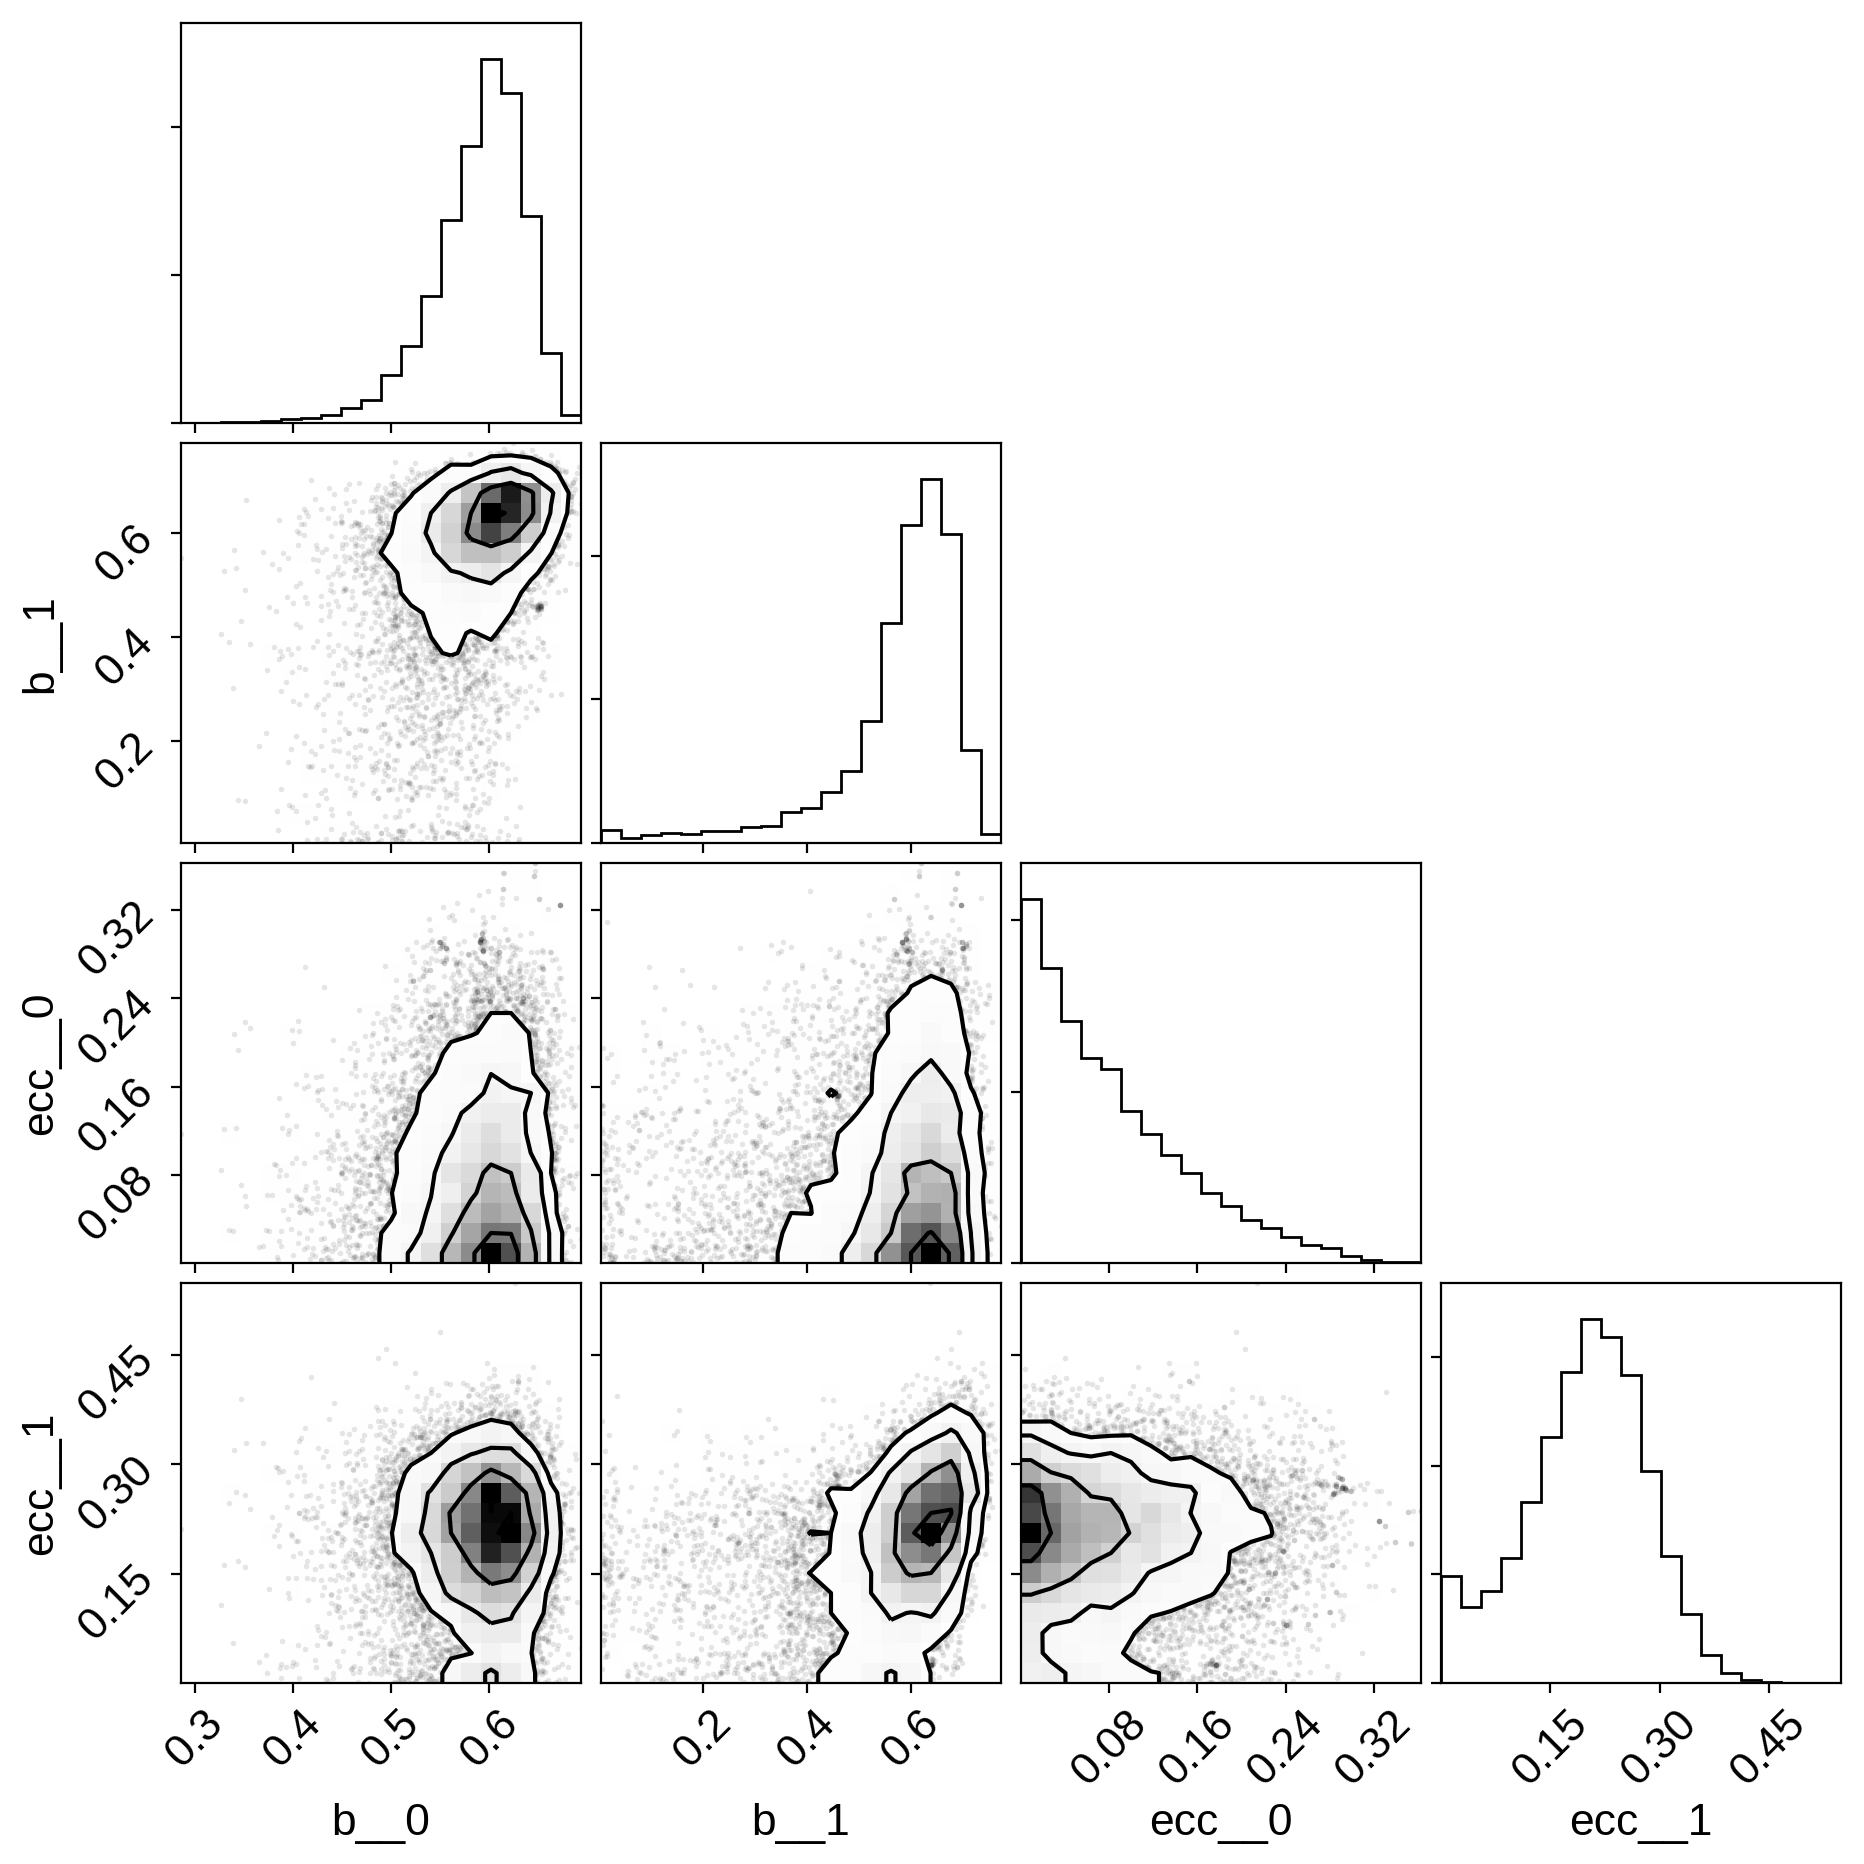

In [17]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

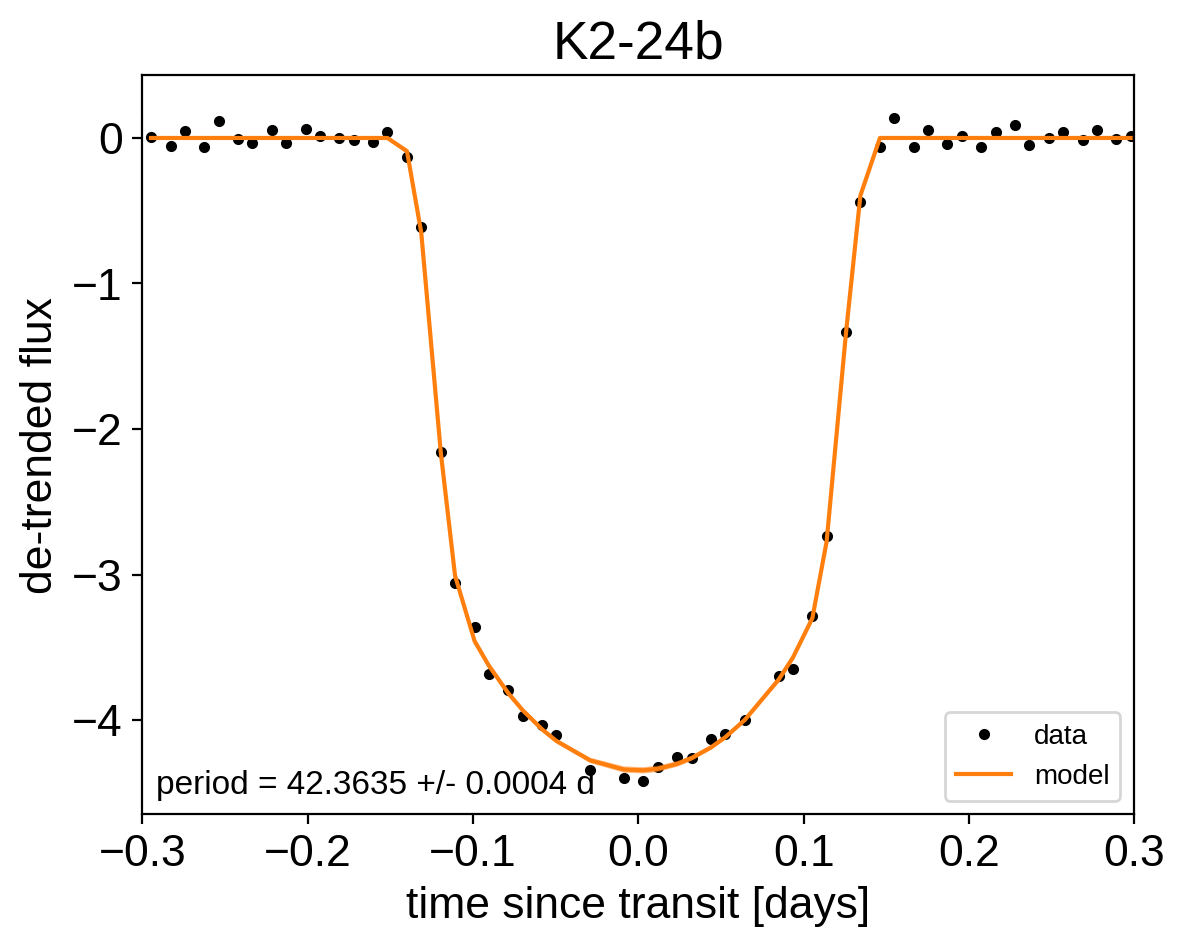

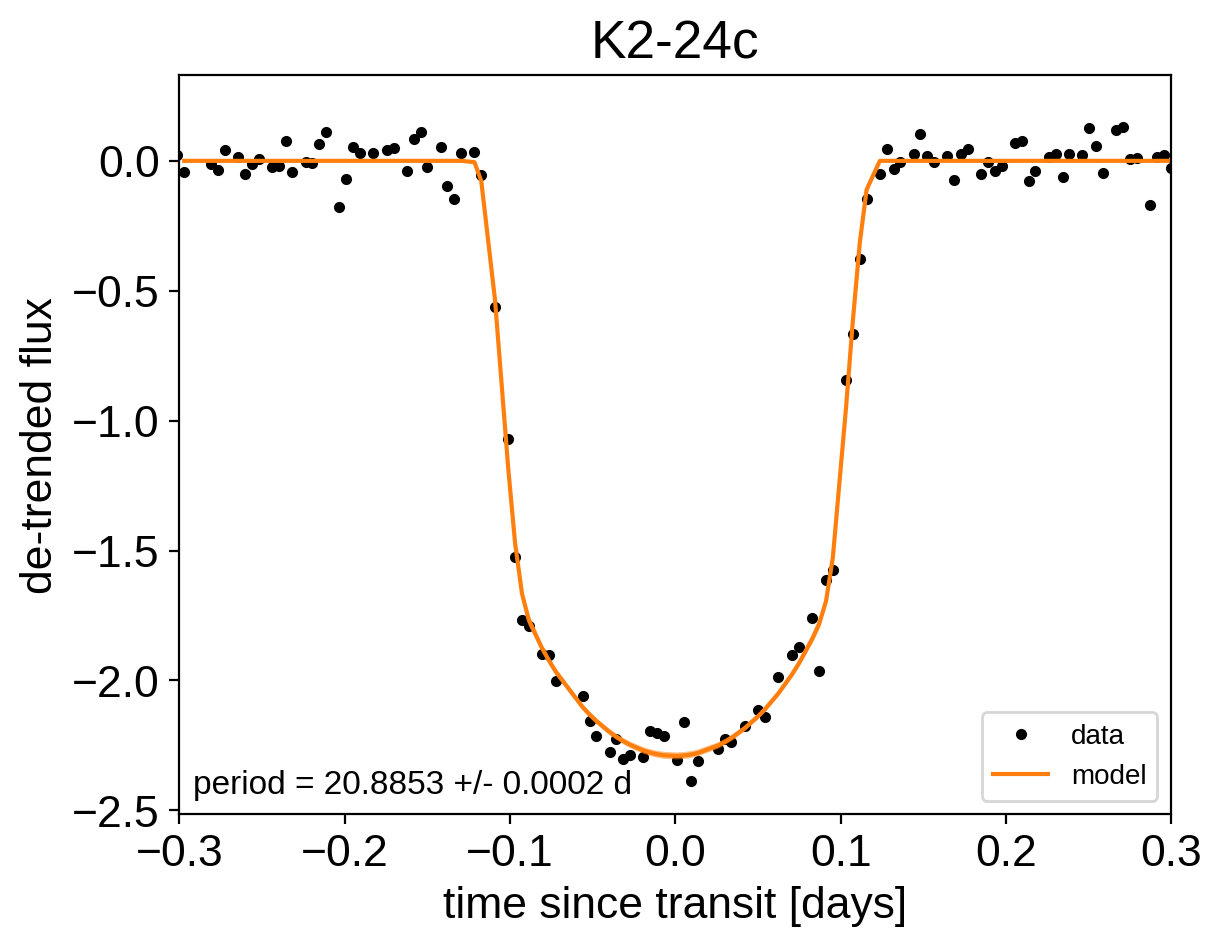

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

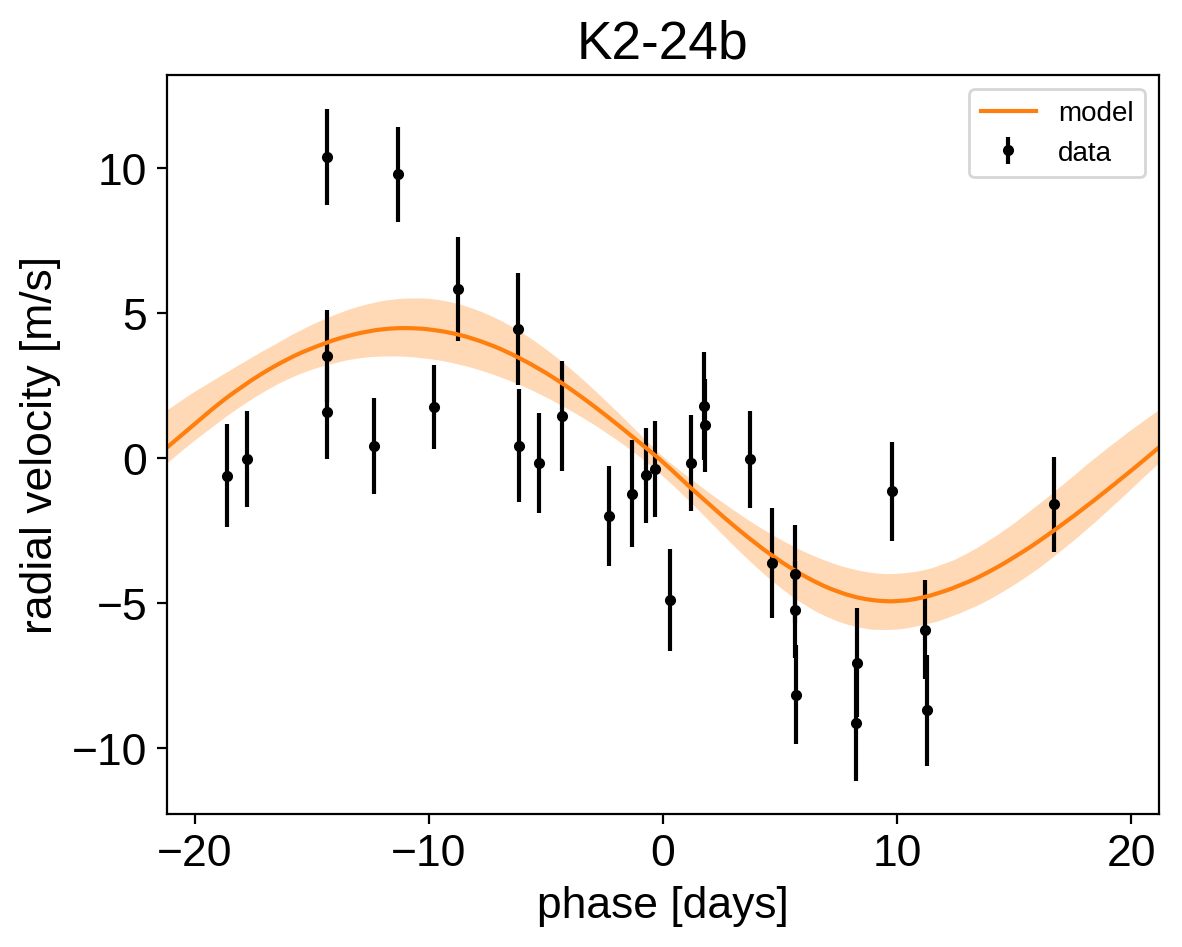

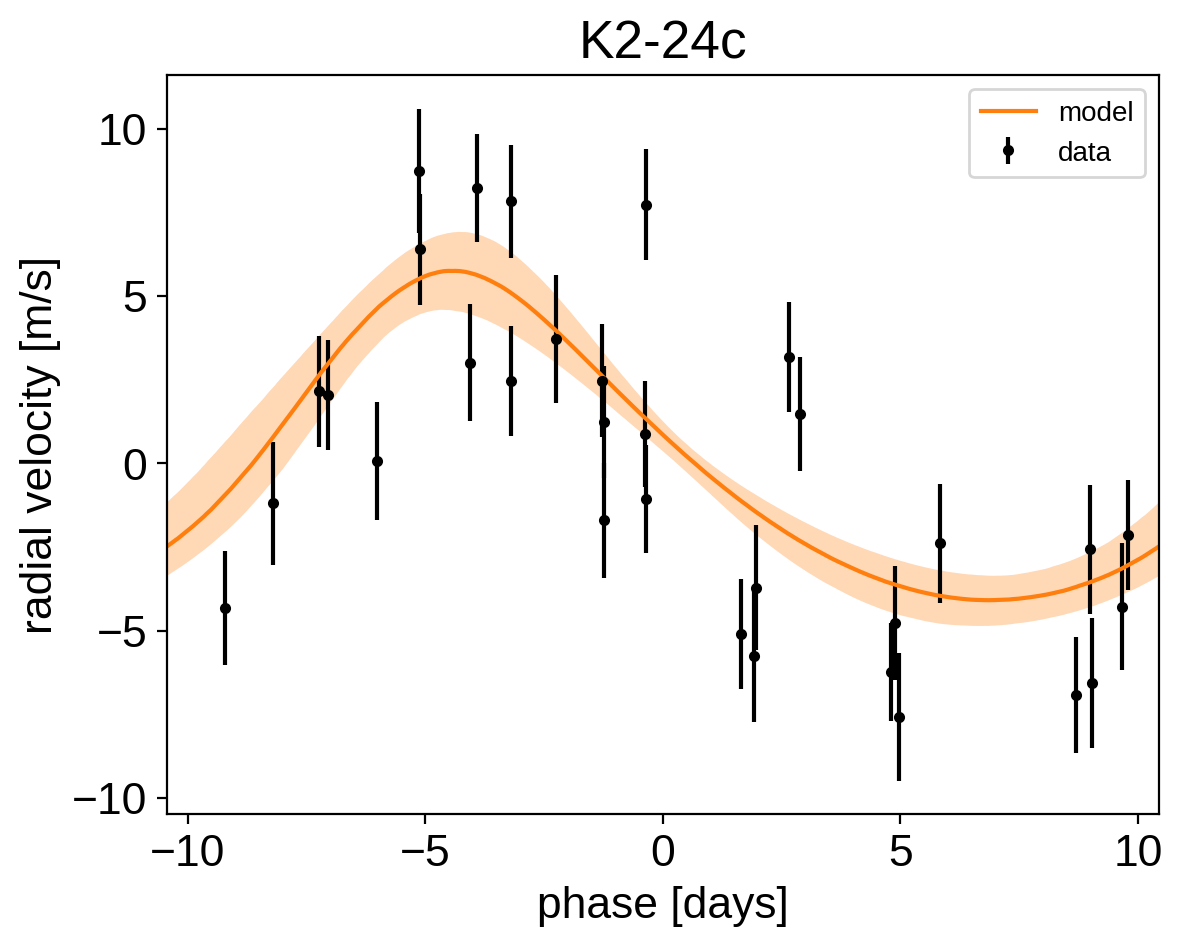

In [19]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

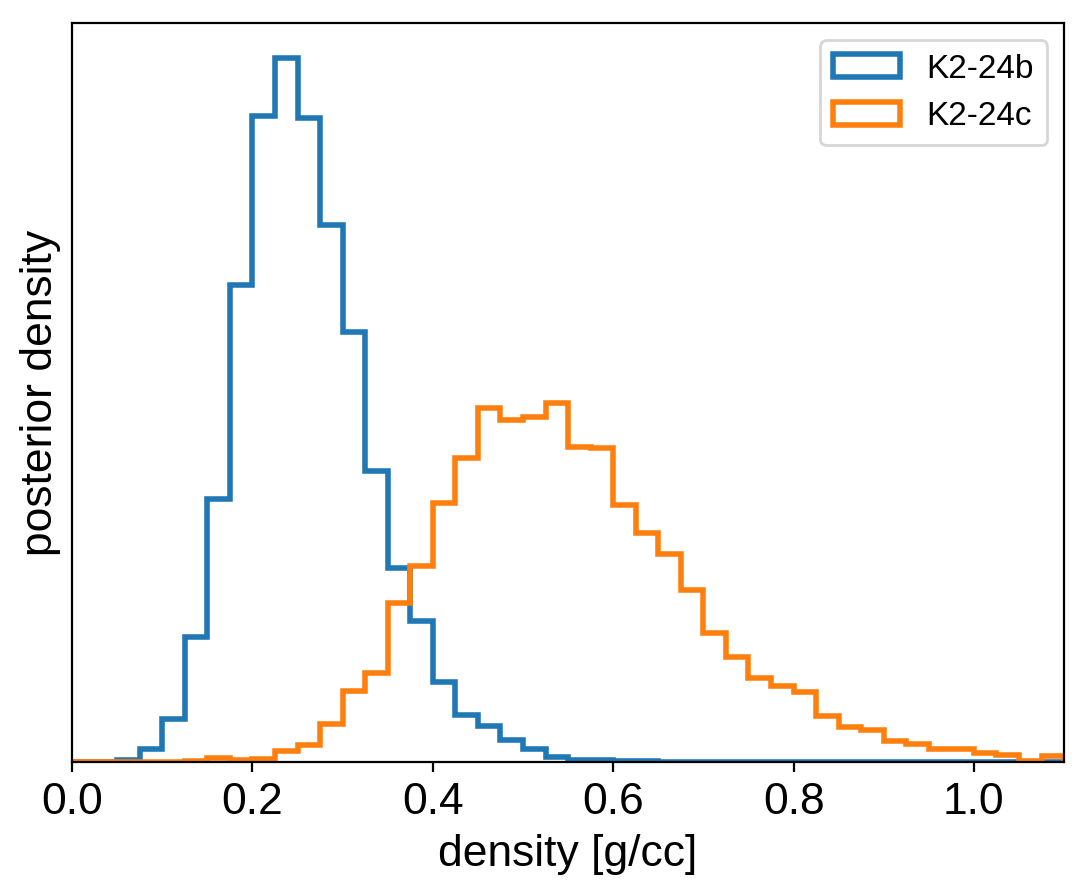

In [20]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [21]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [22]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
